# Overview
This notebook implements a LSTM network an trains it on the dataset train_big_MAV. This dataset contains the moving average mean of the sales. The MAV data was extrapolated to the test_big set and included there. The trained lstm network is evaluated on the features of the test_big_MAV dataset. The kaggle score achieved with this version was better than the score for the LSTM trained on the data set without MAV.

It is recommended to take a look at the notebook LSTM.ipynb before reading this notebook.

In [4]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
import sklearn
from torch.utils.data import DataLoader, Dataset
from sklearn import preprocessing
from torch import nn
import torch


### Load data

In [5]:
train_big = pd.read_csv('datasets/train_big_MAV.csv')
train_big.index = train_big['date']
train_big = train_big.drop('date',axis=1)
# permute columns (thats just my prefered order without any reason)
col_lst = ['store_nbr','family_id','onpromotion','day','weekday','month','year','holiday','oilprice','MAV','sales']
train_big = train_big[col_lst]

# do the same for the test frame

test_big = pd.read_csv('datasets/test_big_MAV.csv')
# select only interesting columns to train on
test_big.index = test_big['date']
test_big = test_big.drop('date',axis=1)
# permute columns (thats just my prefered order without any reason)
col_lst = ['store_nbr','family_id','onpromotion','day','weekday','month','year','holiday','oilprice','MAV']
test_big = test_big[col_lst]

In [6]:
#define features and target
features = ['onpromotion','day','weekday','month','year','holiday','oilprice','MAV']
target = 'sales'

In [7]:
train_big

,store_nbr,family_id,onpromotion,day,weekday,month,year,holiday,oilprice,MAV,sales
date,,,,,,,,,,,
2013-01-01,1,0,0,1,1,1,2013,2,93.14,2.428571,0.000
2013-01-01,1,1,0,1,1,1,2013,2,93.14,0.000000,0.000
2013-01-01,1,2,0,1,1,1,2013,2,93.14,1.714286,0.000
2013-01-01,1,3,0,1,1,1,2013,2,93.14,959.571429,0.000
2013-01-01,1,4,0,1,1,1,2013,2,93.14,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,9,28,0,15,1,8,2017,0,47.57,381.083426,438.133
2017-08-15,9,29,1,15,1,8,2017,0,47.57,121.605856,154.553
2017-08-15,9,30,148,15,1,8,2017,0,47.57,1525.855714,2419.729


In [8]:
test_big

,store_nbr,family_id,onpromotion,day,weekday,month,year,holiday,oilprice,MAV
date,,,,,,,,,,
2017-08-16,1,0,0,16,2,8,2017,0,46.80,3.782408
2017-08-16,1,1,0,16,2,8,2017,0,46.80,0.000000
2017-08-16,1,2,2,16,2,8,2017,0,46.80,4.161807
2017-08-16,1,3,20,16,2,8,2017,0,46.80,1753.400231
2017-08-16,1,4,0,16,2,8,2017,0,46.80,-0.012092
...,...,...,...,...,...,...,...,...,...,...
2017-08-31,9,28,1,31,3,8,2017,0,47.26,429.987281
2017-08-31,9,29,0,31,3,8,2017,0,47.26,107.522916
2017-08-31,9,30,1,31,3,8,2017,0,47.26,1561.560454


In [9]:
#split train_big in train and test set
test_start = "2016-08-16"

df_train = train_big.loc[:test_start].copy()
df_test = train_big.loc[test_start:].copy()

#compte percentage of training test split
p = len(df_train)/len(train_big)
print('Size of training set is %s percent of total data.'%np.round(p,2))

Size of training set is 0.78 percent of total data.


### Standardize data

In [10]:
store_nbr = 8
family_id = 3

#standardize features & targets with MinMaxScaler (prefered version so far)
X = df_train.loc[(df_train['store_nbr']==store_nbr)&(df_train['family_id']==family_id)]
scaler = preprocessing.MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)
df_train_scaled = pd.DataFrame(X_scaled,index=X.index,columns = X.columns) 

#standardize test set with same scaler that was used for training data 
X_test = df_test.loc[(df_test['store_nbr']==store_nbr)&(df_test['family_id']==family_id)]
X_test_scaled = scaler.transform(X_test)
df_test_scaled  = pd.DataFrame(X_test_scaled,index=X_test.index,columns = X_test.columns)

In [11]:
df_train_scaled

,store_nbr,family_id,onpromotion,day,weekday,month,year,holiday,oilprice,MAV,sales
date,,,,,,,,,,,
2013-01-01,0.0,0.0,0.000000,0.000000,0.166667,0.000000,0.0,1.0,0.792965,0.092906,0.000000
2013-01-02,0.0,0.0,0.000000,0.033333,0.333333,0.000000,0.0,0.0,0.792965,0.092906,0.179409
2013-01-03,0.0,0.0,0.000000,0.066667,0.500000,0.000000,0.0,0.0,0.790951,0.092906,0.146917
2013-01-04,0.0,0.0,0.000000,0.100000,0.666667,0.000000,0.0,0.0,0.792728,0.092906,0.133447
2013-01-05,0.0,0.0,0.000000,0.133333,0.833333,0.000000,0.0,0.0,0.793044,0.092906,0.219673
...,...,...,...,...,...,...,...,...,...,...,...
2016-08-12,0.0,0.0,0.516129,0.366667,0.666667,0.636364,1.0,1.0,0.216511,0.377580,0.304345
2016-08-13,0.0,0.0,0.629032,0.400000,0.833333,0.636364,1.0,0.5,0.221446,0.361151,0.342462
2016-08-14,0.0,0.0,0.709677,0.433333,1.000000,0.636364,1.0,0.5,0.226381,0.336517,0.366664


### Datastructures for LSTM

In [12]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]


### Initialize training and test set

In [31]:
torch.manual_seed(101)

batch_size = 4
sequence_length = 7

train_dataset = SequenceDataset(
    df_train_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: torch.Size([4, 16, 8])
Target shape: torch.Size([4])


### Define LSTM

In [14]:
class LSTM(nn.Module):
    def __init__(self, num_features, hidden_units):
        super().__init__()
        self.num_features = num_features  
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out



### Test and train the model

In [15]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [32]:
learning_rate = 0.001 #5e-5
num_hidden_units = 16
num_epoch = 10
model = LSTM(num_features=len(features), hidden_units=num_hidden_units)
loss_function = RMSLELoss() #nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

train_loss_lst = []
test_loss_lst =  []
for ix_epoch in range(num_epoch):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    train_loss_lst.append(train_loss)
    test_loss_lst.append(test_loss)
    print()



Untrained test
--------
Test loss: 0.6688538219902541

Epoch 0
---------
Train loss: 0.07944418505830211
Test loss: 0.05210693061843023

Epoch 1
---------
Train loss: 0.03940580417458362
Test loss: 0.04501646592353399

Epoch 2
---------
Train loss: 0.03756751092938633
Test loss: 0.04433247995573086

Epoch 3
---------
Train loss: 0.03656031655603485
Test loss: 0.04162522410503128

Epoch 4
---------
Train loss: 0.035825202831002434
Test loss: 0.040351905225479344

Epoch 5
---------
Train loss: 0.03470834508239998
Test loss: 0.038218118475524934

Epoch 6
---------
Train loss: 0.033610355820833195
Test loss: 0.046080151020170566

Epoch 7
---------
Train loss: 0.03262079712369246
Test loss: 0.039291751837091785

Epoch 8
---------
Train loss: 0.03074934643136163
Test loss: 0.03574139387397976

Epoch 9
---------
Train loss: 0.030460969149627443
Test loss: 0.03369279213986554



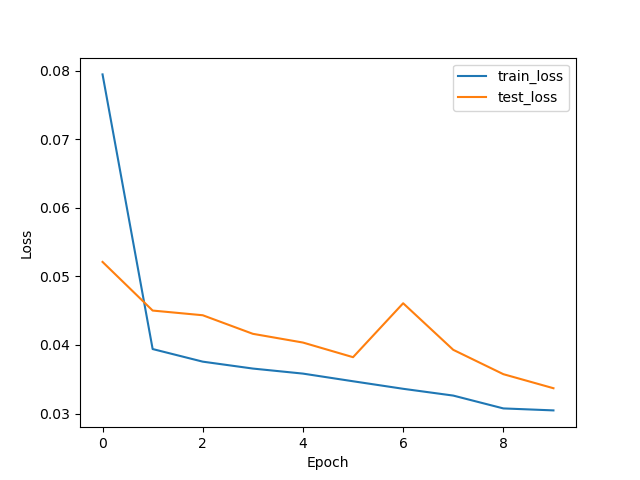

In [34]:
#plot loss 
fig = plt.figure()
plt.plot(train_loss_lst,label='train_loss')
plt.plot(test_loss_lst,label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Prediction

In [19]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

In [35]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()
df_train_copy = df_train_copy.loc[(df_train_copy['store_nbr']==store_nbr)&(df_train_copy['family_id']==family_id)]
df_test_copy = df_test_copy.loc[(df_test_copy['store_nbr']==store_nbr)&(df_test_copy['family_id']==family_id)]

train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train_copy[ystar_col] = predict(train_eval_loader, model).numpy()
df_test_copy[ystar_col] = predict(test_eval_loader, model).numpy()

df_out = pd.concat((df_train_copy, df_test_copy))[[target, ystar_col]]
df_out['sales'] = pd.concat((df_train_scaled['sales'],df_test_scaled['sales'])) #overide sales with scaled sales
df_out['date'] = df_out.index #include date column for plots

<AxesSubplot:xlabel='date'>

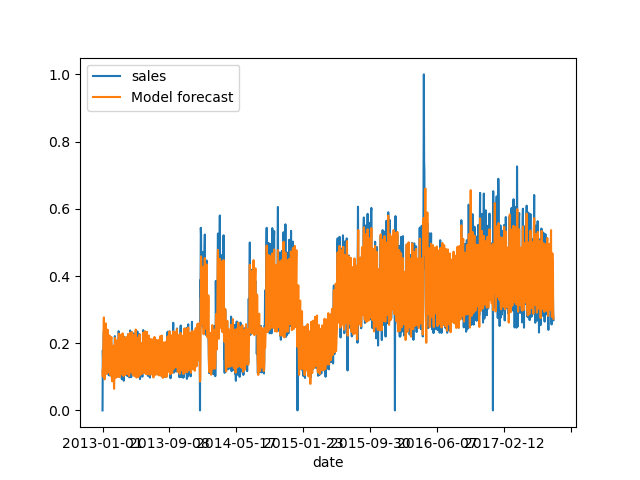

In [36]:
df_out.plot('date',['sales','Model forecast'])

### Scale Back

In [37]:
df_train_predict_scale_back = df_train_scaled.copy()
df_test_predict_scale_back = df_test_scaled.copy()
df_train_predict_scale_back['sales'] = df_train_copy['Model forecast']
df_test_predict_scale_back['sales'] = df_test_copy['Model forecast']

X_train_pred_sb = scaler.inverse_transform(df_train_predict_scale_back)
X_test_pred_sb = scaler.inverse_transform(df_test_predict_scale_back)

#put rescaled values back in dataframe

df_train_predict_scale_back = pd.DataFrame(X_train_pred_sb,index=df_train_scaled.index,columns = df_train_scaled.columns)
df_test_predict_scale_back = pd.DataFrame(X_test_pred_sb,index=df_test_scaled.index,columns = df_test_scaled.columns)

# merge prediction into a single data frame
d1=df_train.loc[(df_train['store_nbr']==store_nbr)&(df_train['family_id']==family_id)]
d2=df_test.loc[(df_test['store_nbr']==store_nbr)&(df_test['family_id']==family_id)]

df_out_scaled_back = pd.DataFrame({'sales':pd.concat((d1['sales'],d2['sales'])),
                                  'predicted sales': pd.concat((df_train_predict_scale_back['sales'],
                                                               df_test_predict_scale_back['sales']))},
                                 index=df_out.index)
#include date colum
df_out_scaled_back['date']=df_out.index
df_out_scaled_back['date'] = pd.to_datetime(df_out_scaled_back['date'])

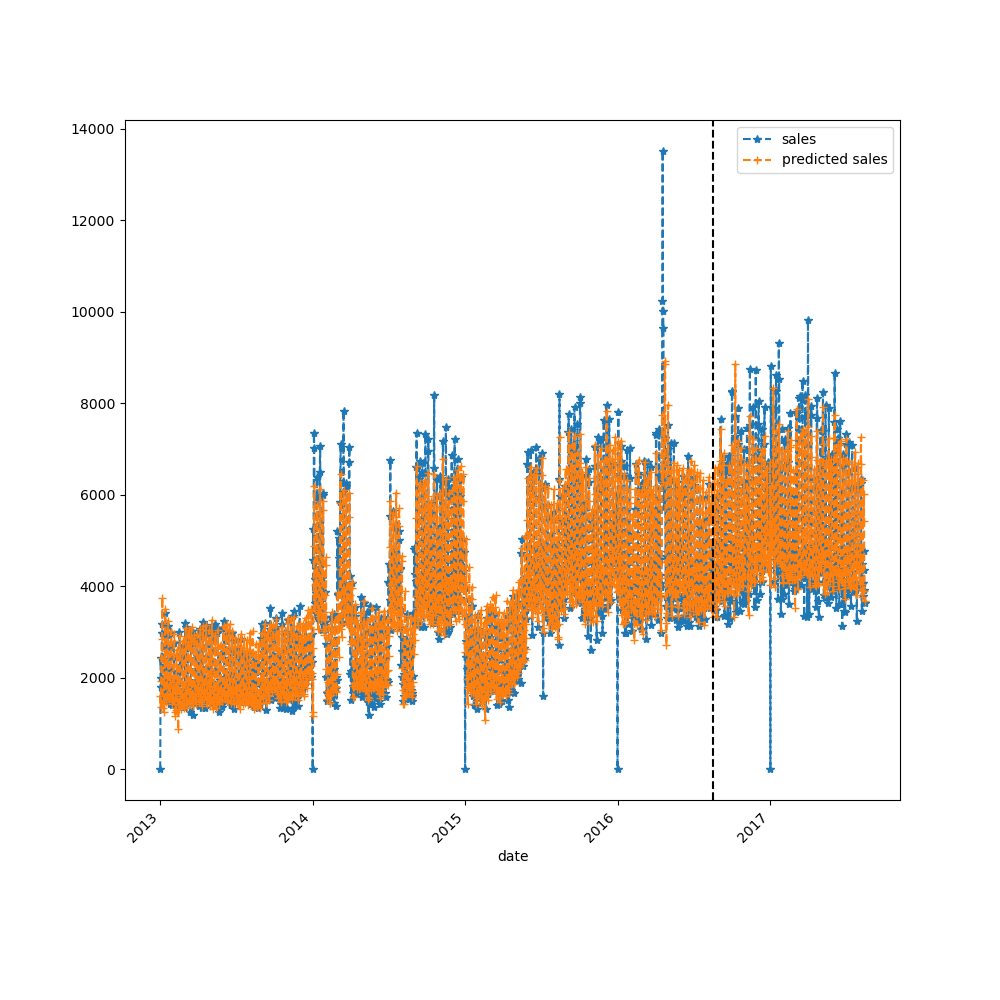

In [38]:
df_out_scaled_back.plot('date',['sales','predicted sales'],style=['*--','+--'],rot=45,figsize=(10,10))
plt.axvline(test_start,linestyle='--',color='k')

### Predict future sales

In [39]:
pred_feature_val = test_big.loc[(test_big['store_nbr']==store_nbr)&(test_big['family_id']==family_id)]
pred_feature_val['sales']=0 #include dummy sales that we can use same scaler 
X_pred_scaled = scaler.transform(pred_feature_val)
df_pred_scaled  = pd.DataFrame(X_pred_scaled,index=pred_feature_val.index,columns = pred_feature_val.columns)

C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\1477084761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


In [40]:
# put data into correct format
pred_dataset = SequenceDataset(
    df_pred_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length)

pred_eval_loader = DataLoader(pred_dataset, batch_size=batch_size, shuffle=False)
#make prediction
future_sales_pred = predict(pred_eval_loader, model).numpy()

In [41]:
df_pred_scaled['sales'] = future_sales_pred
X_back_transform = scaler.inverse_transform(df_pred_scaled)
df_pred = pd.DataFrame(X_back_transform,index=df_pred_scaled.index,columns=df_pred_scaled.columns)
df_pred['dates'] = df_pred.index #include date col for plots

<AxesSubplot:title={'center':'Sales prediction of store 8 and product 3'}, xlabel='dates', ylabel='sales'>

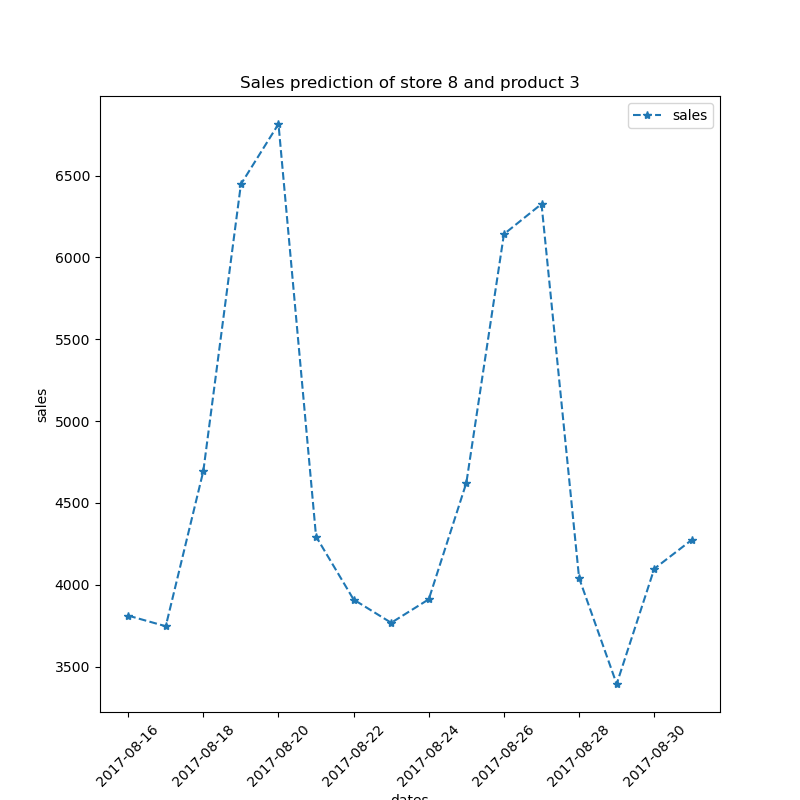

In [42]:
#plot prediction
df_pred.plot('dates','sales',style=['*--'],rot=45,figsize=(8,8),title='Sales prediction of store %s and product %s'%(store_nbr,family_id),ylabel='sales')

### Predict all stores & products

In [30]:
#this function trains the LSTM on the whole training set for a store and family and returns the prediction for the future
# sales of this store and family, with this function we will be training #stores*#families many lstm models later on.

def get_predictions(store_nbr,family_id):
    
    #scaling data
    X = train_big.loc[(train_big['store_nbr']==store_nbr)&(train_big['family_id']==family_id)]
    scaler = preprocessing.MinMaxScaler().fit(X)
    X_scaled = scaler.transform(X)
    df_train_scaled = pd.DataFrame(X_scaled,index=X.index,columns = X.columns) 
    
    #put data into correct format
    torch.manual_seed(101)

    batch_size = 4
    sequence_length = 16

    train_dataset = SequenceDataset(df_train_scaled, target=target, features=features, sequence_length=sequence_length) 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    #define hyperparameters (those seemed to be very good)
    learning_rate = 0.001 
    num_hidden_units = 16
    num_epoch = 10
    model = LSTM(num_features=len(features), hidden_units=num_hidden_units)
    loss_function = RMSLELoss() #nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for ix_epoch in range(num_epoch):
        print(f"Epoch {ix_epoch}\n---------")
        train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
        train_loss_lst.append(train_loss)
        test_loss_lst.append(test_loss)
        print()
        
    #evaluate the trained model on the test (more precise the prediction) set. 
    #For this to work we first must scale the test features
    pred_feature_val = test_big.loc[(test_big['store_nbr']==store_nbr)&(test_big['family_id']==family_id)]
    pred_feature_val['sales']=0 #include dummy sales that we can use same scaler 
    X_pred_scaled = scaler.transform(pred_feature_val)
    df_pred_scaled  = pd.DataFrame(X_pred_scaled,index=pred_feature_val.index,columns = pred_feature_val.columns)
    
    # put data into correct format
    pred_dataset = SequenceDataset(df_pred_scaled, target=target, features=features, sequence_length=sequence_length)
    pred_eval_loader = DataLoader(pred_dataset, batch_size=batch_size, shuffle=False)
    
    #make prediction and scale back
    future_sales_pred = predict(pred_eval_loader, model).numpy()
    df_pred_scaled['sales'] = future_sales_pred
    X_back_transform = scaler.inverse_transform(df_pred_scaled)
    df_pred = pd.DataFrame(X_back_transform,index=df_pred_scaled.index,columns=df_pred_scaled.columns)
    return df_pred['sales'].values



In [51]:
#iterate over all combinations of stores&families and write the results row wise in a matrix
import time
t0 = time.time()
num_all_combinations = len(train_big['store_nbr'].unique())*len(train_big['family_id'].unique())
num_pred_days = 16
result_mat = np.zeros((num_all_combinations,num_pred_days))
stores = list(train_big['store_nbr'].unique())
families = list(train_big['family_id'].unique())

ctr = 0
# run two for loops to train lstm model and return prediction for each pair of possible combinations (store_nbr,family_id)
for store in stores:
    for family in families:
        result_mat[ctr,:] = get_predictions(store,family)
        ctr=ctr+1
        print('---------------------')
        print('finished store_%s & family_%s'%(store,family))
        print('---------------------')
        
pred = np.reshape(result_mat.T,(result_mat.size,1)).flatten()    
t1 = time.time()
total = t1-t0
print('Execution time = %s sec.'%total)
df_for_id = pd.read_csv('datasets/test_big.csv')
submission_1782_lstm_models_MAV = pd.DataFrame({'id':df_for_id['id'],'sales':pred})
# store submission
submission_1782_lstm_models_MAV.to_csv('predicted_data/submission_1782_lstm_models_MAV.csv',index=False)

Epoch 0
---------
Train loss: 0.10116808885827909

Epoch 1
---------
Train loss: 0.09787908259274841

Epoch 2
---------
Train loss: 0.0965972385920071

Epoch 3
---------
Train loss: 0.09552465112671929

Epoch 4
---------
Train loss: 0.09104530128811855

Epoch 5
---------
Train loss: 0.0845733401642099

Epoch 6
---------
Train loss: 0.07682066509885063

Epoch 7
---------
Train loss: 0.0728696439118786

Epoch 8
---------
Train loss: 0.07126274767758728

Epoch 9
---------
Train loss: 0.06946669019440149

---------------------
finished store_1 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004161641861992609

Epoch 1
---------
Train loss: 0.001340535350276363

Epoch 2
---------
Train loss: 0.0010959985852974296

Epoch 3
---------
Train loss: 0.0009841252536379628

Epoch 4
---------
Train loss: 0.0009694444763784147

Epoch 5
---------
Train loss: 0.0007891407087792293

Epoch 6
---------
Train loss: 0.0007734619826728239

Epoch 7
---------
Train loss: 0.0009418182798160512

Epoch 8
---------
Train loss: 0.0007717242051577394

Epoch 9
---------
Train loss: 0.0006026436974571834

---------------------
finished store_1 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11138562222770161

Epoch 1
---------
Train loss: 0.10615439006434908

Epoch 2
---------
Train loss: 0.10307716489316024

Epoch 3
---------
Train loss: 0.09920210712932209

Epoch 4
---------
Train loss: 0.09444276577928004

Epoch 5
---------
Train loss: 0.08907967477134317

Epoch 6
---------
Train loss: 0.0820105059753723

Epoch 7
---------
Train loss: 0.07771812959390553

Epoch 8
---------
Train loss: 0.07535749007538492

Epoch 9
---------
Train loss: 0.07406787670520522

---------------------
finished store_1 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06907236595658006

Epoch 1
---------
Train loss: 0.05414641210300551

Epoch 2
---------
Train loss: 0.05257810745609486

Epoch 3
---------
Train loss: 0.04933095514119521

Epoch 4
---------
Train loss: 0.046618784924929255

Epoch 5
---------
Train loss: 0.0405009327270533

Epoch 6
---------
Train loss: 0.03639087605128627

Epoch 7
---------
Train loss: 0.033516269853015625

Epoch 8
---------
Train loss: 0.03227186248075845

Epoch 9
---------
Train loss: 0.03145614780724544

---------------------
finished store_1 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02840618271078702

Epoch 1
---------
Train loss: 0.027010462534278763

Epoch 2
---------
Train loss: 0.025681152652905957

Epoch 3
---------
Train loss: 0.025721573401236965

Epoch 4
---------
Train loss: 0.02516294681180087

Epoch 5
---------
Train loss: 0.024996001665500346

Epoch 6
---------
Train loss: 0.02472168582614905

Epoch 7
---------
Train loss: 0.024383754748671323

Epoch 8
---------
Train loss: 0.02464444870280623

Epoch 9
---------
Train loss: 0.02458498395188278

---------------------
finished store_1 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08655398936318388

Epoch 1
---------
Train loss: 0.05983418951611833

Epoch 2
---------
Train loss: 0.057624610974906884

Epoch 3
---------
Train loss: 0.05248046146524349

Epoch 4
---------
Train loss: 0.04877807324278808

Epoch 5
---------
Train loss: 0.0462256460151947

Epoch 6
---------
Train loss: 0.04492813439690231

Epoch 7
---------
Train loss: 0.04355785242478737

Epoch 8
---------
Train loss: 0.04084143508446896

Epoch 9
---------
Train loss: 0.03887671380659959

---------------------
finished store_1 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.008530952755335249

Epoch 1
---------
Train loss: 0.006629961265158129

Epoch 2
---------
Train loss: 0.0060851978864786245

Epoch 3
---------
Train loss: 0.005919070953238897

Epoch 4
---------
Train loss: 0.005732611381748001

Epoch 5
---------
Train loss: 0.005679384749266596

Epoch 6
---------
Train loss: 0.00538696317447929

Epoch 7
---------
Train loss: 0.00561025706978433

Epoch 8
---------
Train loss: 0.005710187959020201

Epoch 9
---------
Train loss: 0.005598280026086312

---------------------
finished store_1 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07781233303160395

Epoch 1
---------
Train loss: 0.05184612410350962

Epoch 2
---------
Train loss: 0.049917120167945736

Epoch 3
---------
Train loss: 0.04745152216148065

Epoch 4
---------
Train loss: 0.04545623480371087

Epoch 5
---------
Train loss: 0.04449764234976148

Epoch 6
---------
Train loss: 0.043842250348517846

Epoch 7
---------
Train loss: 0.04299556183122152

Epoch 8
---------
Train loss: 0.04170029888133078

Epoch 9
---------
Train loss: 0.04064339363279436

---------------------
finished store_1 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09647647478571272

Epoch 1
---------
Train loss: 0.0682058536874533

Epoch 2
---------
Train loss: 0.06658166323317273

Epoch 3
---------
Train loss: 0.06334415667705821

Epoch 4
---------
Train loss: 0.060688798506069494

Epoch 5
---------
Train loss: 0.05697364012341318

Epoch 6
---------
Train loss: 0.054226641713546464

Epoch 7
---------
Train loss: 0.049179670265975306

Epoch 8
---------
Train loss: 0.04307883919710006

Epoch 9
---------
Train loss: 0.040402918819541604

---------------------
finished store_1 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09382978133025476

Epoch 1
---------
Train loss: 0.06649390119183234

Epoch 2
---------
Train loss: 0.06356962993431332

Epoch 3
---------
Train loss: 0.05890929399416594

Epoch 4
---------
Train loss: 0.055799609271371446

Epoch 5
---------
Train loss: 0.05260177266578281

Epoch 6
---------
Train loss: 0.051665790146769794

Epoch 7
---------
Train loss: 0.050191505652832445

Epoch 8
---------
Train loss: 0.048654691068424606

Epoch 9
---------
Train loss: 0.047391384862133276

---------------------
finished store_1 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10397266163634504

Epoch 1
---------
Train loss: 0.07575209929238376

Epoch 2
---------
Train loss: 0.0713568608013298

Epoch 3
---------
Train loss: 0.06501720035382305

Epoch 4
---------
Train loss: 0.05989975663844381

Epoch 5
---------
Train loss: 0.055570075485297875

Epoch 6
---------
Train loss: 0.05352319441868474

Epoch 7
---------
Train loss: 0.05120987998821602

Epoch 8
---------
Train loss: 0.05020992564271932

Epoch 9
---------
Train loss: 0.048810556273234926

---------------------
finished store_1 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01182054113480539

Epoch 1
---------
Train loss: 0.009782238078365577

Epoch 2
---------
Train loss: 0.00939242128197617

Epoch 3
---------
Train loss: 0.009275094149307947

Epoch 4
---------
Train loss: 0.009240217249167999

Epoch 5
---------
Train loss: 0.008783220909115572

Epoch 6
---------
Train loss: 0.008892920723786652

Epoch 7
---------
Train loss: 0.008490310444174701

Epoch 8
---------
Train loss: 0.008198888810636861

Epoch 9
---------
Train loss: 0.008099274735675456

---------------------
finished store_1 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04816431249104741

Epoch 1
---------
Train loss: 0.03984678043450744

Epoch 2
---------
Train loss: 0.03875322491948154

Epoch 3
---------
Train loss: 0.03715979016989894

Epoch 4
---------
Train loss: 0.035767585091677774

Epoch 5
---------
Train loss: 0.033961095920744

Epoch 6
---------
Train loss: 0.03306512607675214

Epoch 7
---------
Train loss: 0.0318100658962127

Epoch 8
---------
Train loss: 0.030462411508813608

Epoch 9
---------
Train loss: 0.029508652226366724

---------------------
finished store_1 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06093485249016177

Epoch 1
---------
Train loss: 0.05673332311956305

Epoch 2
---------
Train loss: 0.05591942568369334

Epoch 3
---------
Train loss: 0.05535946032054492

Epoch 4
---------
Train loss: 0.054150214809216474

Epoch 5
---------
Train loss: 0.051543746316128555

Epoch 6
---------
Train loss: 0.04764987165418027

Epoch 7
---------
Train loss: 0.043405035871242545

Epoch 8
---------
Train loss: 0.041394766079452146

Epoch 9
---------
Train loss: 0.03976147508054016

---------------------
finished store_1 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09665368830081686

Epoch 1
---------
Train loss: 0.09430830917739245

Epoch 2
---------
Train loss: 0.0922189795936407

Epoch 3
---------
Train loss: 0.0841116936337601

Epoch 4
---------
Train loss: 0.07441906140776541

Epoch 5
---------
Train loss: 0.06964722531460527

Epoch 6
---------
Train loss: 0.06746914809361773

Epoch 7
---------
Train loss: 0.06621598269825806

Epoch 8
---------
Train loss: 0.0644270756753104

Epoch 9
---------
Train loss: 0.06343515243407807

---------------------
finished store_1 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.017421316683420694

Epoch 1
---------
Train loss: 0.016351576564355694

Epoch 2
---------
Train loss: 0.016099895881555283

Epoch 3
---------
Train loss: 0.015533330444093892

Epoch 4
---------
Train loss: 0.01532033391765843

Epoch 5
---------
Train loss: 0.015231803555380013

Epoch 6
---------
Train loss: 0.015022531614391103

Epoch 7
---------
Train loss: 0.014639103782945036

Epoch 8
---------
Train loss: 0.014738812893872412

Epoch 9
---------
Train loss: 0.014193973241864997

---------------------
finished store_1 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.028925071334391126

Epoch 1
---------
Train loss: 0.026922813606461746

Epoch 2
---------
Train loss: 0.02592156593153594

Epoch 3
---------
Train loss: 0.02539583731601966

Epoch 4
---------
Train loss: 0.02482640538104719

Epoch 5
---------
Train loss: 0.024574137664999537

Epoch 6
---------
Train loss: 0.02427565709482038

Epoch 7
---------
Train loss: 0.024214326153507108

Epoch 8
---------
Train loss: 0.023746830148560452

Epoch 9
---------
Train loss: 0.023378704116799185

---------------------
finished store_1 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07803438135451525

Epoch 1
---------
Train loss: 0.07440383757703502

Epoch 2
---------
Train loss: 0.07345803813442517

Epoch 3
---------
Train loss: 0.06735103443871095

Epoch 4
---------
Train loss: 0.061450572924427425

Epoch 5
---------
Train loss: 0.05822754539040552

Epoch 6
---------
Train loss: 0.05586084843925123

Epoch 7
---------
Train loss: 0.053970166957647385

Epoch 8
---------
Train loss: 0.052680944393426535

Epoch 9
---------
Train loss: 0.050887973297767855

---------------------
finished store_1 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04652655926796291

Epoch 1
---------
Train loss: 0.03593813342920498

Epoch 2
---------
Train loss: 0.03394514918017628

Epoch 3
---------
Train loss: 0.032829167614436564

Epoch 4
---------
Train loss: 0.03173959870367021

Epoch 5
---------
Train loss: 0.03052886369728844

Epoch 6
---------
Train loss: 0.029988777126913398

Epoch 7
---------
Train loss: 0.028773849946170195

Epoch 8
---------
Train loss: 0.028042657271518667

Epoch 9
---------
Train loss: 0.026348591735697133

---------------------
finished store_1 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0920982942905392

Epoch 1
---------
Train loss: 0.07678798455391035

Epoch 2
---------
Train loss: 0.07507849944812951

Epoch 3
---------
Train loss: 0.07151164040920677

Epoch 4
---------
Train loss: 0.06988570520697458

Epoch 5
---------
Train loss: 0.06907700449161921

Epoch 6
---------
Train loss: 0.06776314714122696

Epoch 7
---------
Train loss: 0.06632070244022262

Epoch 8
---------
Train loss: 0.06400538926541523

Epoch 9
---------
Train loss: 0.06166094208065412

---------------------
finished store_1 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04509745009526646

Epoch 1
---------
Train loss: 0.043288950968728424

Epoch 2
---------
Train loss: 0.04256820195905351

Epoch 3
---------
Train loss: 0.041478891739723515

Epoch 4
---------
Train loss: 0.041236978272007084

Epoch 5
---------
Train loss: 0.041565062596259146

Epoch 6
---------
Train loss: 0.04084045849762627

Epoch 7
---------
Train loss: 0.04030933524227553

Epoch 8
---------
Train loss: 0.0396995690414536

Epoch 9
---------
Train loss: 0.037870171614823034

---------------------
finished store_1 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08095665061027874

Epoch 1
---------
Train loss: 0.07664766736691397

Epoch 2
---------
Train loss: 0.07576701115272638

Epoch 3
---------
Train loss: 0.07558513333636055

Epoch 4
---------
Train loss: 0.07452273229911321

Epoch 5
---------
Train loss: 0.07306113573910576

Epoch 6
---------
Train loss: 0.07119931213252441

Epoch 7
---------
Train loss: 0.06641005049736157

Epoch 8
---------
Train loss: 0.062097030258217646

Epoch 9
---------
Train loss: 0.05753455643106314

---------------------
finished store_1 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07444677920680219

Epoch 1
---------
Train loss: 0.06466739136734513

Epoch 2
---------
Train loss: 0.05999393962022811

Epoch 3
---------
Train loss: 0.05252603023819572

Epoch 4
---------
Train loss: 0.04744506026275297

Epoch 5
---------
Train loss: 0.0457954277979064

Epoch 6
---------
Train loss: 0.04453089572666235

Epoch 7
---------
Train loss: 0.04355800324374027

Epoch 8
---------
Train loss: 0.042023566483482364

Epoch 9
---------
Train loss: 0.0418291829798521

---------------------
finished store_1 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07830669577156067

Epoch 1
---------
Train loss: 0.07198000266139269

Epoch 2
---------
Train loss: 0.07032835281137687

Epoch 3
---------
Train loss: 0.06804060047069861

Epoch 4
---------
Train loss: 0.0665943723945102

Epoch 5
---------
Train loss: 0.0649158292308432

Epoch 6
---------
Train loss: 0.061931210680092705

Epoch 7
---------
Train loss: 0.059947516176309834

Epoch 8
---------
Train loss: 0.057223031467663

Epoch 9
---------
Train loss: 0.055008704559501444

---------------------
finished store_1 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08090068827518163

Epoch 1
---------
Train loss: 0.05722651323812379

Epoch 2
---------
Train loss: 0.05374623512110348

Epoch 3
---------
Train loss: 0.05141047015675563

Epoch 4
---------
Train loss: 0.049084975942748105

Epoch 5
---------
Train loss: 0.047178721582990434

Epoch 6
---------
Train loss: 0.0445101891617753

Epoch 7
---------
Train loss: 0.041912781227835746

Epoch 8
---------
Train loss: 0.04062878695425009

Epoch 9
---------
Train loss: 0.04017259923723524

---------------------
finished store_1 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03833368799987641

Epoch 1
---------
Train loss: 0.03490026511535084

Epoch 2
---------
Train loss: 0.034546393359128624

Epoch 3
---------
Train loss: 0.03316543422165966

Epoch 4
---------
Train loss: 0.03196310901664852

Epoch 5
---------
Train loss: 0.03051256935384275

Epoch 6
---------
Train loss: 0.02853223534230134

Epoch 7
---------
Train loss: 0.026799287597235124

Epoch 8
---------
Train loss: 0.02559879123434566

Epoch 9
---------
Train loss: 0.02454730663603424

---------------------
finished store_1 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08732172133480674

Epoch 1
---------
Train loss: 0.07920468049765411

Epoch 2
---------
Train loss: 0.07812483534393855

Epoch 3
---------
Train loss: 0.07624797298486682

Epoch 4
---------
Train loss: 0.07443443477439148

Epoch 5
---------
Train loss: 0.07447535265237093

Epoch 6
---------
Train loss: 0.07197373603623262

Epoch 7
---------
Train loss: 0.06861526285234015

Epoch 8
---------
Train loss: 0.063502329838575

Epoch 9
---------
Train loss: 0.06054996569019316

---------------------
finished store_1 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06296206592535711

Epoch 1
---------
Train loss: 0.057705719687593235

Epoch 2
---------
Train loss: 0.05575890791427671

Epoch 3
---------
Train loss: 0.05468676447417065

Epoch 4
---------
Train loss: 0.05409543038397859

Epoch 5
---------
Train loss: 0.052432267595914295

Epoch 6
---------
Train loss: 0.0509183838506696

Epoch 7
---------
Train loss: 0.04926052319954399

Epoch 8
---------
Train loss: 0.04729323627149593

Epoch 9
---------
Train loss: 0.04565891029917128

---------------------
finished store_1 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07646478551291726

Epoch 1
---------
Train loss: 0.05801111614141356

Epoch 2
---------
Train loss: 0.055400877505222296

Epoch 3
---------
Train loss: 0.05258619244433851

Epoch 4
---------
Train loss: 0.04994403118723362

Epoch 5
---------
Train loss: 0.04848010890238925

Epoch 6
---------
Train loss: 0.0471051720074973

Epoch 7
---------
Train loss: 0.04653237788161515

Epoch 8
---------
Train loss: 0.045252398291332846

Epoch 9
---------
Train loss: 0.043096872042165515

---------------------
finished store_1 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07588392854037732

Epoch 1
---------
Train loss: 0.06188474021489221

Epoch 2
---------
Train loss: 0.06001416084991498

Epoch 3
---------
Train loss: 0.05892323715404348

Epoch 4
---------
Train loss: 0.05770460944047592

Epoch 5
---------
Train loss: 0.05489069049416946

Epoch 6
---------
Train loss: 0.05324555872640884

Epoch 7
---------
Train loss: 0.05223440926637049

Epoch 8
---------
Train loss: 0.050750829730151915

Epoch 9
---------
Train loss: 0.04956304853574114

---------------------
finished store_1 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0929248701458058

Epoch 1
---------
Train loss: 0.06141332394582819

Epoch 2
---------
Train loss: 0.054611752641491255

Epoch 3
---------
Train loss: 0.04977840740474786

Epoch 4
---------
Train loss: 0.04576826892956879

Epoch 5
---------
Train loss: 0.039301964899551595

Epoch 6
---------
Train loss: 0.0366936280268229

Epoch 7
---------
Train loss: 0.03601779123865546

Epoch 8
---------
Train loss: 0.03422704690430234

Epoch 9
---------
Train loss: 0.03347661461782887

---------------------
finished store_1 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.055592583825606015

Epoch 1
---------
Train loss: 0.0544551936419423

Epoch 2
---------
Train loss: 0.054477335586662755

Epoch 3
---------
Train loss: 0.05402678661188055

Epoch 4
---------
Train loss: 0.054155683072063754

Epoch 5
---------
Train loss: 0.053618348025243436

Epoch 6
---------
Train loss: 0.05138630674617706

Epoch 7
---------
Train loss: 0.050498243999797986

Epoch 8
---------
Train loss: 0.048446073544138685

Epoch 9
---------
Train loss: 0.046891503651004786

---------------------
finished store_1 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0812057832658574

Epoch 1
---------
Train loss: 0.06746231039406426

Epoch 2
---------
Train loss: 0.0647862686105338

Epoch 3
---------
Train loss: 0.06502727903602668

Epoch 4
---------
Train loss: 0.06368546029818277

Epoch 5
---------
Train loss: 0.06212722120094257

Epoch 6
---------
Train loss: 0.06068687569659708

Epoch 7
---------
Train loss: 0.059225538055326196

Epoch 8
---------
Train loss: 0.05659586074596134

Epoch 9
---------
Train loss: 0.05577912093350341

---------------------
finished store_1 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06785781557435024

Epoch 1
---------
Train loss: 0.06500101686541584

Epoch 2
---------
Train loss: 0.06374182741460778

Epoch 3
---------
Train loss: 0.062455267229531125

Epoch 4
---------
Train loss: 0.05889097112065044

Epoch 5
---------
Train loss: 0.05291425174593288

Epoch 6
---------
Train loss: 0.04853165990201814

Epoch 7
---------
Train loss: 0.0473350682218433

Epoch 8
---------
Train loss: 0.04682061196063732

Epoch 9
---------
Train loss: 0.04606265714723891

---------------------
finished store_10 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.022428865497765925

Epoch 1
---------
Train loss: 0.019864664719696654

Epoch 2
---------
Train loss: 0.018911038452954054

Epoch 3
---------
Train loss: 0.018772182706370176

Epoch 4
---------
Train loss: 0.018444586192733873

Epoch 5
---------
Train loss: 0.01808227145338692

Epoch 6
---------
Train loss: 0.017546121705687912

Epoch 7
---------
Train loss: 0.017284449722618972

Epoch 8
---------
Train loss: 0.017127474041593718

Epoch 9
---------
Train loss: 0.016632862901066223

---------------------
finished store_10 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09270118076062259

Epoch 1
---------
Train loss: 0.08823777961538055

Epoch 2
---------
Train loss: 0.08440954748855245

Epoch 3
---------
Train loss: 0.07967928275598696

Epoch 4
---------
Train loss: 0.0723464478276263

Epoch 5
---------
Train loss: 0.0662636862616464

Epoch 6
---------
Train loss: 0.06217019723599993

Epoch 7
---------
Train loss: 0.06105024597636311

Epoch 8
---------
Train loss: 0.05999459577348269

Epoch 9
---------
Train loss: 0.059565740783484276

---------------------
finished store_10 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06860365545169192

Epoch 1
---------
Train loss: 0.0516623540011604

Epoch 2
---------
Train loss: 0.04816490795127074

Epoch 3
---------
Train loss: 0.04618805857826546

Epoch 4
---------
Train loss: 0.04429397375086176

Epoch 5
---------
Train loss: 0.04350717865249182

Epoch 6
---------
Train loss: 0.04131190838942619

Epoch 7
---------
Train loss: 0.03977325858742954

Epoch 8
---------
Train loss: 0.039408209946033085

Epoch 9
---------
Train loss: 0.037797373396536944

---------------------
finished store_10 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004161641861992609

Epoch 1
---------
Train loss: 0.001340535350276363

Epoch 2
---------
Train loss: 0.0010959985852974296

Epoch 3
---------
Train loss: 0.0009841252536379628

Epoch 4
---------
Train loss: 0.0009694444763784147

Epoch 5
---------
Train loss: 0.0007891407087792293

Epoch 6
---------
Train loss: 0.0007734619826728239

Epoch 7
---------
Train loss: 0.0009418182798160512

Epoch 8
---------
Train loss: 0.0007717242051577394

Epoch 9
---------
Train loss: 0.0006026436974571834

---------------------
finished store_10 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.060162496624731256

Epoch 1
---------
Train loss: 0.04936572387615427

Epoch 2
---------
Train loss: 0.04747710740990105

Epoch 3
---------
Train loss: 0.04575720064965853

Epoch 4
---------
Train loss: 0.04453516297148554

Epoch 5
---------
Train loss: 0.04345380104503057

Epoch 6
---------
Train loss: 0.041938666685654685

Epoch 7
---------
Train loss: 0.040165176088623085

Epoch 8
---------
Train loss: 0.03855794997368176

Epoch 9
---------
Train loss: 0.037804644421017296

---------------------
finished store_10 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.051584203797226634

Epoch 1
---------
Train loss: 0.04816763861671161

Epoch 2
---------
Train loss: 0.046550754791749485

Epoch 3
---------
Train loss: 0.04579444809163082

Epoch 4
---------
Train loss: 0.04493944721535344

Epoch 5
---------
Train loss: 0.04299033538553412

Epoch 6
---------
Train loss: 0.0415539368400859

Epoch 7
---------
Train loss: 0.03852703032855856

Epoch 8
---------
Train loss: 0.03600382150704984

Epoch 9
---------
Train loss: 0.035118312709312226

---------------------
finished store_10 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.015876829114824426

Epoch 1
---------
Train loss: 0.013802715330528462

Epoch 2
---------
Train loss: 0.013053174521342682

Epoch 3
---------
Train loss: 0.01253768302817694

Epoch 4
---------
Train loss: 0.012259161834784224

Epoch 5
---------
Train loss: 0.011939138723227622

Epoch 6
---------
Train loss: 0.011745090233029316

Epoch 7
---------
Train loss: 0.011357024435624214

Epoch 8
---------
Train loss: 0.011092201596172416

Epoch 9
---------
Train loss: 0.010714997201737662

---------------------
finished store_10 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08048556026540289

Epoch 1
---------
Train loss: 0.05732343971702732

Epoch 2
---------
Train loss: 0.05350681670195912

Epoch 3
---------
Train loss: 0.05131986212967552

Epoch 4
---------
Train loss: 0.04877229924634488

Epoch 5
---------
Train loss: 0.04741562861670472

Epoch 6
---------
Train loss: 0.04685466308500662

Epoch 7
---------
Train loss: 0.04574385718298709

Epoch 8
---------
Train loss: 0.04509043088514632

Epoch 9
---------
Train loss: 0.043982402572514505

---------------------
finished store_10 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08346669065529334

Epoch 1
---------
Train loss: 0.06553451357865064

Epoch 2
---------
Train loss: 0.06336309067958042

Epoch 3
---------
Train loss: 0.0612537745173994

Epoch 4
---------
Train loss: 0.059846458983145244

Epoch 5
---------
Train loss: 0.057417118377682715

Epoch 6
---------
Train loss: 0.055030004614676546

Epoch 7
---------
Train loss: 0.052761776928044415

Epoch 8
---------
Train loss: 0.04959225521429559

Epoch 9
---------
Train loss: 0.047235069429223155

---------------------
finished store_10 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05856168024449868

Epoch 1
---------
Train loss: 0.053808701682543814

Epoch 2
---------
Train loss: 0.05180775887618226

Epoch 3
---------
Train loss: 0.04849978944512345

Epoch 4
---------
Train loss: 0.042874902986751035

Epoch 5
---------
Train loss: 0.03937845506136817

Epoch 6
---------
Train loss: 0.038833798309721744

Epoch 7
---------
Train loss: 0.03795533862646289

Epoch 8
---------
Train loss: 0.0375778307118442

Epoch 9
---------
Train loss: 0.037381428738529496

---------------------
finished store_10 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021297192566025993

Epoch 1
---------
Train loss: 0.018479133247687633

Epoch 2
---------
Train loss: 0.017449670793259663

Epoch 3
---------
Train loss: 0.01766588902012434

Epoch 4
---------
Train loss: 0.016900371046982388

Epoch 5
---------
Train loss: 0.016805181855495108

Epoch 6
---------
Train loss: 0.016594916249176316

Epoch 7
---------
Train loss: 0.016048884709728463

Epoch 8
---------
Train loss: 0.015603553811243056

Epoch 9
---------
Train loss: 0.015595380827118676

---------------------
finished store_10 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05497167187669887

Epoch 1
---------
Train loss: 0.04047709946009616

Epoch 2
---------
Train loss: 0.037608327341847776

Epoch 3
---------
Train loss: 0.035823469180746484

Epoch 4
---------
Train loss: 0.03414630016639404

Epoch 5
---------
Train loss: 0.032745798637165806

Epoch 6
---------
Train loss: 0.03125695893518857

Epoch 7
---------
Train loss: 0.030633372509068946

Epoch 8
---------
Train loss: 0.02983285336713185

Epoch 9
---------
Train loss: 0.02863325254721766

---------------------
finished store_10 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04876160984438559

Epoch 1
---------
Train loss: 0.04488548394757148

Epoch 2
---------
Train loss: 0.04505390974951824

Epoch 3
---------
Train loss: 0.04377000467440295

Epoch 4
---------
Train loss: 0.04202397179738961

Epoch 5
---------
Train loss: 0.04089967536711247

Epoch 6
---------
Train loss: 0.03967541781632394

Epoch 7
---------
Train loss: 0.03791999494581707

Epoch 8
---------
Train loss: 0.03702013447301157

Epoch 9
---------
Train loss: 0.03497337298290782

---------------------
finished store_10 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10269099196989859

Epoch 1
---------
Train loss: 0.09917074501638316

Epoch 2
---------
Train loss: 0.09724648645470657

Epoch 3
---------
Train loss: 0.09324639920154122

Epoch 4
---------
Train loss: 0.08611735723903867

Epoch 5
---------
Train loss: 0.07753945780241078

Epoch 6
---------
Train loss: 0.0730889282762261

Epoch 7
---------
Train loss: 0.07011433356085399

Epoch 8
---------
Train loss: 0.06847548137879057

Epoch 9
---------
Train loss: 0.06826013241144618

---------------------
finished store_10 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0641503056683832

Epoch 1
---------
Train loss: 0.05849077515779705

Epoch 2
---------
Train loss: 0.05656828926632849

Epoch 3
---------
Train loss: 0.0556870744864494

Epoch 4
---------
Train loss: 0.05476930716424526

Epoch 5
---------
Train loss: 0.0535309108150039

Epoch 6
---------
Train loss: 0.05264450552610066

Epoch 7
---------
Train loss: 0.050820532918524994

Epoch 8
---------
Train loss: 0.048735707493901534

Epoch 9
---------
Train loss: 0.04648473066987908

---------------------
finished store_10 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06496077523325657

Epoch 1
---------
Train loss: 0.05684808322235128

Epoch 2
---------
Train loss: 0.05482915393795792

Epoch 3
---------
Train loss: 0.05397788985165593

Epoch 4
---------
Train loss: 0.052983530701941096

Epoch 5
---------
Train loss: 0.051973636484441664

Epoch 6
---------
Train loss: 0.05009225192767371

Epoch 7
---------
Train loss: 0.04860459284684367

Epoch 8
---------
Train loss: 0.04697621621925941

Epoch 9
---------
Train loss: 0.045269597881150626

---------------------
finished store_10 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09276672844407802

Epoch 1
---------
Train loss: 0.08977117753895154

Epoch 2
---------
Train loss: 0.08757878770535224

Epoch 3
---------
Train loss: 0.08830711415790755

Epoch 4
---------
Train loss: 0.0876338164517855

Epoch 5
---------
Train loss: 0.08440104148056438

Epoch 6
---------
Train loss: 0.07940916984392918

Epoch 7
---------
Train loss: 0.07723836859382884

Epoch 8
---------
Train loss: 0.07488390197313774

Epoch 9
---------
Train loss: 0.0729660900628234

---------------------
finished store_10 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09576115923139517

Epoch 1
---------
Train loss: 0.06825177522371756

Epoch 2
---------
Train loss: 0.061080763146343184

Epoch 3
---------
Train loss: 0.056772456761569036

Epoch 4
---------
Train loss: 0.05458593547384027

Epoch 5
---------
Train loss: 0.053334010706334034

Epoch 6
---------
Train loss: 0.05098063646508226

Epoch 7
---------
Train loss: 0.04830662232343629

Epoch 8
---------
Train loss: 0.04693887679452727

Epoch 9
---------
Train loss: 0.044917934075343

---------------------
finished store_10 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08781511545393643

Epoch 1
---------
Train loss: 0.0766913634249299

Epoch 2
---------
Train loss: 0.0731774062424845

Epoch 3
---------
Train loss: 0.06981651622784321

Epoch 4
---------
Train loss: 0.06740637542071559

Epoch 5
---------
Train loss: 0.0653282221917709

Epoch 6
---------
Train loss: 0.06315835684343217

Epoch 7
---------
Train loss: 0.06125578493755886

Epoch 8
---------
Train loss: 0.05800569541486878

Epoch 9
---------
Train loss: 0.05605686892481021

---------------------
finished store_10 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.007856539844351682

Epoch 1
---------
Train loss: 0.005211623098347015

Epoch 2
---------
Train loss: 0.004918084944337203

Epoch 3
---------
Train loss: 0.004709283080899915

Epoch 4
---------
Train loss: 0.004567545391070312

Epoch 5
---------
Train loss: 0.0046006993170716465

Epoch 6
---------
Train loss: 0.004602481581917339

Epoch 7
---------
Train loss: 0.004696297327680358

Epoch 8
---------
Train loss: 0.004431189538967257

Epoch 9
---------
Train loss: 0.00438745602679294

---------------------
finished store_10 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.051746338459877673

Epoch 1
---------
Train loss: 0.047351983348195244

Epoch 2
---------
Train loss: 0.046409826089170124

Epoch 3
---------
Train loss: 0.04526870490180112

Epoch 4
---------
Train loss: 0.044146102502490805

Epoch 5
---------
Train loss: 0.04411793695408807

Epoch 6
---------
Train loss: 0.044242783206251766

Epoch 7
---------
Train loss: 0.04263315404347208

Epoch 8
---------
Train loss: 0.04191185540415683

Epoch 9
---------
Train loss: 0.04030412289970986

---------------------
finished store_10 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.029377795287989734

Epoch 1
---------
Train loss: 0.026988478719241333

Epoch 2
---------
Train loss: 0.025903978420425907

Epoch 3
---------
Train loss: 0.023631217719703876

Epoch 4
---------
Train loss: 0.022483694971032493

Epoch 5
---------
Train loss: 0.021604798562745088

Epoch 6
---------
Train loss: 0.02097226014264556

Epoch 7
---------
Train loss: 0.02094696160193506

Epoch 8
---------
Train loss: 0.02031057268976192

Epoch 9
---------
Train loss: 0.020512563836785153

---------------------
finished store_10 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06266404701078271

Epoch 1
---------
Train loss: 0.06141899885568821

Epoch 2
---------
Train loss: 0.060656545415239724

Epoch 3
---------
Train loss: 0.05948646496256897

Epoch 4
---------
Train loss: 0.057469703463506785

Epoch 5
---------
Train loss: 0.05234577326157137

Epoch 6
---------
Train loss: 0.049198631869436564

Epoch 7
---------
Train loss: 0.045912231607893546

Epoch 8
---------
Train loss: 0.04461512483342279

Epoch 9
---------
Train loss: 0.04245648284568816

---------------------
finished store_10 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0808348779183881

Epoch 1
---------
Train loss: 0.059478391225133403

Epoch 2
---------
Train loss: 0.05572161154994064

Epoch 3
---------
Train loss: 0.053607076368872034

Epoch 4
---------
Train loss: 0.05205131182225859

Epoch 5
---------
Train loss: 0.05077024575764194

Epoch 6
---------
Train loss: 0.04932810587370481

Epoch 7
---------
Train loss: 0.04749107563031966

Epoch 8
---------
Train loss: 0.046373123033171315

Epoch 9
---------
Train loss: 0.04461014712220522

---------------------
finished store_10 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08253497934530792

Epoch 1
---------
Train loss: 0.06011053700234537

Epoch 2
---------
Train loss: 0.05539417578540123

Epoch 3
---------
Train loss: 0.05202131373298989

Epoch 4
---------
Train loss: 0.04933939028239307

Epoch 5
---------
Train loss: 0.047584710229020076

Epoch 6
---------
Train loss: 0.04552531060309209

Epoch 7
---------
Train loss: 0.045406900299823624

Epoch 8
---------
Train loss: 0.04440294389199297

Epoch 9
---------
Train loss: 0.04218231680451266

---------------------
finished store_10 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08993935235831312

Epoch 1
---------
Train loss: 0.08609707695111243

Epoch 2
---------
Train loss: 0.08437895530175568

Epoch 3
---------
Train loss: 0.0834626735795307

Epoch 4
---------
Train loss: 0.08228309664376425

Epoch 5
---------
Train loss: 0.08248040006792443

Epoch 6
---------
Train loss: 0.0777538702696022

Epoch 7
---------
Train loss: 0.0738644677168975

Epoch 8
---------
Train loss: 0.06887166859966984

Epoch 9
---------
Train loss: 0.06580913854561604

---------------------
finished store_10 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08548255207906355

Epoch 1
---------
Train loss: 0.07781656842231928

Epoch 2
---------
Train loss: 0.07579699985687388

Epoch 3
---------
Train loss: 0.07460187481176506

Epoch 4
---------
Train loss: 0.07177811838695315

Epoch 5
---------
Train loss: 0.07070433579422887

Epoch 6
---------
Train loss: 0.06831590261646589

Epoch 7
---------
Train loss: 0.06545311943550468

Epoch 8
---------
Train loss: 0.061799357695540416

Epoch 9
---------
Train loss: 0.057352408506816825

---------------------
finished store_10 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03789033934323564

Epoch 1
---------
Train loss: 0.03069034929778825

Epoch 2
---------
Train loss: 0.029842227663083837

Epoch 3
---------
Train loss: 0.029121158575979803

Epoch 4
---------
Train loss: 0.028847626797554045

Epoch 5
---------
Train loss: 0.027895902130850136

Epoch 6
---------
Train loss: 0.027165778855087495

Epoch 7
---------
Train loss: 0.025790789467669724

Epoch 8
---------
Train loss: 0.025623007157636084

Epoch 9
---------
Train loss: 0.024217739958988585

---------------------
finished store_10 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08254341601953795

Epoch 1
---------
Train loss: 0.07305279009336177

Epoch 2
---------
Train loss: 0.07199856171256148

Epoch 3
---------
Train loss: 0.07110164630516586

Epoch 4
---------
Train loss: 0.06997479882197467

Epoch 5
---------
Train loss: 0.06921147907289926

Epoch 6
---------
Train loss: 0.06716851098573548

Epoch 7
---------
Train loss: 0.06638545369742672

Epoch 8
---------
Train loss: 0.06495492128907501

Epoch 9
---------
Train loss: 0.06259280314000938

---------------------
finished store_10 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05323916890452707

Epoch 1
---------
Train loss: 0.03891540565052359

Epoch 2
---------
Train loss: 0.03430847254207893

Epoch 3
---------
Train loss: 0.032656250799720725

Epoch 4
---------
Train loss: 0.031713755352250045

Epoch 5
---------
Train loss: 0.031347468290743453

Epoch 6
---------
Train loss: 0.030190238608832687

Epoch 7
---------
Train loss: 0.0297289319754514

Epoch 8
---------
Train loss: 0.028972332221190413

Epoch 9
---------
Train loss: 0.028551643753851236

---------------------
finished store_10 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0191432411528459

Epoch 1
---------
Train loss: 0.015274914722010879

Epoch 2
---------
Train loss: 0.014734656246992342

Epoch 3
---------
Train loss: 0.014258814166933784

Epoch 4
---------
Train loss: 0.014117830076999852

Epoch 5
---------
Train loss: 0.01379902738452316

Epoch 6
---------
Train loss: 0.013476653087670161

Epoch 7
---------
Train loss: 0.013340740994303631

Epoch 8
---------
Train loss: 0.013055844849427374

Epoch 9
---------
Train loss: 0.013009281881365676

---------------------
finished store_10 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10479747824317769

Epoch 1
---------
Train loss: 0.09978493187142948

Epoch 2
---------
Train loss: 0.09659114655222292

Epoch 3
---------
Train loss: 0.09424170416352867

Epoch 4
---------
Train loss: 0.0907230550852425

Epoch 5
---------
Train loss: 0.0854283811506813

Epoch 6
---------
Train loss: 0.07924210076439338

Epoch 7
---------
Train loss: 0.07449477532272385

Epoch 8
---------
Train loss: 0.07115964976641528

Epoch 9
---------
Train loss: 0.06940207454307346

---------------------
finished store_10 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09902832650462268

Epoch 1
---------
Train loss: 0.09439856102225545

Epoch 2
---------
Train loss: 0.0902861596202376

Epoch 3
---------
Train loss: 0.08687571926825545

Epoch 4
---------
Train loss: 0.08158526429353445

Epoch 5
---------
Train loss: 0.07498618186343098

Epoch 6
---------
Train loss: 0.0695926820596065

Epoch 7
---------
Train loss: 0.0665966828260792

Epoch 8
---------
Train loss: 0.06530867186054198

Epoch 9
---------
Train loss: 0.0643635492179003

---------------------
finished store_11 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.045893803475017605

Epoch 1
---------
Train loss: 0.04432113347413304

Epoch 2
---------
Train loss: 0.044242267407982386

Epoch 3
---------
Train loss: 0.043543126483723264

Epoch 4
---------
Train loss: 0.04292768763484447

Epoch 5
---------
Train loss: 0.04122359268732298

Epoch 6
---------
Train loss: 0.03937634556485681

Epoch 7
---------
Train loss: 0.03738447905113288

Epoch 8
---------
Train loss: 0.03600211473620959

Epoch 9
---------
Train loss: 0.03421593065547255

---------------------
finished store_11 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09548784531387468

Epoch 1
---------
Train loss: 0.08540396955563309

Epoch 2
---------
Train loss: 0.08118093930485695

Epoch 3
---------
Train loss: 0.07851792348995627

Epoch 4
---------
Train loss: 0.07617488618488832

Epoch 5
---------
Train loss: 0.07303415116966833

Epoch 6
---------
Train loss: 0.07003138082283339

Epoch 7
---------
Train loss: 0.0661293714287339

Epoch 8
---------
Train loss: 0.06309715484771125

Epoch 9
---------
Train loss: 0.05934139092247093

---------------------
finished store_11 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07033634480451745

Epoch 1
---------
Train loss: 0.05075321140236746

Epoch 2
---------
Train loss: 0.04702429564098989

Epoch 3
---------
Train loss: 0.04609583379621142

Epoch 4
---------
Train loss: 0.04483756292036197

Epoch 5
---------
Train loss: 0.04372118173428145

Epoch 6
---------
Train loss: 0.043340197390480735

Epoch 7
---------
Train loss: 0.04259119172649117

Epoch 8
---------
Train loss: 0.04120051713921395

Epoch 9
---------
Train loss: 0.04016000471982636

---------------------
finished store_11 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004141173916888222

Epoch 1
---------
Train loss: 0.0015381868269375798

Epoch 2
---------
Train loss: 0.0010178560109915778

Epoch 3
---------
Train loss: 0.0010253344856743477

Epoch 4
---------
Train loss: 0.0008872941822927133

Epoch 5
---------
Train loss: 0.0009770904388700418

Epoch 6
---------
Train loss: 0.0008059025606722018

Epoch 7
---------
Train loss: 0.0006420653633955278

Epoch 8
---------
Train loss: 0.0006766129932363546

Epoch 9
---------
Train loss: 0.0007470951862715493

---------------------
finished store_11 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03944649260199127

Epoch 1
---------
Train loss: 0.031053416807018664

Epoch 2
---------
Train loss: 0.030102576861365957

Epoch 3
---------
Train loss: 0.029084553036201666

Epoch 4
---------
Train loss: 0.028348972029860114

Epoch 5
---------
Train loss: 0.027907799199918138

Epoch 6
---------
Train loss: 0.02719425574506936

Epoch 7
---------
Train loss: 0.026024550967683878

Epoch 8
---------
Train loss: 0.024728375087733293

Epoch 9
---------
Train loss: 0.024408605628848216

---------------------
finished store_11 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06772703723871368

Epoch 1
---------
Train loss: 0.05924859261549478

Epoch 2
---------
Train loss: 0.05523218826286831

Epoch 3
---------
Train loss: 0.05393848178748953

Epoch 4
---------
Train loss: 0.05249235738177215

Epoch 5
---------
Train loss: 0.05052252676981698

Epoch 6
---------
Train loss: 0.047990254593809574

Epoch 7
---------
Train loss: 0.045569660281430655

Epoch 8
---------
Train loss: 0.04389321395597529

Epoch 9
---------
Train loss: 0.041929130357272054

---------------------
finished store_11 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0720344466309897

Epoch 1
---------
Train loss: 0.046075938301572396

Epoch 2
---------
Train loss: 0.042583943110162885

Epoch 3
---------
Train loss: 0.040694568123703825

Epoch 4
---------
Train loss: 0.03958248346159124

Epoch 5
---------
Train loss: 0.037691506115839137

Epoch 6
---------
Train loss: 0.037278028635303724

Epoch 7
---------
Train loss: 0.035686073758398267

Epoch 8
---------
Train loss: 0.034954037556022124

Epoch 9
---------
Train loss: 0.03495469338408806

---------------------
finished store_11 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06570542002906425

Epoch 1
---------
Train loss: 0.045047741113429685

Epoch 2
---------
Train loss: 0.04037368834912423

Epoch 3
---------
Train loss: 0.038186286445574355

Epoch 4
---------
Train loss: 0.03714618385346903

Epoch 5
---------
Train loss: 0.035601234017050606

Epoch 6
---------
Train loss: 0.03524698840781622

Epoch 7
---------
Train loss: 0.034077046060770964

Epoch 8
---------
Train loss: 0.0339106273065341

Epoch 9
---------
Train loss: 0.03335131538175754

---------------------
finished store_11 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07479873390740001

Epoch 1
---------
Train loss: 0.053030569559834775

Epoch 2
---------
Train loss: 0.04962187387588967

Epoch 3
---------
Train loss: 0.046091068533831

Epoch 4
---------
Train loss: 0.04547576683035868

Epoch 5
---------
Train loss: 0.04423432463598648

Epoch 6
---------
Train loss: 0.04331586443135546

Epoch 7
---------
Train loss: 0.04236070369314977

Epoch 8
---------
Train loss: 0.04126787418831414

Epoch 9
---------
Train loss: 0.04055253129824111

---------------------
finished store_11 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06022302785693644

Epoch 1
---------
Train loss: 0.05613611955604916

Epoch 2
---------
Train loss: 0.054219598032427936

Epoch 3
---------
Train loss: 0.05346809591458681

Epoch 4
---------
Train loss: 0.051871413760984454

Epoch 5
---------
Train loss: 0.05072689107829382

Epoch 6
---------
Train loss: 0.0489485552534461

Epoch 7
---------
Train loss: 0.047227051381725206

Epoch 8
---------
Train loss: 0.04520664478136744

Epoch 9
---------
Train loss: 0.04376016787613903

---------------------
finished store_11 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.029202106949096796

Epoch 1
---------
Train loss: 0.025603550510600457

Epoch 2
---------
Train loss: 0.024795912655796015

Epoch 3
---------
Train loss: 0.02411529970368605

Epoch 4
---------
Train loss: 0.02356977931349903

Epoch 5
---------
Train loss: 0.023048260646558096

Epoch 6
---------
Train loss: 0.023061733924055965

Epoch 7
---------
Train loss: 0.022696960046323295

Epoch 8
---------
Train loss: 0.02206966783873507

Epoch 9
---------
Train loss: 0.02200468364857456

---------------------
finished store_11 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05208496727168808

Epoch 1
---------
Train loss: 0.037039467956508

Epoch 2
---------
Train loss: 0.03455371934270172

Epoch 3
---------
Train loss: 0.0327259430074467

Epoch 4
---------
Train loss: 0.03187408200254987

Epoch 5
---------
Train loss: 0.030832896126332447

Epoch 6
---------
Train loss: 0.029958335078827985

Epoch 7
---------
Train loss: 0.028982363553881434

Epoch 8
---------
Train loss: 0.028618592675443463

Epoch 9
---------
Train loss: 0.028711964296632735

---------------------
finished store_11 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06236850920259386

Epoch 1
---------
Train loss: 0.05592168760076696

Epoch 2
---------
Train loss: 0.0544535924178369

Epoch 3
---------
Train loss: 0.05287003616477206

Epoch 4
---------
Train loss: 0.05200837459857631

Epoch 5
---------
Train loss: 0.050893947393622366

Epoch 6
---------
Train loss: 0.050037874416569844

Epoch 7
---------
Train loss: 0.04808787644493467

Epoch 8
---------
Train loss: 0.047015272313175885

Epoch 9
---------
Train loss: 0.04451248516724611

---------------------
finished store_11 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0686223434899312

Epoch 1
---------
Train loss: 0.06648722786518287

Epoch 2
---------
Train loss: 0.06518217424182951

Epoch 3
---------
Train loss: 0.06332278744961332

Epoch 4
---------
Train loss: 0.05779677304724616

Epoch 5
---------
Train loss: 0.05231040015356558

Epoch 6
---------
Train loss: 0.04970736065083084

Epoch 7
---------
Train loss: 0.048176288111422945

Epoch 8
---------
Train loss: 0.0471598423194503

Epoch 9
---------
Train loss: 0.04577694281342831

---------------------
finished store_11 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050504882529050533

Epoch 1
---------
Train loss: 0.04607550175849463

Epoch 2
---------
Train loss: 0.043245454693783845

Epoch 3
---------
Train loss: 0.04282090033685474

Epoch 4
---------
Train loss: 0.04173592584276231

Epoch 5
---------
Train loss: 0.041287068936823386

Epoch 6
---------
Train loss: 0.04064424676187956

Epoch 7
---------
Train loss: 0.03955428562881403

Epoch 8
---------
Train loss: 0.03857643215479042

Epoch 9
---------
Train loss: 0.03776743329813673

---------------------
finished store_11 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04545162653886755

Epoch 1
---------
Train loss: 0.03865434317196987

Epoch 2
---------
Train loss: 0.03612350942146679

Epoch 3
---------
Train loss: 0.03498931592352458

Epoch 4
---------
Train loss: 0.03425891912208246

Epoch 5
---------
Train loss: 0.03352560467228311

Epoch 6
---------
Train loss: 0.032238931495214056

Epoch 7
---------
Train loss: 0.03172962026860822

Epoch 8
---------
Train loss: 0.030677108433387393

Epoch 9
---------
Train loss: 0.029853865879227247

---------------------
finished store_11 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10404424101220457

Epoch 1
---------
Train loss: 0.09844522350279707

Epoch 2
---------
Train loss: 0.09750264582186584

Epoch 3
---------
Train loss: 0.09139246490591531

Epoch 4
---------
Train loss: 0.08128811836556804

Epoch 5
---------
Train loss: 0.07592988801974086

Epoch 6
---------
Train loss: 0.07461174927660731

Epoch 7
---------
Train loss: 0.07263316133340507

Epoch 8
---------
Train loss: 0.07153119914888487

Epoch 9
---------
Train loss: 0.07045571721488535

---------------------
finished store_11 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08654939088828845

Epoch 1
---------
Train loss: 0.06124343506708706

Epoch 2
---------
Train loss: 0.05261137425283417

Epoch 3
---------
Train loss: 0.04825054680056994

Epoch 4
---------
Train loss: 0.04577070143573747

Epoch 5
---------
Train loss: 0.04468280712038615

Epoch 6
---------
Train loss: 0.042829370454911614

Epoch 7
---------
Train loss: 0.041080991053431694

Epoch 8
---------
Train loss: 0.03988531734927108

Epoch 9
---------
Train loss: 0.03903821306889368

---------------------
finished store_11 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07999159260088856

Epoch 1
---------
Train loss: 0.07143267695714593

Epoch 2
---------
Train loss: 0.06864552969453666

Epoch 3
---------
Train loss: 0.0666585497717393

Epoch 4
---------
Train loss: 0.06502347012247332

Epoch 5
---------
Train loss: 0.0629848183554126

Epoch 6
---------
Train loss: 0.061309816775347976

Epoch 7
---------
Train loss: 0.05818391732114971

Epoch 8
---------
Train loss: 0.05505187005123163

Epoch 9
---------
Train loss: 0.053058782067025995

---------------------
finished store_11 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.023135289972351595

Epoch 1
---------
Train loss: 0.021580820157128495

Epoch 2
---------
Train loss: 0.02124582488762299

Epoch 3
---------
Train loss: 0.02086040544690843

Epoch 4
---------
Train loss: 0.02095178633954845

Epoch 5
---------
Train loss: 0.020605642710217316

Epoch 6
---------
Train loss: 0.020650603061303

Epoch 7
---------
Train loss: 0.02039748338087641

Epoch 8
---------
Train loss: 0.020056265812243318

Epoch 9
---------
Train loss: 0.019517809942900036

---------------------
finished store_11 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07918652260981306

Epoch 1
---------
Train loss: 0.07411144278509954

Epoch 2
---------
Train loss: 0.07095570475827558

Epoch 3
---------
Train loss: 0.06810488771523333

Epoch 4
---------
Train loss: 0.0647551484202475

Epoch 5
---------
Train loss: 0.06000507366788217

Epoch 6
---------
Train loss: 0.054962859710240446

Epoch 7
---------
Train loss: 0.05182561723099504

Epoch 8
---------
Train loss: 0.04971722591305572

Epoch 9
---------
Train loss: 0.048936292868673875

---------------------
finished store_11 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.031165600163671862

Epoch 1
---------
Train loss: 0.029039986751809927

Epoch 2
---------
Train loss: 0.02767514011152354

Epoch 3
---------
Train loss: 0.02541108406093547

Epoch 4
---------
Train loss: 0.025050267206633246

Epoch 5
---------
Train loss: 0.024060794584245163

Epoch 6
---------
Train loss: 0.023560056876282775

Epoch 7
---------
Train loss: 0.023199861742845888

Epoch 8
---------
Train loss: 0.022899245582808543

Epoch 9
---------
Train loss: 0.022152652538153662

---------------------
finished store_11 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0717907563093032

Epoch 1
---------
Train loss: 0.06504962453065603

Epoch 2
---------
Train loss: 0.061855222192546466

Epoch 3
---------
Train loss: 0.06081786853230322

Epoch 4
---------
Train loss: 0.059127861733997415

Epoch 5
---------
Train loss: 0.05738000314203788

Epoch 6
---------
Train loss: 0.05637683375459828

Epoch 7
---------
Train loss: 0.05357682920556577

Epoch 8
---------
Train loss: 0.05071715634667941

Epoch 9
---------
Train loss: 0.049533256222305914

---------------------
finished store_11 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08792663947402582

Epoch 1
---------
Train loss: 0.060561777760591046

Epoch 2
---------
Train loss: 0.05624634182996464

Epoch 3
---------
Train loss: 0.05370022679486637

Epoch 4
---------
Train loss: 0.05267289959142016

Epoch 5
---------
Train loss: 0.051372838076071334

Epoch 6
---------
Train loss: 0.050509958837685706

Epoch 7
---------
Train loss: 0.04949778935599922

Epoch 8
---------
Train loss: 0.048957472956892005

Epoch 9
---------
Train loss: 0.047856842745051247

---------------------
finished store_11 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06848354295953542

Epoch 1
---------
Train loss: 0.04732761294592057

Epoch 2
---------
Train loss: 0.04372258021135653

Epoch 3
---------
Train loss: 0.04157152467113068

Epoch 4
---------
Train loss: 0.03939521251657796

Epoch 5
---------
Train loss: 0.037417993347675954

Epoch 6
---------
Train loss: 0.03631513767528421

Epoch 7
---------
Train loss: 0.034452166315942404

Epoch 8
---------
Train loss: 0.03380657841767806

Epoch 9
---------
Train loss: 0.03313722174986312

---------------------
finished store_11 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07394085279522096

Epoch 1
---------
Train loss: 0.0699582670023333

Epoch 2
---------
Train loss: 0.06861642572692553

Epoch 3
---------
Train loss: 0.06790531060001381

Epoch 4
---------
Train loss: 0.06692114822907183

Epoch 5
---------
Train loss: 0.06444404603893517

Epoch 6
---------
Train loss: 0.06133715082911195

Epoch 7
---------
Train loss: 0.05852371216983913

Epoch 8
---------
Train loss: 0.054107325402643715

Epoch 9
---------
Train loss: 0.05127914192159428

---------------------
finished store_11 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0404243651211191

Epoch 1
---------
Train loss: 0.03471241894370551

Epoch 2
---------
Train loss: 0.03280587480381361

Epoch 3
---------
Train loss: 0.032478447963711486

Epoch 4
---------
Train loss: 0.03180857818388997

Epoch 5
---------
Train loss: 0.031588559700928255

Epoch 6
---------
Train loss: 0.03139820790212522

Epoch 7
---------
Train loss: 0.03082850307332365

Epoch 8
---------
Train loss: 0.030078092718833167

Epoch 9
---------
Train loss: 0.02931123626315546

---------------------
finished store_11 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.041106219247487905

Epoch 1
---------
Train loss: 0.033260603870028486

Epoch 2
---------
Train loss: 0.030687518240861824

Epoch 3
---------
Train loss: 0.028935722941466367

Epoch 4
---------
Train loss: 0.027829903901848863

Epoch 5
---------
Train loss: 0.027108839545465314

Epoch 6
---------
Train loss: 0.026139851046765927

Epoch 7
---------
Train loss: 0.024966937368691426

Epoch 8
---------
Train loss: 0.024300613943564833

Epoch 9
---------
Train loss: 0.02353696978148825

---------------------
finished store_11 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07358400563702801

Epoch 1
---------
Train loss: 0.06266763825257111

Epoch 2
---------
Train loss: 0.06089201101241302

Epoch 3
---------
Train loss: 0.06027119532846923

Epoch 4
---------
Train loss: 0.05985489421061765

Epoch 5
---------
Train loss: 0.05879075514073008

Epoch 6
---------
Train loss: 0.058518605435050296

Epoch 7
---------
Train loss: 0.05780061955216414

Epoch 8
---------
Train loss: 0.05706405350739344

Epoch 9
---------
Train loss: 0.05505473005879591

---------------------
finished store_11 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.023733074746964025

Epoch 1
---------
Train loss: 0.016209162363556885

Epoch 2
---------
Train loss: 0.014164580890273944

Epoch 3
---------
Train loss: 0.013757905542475532

Epoch 4
---------
Train loss: 0.013323016771648495

Epoch 5
---------
Train loss: 0.012943986128029057

Epoch 6
---------
Train loss: 0.012570757991269301

Epoch 7
---------
Train loss: 0.01286018895087078

Epoch 8
---------
Train loss: 0.012210151826854433

Epoch 9
---------
Train loss: 0.011894669577052415

---------------------
finished store_11 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.023756598825334194

Epoch 1
---------
Train loss: 0.02032568478224591

Epoch 2
---------
Train loss: 0.01983388337846447

Epoch 3
---------
Train loss: 0.01896354622725229

Epoch 4
---------
Train loss: 0.018561967083909982

Epoch 5
---------
Train loss: 0.01855545583918841

Epoch 6
---------
Train loss: 0.018002413534985152

Epoch 7
---------
Train loss: 0.017778681808775135

Epoch 8
---------
Train loss: 0.017273527572834044

Epoch 9
---------
Train loss: 0.01688226456549284

---------------------
finished store_11 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11016477851059969

Epoch 1
---------
Train loss: 0.10152835071511619

Epoch 2
---------
Train loss: 0.09835834627320676

Epoch 3
---------
Train loss: 0.09552790739102347

Epoch 4
---------
Train loss: 0.09045580400246905

Epoch 5
---------
Train loss: 0.0855856669442883

Epoch 6
---------
Train loss: 0.0798275461884972

Epoch 7
---------
Train loss: 0.07708004822472284

Epoch 8
---------
Train loss: 0.07353866177073497

Epoch 9
---------
Train loss: 0.07197200529489693

---------------------
finished store_11 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10267570832934488

Epoch 1
---------
Train loss: 0.09455207933952718

Epoch 2
---------
Train loss: 0.09208059270651635

Epoch 3
---------
Train loss: 0.0875716286925975

Epoch 4
---------
Train loss: 0.08446019932831197

Epoch 5
---------
Train loss: 0.0787659495971619

Epoch 6
---------
Train loss: 0.0725962741371253

Epoch 7
---------
Train loss: 0.06774510427061778

Epoch 8
---------
Train loss: 0.06593352337224041

Epoch 9
---------
Train loss: 0.06499868510799779

---------------------
finished store_12 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03929303122771187

Epoch 1
---------
Train loss: 0.03672399126878672

Epoch 2
---------
Train loss: 0.03551521964247876

Epoch 3
---------
Train loss: 0.035360856110289815

Epoch 4
---------
Train loss: 0.03505176232790081

Epoch 5
---------
Train loss: 0.035790965546861585

Epoch 6
---------
Train loss: 0.03556437552426809

Epoch 7
---------
Train loss: 0.03462053661097384

Epoch 8
---------
Train loss: 0.034601250695614386

Epoch 9
---------
Train loss: 0.034815954490005636

---------------------
finished store_12 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05949667111844391

Epoch 1
---------
Train loss: 0.05624271837459112

Epoch 2
---------
Train loss: 0.0543215048771502

Epoch 3
---------
Train loss: 0.051534610088127104

Epoch 4
---------
Train loss: 0.04821768369870769

Epoch 5
---------
Train loss: 0.04384309418096855

Epoch 6
---------
Train loss: 0.04062090301001334

Epoch 7
---------
Train loss: 0.04012244548914056

Epoch 8
---------
Train loss: 0.03900655968260737

Epoch 9
---------
Train loss: 0.038611492458421236

---------------------
finished store_12 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05770490188848431

Epoch 1
---------
Train loss: 0.04375116144154318

Epoch 2
---------
Train loss: 0.04116357382245344

Epoch 3
---------
Train loss: 0.03905846288033945

Epoch 4
---------
Train loss: 0.03831834425472803

Epoch 5
---------
Train loss: 0.03758753914742193

Epoch 6
---------
Train loss: 0.03631214761217246

Epoch 7
---------
Train loss: 0.03620543569821926

Epoch 8
---------
Train loss: 0.034897148894531

Epoch 9
---------
Train loss: 0.034507806491407604

---------------------
finished store_12 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004000352304168886

Epoch 1
---------
Train loss: 0.001448400089421283

Epoch 2
---------
Train loss: 0.0011185667528842758

Epoch 3
---------
Train loss: 0.001053651101587754

Epoch 4
---------
Train loss: 0.0009653640246918014

Epoch 5
---------
Train loss: 0.0008624916909842679

Epoch 6
---------
Train loss: 0.0007570627749632909

Epoch 7
---------
Train loss: 0.0007288029639718439

Epoch 8
---------
Train loss: 0.0007626864274474571

Epoch 9
---------
Train loss: 0.0007436761467928021

---------------------
finished store_12 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03945381089606966

Epoch 1
---------
Train loss: 0.03394772211253431

Epoch 2
---------
Train loss: 0.03311718379384053

Epoch 3
---------
Train loss: 0.03194517775321481

Epoch 4
---------
Train loss: 0.03183410306972166

Epoch 5
---------
Train loss: 0.031333253746011654

Epoch 6
---------
Train loss: 0.03048596516552419

Epoch 7
---------
Train loss: 0.029891180824665374

Epoch 8
---------
Train loss: 0.029837180495332936

Epoch 9
---------
Train loss: 0.029292640731959755

---------------------
finished store_12 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.032260164873997486

Epoch 1
---------
Train loss: 0.02901441721199191

Epoch 2
---------
Train loss: 0.028362985594184834

Epoch 3
---------
Train loss: 0.02817247256403236

Epoch 4
---------
Train loss: 0.027313890097377436

Epoch 5
---------
Train loss: 0.027111546009239207

Epoch 6
---------
Train loss: 0.026853764323504406

Epoch 7
---------
Train loss: 0.026318604846771433

Epoch 8
---------
Train loss: 0.025941886708766418

Epoch 9
---------
Train loss: 0.025496082987930546

---------------------
finished store_12 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.033413269610150835

Epoch 1
---------
Train loss: 0.02868891603008107

Epoch 2
---------
Train loss: 0.02573079058033306

Epoch 3
---------
Train loss: 0.024466178120576252

Epoch 4
---------
Train loss: 0.023665785782853242

Epoch 5
---------
Train loss: 0.023059851866029647

Epoch 6
---------
Train loss: 0.02246836258149363

Epoch 7
---------
Train loss: 0.021955920033258632

Epoch 8
---------
Train loss: 0.021293720666533712

Epoch 9
---------
Train loss: 0.020728760205359683

---------------------
finished store_12 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07917867544728759

Epoch 1
---------
Train loss: 0.05478910499887271

Epoch 2
---------
Train loss: 0.05062499037123066

Epoch 3
---------
Train loss: 0.04765205621175167

Epoch 4
---------
Train loss: 0.04646389936196514

Epoch 5
---------
Train loss: 0.04548810824813795

Epoch 6
---------
Train loss: 0.044214188868971875

Epoch 7
---------
Train loss: 0.04368290139114453

Epoch 8
---------
Train loss: 0.04294561729998706

Epoch 9
---------
Train loss: 0.04240037728490357

---------------------
finished store_12 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06652783531465539

Epoch 1
---------
Train loss: 0.05192492895863614

Epoch 2
---------
Train loss: 0.04711166811960964

Epoch 3
---------
Train loss: 0.045447231526984315

Epoch 4
---------
Train loss: 0.04521506629893092

Epoch 5
---------
Train loss: 0.044697958230529855

Epoch 6
---------
Train loss: 0.04352056636140989

Epoch 7
---------
Train loss: 0.04334535500180693

Epoch 8
---------
Train loss: 0.04291466738245585

Epoch 9
---------
Train loss: 0.04192798183191205

---------------------
finished store_12 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08701693699108945

Epoch 1
---------
Train loss: 0.07769191680661891

Epoch 2
---------
Train loss: 0.07667921001264148

Epoch 3
---------
Train loss: 0.07468359886210704

Epoch 4
---------
Train loss: 0.07429507190932358

Epoch 5
---------
Train loss: 0.07292926944836514

Epoch 6
---------
Train loss: 0.07036144473211677

Epoch 7
---------
Train loss: 0.06684155305161754

Epoch 8
---------
Train loss: 0.06401893641852781

Epoch 9
---------
Train loss: 0.06103847787500914

---------------------
finished store_12 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0319188461769505

Epoch 1
---------
Train loss: 0.02793721175330056

Epoch 2
---------
Train loss: 0.026757076157548968

Epoch 3
---------
Train loss: 0.02585670571097321

Epoch 4
---------
Train loss: 0.025276025901537505

Epoch 5
---------
Train loss: 0.024914253238177107

Epoch 6
---------
Train loss: 0.024569434594946985

Epoch 7
---------
Train loss: 0.023925929499520188

Epoch 8
---------
Train loss: 0.023651608227776483

Epoch 9
---------
Train loss: 0.023776349407507908

---------------------
finished store_12 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04612076592094081

Epoch 1
---------
Train loss: 0.036655085745893615

Epoch 2
---------
Train loss: 0.03344117767108945

Epoch 3
---------
Train loss: 0.031770999212096716

Epoch 4
---------
Train loss: 0.03156680000985745

Epoch 5
---------
Train loss: 0.03057567161372962

Epoch 6
---------
Train loss: 0.029923832163462446

Epoch 7
---------
Train loss: 0.029201406921368456

Epoch 8
---------
Train loss: 0.028594181843040037

Epoch 9
---------
Train loss: 0.027894652873330757

---------------------
finished store_12 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04802374114700529

Epoch 1
---------
Train loss: 0.044792021895734474

Epoch 2
---------
Train loss: 0.043625794763670185

Epoch 3
---------
Train loss: 0.042927275057837826

Epoch 4
---------
Train loss: 0.04030521498714306

Epoch 5
---------
Train loss: 0.03732369375479299

Epoch 6
---------
Train loss: 0.03468643739983227

Epoch 7
---------
Train loss: 0.03267580534678811

Epoch 8
---------
Train loss: 0.031410042307120606

Epoch 9
---------
Train loss: 0.031188793151336335

---------------------
finished store_12 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.042889350536334685

Epoch 1
---------
Train loss: 0.04135713138287962

Epoch 2
---------
Train loss: 0.04079486191109035

Epoch 3
---------
Train loss: 0.04052238291430325

Epoch 4
---------
Train loss: 0.039485542393442145

Epoch 5
---------
Train loss: 0.037886270308632605

Epoch 6
---------
Train loss: 0.03537246493419141

Epoch 7
---------
Train loss: 0.032248465679453206

Epoch 8
---------
Train loss: 0.031143916199523558

Epoch 9
---------
Train loss: 0.030607247815828

---------------------
finished store_12 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.048667132420876814

Epoch 1
---------
Train loss: 0.04647968690057071

Epoch 2
---------
Train loss: 0.045459722637723146

Epoch 3
---------
Train loss: 0.04418192810662126

Epoch 4
---------
Train loss: 0.04411933855916818

Epoch 5
---------
Train loss: 0.04288267889120915

Epoch 6
---------
Train loss: 0.0424008243595584

Epoch 7
---------
Train loss: 0.04074774821556556

Epoch 8
---------
Train loss: 0.037935362310279296

Epoch 9
---------
Train loss: 0.03653882834739594

---------------------
finished store_12 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08413041631565064

Epoch 1
---------
Train loss: 0.07245736563082722

Epoch 2
---------
Train loss: 0.06943011889123576

Epoch 3
---------
Train loss: 0.06673416238822344

Epoch 4
---------
Train loss: 0.06577103118016218

Epoch 5
---------
Train loss: 0.064389530187163

Epoch 6
---------
Train loss: 0.0622884772127304

Epoch 7
---------
Train loss: 0.06099613194935678

Epoch 8
---------
Train loss: 0.05815961155951943

Epoch 9
---------
Train loss: 0.05671452547284175

---------------------
finished store_12 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08464655881795165

Epoch 1
---------
Train loss: 0.08332212040623353

Epoch 2
---------
Train loss: 0.08222000970396781

Epoch 3
---------
Train loss: 0.0807497795663482

Epoch 4
---------
Train loss: 0.07656355533193611

Epoch 5
---------
Train loss: 0.070686034227759

Epoch 6
---------
Train loss: 0.06630415285576904

Epoch 7
---------
Train loss: 0.06285834608924733

Epoch 8
---------
Train loss: 0.060729032678799505

Epoch 9
---------
Train loss: 0.05753468436624793

---------------------
finished store_12 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07037890593204957

Epoch 1
---------
Train loss: 0.05027086660487139

Epoch 2
---------
Train loss: 0.04553374941012824

Epoch 3
---------
Train loss: 0.0433431331393466

Epoch 4
---------
Train loss: 0.041186890517297306

Epoch 5
---------
Train loss: 0.039885236131748505

Epoch 6
---------
Train loss: 0.03914010419561185

Epoch 7
---------
Train loss: 0.038470110075101434

Epoch 8
---------
Train loss: 0.0370249648262125

Epoch 9
---------
Train loss: 0.03592190163314006

---------------------
finished store_12 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.046327876903209615

Epoch 1
---------
Train loss: 0.03768251310039042

Epoch 2
---------
Train loss: 0.03589654658896729

Epoch 3
---------
Train loss: 0.03480975645109834

Epoch 4
---------
Train loss: 0.035187361819651354

Epoch 5
---------
Train loss: 0.03455939832765104

Epoch 6
---------
Train loss: 0.03345354455050342

Epoch 7
---------
Train loss: 0.033370330842513805

Epoch 8
---------
Train loss: 0.03290711673426789

Epoch 9
---------
Train loss: 0.031606371027684044

---------------------
finished store_12 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.006560972702745879

Epoch 1
---------
Train loss: 0.003916227498407751

Epoch 2
---------
Train loss: 0.003545125081324026

Epoch 3
---------
Train loss: 0.003460203067578194

Epoch 4
---------
Train loss: 0.0035259488401375933

Epoch 5
---------
Train loss: 0.0032829902462996963

Epoch 6
---------
Train loss: 0.0032492672852815667

Epoch 7
---------
Train loss: 0.003327658141686248

Epoch 8
---------
Train loss: 0.003280670371177167

Epoch 9
---------
Train loss: 0.0033659253299436497

---------------------
finished store_12 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0697588645244756

Epoch 1
---------
Train loss: 0.06459001630916307

Epoch 2
---------
Train loss: 0.06401388251362036

Epoch 3
---------
Train loss: 0.06279371759573311

Epoch 4
---------
Train loss: 0.061768180403123985

Epoch 5
---------
Train loss: 0.060470270875602465

Epoch 6
---------
Train loss: 0.05839158207036537

Epoch 7
---------
Train loss: 0.054945999521965654

Epoch 8
---------
Train loss: 0.05060604601023352

Epoch 9
---------
Train loss: 0.046997016359943536

---------------------
finished store_12 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05118859627874758

Epoch 1
---------
Train loss: 0.04691790011567628

Epoch 2
---------
Train loss: 0.04469640171177455

Epoch 3
---------
Train loss: 0.04175281514482232

Epoch 4
---------
Train loss: 0.03885660383677787

Epoch 5
---------
Train loss: 0.0373288436688819

Epoch 6
---------
Train loss: 0.03702071896198951

Epoch 7
---------
Train loss: 0.035780735233148245

Epoch 8
---------
Train loss: 0.034658004433544894

Epoch 9
---------
Train loss: 0.034121531820048595

---------------------
finished store_12 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04471368631657718

Epoch 1
---------
Train loss: 0.042082458012516116

Epoch 2
---------
Train loss: 0.042349530358781105

Epoch 3
---------
Train loss: 0.041755807577995165

Epoch 4
---------
Train loss: 0.04148947921052858

Epoch 5
---------
Train loss: 0.04103489645597505

Epoch 6
---------
Train loss: 0.0412699938538836

Epoch 7
---------
Train loss: 0.04026577683887942

Epoch 8
---------
Train loss: 0.039162736956246925

Epoch 9
---------
Train loss: 0.03778171967444034

---------------------
finished store_12 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0071866485059887365

Epoch 1
---------
Train loss: 0.00478950654631569

Epoch 2
---------
Train loss: 0.004538974635946761

Epoch 3
---------
Train loss: 0.00421882056724612

Epoch 4
---------
Train loss: 0.004182244885647603

Epoch 5
---------
Train loss: 0.00402570071764569

Epoch 6
---------
Train loss: 0.004181341620893804

Epoch 7
---------
Train loss: 0.003947827704054482

Epoch 8
---------
Train loss: 0.0040823974230602125

Epoch 9
---------
Train loss: 0.0039970072888052465

---------------------
finished store_12 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06191936166926051

Epoch 1
---------
Train loss: 0.0501067559644049

Epoch 2
---------
Train loss: 0.04599507181349956

Epoch 3
---------
Train loss: 0.04393279885169729

Epoch 4
---------
Train loss: 0.042694933059893

Epoch 5
---------
Train loss: 0.04136321780265192

Epoch 6
---------
Train loss: 0.040640692642476245

Epoch 7
---------
Train loss: 0.03954581733385981

Epoch 8
---------
Train loss: 0.038308968141480326

Epoch 9
---------
Train loss: 0.037620334950167325

---------------------
finished store_12 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06534909818657716

Epoch 1
---------
Train loss: 0.06229665802212127

Epoch 2
---------
Train loss: 0.06063844267812042

Epoch 3
---------
Train loss: 0.06049355218737804

Epoch 4
---------
Train loss: 0.059038258086328094

Epoch 5
---------
Train loss: 0.0575849465348906

Epoch 6
---------
Train loss: 0.05407380896914671

Epoch 7
---------
Train loss: 0.049344450407915894

Epoch 8
---------
Train loss: 0.0455372920631754

Epoch 9
---------
Train loss: 0.04462289034594691

---------------------
finished store_12 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04288740454334544

Epoch 1
---------
Train loss: 0.03970286191160174

Epoch 2
---------
Train loss: 0.03900204096796907

Epoch 3
---------
Train loss: 0.037762199382512275

Epoch 4
---------
Train loss: 0.03749288146488032

Epoch 5
---------
Train loss: 0.036609210517487514

Epoch 6
---------
Train loss: 0.036209175692796

Epoch 7
---------
Train loss: 0.03450513431512598

Epoch 8
---------
Train loss: 0.03233986896946097

Epoch 9
---------
Train loss: 0.02995034076125226

---------------------
finished store_12 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.042965442622456516

Epoch 1
---------
Train loss: 0.03321617497507297

Epoch 2
---------
Train loss: 0.03236639017964804

Epoch 3
---------
Train loss: 0.03156889341063709

Epoch 4
---------
Train loss: 0.031077103634008743

Epoch 5
---------
Train loss: 0.030551920180383742

Epoch 6
---------
Train loss: 0.030723275773828926

Epoch 7
---------
Train loss: 0.02994936564937234

Epoch 8
---------
Train loss: 0.02952075580073047

Epoch 9
---------
Train loss: 0.029594286212768415

---------------------
finished store_12 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06187587814303801

Epoch 1
---------
Train loss: 0.05391788174289847

Epoch 2
---------
Train loss: 0.051494799574257503

Epoch 3
---------
Train loss: 0.049858395092083126

Epoch 4
---------
Train loss: 0.04922315469918653

Epoch 5
---------
Train loss: 0.048349016255338516

Epoch 6
---------
Train loss: 0.047979108602109403

Epoch 7
---------
Train loss: 0.04734260846380666

Epoch 8
---------
Train loss: 0.046621962638478946

Epoch 9
---------
Train loss: 0.046460705698686794

---------------------
finished store_12 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07469960657720434

Epoch 1
---------
Train loss: 0.05184310365074498

Epoch 2
---------
Train loss: 0.046304199419862586

Epoch 3
---------
Train loss: 0.043866143889853514

Epoch 4
---------
Train loss: 0.04199679755061564

Epoch 5
---------
Train loss: 0.04140732572425042

Epoch 6
---------
Train loss: 0.04004531863284897

Epoch 7
---------
Train loss: 0.039785797432874664

Epoch 8
---------
Train loss: 0.037898025274135154

Epoch 9
---------
Train loss: 0.037642667144691826

---------------------
finished store_12 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.014831334099338352

Epoch 1
---------
Train loss: 0.01298756458444826

Epoch 2
---------
Train loss: 0.012053005803667336

Epoch 3
---------
Train loss: 0.012259178582759742

Epoch 4
---------
Train loss: 0.011771617006403206

Epoch 5
---------
Train loss: 0.011460465128807851

Epoch 6
---------
Train loss: 0.01126968294864348

Epoch 7
---------
Train loss: 0.010866314351100767

Epoch 8
---------
Train loss: 0.010614318901456168

Epoch 9
---------
Train loss: 0.010499446824549159

---------------------
finished store_12 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10829356900745928

Epoch 1
---------
Train loss: 0.10062803893024876

Epoch 2
---------
Train loss: 0.09905184514050741

Epoch 3
---------
Train loss: 0.09750678537373658

Epoch 4
---------
Train loss: 0.09682621281691374

Epoch 5
---------
Train loss: 0.09447146215942863

Epoch 6
---------
Train loss: 0.09113164459335266

Epoch 7
---------
Train loss: 0.0851869756187757

Epoch 8
---------
Train loss: 0.07936293133833133

Epoch 9
---------
Train loss: 0.07604666722102219

---------------------
finished store_12 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09379602817380513

Epoch 1
---------
Train loss: 0.08752861287170521

Epoch 2
---------
Train loss: 0.08479299104270346

Epoch 3
---------
Train loss: 0.08290141781088575

Epoch 4
---------
Train loss: 0.07628673611478681

Epoch 5
---------
Train loss: 0.06812674204228256

Epoch 6
---------
Train loss: 0.0632247013292074

Epoch 7
---------
Train loss: 0.06138710101575297

Epoch 8
---------
Train loss: 0.06012559220008994

Epoch 9
---------
Train loss: 0.05955860602299986

---------------------
finished store_13 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004000352304168886

Epoch 1
---------
Train loss: 0.001448400089421283

Epoch 2
---------
Train loss: 0.0011185667528842758

Epoch 3
---------
Train loss: 0.001053651101587754

Epoch 4
---------
Train loss: 0.0009653640246918014

Epoch 5
---------
Train loss: 0.0008624916909842679

Epoch 6
---------
Train loss: 0.0007570627749632909

Epoch 7
---------
Train loss: 0.0007288029639718439

Epoch 8
---------
Train loss: 0.0007626864274474571

Epoch 9
---------
Train loss: 0.0007436761467928021

---------------------
finished store_13 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07883317029267337

Epoch 1
---------
Train loss: 0.073829883156508

Epoch 2
---------
Train loss: 0.0712553847275869

Epoch 3
---------
Train loss: 0.07067017207218604

Epoch 4
---------
Train loss: 0.06787107395773616

Epoch 5
---------
Train loss: 0.0640305578819257

Epoch 6
---------
Train loss: 0.0592446201005309

Epoch 7
---------
Train loss: 0.05491575839953616

Epoch 8
---------
Train loss: 0.052075425738075

Epoch 9
---------
Train loss: 0.05046595149228876

---------------------
finished store_13 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05418332791477973

Epoch 1
---------
Train loss: 0.04541022545545231

Epoch 2
---------
Train loss: 0.04426697657870531

Epoch 3
---------
Train loss: 0.042705219657096186

Epoch 4
---------
Train loss: 0.041288123511423906

Epoch 5
---------
Train loss: 0.039932432808999566

Epoch 6
---------
Train loss: 0.03841427802229897

Epoch 7
---------
Train loss: 0.03696950950887665

Epoch 8
---------
Train loss: 0.03514515774793516

Epoch 9
---------
Train loss: 0.0343773810672983

---------------------
finished store_13 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004000352304168886

Epoch 1
---------
Train loss: 0.001448400089421283

Epoch 2
---------
Train loss: 0.0011185667528842758

Epoch 3
---------
Train loss: 0.001053651101587754

Epoch 4
---------
Train loss: 0.0009653640246918014

Epoch 5
---------
Train loss: 0.0008624916909842679

Epoch 6
---------
Train loss: 0.0007570627749632909

Epoch 7
---------
Train loss: 0.0007288029639718439

Epoch 8
---------
Train loss: 0.0007626864274474571

Epoch 9
---------
Train loss: 0.0007436761467928021

---------------------
finished store_13 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.022273214147625283

Epoch 1
---------
Train loss: 0.021286626094775253

Epoch 2
---------
Train loss: 0.020357106198974823

Epoch 3
---------
Train loss: 0.020141521510236727

Epoch 4
---------
Train loss: 0.019913749476217813

Epoch 5
---------
Train loss: 0.019599002096890483

Epoch 6
---------
Train loss: 0.019588551263384647

Epoch 7
---------
Train loss: 0.01936662298264402

Epoch 8
---------
Train loss: 0.019237034094150483

Epoch 9
---------
Train loss: 0.018973065175739892

---------------------
finished store_13 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.029028594953443794

Epoch 1
---------
Train loss: 0.026999067796909665

Epoch 2
---------
Train loss: 0.026761711095327028

Epoch 3
---------
Train loss: 0.02553343001477677

Epoch 4
---------
Train loss: 0.025491957540011073

Epoch 5
---------
Train loss: 0.02556089123167903

Epoch 6
---------
Train loss: 0.025347289345017027

Epoch 7
---------
Train loss: 0.025283845801032514

Epoch 8
---------
Train loss: 0.02472245341721002

Epoch 9
---------
Train loss: 0.02382543027725053

---------------------
finished store_13 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.027420002754751125

Epoch 1
---------
Train loss: 0.02542371077755037

Epoch 2
---------
Train loss: 0.024026548551868938

Epoch 3
---------
Train loss: 0.023244984530912373

Epoch 4
---------
Train loss: 0.02227790693386354

Epoch 5
---------
Train loss: 0.021087026959639085

Epoch 6
---------
Train loss: 0.020181028822474537

Epoch 7
---------
Train loss: 0.01942255077695567

Epoch 8
---------
Train loss: 0.01880130270880928

Epoch 9
---------
Train loss: 0.017864811299988147

---------------------
finished store_13 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07964971786333942

Epoch 1
---------
Train loss: 0.05879761996588309

Epoch 2
---------
Train loss: 0.05539841086973133

Epoch 3
---------
Train loss: 0.05308840163671489

Epoch 4
---------
Train loss: 0.05141740071536385

Epoch 5
---------
Train loss: 0.050334261621917085

Epoch 6
---------
Train loss: 0.048050165389312734

Epoch 7
---------
Train loss: 0.04671558175753634

Epoch 8
---------
Train loss: 0.046191711821582285

Epoch 9
---------
Train loss: 0.044792354724097844

---------------------
finished store_13 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06671932008285562

Epoch 1
---------
Train loss: 0.05261854229012677

Epoch 2
---------
Train loss: 0.05135372292799013

Epoch 3
---------
Train loss: 0.05038977104444897

Epoch 4
---------
Train loss: 0.04860027963317701

Epoch 5
---------
Train loss: 0.04803025913745554

Epoch 6
---------
Train loss: 0.046762674872159536

Epoch 7
---------
Train loss: 0.04558124541439948

Epoch 8
---------
Train loss: 0.04420016419292912

Epoch 9
---------
Train loss: 0.04271051916791538

---------------------
finished store_13 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0869959345919184

Epoch 1
---------
Train loss: 0.08202986404821808

Epoch 2
---------
Train loss: 0.08029935029147285

Epoch 3
---------
Train loss: 0.0774650251506131

Epoch 4
---------
Train loss: 0.0737664420976173

Epoch 5
---------
Train loss: 0.06812650749720899

Epoch 6
---------
Train loss: 0.06271537596408516

Epoch 7
---------
Train loss: 0.060570820274534955

Epoch 8
---------
Train loss: 0.059449611658633036

Epoch 9
---------
Train loss: 0.05858789044576133

---------------------
finished store_13 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.011228898943583272

Epoch 1
---------
Train loss: 0.008865825550668295

Epoch 2
---------
Train loss: 0.008524266692545407

Epoch 3
---------
Train loss: 0.008527848703373055

Epoch 4
---------
Train loss: 0.008213477612377947

Epoch 5
---------
Train loss: 0.007924762646133421

Epoch 6
---------
Train loss: 0.007926671421199577

Epoch 7
---------
Train loss: 0.00785907335049028

Epoch 8
---------
Train loss: 0.007921496244156268

Epoch 9
---------
Train loss: 0.007639217500424459

---------------------
finished store_13 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06711748069386726

Epoch 1
---------
Train loss: 0.0556493776080568

Epoch 2
---------
Train loss: 0.05278913438045851

Epoch 3
---------
Train loss: 0.05030045475624944

Epoch 4
---------
Train loss: 0.048024199482699474

Epoch 5
---------
Train loss: 0.044718924652112566

Epoch 6
---------
Train loss: 0.04167537762719315

Epoch 7
---------
Train loss: 0.039369403832589855

Epoch 8
---------
Train loss: 0.038037000014944415

Epoch 9
---------
Train loss: 0.03662992431505665

---------------------
finished store_13 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06047829923235464

Epoch 1
---------
Train loss: 0.056792563446874854

Epoch 2
---------
Train loss: 0.055604657400487936

Epoch 3
---------
Train loss: 0.054620475189720505

Epoch 4
---------
Train loss: 0.05222654437774576

Epoch 5
---------
Train loss: 0.04917483901463431

Epoch 6
---------
Train loss: 0.04661001109754813

Epoch 7
---------
Train loss: 0.04252566904661349

Epoch 8
---------
Train loss: 0.03993066334698765

Epoch 9
---------
Train loss: 0.03877531243443949

---------------------
finished store_13 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.018155961736291203

Epoch 1
---------
Train loss: 0.016853148239054174

Epoch 2
---------
Train loss: 0.016613370563609266

Epoch 3
---------
Train loss: 0.016474357713235105

Epoch 4
---------
Train loss: 0.016324602173378076

Epoch 5
---------
Train loss: 0.015987138713504278

Epoch 6
---------
Train loss: 0.015851955087562347

Epoch 7
---------
Train loss: 0.015850823625895658

Epoch 8
---------
Train loss: 0.015319755803041532

Epoch 9
---------
Train loss: 0.01483843615665731

---------------------
finished store_13 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02867425161451455

Epoch 1
---------
Train loss: 0.026922435943820378

Epoch 2
---------
Train loss: 0.02618079439619658

Epoch 3
---------
Train loss: 0.02624849185531167

Epoch 4
---------
Train loss: 0.02567799944422847

Epoch 5
---------
Train loss: 0.025555961456198484

Epoch 6
---------
Train loss: 0.02504534666086912

Epoch 7
---------
Train loss: 0.02452749680924603

Epoch 8
---------
Train loss: 0.023550105443768503

Epoch 9
---------
Train loss: 0.022379755569542283

---------------------
finished store_13 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.033296902619762404

Epoch 1
---------
Train loss: 0.030748523099263885

Epoch 2
---------
Train loss: 0.029518570419679663

Epoch 3
---------
Train loss: 0.02926935410987577

Epoch 4
---------
Train loss: 0.02869901864019592

Epoch 5
---------
Train loss: 0.02841559664905956

Epoch 6
---------
Train loss: 0.028047614975892133

Epoch 7
---------
Train loss: 0.02731211888166963

Epoch 8
---------
Train loss: 0.026635926184211272

Epoch 9
---------
Train loss: 0.02657258594098928

---------------------
finished store_13 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06285896511126814

Epoch 1
---------
Train loss: 0.06223728556950265

Epoch 2
---------
Train loss: 0.06237737600765724

Epoch 3
---------
Train loss: 0.06158617051108685

Epoch 4
---------
Train loss: 0.05931076857663974

Epoch 5
---------
Train loss: 0.05992026699899371

Epoch 6
---------
Train loss: 0.057310028014662555

Epoch 7
---------
Train loss: 0.05635533886275867

Epoch 8
---------
Train loss: 0.0541245215760451

Epoch 9
---------
Train loss: 0.051757252858088944

---------------------
finished store_13 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08801792710223136

Epoch 1
---------
Train loss: 0.06593948211896979

Epoch 2
---------
Train loss: 0.05890062351704458

Epoch 3
---------
Train loss: 0.056815653952555355

Epoch 4
---------
Train loss: 0.05448088150652847

Epoch 5
---------
Train loss: 0.052310319660527904

Epoch 6
---------
Train loss: 0.05079258048979924

Epoch 7
---------
Train loss: 0.05006199214837543

Epoch 8
---------
Train loss: 0.04690692273373417

Epoch 9
---------
Train loss: 0.04680499882656294

---------------------
finished store_13 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07029487649443385

Epoch 1
---------
Train loss: 0.0635404894393902

Epoch 2
---------
Train loss: 0.06063668851822508

Epoch 3
---------
Train loss: 0.05873179864116243

Epoch 4
---------
Train loss: 0.057560314380092605

Epoch 5
---------
Train loss: 0.05588371952057699

Epoch 6
---------
Train loss: 0.05392905481208355

Epoch 7
---------
Train loss: 0.05084992669558157

Epoch 8
---------
Train loss: 0.04802729154111831

Epoch 9
---------
Train loss: 0.045200293253766566

---------------------
finished store_13 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.006741205048473605

Epoch 1
---------
Train loss: 0.004004836057053133

Epoch 2
---------
Train loss: 0.0037004335600849033

Epoch 3
---------
Train loss: 0.003763274311616457

Epoch 4
---------
Train loss: 0.0036465437229435986

Epoch 5
---------
Train loss: 0.003504137136460356

Epoch 6
---------
Train loss: 0.003464639536589008

Epoch 7
---------
Train loss: 0.0034077831895612987

Epoch 8
---------
Train loss: 0.0033053579587828657

Epoch 9
---------
Train loss: 0.0033208487344088063

---------------------
finished store_13 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10542150101051478

Epoch 1
---------
Train loss: 0.09880979221110672

Epoch 2
---------
Train loss: 0.09703956346189041

Epoch 3
---------
Train loss: 0.09478047235278222

Epoch 4
---------
Train loss: 0.090900043779962

Epoch 5
---------
Train loss: 0.0844109452145966

Epoch 6
---------
Train loss: 0.07742294352811334

Epoch 7
---------
Train loss: 0.07345397806684364

Epoch 8
---------
Train loss: 0.07132811626450396

Epoch 9
---------
Train loss: 0.06958788502386233

---------------------
finished store_13 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04575155612364447

Epoch 1
---------
Train loss: 0.04213301917967208

Epoch 2
---------
Train loss: 0.04024915512421139

Epoch 3
---------
Train loss: 0.036897101139786906

Epoch 4
---------
Train loss: 0.0354351363290818

Epoch 5
---------
Train loss: 0.034177236535504564

Epoch 6
---------
Train loss: 0.034100285680929196

Epoch 7
---------
Train loss: 0.03365888068841819

Epoch 8
---------
Train loss: 0.03264421598450447

Epoch 9
---------
Train loss: 0.031871257864730766

---------------------
finished store_13 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04726378518602459

Epoch 1
---------
Train loss: 0.0457046572586318

Epoch 2
---------
Train loss: 0.04473789858038929

Epoch 3
---------
Train loss: 0.04366199599165301

Epoch 4
---------
Train loss: 0.04120146780111108

Epoch 5
---------
Train loss: 0.037770956811647764

Epoch 6
---------
Train loss: 0.03601077177026475

Epoch 7
---------
Train loss: 0.033824569741463084

Epoch 8
---------
Train loss: 0.033167145703587406

Epoch 9
---------
Train loss: 0.03190422681992046

---------------------
finished store_13 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0850629481683859

Epoch 1
---------
Train loss: 0.07323451487307664

Epoch 2
---------
Train loss: 0.06968645629585851

Epoch 3
---------
Train loss: 0.06386403047707542

Epoch 4
---------
Train loss: 0.05587198642124543

Epoch 5
---------
Train loss: 0.05359829488407263

Epoch 6
---------
Train loss: 0.05280855802858952

Epoch 7
---------
Train loss: 0.05073894444419483

Epoch 8
---------
Train loss: 0.04950759203710777

Epoch 9
---------
Train loss: 0.047325403241533566

---------------------
finished store_13 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0792781268169046

Epoch 1
---------
Train loss: 0.06622095492551205

Epoch 2
---------
Train loss: 0.06339097689315146

Epoch 3
---------
Train loss: 0.061676807378611205

Epoch 4
---------
Train loss: 0.059752640188306644

Epoch 5
---------
Train loss: 0.05716380326966634

Epoch 6
---------
Train loss: 0.054580407952137665

Epoch 7
---------
Train loss: 0.051496177364246935

Epoch 8
---------
Train loss: 0.04812439196608129

Epoch 9
---------
Train loss: 0.046544681673741185

---------------------
finished store_13 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07164438566162014

Epoch 1
---------
Train loss: 0.06906170839434954

Epoch 2
---------
Train loss: 0.06803331560164362

Epoch 3
---------
Train loss: 0.06663061212914202

Epoch 4
---------
Train loss: 0.06543404122730474

Epoch 5
---------
Train loss: 0.06270817089482983

Epoch 6
---------
Train loss: 0.05860274827142076

Epoch 7
---------
Train loss: 0.05597494553576606

Epoch 8
---------
Train loss: 0.05338982964540675

Epoch 9
---------
Train loss: 0.052722976607162145

---------------------
finished store_13 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03827919947501104

Epoch 1
---------
Train loss: 0.03612294130916586

Epoch 2
---------
Train loss: 0.035668418141283235

Epoch 3
---------
Train loss: 0.03472498815087491

Epoch 4
---------
Train loss: 0.034128723234699204

Epoch 5
---------
Train loss: 0.03395199350931963

Epoch 6
---------
Train loss: 0.03361761782178987

Epoch 7
---------
Train loss: 0.03240251712248862

Epoch 8
---------
Train loss: 0.031086544084695616

Epoch 9
---------
Train loss: 0.02951580084331617

---------------------
finished store_13 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08767585405270235

Epoch 1
---------
Train loss: 0.07305944653011133

Epoch 2
---------
Train loss: 0.07037777669126093

Epoch 3
---------
Train loss: 0.06710911629336605

Epoch 4
---------
Train loss: 0.06338633583845336

Epoch 5
---------
Train loss: 0.06025391160521541

Epoch 6
---------
Train loss: 0.05683823203061864

Epoch 7
---------
Train loss: 0.054293376920112095

Epoch 8
---------
Train loss: 0.053729524466512184

Epoch 9
---------
Train loss: 0.051962291009971906

---------------------
finished store_13 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08476080005709745

Epoch 1
---------
Train loss: 0.07783585744124623

Epoch 2
---------
Train loss: 0.07688917245742402

Epoch 3
---------
Train loss: 0.07633118557294657

Epoch 4
---------
Train loss: 0.07512722007107353

Epoch 5
---------
Train loss: 0.07444138123240154

Epoch 6
---------
Train loss: 0.07231596575479185

Epoch 7
---------
Train loss: 0.07093894252920802

Epoch 8
---------
Train loss: 0.06982425402743729

Epoch 9
---------
Train loss: 0.06608589474032157

---------------------
finished store_13 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06608065148713753

Epoch 1
---------
Train loss: 0.04987071389321353

Epoch 2
---------
Train loss: 0.045840599686969206

Epoch 3
---------
Train loss: 0.04360129065024102

Epoch 4
---------
Train loss: 0.041721940212584414

Epoch 5
---------
Train loss: 0.04073241575634341

Epoch 6
---------
Train loss: 0.03908249584741165

Epoch 7
---------
Train loss: 0.03912352982603208

Epoch 8
---------
Train loss: 0.03733599834164025

Epoch 9
---------
Train loss: 0.036837928652466934

---------------------
finished store_13 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.016016133074016

Epoch 1
---------
Train loss: 0.013049205857762656

Epoch 2
---------
Train loss: 0.012458588223754497

Epoch 3
---------
Train loss: 0.012291679636012838

Epoch 4
---------
Train loss: 0.01205422667866117

Epoch 5
---------
Train loss: 0.011404536045355514

Epoch 6
---------
Train loss: 0.011532138160724667

Epoch 7
---------
Train loss: 0.011158782702622074

Epoch 8
---------
Train loss: 0.011176627684017365

Epoch 9
---------
Train loss: 0.010371881678337929

---------------------
finished store_13 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10986388303038627

Epoch 1
---------
Train loss: 0.10170128816106044

Epoch 2
---------
Train loss: 0.10091690259881654

Epoch 3
---------
Train loss: 0.09814579156393323

Epoch 4
---------
Train loss: 0.0955826970848151

Epoch 5
---------
Train loss: 0.09054461948688622

Epoch 6
---------
Train loss: 0.08327769649142042

Epoch 7
---------
Train loss: 0.07611913718681367

Epoch 8
---------
Train loss: 0.07285679085290772

Epoch 9
---------
Train loss: 0.06997084955412744

---------------------
finished store_13 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05828415154039222

Epoch 1
---------
Train loss: 0.05524552374140242

Epoch 2
---------
Train loss: 0.05417238941721424

Epoch 3
---------
Train loss: 0.05253295029343201

Epoch 4
---------
Train loss: 0.05175970893158553

Epoch 5
---------
Train loss: 0.04986132744305951

Epoch 6
---------
Train loss: 0.04759701189414693

Epoch 7
---------
Train loss: 0.043912512302230554

Epoch 8
---------
Train loss: 0.04172247385212404

Epoch 9
---------
Train loss: 0.04054202489563731

---------------------
finished store_14 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.006811680365132606

Epoch 1
---------
Train loss: 0.004037528133643083

Epoch 2
---------
Train loss: 0.003923791561830422

Epoch 3
---------
Train loss: 0.0037002658632262044

Epoch 4
---------
Train loss: 0.003647954754398377

Epoch 5
---------
Train loss: 0.0038219536033688795

Epoch 6
---------
Train loss: 0.003576275607289784

Epoch 7
---------
Train loss: 0.0033622999241987063

Epoch 8
---------
Train loss: 0.003493122958825379

Epoch 9
---------
Train loss: 0.0034251531025473883

---------------------
finished store_14 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10999412472733693

Epoch 1
---------
Train loss: 0.10122404516964373

Epoch 2
---------
Train loss: 0.09949929000380628

Epoch 3
---------
Train loss: 0.09694157037308833

Epoch 4
---------
Train loss: 0.0925139658586642

Epoch 5
---------
Train loss: 0.08940343053529212

Epoch 6
---------
Train loss: 0.0844246929737069

Epoch 7
---------
Train loss: 0.08015102498463383

Epoch 8
---------
Train loss: 0.0759272593429706

Epoch 9
---------
Train loss: 0.07294264658754625

---------------------
finished store_14 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05044634983987678

Epoch 1
---------
Train loss: 0.03986725240675931

Epoch 2
---------
Train loss: 0.0382473467110331

Epoch 3
---------
Train loss: 0.036440704172729314

Epoch 4
---------
Train loss: 0.035617145465248905

Epoch 5
---------
Train loss: 0.03413624413346876

Epoch 6
---------
Train loss: 0.03239017888470033

Epoch 7
---------
Train loss: 0.03079637695953356

Epoch 8
---------
Train loss: 0.030397843038596904

Epoch 9
---------
Train loss: 0.029292015781329676

---------------------
finished store_14 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004134714168802262

Epoch 1
---------
Train loss: 0.0013788000301949042

Epoch 2
---------
Train loss: 0.001184423879948124

Epoch 3
---------
Train loss: 0.0009397913376851043

Epoch 4
---------
Train loss: 0.0008876772215556699

Epoch 5
---------
Train loss: 0.0007760179236823264

Epoch 6
---------
Train loss: 0.0007492582814011948

Epoch 7
---------
Train loss: 0.0007347608494421361

Epoch 8
---------
Train loss: 0.0008597395464671763

Epoch 9
---------
Train loss: 0.0007984010813471025

---------------------
finished store_14 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07957368712173221

Epoch 1
---------
Train loss: 0.06469586106003959

Epoch 2
---------
Train loss: 0.06112483402187637

Epoch 3
---------
Train loss: 0.05834200739807443

Epoch 4
---------
Train loss: 0.05768385922841533

Epoch 5
---------
Train loss: 0.0564576821609659

Epoch 6
---------
Train loss: 0.055807682745282555

Epoch 7
---------
Train loss: 0.05436449548596795

Epoch 8
---------
Train loss: 0.05325180462908858

Epoch 9
---------
Train loss: 0.05203374075723233

---------------------
finished store_14 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06043472045904242

Epoch 1
---------
Train loss: 0.05608992383764468

Epoch 2
---------
Train loss: 0.05404276500849801

Epoch 3
---------
Train loss: 0.053456238838191415

Epoch 4
---------
Train loss: 0.052652826699740175

Epoch 5
---------
Train loss: 0.05099965939121299

Epoch 6
---------
Train loss: 0.050093731443085786

Epoch 7
---------
Train loss: 0.04749030848321308

Epoch 8
---------
Train loss: 0.04642628332723879

Epoch 9
---------
Train loss: 0.044220987094053005

---------------------
finished store_14 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.055279376163344274

Epoch 1
---------
Train loss: 0.05072554229756468

Epoch 2
---------
Train loss: 0.048714604292887834

Epoch 3
---------
Train loss: 0.04585123158916123

Epoch 4
---------
Train loss: 0.04293687995125024

Epoch 5
---------
Train loss: 0.03961122239167822

Epoch 6
---------
Train loss: 0.03655659068804987

Epoch 7
---------
Train loss: 0.03471338351184144

Epoch 8
---------
Train loss: 0.03356271700860574

Epoch 9
---------
Train loss: 0.03273522970100728

---------------------
finished store_14 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08581152574475545

Epoch 1
---------
Train loss: 0.06616179656564765

Epoch 2
---------
Train loss: 0.06332632105337398

Epoch 3
---------
Train loss: 0.060136820459539275

Epoch 4
---------
Train loss: 0.058339082124928394

Epoch 5
---------
Train loss: 0.054983655672139906

Epoch 6
---------
Train loss: 0.051569959164249786

Epoch 7
---------
Train loss: 0.04982103484808832

Epoch 8
---------
Train loss: 0.04820498772907887

Epoch 9
---------
Train loss: 0.04624025157991257

---------------------
finished store_14 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09085652289465247

Epoch 1
---------
Train loss: 0.07443532977925697

Epoch 2
---------
Train loss: 0.07226308455111154

Epoch 3
---------
Train loss: 0.07035187657506618

Epoch 4
---------
Train loss: 0.06917494731665436

Epoch 5
---------
Train loss: 0.06769891945543453

Epoch 6
---------
Train loss: 0.06599486687147632

Epoch 7
---------
Train loss: 0.06467577497831008

Epoch 8
---------
Train loss: 0.06413721122210425

Epoch 9
---------
Train loss: 0.062175365279908704

---------------------
finished store_14 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08663836918603142

Epoch 1
---------
Train loss: 0.07868240169756062

Epoch 2
---------
Train loss: 0.0763642590165563

Epoch 3
---------
Train loss: 0.07493239232712821

Epoch 4
---------
Train loss: 0.0727905495769196

Epoch 5
---------
Train loss: 0.0708502771492136

Epoch 6
---------
Train loss: 0.06778133852460429

Epoch 7
---------
Train loss: 0.06353761533257549

Epoch 8
---------
Train loss: 0.05947304134104498

Epoch 9
---------
Train loss: 0.05737892783417271

---------------------
finished store_14 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01696983906562106

Epoch 1
---------
Train loss: 0.014835878319025145

Epoch 2
---------
Train loss: 0.014155256128626613

Epoch 3
---------
Train loss: 0.01418474202476787

Epoch 4
---------
Train loss: 0.013611541505993705

Epoch 5
---------
Train loss: 0.01347003049079457

Epoch 6
---------
Train loss: 0.013257397632136712

Epoch 7
---------
Train loss: 0.012655750057226458

Epoch 8
---------
Train loss: 0.012800364303535332

Epoch 9
---------
Train loss: 0.012429287766920505

---------------------
finished store_14 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0657567347525984

Epoch 1
---------
Train loss: 0.057181428133503416

Epoch 2
---------
Train loss: 0.05517892190752963

Epoch 3
---------
Train loss: 0.05064729005408047

Epoch 4
---------
Train loss: 0.04702645191821024

Epoch 5
---------
Train loss: 0.0431935901088848

Epoch 6
---------
Train loss: 0.03967565941378793

Epoch 7
---------
Train loss: 0.0373923747607832

Epoch 8
---------
Train loss: 0.036351411456282026

Epoch 9
---------
Train loss: 0.03523008818926197

---------------------
finished store_14 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07664335859527993

Epoch 1
---------
Train loss: 0.07145754294027519

Epoch 2
---------
Train loss: 0.06930070286594561

Epoch 3
---------
Train loss: 0.0679233171413

Epoch 4
---------
Train loss: 0.06522344439036065

Epoch 5
---------
Train loss: 0.062328657190671585

Epoch 6
---------
Train loss: 0.058087706461885054

Epoch 7
---------
Train loss: 0.0555212816683633

Epoch 8
---------
Train loss: 0.05183323920480996

Epoch 9
---------
Train loss: 0.04971982682712217

---------------------
finished store_14 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08118939423389432

Epoch 1
---------
Train loss: 0.07990955979499142

Epoch 2
---------
Train loss: 0.07857926451488267

Epoch 3
---------
Train loss: 0.07758598509875089

Epoch 4
---------
Train loss: 0.07278070871711591

Epoch 5
---------
Train loss: 0.06605850099840349

Epoch 6
---------
Train loss: 0.06200392027507202

Epoch 7
---------
Train loss: 0.05978168904418546

Epoch 8
---------
Train loss: 0.05837304935615837

Epoch 9
---------
Train loss: 0.05685292573694379

---------------------
finished store_14 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.019587388393776647

Epoch 1
---------
Train loss: 0.01796614729651115

Epoch 2
---------
Train loss: 0.01810859984689505

Epoch 3
---------
Train loss: 0.017302630139866538

Epoch 4
---------
Train loss: 0.017043448540530304

Epoch 5
---------
Train loss: 0.016889053301480897

Epoch 6
---------
Train loss: 0.016572557858715715

Epoch 7
---------
Train loss: 0.01645145479632838

Epoch 8
---------
Train loss: 0.016082610350822247

Epoch 9
---------
Train loss: 0.015635103817958376

---------------------
finished store_14 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08026608694986287

Epoch 1
---------
Train loss: 0.07177579385668677

Epoch 2
---------
Train loss: 0.07025767201137444

Epoch 3
---------
Train loss: 0.07012109984831792

Epoch 4
---------
Train loss: 0.06859624184415877

Epoch 5
---------
Train loss: 0.06727490265966524

Epoch 6
---------
Train loss: 0.0655717244427076

Epoch 7
---------
Train loss: 0.06373721780366046

Epoch 8
---------
Train loss: 0.062464479406777934

Epoch 9
---------
Train loss: 0.0607487867960171

---------------------
finished store_14 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09584298778799276

Epoch 1
---------
Train loss: 0.09564399967056361

Epoch 2
---------
Train loss: 0.09586243877450619

Epoch 3
---------
Train loss: 0.09503561789651054

Epoch 4
---------
Train loss: 0.09317880856744822

Epoch 5
---------
Train loss: 0.08713406814658249

Epoch 6
---------
Train loss: 0.08069797315924582

Epoch 7
---------
Train loss: 0.07750714186030372

Epoch 8
---------
Train loss: 0.07651106232662205

Epoch 9
---------
Train loss: 0.07311162950289646

---------------------
finished store_14 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08788112800727618

Epoch 1
---------
Train loss: 0.0686892688925867

Epoch 2
---------
Train loss: 0.06537645133411304

Epoch 3
---------
Train loss: 0.0624982714796806

Epoch 4
---------
Train loss: 0.061126749067746476

Epoch 5
---------
Train loss: 0.05758305380094327

Epoch 6
---------
Train loss: 0.055588004038273194

Epoch 7
---------
Train loss: 0.05286836766277279

Epoch 8
---------
Train loss: 0.05054773167970274

Epoch 9
---------
Train loss: 0.04703509859683218

---------------------
finished store_14 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0362419885907581

Epoch 1
---------
Train loss: 0.026992205455606127

Epoch 2
---------
Train loss: 0.024234181933238827

Epoch 3
---------
Train loss: 0.022228789979104182

Epoch 4
---------
Train loss: 0.02226077594294936

Epoch 5
---------
Train loss: 0.022063109343495407

Epoch 6
---------
Train loss: 0.021337071573029928

Epoch 7
---------
Train loss: 0.02075019306425119

Epoch 8
---------
Train loss: 0.02069362961217615

Epoch 9
---------
Train loss: 0.019663370102342557

---------------------
finished store_14 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004134714168802262

Epoch 1
---------
Train loss: 0.0013788000301949042

Epoch 2
---------
Train loss: 0.001184423879948124

Epoch 3
---------
Train loss: 0.0009397913376851043

Epoch 4
---------
Train loss: 0.0008876772215556699

Epoch 5
---------
Train loss: 0.0007760179236823264

Epoch 6
---------
Train loss: 0.0007492582814011948

Epoch 7
---------
Train loss: 0.0007347608494421361

Epoch 8
---------
Train loss: 0.0008597395464671763

Epoch 9
---------
Train loss: 0.0007984010813471025

---------------------
finished store_14 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07216385750192927

Epoch 1
---------
Train loss: 0.06718344446448632

Epoch 2
---------
Train loss: 0.06603746145804393

Epoch 3
---------
Train loss: 0.06431300443931175

Epoch 4
---------
Train loss: 0.06316373003049446

Epoch 5
---------
Train loss: 0.06102241223319622

Epoch 6
---------
Train loss: 0.05752340649783328

Epoch 7
---------
Train loss: 0.05254423170131487

Epoch 8
---------
Train loss: 0.049034546621612794

Epoch 9
---------
Train loss: 0.0471244241816662

---------------------
finished store_14 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.057727535671140834

Epoch 1
---------
Train loss: 0.05482775398979136

Epoch 2
---------
Train loss: 0.05215857057409658

Epoch 3
---------
Train loss: 0.04924760611767653

Epoch 4
---------
Train loss: 0.04629251721476574

Epoch 5
---------
Train loss: 0.045036854700245085

Epoch 6
---------
Train loss: 0.04392518917753443

Epoch 7
---------
Train loss: 0.04267515089957933

Epoch 8
---------
Train loss: 0.040897168753327995

Epoch 9
---------
Train loss: 0.0393746520858258

---------------------
finished store_14 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06957868411097312

Epoch 1
---------
Train loss: 0.0653796668215312

Epoch 2
---------
Train loss: 0.06452312007532046

Epoch 3
---------
Train loss: 0.06353697178148689

Epoch 4
---------
Train loss: 0.06236676467945379

Epoch 5
---------
Train loss: 0.061643137638025744

Epoch 6
---------
Train loss: 0.061834285097670104

Epoch 7
---------
Train loss: 0.05927798662316983

Epoch 8
---------
Train loss: 0.05681126308295602

Epoch 9
---------
Train loss: 0.05389561391139133

---------------------
finished store_14 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11395381766232063

Epoch 1
---------
Train loss: 0.0967422412131026

Epoch 2
---------
Train loss: 0.08483459324423322

Epoch 3
---------
Train loss: 0.07384597133809696

Epoch 4
---------
Train loss: 0.06836969114955063

Epoch 5
---------
Train loss: 0.0653855603989081

Epoch 6
---------
Train loss: 0.06399930483991205

Epoch 7
---------
Train loss: 0.06248024924527721

Epoch 8
---------
Train loss: 0.05987070283837032

Epoch 9
---------
Train loss: 0.0584489676643455

---------------------
finished store_14 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07839858858467848

Epoch 1
---------
Train loss: 0.07111023067808632

Epoch 2
---------
Train loss: 0.06872917091664184

Epoch 3
---------
Train loss: 0.06618136477893365

Epoch 4
---------
Train loss: 0.06390636432871682

Epoch 5
---------
Train loss: 0.059515570177566125

Epoch 6
---------
Train loss: 0.05546324479563998

Epoch 7
---------
Train loss: 0.052485307480591284

Epoch 8
---------
Train loss: 0.049832105218497

Epoch 9
---------
Train loss: 0.048693067732658635

---------------------
finished store_14 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0868836997658669

Epoch 1
---------
Train loss: 0.08422611738641408

Epoch 2
---------
Train loss: 0.08284459934036763

Epoch 3
---------
Train loss: 0.08089199007241024

Epoch 4
---------
Train loss: 0.07891440247694327

Epoch 5
---------
Train loss: 0.07632413645238437

Epoch 6
---------
Train loss: 0.07023271348940169

Epoch 7
---------
Train loss: 0.0642095209003123

Epoch 8
---------
Train loss: 0.061736167388063395

Epoch 9
---------
Train loss: 0.06026068642888121

---------------------
finished store_14 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06706501694834148

Epoch 1
---------
Train loss: 0.06088470105654748

Epoch 2
---------
Train loss: 0.05905517803962982

Epoch 3
---------
Train loss: 0.05785448998743734

Epoch 4
---------
Train loss: 0.0574747380599238

Epoch 5
---------
Train loss: 0.05658773299485817

Epoch 6
---------
Train loss: 0.05561324785355116

Epoch 7
---------
Train loss: 0.05416772776281112

Epoch 8
---------
Train loss: 0.051553666269773896

Epoch 9
---------
Train loss: 0.0498662516358585

---------------------
finished store_14 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0813787500993426

Epoch 1
---------
Train loss: 0.06850953335097312

Epoch 2
---------
Train loss: 0.06512248632442781

Epoch 3
---------
Train loss: 0.062262986749056684

Epoch 4
---------
Train loss: 0.061022582419676764

Epoch 5
---------
Train loss: 0.05820353208729143

Epoch 6
---------
Train loss: 0.05618400894207194

Epoch 7
---------
Train loss: 0.05385217049785153

Epoch 8
---------
Train loss: 0.05184927684279278

Epoch 9
---------
Train loss: 0.04992214769939062

---------------------
finished store_14 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08521002381951537

Epoch 1
---------
Train loss: 0.0757872137603861

Epoch 2
---------
Train loss: 0.07454218284941484

Epoch 3
---------
Train loss: 0.07309456747423441

Epoch 4
---------
Train loss: 0.07179199111804968

Epoch 5
---------
Train loss: 0.07091310492887067

Epoch 6
---------
Train loss: 0.06965052585986901

Epoch 7
---------
Train loss: 0.06724995604745

Epoch 8
---------
Train loss: 0.06668931727392727

Epoch 9
---------
Train loss: 0.06432116487795694

---------------------
finished store_14 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05476135850470345

Epoch 1
---------
Train loss: 0.04078321843717752

Epoch 2
---------
Train loss: 0.03783949382488136

Epoch 3
---------
Train loss: 0.03580991654947727

Epoch 4
---------
Train loss: 0.03417835783931225

Epoch 5
---------
Train loss: 0.03271452088855791

Epoch 6
---------
Train loss: 0.031423868933325355

Epoch 7
---------
Train loss: 0.030580051039785783

Epoch 8
---------
Train loss: 0.029245337781069396

Epoch 9
---------
Train loss: 0.029287053982233916

---------------------
finished store_14 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021621788026916524

Epoch 1
---------
Train loss: 0.01876821040688525

Epoch 2
---------
Train loss: 0.017707743296358786

Epoch 3
---------
Train loss: 0.016427402223643986

Epoch 4
---------
Train loss: 0.016522613028078195

Epoch 5
---------
Train loss: 0.016554076452764424

Epoch 6
---------
Train loss: 0.01604758006160539

Epoch 7
---------
Train loss: 0.015103206411640065

Epoch 8
---------
Train loss: 0.015080994054937244

Epoch 9
---------
Train loss: 0.014547396647426434

---------------------
finished store_14 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07932560287212462

Epoch 1
---------
Train loss: 0.07262409743001229

Epoch 2
---------
Train loss: 0.07178506006723416

Epoch 3
---------
Train loss: 0.0700990007183738

Epoch 4
---------
Train loss: 0.06886254497881174

Epoch 5
---------
Train loss: 0.06801397882118786

Epoch 6
---------
Train loss: 0.0658361113667842

Epoch 7
---------
Train loss: 0.0638449702438436

Epoch 8
---------
Train loss: 0.0607079838041986

Epoch 9
---------
Train loss: 0.058183710734556804

---------------------
finished store_14 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06111996870979029

Epoch 1
---------
Train loss: 0.06021189504699016

Epoch 2
---------
Train loss: 0.0583068662037688

Epoch 3
---------
Train loss: 0.05697753809109295

Epoch 4
---------
Train loss: 0.052378383893165695

Epoch 5
---------
Train loss: 0.04645423232102125

Epoch 6
---------
Train loss: 0.043048504252216804

Epoch 7
---------
Train loss: 0.04292293134833423

Epoch 8
---------
Train loss: 0.0418226082882271

Epoch 9
---------
Train loss: 0.041602278893676334

---------------------
finished store_15 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.012122634728052023

Epoch 1
---------
Train loss: 0.010394513134450835

Epoch 2
---------
Train loss: 0.010147846004961063

Epoch 3
---------
Train loss: 0.010106936326933994

Epoch 4
---------
Train loss: 0.009827787247503003

Epoch 5
---------
Train loss: 0.009767011523800084

Epoch 6
---------
Train loss: 0.010131716326425502

Epoch 7
---------
Train loss: 0.009636569037898543

Epoch 8
---------
Train loss: 0.00940344100632769

Epoch 9
---------
Train loss: 0.00915386257698702

---------------------
finished store_15 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09985575002049607

Epoch 1
---------
Train loss: 0.09474034972639307

Epoch 2
---------
Train loss: 0.09212572041748539

Epoch 3
---------
Train loss: 0.08885749714391532

Epoch 4
---------
Train loss: 0.08294313908676283

Epoch 5
---------
Train loss: 0.07675689198696133

Epoch 6
---------
Train loss: 0.06913376719449733

Epoch 7
---------
Train loss: 0.06516779844169096

Epoch 8
---------
Train loss: 0.06367437006582699

Epoch 9
---------
Train loss: 0.06274096046147465

---------------------
finished store_15 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.061048770177392665

Epoch 1
---------
Train loss: 0.047575570429473975

Epoch 2
---------
Train loss: 0.04545434337383636

Epoch 3
---------
Train loss: 0.044275330218117054

Epoch 4
---------
Train loss: 0.04277451291698033

Epoch 5
---------
Train loss: 0.042203455569439365

Epoch 6
---------
Train loss: 0.041706294739384406

Epoch 7
---------
Train loss: 0.039996011932590655

Epoch 8
---------
Train loss: 0.03893867832101935

Epoch 9
---------
Train loss: 0.03869469400114798

---------------------
finished store_15 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004045138271151369

Epoch 1
---------
Train loss: 0.0013220276624946513

Epoch 2
---------
Train loss: 0.0011505403051209789

Epoch 3
---------
Train loss: 0.0010105613450411344

Epoch 4
---------
Train loss: 0.0011055305243074074

Epoch 5
---------
Train loss: 0.0009482129090837526

Epoch 6
---------
Train loss: 0.0008212762454356236

Epoch 7
---------
Train loss: 0.0008028417889143129

Epoch 8
---------
Train loss: 0.0007991744874190703

Epoch 9
---------
Train loss: 0.0006263316829145207

---------------------
finished store_15 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06716926477300866

Epoch 1
---------
Train loss: 0.054890390752644375

Epoch 2
---------
Train loss: 0.05271873309668552

Epoch 3
---------
Train loss: 0.05116970154441309

Epoch 4
---------
Train loss: 0.0504421124438315

Epoch 5
---------
Train loss: 0.049674706396396824

Epoch 6
---------
Train loss: 0.04810171748451764

Epoch 7
---------
Train loss: 0.046620386853955705

Epoch 8
---------
Train loss: 0.045401778664979686

Epoch 9
---------
Train loss: 0.04412570131628502

---------------------
finished store_15 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07224140731471805

Epoch 1
---------
Train loss: 0.068449298679749

Epoch 2
---------
Train loss: 0.0667540291075389

Epoch 3
---------
Train loss: 0.06701721942866323

Epoch 4
---------
Train loss: 0.06526724466801823

Epoch 5
---------
Train loss: 0.06385124703612612

Epoch 6
---------
Train loss: 0.06203782186382218

Epoch 7
---------
Train loss: 0.05911169358254842

Epoch 8
---------
Train loss: 0.05547880353085308

Epoch 9
---------
Train loss: 0.05279357856993437

---------------------
finished store_15 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03412020956708069

Epoch 1
---------
Train loss: 0.03024734563864502

Epoch 2
---------
Train loss: 0.028438321700775353

Epoch 3
---------
Train loss: 0.027143225945961483

Epoch 4
---------
Train loss: 0.026611949590913012

Epoch 5
---------
Train loss: 0.02537490239127975

Epoch 6
---------
Train loss: 0.02453340394223317

Epoch 7
---------
Train loss: 0.02373319851995541

Epoch 8
---------
Train loss: 0.02282264585620027

Epoch 9
---------
Train loss: 0.022025550871583106

---------------------
finished store_15 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06968086088992072

Epoch 1
---------
Train loss: 0.046721947981119866

Epoch 2
---------
Train loss: 0.04385621788758882

Epoch 3
---------
Train loss: 0.04246673432141188

Epoch 4
---------
Train loss: 0.04162856503091133

Epoch 5
---------
Train loss: 0.040749677138363236

Epoch 6
---------
Train loss: 0.040316500207696844

Epoch 7
---------
Train loss: 0.04061560191860038

Epoch 8
---------
Train loss: 0.03914816160683549

Epoch 9
---------
Train loss: 0.038510826224961145

---------------------
finished store_15 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07656927221408225

Epoch 1
---------
Train loss: 0.05674590156668014

Epoch 2
---------
Train loss: 0.054011222326822775

Epoch 3
---------
Train loss: 0.05328758117674259

Epoch 4
---------
Train loss: 0.05205660132633748

Epoch 5
---------
Train loss: 0.051584804808884645

Epoch 6
---------
Train loss: 0.05044742972388722

Epoch 7
---------
Train loss: 0.04914777166699004

Epoch 8
---------
Train loss: 0.047515069941974596

Epoch 9
---------
Train loss: 0.045520781245162255

---------------------
finished store_15 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08883948284123898

Epoch 1
---------
Train loss: 0.07997752060879225

Epoch 2
---------
Train loss: 0.07689768581865732

Epoch 3
---------
Train loss: 0.0752797482575062

Epoch 4
---------
Train loss: 0.07263658012566544

Epoch 5
---------
Train loss: 0.07019842649210518

Epoch 6
---------
Train loss: 0.06642079567580955

Epoch 7
---------
Train loss: 0.06135798662440794

Epoch 8
---------
Train loss: 0.05902310710780836

Epoch 9
---------
Train loss: 0.05724029662861818

---------------------
finished store_15 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0352320810210296

Epoch 1
---------
Train loss: 0.03170454198928138

Epoch 2
---------
Train loss: 0.03013409805404478

Epoch 3
---------
Train loss: 0.02902685260375842

Epoch 4
---------
Train loss: 0.028399530358528473

Epoch 5
---------
Train loss: 0.02784099605160095

Epoch 6
---------
Train loss: 0.02748377094290832

Epoch 7
---------
Train loss: 0.02709981224791649

Epoch 8
---------
Train loss: 0.02646231675308171

Epoch 9
---------
Train loss: 0.025843201263756835

---------------------
finished store_15 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03343750169111367

Epoch 1
---------
Train loss: 0.028437556600476883

Epoch 2
---------
Train loss: 0.026950256760738738

Epoch 3
---------
Train loss: 0.025779689296597786

Epoch 4
---------
Train loss: 0.02494661517733279

Epoch 5
---------
Train loss: 0.02439519197839332

Epoch 6
---------
Train loss: 0.023356402177814917

Epoch 7
---------
Train loss: 0.022369770919948358

Epoch 8
---------
Train loss: 0.021673469025544345

Epoch 9
---------
Train loss: 0.021168925805512877

---------------------
finished store_15 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04838198467407756

Epoch 1
---------
Train loss: 0.045950845482310106

Epoch 2
---------
Train loss: 0.0449649668553061

Epoch 3
---------
Train loss: 0.043683687912968304

Epoch 4
---------
Train loss: 0.04329166221797395

Epoch 5
---------
Train loss: 0.041997483418258943

Epoch 6
---------
Train loss: 0.04066900758408983

Epoch 7
---------
Train loss: 0.03833281911130897

Epoch 8
---------
Train loss: 0.03668220307801866

Epoch 9
---------
Train loss: 0.03428380608983391

---------------------
finished store_15 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08250221033135956

Epoch 1
---------
Train loss: 0.08021303982144297

Epoch 2
---------
Train loss: 0.07905409879752406

Epoch 3
---------
Train loss: 0.07450768187854466

Epoch 4
---------
Train loss: 0.06555255699566523

Epoch 5
---------
Train loss: 0.06107658036539858

Epoch 6
---------
Train loss: 0.059728834875405826

Epoch 7
---------
Train loss: 0.05865829074843798

Epoch 8
---------
Train loss: 0.05854972229381213

Epoch 9
---------
Train loss: 0.057643890679502006

---------------------
finished store_15 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03132818211334583

Epoch 1
---------
Train loss: 0.029518351241566834

Epoch 2
---------
Train loss: 0.029403216793144348

Epoch 3
---------
Train loss: 0.029798798809478375

Epoch 4
---------
Train loss: 0.029011920597205147

Epoch 5
---------
Train loss: 0.02883448643206714

Epoch 6
---------
Train loss: 0.02801239254664311

Epoch 7
---------
Train loss: 0.028911649926970415

Epoch 8
---------
Train loss: 0.028374095730242407

Epoch 9
---------
Train loss: 0.02771694943028991

---------------------
finished store_15 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02848630773474301

Epoch 1
---------
Train loss: 0.026982744375626488

Epoch 2
---------
Train loss: 0.02641799123493198

Epoch 3
---------
Train loss: 0.026035875647224822

Epoch 4
---------
Train loss: 0.025554671151355582

Epoch 5
---------
Train loss: 0.02561527204776134

Epoch 6
---------
Train loss: 0.02521106182827643

Epoch 7
---------
Train loss: 0.02471001090530545

Epoch 8
---------
Train loss: 0.023834736941707478

Epoch 9
---------
Train loss: 0.023255431893250668

---------------------
finished store_15 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06339744732434797

Epoch 1
---------
Train loss: 0.061033491718807065

Epoch 2
---------
Train loss: 0.05961213612914054

Epoch 3
---------
Train loss: 0.061526156564902915

Epoch 4
---------
Train loss: 0.06132704373562461

Epoch 5
---------
Train loss: 0.06016314613000731

Epoch 6
---------
Train loss: 0.060562398149040166

Epoch 7
---------
Train loss: 0.057343994821985905

Epoch 8
---------
Train loss: 0.05920673663229648

Epoch 9
---------
Train loss: 0.05913809900387188

---------------------
finished store_15 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07362839835530009

Epoch 1
---------
Train loss: 0.053992072271842356

Epoch 2
---------
Train loss: 0.04979301735121677

Epoch 3
---------
Train loss: 0.04664280227188578

Epoch 4
---------
Train loss: 0.044429810759733096

Epoch 5
---------
Train loss: 0.04302055559081253

Epoch 6
---------
Train loss: 0.04131279174169866

Epoch 7
---------
Train loss: 0.040160586433640004

Epoch 8
---------
Train loss: 0.0381918315650705

Epoch 9
---------
Train loss: 0.0379184539780472

---------------------
finished store_15 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07641561076735233

Epoch 1
---------
Train loss: 0.06748004042877508

Epoch 2
---------
Train loss: 0.06554085081233034

Epoch 3
---------
Train loss: 0.06381680636618048

Epoch 4
---------
Train loss: 0.06309937376854168

Epoch 5
---------
Train loss: 0.06222438764141213

Epoch 6
---------
Train loss: 0.059637015483025774

Epoch 7
---------
Train loss: 0.05644299238621569

Epoch 8
---------
Train loss: 0.05340630687981172

Epoch 9
---------
Train loss: 0.049081660309395

---------------------
finished store_15 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.006310231715436326

Epoch 1
---------
Train loss: 0.003320139486832387

Epoch 2
---------
Train loss: 0.0030469073145055806

Epoch 3
---------
Train loss: 0.003039146012254944

Epoch 4
---------
Train loss: 0.0028884542926981703

Epoch 5
---------
Train loss: 0.0028180549240747416

Epoch 6
---------
Train loss: 0.002649121112140413

Epoch 7
---------
Train loss: 0.0026568874947722853

Epoch 8
---------
Train loss: 0.002577385554117656

Epoch 9
---------
Train loss: 0.002592113566444689

---------------------
finished store_15 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09272949182098807

Epoch 1
---------
Train loss: 0.08883690102260357

Epoch 2
---------
Train loss: 0.08670682343709639

Epoch 3
---------
Train loss: 0.08452872791263383

Epoch 4
---------
Train loss: 0.07874872068257344

Epoch 5
---------
Train loss: 0.07080666515578

Epoch 6
---------
Train loss: 0.06532390352179276

Epoch 7
---------
Train loss: 0.06309789086685398

Epoch 8
---------
Train loss: 0.06216702823949681

Epoch 9
---------
Train loss: 0.06102774835096544

---------------------
finished store_15 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.058948799877066936

Epoch 1
---------
Train loss: 0.05456042452328208

Epoch 2
---------
Train loss: 0.052454284416631115

Epoch 3
---------
Train loss: 0.04840056001454273

Epoch 4
---------
Train loss: 0.04535847273489323

Epoch 5
---------
Train loss: 0.04430710101243542

Epoch 6
---------
Train loss: 0.043371768411682506

Epoch 7
---------
Train loss: 0.0424177146156157

Epoch 8
---------
Train loss: 0.041419674108145565

Epoch 9
---------
Train loss: 0.04009598940102087

---------------------
finished store_15 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0634249537097038

Epoch 1
---------
Train loss: 0.05916120073616487

Epoch 2
---------
Train loss: 0.058278852013534825

Epoch 3
---------
Train loss: 0.058026126280345126

Epoch 4
---------
Train loss: 0.057802262136960436

Epoch 5
---------
Train loss: 0.05576515595971733

Epoch 6
---------
Train loss: 0.053488597710176666

Epoch 7
---------
Train loss: 0.049649060467112094

Epoch 8
---------
Train loss: 0.046034963141724186

Epoch 9
---------
Train loss: 0.04359810219385225

---------------------
finished store_15 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.061815545666352306

Epoch 1
---------
Train loss: 0.05148861361468419

Epoch 2
---------
Train loss: 0.050546361558192414

Epoch 3
---------
Train loss: 0.049863183505903935

Epoch 4
---------
Train loss: 0.049109200578660764

Epoch 5
---------
Train loss: 0.047886542217129055

Epoch 6
---------
Train loss: 0.04740740203092897

Epoch 7
---------
Train loss: 0.04577119606204172

Epoch 8
---------
Train loss: 0.04390794808164487

Epoch 9
---------
Train loss: 0.042009409174163806

---------------------
finished store_15 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05687290672080109

Epoch 1
---------
Train loss: 0.04513840359633439

Epoch 2
---------
Train loss: 0.04257264467633181

Epoch 3
---------
Train loss: 0.04038062570682968

Epoch 4
---------
Train loss: 0.03942188430763339

Epoch 5
---------
Train loss: 0.03765836503962829

Epoch 6
---------
Train loss: 0.036512677802210965

Epoch 7
---------
Train loss: 0.035265049793162424

Epoch 8
---------
Train loss: 0.03386682450811151

Epoch 9
---------
Train loss: 0.03283730519364749

---------------------
finished store_15 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0565250435226869

Epoch 1
---------
Train loss: 0.05333319387117715

Epoch 2
---------
Train loss: 0.0528596862561607

Epoch 3
---------
Train loss: 0.05227434879440965

Epoch 4
---------
Train loss: 0.05193560237768427

Epoch 5
---------
Train loss: 0.05171514434779766

Epoch 6
---------
Train loss: 0.05076130036753547

Epoch 7
---------
Train loss: 0.04949788862757491

Epoch 8
---------
Train loss: 0.04842634041596761

Epoch 9
---------
Train loss: 0.045966206654915125

---------------------
finished store_15 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05410924303177257

Epoch 1
---------
Train loss: 0.05018409285329353

Epoch 2
---------
Train loss: 0.049327825480627426

Epoch 3
---------
Train loss: 0.04859339782742522

Epoch 4
---------
Train loss: 0.047841925858663766

Epoch 5
---------
Train loss: 0.04790107974607825

Epoch 6
---------
Train loss: 0.04758682531180776

Epoch 7
---------
Train loss: 0.04640994934396123

Epoch 8
---------
Train loss: 0.0453797322150426

Epoch 9
---------
Train loss: 0.04405675972247775

---------------------
finished store_15 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06756991415003628

Epoch 1
---------
Train loss: 0.057375167212238856

Epoch 2
---------
Train loss: 0.055813780954802265

Epoch 3
---------
Train loss: 0.05484349661531046

Epoch 4
---------
Train loss: 0.05348566034255713

Epoch 5
---------
Train loss: 0.052381748262783974

Epoch 6
---------
Train loss: 0.05203651326803619

Epoch 7
---------
Train loss: 0.05083154382807979

Epoch 8
---------
Train loss: 0.04975165950129972

Epoch 9
---------
Train loss: 0.04882808022130272

---------------------
finished store_15 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.079407010718543

Epoch 1
---------
Train loss: 0.07229930258659102

Epoch 2
---------
Train loss: 0.07135727563364135

Epoch 3
---------
Train loss: 0.06945652327989173

Epoch 4
---------
Train loss: 0.06971594759632531

Epoch 5
---------
Train loss: 0.06862615439775367

Epoch 6
---------
Train loss: 0.06681058522880148

Epoch 7
---------
Train loss: 0.06517109145231173

Epoch 8
---------
Train loss: 0.06220580654709894

Epoch 9
---------
Train loss: 0.059260429591028965

---------------------
finished store_15 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07563842065419975

Epoch 1
---------
Train loss: 0.04504075264580318

Epoch 2
---------
Train loss: 0.040779515901788396

Epoch 3
---------
Train loss: 0.0386065775605976

Epoch 4
---------
Train loss: 0.0376814098955705

Epoch 5
---------
Train loss: 0.036313560406949524

Epoch 6
---------
Train loss: 0.03598022611475508

Epoch 7
---------
Train loss: 0.035370597865812994

Epoch 8
---------
Train loss: 0.03426313161465058

Epoch 9
---------
Train loss: 0.0338221992288037

---------------------
finished store_15 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.018549795326391887

Epoch 1
---------
Train loss: 0.014573221756206192

Epoch 2
---------
Train loss: 0.013839755902283757

Epoch 3
---------
Train loss: 0.013276650775304162

Epoch 4
---------
Train loss: 0.013067636763383336

Epoch 5
---------
Train loss: 0.01242555280543992

Epoch 6
---------
Train loss: 0.011896945174343523

Epoch 7
---------
Train loss: 0.011469595589480892

Epoch 8
---------
Train loss: 0.010953795926431371

Epoch 9
---------
Train loss: 0.01076895953183706

---------------------
finished store_15 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08569131344733782

Epoch 1
---------
Train loss: 0.08226181608746426

Epoch 2
---------
Train loss: 0.080701328765362

Epoch 3
---------
Train loss: 0.07771309214531313

Epoch 4
---------
Train loss: 0.07351096179955717

Epoch 5
---------
Train loss: 0.06661226754707247

Epoch 6
---------
Train loss: 0.0609787038578309

Epoch 7
---------
Train loss: 0.05798394478981399

Epoch 8
---------
Train loss: 0.05589338397549691

Epoch 9
---------
Train loss: 0.05563057752684502

---------------------
finished store_15 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11014670618497845

Epoch 1
---------
Train loss: 0.10100327353623659

Epoch 2
---------
Train loss: 0.0982780027205474

Epoch 3
---------
Train loss: 0.09600113393327403

Epoch 4
---------
Train loss: 0.09226274165167803

Epoch 5
---------
Train loss: 0.08706140490315165

Epoch 6
---------
Train loss: 0.07929175200201836

Epoch 7
---------
Train loss: 0.07262627291990856

Epoch 8
---------
Train loss: 0.06937813498035533

Epoch 9
---------
Train loss: 0.0688412316727525

---------------------
finished store_16 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04152250088499129

Epoch 1
---------
Train loss: 0.039556083964245314

Epoch 2
---------
Train loss: 0.03905761771194688

Epoch 3
---------
Train loss: 0.03687280126874426

Epoch 4
---------
Train loss: 0.03744952010672159

Epoch 5
---------
Train loss: 0.03814552953866899

Epoch 6
---------
Train loss: 0.037672088042405134

Epoch 7
---------
Train loss: 0.036729742994992674

Epoch 8
---------
Train loss: 0.037924199942662544

Epoch 9
---------
Train loss: 0.036429489619559566

---------------------
finished store_16 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10489645302561144

Epoch 1
---------
Train loss: 0.09730057157310625

Epoch 2
---------
Train loss: 0.09165814327354811

Epoch 3
---------
Train loss: 0.08493451799560259

Epoch 4
---------
Train loss: 0.07672507258357741

Epoch 5
---------
Train loss: 0.0713621857653498

Epoch 6
---------
Train loss: 0.0687269399566421

Epoch 7
---------
Train loss: 0.06658357535123896

Epoch 8
---------
Train loss: 0.06617486918225636

Epoch 9
---------
Train loss: 0.06527463210892649

---------------------
finished store_16 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03883600896534083

Epoch 1
---------
Train loss: 0.031095539163267173

Epoch 2
---------
Train loss: 0.029499950382920456

Epoch 3
---------
Train loss: 0.028111021242916336

Epoch 4
---------
Train loss: 0.02712221815684399

Epoch 5
---------
Train loss: 0.025985609929159176

Epoch 6
---------
Train loss: 0.02499895001100177

Epoch 7
---------
Train loss: 0.02449483389085747

Epoch 8
---------
Train loss: 0.023909549894709486

Epoch 9
---------
Train loss: 0.022986485619504986

---------------------
finished store_16 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0041640171718412035

Epoch 1
---------
Train loss: 0.0013952998373856008

Epoch 2
---------
Train loss: 0.0010584293174367419

Epoch 3
---------
Train loss: 0.001082849613372336

Epoch 4
---------
Train loss: 0.0009492528028411496

Epoch 5
---------
Train loss: 0.0008561956347311977

Epoch 6
---------
Train loss: 0.0008310006074623964

Epoch 7
---------
Train loss: 0.0007504736124609781

Epoch 8
---------
Train loss: 0.0006971737361979569

Epoch 9
---------
Train loss: 0.0007717693479812699

---------------------
finished store_16 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06973886843151335

Epoch 1
---------
Train loss: 0.04907499734232658

Epoch 2
---------
Train loss: 0.04608002215880467

Epoch 3
---------
Train loss: 0.04506210402105525

Epoch 4
---------
Train loss: 0.04340840987263871

Epoch 5
---------
Train loss: 0.04130226887669636

Epoch 6
---------
Train loss: 0.040035597372782415

Epoch 7
---------
Train loss: 0.03868910630240222

Epoch 8
---------
Train loss: 0.038440242168579844

Epoch 9
---------
Train loss: 0.037701468641544535

---------------------
finished store_16 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04264446383899613

Epoch 1
---------
Train loss: 0.039860653520656875

Epoch 2
---------
Train loss: 0.038505732569336946

Epoch 3
---------
Train loss: 0.03852982834897351

Epoch 4
---------
Train loss: 0.0371751807034989

Epoch 5
---------
Train loss: 0.03636397126699287

Epoch 6
---------
Train loss: 0.03605882297358487

Epoch 7
---------
Train loss: 0.03523754496116306

Epoch 8
---------
Train loss: 0.03320935339669115

Epoch 9
---------
Train loss: 0.031829337291629664

---------------------
finished store_16 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021866090383354107

Epoch 1
---------
Train loss: 0.018485720329110528

Epoch 2
---------
Train loss: 0.017596563053894745

Epoch 3
---------
Train loss: 0.016925863186096565

Epoch 4
---------
Train loss: 0.016498217795535286

Epoch 5
---------
Train loss: 0.016264586752853544

Epoch 6
---------
Train loss: 0.01539716455696102

Epoch 7
---------
Train loss: 0.01488998002398122

Epoch 8
---------
Train loss: 0.014635539811100112

Epoch 9
---------
Train loss: 0.01400918551392172

---------------------
finished store_16 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07306996402231149

Epoch 1
---------
Train loss: 0.05086914285317267

Epoch 2
---------
Train loss: 0.04726450653656025

Epoch 3
---------
Train loss: 0.04488068654018315

Epoch 4
---------
Train loss: 0.04261405414496847

Epoch 5
---------
Train loss: 0.04030830886728194

Epoch 6
---------
Train loss: 0.039337249549057096

Epoch 7
---------
Train loss: 0.03843965669408122

Epoch 8
---------
Train loss: 0.037886108553829005

Epoch 9
---------
Train loss: 0.03728687115933861

---------------------
finished store_16 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07088265645665044

Epoch 1
---------
Train loss: 0.04962281194557557

Epoch 2
---------
Train loss: 0.046338774078036715

Epoch 3
---------
Train loss: 0.04337940019093047

Epoch 4
---------
Train loss: 0.04179610786605582

Epoch 5
---------
Train loss: 0.04019524674694498

Epoch 6
---------
Train loss: 0.03900492532652163

Epoch 7
---------
Train loss: 0.03795460879032869

Epoch 8
---------
Train loss: 0.03664701634181792

Epoch 9
---------
Train loss: 0.03534316570628567

---------------------
finished store_16 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08206730823070164

Epoch 1
---------
Train loss: 0.06928319677781322

Epoch 2
---------
Train loss: 0.06718056959115552

Epoch 3
---------
Train loss: 0.06478997405105207

Epoch 4
---------
Train loss: 0.06257243833179428

Epoch 5
---------
Train loss: 0.05951209772254325

Epoch 6
---------
Train loss: 0.05698236727626937

Epoch 7
---------
Train loss: 0.05381459873855433

Epoch 8
---------
Train loss: 0.05138874358128128

Epoch 9
---------
Train loss: 0.049599942211459906

---------------------
finished store_16 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.029182938092350605

Epoch 1
---------
Train loss: 0.02600715566048235

Epoch 2
---------
Train loss: 0.02490444836481043

Epoch 3
---------
Train loss: 0.023932081815895057

Epoch 4
---------
Train loss: 0.0239923537300674

Epoch 5
---------
Train loss: 0.022817818528138578

Epoch 6
---------
Train loss: 0.022762390608498894

Epoch 7
---------
Train loss: 0.022417802138546054

Epoch 8
---------
Train loss: 0.02168596957532596

Epoch 9
---------
Train loss: 0.021208860951800988

---------------------
finished store_16 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.052043860180927284

Epoch 1
---------
Train loss: 0.03836288090989949

Epoch 2
---------
Train loss: 0.03524843195891295

Epoch 3
---------
Train loss: 0.03305061729381529

Epoch 4
---------
Train loss: 0.031708168080452646

Epoch 5
---------
Train loss: 0.030067147203718895

Epoch 6
---------
Train loss: 0.029056588731453954

Epoch 7
---------
Train loss: 0.028858486893686364

Epoch 8
---------
Train loss: 0.02796001629262384

Epoch 9
---------
Train loss: 0.027192007562238503

---------------------
finished store_16 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03557964371995129

Epoch 1
---------
Train loss: 0.03342229357064478

Epoch 2
---------
Train loss: 0.03251722206985423

Epoch 3
---------
Train loss: 0.03227304339059352

Epoch 4
---------
Train loss: 0.032001990145249314

Epoch 5
---------
Train loss: 0.03163076797942686

Epoch 6
---------
Train loss: 0.031030350244181527

Epoch 7
---------
Train loss: 0.03077538813090487

Epoch 8
---------
Train loss: 0.030143537705724355

Epoch 9
---------
Train loss: 0.02948880554320658

---------------------
finished store_16 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08818778493873014

Epoch 1
---------
Train loss: 0.08570216119846864

Epoch 2
---------
Train loss: 0.0847092105115536

Epoch 3
---------
Train loss: 0.08135307463651385

Epoch 4
---------
Train loss: 0.07482051391446534

Epoch 5
---------
Train loss: 0.06711984472902328

Epoch 6
---------
Train loss: 0.06513868815170473

Epoch 7
---------
Train loss: 0.06382219083474466

Epoch 8
---------
Train loss: 0.06300402226063673

Epoch 9
---------
Train loss: 0.06247868258152113

---------------------
finished store_16 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0753801061877994

Epoch 1
---------
Train loss: 0.06588107112334983

Epoch 2
---------
Train loss: 0.0637034822333905

Epoch 3
---------
Train loss: 0.0632548896217555

Epoch 4
---------
Train loss: 0.061873829184706165

Epoch 5
---------
Train loss: 0.06069409872865362

Epoch 6
---------
Train loss: 0.06071851428403495

Epoch 7
---------
Train loss: 0.05796843849292861

Epoch 8
---------
Train loss: 0.056186296331149806

Epoch 9
---------
Train loss: 0.053725142341611506

---------------------
finished store_16 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.022347542472767715

Epoch 1
---------
Train loss: 0.020340797958692043

Epoch 2
---------
Train loss: 0.02013096874972447

Epoch 3
---------
Train loss: 0.019565584046507337

Epoch 4
---------
Train loss: 0.019167737441630747

Epoch 5
---------
Train loss: 0.019164222231629193

Epoch 6
---------
Train loss: 0.01875259244627587

Epoch 7
---------
Train loss: 0.018620472189565487

Epoch 8
---------
Train loss: 0.01836712079840511

Epoch 9
---------
Train loss: 0.017900845961979283

---------------------
finished store_16 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09307575989000261

Epoch 1
---------
Train loss: 0.09059074092422714

Epoch 2
---------
Train loss: 0.09118452427008426

Epoch 3
---------
Train loss: 0.09253713633807602

Epoch 4
---------
Train loss: 0.09194730731452352

Epoch 5
---------
Train loss: 0.0899890606243754

Epoch 6
---------
Train loss: 0.08913341642382572

Epoch 7
---------
Train loss: 0.09023671023101898

Epoch 8
---------
Train loss: 0.08819587086313548

Epoch 9
---------
Train loss: 0.08726314084912427

---------------------
finished store_16 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06866283372770154

Epoch 1
---------
Train loss: 0.05120240704149822

Epoch 2
---------
Train loss: 0.046139087833269476

Epoch 3
---------
Train loss: 0.04346644179840216

Epoch 4
---------
Train loss: 0.04149686484852023

Epoch 5
---------
Train loss: 0.0400287739179294

Epoch 6
---------
Train loss: 0.03852309486574345

Epoch 7
---------
Train loss: 0.03775847686405986

Epoch 8
---------
Train loss: 0.036791126050758495

Epoch 9
---------
Train loss: 0.03578237970990091

---------------------
finished store_16 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0041640171718412035

Epoch 1
---------
Train loss: 0.0013952998373856008

Epoch 2
---------
Train loss: 0.0010584293174367419

Epoch 3
---------
Train loss: 0.001082849613372336

Epoch 4
---------
Train loss: 0.0009492528028411496

Epoch 5
---------
Train loss: 0.0008561956347311977

Epoch 6
---------
Train loss: 0.0008310006074623964

Epoch 7
---------
Train loss: 0.0007504736124609781

Epoch 8
---------
Train loss: 0.0006971737361979569

Epoch 9
---------
Train loss: 0.0007717693479812699

---------------------
finished store_16 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.009112192151412388

Epoch 1
---------
Train loss: 0.006338896364217785

Epoch 2
---------
Train loss: 0.006522329395508057

Epoch 3
---------
Train loss: 0.006030654521165289

Epoch 4
---------
Train loss: 0.005998031735680019

Epoch 5
---------
Train loss: 0.005761376484024843

Epoch 6
---------
Train loss: 0.00576674410700162

Epoch 7
---------
Train loss: 0.0058127738542109834

Epoch 8
---------
Train loss: 0.005709629310718063

Epoch 9
---------
Train loss: 0.00583062512728755

---------------------
finished store_16 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0678179565940999

Epoch 1
---------
Train loss: 0.06362840365795441

Epoch 2
---------
Train loss: 0.0625764424879449

Epoch 3
---------
Train loss: 0.061269533232013715

Epoch 4
---------
Train loss: 0.05999807003142219

Epoch 5
---------
Train loss: 0.05630052910847788

Epoch 6
---------
Train loss: 0.05208807229119709

Epoch 7
---------
Train loss: 0.04741528696953507

Epoch 8
---------
Train loss: 0.04537681902309707

Epoch 9
---------
Train loss: 0.04461696137831217

---------------------
finished store_16 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.041644730139523745

Epoch 1
---------
Train loss: 0.03884003018947084

Epoch 2
---------
Train loss: 0.03658277860393575

Epoch 3
---------
Train loss: 0.03299131927759588

Epoch 4
---------
Train loss: 0.03101382338809128

Epoch 5
---------
Train loss: 0.029828215371861595

Epoch 6
---------
Train loss: 0.02946167291007104

Epoch 7
---------
Train loss: 0.028436289427164863

Epoch 8
---------
Train loss: 0.02778378111944089

Epoch 9
---------
Train loss: 0.026923054843065893

---------------------
finished store_16 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07706440602719006

Epoch 1
---------
Train loss: 0.07430582958541262

Epoch 2
---------
Train loss: 0.0722849661528051

Epoch 3
---------
Train loss: 0.07065727737952895

Epoch 4
---------
Train loss: 0.06948535288673009

Epoch 5
---------
Train loss: 0.06797801305605165

Epoch 6
---------
Train loss: 0.0645186668239764

Epoch 7
---------
Train loss: 0.059004453776267105

Epoch 8
---------
Train loss: 0.053817408345750314

Epoch 9
---------
Train loss: 0.05010237197630603

---------------------
finished store_16 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08226807156661768

Epoch 1
---------
Train loss: 0.062392316592720085

Epoch 2
---------
Train loss: 0.05884317413521068

Epoch 3
---------
Train loss: 0.057063526869917426

Epoch 4
---------
Train loss: 0.05502490991518574

Epoch 5
---------
Train loss: 0.05343194660728448

Epoch 6
---------
Train loss: 0.051629732283287974

Epoch 7
---------
Train loss: 0.0498834922135478

Epoch 8
---------
Train loss: 0.04787044502869956

Epoch 9
---------
Train loss: 0.04652550961211713

---------------------
finished store_16 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06507463998995243

Epoch 1
---------
Train loss: 0.04861936514927273

Epoch 2
---------
Train loss: 0.046503487423575546

Epoch 3
---------
Train loss: 0.0443133018410935

Epoch 4
---------
Train loss: 0.04213828667600124

Epoch 5
---------
Train loss: 0.04001458999734027

Epoch 6
---------
Train loss: 0.03805622988050879

Epoch 7
---------
Train loss: 0.03699115219784817

Epoch 8
---------
Train loss: 0.035284280315187544

Epoch 9
---------
Train loss: 0.03375246736493112

---------------------
finished store_16 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.054405261832330874

Epoch 1
---------
Train loss: 0.05173050900429018

Epoch 2
---------
Train loss: 0.04962899507855169

Epoch 3
---------
Train loss: 0.050197044682231094

Epoch 4
---------
Train loss: 0.04924205293068153

Epoch 5
---------
Train loss: 0.04904679350406728

Epoch 6
---------
Train loss: 0.04872637362310092

Epoch 7
---------
Train loss: 0.04728174604853779

Epoch 8
---------
Train loss: 0.04765505432770665

Epoch 9
---------
Train loss: 0.048139490401748385

---------------------
finished store_16 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09247638478724733

Epoch 1
---------
Train loss: 0.08435835088260313

Epoch 2
---------
Train loss: 0.08150629031763915

Epoch 3
---------
Train loss: 0.07995732967584723

Epoch 4
---------
Train loss: 0.07803996906985226

Epoch 5
---------
Train loss: 0.07575408570831221

Epoch 6
---------
Train loss: 0.07385665830556577

Epoch 7
---------
Train loss: 0.06987605292699577

Epoch 8
---------
Train loss: 0.06551206462094096

Epoch 9
---------
Train loss: 0.06256765905754406

---------------------
finished store_16 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06327179947319372

Epoch 1
---------
Train loss: 0.05210103045025234

Epoch 2
---------
Train loss: 0.04974923749850298

Epoch 3
---------
Train loss: 0.04849722699346264

Epoch 4
---------
Train loss: 0.046476508039459054

Epoch 5
---------
Train loss: 0.044604328654556054

Epoch 6
---------
Train loss: 0.04269488890945133

Epoch 7
---------
Train loss: 0.04037885979092248

Epoch 8
---------
Train loss: 0.037815689307254804

Epoch 9
---------
Train loss: 0.03631801577837974

---------------------
finished store_16 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08961835093442307

Epoch 1
---------
Train loss: 0.07710171413260584

Epoch 2
---------
Train loss: 0.07465672346756676

Epoch 3
---------
Train loss: 0.07235475150191373

Epoch 4
---------
Train loss: 0.06989280077807977

Epoch 5
---------
Train loss: 0.06601553970523126

Epoch 6
---------
Train loss: 0.0615391813289383

Epoch 7
---------
Train loss: 0.05649843445875087

Epoch 8
---------
Train loss: 0.05317156489566854

Epoch 9
---------
Train loss: 0.0518149116459234

---------------------
finished store_16 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08976157961165501

Epoch 1
---------
Train loss: 0.05882977358687164

Epoch 2
---------
Train loss: 0.04999750938748768

Epoch 3
---------
Train loss: 0.04697854319175887

Epoch 4
---------
Train loss: 0.045122990318609404

Epoch 5
---------
Train loss: 0.044570352479532324

Epoch 6
---------
Train loss: 0.042956331311758265

Epoch 7
---------
Train loss: 0.04220059170330169

Epoch 8
---------
Train loss: 0.04019420471035758

Epoch 9
---------
Train loss: 0.040690198576635285

---------------------
finished store_16 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02112084933363881

Epoch 1
---------
Train loss: 0.016054565499530056

Epoch 2
---------
Train loss: 0.014928083630547486

Epoch 3
---------
Train loss: 0.013569021341860993

Epoch 4
---------
Train loss: 0.013550232473573915

Epoch 5
---------
Train loss: 0.013385115510341933

Epoch 6
---------
Train loss: 0.012583859201734708

Epoch 7
---------
Train loss: 0.012305661292653753

Epoch 8
---------
Train loss: 0.011866961937049855

Epoch 9
---------
Train loss: 0.011542248747708617

---------------------
finished store_16 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08552017915029424

Epoch 1
---------
Train loss: 0.08131731455512964

Epoch 2
---------
Train loss: 0.07910063568582303

Epoch 3
---------
Train loss: 0.07867433787312474

Epoch 4
---------
Train loss: 0.07629085736207647

Epoch 5
---------
Train loss: 0.0731022711577792

Epoch 6
---------
Train loss: 0.06710771070638419

Epoch 7
---------
Train loss: 0.06157275484631506

Epoch 8
---------
Train loss: 0.05850508051422246

Epoch 9
---------
Train loss: 0.056532875940009

---------------------
finished store_16 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08772656095884475

Epoch 1
---------
Train loss: 0.08236515191947763

Epoch 2
---------
Train loss: 0.07972643944056541

Epoch 3
---------
Train loss: 0.07718882160460369

Epoch 4
---------
Train loss: 0.0742121838042048

Epoch 5
---------
Train loss: 0.06909117130717515

Epoch 6
---------
Train loss: 0.06428784574658528

Epoch 7
---------
Train loss: 0.059600343370274804

Epoch 8
---------
Train loss: 0.05751230341388961

Epoch 9
---------
Train loss: 0.05643497380226709

---------------------
finished store_17 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03942947314787797

Epoch 1
---------
Train loss: 0.03619402223015027

Epoch 2
---------
Train loss: 0.03632330244217365

Epoch 3
---------
Train loss: 0.03609186947064235

Epoch 4
---------
Train loss: 0.035746445229170275

Epoch 5
---------
Train loss: 0.03535611777759385

Epoch 6
---------
Train loss: 0.03486414209592782

Epoch 7
---------
Train loss: 0.034040190804769915

Epoch 8
---------
Train loss: 0.03244586296042487

Epoch 9
---------
Train loss: 0.031626888203231125

---------------------
finished store_17 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0858809931309907

Epoch 1
---------
Train loss: 0.08101753825034212

Epoch 2
---------
Train loss: 0.07786285079520133

Epoch 3
---------
Train loss: 0.07477703579920487

Epoch 4
---------
Train loss: 0.07089306115705936

Epoch 5
---------
Train loss: 0.06629950783244222

Epoch 6
---------
Train loss: 0.060182490160427725

Epoch 7
---------
Train loss: 0.05629535630398436

Epoch 8
---------
Train loss: 0.05452888296815321

Epoch 9
---------
Train loss: 0.05283221482097961

---------------------
finished store_17 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06128479570322924

Epoch 1
---------
Train loss: 0.046530056820027615

Epoch 2
---------
Train loss: 0.041770136393075745

Epoch 3
---------
Train loss: 0.03919445832244468

Epoch 4
---------
Train loss: 0.03840982100114474

Epoch 5
---------
Train loss: 0.03729962377041366

Epoch 6
---------
Train loss: 0.0368848310975964

Epoch 7
---------
Train loss: 0.036148868620643426

Epoch 8
---------
Train loss: 0.035720295386694176

Epoch 9
---------
Train loss: 0.034505656024445545

---------------------
finished store_17 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004161641861992609

Epoch 1
---------
Train loss: 0.001340535350276363

Epoch 2
---------
Train loss: 0.0010959985852974296

Epoch 3
---------
Train loss: 0.0009841252536379628

Epoch 4
---------
Train loss: 0.0009694444763784147

Epoch 5
---------
Train loss: 0.0007891407087792293

Epoch 6
---------
Train loss: 0.0007734619826728239

Epoch 7
---------
Train loss: 0.0009418182798160512

Epoch 8
---------
Train loss: 0.0007717242051577394

Epoch 9
---------
Train loss: 0.0006026436974571834

---------------------
finished store_17 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05288828154273703

Epoch 1
---------
Train loss: 0.04052721489897781

Epoch 2
---------
Train loss: 0.037959030665669614

Epoch 3
---------
Train loss: 0.03708362025640144

Epoch 4
---------
Train loss: 0.035253836596362526

Epoch 5
---------
Train loss: 0.03441663953915876

Epoch 6
---------
Train loss: 0.03393940209475237

Epoch 7
---------
Train loss: 0.03264017079153813

Epoch 8
---------
Train loss: 0.0317680113716604

Epoch 9
---------
Train loss: 0.03140590965721287

---------------------
finished store_17 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.051356427323940315

Epoch 1
---------
Train loss: 0.04694585645053704

Epoch 2
---------
Train loss: 0.04575176680495967

Epoch 3
---------
Train loss: 0.04471336706207441

Epoch 4
---------
Train loss: 0.04406498197240494

Epoch 5
---------
Train loss: 0.04253222078810537

Epoch 6
---------
Train loss: 0.041283468760642934

Epoch 7
---------
Train loss: 0.039890084477614905

Epoch 8
---------
Train loss: 0.03846115854374109

Epoch 9
---------
Train loss: 0.036533502173320236

---------------------
finished store_17 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06226645049919991

Epoch 1
---------
Train loss: 0.04363631517924988

Epoch 2
---------
Train loss: 0.04069535085055402

Epoch 3
---------
Train loss: 0.03952025312094146

Epoch 4
---------
Train loss: 0.03805516170550164

Epoch 5
---------
Train loss: 0.036354547939451316

Epoch 6
---------
Train loss: 0.03558472550259527

Epoch 7
---------
Train loss: 0.03480480754783381

Epoch 8
---------
Train loss: 0.03352416700721141

Epoch 9
---------
Train loss: 0.0332922984551718

---------------------
finished store_17 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0712550493519125

Epoch 1
---------
Train loss: 0.04948055922693071

Epoch 2
---------
Train loss: 0.04354803812869265

Epoch 3
---------
Train loss: 0.04091672376660971

Epoch 4
---------
Train loss: 0.03918047023565462

Epoch 5
---------
Train loss: 0.03857566326117749

Epoch 6
---------
Train loss: 0.037808348819604605

Epoch 7
---------
Train loss: 0.03664114680904408

Epoch 8
---------
Train loss: 0.03635366903308274

Epoch 9
---------
Train loss: 0.036094018701694

---------------------
finished store_17 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07173376907804659

Epoch 1
---------
Train loss: 0.05044395569048273

Epoch 2
---------
Train loss: 0.049021747997450925

Epoch 3
---------
Train loss: 0.04737260175598984

Epoch 4
---------
Train loss: 0.04589215363762972

Epoch 5
---------
Train loss: 0.044105443792669834

Epoch 6
---------
Train loss: 0.04345191257946069

Epoch 7
---------
Train loss: 0.042383921322702585

Epoch 8
---------
Train loss: 0.04114451154739089

Epoch 9
---------
Train loss: 0.04072987625039141

---------------------
finished store_17 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04384068127902946

Epoch 1
---------
Train loss: 0.03859500520068471

Epoch 2
---------
Train loss: 0.03717386839864886

Epoch 3
---------
Train loss: 0.03634093892196472

Epoch 4
---------
Train loss: 0.034743467511746354

Epoch 5
---------
Train loss: 0.034000159208076586

Epoch 6
---------
Train loss: 0.03316135920093101

Epoch 7
---------
Train loss: 0.03220635294502783

Epoch 8
---------
Train loss: 0.030999974034629285

Epoch 9
---------
Train loss: 0.030370916594970186

---------------------
finished store_17 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.026863277265403836

Epoch 1
---------
Train loss: 0.02358930401178851

Epoch 2
---------
Train loss: 0.02230762821321338

Epoch 3
---------
Train loss: 0.021492785963035166

Epoch 4
---------
Train loss: 0.020932240064881938

Epoch 5
---------
Train loss: 0.020908157474465332

Epoch 6
---------
Train loss: 0.0210394405720052

Epoch 7
---------
Train loss: 0.020253144265174636

Epoch 8
---------
Train loss: 0.01956285979497001

Epoch 9
---------
Train loss: 0.019180596403217922

---------------------
finished store_17 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0545876287736857

Epoch 1
---------
Train loss: 0.040601114110884004

Epoch 2
---------
Train loss: 0.03816209933244913

Epoch 3
---------
Train loss: 0.03618472642010861

Epoch 4
---------
Train loss: 0.03468870977492839

Epoch 5
---------
Train loss: 0.03389515202589811

Epoch 6
---------
Train loss: 0.03319462571368329

Epoch 7
---------
Train loss: 0.03203817898177513

Epoch 8
---------
Train loss: 0.03190208762892989

Epoch 9
---------
Train loss: 0.031531761951231335

---------------------
finished store_17 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03676672414500452

Epoch 1
---------
Train loss: 0.03416270533943828

Epoch 2
---------
Train loss: 0.03304249932768261

Epoch 3
---------
Train loss: 0.03231586069764565

Epoch 4
---------
Train loss: 0.03165631146765272

Epoch 5
---------
Train loss: 0.031035314394811483

Epoch 6
---------
Train loss: 0.030360570011799825

Epoch 7
---------
Train loss: 0.029677116941448273

Epoch 8
---------
Train loss: 0.028438694379126515

Epoch 9
---------
Train loss: 0.027728301792620126

---------------------
finished store_17 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05181350030066919

Epoch 1
---------
Train loss: 0.048948690475511085

Epoch 2
---------
Train loss: 0.04773142954750504

Epoch 3
---------
Train loss: 0.04654252155951607

Epoch 4
---------
Train loss: 0.04210653279923487

Epoch 5
---------
Train loss: 0.03822520084351726

Epoch 6
---------
Train loss: 0.03611111075168303

Epoch 7
---------
Train loss: 0.03522314208575177

Epoch 8
---------
Train loss: 0.035073888506917304

Epoch 9
---------
Train loss: 0.03400766613037102

---------------------
finished store_17 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05623044026462525

Epoch 1
---------
Train loss: 0.05077554203012423

Epoch 2
---------
Train loss: 0.048840762291882285

Epoch 3
---------
Train loss: 0.047941036365324555

Epoch 4
---------
Train loss: 0.047579704383454526

Epoch 5
---------
Train loss: 0.04635886698651554

Epoch 6
---------
Train loss: 0.04580478070662169

Epoch 7
---------
Train loss: 0.04472205264940681

Epoch 8
---------
Train loss: 0.04380758205924245

Epoch 9
---------
Train loss: 0.04198380285871797

---------------------
finished store_17 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03579719599464692

Epoch 1
---------
Train loss: 0.03259114829951681

Epoch 2
---------
Train loss: 0.030440776006068655

Epoch 3
---------
Train loss: 0.030202846241353914

Epoch 4
---------
Train loss: 0.029937160855895817

Epoch 5
---------
Train loss: 0.02952823260491559

Epoch 6
---------
Train loss: 0.029193406865706407

Epoch 7
---------
Train loss: 0.02880684441207707

Epoch 8
---------
Train loss: 0.029007008155440633

Epoch 9
---------
Train loss: 0.02830735854185109

---------------------
finished store_17 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08841148258221165

Epoch 1
---------
Train loss: 0.08729067095168236

Epoch 2
---------
Train loss: 0.08506283586479241

Epoch 3
---------
Train loss: 0.08374189006993127

Epoch 4
---------
Train loss: 0.08243464724151882

Epoch 5
---------
Train loss: 0.08259489063080622

Epoch 6
---------
Train loss: 0.0791799994108141

Epoch 7
---------
Train loss: 0.07710212824955769

Epoch 8
---------
Train loss: 0.07420236509538869

Epoch 9
---------
Train loss: 0.0723903840247347

---------------------
finished store_17 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.044803642245305975

Epoch 1
---------
Train loss: 0.03162565728043363

Epoch 2
---------
Train loss: 0.028519831306351936

Epoch 3
---------
Train loss: 0.027580329642858968

Epoch 4
---------
Train loss: 0.026436370546374283

Epoch 5
---------
Train loss: 0.02532239477017412

Epoch 6
---------
Train loss: 0.025035212981412872

Epoch 7
---------
Train loss: 0.024093762999665955

Epoch 8
---------
Train loss: 0.023295387623205585

Epoch 9
---------
Train loss: 0.022735899720770128

---------------------
finished store_17 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05540081879318716

Epoch 1
---------
Train loss: 0.04914497908850747

Epoch 2
---------
Train loss: 0.04709539395223887

Epoch 3
---------
Train loss: 0.04466077543943324

Epoch 4
---------
Train loss: 0.043448030487678486

Epoch 5
---------
Train loss: 0.0424659800538218

Epoch 6
---------
Train loss: 0.039428908411897896

Epoch 7
---------
Train loss: 0.03838789730438976

Epoch 8
---------
Train loss: 0.03750603528615339

Epoch 9
---------
Train loss: 0.035511178697289064

---------------------
finished store_17 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0172496038842161

Epoch 1
---------
Train loss: 0.014813991189470311

Epoch 2
---------
Train loss: 0.014265609263111184

Epoch 3
---------
Train loss: 0.013912201090570652

Epoch 4
---------
Train loss: 0.013476794960340618

Epoch 5
---------
Train loss: 0.013313417225667428

Epoch 6
---------
Train loss: 0.01268622166125409

Epoch 7
---------
Train loss: 0.012143061171958307

Epoch 8
---------
Train loss: 0.011960210825415879

Epoch 9
---------
Train loss: 0.0114297698825131

---------------------
finished store_17 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0393610871452263

Epoch 1
---------
Train loss: 0.036829817318965875

Epoch 2
---------
Train loss: 0.03610271144428261

Epoch 3
---------
Train loss: 0.03572550435127987

Epoch 4
---------
Train loss: 0.0347218126381555

Epoch 5
---------
Train loss: 0.03264693214254998

Epoch 6
---------
Train loss: 0.030420095764870387

Epoch 7
---------
Train loss: 0.029333862751465725

Epoch 8
---------
Train loss: 0.027836411687569812

Epoch 9
---------
Train loss: 0.027346050441973

---------------------
finished store_17 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06942863965676899

Epoch 1
---------
Train loss: 0.0625070814671539

Epoch 2
---------
Train loss: 0.057218336820991755

Epoch 3
---------
Train loss: 0.04766679489255093

Epoch 4
---------
Train loss: 0.04640258756087929

Epoch 5
---------
Train loss: 0.04443389041495295

Epoch 6
---------
Train loss: 0.04376821950931907

Epoch 7
---------
Train loss: 0.04324071895831094

Epoch 8
---------
Train loss: 0.04178015353609398

Epoch 9
---------
Train loss: 0.041598734072013595

---------------------
finished store_17 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08458545665984482

Epoch 1
---------
Train loss: 0.07721936386554212

Epoch 2
---------
Train loss: 0.07545048230927164

Epoch 3
---------
Train loss: 0.07527536960709132

Epoch 4
---------
Train loss: 0.07237656195780745

Epoch 5
---------
Train loss: 0.07118125608679783

Epoch 6
---------
Train loss: 0.0702746489534327

Epoch 7
---------
Train loss: 0.06610797024293275

Epoch 8
---------
Train loss: 0.06316183185350867

Epoch 9
---------
Train loss: 0.06180223625213032

---------------------
finished store_17 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.011690945986983524

Epoch 1
---------
Train loss: 0.009663492464128608

Epoch 2
---------
Train loss: 0.009048938276434224

Epoch 3
---------
Train loss: 0.008521273113607989

Epoch 4
---------
Train loss: 0.008428965812447235

Epoch 5
---------
Train loss: 0.008395715818227205

Epoch 6
---------
Train loss: 0.008250743387274736

Epoch 7
---------
Train loss: 0.008137660627828518

Epoch 8
---------
Train loss: 0.008000021138407662

Epoch 9
---------
Train loss: 0.007985151138636693

---------------------
finished store_17 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0457856069316738

Epoch 1
---------
Train loss: 0.03497457200431236

Epoch 2
---------
Train loss: 0.0338394008300349

Epoch 3
---------
Train loss: 0.0318982966195553

Epoch 4
---------
Train loss: 0.031080421628850798

Epoch 5
---------
Train loss: 0.029700775303924346

Epoch 6
---------
Train loss: 0.029338499528937696

Epoch 7
---------
Train loss: 0.0285822026820902

Epoch 8
---------
Train loss: 0.028246802947043737

Epoch 9
---------
Train loss: 0.02761430774136245

---------------------
finished store_17 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07097863635787134

Epoch 1
---------
Train loss: 0.06676640082371914

Epoch 2
---------
Train loss: 0.06458463778082202

Epoch 3
---------
Train loss: 0.06408531779275141

Epoch 4
---------
Train loss: 0.06254522229662063

Epoch 5
---------
Train loss: 0.0615147890074006

Epoch 6
---------
Train loss: 0.06053791406084374

Epoch 7
---------
Train loss: 0.05844170341352244

Epoch 8
---------
Train loss: 0.055508328316348325

Epoch 9
---------
Train loss: 0.05361286333912536

---------------------
finished store_17 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04763545670752323

Epoch 1
---------
Train loss: 0.04310466026093129

Epoch 2
---------
Train loss: 0.041109029883894886

Epoch 3
---------
Train loss: 0.04008810227236881

Epoch 4
---------
Train loss: 0.040228487728517545

Epoch 5
---------
Train loss: 0.03907506216113896

Epoch 6
---------
Train loss: 0.039327076678839015

Epoch 7
---------
Train loss: 0.038610312229933795

Epoch 8
---------
Train loss: 0.03722954863646995

Epoch 9
---------
Train loss: 0.036193833142356406

---------------------
finished store_17 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06834391565360748

Epoch 1
---------
Train loss: 0.047973526836397246

Epoch 2
---------
Train loss: 0.04661564258615223

Epoch 3
---------
Train loss: 0.04511320452823032

Epoch 4
---------
Train loss: 0.0437222791430839

Epoch 5
---------
Train loss: 0.042448224601581375

Epoch 6
---------
Train loss: 0.04111042651049173

Epoch 7
---------
Train loss: 0.04031700392490399

Epoch 8
---------
Train loss: 0.03942352789675379

Epoch 9
---------
Train loss: 0.03812854046625862

---------------------
finished store_17 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07120906790240608

Epoch 1
---------
Train loss: 0.05653469402546554

Epoch 2
---------
Train loss: 0.05470172681949696

Epoch 3
---------
Train loss: 0.05318143147081491

Epoch 4
---------
Train loss: 0.051478472528337656

Epoch 5
---------
Train loss: 0.051125144057259

Epoch 6
---------
Train loss: 0.04992418551060975

Epoch 7
---------
Train loss: 0.04912643743714322

Epoch 8
---------
Train loss: 0.047941955308609084

Epoch 9
---------
Train loss: 0.04718847832954411

---------------------
finished store_17 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08225270936977906

Epoch 1
---------
Train loss: 0.05299155366432249

Epoch 2
---------
Train loss: 0.04306074458388988

Epoch 3
---------
Train loss: 0.03935419724349402

Epoch 4
---------
Train loss: 0.03818475658896948

Epoch 5
---------
Train loss: 0.03708241791674544

Epoch 6
---------
Train loss: 0.036913708712896794

Epoch 7
---------
Train loss: 0.03532629277260704

Epoch 8
---------
Train loss: 0.034238452720068695

Epoch 9
---------
Train loss: 0.03435101764245654

---------------------
finished store_17 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01713321708690822

Epoch 1
---------
Train loss: 0.013636247544079874

Epoch 2
---------
Train loss: 0.01370523002710981

Epoch 3
---------
Train loss: 0.01300817413285713

Epoch 4
---------
Train loss: 0.013045384713825759

Epoch 5
---------
Train loss: 0.01277235810254477

Epoch 6
---------
Train loss: 0.012434813349105135

Epoch 7
---------
Train loss: 0.011877466503416262

Epoch 8
---------
Train loss: 0.011408943100970664

Epoch 9
---------
Train loss: 0.011148015333125545

---------------------
finished store_17 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10398667165456503

Epoch 1
---------
Train loss: 0.09468482515272506

Epoch 2
---------
Train loss: 0.0940630622783282

Epoch 3
---------
Train loss: 0.09130322278395402

Epoch 4
---------
Train loss: 0.08998925189073961

Epoch 5
---------
Train loss: 0.0863401765764786

Epoch 6
---------
Train loss: 0.08088758843563798

Epoch 7
---------
Train loss: 0.07612509114973053

Epoch 8
---------
Train loss: 0.07098811487014674

Epoch 9
---------
Train loss: 0.06742540194549003

---------------------
finished store_17 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1047823207713929

Epoch 1
---------
Train loss: 0.09430724242591518

Epoch 2
---------
Train loss: 0.09318044182187446

Epoch 3
---------
Train loss: 0.08923067300272951

Epoch 4
---------
Train loss: 0.0857923898067228

Epoch 5
---------
Train loss: 0.07999474230950207

Epoch 6
---------
Train loss: 0.07362726619887451

Epoch 7
---------
Train loss: 0.06996475504113985

Epoch 8
---------
Train loss: 0.06789890029677799

Epoch 9
---------
Train loss: 0.06645338973273786

---------------------
finished store_18 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03569296256649018

Epoch 1
---------
Train loss: 0.03338272277486451

Epoch 2
---------
Train loss: 0.033619758733155564

Epoch 3
---------
Train loss: 0.033578941189179874

Epoch 4
---------
Train loss: 0.03370387234596199

Epoch 5
---------
Train loss: 0.03359003903536732

Epoch 6
---------
Train loss: 0.033087312423479204

Epoch 7
---------
Train loss: 0.03307773964745717

Epoch 8
---------
Train loss: 0.03363929453915352

Epoch 9
---------
Train loss: 0.032814357150145565

---------------------
finished store_18 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06220507338165246

Epoch 1
---------
Train loss: 0.058402000926434994

Epoch 2
---------
Train loss: 0.056905137078566675

Epoch 3
---------
Train loss: 0.05504610845454108

Epoch 4
---------
Train loss: 0.054106112184653374

Epoch 5
---------
Train loss: 0.052282716644233236

Epoch 6
---------
Train loss: 0.04941506354545294

Epoch 7
---------
Train loss: 0.04653563662022883

Epoch 8
---------
Train loss: 0.04249523147484929

Epoch 9
---------
Train loss: 0.03968183941709988

---------------------
finished store_18 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04217137249558279

Epoch 1
---------
Train loss: 0.0326293672782296

Epoch 2
---------
Train loss: 0.030879751362421964

Epoch 3
---------
Train loss: 0.02925351773628704

Epoch 4
---------
Train loss: 0.028026787820769887

Epoch 5
---------
Train loss: 0.027512278595846366

Epoch 6
---------
Train loss: 0.02670404420183383

Epoch 7
---------
Train loss: 0.02541557111115927

Epoch 8
---------
Train loss: 0.025479847827435176

Epoch 9
---------
Train loss: 0.024564588255793156

---------------------
finished store_18 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004161641861992609

Epoch 1
---------
Train loss: 0.001340535350276363

Epoch 2
---------
Train loss: 0.0010959985852974296

Epoch 3
---------
Train loss: 0.0009841252536379628

Epoch 4
---------
Train loss: 0.0009694444763784147

Epoch 5
---------
Train loss: 0.0007891407087792293

Epoch 6
---------
Train loss: 0.0007734619826728239

Epoch 7
---------
Train loss: 0.0009418182798160512

Epoch 8
---------
Train loss: 0.0007717242051577394

Epoch 9
---------
Train loss: 0.0006026436974571834

---------------------
finished store_18 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07260216557976044

Epoch 1
---------
Train loss: 0.0437747614110893

Epoch 2
---------
Train loss: 0.04136520232054053

Epoch 3
---------
Train loss: 0.04062471453945491

Epoch 4
---------
Train loss: 0.03920243923594365

Epoch 5
---------
Train loss: 0.0382553847581856

Epoch 6
---------
Train loss: 0.037781069815079206

Epoch 7
---------
Train loss: 0.03649676417834579

Epoch 8
---------
Train loss: 0.03564204454461816

Epoch 9
---------
Train loss: 0.03568846116178711

---------------------
finished store_18 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.006266922286184584

Epoch 1
---------
Train loss: 0.0038866785239050003

Epoch 2
---------
Train loss: 0.0036047267918145913

Epoch 3
---------
Train loss: 0.0036500277020636673

Epoch 4
---------
Train loss: 0.0034118345234877123

Epoch 5
---------
Train loss: 0.0032740092353514814

Epoch 6
---------
Train loss: 0.003239819275894404

Epoch 7
---------
Train loss: 0.003273076141245371

Epoch 8
---------
Train loss: 0.00308587818310846

Epoch 9
---------
Train loss: 0.003177028101873905

---------------------
finished store_18 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.023470122101683515

Epoch 1
---------
Train loss: 0.019449637987100102

Epoch 2
---------
Train loss: 0.018363488463114176

Epoch 3
---------
Train loss: 0.017899932126313307

Epoch 4
---------
Train loss: 0.01713025414510995

Epoch 5
---------
Train loss: 0.017122812768789516

Epoch 6
---------
Train loss: 0.01636581625590309

Epoch 7
---------
Train loss: 0.015984925195340272

Epoch 8
---------
Train loss: 0.01536879289536925

Epoch 9
---------
Train loss: 0.015192992855560238

---------------------
finished store_18 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06721624383932939

Epoch 1
---------
Train loss: 0.04526680825618837

Epoch 2
---------
Train loss: 0.0409989286448603

Epoch 3
---------
Train loss: 0.03895251866819386

Epoch 4
---------
Train loss: 0.03638098624506147

Epoch 5
---------
Train loss: 0.0354310613116714

Epoch 6
---------
Train loss: 0.03416704890404489

Epoch 7
---------
Train loss: 0.03353031300176422

Epoch 8
---------
Train loss: 0.03266690423238731

Epoch 9
---------
Train loss: 0.03221287806640045

---------------------
finished store_18 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08474198113374784

Epoch 1
---------
Train loss: 0.05812902826231831

Epoch 2
---------
Train loss: 0.05557776939106172

Epoch 3
---------
Train loss: 0.05464053357289905

Epoch 4
---------
Train loss: 0.0520429247138566

Epoch 5
---------
Train loss: 0.049680964555591345

Epoch 6
---------
Train loss: 0.04783807629210578

Epoch 7
---------
Train loss: 0.046713743812344846

Epoch 8
---------
Train loss: 0.04620981808406723

Epoch 9
---------
Train loss: 0.045652688728676415

---------------------
finished store_18 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08832877866299978

Epoch 1
---------
Train loss: 0.06647541712429772

Epoch 2
---------
Train loss: 0.06252307421140674

Epoch 3
---------
Train loss: 0.060916769548348036

Epoch 4
---------
Train loss: 0.058588522589254476

Epoch 5
---------
Train loss: 0.0572068073151903

Epoch 6
---------
Train loss: 0.056380986014819064

Epoch 7
---------
Train loss: 0.05460327540053112

Epoch 8
---------
Train loss: 0.05412079108272836

Epoch 9
---------
Train loss: 0.05261862768200967

---------------------
finished store_18 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03218457993117743

Epoch 1
---------
Train loss: 0.027069770348879935

Epoch 2
---------
Train loss: 0.025772104402030697

Epoch 3
---------
Train loss: 0.024843964027793913

Epoch 4
---------
Train loss: 0.023869864535883

Epoch 5
---------
Train loss: 0.02245760571339882

Epoch 6
---------
Train loss: 0.021521955615157292

Epoch 7
---------
Train loss: 0.02078959424902559

Epoch 8
---------
Train loss: 0.020315471040571634

Epoch 9
---------
Train loss: 0.019488154947005586

---------------------
finished store_18 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05360871387287231

Epoch 1
---------
Train loss: 0.0390608111239368

Epoch 2
---------
Train loss: 0.03627478356214324

Epoch 3
---------
Train loss: 0.034780593617706426

Epoch 4
---------
Train loss: 0.033165178534899996

Epoch 5
---------
Train loss: 0.03186535588609422

Epoch 6
---------
Train loss: 0.030515330213159678

Epoch 7
---------
Train loss: 0.029655095194234135

Epoch 8
---------
Train loss: 0.029324944565214235

Epoch 9
---------
Train loss: 0.028969997842077194

---------------------
finished store_18 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09796760527244515

Epoch 1
---------
Train loss: 0.08532200970702457

Epoch 2
---------
Train loss: 0.08277725485637961

Epoch 3
---------
Train loss: 0.08179572188779889

Epoch 4
---------
Train loss: 0.08061076842266138

Epoch 5
---------
Train loss: 0.07820629811405498

Epoch 6
---------
Train loss: 0.07733780068661708

Epoch 7
---------
Train loss: 0.07422339404554874

Epoch 8
---------
Train loss: 0.07005256108581276

Epoch 9
---------
Train loss: 0.06722940265636829

---------------------
finished store_18 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11359263029648545

Epoch 1
---------
Train loss: 0.10791611610613144

Epoch 2
---------
Train loss: 0.10541036392776672

Epoch 3
---------
Train loss: 0.10176436164175247

Epoch 4
---------
Train loss: 0.09401123204894558

Epoch 5
---------
Train loss: 0.08265742107411744

Epoch 6
---------
Train loss: 0.07750780914961017

Epoch 7
---------
Train loss: 0.07579032834088363

Epoch 8
---------
Train loss: 0.073950059406654

Epoch 9
---------
Train loss: 0.07210899945658204

---------------------
finished store_18 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.030005044744055798

Epoch 1
---------
Train loss: 0.027848482005311412

Epoch 2
---------
Train loss: 0.027026366874920712

Epoch 3
---------
Train loss: 0.026308327859362716

Epoch 4
---------
Train loss: 0.026149396909038024

Epoch 5
---------
Train loss: 0.025819530001025194

Epoch 6
---------
Train loss: 0.025651079526496277

Epoch 7
---------
Train loss: 0.025357048176262182

Epoch 8
---------
Train loss: 0.024983655146462513

Epoch 9
---------
Train loss: 0.024643403382567056

---------------------
finished store_18 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04768374456411267

Epoch 1
---------
Train loss: 0.04222893530963046

Epoch 2
---------
Train loss: 0.04048104969687282

Epoch 3
---------
Train loss: 0.03962112474753002

Epoch 4
---------
Train loss: 0.03923382157860258

Epoch 5
---------
Train loss: 0.0386662496001661

Epoch 6
---------
Train loss: 0.03737874468346071

Epoch 7
---------
Train loss: 0.03659172706370133

Epoch 8
---------
Train loss: 0.035071159413221545

Epoch 9
---------
Train loss: 0.033418944300176695

---------------------
finished store_18 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.069380737685448

Epoch 1
---------
Train loss: 0.06764531579361388

Epoch 2
---------
Train loss: 0.06677161696070535

Epoch 3
---------
Train loss: 0.0660481228870052

Epoch 4
---------
Train loss: 0.06441472362198218

Epoch 5
---------
Train loss: 0.065457541355642

Epoch 6
---------
Train loss: 0.062251873232530446

Epoch 7
---------
Train loss: 0.061408120916488264

Epoch 8
---------
Train loss: 0.05744189424705725

Epoch 9
---------
Train loss: 0.05735431200627795

---------------------
finished store_18 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04423572640697916

Epoch 1
---------
Train loss: 0.0309994526272706

Epoch 2
---------
Train loss: 0.028394217394964852

Epoch 3
---------
Train loss: 0.027533341883272465

Epoch 4
---------
Train loss: 0.026186240308269895

Epoch 5
---------
Train loss: 0.024907484660566633

Epoch 6
---------
Train loss: 0.02404787673281988

Epoch 7
---------
Train loss: 0.02359262976885028

Epoch 8
---------
Train loss: 0.02306955859353744

Epoch 9
---------
Train loss: 0.02200489933657816

---------------------
finished store_18 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08842260039780918

Epoch 1
---------
Train loss: 0.074769484491979

Epoch 2
---------
Train loss: 0.07109996924871433

Epoch 3
---------
Train loss: 0.06818136973129563

Epoch 4
---------
Train loss: 0.06612113192611133

Epoch 5
---------
Train loss: 0.06341792462170212

Epoch 6
---------
Train loss: 0.06215406602664437

Epoch 7
---------
Train loss: 0.060335315731873916

Epoch 8
---------
Train loss: 0.0581995373477854

Epoch 9
---------
Train loss: 0.05638519174147247

---------------------
finished store_18 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.019331090871218124

Epoch 1
---------
Train loss: 0.0177504632423185

Epoch 2
---------
Train loss: 0.017630315045223322

Epoch 3
---------
Train loss: 0.017579361945700405

Epoch 4
---------
Train loss: 0.01749202011140935

Epoch 5
---------
Train loss: 0.0173199811119104

Epoch 6
---------
Train loss: 0.01698026901405225

Epoch 7
---------
Train loss: 0.016924285653131328

Epoch 8
---------
Train loss: 0.01713852508705897

Epoch 9
---------
Train loss: 0.016566373112239827

---------------------
finished store_18 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0415290232256692

Epoch 1
---------
Train loss: 0.03931981820232653

Epoch 2
---------
Train loss: 0.038705642773126055

Epoch 3
---------
Train loss: 0.03793734763450301

Epoch 4
---------
Train loss: 0.037538176668462764

Epoch 5
---------
Train loss: 0.036352710108186456

Epoch 6
---------
Train loss: 0.03558413924720147

Epoch 7
---------
Train loss: 0.03384785787390452

Epoch 8
---------
Train loss: 0.03139709825837662

Epoch 9
---------
Train loss: 0.030143983768312496

---------------------
finished store_18 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0387192177409284

Epoch 1
---------
Train loss: 0.03674059508328554

Epoch 2
---------
Train loss: 0.03522747901827982

Epoch 3
---------
Train loss: 0.03271959171433559

Epoch 4
---------
Train loss: 0.030898938016333307

Epoch 5
---------
Train loss: 0.030235955894829577

Epoch 6
---------
Train loss: 0.029861509093169716

Epoch 7
---------
Train loss: 0.02935947879547178

Epoch 8
---------
Train loss: 0.028732357894273967

Epoch 9
---------
Train loss: 0.02815971834830621

---------------------
finished store_18 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0760239999400642

Epoch 1
---------
Train loss: 0.06842034334546915

Epoch 2
---------
Train loss: 0.06678075681389653

Epoch 3
---------
Train loss: 0.06612910565227766

Epoch 4
---------
Train loss: 0.06422476694009968

Epoch 5
---------
Train loss: 0.06336233114122442

Epoch 6
---------
Train loss: 0.06263410833757149

Epoch 7
---------
Train loss: 0.06103319867880187

Epoch 8
---------
Train loss: 0.05849247604648355

Epoch 9
---------
Train loss: 0.057506534642033334

---------------------
finished store_18 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09308931467537004

Epoch 1
---------
Train loss: 0.06187539910256084

Epoch 2
---------
Train loss: 0.055691344816140353

Epoch 3
---------
Train loss: 0.05468742874608046

Epoch 4
---------
Train loss: 0.053693350008522954

Epoch 5
---------
Train loss: 0.05282554821268326

Epoch 6
---------
Train loss: 0.0519629843320671

Epoch 7
---------
Train loss: 0.051480902792474435

Epoch 8
---------
Train loss: 0.05100406908304066

Epoch 9
---------
Train loss: 0.05049158819683445

---------------------
finished store_18 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.012175357707548276

Epoch 1
---------
Train loss: 0.009470627550533453

Epoch 2
---------
Train loss: 0.008983949518700587

Epoch 3
---------
Train loss: 0.008902799485073228

Epoch 4
---------
Train loss: 0.008643525005874031

Epoch 5
---------
Train loss: 0.008344404601255287

Epoch 6
---------
Train loss: 0.00817272195016253

Epoch 7
---------
Train loss: 0.00820392404097816

Epoch 8
---------
Train loss: 0.008059041471316782

Epoch 9
---------
Train loss: 0.008149699371854493

---------------------
finished store_18 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0760020362412349

Epoch 1
---------
Train loss: 0.06673368271727849

Epoch 2
---------
Train loss: 0.06585418644102374

Epoch 3
---------
Train loss: 0.06332611848628968

Epoch 4
---------
Train loss: 0.06320140954668936

Epoch 5
---------
Train loss: 0.062222996726079075

Epoch 6
---------
Train loss: 0.060847312455328796

Epoch 7
---------
Train loss: 0.05964712013275918

Epoch 8
---------
Train loss: 0.05732340034044341

Epoch 9
---------
Train loss: 0.05577493422264299

---------------------
finished store_18 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06774957628473817

Epoch 1
---------
Train loss: 0.05798293580301106

Epoch 2
---------
Train loss: 0.054863469709886675

Epoch 3
---------
Train loss: 0.054428520803771155

Epoch 4
---------
Train loss: 0.05253685696156709

Epoch 5
---------
Train loss: 0.05121528996583827

Epoch 6
---------
Train loss: 0.05059333839851947

Epoch 7
---------
Train loss: 0.048731329728077186

Epoch 8
---------
Train loss: 0.04709162556449053

Epoch 9
---------
Train loss: 0.04484362494822087

---------------------
finished store_18 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02154946951870309

Epoch 1
---------
Train loss: 0.018157182060317037

Epoch 2
---------
Train loss: 0.017676719365920208

Epoch 3
---------
Train loss: 0.01726852202535808

Epoch 4
---------
Train loss: 0.016936944700299703

Epoch 5
---------
Train loss: 0.016343759170970095

Epoch 6
---------
Train loss: 0.01578963595866104

Epoch 7
---------
Train loss: 0.015808310010746972

Epoch 8
---------
Train loss: 0.015082317856284225

Epoch 9
---------
Train loss: 0.014979738799352951

---------------------
finished store_18 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05056591122577104

Epoch 1
---------
Train loss: 0.04191234642794608

Epoch 2
---------
Train loss: 0.04075734139001992

Epoch 3
---------
Train loss: 0.03997665918332628

Epoch 4
---------
Train loss: 0.03994617738590671

Epoch 5
---------
Train loss: 0.038646492487673524

Epoch 6
---------
Train loss: 0.03836225276932368

Epoch 7
---------
Train loss: 0.0374395732874064

Epoch 8
---------
Train loss: 0.03605054420664588

Epoch 9
---------
Train loss: 0.03591614868713105

---------------------
finished store_18 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08042997816210334

Epoch 1
---------
Train loss: 0.05227963085012011

Epoch 2
---------
Train loss: 0.04012006206931259

Epoch 3
---------
Train loss: 0.03737906520940682

Epoch 4
---------
Train loss: 0.035511523928723324

Epoch 5
---------
Train loss: 0.03377666332617384

Epoch 6
---------
Train loss: 0.03291991397001805

Epoch 7
---------
Train loss: 0.03243028831661562

Epoch 8
---------
Train loss: 0.031104009247035443

Epoch 9
---------
Train loss: 0.03055996765385906

---------------------
finished store_18 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01887593417696106

Epoch 1
---------
Train loss: 0.01567345805993777

Epoch 2
---------
Train loss: 0.014902230331009462

Epoch 3
---------
Train loss: 0.01498574116228551

Epoch 4
---------
Train loss: 0.01441513608080377

Epoch 5
---------
Train loss: 0.014195262584138458

Epoch 6
---------
Train loss: 0.014287017708762622

Epoch 7
---------
Train loss: 0.013842558687483126

Epoch 8
---------
Train loss: 0.013697409453525843

Epoch 9
---------
Train loss: 0.01360646524989752

---------------------
finished store_18 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0687513228178449

Epoch 1
---------
Train loss: 0.06283243884489542

Epoch 2
---------
Train loss: 0.060655760364230905

Epoch 3
---------
Train loss: 0.05976433595399109

Epoch 4
---------
Train loss: 0.05862075555627179

Epoch 5
---------
Train loss: 0.05745069344578899

Epoch 6
---------
Train loss: 0.05607957442041106

Epoch 7
---------
Train loss: 0.053949656259188884

Epoch 8
---------
Train loss: 0.051752052850016966

Epoch 9
---------
Train loss: 0.05038883950176368

---------------------
finished store_18 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09993679062275308

Epoch 1
---------
Train loss: 0.09401255574369374

Epoch 2
---------
Train loss: 0.09074791323508616

Epoch 3
---------
Train loss: 0.08769456187214464

Epoch 4
---------
Train loss: 0.08339209456855073

Epoch 5
---------
Train loss: 0.07855622940022065

Epoch 6
---------
Train loss: 0.0729816370376003

Epoch 7
---------
Train loss: 0.06840917558769857

Epoch 8
---------
Train loss: 0.06583924632023958

Epoch 9
---------
Train loss: 0.06436686144340915

---------------------
finished store_19 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0491289807538305

Epoch 1
---------
Train loss: 0.04684415224410324

Epoch 2
---------
Train loss: 0.04686836026580739

Epoch 3
---------
Train loss: 0.04760604886218658

Epoch 4
---------
Train loss: 0.04760083824970882

Epoch 5
---------
Train loss: 0.047128731913166674

Epoch 6
---------
Train loss: 0.04654458826012365

Epoch 7
---------
Train loss: 0.04662415364085511

Epoch 8
---------
Train loss: 0.04501432573306374

Epoch 9
---------
Train loss: 0.045544924046357564

---------------------
finished store_19 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09459090160068806

Epoch 1
---------
Train loss: 0.0892950665878216

Epoch 2
---------
Train loss: 0.08780880228145106

Epoch 3
---------
Train loss: 0.0846935035306916

Epoch 4
---------
Train loss: 0.07985432147581546

Epoch 5
---------
Train loss: 0.07399216288537

Epoch 6
---------
Train loss: 0.06822329508295535

Epoch 7
---------
Train loss: 0.0641248693729523

Epoch 8
---------
Train loss: 0.06216881038607795

Epoch 9
---------
Train loss: 0.059986989899823824

---------------------
finished store_19 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06572665005807285

Epoch 1
---------
Train loss: 0.053154285906453456

Epoch 2
---------
Train loss: 0.05122381724381815

Epoch 3
---------
Train loss: 0.05023120031769514

Epoch 4
---------
Train loss: 0.04851468353512345

Epoch 5
---------
Train loss: 0.04640698463118451

Epoch 6
---------
Train loss: 0.043764277063796826

Epoch 7
---------
Train loss: 0.04211115920164063

Epoch 8
---------
Train loss: 0.04073628692195315

Epoch 9
---------
Train loss: 0.03916032970916135

---------------------
finished store_19 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.003979828644620206

Epoch 1
---------
Train loss: 0.0013954474673951553

Epoch 2
---------
Train loss: 0.0011464837875327532

Epoch 3
---------
Train loss: 0.000856601492313208

Epoch 4
---------
Train loss: 0.0010246649059793866

Epoch 5
---------
Train loss: 0.0008930703677103475

Epoch 6
---------
Train loss: 0.0008173104093514876

Epoch 7
---------
Train loss: 0.0007267003693543773

Epoch 8
---------
Train loss: 0.0007696757367000508

Epoch 9
---------
Train loss: 0.0007026698158780442

---------------------
finished store_19 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0632454750333822

Epoch 1
---------
Train loss: 0.05023440617775974

Epoch 2
---------
Train loss: 0.048755146916999954

Epoch 3
---------
Train loss: 0.04832812562814943

Epoch 4
---------
Train loss: 0.04749518009721171

Epoch 5
---------
Train loss: 0.046632174160243

Epoch 6
---------
Train loss: 0.04503576712231561

Epoch 7
---------
Train loss: 0.04324351099702461

Epoch 8
---------
Train loss: 0.04117061385017711

Epoch 9
---------
Train loss: 0.03974296710500383

---------------------
finished store_19 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.039626397111181016

Epoch 1
---------
Train loss: 0.03696434894209449

Epoch 2
---------
Train loss: 0.037200510746582614

Epoch 3
---------
Train loss: 0.037202746969605675

Epoch 4
---------
Train loss: 0.0360518344180247

Epoch 5
---------
Train loss: 0.035764744733692524

Epoch 6
---------
Train loss: 0.03555474616918987

Epoch 7
---------
Train loss: 0.03427108065081393

Epoch 8
---------
Train loss: 0.03353325647303078

Epoch 9
---------
Train loss: 0.032957038411321984

---------------------
finished store_19 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08728407923079089

Epoch 1
---------
Train loss: 0.07375385444124634

Epoch 2
---------
Train loss: 0.07001082117131728

Epoch 3
---------
Train loss: 0.06572892911723348

Epoch 4
---------
Train loss: 0.06078885664893513

Epoch 5
---------
Train loss: 0.05559227288415271

Epoch 6
---------
Train loss: 0.04985251271269879

Epoch 7
---------
Train loss: 0.04555620262045369

Epoch 8
---------
Train loss: 0.04320726738556901

Epoch 9
---------
Train loss: 0.04123851987854035

---------------------
finished store_19 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07590871063147334

Epoch 1
---------
Train loss: 0.05525546644608581

Epoch 2
---------
Train loss: 0.051529214606839374

Epoch 3
---------
Train loss: 0.04952154259447389

Epoch 4
---------
Train loss: 0.04835262736571055

Epoch 5
---------
Train loss: 0.04706352719077022

Epoch 6
---------
Train loss: 0.04495881195456639

Epoch 7
---------
Train loss: 0.04426553921614754

Epoch 8
---------
Train loss: 0.042769111520356354

Epoch 9
---------
Train loss: 0.042507976731573034

---------------------
finished store_19 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07475641515380271

Epoch 1
---------
Train loss: 0.05847104001378822

Epoch 2
---------
Train loss: 0.05666209230279094

Epoch 3
---------
Train loss: 0.05591595512892246

Epoch 4
---------
Train loss: 0.05405781074756681

Epoch 5
---------
Train loss: 0.053739317880850505

Epoch 6
---------
Train loss: 0.05226878470336386

Epoch 7
---------
Train loss: 0.05098285969134394

Epoch 8
---------
Train loss: 0.05005338985247276

Epoch 9
---------
Train loss: 0.04794805754648605

---------------------
finished store_19 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0766675331211713

Epoch 1
---------
Train loss: 0.06966136200375625

Epoch 2
---------
Train loss: 0.06832424529458699

Epoch 3
---------
Train loss: 0.06647818946808294

Epoch 4
---------
Train loss: 0.06400890087580526

Epoch 5
---------
Train loss: 0.06032290577339871

Epoch 6
---------
Train loss: 0.055200842883871455

Epoch 7
---------
Train loss: 0.051581598138060604

Epoch 8
---------
Train loss: 0.05065465548392076

Epoch 9
---------
Train loss: 0.04990903327281359

---------------------
finished store_19 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02306402720690145

Epoch 1
---------
Train loss: 0.020479304751385704

Epoch 2
---------
Train loss: 0.020172385367257364

Epoch 3
---------
Train loss: 0.019562913542347928

Epoch 4
---------
Train loss: 0.019336799126187

Epoch 5
---------
Train loss: 0.018928653239814516

Epoch 6
---------
Train loss: 0.01878722978179562

Epoch 7
---------
Train loss: 0.018100222701266534

Epoch 8
---------
Train loss: 0.017455609436224342

Epoch 9
---------
Train loss: 0.016893171265637257

---------------------
finished store_19 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06779646504705776

Epoch 1
---------
Train loss: 0.0562567298705391

Epoch 2
---------
Train loss: 0.05411601332934339

Epoch 3
---------
Train loss: 0.0516950588987481

Epoch 4
---------
Train loss: 0.047606401024895086

Epoch 5
---------
Train loss: 0.043431270716052656

Epoch 6
---------
Train loss: 0.04027507590481706

Epoch 7
---------
Train loss: 0.037488982433147924

Epoch 8
---------
Train loss: 0.03598770943211475

Epoch 9
---------
Train loss: 0.034821078790165924

---------------------
finished store_19 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04359569064963104

Epoch 1
---------
Train loss: 0.04060595664427994

Epoch 2
---------
Train loss: 0.039924707727157234

Epoch 3
---------
Train loss: 0.0388358174314426

Epoch 4
---------
Train loss: 0.038463152494865545

Epoch 5
---------
Train loss: 0.037094412561762644

Epoch 6
---------
Train loss: 0.03637351679799286

Epoch 7
---------
Train loss: 0.035901122390250555

Epoch 8
---------
Train loss: 0.03473061455564126

Epoch 9
---------
Train loss: 0.03312988468333017

---------------------
finished store_19 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1083916975937412

Epoch 1
---------
Train loss: 0.10492737355891996

Epoch 2
---------
Train loss: 0.10191671306493022

Epoch 3
---------
Train loss: 0.09314198686681564

Epoch 4
---------
Train loss: 0.0822159138125436

Epoch 5
---------
Train loss: 0.07823788251223446

Epoch 6
---------
Train loss: 0.07756663845175094

Epoch 7
---------
Train loss: 0.07697686320060151

Epoch 8
---------
Train loss: 0.0753717026485223

Epoch 9
---------
Train loss: 0.07426548283325947

---------------------
finished store_19 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.032070443182940334

Epoch 1
---------
Train loss: 0.02999105644849242

Epoch 2
---------
Train loss: 0.02917456004664638

Epoch 3
---------
Train loss: 0.02892371472756593

Epoch 4
---------
Train loss: 0.028700785477194412

Epoch 5
---------
Train loss: 0.0277188368337428

Epoch 6
---------
Train loss: 0.027156931712046584

Epoch 7
---------
Train loss: 0.026237580135482365

Epoch 8
---------
Train loss: 0.02563268817975595

Epoch 9
---------
Train loss: 0.024174231107317954

---------------------
finished store_19 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03843076615826605

Epoch 1
---------
Train loss: 0.035970919113495606

Epoch 2
---------
Train loss: 0.03589840082234909

Epoch 3
---------
Train loss: 0.035107867781187886

Epoch 4
---------
Train loss: 0.034452205078649795

Epoch 5
---------
Train loss: 0.03409900043199542

Epoch 6
---------
Train loss: 0.034244134021157537

Epoch 7
---------
Train loss: 0.03348677271297931

Epoch 8
---------
Train loss: 0.03243787128825599

Epoch 9
---------
Train loss: 0.03174102619608904

---------------------
finished store_19 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06798252772325274

Epoch 1
---------
Train loss: 0.06600627237435922

Epoch 2
---------
Train loss: 0.06370388972918634

Epoch 3
---------
Train loss: 0.063437138592289

Epoch 4
---------
Train loss: 0.062233765523149596

Epoch 5
---------
Train loss: 0.06214756748308328

Epoch 6
---------
Train loss: 0.060594238706415345

Epoch 7
---------
Train loss: 0.05799122060419031

Epoch 8
---------
Train loss: 0.055791854527679374

Epoch 9
---------
Train loss: 0.05298230241521786

---------------------
finished store_19 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08258753376205467

Epoch 1
---------
Train loss: 0.06596578512619518

Epoch 2
---------
Train loss: 0.061741487255802203

Epoch 3
---------
Train loss: 0.0590149377530215

Epoch 4
---------
Train loss: 0.05885861086550737

Epoch 5
---------
Train loss: 0.056612479435766645

Epoch 6
---------
Train loss: 0.05443294225880022

Epoch 7
---------
Train loss: 0.05290640010321491

Epoch 8
---------
Train loss: 0.05006561738343781

Epoch 9
---------
Train loss: 0.04742566487063917

---------------------
finished store_19 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07124782885223485

Epoch 1
---------
Train loss: 0.06403047915309172

Epoch 2
---------
Train loss: 0.06114997914571961

Epoch 3
---------
Train loss: 0.05884725885297616

Epoch 4
---------
Train loss: 0.057116731378579436

Epoch 5
---------
Train loss: 0.05519559745391446

Epoch 6
---------
Train loss: 0.05221486452750136

Epoch 7
---------
Train loss: 0.05007969575984992

Epoch 8
---------
Train loss: 0.04723165509116232

Epoch 9
---------
Train loss: 0.045364351503466946

---------------------
finished store_19 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.005549019965373042

Epoch 1
---------
Train loss: 0.002686534171879475

Epoch 2
---------
Train loss: 0.0026078487280756235

Epoch 3
---------
Train loss: 0.0022912897220953763

Epoch 4
---------
Train loss: 0.0023245351041273534

Epoch 5
---------
Train loss: 0.002327482923625436

Epoch 6
---------
Train loss: 0.0021959334377230104

Epoch 7
---------
Train loss: 0.0020381335417323605

Epoch 8
---------
Train loss: 0.002094189500326408

Epoch 9
---------
Train loss: 0.0020118121419749288

---------------------
finished store_19 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08702977533250905

Epoch 1
---------
Train loss: 0.0811822507242869

Epoch 2
---------
Train loss: 0.08035919823265698

Epoch 3
---------
Train loss: 0.07738406976990207

Epoch 4
---------
Train loss: 0.07316535013017737

Epoch 5
---------
Train loss: 0.06730887277445573

Epoch 6
---------
Train loss: 0.061073598403244715

Epoch 7
---------
Train loss: 0.05749506252151947

Epoch 8
---------
Train loss: 0.05593633173905189

Epoch 9
---------
Train loss: 0.05451205575887353

---------------------
finished store_19 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.047142516083864945

Epoch 1
---------
Train loss: 0.04455291649499231

Epoch 2
---------
Train loss: 0.041805458666575354

Epoch 3
---------
Train loss: 0.04051008019729068

Epoch 4
---------
Train loss: 0.038876934084297994

Epoch 5
---------
Train loss: 0.03814847972752823

Epoch 6
---------
Train loss: 0.036788756349135074

Epoch 7
---------
Train loss: 0.03569624844757119

Epoch 8
---------
Train loss: 0.03464585372507838

Epoch 9
---------
Train loss: 0.032776521438082365

---------------------
finished store_19 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07741265744855738

Epoch 1
---------
Train loss: 0.07294467806422335

Epoch 2
---------
Train loss: 0.07168879175355167

Epoch 3
---------
Train loss: 0.07138095044745509

Epoch 4
---------
Train loss: 0.06979134661751642

Epoch 5
---------
Train loss: 0.06867223622326046

Epoch 6
---------
Train loss: 0.06803020060871509

Epoch 7
---------
Train loss: 0.06521021104898887

Epoch 8
---------
Train loss: 0.06302450887467315

Epoch 9
---------
Train loss: 0.05841939599292503

---------------------
finished store_19 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07262317422830507

Epoch 1
---------
Train loss: 0.0627547725703293

Epoch 2
---------
Train loss: 0.06056490297166016

Epoch 3
---------
Train loss: 0.059383813496413605

Epoch 4
---------
Train loss: 0.056998518625199085

Epoch 5
---------
Train loss: 0.052062932261422876

Epoch 6
---------
Train loss: 0.04933420855290922

Epoch 7
---------
Train loss: 0.047986164666942346

Epoch 8
---------
Train loss: 0.04721916084467586

Epoch 9
---------
Train loss: 0.046219816133866616

---------------------
finished store_19 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06867455657253002

Epoch 1
---------
Train loss: 0.05971107022690801

Epoch 2
---------
Train loss: 0.05702962404926642

Epoch 3
---------
Train loss: 0.05427423565739195

Epoch 4
---------
Train loss: 0.051563828012235725

Epoch 5
---------
Train loss: 0.048915917027272694

Epoch 6
---------
Train loss: 0.04619276393957064

Epoch 7
---------
Train loss: 0.04329211277568673

Epoch 8
---------
Train loss: 0.040235488907812325

Epoch 9
---------
Train loss: 0.03913576683613545

---------------------
finished store_19 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08510050678187693

Epoch 1
---------
Train loss: 0.08082082080090697

Epoch 2
---------
Train loss: 0.0799058045627275

Epoch 3
---------
Train loss: 0.07770537152209467

Epoch 4
---------
Train loss: 0.0766171012637858

Epoch 5
---------
Train loss: 0.07244771242588581

Epoch 6
---------
Train loss: 0.06670345965609167

Epoch 7
---------
Train loss: 0.06259274874266896

Epoch 8
---------
Train loss: 0.05926431886710209

Epoch 9
---------
Train loss: 0.05756310703157671

---------------------
finished store_19 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06897702804521044

Epoch 1
---------
Train loss: 0.0629854103276006

Epoch 2
---------
Train loss: 0.06014433663643702

Epoch 3
---------
Train loss: 0.05992885717553598

Epoch 4
---------
Train loss: 0.059193841456004245

Epoch 5
---------
Train loss: 0.057419731642834114

Epoch 6
---------
Train loss: 0.05694215134507368

Epoch 7
---------
Train loss: 0.05577251478374854

Epoch 8
---------
Train loss: 0.05361370948246169

Epoch 9
---------
Train loss: 0.051559041501432125

---------------------
finished store_19 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09267985826079465

Epoch 1
---------
Train loss: 0.0833953725563411

Epoch 2
---------
Train loss: 0.07773117405846892

Epoch 3
---------
Train loss: 0.06966956987735902

Epoch 4
---------
Train loss: 0.06531970419272816

Epoch 5
---------
Train loss: 0.061664270199481355

Epoch 6
---------
Train loss: 0.05853566265224773

Epoch 7
---------
Train loss: 0.05366476914666221

Epoch 8
---------
Train loss: 0.050535941989804815

Epoch 9
---------
Train loss: 0.04860161708982002

---------------------
finished store_19 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09924272276602703

Epoch 1
---------
Train loss: 0.08477884484123165

Epoch 2
---------
Train loss: 0.08300125597358954

Epoch 3
---------
Train loss: 0.08043334548385933

Epoch 4
---------
Train loss: 0.07940238774831533

Epoch 5
---------
Train loss: 0.07640153322160917

Epoch 6
---------
Train loss: 0.073919819953305

Epoch 7
---------
Train loss: 0.07011871006021236

Epoch 8
---------
Train loss: 0.06474503149187763

Epoch 9
---------
Train loss: 0.060158999450947215

---------------------
finished store_19 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.059041231082013486

Epoch 1
---------
Train loss: 0.04211935812315402

Epoch 2
---------
Train loss: 0.03741251734348629

Epoch 3
---------
Train loss: 0.034977083966012096

Epoch 4
---------
Train loss: 0.034084853117526764

Epoch 5
---------
Train loss: 0.03322932759748944

Epoch 6
---------
Train loss: 0.0323257991433533

Epoch 7
---------
Train loss: 0.0317868844416842

Epoch 8
---------
Train loss: 0.031219613152686638

Epoch 9
---------
Train loss: 0.03100993222116787

---------------------
finished store_19 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.013718888135223192

Epoch 1
---------
Train loss: 0.011163717648353165

Epoch 2
---------
Train loss: 0.011029237274684989

Epoch 3
---------
Train loss: 0.010342334753572675

Epoch 4
---------
Train loss: 0.010292605275881777

Epoch 5
---------
Train loss: 0.010271788305976824

Epoch 6
---------
Train loss: 0.009715902937754255

Epoch 7
---------
Train loss: 0.009577687095846282

Epoch 8
---------
Train loss: 0.009608327058896604

Epoch 9
---------
Train loss: 0.009255626492123888

---------------------
finished store_19 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07994975632768912

Epoch 1
---------
Train loss: 0.07531859597297398

Epoch 2
---------
Train loss: 0.07311765996478232

Epoch 3
---------
Train loss: 0.07147272249944774

Epoch 4
---------
Train loss: 0.07021253521945725

Epoch 5
---------
Train loss: 0.06648868098943506

Epoch 6
---------
Train loss: 0.06262879086450415

Epoch 7
---------
Train loss: 0.05929930661329358

Epoch 8
---------
Train loss: 0.05591594883530553

Epoch 9
---------
Train loss: 0.05520230642522103

---------------------
finished store_19 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10313673809418486

Epoch 1
---------
Train loss: 0.09745111400504859

Epoch 2
---------
Train loss: 0.09527206308077889

Epoch 3
---------
Train loss: 0.0919393678228957

Epoch 4
---------
Train loss: 0.08585056271890705

Epoch 5
---------
Train loss: 0.07764442652384275

Epoch 6
---------
Train loss: 0.07320841659975377

Epoch 7
---------
Train loss: 0.07150429761979614

Epoch 8
---------
Train loss: 0.07007127922612315

Epoch 9
---------
Train loss: 0.06826375583474327

---------------------
finished store_2 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.020368707385989827

Epoch 1
---------
Train loss: 0.01800460833482358

Epoch 2
---------
Train loss: 0.01804781403484358

Epoch 3
---------
Train loss: 0.017886613603041734

Epoch 4
---------
Train loss: 0.017361296827292663

Epoch 5
---------
Train loss: 0.017977428671107805

Epoch 6
---------
Train loss: 0.017896591902228243

Epoch 7
---------
Train loss: 0.01758082579419563

Epoch 8
---------
Train loss: 0.017202733573552183

Epoch 9
---------
Train loss: 0.017356436351264274

---------------------
finished store_2 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.022782605487052483

Epoch 1
---------
Train loss: 0.021151838794841726

Epoch 2
---------
Train loss: 0.02067746659917779

Epoch 3
---------
Train loss: 0.020379309397027107

Epoch 4
---------
Train loss: 0.020052198446720768

Epoch 5
---------
Train loss: 0.019865964199228304

Epoch 6
---------
Train loss: 0.01946317954508769

Epoch 7
---------
Train loss: 0.01927364683038646

Epoch 8
---------
Train loss: 0.018843908919764774

Epoch 9
---------
Train loss: 0.018008205140974027

---------------------
finished store_2 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05166739086021012

Epoch 1
---------
Train loss: 0.036789909564843515

Epoch 2
---------
Train loss: 0.03489752107293228

Epoch 3
---------
Train loss: 0.03314060174291533

Epoch 4
---------
Train loss: 0.03253660098961477

Epoch 5
---------
Train loss: 0.0319060634394705

Epoch 6
---------
Train loss: 0.03077099217331997

Epoch 7
---------
Train loss: 0.029568246541425338

Epoch 8
---------
Train loss: 0.028450900104202134

Epoch 9
---------
Train loss: 0.027653202251918314

---------------------
finished store_2 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02516692724190055

Epoch 1
---------
Train loss: 0.020433357869763802

Epoch 2
---------
Train loss: 0.02023657978668028

Epoch 3
---------
Train loss: 0.01903058091645027

Epoch 4
---------
Train loss: 0.01877499167805188

Epoch 5
---------
Train loss: 0.01854222202192408

Epoch 6
---------
Train loss: 0.018598513271697082

Epoch 7
---------
Train loss: 0.018575030022976596

Epoch 8
---------
Train loss: 0.018401808510512343

Epoch 9
---------
Train loss: 0.01853934380911886

---------------------
finished store_2 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06680375117490028

Epoch 1
---------
Train loss: 0.04426665175838878

Epoch 2
---------
Train loss: 0.042062573163657316

Epoch 3
---------
Train loss: 0.04092846301134295

Epoch 4
---------
Train loss: 0.03978308107407494

Epoch 5
---------
Train loss: 0.039429402498709756

Epoch 6
---------
Train loss: 0.03796997458857623

Epoch 7
---------
Train loss: 0.037107382443094195

Epoch 8
---------
Train loss: 0.036389065234459526

Epoch 9
---------
Train loss: 0.0361732128441263

---------------------
finished store_2 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06571768767768937

Epoch 1
---------
Train loss: 0.05796220166732573

Epoch 2
---------
Train loss: 0.055075037269355316

Epoch 3
---------
Train loss: 0.05376550646425798

Epoch 4
---------
Train loss: 0.05203695499366968

Epoch 5
---------
Train loss: 0.05177273691218178

Epoch 6
---------
Train loss: 0.05124312659809609

Epoch 7
---------
Train loss: 0.04866638136839587

Epoch 8
---------
Train loss: 0.047357749852026655

Epoch 9
---------
Train loss: 0.045754243322203465

---------------------
finished store_2 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07057792495829972

Epoch 1
---------
Train loss: 0.049042379859649085

Epoch 2
---------
Train loss: 0.045430964952878954

Epoch 3
---------
Train loss: 0.043083957783576994

Epoch 4
---------
Train loss: 0.04107065792715359

Epoch 5
---------
Train loss: 0.03930442372221951

Epoch 6
---------
Train loss: 0.03776342087732783

Epoch 7
---------
Train loss: 0.03729468049932793

Epoch 8
---------
Train loss: 0.03551973483797313

Epoch 9
---------
Train loss: 0.03405279477598088

---------------------
finished store_2 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050897165444942806

Epoch 1
---------
Train loss: 0.03566956680020286

Epoch 2
---------
Train loss: 0.03364496422719184

Epoch 3
---------
Train loss: 0.0327175740133794

Epoch 4
---------
Train loss: 0.03211498959321803

Epoch 5
---------
Train loss: 0.03201911891943326

Epoch 6
---------
Train loss: 0.031163956503209054

Epoch 7
---------
Train loss: 0.030431504468621595

Epoch 8
---------
Train loss: 0.029624589302990754

Epoch 9
---------
Train loss: 0.028518668571686164

---------------------
finished store_2 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07320148200947003

Epoch 1
---------
Train loss: 0.05021694261191364

Epoch 2
---------
Train loss: 0.04850797162274

Epoch 3
---------
Train loss: 0.04673157074552852

Epoch 4
---------
Train loss: 0.04574066085570587

Epoch 5
---------
Train loss: 0.04485412430894205

Epoch 6
---------
Train loss: 0.04302027726307016

Epoch 7
---------
Train loss: 0.041969065263539974

Epoch 8
---------
Train loss: 0.039753475749639534

Epoch 9
---------
Train loss: 0.038492685911685864

---------------------
finished store_2 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07614309589141834

Epoch 1
---------
Train loss: 0.04992105063126199

Epoch 2
---------
Train loss: 0.04740373579333946

Epoch 3
---------
Train loss: 0.04609954931204718

Epoch 4
---------
Train loss: 0.04308543919924107

Epoch 5
---------
Train loss: 0.041850489051017084

Epoch 6
---------
Train loss: 0.04036379323037886

Epoch 7
---------
Train loss: 0.038164036751076616

Epoch 8
---------
Train loss: 0.03598141396803131

Epoch 9
---------
Train loss: 0.03366069870419146

---------------------
finished store_2 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01900089117576702

Epoch 1
---------
Train loss: 0.015361251615622743

Epoch 2
---------
Train loss: 0.014531749562247526

Epoch 3
---------
Train loss: 0.014311192347336287

Epoch 4
---------
Train loss: 0.013959335331913446

Epoch 5
---------
Train loss: 0.013529361050903372

Epoch 6
---------
Train loss: 0.013209117094503888

Epoch 7
---------
Train loss: 0.012380273692750078

Epoch 8
---------
Train loss: 0.011811077017104807

Epoch 9
---------
Train loss: 0.011108651321858053

---------------------
finished store_2 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.009476915801706062

Epoch 1
---------
Train loss: 0.007126467146483778

Epoch 2
---------
Train loss: 0.006757526091330922

Epoch 3
---------
Train loss: 0.0065401881448471045

Epoch 4
---------
Train loss: 0.006643248322522688

Epoch 5
---------
Train loss: 0.006700323104046533

Epoch 6
---------
Train loss: 0.00644905969980029

Epoch 7
---------
Train loss: 0.0063826137410660415

Epoch 8
---------
Train loss: 0.006471239889926562

Epoch 9
---------
Train loss: 0.006330757026506407

---------------------
finished store_2 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0645530014730229

Epoch 1
---------
Train loss: 0.05864832053213179

Epoch 2
---------
Train loss: 0.05793026791257239

Epoch 3
---------
Train loss: 0.056251455175816444

Epoch 4
---------
Train loss: 0.0553513304916633

Epoch 5
---------
Train loss: 0.05427567847073078

Epoch 6
---------
Train loss: 0.052653606461179656

Epoch 7
---------
Train loss: 0.04988342766692052

Epoch 8
---------
Train loss: 0.04692180579054809

Epoch 9
---------
Train loss: 0.04389980691872236

---------------------
finished store_2 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09229369865035784

Epoch 1
---------
Train loss: 0.0892948220105678

Epoch 2
---------
Train loss: 0.08799922561401284

Epoch 3
---------
Train loss: 0.08122968026425804

Epoch 4
---------
Train loss: 0.07085621865983885

Epoch 5
---------
Train loss: 0.06622176949872753

Epoch 6
---------
Train loss: 0.06425099461306231

Epoch 7
---------
Train loss: 0.0629544672589404

Epoch 8
---------
Train loss: 0.06167112093312652

Epoch 9
---------
Train loss: 0.06045086243501787

---------------------
finished store_2 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02750768669938443

Epoch 1
---------
Train loss: 0.025071558701272638

Epoch 2
---------
Train loss: 0.024900937946778754

Epoch 3
---------
Train loss: 0.02391267914962103

Epoch 4
---------
Train loss: 0.023831551079914824

Epoch 5
---------
Train loss: 0.02350029518447303

Epoch 6
---------
Train loss: 0.02342897132973711

Epoch 7
---------
Train loss: 0.023006510577383597

Epoch 8
---------
Train loss: 0.022721993497732115

Epoch 9
---------
Train loss: 0.021937065048811343

---------------------
finished store_2 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.031046648831117782

Epoch 1
---------
Train loss: 0.029354164068257513

Epoch 2
---------
Train loss: 0.02907656189032129

Epoch 3
---------
Train loss: 0.02842365612769212

Epoch 4
---------
Train loss: 0.02800008956942433

Epoch 5
---------
Train loss: 0.027955878452417794

Epoch 6
---------
Train loss: 0.02743963553899824

Epoch 7
---------
Train loss: 0.027187151542086056

Epoch 8
---------
Train loss: 0.026481582350683822

Epoch 9
---------
Train loss: 0.02592539852897077

---------------------
finished store_2 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13452313595502294

Epoch 1
---------
Train loss: 0.1297118292409139

Epoch 2
---------
Train loss: 0.1235554747088788

Epoch 3
---------
Train loss: 0.11299471993379809

Epoch 4
---------
Train loss: 0.09824537233650826

Epoch 5
---------
Train loss: 0.09298095722061155

Epoch 6
---------
Train loss: 0.09095282000743932

Epoch 7
---------
Train loss: 0.0882113901544318

Epoch 8
---------
Train loss: 0.08708656439778888

Epoch 9
---------
Train loss: 0.08666538462405604

---------------------
finished store_2 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.028130375722372317

Epoch 1
---------
Train loss: 0.020222954676296305

Epoch 2
---------
Train loss: 0.01899469349170524

Epoch 3
---------
Train loss: 0.018401582575471732

Epoch 4
---------
Train loss: 0.01797044174380671

Epoch 5
---------
Train loss: 0.01727254663355153

Epoch 6
---------
Train loss: 0.016484543060908213

Epoch 7
---------
Train loss: 0.01649135662294756

Epoch 8
---------
Train loss: 0.0158283312317214

Epoch 9
---------
Train loss: 0.015222696591867688

---------------------
finished store_2 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09310605161936153

Epoch 1
---------
Train loss: 0.07385170795554362

Epoch 2
---------
Train loss: 0.06792269732953533

Epoch 3
---------
Train loss: 0.0652524181044353

Epoch 4
---------
Train loss: 0.06422704178839922

Epoch 5
---------
Train loss: 0.061586488002630266

Epoch 6
---------
Train loss: 0.0602539834746706

Epoch 7
---------
Train loss: 0.05936206504038918

Epoch 8
---------
Train loss: 0.05619201344197877

Epoch 9
---------
Train loss: 0.0539260932726613

---------------------
finished store_2 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.025814403052001555

Epoch 1
---------
Train loss: 0.023656174196527647

Epoch 2
---------
Train loss: 0.023069170734462397

Epoch 3
---------
Train loss: 0.022796967076779192

Epoch 4
---------
Train loss: 0.0226723108802327

Epoch 5
---------
Train loss: 0.022451547190166496

Epoch 6
---------
Train loss: 0.022309946726936838

Epoch 7
---------
Train loss: 0.0215702576401274

Epoch 8
---------
Train loss: 0.02065425031241074

Epoch 9
---------
Train loss: 0.019155376962432528

---------------------
finished store_2 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07273969490903998

Epoch 1
---------
Train loss: 0.06646995233137364

Epoch 2
---------
Train loss: 0.06504683191235446

Epoch 3
---------
Train loss: 0.06336019584143672

Epoch 4
---------
Train loss: 0.062307875017213

Epoch 5
---------
Train loss: 0.059872476463681726

Epoch 6
---------
Train loss: 0.05677239356823531

Epoch 7
---------
Train loss: 0.0524946464703478

Epoch 8
---------
Train loss: 0.04842280916374115

Epoch 9
---------
Train loss: 0.04630820150984863

---------------------
finished store_2 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0533586655491233

Epoch 1
---------
Train loss: 0.04771549114736235

Epoch 2
---------
Train loss: 0.042158260961414944

Epoch 3
---------
Train loss: 0.035415397672150774

Epoch 4
---------
Train loss: 0.03367953601341934

Epoch 5
---------
Train loss: 0.0328898042381792

Epoch 6
---------
Train loss: 0.03219137777908398

Epoch 7
---------
Train loss: 0.031134697931626206

Epoch 8
---------
Train loss: 0.0297637852898748

Epoch 9
---------
Train loss: 0.029038600154628096

---------------------
finished store_2 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06873908327591569

Epoch 1
---------
Train loss: 0.061829332662679946

Epoch 2
---------
Train loss: 0.05930299388417297

Epoch 3
---------
Train loss: 0.05759458735003413

Epoch 4
---------
Train loss: 0.05738678167910357

Epoch 5
---------
Train loss: 0.055559951807051505

Epoch 6
---------
Train loss: 0.05530624373565979

Epoch 7
---------
Train loss: 0.05345045631384198

Epoch 8
---------
Train loss: 0.05153033330333098

Epoch 9
---------
Train loss: 0.04985549118405212

---------------------
finished store_2 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06364392023754799

Epoch 1
---------
Train loss: 0.051512646119413356

Epoch 2
---------
Train loss: 0.04951916879702209

Epoch 3
---------
Train loss: 0.04859077537458859

Epoch 4
---------
Train loss: 0.045521733458341936

Epoch 5
---------
Train loss: 0.04352152923391933

Epoch 6
---------
Train loss: 0.04178013296625323

Epoch 7
---------
Train loss: 0.04056361461425479

Epoch 8
---------
Train loss: 0.039570404325043364

Epoch 9
---------
Train loss: 0.03828935944663268

---------------------
finished store_2 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0156863159942496

Epoch 1
---------
Train loss: 0.01315509863230986

Epoch 2
---------
Train loss: 0.012195454735221505

Epoch 3
---------
Train loss: 0.012132325879964012

Epoch 4
---------
Train loss: 0.011631439541712085

Epoch 5
---------
Train loss: 0.011612970517746962

Epoch 6
---------
Train loss: 0.011220794955584841

Epoch 7
---------
Train loss: 0.011069791729677017

Epoch 8
---------
Train loss: 0.011062720779444571

Epoch 9
---------
Train loss: 0.010952411382071975

---------------------
finished store_2 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1013554611869351

Epoch 1
---------
Train loss: 0.08763017916317471

Epoch 2
---------
Train loss: 0.08580997215159185

Epoch 3
---------
Train loss: 0.08261834307752922

Epoch 4
---------
Train loss: 0.08133765274488462

Epoch 5
---------
Train loss: 0.07948427495044477

Epoch 6
---------
Train loss: 0.07789674268995639

Epoch 7
---------
Train loss: 0.07639605005663286

Epoch 8
---------
Train loss: 0.07258212683952442

Epoch 9
---------
Train loss: 0.06932278552961994

---------------------
finished store_2 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08906961187074346

Epoch 1
---------
Train loss: 0.07496931646218316

Epoch 2
---------
Train loss: 0.07174693838629048

Epoch 3
---------
Train loss: 0.0690876034303013

Epoch 4
---------
Train loss: 0.06767720359459413

Epoch 5
---------
Train loss: 0.06573911413169883

Epoch 6
---------
Train loss: 0.06492071879160483

Epoch 7
---------
Train loss: 0.06207587925226134

Epoch 8
---------
Train loss: 0.06038531607609782

Epoch 9
---------
Train loss: 0.0588763572901682

---------------------
finished store_2 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08157634203191715

Epoch 1
---------
Train loss: 0.05229149289393793

Epoch 2
---------
Train loss: 0.0498610423267277

Epoch 3
---------
Train loss: 0.04898433376661106

Epoch 4
---------
Train loss: 0.04790796474785922

Epoch 5
---------
Train loss: 0.04717945618081546

Epoch 6
---------
Train loss: 0.04592016212323641

Epoch 7
---------
Train loss: 0.04497004412955244

Epoch 8
---------
Train loss: 0.04398611055868468

Epoch 9
---------
Train loss: 0.04342904389170032

---------------------
finished store_2 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08271480291957951

Epoch 1
---------
Train loss: 0.06314234993466997

Epoch 2
---------
Train loss: 0.06155331572185928

Epoch 3
---------
Train loss: 0.059863800124316136

Epoch 4
---------
Train loss: 0.058132628383747616

Epoch 5
---------
Train loss: 0.0562835752227368

Epoch 6
---------
Train loss: 0.05474488832711324

Epoch 7
---------
Train loss: 0.05130331177096327

Epoch 8
---------
Train loss: 0.04795901516934684

Epoch 9
---------
Train loss: 0.04470282289113257

---------------------
finished store_2 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09050054020511601

Epoch 1
---------
Train loss: 0.057683768094851325

Epoch 2
---------
Train loss: 0.04736591333848581

Epoch 3
---------
Train loss: 0.042645297467270575

Epoch 4
---------
Train loss: 0.0404934097941956

Epoch 5
---------
Train loss: 0.03885348782832613

Epoch 6
---------
Train loss: 0.03720857026475767

Epoch 7
---------
Train loss: 0.03644238797186779

Epoch 8
---------
Train loss: 0.03500214049503021

Epoch 9
---------
Train loss: 0.03467924611459347

---------------------
finished store_2 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05051442029866038

Epoch 1
---------
Train loss: 0.046637409883208414

Epoch 2
---------
Train loss: 0.04540785244359655

Epoch 3
---------
Train loss: 0.0448539094582439

Epoch 4
---------
Train loss: 0.044825834636366316

Epoch 5
---------
Train loss: 0.0447869710571679

Epoch 6
---------
Train loss: 0.043605565573774596

Epoch 7
---------
Train loss: 0.042978193744742745

Epoch 8
---------
Train loss: 0.04136095804907824

Epoch 9
---------
Train loss: 0.03847551255306061

---------------------
finished store_2 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09003158129592406

Epoch 1
---------
Train loss: 0.0741323144119808

Epoch 2
---------
Train loss: 0.07226356738324403

Epoch 3
---------
Train loss: 0.07093984821054757

Epoch 4
---------
Train loss: 0.06929374034040897

Epoch 5
---------
Train loss: 0.0673313515477608

Epoch 6
---------
Train loss: 0.0655413394055004

Epoch 7
---------
Train loss: 0.06342091524172706

Epoch 8
---------
Train loss: 0.061119414491008196

Epoch 9
---------
Train loss: 0.059394961503951536

---------------------
finished store_2 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05918417116566262

Epoch 1
---------
Train loss: 0.04914115930989278

Epoch 2
---------
Train loss: 0.046153431681964785

Epoch 3
---------
Train loss: 0.04540925800099067

Epoch 4
---------
Train loss: 0.04318847251373549

Epoch 5
---------
Train loss: 0.042973884731429386

Epoch 6
---------
Train loss: 0.0428773050463035

Epoch 7
---------
Train loss: 0.04109658033093725

Epoch 8
---------
Train loss: 0.039914738201600394

Epoch 9
---------
Train loss: 0.03884449995298717

---------------------
finished store_20 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06634855085559137

Epoch 1
---------
Train loss: 0.06356169121846504

Epoch 2
---------
Train loss: 0.06312927803176183

Epoch 3
---------
Train loss: 0.061521780933889464

Epoch 4
---------
Train loss: 0.058564558274869206

Epoch 5
---------
Train loss: 0.055086115964980364

Epoch 6
---------
Train loss: 0.05311715988234358

Epoch 7
---------
Train loss: 0.05035715848771576

Epoch 8
---------
Train loss: 0.04913663265329615

Epoch 9
---------
Train loss: 0.0472251842632965

---------------------
finished store_20 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06860282649164422

Epoch 1
---------
Train loss: 0.058916104789336614

Epoch 2
---------
Train loss: 0.05300709518334096

Epoch 3
---------
Train loss: 0.051448029009713805

Epoch 4
---------
Train loss: 0.049592946173795754

Epoch 5
---------
Train loss: 0.04838491873727169

Epoch 6
---------
Train loss: 0.047906480489559734

Epoch 7
---------
Train loss: 0.046818007246343385

Epoch 8
---------
Train loss: 0.046336522004002983

Epoch 9
---------
Train loss: 0.04438112829585124

---------------------
finished store_20 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0299767460126536

Epoch 1
---------
Train loss: 0.02253206747179218

Epoch 2
---------
Train loss: 0.02007983204803038

Epoch 3
---------
Train loss: 0.019908592580251325

Epoch 4
---------
Train loss: 0.018962215974809703

Epoch 5
---------
Train loss: 0.01835927822833965

Epoch 6
---------
Train loss: 0.01824350239661458

Epoch 7
---------
Train loss: 0.01811858349188835

Epoch 8
---------
Train loss: 0.017660297014011676

Epoch 9
---------
Train loss: 0.01778696740854691

---------------------
finished store_20 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004161641861992609

Epoch 1
---------
Train loss: 0.001340535350276363

Epoch 2
---------
Train loss: 0.0010959985852974296

Epoch 3
---------
Train loss: 0.0009841252536379628

Epoch 4
---------
Train loss: 0.0009694444763784147

Epoch 5
---------
Train loss: 0.0007891407087792293

Epoch 6
---------
Train loss: 0.0007734619826728239

Epoch 7
---------
Train loss: 0.0009418182798160512

Epoch 8
---------
Train loss: 0.0007717242051577394

Epoch 9
---------
Train loss: 0.0006026436974571834

---------------------
finished store_20 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06574546782003446

Epoch 1
---------
Train loss: 0.03877913503024966

Epoch 2
---------
Train loss: 0.03412582537805277

Epoch 3
---------
Train loss: 0.032337571150012706

Epoch 4
---------
Train loss: 0.03174444659272399

Epoch 5
---------
Train loss: 0.031332143881599335

Epoch 6
---------
Train loss: 0.030811223106883518

Epoch 7
---------
Train loss: 0.02954379663771713

Epoch 8
---------
Train loss: 0.030374253597309605

Epoch 9
---------
Train loss: 0.029752412781057405

---------------------
finished store_20 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07208856753894347

Epoch 1
---------
Train loss: 0.06201504891674143

Epoch 2
---------
Train loss: 0.060236680894899856

Epoch 3
---------
Train loss: 0.0573949304975087

Epoch 4
---------
Train loss: 0.05686577057231974

Epoch 5
---------
Train loss: 0.05523429366410433

Epoch 6
---------
Train loss: 0.05464035667470189

Epoch 7
---------
Train loss: 0.05295288831276505

Epoch 8
---------
Train loss: 0.05096701457443915

Epoch 9
---------
Train loss: 0.04975730652015019

---------------------
finished store_20 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05226815210305809

Epoch 1
---------
Train loss: 0.03624863149000956

Epoch 2
---------
Train loss: 0.029206686210210244

Epoch 3
---------
Train loss: 0.027683624749419208

Epoch 4
---------
Train loss: 0.027487606273061484

Epoch 5
---------
Train loss: 0.02616664944404643

Epoch 6
---------
Train loss: 0.02527927467599511

Epoch 7
---------
Train loss: 0.025252040329603855

Epoch 8
---------
Train loss: 0.025065763943912706

Epoch 9
---------
Train loss: 0.024145339873084034

---------------------
finished store_20 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06561019137554809

Epoch 1
---------
Train loss: 0.044522491456263844

Epoch 2
---------
Train loss: 0.03616254872558395

Epoch 3
---------
Train loss: 0.033279213074908866

Epoch 4
---------
Train loss: 0.03297112409452379

Epoch 5
---------
Train loss: 0.031340765187073266

Epoch 6
---------
Train loss: 0.03137512685235528

Epoch 7
---------
Train loss: 0.02974930309885206

Epoch 8
---------
Train loss: 0.029590461683523733

Epoch 9
---------
Train loss: 0.02863251031630821

---------------------
finished store_20 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0686898952872092

Epoch 1
---------
Train loss: 0.04458355287426193

Epoch 2
---------
Train loss: 0.039887430925296084

Epoch 3
---------
Train loss: 0.038550693663434436

Epoch 4
---------
Train loss: 0.03791620432799616

Epoch 5
---------
Train loss: 0.03640059840361059

Epoch 6
---------
Train loss: 0.0363614976017862

Epoch 7
---------
Train loss: 0.03491382924463786

Epoch 8
---------
Train loss: 0.03419316537244657

Epoch 9
---------
Train loss: 0.03337124020808029

---------------------
finished store_20 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06746012759295396

Epoch 1
---------
Train loss: 0.05723190049899658

Epoch 2
---------
Train loss: 0.052191411997822075

Epoch 3
---------
Train loss: 0.05009292840964278

Epoch 4
---------
Train loss: 0.049048848782285534

Epoch 5
---------
Train loss: 0.04806044555214983

Epoch 6
---------
Train loss: 0.04752008223352011

Epoch 7
---------
Train loss: 0.047437330310270545

Epoch 8
---------
Train loss: 0.046376167062250784

Epoch 9
---------
Train loss: 0.04628082357801612

---------------------
finished store_20 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0229735792052629

Epoch 1
---------
Train loss: 0.01890031819015016

Epoch 2
---------
Train loss: 0.016705741560818835

Epoch 3
---------
Train loss: 0.015551751399177156

Epoch 4
---------
Train loss: 0.015226907368623286

Epoch 5
---------
Train loss: 0.01497105683223289

Epoch 6
---------
Train loss: 0.014315389304957188

Epoch 7
---------
Train loss: 0.01425694455912518

Epoch 8
---------
Train loss: 0.01394740896268511

Epoch 9
---------
Train loss: 0.013240065136946508

---------------------
finished store_20 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01657548413037891

Epoch 1
---------
Train loss: 0.013215730211480727

Epoch 2
---------
Train loss: 0.011875698915317725

Epoch 3
---------
Train loss: 0.011862013888304207

Epoch 4
---------
Train loss: 0.011206555380176248

Epoch 5
---------
Train loss: 0.011092086441094839

Epoch 6
---------
Train loss: 0.01081484173451641

Epoch 7
---------
Train loss: 0.010615317687401083

Epoch 8
---------
Train loss: 0.010497313579312148

Epoch 9
---------
Train loss: 0.010177555626049203

---------------------
finished store_20 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.027193155234807885

Epoch 1
---------
Train loss: 0.023823682500288386

Epoch 2
---------
Train loss: 0.02249513485570131

Epoch 3
---------
Train loss: 0.021772752225486396

Epoch 4
---------
Train loss: 0.021976807800668012

Epoch 5
---------
Train loss: 0.021399305310463114

Epoch 6
---------
Train loss: 0.02123268080472663

Epoch 7
---------
Train loss: 0.021152577564814912

Epoch 8
---------
Train loss: 0.020526509668684682

Epoch 9
---------
Train loss: 0.020239630771022192

---------------------
finished store_20 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.062209719265512504

Epoch 1
---------
Train loss: 0.058766745262051494

Epoch 2
---------
Train loss: 0.05789325919473486

Epoch 3
---------
Train loss: 0.05630203130413865

Epoch 4
---------
Train loss: 0.05527136938960563

Epoch 5
---------
Train loss: 0.0530993836597847

Epoch 6
---------
Train loss: 0.05090736860028886

Epoch 7
---------
Train loss: 0.04692436722682395

Epoch 8
---------
Train loss: 0.04359749531331351

Epoch 9
---------
Train loss: 0.04298133958869939

---------------------
finished store_20 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.022053288627690203

Epoch 1
---------
Train loss: 0.01950222609115039

Epoch 2
---------
Train loss: 0.01865029263209481

Epoch 3
---------
Train loss: 0.01820942205587079

Epoch 4
---------
Train loss: 0.018228855063406543

Epoch 5
---------
Train loss: 0.017569160486533883

Epoch 6
---------
Train loss: 0.0174973216051603

Epoch 7
---------
Train loss: 0.017266140244884588

Epoch 8
---------
Train loss: 0.017081333319335788

Epoch 9
---------
Train loss: 0.016720604627656434

---------------------
finished store_20 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.054836714201144464

Epoch 1
---------
Train loss: 0.04477754704579003

Epoch 2
---------
Train loss: 0.04157591980247097

Epoch 3
---------
Train loss: 0.039094823119484964

Epoch 4
---------
Train loss: 0.03893613344281823

Epoch 5
---------
Train loss: 0.038737031958019474

Epoch 6
---------
Train loss: 0.03841230561602817

Epoch 7
---------
Train loss: 0.03688463108667179

Epoch 8
---------
Train loss: 0.03678306775425302

Epoch 9
---------
Train loss: 0.03561381227613345

---------------------
finished store_20 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.037129824843247713

Epoch 1
---------
Train loss: 0.034064838571560785

Epoch 2
---------
Train loss: 0.03400520925810909

Epoch 3
---------
Train loss: 0.03340106616664961

Epoch 4
---------
Train loss: 0.03344950969872947

Epoch 5
---------
Train loss: 0.034362035228333254

Epoch 6
---------
Train loss: 0.03333216103240671

Epoch 7
---------
Train loss: 0.032911161898821706

Epoch 8
---------
Train loss: 0.03226039533458004

Epoch 9
---------
Train loss: 0.03149219825028745

---------------------
finished store_20 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0676099536763482

Epoch 1
---------
Train loss: 0.0444622691046013

Epoch 2
---------
Train loss: 0.03704410690798771

Epoch 3
---------
Train loss: 0.035047993746380415

Epoch 4
---------
Train loss: 0.034894727491784724

Epoch 5
---------
Train loss: 0.033879603422412786

Epoch 6
---------
Train loss: 0.03339393063384217

Epoch 7
---------
Train loss: 0.03234026863197122

Epoch 8
---------
Train loss: 0.031970710599531736

Epoch 9
---------
Train loss: 0.031172267675638694

---------------------
finished store_20 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05441920995057479

Epoch 1
---------
Train loss: 0.04750978799078905

Epoch 2
---------
Train loss: 0.04331616609414814

Epoch 3
---------
Train loss: 0.04171530207599161

Epoch 4
---------
Train loss: 0.041332932922163994

Epoch 5
---------
Train loss: 0.040575392256134726

Epoch 6
---------
Train loss: 0.03933964315868224

Epoch 7
---------
Train loss: 0.03884786118188045

Epoch 8
---------
Train loss: 0.037124495715789955

Epoch 9
---------
Train loss: 0.036050510450626884

---------------------
finished store_20 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.040591433139920516

Epoch 1
---------
Train loss: 0.03643056523384451

Epoch 2
---------
Train loss: 0.03441606766064242

Epoch 3
---------
Train loss: 0.033295792976566846

Epoch 4
---------
Train loss: 0.032977899705721264

Epoch 5
---------
Train loss: 0.03255155203712445

Epoch 6
---------
Train loss: 0.0321218240558172

Epoch 7
---------
Train loss: 0.030768462102815967

Epoch 8
---------
Train loss: 0.030444626231299548

Epoch 9
---------
Train loss: 0.030361773877574966

---------------------
finished store_20 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07029470306049121

Epoch 1
---------
Train loss: 0.06469398560201542

Epoch 2
---------
Train loss: 0.06197843031743165

Epoch 3
---------
Train loss: 0.05925649861448982

Epoch 4
---------
Train loss: 0.058255896997591594

Epoch 5
---------
Train loss: 0.056448094970424995

Epoch 6
---------
Train loss: 0.055682604173485924

Epoch 7
---------
Train loss: 0.05260037374129683

Epoch 8
---------
Train loss: 0.050497403027126984

Epoch 9
---------
Train loss: 0.04678355892008555

---------------------
finished store_20 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04046310876294829

Epoch 1
---------
Train loss: 0.03627657938932208

Epoch 2
---------
Train loss: 0.034093711600415494

Epoch 3
---------
Train loss: 0.03199581218487417

Epoch 4
---------
Train loss: 0.03066009837545614

Epoch 5
---------
Train loss: 0.029754886905841903

Epoch 6
---------
Train loss: 0.02856935692354904

Epoch 7
---------
Train loss: 0.027987907393979276

Epoch 8
---------
Train loss: 0.026942610321455854

Epoch 9
---------
Train loss: 0.026757761899928283

---------------------
finished store_20 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0661245706710177

Epoch 1
---------
Train loss: 0.06145616093287665

Epoch 2
---------
Train loss: 0.060099851540533156

Epoch 3
---------
Train loss: 0.058105594977944416

Epoch 4
---------
Train loss: 0.057212828270838796

Epoch 5
---------
Train loss: 0.055622256099082744

Epoch 6
---------
Train loss: 0.05495049699205206

Epoch 7
---------
Train loss: 0.05286132779377214

Epoch 8
---------
Train loss: 0.05143147843808042

Epoch 9
---------
Train loss: 0.04747555397048309

---------------------
finished store_20 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06937571731340715

Epoch 1
---------
Train loss: 0.04884720495913063

Epoch 2
---------
Train loss: 0.03645610869884261

Epoch 3
---------
Train loss: 0.0331445605811528

Epoch 4
---------
Train loss: 0.032366122840848395

Epoch 5
---------
Train loss: 0.030591420366123515

Epoch 6
---------
Train loss: 0.02924035102927575

Epoch 7
---------
Train loss: 0.02879237655645365

Epoch 8
---------
Train loss: 0.02858260516442288

Epoch 9
---------
Train loss: 0.02910544292590937

---------------------
finished store_20 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05598007741156355

Epoch 1
---------
Train loss: 0.03724093008465676

Epoch 2
---------
Train loss: 0.031276463740837104

Epoch 3
---------
Train loss: 0.029216255681841434

Epoch 4
---------
Train loss: 0.02869333039179462

Epoch 5
---------
Train loss: 0.027269852987264954

Epoch 6
---------
Train loss: 0.026875084264130905

Epoch 7
---------
Train loss: 0.026298718270347972

Epoch 8
---------
Train loss: 0.02569964506210994

Epoch 9
---------
Train loss: 0.025447110310882648

---------------------
finished store_20 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06386674559318999

Epoch 1
---------
Train loss: 0.0579238784097958

Epoch 2
---------
Train loss: 0.05465531012490215

Epoch 3
---------
Train loss: 0.053088839342010224

Epoch 4
---------
Train loss: 0.05303595483694624

Epoch 5
---------
Train loss: 0.051705626847726824

Epoch 6
---------
Train loss: 0.05191995827768733

Epoch 7
---------
Train loss: 0.050822122532414214

Epoch 8
---------
Train loss: 0.04948300187699408

Epoch 9
---------
Train loss: 0.04812356710822195

---------------------
finished store_20 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05409424343741457

Epoch 1
---------
Train loss: 0.04895254819943722

Epoch 2
---------
Train loss: 0.046798856455264194

Epoch 3
---------
Train loss: 0.04511862801390118

Epoch 4
---------
Train loss: 0.04479194417371328

Epoch 5
---------
Train loss: 0.04473675547566955

Epoch 6
---------
Train loss: 0.04356970624348941

Epoch 7
---------
Train loss: 0.042615374202083466

Epoch 8
---------
Train loss: 0.041308587162883735

Epoch 9
---------
Train loss: 0.039070160704722405

---------------------
finished store_20 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0211029947086098

Epoch 1
---------
Train loss: 0.018128243064554298

Epoch 2
---------
Train loss: 0.017006887818991942

Epoch 3
---------
Train loss: 0.01620618039200131

Epoch 4
---------
Train loss: 0.015491724120742794

Epoch 5
---------
Train loss: 0.014731162192295538

Epoch 6
---------
Train loss: 0.013910530560463003

Epoch 7
---------
Train loss: 0.013772786217061427

Epoch 8
---------
Train loss: 0.01340117481163307

Epoch 9
---------
Train loss: 0.013264649254386036

---------------------
finished store_20 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06445746470105584

Epoch 1
---------
Train loss: 0.0436865446415471

Epoch 2
---------
Train loss: 0.03933794322012174

Epoch 3
---------
Train loss: 0.03766389470962219

Epoch 4
---------
Train loss: 0.03760054768112902

Epoch 5
---------
Train loss: 0.03691941065627489

Epoch 6
---------
Train loss: 0.036551910278336486

Epoch 7
---------
Train loss: 0.035505345574029304

Epoch 8
---------
Train loss: 0.03555074046396887

Epoch 9
---------
Train loss: 0.035107497387176334

---------------------
finished store_20 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06572511206953974

Epoch 1
---------
Train loss: 0.042078397307000755

Epoch 2
---------
Train loss: 0.032034230101886794

Epoch 3
---------
Train loss: 0.030315312339576964

Epoch 4
---------
Train loss: 0.030280253098339656

Epoch 5
---------
Train loss: 0.02847565200252817

Epoch 6
---------
Train loss: 0.028224061527776127

Epoch 7
---------
Train loss: 0.028216812860567982

Epoch 8
---------
Train loss: 0.02710857213366414

Epoch 9
---------
Train loss: 0.02685752357168216

---------------------
finished store_20 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.012964715491515759

Epoch 1
---------
Train loss: 0.010951074899024676

Epoch 2
---------
Train loss: 0.010643278197451736

Epoch 3
---------
Train loss: 0.01068671440395677

Epoch 4
---------
Train loss: 0.010409744421845288

Epoch 5
---------
Train loss: 0.010373094589009797

Epoch 6
---------
Train loss: 0.010156225528151312

Epoch 7
---------
Train loss: 0.010143236776096569

Epoch 8
---------
Train loss: 0.009801798778715502

Epoch 9
---------
Train loss: 0.009801196882812608

---------------------
finished store_20 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0754912901357825

Epoch 1
---------
Train loss: 0.06049949199408116

Epoch 2
---------
Train loss: 0.05623068380022461

Epoch 3
---------
Train loss: 0.05534626918263079

Epoch 4
---------
Train loss: 0.05361016613327303

Epoch 5
---------
Train loss: 0.05310195747977499

Epoch 6
---------
Train loss: 0.052265309052588305

Epoch 7
---------
Train loss: 0.05069245052393393

Epoch 8
---------
Train loss: 0.049963461446427604

Epoch 9
---------
Train loss: 0.048856226591318136

---------------------
finished store_20 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07263733102052944

Epoch 1
---------
Train loss: 0.05921248634480772

Epoch 2
---------
Train loss: 0.05645177408130928

Epoch 3
---------
Train loss: 0.054433881273081706

Epoch 4
---------
Train loss: 0.05277691364388984

Epoch 5
---------
Train loss: 0.052637896397385545

Epoch 6
---------
Train loss: 0.05173690499507793

Epoch 7
---------
Train loss: 0.05128864472291726

Epoch 8
---------
Train loss: 0.05124812752884733

Epoch 9
---------
Train loss: 0.05005981235194181

---------------------
finished store_21 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05442818881879669

Epoch 1
---------
Train loss: 0.0526892421534838

Epoch 2
---------
Train loss: 0.05134135448332929

Epoch 3
---------
Train loss: 0.05169717836715812

Epoch 4
---------
Train loss: 0.049601791545996476

Epoch 5
---------
Train loss: 0.046869181592355875

Epoch 6
---------
Train loss: 0.04368622155363435

Epoch 7
---------
Train loss: 0.04049738370227205

Epoch 8
---------
Train loss: 0.037802366338805196

Epoch 9
---------
Train loss: 0.036508697242422956

---------------------
finished store_21 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07811347631994202

Epoch 1
---------
Train loss: 0.06720094350409957

Epoch 2
---------
Train loss: 0.06403160433234059

Epoch 3
---------
Train loss: 0.06044138451975122

Epoch 4
---------
Train loss: 0.061085156432182625

Epoch 5
---------
Train loss: 0.05897090643989431

Epoch 6
---------
Train loss: 0.05934447174031296

Epoch 7
---------
Train loss: 0.0574009791746594

Epoch 8
---------
Train loss: 0.05674116901866428

Epoch 9
---------
Train loss: 0.05458582168712663

---------------------
finished store_21 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05465907734020164

Epoch 1
---------
Train loss: 0.038522918204801276

Epoch 2
---------
Train loss: 0.03360448733238711

Epoch 3
---------
Train loss: 0.0320330324932278

Epoch 4
---------
Train loss: 0.03079266715551463

Epoch 5
---------
Train loss: 0.029788467092489307

Epoch 6
---------
Train loss: 0.029101506683858212

Epoch 7
---------
Train loss: 0.028323815069260905

Epoch 8
---------
Train loss: 0.027792467481031962

Epoch 9
---------
Train loss: 0.027616968314271784

---------------------
finished store_21 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0041640171718412035

Epoch 1
---------
Train loss: 0.0013952998373856008

Epoch 2
---------
Train loss: 0.0010584293174367419

Epoch 3
---------
Train loss: 0.001082849613372336

Epoch 4
---------
Train loss: 0.0009492528028411496

Epoch 5
---------
Train loss: 0.0008561956347311977

Epoch 6
---------
Train loss: 0.0008310006074623964

Epoch 7
---------
Train loss: 0.0007504736124609781

Epoch 8
---------
Train loss: 0.0006971737361979569

Epoch 9
---------
Train loss: 0.0007717693479812699

---------------------
finished store_21 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04866107632881672

Epoch 1
---------
Train loss: 0.02717012437967464

Epoch 2
---------
Train loss: 0.02482383440839317

Epoch 3
---------
Train loss: 0.024063968215516002

Epoch 4
---------
Train loss: 0.0228814954168192

Epoch 5
---------
Train loss: 0.022361731271739526

Epoch 6
---------
Train loss: 0.021214796993947828

Epoch 7
---------
Train loss: 0.021780630012707577

Epoch 8
---------
Train loss: 0.021059395339740373

Epoch 9
---------
Train loss: 0.020397384812770026

---------------------
finished store_21 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05262781116246487

Epoch 1
---------
Train loss: 0.04753630542452945

Epoch 2
---------
Train loss: 0.0466964248943335

Epoch 3
---------
Train loss: 0.046056593993386685

Epoch 4
---------
Train loss: 0.04435526671838192

Epoch 5
---------
Train loss: 0.043690376954303604

Epoch 6
---------
Train loss: 0.04364451263326656

Epoch 7
---------
Train loss: 0.04302604213321577

Epoch 8
---------
Train loss: 0.042395006236730856

Epoch 9
---------
Train loss: 0.04103629882231735

---------------------
finished store_21 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04155239062726657

Epoch 1
---------
Train loss: 0.02897986890626474

Epoch 2
---------
Train loss: 0.025771412834737478

Epoch 3
---------
Train loss: 0.024592565871983094

Epoch 4
---------
Train loss: 0.023810282955720418

Epoch 5
---------
Train loss: 0.022743721299853414

Epoch 6
---------
Train loss: 0.022418606504681797

Epoch 7
---------
Train loss: 0.021982870129381712

Epoch 8
---------
Train loss: 0.021811753224953125

Epoch 9
---------
Train loss: 0.02086259786037102

---------------------
finished store_21 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06364889213961335

Epoch 1
---------
Train loss: 0.04309119002986478

Epoch 2
---------
Train loss: 0.03630728575162094

Epoch 3
---------
Train loss: 0.03239030499374074

Epoch 4
---------
Train loss: 0.03088460877983479

Epoch 5
---------
Train loss: 0.029470755166297827

Epoch 6
---------
Train loss: 0.02866253657366045

Epoch 7
---------
Train loss: 0.028371729262531547

Epoch 8
---------
Train loss: 0.027787114843624398

Epoch 9
---------
Train loss: 0.026871942883498985

---------------------
finished store_21 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05295520152336964

Epoch 1
---------
Train loss: 0.033402948398331085

Epoch 2
---------
Train loss: 0.02998561316309165

Epoch 3
---------
Train loss: 0.02844019960075608

Epoch 4
---------
Train loss: 0.02830268699048649

Epoch 5
---------
Train loss: 0.028292922982216022

Epoch 6
---------
Train loss: 0.02762690422289967

Epoch 7
---------
Train loss: 0.026596893498623157

Epoch 8
---------
Train loss: 0.02595209414493337

Epoch 9
---------
Train loss: 0.024863376322804095

---------------------
finished store_21 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.056164307444579814

Epoch 1
---------
Train loss: 0.046389683842716516

Epoch 2
---------
Train loss: 0.043825139513354296

Epoch 3
---------
Train loss: 0.042192604542088265

Epoch 4
---------
Train loss: 0.04096874026493158

Epoch 5
---------
Train loss: 0.039982699983501076

Epoch 6
---------
Train loss: 0.04001049387640366

Epoch 7
---------
Train loss: 0.040065942324129446

Epoch 8
---------
Train loss: 0.03872902036507364

Epoch 9
---------
Train loss: 0.03839343907148411

---------------------
finished store_21 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0189745562719878

Epoch 1
---------
Train loss: 0.01619590971687468

Epoch 2
---------
Train loss: 0.015123570288256068

Epoch 3
---------
Train loss: 0.014555045959347254

Epoch 4
---------
Train loss: 0.014142250735921047

Epoch 5
---------
Train loss: 0.014012738117022382

Epoch 6
---------
Train loss: 0.01406630906793499

Epoch 7
---------
Train loss: 0.013739743603049444

Epoch 8
---------
Train loss: 0.013512936358383222

Epoch 9
---------
Train loss: 0.012882354733978803

---------------------
finished store_21 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05285165203744081

Epoch 1
---------
Train loss: 0.03633473458812703

Epoch 2
---------
Train loss: 0.03141216854794358

Epoch 3
---------
Train loss: 0.0302887536229172

Epoch 4
---------
Train loss: 0.02939322257675496

Epoch 5
---------
Train loss: 0.028200530351942622

Epoch 6
---------
Train loss: 0.026916627517891405

Epoch 7
---------
Train loss: 0.027033021346988897

Epoch 8
---------
Train loss: 0.026801077500505553

Epoch 9
---------
Train loss: 0.025827337816761886

---------------------
finished store_21 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.031143604412745694

Epoch 1
---------
Train loss: 0.02727567040717623

Epoch 2
---------
Train loss: 0.025571256798565953

Epoch 3
---------
Train loss: 0.024974930607005865

Epoch 4
---------
Train loss: 0.024296349370072325

Epoch 5
---------
Train loss: 0.024638558839416826

Epoch 6
---------
Train loss: 0.024177103819914003

Epoch 7
---------
Train loss: 0.023847166387720428

Epoch 8
---------
Train loss: 0.023726644814888242

Epoch 9
---------
Train loss: 0.02300069109794425

---------------------
finished store_21 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.059598913968202265

Epoch 1
---------
Train loss: 0.05738286468678214

Epoch 2
---------
Train loss: 0.05648331452192044

Epoch 3
---------
Train loss: 0.05502985457606578

Epoch 4
---------
Train loss: 0.05322410273000669

Epoch 5
---------
Train loss: 0.053799974202563335

Epoch 6
---------
Train loss: 0.051173024231815745

Epoch 7
---------
Train loss: 0.046826941130965985

Epoch 8
---------
Train loss: 0.044081237116240124

Epoch 9
---------
Train loss: 0.04196906843551185

---------------------
finished store_21 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.028388390871707234

Epoch 1
---------
Train loss: 0.023936059456313087

Epoch 2
---------
Train loss: 0.02255736359017912

Epoch 3
---------
Train loss: 0.021762680757023183

Epoch 4
---------
Train loss: 0.021696643340854846

Epoch 5
---------
Train loss: 0.020880437269972775

Epoch 6
---------
Train loss: 0.02059595684068512

Epoch 7
---------
Train loss: 0.020270945541361555

Epoch 8
---------
Train loss: 0.019971352161821908

Epoch 9
---------
Train loss: 0.019573056258301576

---------------------
finished store_21 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.015437374017566372

Epoch 1
---------
Train loss: 0.012110227816561216

Epoch 2
---------
Train loss: 0.011394114336833986

Epoch 3
---------
Train loss: 0.011282891342432997

Epoch 4
---------
Train loss: 0.01127481835132748

Epoch 5
---------
Train loss: 0.01068675822319547

Epoch 6
---------
Train loss: 0.010363880874790394

Epoch 7
---------
Train loss: 0.010434438509317977

Epoch 8
---------
Train loss: 0.010562267168419494

Epoch 9
---------
Train loss: 0.010003135850953908

---------------------
finished store_21 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05896618571149013

Epoch 1
---------
Train loss: 0.05845577993420242

Epoch 2
---------
Train loss: 0.05563635645974029

Epoch 3
---------
Train loss: 0.05747190192745525

Epoch 4
---------
Train loss: 0.0552106055583431

Epoch 5
---------
Train loss: 0.05438725142977521

Epoch 6
---------
Train loss: 0.054967628752800576

Epoch 7
---------
Train loss: 0.05208220527642307

Epoch 8
---------
Train loss: 0.05020653781029805

Epoch 9
---------
Train loss: 0.04856563729373407

---------------------
finished store_21 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.052669894843386605

Epoch 1
---------
Train loss: 0.034044586383071763

Epoch 2
---------
Train loss: 0.02952418713929959

Epoch 3
---------
Train loss: 0.0280882024323466

Epoch 4
---------
Train loss: 0.02707285826985399

Epoch 5
---------
Train loss: 0.025794718185585708

Epoch 6
---------
Train loss: 0.025190530758933995

Epoch 7
---------
Train loss: 0.02546781766744919

Epoch 8
---------
Train loss: 0.024659897478390265

Epoch 9
---------
Train loss: 0.024095191668128405

---------------------
finished store_21 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05526953596110741

Epoch 1
---------
Train loss: 0.04797333346308163

Epoch 2
---------
Train loss: 0.04483599027766981

Epoch 3
---------
Train loss: 0.04361209940611033

Epoch 4
---------
Train loss: 0.042780121554445806

Epoch 5
---------
Train loss: 0.04289039119958077

Epoch 6
---------
Train loss: 0.041949156051249444

Epoch 7
---------
Train loss: 0.04117635326546278

Epoch 8
---------
Train loss: 0.039998495782064075

Epoch 9
---------
Train loss: 0.03777962440354948

---------------------
finished store_21 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0193116535264512

Epoch 1
---------
Train loss: 0.017160111976037524

Epoch 2
---------
Train loss: 0.01669548149718383

Epoch 3
---------
Train loss: 0.016631335066382567

Epoch 4
---------
Train loss: 0.01623333017690209

Epoch 5
---------
Train loss: 0.016271719512432337

Epoch 6
---------
Train loss: 0.01593270660803881

Epoch 7
---------
Train loss: 0.015438137540451058

Epoch 8
---------
Train loss: 0.015435450757226537

Epoch 9
---------
Train loss: 0.015083599021694802

---------------------
finished store_21 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0581108077297611

Epoch 1
---------
Train loss: 0.04988794804234367

Epoch 2
---------
Train loss: 0.04816499141580259

Epoch 3
---------
Train loss: 0.048530098185221936

Epoch 4
---------
Train loss: 0.04665515122209585

Epoch 5
---------
Train loss: 0.04616758534507804

Epoch 6
---------
Train loss: 0.0456343891503922

Epoch 7
---------
Train loss: 0.04460250995854124

Epoch 8
---------
Train loss: 0.04432977627074643

Epoch 9
---------
Train loss: 0.04243736390042121

---------------------
finished store_21 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05777585014563735

Epoch 1
---------
Train loss: 0.053158760024898305

Epoch 2
---------
Train loss: 0.05074267860528551

Epoch 3
---------
Train loss: 0.047787952437032356

Epoch 4
---------
Train loss: 0.04675921433242458

Epoch 5
---------
Train loss: 0.0461872468700836

Epoch 6
---------
Train loss: 0.04411237855992698

Epoch 7
---------
Train loss: 0.043808969210019234

Epoch 8
---------
Train loss: 0.04251093668984846

Epoch 9
---------
Train loss: 0.0421468774819052

---------------------
finished store_21 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0679970000330757

Epoch 1
---------
Train loss: 0.06198012760636837

Epoch 2
---------
Train loss: 0.06001876232727495

Epoch 3
---------
Train loss: 0.0577347133360635

Epoch 4
---------
Train loss: 0.05625651565832783

Epoch 5
---------
Train loss: 0.054383702641419375

Epoch 6
---------
Train loss: 0.053255726160778005

Epoch 7
---------
Train loss: 0.050844690902379835

Epoch 8
---------
Train loss: 0.049589285960768274

Epoch 9
---------
Train loss: 0.04750531158440983

---------------------
finished store_21 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.054235412028005386

Epoch 1
---------
Train loss: 0.03812529276027798

Epoch 2
---------
Train loss: 0.03646514126217997

Epoch 3
---------
Train loss: 0.03384364775720444

Epoch 4
---------
Train loss: 0.03186827350043937

Epoch 5
---------
Train loss: 0.03056488205256237

Epoch 6
---------
Train loss: 0.029907054672650372

Epoch 7
---------
Train loss: 0.02846820882495024

Epoch 8
---------
Train loss: 0.028730178866015567

Epoch 9
---------
Train loss: 0.028151218500098926

---------------------
finished store_21 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04608567077179844

Epoch 1
---------
Train loss: 0.030975724381312835

Epoch 2
---------
Train loss: 0.02717868605990299

Epoch 3
---------
Train loss: 0.02627563492213586

Epoch 4
---------
Train loss: 0.024768737991751923

Epoch 5
---------
Train loss: 0.02416053821549545

Epoch 6
---------
Train loss: 0.022936652661710445

Epoch 7
---------
Train loss: 0.023298953900682227

Epoch 8
---------
Train loss: 0.02266724964226607

Epoch 9
---------
Train loss: 0.02227700755174046

---------------------
finished store_21 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07446350562861831

Epoch 1
---------
Train loss: 0.06910004367860534

Epoch 2
---------
Train loss: 0.06817729186627244

Epoch 3
---------
Train loss: 0.06737196770598426

Epoch 4
---------
Train loss: 0.06586536169693652

Epoch 5
---------
Train loss: 0.06607997032698695

Epoch 6
---------
Train loss: 0.06604269438621205

Epoch 7
---------
Train loss: 0.06353374034765834

Epoch 8
---------
Train loss: 0.06380561718522547

Epoch 9
---------
Train loss: 0.06196407476581651

---------------------
finished store_21 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.056966961146887575

Epoch 1
---------
Train loss: 0.047355355974176186

Epoch 2
---------
Train loss: 0.045168547188440634

Epoch 3
---------
Train loss: 0.04418733612288037

Epoch 4
---------
Train loss: 0.042882409020860164

Epoch 5
---------
Train loss: 0.042207101473337005

Epoch 6
---------
Train loss: 0.04167754713317596

Epoch 7
---------
Train loss: 0.04120083193177459

Epoch 8
---------
Train loss: 0.04057922623251043

Epoch 9
---------
Train loss: 0.03971615170610896

---------------------
finished store_21 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05351509607835029

Epoch 1
---------
Train loss: 0.03658295236334355

Epoch 2
---------
Train loss: 0.034038016205927855

Epoch 3
---------
Train loss: 0.031796574883766894

Epoch 4
---------
Train loss: 0.030539469519130124

Epoch 5
---------
Train loss: 0.03121178356002609

Epoch 6
---------
Train loss: 0.030519407164281115

Epoch 7
---------
Train loss: 0.02994286129161253

Epoch 8
---------
Train loss: 0.0299099775928796

Epoch 9
---------
Train loss: 0.02940537104816696

---------------------
finished store_21 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.051798867179532124

Epoch 1
---------
Train loss: 0.038394179481364824

Epoch 2
---------
Train loss: 0.03487053998987104

Epoch 3
---------
Train loss: 0.03364530919427207

Epoch 4
---------
Train loss: 0.03340720123641255

Epoch 5
---------
Train loss: 0.03332260487000557

Epoch 6
---------
Train loss: 0.032353025329611186

Epoch 7
---------
Train loss: 0.032607447020289206

Epoch 8
---------
Train loss: 0.031310470538897406

Epoch 9
---------
Train loss: 0.031650667271528155

---------------------
finished store_21 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06926033065395513

Epoch 1
---------
Train loss: 0.04370684217553223

Epoch 2
---------
Train loss: 0.03326752693118581

Epoch 3
---------
Train loss: 0.030418814637757963

Epoch 4
---------
Train loss: 0.029619601843579983

Epoch 5
---------
Train loss: 0.028261460858837406

Epoch 6
---------
Train loss: 0.027178797844466654

Epoch 7
---------
Train loss: 0.027287153997502762

Epoch 8
---------
Train loss: 0.026741632935646346

Epoch 9
---------
Train loss: 0.025799217011316097

---------------------
finished store_21 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.018075939400465563

Epoch 1
---------
Train loss: 0.014960421186223661

Epoch 2
---------
Train loss: 0.014349027394815934

Epoch 3
---------
Train loss: 0.014071883410995167

Epoch 4
---------
Train loss: 0.01294252858231051

Epoch 5
---------
Train loss: 0.012608291270878308

Epoch 6
---------
Train loss: 0.01255528909743779

Epoch 7
---------
Train loss: 0.01226866898163401

Epoch 8
---------
Train loss: 0.011718920557848189

Epoch 9
---------
Train loss: 0.011259817766333153

---------------------
finished store_21 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05523584606546263

Epoch 1
---------
Train loss: 0.04993216334698355

Epoch 2
---------
Train loss: 0.04862881367174453

Epoch 3
---------
Train loss: 0.04766429071602215

Epoch 4
---------
Train loss: 0.04762652540947764

Epoch 5
---------
Train loss: 0.047992387951590616

Epoch 6
---------
Train loss: 0.046737204129130724

Epoch 7
---------
Train loss: 0.04678905973014048

Epoch 8
---------
Train loss: 0.045824646724403485

Epoch 9
---------
Train loss: 0.044687149433735446

---------------------
finished store_21 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.045509130090050344

Epoch 1
---------
Train loss: 0.0386255640777673

Epoch 2
---------
Train loss: 0.03880519699084079

Epoch 3
---------
Train loss: 0.037338599847185024

Epoch 4
---------
Train loss: 0.03655113310361228

Epoch 5
---------
Train loss: 0.03644170170492822

Epoch 6
---------
Train loss: 0.03592063474008203

Epoch 7
---------
Train loss: 0.03491071046489311

Epoch 8
---------
Train loss: 0.03491943544733632

Epoch 9
---------
Train loss: 0.03495432493429534

---------------------
finished store_22 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.041218408063494305

Epoch 1
---------
Train loss: 0.03920191158847485

Epoch 2
---------
Train loss: 0.039426841019780536

Epoch 3
---------
Train loss: 0.038948340097488175

Epoch 4
---------
Train loss: 0.03862416685499127

Epoch 5
---------
Train loss: 0.03817265369332641

Epoch 6
---------
Train loss: 0.03830242399636472

Epoch 7
---------
Train loss: 0.03721494420216974

Epoch 8
---------
Train loss: 0.03713056336276204

Epoch 9
---------
Train loss: 0.03501158726795393

---------------------
finished store_22 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04914889756436382

Epoch 1
---------
Train loss: 0.04633264673399272

Epoch 2
---------
Train loss: 0.045122964837479976

Epoch 3
---------
Train loss: 0.043797793627258684

Epoch 4
---------
Train loss: 0.04269846830259336

Epoch 5
---------
Train loss: 0.041953774504783846

Epoch 6
---------
Train loss: 0.04024657553156966

Epoch 7
---------
Train loss: 0.038510366751106716

Epoch 8
---------
Train loss: 0.036945964129267796

Epoch 9
---------
Train loss: 0.035594888318511445

---------------------
finished store_22 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.045075908993457106

Epoch 1
---------
Train loss: 0.029497428691277895

Epoch 2
---------
Train loss: 0.02669665474024869

Epoch 3
---------
Train loss: 0.02570780683496874

Epoch 4
---------
Train loss: 0.024569180248760907

Epoch 5
---------
Train loss: 0.024517279292715077

Epoch 6
---------
Train loss: 0.024576083643056648

Epoch 7
---------
Train loss: 0.023851033109914946

Epoch 8
---------
Train loss: 0.02441136214374443

Epoch 9
---------
Train loss: 0.023614672248222977

---------------------
finished store_22 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.00421412516954397

Epoch 1
---------
Train loss: 0.00141661163758085

Epoch 2
---------
Train loss: 0.0012020331482107656

Epoch 3
---------
Train loss: 0.0009550510123750911

Epoch 4
---------
Train loss: 0.0008946183238733192

Epoch 5
---------
Train loss: 0.0009149668036815998

Epoch 6
---------
Train loss: 0.0008052765735206051

Epoch 7
---------
Train loss: 0.0007544292610465225

Epoch 8
---------
Train loss: 0.0006607240908111406

Epoch 9
---------
Train loss: 0.0007387727301105588

---------------------
finished store_22 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04962241179873888

Epoch 1
---------
Train loss: 0.031496989899956467

Epoch 2
---------
Train loss: 0.030336793348267277

Epoch 3
---------
Train loss: 0.028176117920280255

Epoch 4
---------
Train loss: 0.027719990272603644

Epoch 5
---------
Train loss: 0.028392937333149407

Epoch 6
---------
Train loss: 0.027489843920720496

Epoch 7
---------
Train loss: 0.027448876121030533

Epoch 8
---------
Train loss: 0.02749988347908035

Epoch 9
---------
Train loss: 0.026800329484846862

---------------------
finished store_22 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.038465481092202124

Epoch 1
---------
Train loss: 0.034921803701649066

Epoch 2
---------
Train loss: 0.03512644522210623

Epoch 3
---------
Train loss: 0.03495314002596727

Epoch 4
---------
Train loss: 0.03422791947004542

Epoch 5
---------
Train loss: 0.034626607562889815

Epoch 6
---------
Train loss: 0.033684879202175014

Epoch 7
---------
Train loss: 0.03328889911408667

Epoch 8
---------
Train loss: 0.033063156458918636

Epoch 9
---------
Train loss: 0.032432729698277374

---------------------
finished store_22 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03780021085105217

Epoch 1
---------
Train loss: 0.025617653768368047

Epoch 2
---------
Train loss: 0.02329237299452529

Epoch 3
---------
Train loss: 0.02224151814392947

Epoch 4
---------
Train loss: 0.021435079720057103

Epoch 5
---------
Train loss: 0.02173473653419501

Epoch 6
---------
Train loss: 0.020172918494956706

Epoch 7
---------
Train loss: 0.020102892486204896

Epoch 8
---------
Train loss: 0.019548859964404145

Epoch 9
---------
Train loss: 0.019544622119634484

---------------------
finished store_22 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.046821655618743595

Epoch 1
---------
Train loss: 0.03033224988735398

Epoch 2
---------
Train loss: 0.02834167961593089

Epoch 3
---------
Train loss: 0.026594581121314458

Epoch 4
---------
Train loss: 0.0258783239336472

Epoch 5
---------
Train loss: 0.025361480814904736

Epoch 6
---------
Train loss: 0.024597989529096954

Epoch 7
---------
Train loss: 0.024270793531176296

Epoch 8
---------
Train loss: 0.0239530764146865

Epoch 9
---------
Train loss: 0.0239758341081801

---------------------
finished store_22 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04023632219983729

Epoch 1
---------
Train loss: 0.02556074581649862

Epoch 2
---------
Train loss: 0.02448473716372593

Epoch 3
---------
Train loss: 0.023109082758897857

Epoch 4
---------
Train loss: 0.022854841084467278

Epoch 5
---------
Train loss: 0.022310022159364527

Epoch 6
---------
Train loss: 0.022238248704231373

Epoch 7
---------
Train loss: 0.02204670169890688

Epoch 8
---------
Train loss: 0.02186581959606164

Epoch 9
---------
Train loss: 0.021711266803944532

---------------------
finished store_22 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0417789228021603

Epoch 1
---------
Train loss: 0.03611204579540013

Epoch 2
---------
Train loss: 0.035197545377335195

Epoch 3
---------
Train loss: 0.03464663311708586

Epoch 4
---------
Train loss: 0.03430062512874895

Epoch 5
---------
Train loss: 0.03412727272854742

Epoch 6
---------
Train loss: 0.034090084128298594

Epoch 7
---------
Train loss: 0.03302463842334664

Epoch 8
---------
Train loss: 0.032685450505661046

Epoch 9
---------
Train loss: 0.03253190955528746

---------------------
finished store_22 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.014803332833002484

Epoch 1
---------
Train loss: 0.012516175151881132

Epoch 2
---------
Train loss: 0.011803510424353608

Epoch 3
---------
Train loss: 0.011282063139637937

Epoch 4
---------
Train loss: 0.010999004896331994

Epoch 5
---------
Train loss: 0.011065345015011798

Epoch 6
---------
Train loss: 0.010688891259382641

Epoch 7
---------
Train loss: 0.010575104243649644

Epoch 8
---------
Train loss: 0.010416687196734496

Epoch 9
---------
Train loss: 0.010194587035269438

---------------------
finished store_22 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03798268172826901

Epoch 1
---------
Train loss: 0.02495431710026866

Epoch 2
---------
Train loss: 0.022908335573326423

Epoch 3
---------
Train loss: 0.022547108118727607

Epoch 4
---------
Train loss: 0.021358820360602982

Epoch 5
---------
Train loss: 0.02118514992812131

Epoch 6
---------
Train loss: 0.02034929539342444

Epoch 7
---------
Train loss: 0.020082555550195922

Epoch 8
---------
Train loss: 0.019494646401398964

Epoch 9
---------
Train loss: 0.019751050897747844

---------------------
finished store_22 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04316613595432772

Epoch 1
---------
Train loss: 0.03968923823850455

Epoch 2
---------
Train loss: 0.03944729584752584

Epoch 3
---------
Train loss: 0.03836939153466108

Epoch 4
---------
Train loss: 0.03776010100324937

Epoch 5
---------
Train loss: 0.037594670711324114

Epoch 6
---------
Train loss: 0.037078372694467884

Epoch 7
---------
Train loss: 0.03682766682089521

Epoch 8
---------
Train loss: 0.03596724727137939

Epoch 9
---------
Train loss: 0.0356847589023659

---------------------
finished store_22 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05154245474426664

Epoch 1
---------
Train loss: 0.04835743316761832

Epoch 2
---------
Train loss: 0.04803622574456956

Epoch 3
---------
Train loss: 0.04735822916238828

Epoch 4
---------
Train loss: 0.04610792585734871

Epoch 5
---------
Train loss: 0.0469463143175282

Epoch 6
---------
Train loss: 0.04567268628277539

Epoch 7
---------
Train loss: 0.044335099768652325

Epoch 8
---------
Train loss: 0.04255611341166799

Epoch 9
---------
Train loss: 0.04054156155878514

---------------------
finished store_22 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.022450964137714913

Epoch 1
---------
Train loss: 0.019663771426674605

Epoch 2
---------
Train loss: 0.018899584177028687

Epoch 3
---------
Train loss: 0.018427072141281906

Epoch 4
---------
Train loss: 0.018145421737082737

Epoch 5
---------
Train loss: 0.017959743969069436

Epoch 6
---------
Train loss: 0.017715355429069456

Epoch 7
---------
Train loss: 0.017632165836195757

Epoch 8
---------
Train loss: 0.01750864790566708

Epoch 9
---------
Train loss: 0.01734102938480171

---------------------
finished store_22 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05285575134970575

Epoch 1
---------
Train loss: 0.04061233648900916

Epoch 2
---------
Train loss: 0.03868571989157518

Epoch 3
---------
Train loss: 0.03704688756758759

Epoch 4
---------
Train loss: 0.03730692336849554

Epoch 5
---------
Train loss: 0.03743751279580033

Epoch 6
---------
Train loss: 0.036151570367522874

Epoch 7
---------
Train loss: 0.03563186689971276

Epoch 8
---------
Train loss: 0.03619779065854719

Epoch 9
---------
Train loss: 0.03469605523221319

---------------------
finished store_22 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05496376753489392

Epoch 1
---------
Train loss: 0.052788485970689344

Epoch 2
---------
Train loss: 0.05163578941050426

Epoch 3
---------
Train loss: 0.05209628871814602

Epoch 4
---------
Train loss: 0.05124359632202926

Epoch 5
---------
Train loss: 0.048359716597503724

Epoch 6
---------
Train loss: 0.046413150569396384

Epoch 7
---------
Train loss: 0.04088576340909899

Epoch 8
---------
Train loss: 0.04031855044417767

Epoch 9
---------
Train loss: 0.038638789653877625

---------------------
finished store_22 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0400647707681687

Epoch 1
---------
Train loss: 0.02740272437291432

Epoch 2
---------
Train loss: 0.024669064016959622

Epoch 3
---------
Train loss: 0.023588530986676005

Epoch 4
---------
Train loss: 0.021719229532872503

Epoch 5
---------
Train loss: 0.021390626591358184

Epoch 6
---------
Train loss: 0.021024203240415724

Epoch 7
---------
Train loss: 0.02037868962701711

Epoch 8
---------
Train loss: 0.020562485157956775

Epoch 9
---------
Train loss: 0.02033104017324914

---------------------
finished store_22 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.013957753688049438

Epoch 1
---------
Train loss: 0.010426102492448403

Epoch 2
---------
Train loss: 0.00999519384326192

Epoch 3
---------
Train loss: 0.009801945861870304

Epoch 4
---------
Train loss: 0.009813708916060116

Epoch 5
---------
Train loss: 0.009741966441574268

Epoch 6
---------
Train loss: 0.009121378116892273

Epoch 7
---------
Train loss: 0.009382067399689565

Epoch 8
---------
Train loss: 0.009364467121192283

Epoch 9
---------
Train loss: 0.009103748281346689

---------------------
finished store_22 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.006172537352920747

Epoch 1
---------
Train loss: 0.0032091488877965045

Epoch 2
---------
Train loss: 0.0033680663495327316

Epoch 3
---------
Train loss: 0.0029387708812868532

Epoch 4
---------
Train loss: 0.0027286804573526916

Epoch 5
---------
Train loss: 0.0026691831356481896

Epoch 6
---------
Train loss: 0.002852591595286448

Epoch 7
---------
Train loss: 0.0027000530782555817

Epoch 8
---------
Train loss: 0.00268875917138362

Epoch 9
---------
Train loss: 0.0025557510902014403

---------------------
finished store_22 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.031645027160171126

Epoch 1
---------
Train loss: 0.02723104438236793

Epoch 2
---------
Train loss: 0.02601988713761389

Epoch 3
---------
Train loss: 0.026060295062285632

Epoch 4
---------
Train loss: 0.025766672589069547

Epoch 5
---------
Train loss: 0.02526944841497695

Epoch 6
---------
Train loss: 0.025610476503294677

Epoch 7
---------
Train loss: 0.02475028577445389

Epoch 8
---------
Train loss: 0.02461313653069232

Epoch 9
---------
Train loss: 0.02474428477864093

---------------------
finished store_22 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.024600116398313797

Epoch 1
---------
Train loss: 0.021255951500862767

Epoch 2
---------
Train loss: 0.020482900818188248

Epoch 3
---------
Train loss: 0.020188517337598598

Epoch 4
---------
Train loss: 0.019248695973159785

Epoch 5
---------
Train loss: 0.019527350492098517

Epoch 6
---------
Train loss: 0.019021587903282854

Epoch 7
---------
Train loss: 0.018487305441791647

Epoch 8
---------
Train loss: 0.017930722416316616

Epoch 9
---------
Train loss: 0.018047756829294607

---------------------
finished store_22 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04711360227528986

Epoch 1
---------
Train loss: 0.04227420913454835

Epoch 2
---------
Train loss: 0.04189915533441355

Epoch 3
---------
Train loss: 0.04083388976170958

Epoch 4
---------
Train loss: 0.04078167214236972

Epoch 5
---------
Train loss: 0.040077790482724064

Epoch 6
---------
Train loss: 0.039496982574679686

Epoch 7
---------
Train loss: 0.03801864125039163

Epoch 8
---------
Train loss: 0.037035671534788775

Epoch 9
---------
Train loss: 0.035842905453165146

---------------------
finished store_22 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.007977373138218875

Epoch 1
---------
Train loss: 0.005260484589257161

Epoch 2
---------
Train loss: 0.005300963982843491

Epoch 3
---------
Train loss: 0.005094135240673789

Epoch 4
---------
Train loss: 0.004790595171879368

Epoch 5
---------
Train loss: 0.004954865566935145

Epoch 6
---------
Train loss: 0.004612056891925549

Epoch 7
---------
Train loss: 0.004474295792321955

Epoch 8
---------
Train loss: 0.004397570295964485

Epoch 9
---------
Train loss: 0.004432107535323057

---------------------
finished store_22 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03549663547809167

Epoch 1
---------
Train loss: 0.025067382887549998

Epoch 2
---------
Train loss: 0.023915969031130687

Epoch 3
---------
Train loss: 0.02189655700198545

Epoch 4
---------
Train loss: 0.021409466300373166

Epoch 5
---------
Train loss: 0.02088046312882983

Epoch 6
---------
Train loss: 0.02045650652600364

Epoch 7
---------
Train loss: 0.01989160015495525

Epoch 8
---------
Train loss: 0.019569690550391004

Epoch 9
---------
Train loss: 0.01924617463961186

---------------------
finished store_22 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06905547483777738

Epoch 1
---------
Train loss: 0.06466138764614164

Epoch 2
---------
Train loss: 0.0641498485358317

Epoch 3
---------
Train loss: 0.06297054759950119

Epoch 4
---------
Train loss: 0.06330960831768598

Epoch 5
---------
Train loss: 0.0622891648802486

Epoch 6
---------
Train loss: 0.06154192786004545

Epoch 7
---------
Train loss: 0.05923233035677544

Epoch 8
---------
Train loss: 0.056288064190356896

Epoch 9
---------
Train loss: 0.05191535786133826

---------------------
finished store_22 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0682290043801317

Epoch 1
---------
Train loss: 0.060091349952179504

Epoch 2
---------
Train loss: 0.0588743687594075

Epoch 3
---------
Train loss: 0.057331088655506596

Epoch 4
---------
Train loss: 0.05677725822579629

Epoch 5
---------
Train loss: 0.055444816630134564

Epoch 6
---------
Train loss: 0.05496370323796507

Epoch 7
---------
Train loss: 0.053989104468390926

Epoch 8
---------
Train loss: 0.05247289235283335

Epoch 9
---------
Train loss: 0.051058961743280964

---------------------
finished store_22 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04861133398030245

Epoch 1
---------
Train loss: 0.04001761619786946

Epoch 2
---------
Train loss: 0.03681008633687393

Epoch 3
---------
Train loss: 0.03610422307027575

Epoch 4
---------
Train loss: 0.03468853412577639

Epoch 5
---------
Train loss: 0.0345563382687901

Epoch 6
---------
Train loss: 0.03426349170231139

Epoch 7
---------
Train loss: 0.033482341611101966

Epoch 8
---------
Train loss: 0.033013687293474384

Epoch 9
---------
Train loss: 0.032298671329701475

---------------------
finished store_22 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05444350515463502

Epoch 1
---------
Train loss: 0.04200235052330689

Epoch 2
---------
Train loss: 0.041389979956330925

Epoch 3
---------
Train loss: 0.04081938244018597

Epoch 4
---------
Train loss: 0.04076767350782611

Epoch 5
---------
Train loss: 0.03984329364394698

Epoch 6
---------
Train loss: 0.03984348895802492

Epoch 7
---------
Train loss: 0.03880433969679698

Epoch 8
---------
Train loss: 0.038947639643157124

Epoch 9
---------
Train loss: 0.03831613524039906

---------------------
finished store_22 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050683870214212355

Epoch 1
---------
Train loss: 0.03280784601558303

Epoch 2
---------
Train loss: 0.03015895554908682

Epoch 3
---------
Train loss: 0.0284885722609301

Epoch 4
---------
Train loss: 0.027731147377127938

Epoch 5
---------
Train loss: 0.028667745340671923

Epoch 6
---------
Train loss: 0.027352882730287905

Epoch 7
---------
Train loss: 0.026677971267785143

Epoch 8
---------
Train loss: 0.026326195834892537

Epoch 9
---------
Train loss: 0.026465753882137878

---------------------
finished store_22 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.015709658215295814

Epoch 1
---------
Train loss: 0.012348293425651342

Epoch 2
---------
Train loss: 0.012193070607776411

Epoch 3
---------
Train loss: 0.011910318142586253

Epoch 4
---------
Train loss: 0.010786131933492425

Epoch 5
---------
Train loss: 0.010433744099596737

Epoch 6
---------
Train loss: 0.010493788647905353

Epoch 7
---------
Train loss: 0.010239586550363554

Epoch 8
---------
Train loss: 0.010149818439920922

Epoch 9
---------
Train loss: 0.009845812397785297

---------------------
finished store_22 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04251545354709551

Epoch 1
---------
Train loss: 0.04002220713563325

Epoch 2
---------
Train loss: 0.039308207940239454

Epoch 3
---------
Train loss: 0.03950727979609446

Epoch 4
---------
Train loss: 0.038437960654189654

Epoch 5
---------
Train loss: 0.03811541196172327

Epoch 6
---------
Train loss: 0.03768318523102575

Epoch 7
---------
Train loss: 0.03604662829275617

Epoch 8
---------
Train loss: 0.03368840721405981

Epoch 9
---------
Train loss: 0.031214448153550102

---------------------
finished store_22 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09899831361042208

Epoch 1
---------
Train loss: 0.09377758778994483

Epoch 2
---------
Train loss: 0.09177109513723794

Epoch 3
---------
Train loss: 0.085243104665038

Epoch 4
---------
Train loss: 0.0751029467320782

Epoch 5
---------
Train loss: 0.06911838963636664

Epoch 6
---------
Train loss: 0.06760054928053728

Epoch 7
---------
Train loss: 0.06753466132090309

Epoch 8
---------
Train loss: 0.06661502895500697

Epoch 9
---------
Train loss: 0.06571489023243801

---------------------
finished store_23 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004190646360903169

Epoch 1
---------
Train loss: 0.0012664769503377563

Epoch 2
---------
Train loss: 0.0011139889420195418

Epoch 3
---------
Train loss: 0.0010852266797165978

Epoch 4
---------
Train loss: 0.0009215285627326526

Epoch 5
---------
Train loss: 0.0008197984580894061

Epoch 6
---------
Train loss: 0.0008985762045360081

Epoch 7
---------
Train loss: 0.0007551562501209669

Epoch 8
---------
Train loss: 0.0007831136315098451

Epoch 9
---------
Train loss: 0.0006667858771289889

---------------------
finished store_23 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1001237510900387

Epoch 1
---------
Train loss: 0.09537275475748502

Epoch 2
---------
Train loss: 0.09257746273275651

Epoch 3
---------
Train loss: 0.08945154792888006

Epoch 4
---------
Train loss: 0.08576478478620427

Epoch 5
---------
Train loss: 0.080860142226634

Epoch 6
---------
Train loss: 0.07553478120217838

Epoch 7
---------
Train loss: 0.07154941778506137

Epoch 8
---------
Train loss: 0.06853633134840433

Epoch 9
---------
Train loss: 0.06602218195866802

---------------------
finished store_23 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07138571483381712

Epoch 1
---------
Train loss: 0.050298274875200416

Epoch 2
---------
Train loss: 0.04627500769390223

Epoch 3
---------
Train loss: 0.04389255917066987

Epoch 4
---------
Train loss: 0.04264408394676631

Epoch 5
---------
Train loss: 0.04184708165473829

Epoch 6
---------
Train loss: 0.04069397782889193

Epoch 7
---------
Train loss: 0.03987805598311463

Epoch 8
---------
Train loss: 0.03853441958012604

Epoch 9
---------
Train loss: 0.03786747123948752

---------------------
finished store_23 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.024505164319328022

Epoch 1
---------
Train loss: 0.02247883502991661

Epoch 2
---------
Train loss: 0.02162344482032728

Epoch 3
---------
Train loss: 0.021353868018627563

Epoch 4
---------
Train loss: 0.022310902156884783

Epoch 5
---------
Train loss: 0.020969931934857872

Epoch 6
---------
Train loss: 0.021182585103132992

Epoch 7
---------
Train loss: 0.020258803327031148

Epoch 8
---------
Train loss: 0.021735503546877834

Epoch 9
---------
Train loss: 0.021722045559329623

---------------------
finished store_23 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05424171684623968

Epoch 1
---------
Train loss: 0.043198207342408756

Epoch 2
---------
Train loss: 0.04165302860083815

Epoch 3
---------
Train loss: 0.0407203405900834

Epoch 4
---------
Train loss: 0.039968175583490285

Epoch 5
---------
Train loss: 0.038801300622558224

Epoch 6
---------
Train loss: 0.037397950007237335

Epoch 7
---------
Train loss: 0.03557515443322601

Epoch 8
---------
Train loss: 0.03398485033775098

Epoch 9
---------
Train loss: 0.03224065178461072

---------------------
finished store_23 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.022731875527911154

Epoch 1
---------
Train loss: 0.020448947104546873

Epoch 2
---------
Train loss: 0.020169154936646835

Epoch 3
---------
Train loss: 0.01957981283538654

Epoch 4
---------
Train loss: 0.019689782609722872

Epoch 5
---------
Train loss: 0.019348617015138816

Epoch 6
---------
Train loss: 0.019324444903828415

Epoch 7
---------
Train loss: 0.01904468814816963

Epoch 8
---------
Train loss: 0.018427045614350223

Epoch 9
---------
Train loss: 0.017982659662903383

---------------------
finished store_23 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07547407647630204

Epoch 1
---------
Train loss: 0.052851782394949164

Epoch 2
---------
Train loss: 0.05047617724824546

Epoch 3
---------
Train loss: 0.048278482929491516

Epoch 4
---------
Train loss: 0.0466903808583105

Epoch 5
---------
Train loss: 0.04464145462889216

Epoch 6
---------
Train loss: 0.0424589981566097

Epoch 7
---------
Train loss: 0.04029072268983248

Epoch 8
---------
Train loss: 0.03827140727489656

Epoch 9
---------
Train loss: 0.036697503420438024

---------------------
finished store_23 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06258548636679624

Epoch 1
---------
Train loss: 0.04523694722840204

Epoch 2
---------
Train loss: 0.04263091022856622

Epoch 3
---------
Train loss: 0.04208420771074585

Epoch 4
---------
Train loss: 0.041647124379616665

Epoch 5
---------
Train loss: 0.040967737393113046

Epoch 6
---------
Train loss: 0.04039300786831246

Epoch 7
---------
Train loss: 0.03917891058889428

Epoch 8
---------
Train loss: 0.03878667389845692

Epoch 9
---------
Train loss: 0.0375754436745691

---------------------
finished store_23 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08046207932706684

Epoch 1
---------
Train loss: 0.06155073956858517

Epoch 2
---------
Train loss: 0.058417053059221305

Epoch 3
---------
Train loss: 0.057039632010682885

Epoch 4
---------
Train loss: 0.05564846369524148

Epoch 5
---------
Train loss: 0.0537681551683349

Epoch 6
---------
Train loss: 0.0511271513781716

Epoch 7
---------
Train loss: 0.048491808375666655

Epoch 8
---------
Train loss: 0.045085839537855

Epoch 9
---------
Train loss: 0.04290904101170157

---------------------
finished store_23 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07217975230688436

Epoch 1
---------
Train loss: 0.05586706237279038

Epoch 2
---------
Train loss: 0.05363268246807848

Epoch 3
---------
Train loss: 0.05223364240076225

Epoch 4
---------
Train loss: 0.049552816915328035

Epoch 5
---------
Train loss: 0.04651677385945926

Epoch 6
---------
Train loss: 0.043199735963518004

Epoch 7
---------
Train loss: 0.03992524871607079

Epoch 8
---------
Train loss: 0.03760020270934793

Epoch 9
---------
Train loss: 0.037256159342940444

---------------------
finished store_23 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.019385439766551014

Epoch 1
---------
Train loss: 0.016686634636470812

Epoch 2
---------
Train loss: 0.015595163581196015

Epoch 3
---------
Train loss: 0.015355976347395633

Epoch 4
---------
Train loss: 0.014710284677177067

Epoch 5
---------
Train loss: 0.013920557590349712

Epoch 6
---------
Train loss: 0.013549964072242503

Epoch 7
---------
Train loss: 0.01290930339523465

Epoch 8
---------
Train loss: 0.01231123999313113

Epoch 9
---------
Train loss: 0.012649044524457951

---------------------
finished store_23 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05602269043433624

Epoch 1
---------
Train loss: 0.04083136853932308

Epoch 2
---------
Train loss: 0.03805199182744972

Epoch 3
---------
Train loss: 0.03698998032858918

Epoch 4
---------
Train loss: 0.035243132736781646

Epoch 5
---------
Train loss: 0.034078969509559826

Epoch 6
---------
Train loss: 0.03212411015962567

Epoch 7
---------
Train loss: 0.030992551578425596

Epoch 8
---------
Train loss: 0.029708920405058282

Epoch 9
---------
Train loss: 0.028333518420724364

---------------------
finished store_23 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04145034355600309

Epoch 1
---------
Train loss: 0.039298488557197135

Epoch 2
---------
Train loss: 0.03818936276939784

Epoch 3
---------
Train loss: 0.037557317660745416

Epoch 4
---------
Train loss: 0.036720690665868354

Epoch 5
---------
Train loss: 0.03519336886000499

Epoch 6
---------
Train loss: 0.033164726566930355

Epoch 7
---------
Train loss: 0.030869822931473726

Epoch 8
---------
Train loss: 0.029230956381934556

Epoch 9
---------
Train loss: 0.028429008826763854

---------------------
finished store_23 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07026676296570611

Epoch 1
---------
Train loss: 0.06687207335292089

Epoch 2
---------
Train loss: 0.06686323911787814

Epoch 3
---------
Train loss: 0.0666532057649655

Epoch 4
---------
Train loss: 0.06632217399528773

Epoch 5
---------
Train loss: 0.06441822655846292

Epoch 6
---------
Train loss: 0.06279929708830477

Epoch 7
---------
Train loss: 0.05881135121945761

Epoch 8
---------
Train loss: 0.05508576160946069

Epoch 9
---------
Train loss: 0.05323824454226139

---------------------
finished store_23 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06401691407478478

Epoch 1
---------
Train loss: 0.06115072415677074

Epoch 2
---------
Train loss: 0.060258859145784674

Epoch 3
---------
Train loss: 0.05901947720313661

Epoch 4
---------
Train loss: 0.058463021741202215

Epoch 5
---------
Train loss: 0.05615840149676148

Epoch 6
---------
Train loss: 0.05298541935499218

Epoch 7
---------
Train loss: 0.04985060939463541

Epoch 8
---------
Train loss: 0.046664070146658285

Epoch 9
---------
Train loss: 0.04510309726924518

---------------------
finished store_23 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03146809864691912

Epoch 1
---------
Train loss: 0.029114404929947824

Epoch 2
---------
Train loss: 0.028670421854322975

Epoch 3
---------
Train loss: 0.027692326412712073

Epoch 4
---------
Train loss: 0.027238247572386864

Epoch 5
---------
Train loss: 0.02645166626370417

Epoch 6
---------
Train loss: 0.02722485407450261

Epoch 7
---------
Train loss: 0.026396843456251727

Epoch 8
---------
Train loss: 0.026148549968491787

Epoch 9
---------
Train loss: 0.02511341991721522

---------------------
finished store_23 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10422157919678103

Epoch 1
---------
Train loss: 0.1039446739633645

Epoch 2
---------
Train loss: 0.1021868105072997

Epoch 3
---------
Train loss: 0.10235977178216069

Epoch 4
---------
Train loss: 0.09726126641400087

Epoch 5
---------
Train loss: 0.09267510882426151

Epoch 6
---------
Train loss: 0.08731604621672645

Epoch 7
---------
Train loss: 0.08393047387974951

Epoch 8
---------
Train loss: 0.0804073894894162

Epoch 9
---------
Train loss: 0.07697517108039448

---------------------
finished store_23 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07888682903567076

Epoch 1
---------
Train loss: 0.056625085912706805

Epoch 2
---------
Train loss: 0.051265013907458676

Epoch 3
---------
Train loss: 0.048771838287019885

Epoch 4
---------
Train loss: 0.045595516681874664

Epoch 5
---------
Train loss: 0.04446153469757573

Epoch 6
---------
Train loss: 0.04290875490431866

Epoch 7
---------
Train loss: 0.042130541163684705

Epoch 8
---------
Train loss: 0.04021734975869026

Epoch 9
---------
Train loss: 0.03927357212060757

---------------------
finished store_23 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08368797016478279

Epoch 1
---------
Train loss: 0.07455091172223137

Epoch 2
---------
Train loss: 0.07053316955403768

Epoch 3
---------
Train loss: 0.06861961206682292

Epoch 4
---------
Train loss: 0.06738816909912328

Epoch 5
---------
Train loss: 0.06444651035994574

Epoch 6
---------
Train loss: 0.06168636069201694

Epoch 7
---------
Train loss: 0.059267206091517824

Epoch 8
---------
Train loss: 0.055901608318134684

Epoch 9
---------
Train loss: 0.053022248161660235

---------------------
finished store_23 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01407807333076333

Epoch 1
---------
Train loss: 0.012675695177145532

Epoch 2
---------
Train loss: 0.012399361007752874

Epoch 3
---------
Train loss: 0.012140097282107945

Epoch 4
---------
Train loss: 0.012135504629361197

Epoch 5
---------
Train loss: 0.012047420670482995

Epoch 6
---------
Train loss: 0.011965589375636649

Epoch 7
---------
Train loss: 0.011734129276155381

Epoch 8
---------
Train loss: 0.011690826355031693

Epoch 9
---------
Train loss: 0.011683509419431618

---------------------
finished store_23 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09389386556582467

Epoch 1
---------
Train loss: 0.08960927515390225

Epoch 2
---------
Train loss: 0.08728214407299872

Epoch 3
---------
Train loss: 0.08281120211947841

Epoch 4
---------
Train loss: 0.07379764541673901

Epoch 5
---------
Train loss: 0.0667869773341648

Epoch 6
---------
Train loss: 0.06464234153760018

Epoch 7
---------
Train loss: 0.06285635340790709

Epoch 8
---------
Train loss: 0.06340248154524952

Epoch 9
---------
Train loss: 0.06269507853407191

---------------------
finished store_23 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050284486306021586

Epoch 1
---------
Train loss: 0.04546994429840452

Epoch 2
---------
Train loss: 0.04126337642566856

Epoch 3
---------
Train loss: 0.03625871565451762

Epoch 4
---------
Train loss: 0.03443214411774292

Epoch 5
---------
Train loss: 0.03315223896911372

Epoch 6
---------
Train loss: 0.032394059197070196

Epoch 7
---------
Train loss: 0.031542695668855605

Epoch 8
---------
Train loss: 0.030380811994107807

Epoch 9
---------
Train loss: 0.029775947987736865

---------------------
finished store_23 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08577831364911483

Epoch 1
---------
Train loss: 0.07880770860155802

Epoch 2
---------
Train loss: 0.07679795047197482

Epoch 3
---------
Train loss: 0.07432394585353179

Epoch 4
---------
Train loss: 0.07339227151882231

Epoch 5
---------
Train loss: 0.07257369541366211

Epoch 6
---------
Train loss: 0.06953977597457071

Epoch 7
---------
Train loss: 0.06669406510166151

Epoch 8
---------
Train loss: 0.06415861680044078

Epoch 9
---------
Train loss: 0.06034321369793523

---------------------
finished store_23 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.051687653994988515

Epoch 1
---------
Train loss: 0.05044306308084174

Epoch 2
---------
Train loss: 0.049552081570896425

Epoch 3
---------
Train loss: 0.049391854859693884

Epoch 4
---------
Train loss: 0.04741152541296039

Epoch 5
---------
Train loss: 0.04535603893903082

Epoch 6
---------
Train loss: 0.04364801749958703

Epoch 7
---------
Train loss: 0.04205663499561738

Epoch 8
---------
Train loss: 0.0404129799161186

Epoch 9
---------
Train loss: 0.03961279810430601

---------------------
finished store_23 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06637665208190184

Epoch 1
---------
Train loss: 0.05116754301078175

Epoch 2
---------
Train loss: 0.048434615419456414

Epoch 3
---------
Train loss: 0.046392826376717336

Epoch 4
---------
Train loss: 0.04442629438433398

Epoch 5
---------
Train loss: 0.04322658304231255

Epoch 6
---------
Train loss: 0.04175578279646375

Epoch 7
---------
Train loss: 0.03969855119713146

Epoch 8
---------
Train loss: 0.0385868692330379

Epoch 9
---------
Train loss: 0.036841506720244034

---------------------
finished store_23 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07143872764266833

Epoch 1
---------
Train loss: 0.06770783060975816

Epoch 2
---------
Train loss: 0.06579123680743072

Epoch 3
---------
Train loss: 0.06539390996129489

Epoch 4
---------
Train loss: 0.06299770595710459

Epoch 5
---------
Train loss: 0.061363002829001485

Epoch 6
---------
Train loss: 0.06010742420927929

Epoch 7
---------
Train loss: 0.05832782991655224

Epoch 8
---------
Train loss: 0.054109885453549604

Epoch 9
---------
Train loss: 0.051761382872751976

---------------------
finished store_23 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10154480266776333

Epoch 1
---------
Train loss: 0.0930361869012729

Epoch 2
---------
Train loss: 0.0906608510445007

Epoch 3
---------
Train loss: 0.0891476199650283

Epoch 4
---------
Train loss: 0.08630662072657866

Epoch 5
---------
Train loss: 0.08381121760707641

Epoch 6
---------
Train loss: 0.07996837614489069

Epoch 7
---------
Train loss: 0.07465845833404207

Epoch 8
---------
Train loss: 0.06904045836292119

Epoch 9
---------
Train loss: 0.06646574794197557

---------------------
finished store_23 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08135211631000891

Epoch 1
---------
Train loss: 0.06339072094978035

Epoch 2
---------
Train loss: 0.061966584183523465

Epoch 3
---------
Train loss: 0.060259775358148256

Epoch 4
---------
Train loss: 0.05878733204690974

Epoch 5
---------
Train loss: 0.0565386064297513

Epoch 6
---------
Train loss: 0.05420902117228494

Epoch 7
---------
Train loss: 0.052809861307242564

Epoch 8
---------
Train loss: 0.0512292724359347

Epoch 9
---------
Train loss: 0.0500829439309388

---------------------
finished store_23 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09642112714342436

Epoch 1
---------
Train loss: 0.0769538266093176

Epoch 2
---------
Train loss: 0.07497013547411299

Epoch 3
---------
Train loss: 0.07342907826630775

Epoch 4
---------
Train loss: 0.07137997733592774

Epoch 5
---------
Train loss: 0.06752770489652479

Epoch 6
---------
Train loss: 0.06361113872706466

Epoch 7
---------
Train loss: 0.058904013689386164

Epoch 8
---------
Train loss: 0.055625303836446476

Epoch 9
---------
Train loss: 0.053323644912423404

---------------------
finished store_23 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07856057349353533

Epoch 1
---------
Train loss: 0.051573493225376105

Epoch 2
---------
Train loss: 0.044234520879036565

Epoch 3
---------
Train loss: 0.04092251430232423

Epoch 4
---------
Train loss: 0.039001527820291294

Epoch 5
---------
Train loss: 0.03809140972801951

Epoch 6
---------
Train loss: 0.03702594786152385

Epoch 7
---------
Train loss: 0.036154394459992543

Epoch 8
---------
Train loss: 0.035330815348030904

Epoch 9
---------
Train loss: 0.03483739250860533

---------------------
finished store_23 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02318396358687161

Epoch 1
---------
Train loss: 0.020789973953635944

Epoch 2
---------
Train loss: 0.02104229073708262

Epoch 3
---------
Train loss: 0.0205899122541089

Epoch 4
---------
Train loss: 0.020221775088577053

Epoch 5
---------
Train loss: 0.020486769348968068

Epoch 6
---------
Train loss: 0.01995359266961033

Epoch 7
---------
Train loss: 0.019951870284737872

Epoch 8
---------
Train loss: 0.019737233019076098

Epoch 9
---------
Train loss: 0.01995975069558987

---------------------
finished store_23 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07648431192950794

Epoch 1
---------
Train loss: 0.06754544869644873

Epoch 2
---------
Train loss: 0.06611791967398835

Epoch 3
---------
Train loss: 0.06548577760989975

Epoch 4
---------
Train loss: 0.06371436996558004

Epoch 5
---------
Train loss: 0.06176280406372281

Epoch 6
---------
Train loss: 0.05905140955178089

Epoch 7
---------
Train loss: 0.05517332923251277

Epoch 8
---------
Train loss: 0.05093917970915022

Epoch 9
---------
Train loss: 0.04801545810284018

---------------------
finished store_23 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05231558317163707

Epoch 1
---------
Train loss: 0.050563011008741734

Epoch 2
---------
Train loss: 0.05021540582790582

Epoch 3
---------
Train loss: 0.04923710213739629

Epoch 4
---------
Train loss: 0.04810576682363918

Epoch 5
---------
Train loss: 0.04553932207360014

Epoch 6
---------
Train loss: 0.042055105023979786

Epoch 7
---------
Train loss: 0.039506562415846665

Epoch 8
---------
Train loss: 0.037868794418800616

Epoch 9
---------
Train loss: 0.03642067591927397

---------------------
finished store_24 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.026516504345031458

Epoch 1
---------
Train loss: 0.023258321838010427

Epoch 2
---------
Train loss: 0.023946701150907107

Epoch 3
---------
Train loss: 0.02339791380988341

Epoch 4
---------
Train loss: 0.022391529243968696

Epoch 5
---------
Train loss: 0.02339627228181194

Epoch 6
---------
Train loss: 0.023153223089529936

Epoch 7
---------
Train loss: 0.02378842140770669

Epoch 8
---------
Train loss: 0.023205430118272783

Epoch 9
---------
Train loss: 0.0234298922678438

---------------------
finished store_24 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10891020839985222

Epoch 1
---------
Train loss: 0.09763580771724996

Epoch 2
---------
Train loss: 0.09514736209392123

Epoch 3
---------
Train loss: 0.09395704848244964

Epoch 4
---------
Train loss: 0.09171303244630613

Epoch 5
---------
Train loss: 0.08873276254980694

Epoch 6
---------
Train loss: 0.08687029950179143

Epoch 7
---------
Train loss: 0.08280835282101767

Epoch 8
---------
Train loss: 0.0785117956484511

Epoch 9
---------
Train loss: 0.07421719078240017

---------------------
finished store_24 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04266493118449939

Epoch 1
---------
Train loss: 0.02998583750177679

Epoch 2
---------
Train loss: 0.029514889238344732

Epoch 3
---------
Train loss: 0.02850416332434624

Epoch 4
---------
Train loss: 0.02814891194092937

Epoch 5
---------
Train loss: 0.027901207734532033

Epoch 6
---------
Train loss: 0.027810813327078795

Epoch 7
---------
Train loss: 0.026635290093104978

Epoch 8
---------
Train loss: 0.026683779464339984

Epoch 9
---------
Train loss: 0.02577496497425076

---------------------
finished store_24 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.032316035887911126

Epoch 1
---------
Train loss: 0.029338202605437656

Epoch 2
---------
Train loss: 0.027508790159778838

Epoch 3
---------
Train loss: 0.02723686850832713

Epoch 4
---------
Train loss: 0.027557872770151738

Epoch 5
---------
Train loss: 0.027041975771242337

Epoch 6
---------
Train loss: 0.026566775671840754

Epoch 7
---------
Train loss: 0.025553485756281503

Epoch 8
---------
Train loss: 0.027134344431849842

Epoch 9
---------
Train loss: 0.026464226610450885

---------------------
finished store_24 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08577685616246808

Epoch 1
---------
Train loss: 0.05315683540753188

Epoch 2
---------
Train loss: 0.05165290846677404

Epoch 3
---------
Train loss: 0.05133849791430309

Epoch 4
---------
Train loss: 0.050302142356997995

Epoch 5
---------
Train loss: 0.05020518371096487

Epoch 6
---------
Train loss: 0.049744123708005475

Epoch 7
---------
Train loss: 0.04817161483318499

Epoch 8
---------
Train loss: 0.04859890452322867

Epoch 9
---------
Train loss: 0.04769451047499573

---------------------
finished store_24 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09012168463354935

Epoch 1
---------
Train loss: 0.07647935815615638

Epoch 2
---------
Train loss: 0.0744162463990091

Epoch 3
---------
Train loss: 0.07305407813902846

Epoch 4
---------
Train loss: 0.07078935308138577

Epoch 5
---------
Train loss: 0.06734710594864823

Epoch 6
---------
Train loss: 0.06708201687758669

Epoch 7
---------
Train loss: 0.0662815946623276

Epoch 8
---------
Train loss: 0.06483738965326101

Epoch 9
---------
Train loss: 0.06382762609854907

---------------------
finished store_24 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09674843065130952

Epoch 1
---------
Train loss: 0.05994904466911336

Epoch 2
---------
Train loss: 0.058619265579518964

Epoch 3
---------
Train loss: 0.056693300243130844

Epoch 4
---------
Train loss: 0.056372006720201845

Epoch 5
---------
Train loss: 0.0548180846780574

Epoch 6
---------
Train loss: 0.054124332311830864

Epoch 7
---------
Train loss: 0.05214541460743568

Epoch 8
---------
Train loss: 0.05160161601091932

Epoch 9
---------
Train loss: 0.050665160257263094

---------------------
finished store_24 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07501798488571355

Epoch 1
---------
Train loss: 0.04855443664656116

Epoch 2
---------
Train loss: 0.04727108670717145

Epoch 3
---------
Train loss: 0.045910429233804596

Epoch 4
---------
Train loss: 0.045231810624925796

Epoch 5
---------
Train loss: 0.0448565415953974

Epoch 6
---------
Train loss: 0.04373095819014269

Epoch 7
---------
Train loss: 0.04242354814480822

Epoch 8
---------
Train loss: 0.042001207045007344

Epoch 9
---------
Train loss: 0.040887056264778565

---------------------
finished store_24 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07941839937341892

Epoch 1
---------
Train loss: 0.053266244644029265

Epoch 2
---------
Train loss: 0.05186856662491757

Epoch 3
---------
Train loss: 0.05093872516179311

Epoch 4
---------
Train loss: 0.0497106489871414

Epoch 5
---------
Train loss: 0.04818032986336253

Epoch 6
---------
Train loss: 0.047323045876062966

Epoch 7
---------
Train loss: 0.046455099811498736

Epoch 8
---------
Train loss: 0.04629926194686823

Epoch 9
---------
Train loss: 0.04574098175329614

---------------------
finished store_24 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09263569943943104

Epoch 1
---------
Train loss: 0.05854661442171295

Epoch 2
---------
Train loss: 0.0573802280887926

Epoch 3
---------
Train loss: 0.05602188351743295

Epoch 4
---------
Train loss: 0.05565018003757804

Epoch 5
---------
Train loss: 0.054686673545232156

Epoch 6
---------
Train loss: 0.054336724121504046

Epoch 7
---------
Train loss: 0.05297248630238047

Epoch 8
---------
Train loss: 0.05273464094015666

Epoch 9
---------
Train loss: 0.05227364728231682

---------------------
finished store_24 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.017044448342966246

Epoch 1
---------
Train loss: 0.01413755941565863

Epoch 2
---------
Train loss: 0.012821537787050469

Epoch 3
---------
Train loss: 0.012786801284756467

Epoch 4
---------
Train loss: 0.012386570114287329

Epoch 5
---------
Train loss: 0.011649040960167

Epoch 6
---------
Train loss: 0.011865820015079371

Epoch 7
---------
Train loss: 0.01141928283983262

Epoch 8
---------
Train loss: 0.01089917613948848

Epoch 9
---------
Train loss: 0.010195752150089327

---------------------
finished store_24 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02366013019931925

Epoch 1
---------
Train loss: 0.019057484717504288

Epoch 2
---------
Train loss: 0.018154585158293116

Epoch 3
---------
Train loss: 0.017745687319917026

Epoch 4
---------
Train loss: 0.01749304012365577

Epoch 5
---------
Train loss: 0.017432859490433102

Epoch 6
---------
Train loss: 0.017157735825945444

Epoch 7
---------
Train loss: 0.016882450151701863

Epoch 8
---------
Train loss: 0.01687908215523474

Epoch 9
---------
Train loss: 0.016664021937707506

---------------------
finished store_24 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.008796253728275485

Epoch 1
---------
Train loss: 0.00653871820729133

Epoch 2
---------
Train loss: 0.006526064395632444

Epoch 3
---------
Train loss: 0.006348716497773552

Epoch 4
---------
Train loss: 0.006182636417622176

Epoch 5
---------
Train loss: 0.006406340377395331

Epoch 6
---------
Train loss: 0.006275644234432496

Epoch 7
---------
Train loss: 0.006235284650324448

Epoch 8
---------
Train loss: 0.005995503907432589

Epoch 9
---------
Train loss: 0.0060055567054774816

---------------------
finished store_24 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08359348315816381

Epoch 1
---------
Train loss: 0.07861901992918689

Epoch 2
---------
Train loss: 0.07443370787988719

Epoch 3
---------
Train loss: 0.06582796334282377

Epoch 4
---------
Train loss: 0.060495171191573424

Epoch 5
---------
Train loss: 0.05804227061366171

Epoch 6
---------
Train loss: 0.05515858976086358

Epoch 7
---------
Train loss: 0.05430067741287753

Epoch 8
---------
Train loss: 0.05353918428490748

Epoch 9
---------
Train loss: 0.05251406410138284

---------------------
finished store_24 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06659688291111142

Epoch 1
---------
Train loss: 0.0595577294670594

Epoch 2
---------
Train loss: 0.057502742655433696

Epoch 3
---------
Train loss: 0.05692986978191413

Epoch 4
---------
Train loss: 0.05500672863699018

Epoch 5
---------
Train loss: 0.05526013169857959

Epoch 6
---------
Train loss: 0.053735135765768355

Epoch 7
---------
Train loss: 0.05268474269852998

Epoch 8
---------
Train loss: 0.05130067437825251

Epoch 9
---------
Train loss: 0.048989000900553414

---------------------
finished store_24 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.036072192973547974

Epoch 1
---------
Train loss: 0.0324825248155619

Epoch 2
---------
Train loss: 0.032113775011426336

Epoch 3
---------
Train loss: 0.03160488290237727

Epoch 4
---------
Train loss: 0.031184880596070136

Epoch 5
---------
Train loss: 0.030988218631947107

Epoch 6
---------
Train loss: 0.030649725349416464

Epoch 7
---------
Train loss: 0.029754427989453713

Epoch 8
---------
Train loss: 0.028923341465755554

Epoch 9
---------
Train loss: 0.02807737341938173

---------------------
finished store_24 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07148435931528903

Epoch 1
---------
Train loss: 0.06869010014941743

Epoch 2
---------
Train loss: 0.06582373156651386

Epoch 3
---------
Train loss: 0.06160313180192084

Epoch 4
---------
Train loss: 0.05782521452484851

Epoch 5
---------
Train loss: 0.05417453129820066

Epoch 6
---------
Train loss: 0.05090758714586001

Epoch 7
---------
Train loss: 0.0477925674666843

Epoch 8
---------
Train loss: 0.04744395633137424

Epoch 9
---------
Train loss: 0.04596976817346614

---------------------
finished store_24 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0633181401012983

Epoch 1
---------
Train loss: 0.04508364808827532

Epoch 2
---------
Train loss: 0.04242532883799522

Epoch 3
---------
Train loss: 0.04110120585455942

Epoch 4
---------
Train loss: 0.039669401249062985

Epoch 5
---------
Train loss: 0.03881647799721523

Epoch 6
---------
Train loss: 0.038049404925806114

Epoch 7
---------
Train loss: 0.03701518137105287

Epoch 8
---------
Train loss: 0.0355632247125637

Epoch 9
---------
Train loss: 0.03458937506563076

---------------------
finished store_24 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09219425850970374

Epoch 1
---------
Train loss: 0.08038521362933156

Epoch 2
---------
Train loss: 0.07736913228602173

Epoch 3
---------
Train loss: 0.07513292456120961

Epoch 4
---------
Train loss: 0.07385174281377513

Epoch 5
---------
Train loss: 0.07280982492907491

Epoch 6
---------
Train loss: 0.07088165931766433

Epoch 7
---------
Train loss: 0.06759747484313974

Epoch 8
---------
Train loss: 0.06464777404614978

Epoch 9
---------
Train loss: 0.061809749478549475

---------------------
finished store_24 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03609628462832147

Epoch 1
---------
Train loss: 0.032212964193829095

Epoch 2
---------
Train loss: 0.0315407947178116

Epoch 3
---------
Train loss: 0.03096529496767317

Epoch 4
---------
Train loss: 0.031714297283547015

Epoch 5
---------
Train loss: 0.030930306495890694

Epoch 6
---------
Train loss: 0.030050247295421155

Epoch 7
---------
Train loss: 0.03057867840635911

Epoch 8
---------
Train loss: 0.02975324503834096

Epoch 9
---------
Train loss: 0.03021296609199723

---------------------
finished store_24 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11126519710427225

Epoch 1
---------
Train loss: 0.09924644343731948

Epoch 2
---------
Train loss: 0.09626087613598468

Epoch 3
---------
Train loss: 0.09337716856462584

Epoch 4
---------
Train loss: 0.09070440104138328

Epoch 5
---------
Train loss: 0.08556845070099604

Epoch 6
---------
Train loss: 0.07848994807514965

Epoch 7
---------
Train loss: 0.07127775703590018

Epoch 8
---------
Train loss: 0.06516846639685987

Epoch 9
---------
Train loss: 0.06313361515757802

---------------------
finished store_24 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.022462973512726837

Epoch 1
---------
Train loss: 0.02076819340583388

Epoch 2
---------
Train loss: 0.019521620261732868

Epoch 3
---------
Train loss: 0.017471106371769324

Epoch 4
---------
Train loss: 0.016151258088161643

Epoch 5
---------
Train loss: 0.015423181650091645

Epoch 6
---------
Train loss: 0.015164978821284078

Epoch 7
---------
Train loss: 0.01495406837114122

Epoch 8
---------
Train loss: 0.014577509484180823

Epoch 9
---------
Train loss: 0.014328227299342989

---------------------
finished store_24 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07903340227698416

Epoch 1
---------
Train loss: 0.06946650894597668

Epoch 2
---------
Train loss: 0.06781063940223404

Epoch 3
---------
Train loss: 0.06550646368126582

Epoch 4
---------
Train loss: 0.06356624429525626

Epoch 5
---------
Train loss: 0.061755942343347074

Epoch 6
---------
Train loss: 0.060053914065324565

Epoch 7
---------
Train loss: 0.058372447766571564

Epoch 8
---------
Train loss: 0.05458653511561347

Epoch 9
---------
Train loss: 0.05158390349436401

---------------------
finished store_24 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07963862189704513

Epoch 1
---------
Train loss: 0.0519437899087465

Epoch 2
---------
Train loss: 0.04975581356609625

Epoch 3
---------
Train loss: 0.04882503089753827

Epoch 4
---------
Train loss: 0.048354358098197575

Epoch 5
---------
Train loss: 0.04756711837514846

Epoch 6
---------
Train loss: 0.046209474334232246

Epoch 7
---------
Train loss: 0.0452497289084659

Epoch 8
---------
Train loss: 0.04478325149278884

Epoch 9
---------
Train loss: 0.04420266418237761

---------------------
finished store_24 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0774747739123477

Epoch 1
---------
Train loss: 0.054274709801236054

Epoch 2
---------
Train loss: 0.05265907575144054

Epoch 3
---------
Train loss: 0.05022265166796372

Epoch 4
---------
Train loss: 0.04922628152513801

Epoch 5
---------
Train loss: 0.047521135497687834

Epoch 6
---------
Train loss: 0.04621659990647839

Epoch 7
---------
Train loss: 0.04499524159494106

Epoch 8
---------
Train loss: 0.043617545896942

Epoch 9
---------
Train loss: 0.04237515750206175

---------------------
finished store_24 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07945591128362683

Epoch 1
---------
Train loss: 0.06889547690784563

Epoch 2
---------
Train loss: 0.06660996683189677

Epoch 3
---------
Train loss: 0.06613185470304374

Epoch 4
---------
Train loss: 0.0649513202318988

Epoch 5
---------
Train loss: 0.06334249090708598

Epoch 6
---------
Train loss: 0.0620640483778855

Epoch 7
---------
Train loss: 0.060497773107198775

Epoch 8
---------
Train loss: 0.057853129142652004

Epoch 9
---------
Train loss: 0.055277472584798155

---------------------
finished store_24 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07635908238501277

Epoch 1
---------
Train loss: 0.066638734981953

Epoch 2
---------
Train loss: 0.062397532518444286

Epoch 3
---------
Train loss: 0.05962356092074262

Epoch 4
---------
Train loss: 0.05710182615805798

Epoch 5
---------
Train loss: 0.053771626744021146

Epoch 6
---------
Train loss: 0.05148614938603161

Epoch 7
---------
Train loss: 0.048635766045090845

Epoch 8
---------
Train loss: 0.04529168813670775

Epoch 9
---------
Train loss: 0.0432419913103074

---------------------
finished store_24 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07744826198579863

Epoch 1
---------
Train loss: 0.05098836073063473

Epoch 2
---------
Train loss: 0.048367997182360595

Epoch 3
---------
Train loss: 0.04747028176223687

Epoch 4
---------
Train loss: 0.04709616929708566

Epoch 5
---------
Train loss: 0.04609490146046403

Epoch 6
---------
Train loss: 0.045616363510356736

Epoch 7
---------
Train loss: 0.044562418854434814

Epoch 8
---------
Train loss: 0.04421831426794714

Epoch 9
---------
Train loss: 0.044026484469619896

---------------------
finished store_24 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10023357171007828

Epoch 1
---------
Train loss: 0.06406051144800248

Epoch 2
---------
Train loss: 0.061914661390410464

Epoch 3
---------
Train loss: 0.06077945622838945

Epoch 4
---------
Train loss: 0.058685906262373695

Epoch 5
---------
Train loss: 0.058388548038209705

Epoch 6
---------
Train loss: 0.05705018292209952

Epoch 7
---------
Train loss: 0.05624142979800418

Epoch 8
---------
Train loss: 0.055102805974240686

Epoch 9
---------
Train loss: 0.05412223689355434

---------------------
finished store_24 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08708239180830057

Epoch 1
---------
Train loss: 0.05267560099762579

Epoch 2
---------
Train loss: 0.04329281517817703

Epoch 3
---------
Train loss: 0.03997694712736137

Epoch 4
---------
Train loss: 0.037721923699009625

Epoch 5
---------
Train loss: 0.03667885033500042

Epoch 6
---------
Train loss: 0.03574797611394919

Epoch 7
---------
Train loss: 0.033966689800839174

Epoch 8
---------
Train loss: 0.033205050812489985

Epoch 9
---------
Train loss: 0.03176428516663062

---------------------
finished store_24 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01239512417843729

Epoch 1
---------
Train loss: 0.010385775270831999

Epoch 2
---------
Train loss: 0.009849598149563276

Epoch 3
---------
Train loss: 0.009909330620332245

Epoch 4
---------
Train loss: 0.00995843538186555

Epoch 5
---------
Train loss: 0.009907100664760317

Epoch 6
---------
Train loss: 0.009443483368396557

Epoch 7
---------
Train loss: 0.00941949724760338

Epoch 8
---------
Train loss: 0.009174625673679737

Epoch 9
---------
Train loss: 0.009190704954750483

---------------------
finished store_24 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10171786902335223

Epoch 1
---------
Train loss: 0.07730257270897511

Epoch 2
---------
Train loss: 0.07509887812663568

Epoch 3
---------
Train loss: 0.07472685813647197

Epoch 4
---------
Train loss: 0.0723035256278805

Epoch 5
---------
Train loss: 0.07212875651377043

Epoch 6
---------
Train loss: 0.07085412080817792

Epoch 7
---------
Train loss: 0.06961883562495334

Epoch 8
---------
Train loss: 0.06944744034964512

Epoch 9
---------
Train loss: 0.06819936778891894

---------------------
finished store_24 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07982136339011144

Epoch 1
---------
Train loss: 0.07531246626108107

Epoch 2
---------
Train loss: 0.07370685311609486

Epoch 3
---------
Train loss: 0.07102979579387396

Epoch 4
---------
Train loss: 0.0677086073040272

Epoch 5
---------
Train loss: 0.06211048835609772

Epoch 6
---------
Train loss: 0.05593872980840699

Epoch 7
---------
Train loss: 0.05355941513752357

Epoch 8
---------
Train loss: 0.05253183965282537

Epoch 9
---------
Train loss: 0.05086837923862129

---------------------
finished store_25 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.011759206430180188

Epoch 1
---------
Train loss: 0.009303906968490037

Epoch 2
---------
Train loss: 0.009119610012771071

Epoch 3
---------
Train loss: 0.008935367972039752

Epoch 4
---------
Train loss: 0.008891194852952781

Epoch 5
---------
Train loss: 0.008667862572235906

Epoch 6
---------
Train loss: 0.008580498697686633

Epoch 7
---------
Train loss: 0.008602696820628865

Epoch 8
---------
Train loss: 0.008568554998509864

Epoch 9
---------
Train loss: 0.008424032188192505

---------------------
finished store_25 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.053676298347184535

Epoch 1
---------
Train loss: 0.051673275180771555

Epoch 2
---------
Train loss: 0.04973045431050934

Epoch 3
---------
Train loss: 0.047565543247639

Epoch 4
---------
Train loss: 0.04591830637894412

Epoch 5
---------
Train loss: 0.04390950550572978

Epoch 6
---------
Train loss: 0.04190343261459696

Epoch 7
---------
Train loss: 0.03967521935944709

Epoch 8
---------
Train loss: 0.037015621214131704

Epoch 9
---------
Train loss: 0.03530203508359166

---------------------
finished store_25 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06600056241118214

Epoch 1
---------
Train loss: 0.056840118519616734

Epoch 2
---------
Train loss: 0.049354019099204956

Epoch 3
---------
Train loss: 0.04434241050956085

Epoch 4
---------
Train loss: 0.04070854364151042

Epoch 5
---------
Train loss: 0.03873936109789017

Epoch 6
---------
Train loss: 0.03653114717044467

Epoch 7
---------
Train loss: 0.035227649578616696

Epoch 8
---------
Train loss: 0.033450714763776

Epoch 9
---------
Train loss: 0.032676562181322207

---------------------
finished store_25 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02363086117987605

Epoch 1
---------
Train loss: 0.021498464164064868

Epoch 2
---------
Train loss: 0.021672811126336455

Epoch 3
---------
Train loss: 0.021918559172829487

Epoch 4
---------
Train loss: 0.02103784478174394

Epoch 5
---------
Train loss: 0.02114008314557199

Epoch 6
---------
Train loss: 0.020920094626351766

Epoch 7
---------
Train loss: 0.020963567005530676

Epoch 8
---------
Train loss: 0.02069667316339285

Epoch 9
---------
Train loss: 0.02074437416187651

---------------------
finished store_25 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06406093923919204

Epoch 1
---------
Train loss: 0.05597613470168727

Epoch 2
---------
Train loss: 0.04925235131680258

Epoch 3
---------
Train loss: 0.045195868330611684

Epoch 4
---------
Train loss: 0.041369798109864464

Epoch 5
---------
Train loss: 0.039069444286214484

Epoch 6
---------
Train loss: 0.03792677250206294

Epoch 7
---------
Train loss: 0.03708629255656445

Epoch 8
---------
Train loss: 0.035642390757701814

Epoch 9
---------
Train loss: 0.034675493671596405

---------------------
finished store_25 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06905789983253086

Epoch 1
---------
Train loss: 0.061779703832653986

Epoch 2
---------
Train loss: 0.05952634383048287

Epoch 3
---------
Train loss: 0.05745077631469471

Epoch 4
---------
Train loss: 0.05569643597450381

Epoch 5
---------
Train loss: 0.05233216382156075

Epoch 6
---------
Train loss: 0.05035085118908851

Epoch 7
---------
Train loss: 0.048939380767941035

Epoch 8
---------
Train loss: 0.045496980258155253

Epoch 9
---------
Train loss: 0.04513698755686045

---------------------
finished store_25 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.061980955266214534

Epoch 1
---------
Train loss: 0.05193856215069066

Epoch 2
---------
Train loss: 0.04634472458112339

Epoch 3
---------
Train loss: 0.043434311641875716

Epoch 4
---------
Train loss: 0.03999718024136582

Epoch 5
---------
Train loss: 0.038393185606708576

Epoch 6
---------
Train loss: 0.036934699856558915

Epoch 7
---------
Train loss: 0.036067010407864766

Epoch 8
---------
Train loss: 0.03466409645894998

Epoch 9
---------
Train loss: 0.03376434011619334

---------------------
finished store_25 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06052908112544947

Epoch 1
---------
Train loss: 0.052043262892347404

Epoch 2
---------
Train loss: 0.046627258293489945

Epoch 3
---------
Train loss: 0.04256998007727738

Epoch 4
---------
Train loss: 0.03862005299412935

Epoch 5
---------
Train loss: 0.03638845026568286

Epoch 6
---------
Train loss: 0.034709101043433624

Epoch 7
---------
Train loss: 0.033662996774720746

Epoch 8
---------
Train loss: 0.03215209548826155

Epoch 9
---------
Train loss: 0.03155327050431218

---------------------
finished store_25 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06684794374509337

Epoch 1
---------
Train loss: 0.05503014256876856

Epoch 2
---------
Train loss: 0.051308138755032894

Epoch 3
---------
Train loss: 0.04832358132260287

Epoch 4
---------
Train loss: 0.04568614881052116

Epoch 5
---------
Train loss: 0.04287038991369325

Epoch 6
---------
Train loss: 0.04117728241292357

Epoch 7
---------
Train loss: 0.03949971087918464

Epoch 8
---------
Train loss: 0.0379648587839001

Epoch 9
---------
Train loss: 0.03725105771825885

---------------------
finished store_25 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06079731183900827

Epoch 1
---------
Train loss: 0.05272433219528414

Epoch 2
---------
Train loss: 0.04923193759866713

Epoch 3
---------
Train loss: 0.04615912860538147

Epoch 4
---------
Train loss: 0.042082017031000514

Epoch 5
---------
Train loss: 0.03915766494308826

Epoch 6
---------
Train loss: 0.0375080256769323

Epoch 7
---------
Train loss: 0.035983516509487626

Epoch 8
---------
Train loss: 0.03401079753385038

Epoch 9
---------
Train loss: 0.03364494437851773

---------------------
finished store_25 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0496722270652758

Epoch 1
---------
Train loss: 0.045546388960910206

Epoch 2
---------
Train loss: 0.04212413129126852

Epoch 3
---------
Train loss: 0.03863826776011858

Epoch 4
---------
Train loss: 0.03561835631621988

Epoch 5
---------
Train loss: 0.03367407501823404

Epoch 6
---------
Train loss: 0.032959402923200126

Epoch 7
---------
Train loss: 0.03153128678536578

Epoch 8
---------
Train loss: 0.030537308866795232

Epoch 9
---------
Train loss: 0.02957685117005877

---------------------
finished store_25 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06429806776840302

Epoch 1
---------
Train loss: 0.053359035041953065

Epoch 2
---------
Train loss: 0.04692387515225507

Epoch 3
---------
Train loss: 0.04296614658397196

Epoch 4
---------
Train loss: 0.03954453521680237

Epoch 5
---------
Train loss: 0.038218732632369225

Epoch 6
---------
Train loss: 0.03621859553838569

Epoch 7
---------
Train loss: 0.03552084420243557

Epoch 8
---------
Train loss: 0.03370987349510582

Epoch 9
---------
Train loss: 0.03297377362926966

---------------------
finished store_25 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0635074142990479

Epoch 1
---------
Train loss: 0.05783753693015303

Epoch 2
---------
Train loss: 0.05501488598413111

Epoch 3
---------
Train loss: 0.051823847230320304

Epoch 4
---------
Train loss: 0.048185268318559314

Epoch 5
---------
Train loss: 0.04597353609610623

Epoch 6
---------
Train loss: 0.043685179743517606

Epoch 7
---------
Train loss: 0.04165880611020355

Epoch 8
---------
Train loss: 0.03951555688482778

Epoch 9
---------
Train loss: 0.03841573442498359

---------------------
finished store_25 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06600703651443868

Epoch 1
---------
Train loss: 0.06313907349982129

Epoch 2
---------
Train loss: 0.06146293437449071

Epoch 3
---------
Train loss: 0.059615149032191825

Epoch 4
---------
Train loss: 0.05646315240688321

Epoch 5
---------
Train loss: 0.050828273422494

Epoch 6
---------
Train loss: 0.04741052065250373

Epoch 7
---------
Train loss: 0.04476476728588767

Epoch 8
---------
Train loss: 0.043326580053584696

Epoch 9
---------
Train loss: 0.042609257577097756

---------------------
finished store_25 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.014817175438385368

Epoch 1
---------
Train loss: 0.013297881684548082

Epoch 2
---------
Train loss: 0.012729599973742105

Epoch 3
---------
Train loss: 0.012671491131877788

Epoch 4
---------
Train loss: 0.01237372377408434

Epoch 5
---------
Train loss: 0.012306941372581322

Epoch 6
---------
Train loss: 0.011876767571609591

Epoch 7
---------
Train loss: 0.012412078936463731

Epoch 8
---------
Train loss: 0.011825542350857123

Epoch 9
---------
Train loss: 0.01183368313245723

---------------------
finished store_25 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0375928343666359

Epoch 1
---------
Train loss: 0.03406584021832237

Epoch 2
---------
Train loss: 0.03343620705484654

Epoch 3
---------
Train loss: 0.0326560857482343

Epoch 4
---------
Train loss: 0.032187058069387056

Epoch 5
---------
Train loss: 0.03149518474627888

Epoch 6
---------
Train loss: 0.031453402731744594

Epoch 7
---------
Train loss: 0.031091769700681882

Epoch 8
---------
Train loss: 0.030480602433995703

Epoch 9
---------
Train loss: 0.030125494375260825

---------------------
finished store_25 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05545711435815607

Epoch 1
---------
Train loss: 0.05374505731328048

Epoch 2
---------
Train loss: 0.05382628108467685

Epoch 3
---------
Train loss: 0.05211482341182828

Epoch 4
---------
Train loss: 0.05325074908154908

Epoch 5
---------
Train loss: 0.05220439599665444

Epoch 6
---------
Train loss: 0.05214894564701753

Epoch 7
---------
Train loss: 0.051668865253071516

Epoch 8
---------
Train loss: 0.050542661034908024

Epoch 9
---------
Train loss: 0.04914484411282266

---------------------
finished store_25 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06214190200590606

Epoch 1
---------
Train loss: 0.04752892799423278

Epoch 2
---------
Train loss: 0.043225877199348534

Epoch 3
---------
Train loss: 0.0409016102434063

Epoch 4
---------
Train loss: 0.038125164806842804

Epoch 5
---------
Train loss: 0.03672611575536076

Epoch 6
---------
Train loss: 0.03448756905814584

Epoch 7
---------
Train loss: 0.03349550590671227

Epoch 8
---------
Train loss: 0.03206138198115728

Epoch 9
---------
Train loss: 0.031677584919576354

---------------------
finished store_25 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004139259388457957

Epoch 1
---------
Train loss: 0.0014479969916220935

Epoch 2
---------
Train loss: 0.001036002865283625

Epoch 3
---------
Train loss: 0.0010131679925276188

Epoch 4
---------
Train loss: 0.0009223254752806344

Epoch 5
---------
Train loss: 0.0008620680427526327

Epoch 6
---------
Train loss: 0.0008036573112966059

Epoch 7
---------
Train loss: 0.0007537739669079803

Epoch 8
---------
Train loss: 0.0006878843177826146

Epoch 9
---------
Train loss: 0.0006576908468438872

---------------------
finished store_25 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03403806071086939

Epoch 1
---------
Train loss: 0.030910384552022375

Epoch 2
---------
Train loss: 0.029616204580964603

Epoch 3
---------
Train loss: 0.02943931841523765

Epoch 4
---------
Train loss: 0.028465666441521174

Epoch 5
---------
Train loss: 0.028323915592370436

Epoch 6
---------
Train loss: 0.027697261156306344

Epoch 7
---------
Train loss: 0.026933606993296402

Epoch 8
---------
Train loss: 0.026077738240794797

Epoch 9
---------
Train loss: 0.025703300560455142

---------------------
finished store_25 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04569205736980338

Epoch 1
---------
Train loss: 0.04208482230732532

Epoch 2
---------
Train loss: 0.04001293117910482

Epoch 3
---------
Train loss: 0.038383037313119886

Epoch 4
---------
Train loss: 0.037412569104890714

Epoch 5
---------
Train loss: 0.036268745034694176

Epoch 6
---------
Train loss: 0.034685105895026276

Epoch 7
---------
Train loss: 0.033456499741419336

Epoch 8
---------
Train loss: 0.03263952582300311

Epoch 9
---------
Train loss: 0.03138809645550675

---------------------
finished store_25 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05001986742897884

Epoch 1
---------
Train loss: 0.04733693552028715

Epoch 2
---------
Train loss: 0.0429895982553302

Epoch 3
---------
Train loss: 0.03912546621157728

Epoch 4
---------
Train loss: 0.036323776312123746

Epoch 5
---------
Train loss: 0.03457497898765758

Epoch 6
---------
Train loss: 0.03334852835194444

Epoch 7
---------
Train loss: 0.03138004994570696

Epoch 8
---------
Train loss: 0.030032932185932924

Epoch 9
---------
Train loss: 0.02863946816421638

---------------------
finished store_25 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05837259500679027

Epoch 1
---------
Train loss: 0.05316149269954042

Epoch 2
---------
Train loss: 0.050439436646507976

Epoch 3
---------
Train loss: 0.04813263821415603

Epoch 4
---------
Train loss: 0.04490340813649309

Epoch 5
---------
Train loss: 0.0437054167614449

Epoch 6
---------
Train loss: 0.04039713273415532

Epoch 7
---------
Train loss: 0.0392100571957804

Epoch 8
---------
Train loss: 0.03713820842476318

Epoch 9
---------
Train loss: 0.0350099762640628

---------------------
finished store_25 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.062302217103160404

Epoch 1
---------
Train loss: 0.05143326385424532

Epoch 2
---------
Train loss: 0.04814754046871373

Epoch 3
---------
Train loss: 0.04553569875095668

Epoch 4
---------
Train loss: 0.0435580072400211

Epoch 5
---------
Train loss: 0.04165900973912833

Epoch 6
---------
Train loss: 0.04003308628046456

Epoch 7
---------
Train loss: 0.03949047081203436

Epoch 8
---------
Train loss: 0.038803207972297124

Epoch 9
---------
Train loss: 0.03761759685626753

---------------------
finished store_25 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06408061938484215

Epoch 1
---------
Train loss: 0.053211345777552654

Epoch 2
---------
Train loss: 0.048950433090656574

Epoch 3
---------
Train loss: 0.04581447553847454

Epoch 4
---------
Train loss: 0.043506689223675434

Epoch 5
---------
Train loss: 0.04205557896485751

Epoch 6
---------
Train loss: 0.03953446916939421

Epoch 7
---------
Train loss: 0.039198871539361475

Epoch 8
---------
Train loss: 0.0378319182512826

Epoch 9
---------
Train loss: 0.03684501715044263

---------------------
finished store_25 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08400682632915339

Epoch 1
---------
Train loss: 0.07814007434516154

Epoch 2
---------
Train loss: 0.076170244585997

Epoch 3
---------
Train loss: 0.07555979253467605

Epoch 4
---------
Train loss: 0.07378040487942178

Epoch 5
---------
Train loss: 0.07186202624383561

Epoch 6
---------
Train loss: 0.06904085362861

Epoch 7
---------
Train loss: 0.06570613855880966

Epoch 8
---------
Train loss: 0.0616160922057732

Epoch 9
---------
Train loss: 0.05822103895521291

---------------------
finished store_25 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0468894484278142

Epoch 1
---------
Train loss: 0.04303020608971988

Epoch 2
---------
Train loss: 0.04136311578135185

Epoch 3
---------
Train loss: 0.040766964366243635

Epoch 4
---------
Train loss: 0.039184583089427225

Epoch 5
---------
Train loss: 0.03858988859548041

Epoch 6
---------
Train loss: 0.03731738508517485

Epoch 7
---------
Train loss: 0.036687240313136874

Epoch 8
---------
Train loss: 0.035309250830980174

Epoch 9
---------
Train loss: 0.034057790163523935

---------------------
finished store_25 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06575400023024326

Epoch 1
---------
Train loss: 0.0515683315099259

Epoch 2
---------
Train loss: 0.04801619390353136

Epoch 3
---------
Train loss: 0.04621610832522289

Epoch 4
---------
Train loss: 0.043741268388962376

Epoch 5
---------
Train loss: 0.04194146397273607

Epoch 6
---------
Train loss: 0.04093162930070593

Epoch 7
---------
Train loss: 0.04016741714163765

Epoch 8
---------
Train loss: 0.03813179304509152

Epoch 9
---------
Train loss: 0.03804742950158561

---------------------
finished store_25 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.065603175715957

Epoch 1
---------
Train loss: 0.057465091856492956

Epoch 2
---------
Train loss: 0.05354185626596531

Epoch 3
---------
Train loss: 0.05097573776696222

Epoch 4
---------
Train loss: 0.04841127419830997

Epoch 5
---------
Train loss: 0.04669540447366563

Epoch 6
---------
Train loss: 0.04462554003222626

Epoch 7
---------
Train loss: 0.04361125610928071

Epoch 8
---------
Train loss: 0.04308555215362663

Epoch 9
---------
Train loss: 0.04144799943588621

---------------------
finished store_25 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05897507763903526

Epoch 1
---------
Train loss: 0.04682344346317726

Epoch 2
---------
Train loss: 0.04318282315109341

Epoch 3
---------
Train loss: 0.04125864884148035

Epoch 4
---------
Train loss: 0.03657246616253112

Epoch 5
---------
Train loss: 0.035304025354498725

Epoch 6
---------
Train loss: 0.032893290227243674

Epoch 7
---------
Train loss: 0.030833449426511936

Epoch 8
---------
Train loss: 0.028740907012155356

Epoch 9
---------
Train loss: 0.028257509028193965

---------------------
finished store_25 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01545567914023398

Epoch 1
---------
Train loss: 0.013608337834730718

Epoch 2
---------
Train loss: 0.013191114124071047

Epoch 3
---------
Train loss: 0.013030888513421901

Epoch 4
---------
Train loss: 0.01264181349057629

Epoch 5
---------
Train loss: 0.012643140362273689

Epoch 6
---------
Train loss: 0.012521046665087873

Epoch 7
---------
Train loss: 0.012381012766343274

Epoch 8
---------
Train loss: 0.01233337105854941

Epoch 9
---------
Train loss: 0.012317128424314813

---------------------
finished store_25 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06880389299517997

Epoch 1
---------
Train loss: 0.06200774576329137

Epoch 2
---------
Train loss: 0.05805938966758107

Epoch 3
---------
Train loss: 0.05574762437165208

Epoch 4
---------
Train loss: 0.05276333651065189

Epoch 5
---------
Train loss: 0.050115679333212114

Epoch 6
---------
Train loss: 0.0482646900465858

Epoch 7
---------
Train loss: 0.04689075401818243

Epoch 8
---------
Train loss: 0.045036956552867366

Epoch 9
---------
Train loss: 0.04349838528614004

---------------------
finished store_25 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10996598766280466

Epoch 1
---------
Train loss: 0.10438335609053773

Epoch 2
---------
Train loss: 0.10054468451125322

Epoch 3
---------
Train loss: 0.09474796446973807

Epoch 4
---------
Train loss: 0.08796610372171974

Epoch 5
---------
Train loss: 0.0792903088834004

Epoch 6
---------
Train loss: 0.074555998791956

Epoch 7
---------
Train loss: 0.0724353181287279

Epoch 8
---------
Train loss: 0.07159414224884077

Epoch 9
---------
Train loss: 0.07061041815476293

---------------------
finished store_26 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01216320734784381

Epoch 1
---------
Train loss: 0.010207662058820243

Epoch 2
---------
Train loss: 0.009951114659311002

Epoch 3
---------
Train loss: 0.01001856126151968

Epoch 4
---------
Train loss: 0.009835932234157267

Epoch 5
---------
Train loss: 0.009803970940405561

Epoch 6
---------
Train loss: 0.009542032226433728

Epoch 7
---------
Train loss: 0.009710993790460393

Epoch 8
---------
Train loss: 0.009771896010886096

Epoch 9
---------
Train loss: 0.009390767755712334

---------------------
finished store_26 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09304203854258794

Epoch 1
---------
Train loss: 0.08732324033409286

Epoch 2
---------
Train loss: 0.08285364529865655

Epoch 3
---------
Train loss: 0.077906298944439

Epoch 4
---------
Train loss: 0.07348398055058336

Epoch 5
---------
Train loss: 0.06697031313159686

Epoch 6
---------
Train loss: 0.0632918927477863

Epoch 7
---------
Train loss: 0.06185817491095026

Epoch 8
---------
Train loss: 0.06055005702174616

Epoch 9
---------
Train loss: 0.059824358112225196

---------------------
finished store_26 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.020715765067226322

Epoch 1
---------
Train loss: 0.018216764891736934

Epoch 2
---------
Train loss: 0.017617294569267514

Epoch 3
---------
Train loss: 0.01711406260109429

Epoch 4
---------
Train loss: 0.01682400176547149

Epoch 5
---------
Train loss: 0.016331408245847372

Epoch 6
---------
Train loss: 0.016099002164171348

Epoch 7
---------
Train loss: 0.015579921097744637

Epoch 8
---------
Train loss: 0.015315086979556147

Epoch 9
---------
Train loss: 0.014978582579520864

---------------------
finished store_26 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.015204981028569936

Epoch 1
---------
Train loss: 0.013041189414535586

Epoch 2
---------
Train loss: 0.012914358140351008

Epoch 3
---------
Train loss: 0.012602129463924066

Epoch 4
---------
Train loss: 0.012520812645715201

Epoch 5
---------
Train loss: 0.012608458527377386

Epoch 6
---------
Train loss: 0.012402723700599938

Epoch 7
---------
Train loss: 0.012268340311333512

Epoch 8
---------
Train loss: 0.011853321039859917

Epoch 9
---------
Train loss: 0.012353935357380377

---------------------
finished store_26 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0633446817582743

Epoch 1
---------
Train loss: 0.051435052798817604

Epoch 2
---------
Train loss: 0.048734925706116504

Epoch 3
---------
Train loss: 0.04653111070221967

Epoch 4
---------
Train loss: 0.04457427444259444

Epoch 5
---------
Train loss: 0.04196519923181828

Epoch 6
---------
Train loss: 0.040542816691268725

Epoch 7
---------
Train loss: 0.03919653492512938

Epoch 8
---------
Train loss: 0.03742259518727837

Epoch 9
---------
Train loss: 0.03573654582303663

---------------------
finished store_26 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04776153119829552

Epoch 1
---------
Train loss: 0.044285078113788026

Epoch 2
---------
Train loss: 0.04140715721099816

Epoch 3
---------
Train loss: 0.0412897996160903

Epoch 4
---------
Train loss: 0.03985871328262174

Epoch 5
---------
Train loss: 0.03875279682937284

Epoch 6
---------
Train loss: 0.037679710404420905

Epoch 7
---------
Train loss: 0.03573174801911725

Epoch 8
---------
Train loss: 0.033792752976642124

Epoch 9
---------
Train loss: 0.032081668698748754

---------------------
finished store_26 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06448662748467399

Epoch 1
---------
Train loss: 0.04994334517635246

Epoch 2
---------
Train loss: 0.04556795283753841

Epoch 3
---------
Train loss: 0.04224792792021591

Epoch 4
---------
Train loss: 0.04014391076116161

Epoch 5
---------
Train loss: 0.038386797608759016

Epoch 6
---------
Train loss: 0.03763663245590665

Epoch 7
---------
Train loss: 0.03682195223124605

Epoch 8
---------
Train loss: 0.035831946976960696

Epoch 9
---------
Train loss: 0.03481359732715577

---------------------
finished store_26 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02523244444929028

Epoch 1
---------
Train loss: 0.021464584898004516

Epoch 2
---------
Train loss: 0.020175365346202942

Epoch 3
---------
Train loss: 0.01957717424893482

Epoch 4
---------
Train loss: 0.019285020057881814

Epoch 5
---------
Train loss: 0.01841607422129895

Epoch 6
---------
Train loss: 0.01821175511404341

Epoch 7
---------
Train loss: 0.017197408870464267

Epoch 8
---------
Train loss: 0.016924863153595187

Epoch 9
---------
Train loss: 0.016587888149184014

---------------------
finished store_26 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07401796934944788

Epoch 1
---------
Train loss: 0.057369976313320165

Epoch 2
---------
Train loss: 0.053556525177209505

Epoch 3
---------
Train loss: 0.05089444819076823

Epoch 4
---------
Train loss: 0.04918036038042743

Epoch 5
---------
Train loss: 0.046837989824897036

Epoch 6
---------
Train loss: 0.04567125218648313

Epoch 7
---------
Train loss: 0.04417073220731314

Epoch 8
---------
Train loss: 0.04368054853738983

Epoch 9
---------
Train loss: 0.04205785309696778

---------------------
finished store_26 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07343001826942816

Epoch 1
---------
Train loss: 0.0580793175328691

Epoch 2
---------
Train loss: 0.05559124063585405

Epoch 3
---------
Train loss: 0.053099991441781756

Epoch 4
---------
Train loss: 0.05141578928618349

Epoch 5
---------
Train loss: 0.049555332010563224

Epoch 6
---------
Train loss: 0.04766507024241881

Epoch 7
---------
Train loss: 0.04519016949920041

Epoch 8
---------
Train loss: 0.04331220749482477

Epoch 9
---------
Train loss: 0.04171513532998478

---------------------
finished store_26 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021635443145561865

Epoch 1
---------
Train loss: 0.017430264307539953

Epoch 2
---------
Train loss: 0.01644873752335038

Epoch 3
---------
Train loss: 0.015746520697791793

Epoch 4
---------
Train loss: 0.01541805490555525

Epoch 5
---------
Train loss: 0.014684550953318859

Epoch 6
---------
Train loss: 0.014455728358677599

Epoch 7
---------
Train loss: 0.014239771148099203

Epoch 8
---------
Train loss: 0.013570984263877846

Epoch 9
---------
Train loss: 0.013540783091121953

---------------------
finished store_26 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.017114786337729268

Epoch 1
---------
Train loss: 0.014586657258591254

Epoch 2
---------
Train loss: 0.013466102418693273

Epoch 3
---------
Train loss: 0.013300226648745177

Epoch 4
---------
Train loss: 0.01309160639658004

Epoch 5
---------
Train loss: 0.01260433280469978

Epoch 6
---------
Train loss: 0.012628612464411082

Epoch 7
---------
Train loss: 0.012377468843650152

Epoch 8
---------
Train loss: 0.01228898061915564

Epoch 9
---------
Train loss: 0.012107301996041956

---------------------
finished store_26 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04934249437500384

Epoch 1
---------
Train loss: 0.045658974689287694

Epoch 2
---------
Train loss: 0.044211884386474685

Epoch 3
---------
Train loss: 0.0437265485746348

Epoch 4
---------
Train loss: 0.04268545757718119

Epoch 5
---------
Train loss: 0.04229337837095782

Epoch 6
---------
Train loss: 0.041759505655589974

Epoch 7
---------
Train loss: 0.0412108457487988

Epoch 8
---------
Train loss: 0.040208689558746694

Epoch 9
---------
Train loss: 0.03941410714472841

---------------------
finished store_26 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06386841503314833

Epoch 1
---------
Train loss: 0.06208649620573056

Epoch 2
---------
Train loss: 0.06117093161571408

Epoch 3
---------
Train loss: 0.05890140160166099

Epoch 4
---------
Train loss: 0.05452013300231828

Epoch 5
---------
Train loss: 0.050440898014679374

Epoch 6
---------
Train loss: 0.04861357367559913

Epoch 7
---------
Train loss: 0.04720802821280908

Epoch 8
---------
Train loss: 0.04571464238798958

Epoch 9
---------
Train loss: 0.04416745140343338

---------------------
finished store_26 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05004564340330324

Epoch 1
---------
Train loss: 0.046609774787164784

Epoch 2
---------
Train loss: 0.04513405233725569

Epoch 3
---------
Train loss: 0.043647778474874

Epoch 4
---------
Train loss: 0.04391657253406553

Epoch 5
---------
Train loss: 0.042327088728600186

Epoch 6
---------
Train loss: 0.041584249803212396

Epoch 7
---------
Train loss: 0.04128338950586609

Epoch 8
---------
Train loss: 0.04027085635100985

Epoch 9
---------
Train loss: 0.039775389780881076

---------------------
finished store_26 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05378562234443858

Epoch 1
---------
Train loss: 0.05016863241132499

Epoch 2
---------
Train loss: 0.04814316003667434

Epoch 3
---------
Train loss: 0.04640146193366648

Epoch 4
---------
Train loss: 0.04541336404681737

Epoch 5
---------
Train loss: 0.04466739422398356

Epoch 6
---------
Train loss: 0.04321060828298259

Epoch 7
---------
Train loss: 0.04204376477243781

Epoch 8
---------
Train loss: 0.04137786971947129

Epoch 9
---------
Train loss: 0.03982087762942294

---------------------
finished store_26 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06404912580997017

Epoch 1
---------
Train loss: 0.06396910021327118

Epoch 2
---------
Train loss: 0.06215176422031698

Epoch 3
---------
Train loss: 0.06348445340330135

Epoch 4
---------
Train loss: 0.0593942817338718

Epoch 5
---------
Train loss: 0.056108908447925876

Epoch 6
---------
Train loss: 0.053528374583059986

Epoch 7
---------
Train loss: 0.05202868321994563

Epoch 8
---------
Train loss: 0.04924483999782496

Epoch 9
---------
Train loss: 0.048035902617114316

---------------------
finished store_26 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08651362044953535

Epoch 1
---------
Train loss: 0.0650407467850411

Epoch 2
---------
Train loss: 0.05863024975724005

Epoch 3
---------
Train loss: 0.053103819228996325

Epoch 4
---------
Train loss: 0.05133691556240717

Epoch 5
---------
Train loss: 0.049345691329987625

Epoch 6
---------
Train loss: 0.047020437274429054

Epoch 7
---------
Train loss: 0.04577483038607135

Epoch 8
---------
Train loss: 0.04465528309562038

Epoch 9
---------
Train loss: 0.04368422810660759

---------------------
finished store_26 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06657399608247035

Epoch 1
---------
Train loss: 0.06261120889072623

Epoch 2
---------
Train loss: 0.06179304360555852

Epoch 3
---------
Train loss: 0.06050020458194429

Epoch 4
---------
Train loss: 0.059713984457742765

Epoch 5
---------
Train loss: 0.05900505296731116

Epoch 6
---------
Train loss: 0.057171460609681764

Epoch 7
---------
Train loss: 0.05545984876658458

Epoch 8
---------
Train loss: 0.051978904872274384

Epoch 9
---------
Train loss: 0.04820738912774626

---------------------
finished store_26 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.013528390204635695

Epoch 1
---------
Train loss: 0.011480586442210425

Epoch 2
---------
Train loss: 0.011687107347704099

Epoch 3
---------
Train loss: 0.011070050720689263

Epoch 4
---------
Train loss: 0.011007185213169915

Epoch 5
---------
Train loss: 0.01118072345418714

Epoch 6
---------
Train loss: 0.011291920819381726

Epoch 7
---------
Train loss: 0.01100947945395312

Epoch 8
---------
Train loss: 0.01092733873091439

Epoch 9
---------
Train loss: 0.010749733125135046

---------------------
finished store_26 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09308494425283617

Epoch 1
---------
Train loss: 0.08472692202599696

Epoch 2
---------
Train loss: 0.08250819158689462

Epoch 3
---------
Train loss: 0.08089507353268652

Epoch 4
---------
Train loss: 0.078385254368186

Epoch 5
---------
Train loss: 0.07649076900571018

Epoch 6
---------
Train loss: 0.07243625603554298

Epoch 7
---------
Train loss: 0.06821459074086574

Epoch 8
---------
Train loss: 0.06389541243094587

Epoch 9
---------
Train loss: 0.060886670645069765

---------------------
finished store_26 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01053381456541132

Epoch 1
---------
Train loss: 0.008953078131184795

Epoch 2
---------
Train loss: 0.008408338242960372

Epoch 3
---------
Train loss: 0.008624111484286028

Epoch 4
---------
Train loss: 0.00811239250801778

Epoch 5
---------
Train loss: 0.00806230123485538

Epoch 6
---------
Train loss: 0.007982973505149987

Epoch 7
---------
Train loss: 0.007793791859240366

Epoch 8
---------
Train loss: 0.007655765167896519

Epoch 9
---------
Train loss: 0.007493112741326891

---------------------
finished store_26 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08437939217499946

Epoch 1
---------
Train loss: 0.08172295502311773

Epoch 2
---------
Train loss: 0.08087677802174903

Epoch 3
---------
Train loss: 0.08037717552023836

Epoch 4
---------
Train loss: 0.07600984813738393

Epoch 5
---------
Train loss: 0.07140798158357428

Epoch 6
---------
Train loss: 0.0657938687001397

Epoch 7
---------
Train loss: 0.06245481184984595

Epoch 8
---------
Train loss: 0.060708991617999634

Epoch 9
---------
Train loss: 0.05986160542450916

---------------------
finished store_26 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09888606497159586

Epoch 1
---------
Train loss: 0.08213417095324631

Epoch 2
---------
Train loss: 0.07722204503096693

Epoch 3
---------
Train loss: 0.0727899336364483

Epoch 4
---------
Train loss: 0.06950791453336523

Epoch 5
---------
Train loss: 0.06686504974943583

Epoch 6
---------
Train loss: 0.06350522221236395

Epoch 7
---------
Train loss: 0.061948740058479

Epoch 8
---------
Train loss: 0.061301500286526464

Epoch 9
---------
Train loss: 0.06055275038672244

---------------------
finished store_26 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.029239221063449165

Epoch 1
---------
Train loss: 0.025753223864835046

Epoch 2
---------
Train loss: 0.023849674111183494

Epoch 3
---------
Train loss: 0.023012397184773326

Epoch 4
---------
Train loss: 0.02221856518806735

Epoch 5
---------
Train loss: 0.021214761852005812

Epoch 6
---------
Train loss: 0.020614739733630892

Epoch 7
---------
Train loss: 0.020422818800633565

Epoch 8
---------
Train loss: 0.019581696445524977

Epoch 9
---------
Train loss: 0.019085499948563137

---------------------
finished store_26 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07702676877445783

Epoch 1
---------
Train loss: 0.07455664172197854

Epoch 2
---------
Train loss: 0.07228104973924203

Epoch 3
---------
Train loss: 0.07051580622371932

Epoch 4
---------
Train loss: 0.06975314309964324

Epoch 5
---------
Train loss: 0.06872081054836919

Epoch 6
---------
Train loss: 0.06566253962269553

Epoch 7
---------
Train loss: 0.0627468482131081

Epoch 8
---------
Train loss: 0.05792772191335534

Epoch 9
---------
Train loss: 0.05466394789235981

---------------------
finished store_26 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04991222476927373

Epoch 1
---------
Train loss: 0.04652750705293603

Epoch 2
---------
Train loss: 0.04549595322365919

Epoch 3
---------
Train loss: 0.04451966187319411

Epoch 4
---------
Train loss: 0.043907642028252473

Epoch 5
---------
Train loss: 0.04226329833857556

Epoch 6
---------
Train loss: 0.04103019949703559

Epoch 7
---------
Train loss: 0.03820193406291784

Epoch 8
---------
Train loss: 0.036417180224877034

Epoch 9
---------
Train loss: 0.035032216923514874

---------------------
finished store_26 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.040913471515177616

Epoch 1
---------
Train loss: 0.03476083575141773

Epoch 2
---------
Train loss: 0.032464262391186174

Epoch 3
---------
Train loss: 0.030930093109094475

Epoch 4
---------
Train loss: 0.029571317123014685

Epoch 5
---------
Train loss: 0.02866294489722177

Epoch 6
---------
Train loss: 0.02710400622408846

Epoch 7
---------
Train loss: 0.026336587415764775

Epoch 8
---------
Train loss: 0.02530874476896382

Epoch 9
---------
Train loss: 0.02457342461313424

---------------------
finished store_26 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09098372840700834

Epoch 1
---------
Train loss: 0.0807709431191663

Epoch 2
---------
Train loss: 0.07875626111257104

Epoch 3
---------
Train loss: 0.07578601127362096

Epoch 4
---------
Train loss: 0.07209862790771732

Epoch 5
---------
Train loss: 0.06645669697865737

Epoch 6
---------
Train loss: 0.061516663316203694

Epoch 7
---------
Train loss: 0.05846366000908146

Epoch 8
---------
Train loss: 0.055864752155248595

Epoch 9
---------
Train loss: 0.05617056988542479

---------------------
finished store_26 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05093231715257512

Epoch 1
---------
Train loss: 0.03734170277260085

Epoch 2
---------
Train loss: 0.033713283618987316

Epoch 3
---------
Train loss: 0.03182404576839477

Epoch 4
---------
Train loss: 0.030753843956947715

Epoch 5
---------
Train loss: 0.030073022985589778

Epoch 6
---------
Train loss: 0.029456763310112377

Epoch 7
---------
Train loss: 0.02905696198718087

Epoch 8
---------
Train loss: 0.0273332180811486

Epoch 9
---------
Train loss: 0.02721647575863741

---------------------
finished store_26 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02056771175351852

Epoch 1
---------
Train loss: 0.016968633169076028

Epoch 2
---------
Train loss: 0.016284264855912493

Epoch 3
---------
Train loss: 0.015765378357026273

Epoch 4
---------
Train loss: 0.015591385966738423

Epoch 5
---------
Train loss: 0.015716260295491797

Epoch 6
---------
Train loss: 0.015077033426364853

Epoch 7
---------
Train loss: 0.015070475696535192

Epoch 8
---------
Train loss: 0.01466880748883518

Epoch 9
---------
Train loss: 0.014206257312793081

---------------------
finished store_26 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09502654037307816

Epoch 1
---------
Train loss: 0.08929372585717049

Epoch 2
---------
Train loss: 0.0853596417379351

Epoch 3
---------
Train loss: 0.07947862960592868

Epoch 4
---------
Train loss: 0.07211869270396983

Epoch 5
---------
Train loss: 0.06677842688925936

Epoch 6
---------
Train loss: 0.06365261960226043

Epoch 7
---------
Train loss: 0.06314818997095359

Epoch 8
---------
Train loss: 0.06241095238840849

Epoch 9
---------
Train loss: 0.062097732776293706

---------------------
finished store_26 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0931305295528928

Epoch 1
---------
Train loss: 0.08474306275541596

Epoch 2
---------
Train loss: 0.08315895805511438

Epoch 3
---------
Train loss: 0.08069834426806403

Epoch 4
---------
Train loss: 0.07770890700951608

Epoch 5
---------
Train loss: 0.07395549197935647

Epoch 6
---------
Train loss: 0.06832010367765774

Epoch 7
---------
Train loss: 0.06251352883857672

Epoch 8
---------
Train loss: 0.060148206957551756

Epoch 9
---------
Train loss: 0.059262986779389924

---------------------
finished store_27 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02580012234880184

Epoch 1
---------
Train loss: 0.0232781446030067

Epoch 2
---------
Train loss: 0.02308982853800727

Epoch 3
---------
Train loss: 0.022431137461053217

Epoch 4
---------
Train loss: 0.023014984518446354

Epoch 5
---------
Train loss: 0.02309660134841041

Epoch 6
---------
Train loss: 0.023017280988627906

Epoch 7
---------
Train loss: 0.02263078898515811

Epoch 8
---------
Train loss: 0.022766072562208698

Epoch 9
---------
Train loss: 0.02282258844092743

---------------------
finished store_27 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08750693181047389

Epoch 1
---------
Train loss: 0.08041086797812631

Epoch 2
---------
Train loss: 0.0788241426157378

Epoch 3
---------
Train loss: 0.07656384385555912

Epoch 4
---------
Train loss: 0.07487855952525083

Epoch 5
---------
Train loss: 0.07383467234901181

Epoch 6
---------
Train loss: 0.07128003308651283

Epoch 7
---------
Train loss: 0.06775085213030035

Epoch 8
---------
Train loss: 0.06276850312983621

Epoch 9
---------
Train loss: 0.05901677728876153

---------------------
finished store_27 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.059363536799941524

Epoch 1
---------
Train loss: 0.04293868827330493

Epoch 2
---------
Train loss: 0.04016409019525926

Epoch 3
---------
Train loss: 0.038664671249528396

Epoch 4
---------
Train loss: 0.03683518641130587

Epoch 5
---------
Train loss: 0.03559401057076567

Epoch 6
---------
Train loss: 0.03379826174026926

Epoch 7
---------
Train loss: 0.033307203715512275

Epoch 8
---------
Train loss: 0.032249088407960896

Epoch 9
---------
Train loss: 0.03125666638044309

---------------------
finished store_27 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0350576707844555

Epoch 1
---------
Train loss: 0.03372093795010911

Epoch 2
---------
Train loss: 0.03243745715160204

Epoch 3
---------
Train loss: 0.031154566930096505

Epoch 4
---------
Train loss: 0.032238648052490756

Epoch 5
---------
Train loss: 0.03238140640183321

Epoch 6
---------
Train loss: 0.032840653344378544

Epoch 7
---------
Train loss: 0.03247214955429966

Epoch 8
---------
Train loss: 0.03163338524500691

Epoch 9
---------
Train loss: 0.030767321379840343

---------------------
finished store_27 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0672991097420277

Epoch 1
---------
Train loss: 0.04862648488582066

Epoch 2
---------
Train loss: 0.04646099011044321

Epoch 3
---------
Train loss: 0.044547358036678364

Epoch 4
---------
Train loss: 0.04126284313509838

Epoch 5
---------
Train loss: 0.03808889271151673

Epoch 6
---------
Train loss: 0.03635220392662457

Epoch 7
---------
Train loss: 0.03525496320688385

Epoch 8
---------
Train loss: 0.034608290901279294

Epoch 9
---------
Train loss: 0.03373576294699343

---------------------
finished store_27 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08666297592302329

Epoch 1
---------
Train loss: 0.07298241091356779

Epoch 2
---------
Train loss: 0.06685440552768225

Epoch 3
---------
Train loss: 0.06549011866259001

Epoch 4
---------
Train loss: 0.06338627292329972

Epoch 5
---------
Train loss: 0.06148138345880633

Epoch 6
---------
Train loss: 0.06069073852620612

Epoch 7
---------
Train loss: 0.05819112242192844

Epoch 8
---------
Train loss: 0.05563285281315375

Epoch 9
---------
Train loss: 0.05405001137781702

---------------------
finished store_27 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06335888249852702

Epoch 1
---------
Train loss: 0.04488943944709495

Epoch 2
---------
Train loss: 0.04267579237676077

Epoch 3
---------
Train loss: 0.04038385940813006

Epoch 4
---------
Train loss: 0.03858662819967665

Epoch 5
---------
Train loss: 0.036843120075116316

Epoch 6
---------
Train loss: 0.03538686687330275

Epoch 7
---------
Train loss: 0.03381830821313725

Epoch 8
---------
Train loss: 0.03327666916784934

Epoch 9
---------
Train loss: 0.03200160377855787

---------------------
finished store_27 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05788154053477451

Epoch 1
---------
Train loss: 0.0420965040998529

Epoch 2
---------
Train loss: 0.039778503378070096

Epoch 3
---------
Train loss: 0.03817752995605707

Epoch 4
---------
Train loss: 0.03683903670400788

Epoch 5
---------
Train loss: 0.03512474488480251

Epoch 6
---------
Train loss: 0.03361701712370662

Epoch 7
---------
Train loss: 0.03191704116927597

Epoch 8
---------
Train loss: 0.03133366474297756

Epoch 9
---------
Train loss: 0.03099606050766845

---------------------
finished store_27 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07233957080458094

Epoch 1
---------
Train loss: 0.049831032865811274

Epoch 2
---------
Train loss: 0.04846987259881726

Epoch 3
---------
Train loss: 0.0468508208551026

Epoch 4
---------
Train loss: 0.04494858033636545

Epoch 5
---------
Train loss: 0.043579625534314013

Epoch 6
---------
Train loss: 0.04249485013641488

Epoch 7
---------
Train loss: 0.04129563031647346

Epoch 8
---------
Train loss: 0.03999888998259416

Epoch 9
---------
Train loss: 0.038884163358538566

---------------------
finished store_27 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050440783669946455

Epoch 1
---------
Train loss: 0.036963281396449034

Epoch 2
---------
Train loss: 0.03550956592255774

Epoch 3
---------
Train loss: 0.033882180781871295

Epoch 4
---------
Train loss: 0.03276590684942034

Epoch 5
---------
Train loss: 0.03092377045525862

Epoch 6
---------
Train loss: 0.029543336207653238

Epoch 7
---------
Train loss: 0.02811023401043371

Epoch 8
---------
Train loss: 0.027396778140832048

Epoch 9
---------
Train loss: 0.02689612367369606

---------------------
finished store_27 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.029834553801770945

Epoch 1
---------
Train loss: 0.0249832929465964

Epoch 2
---------
Train loss: 0.023020671364229677

Epoch 3
---------
Train loss: 0.021798628091484733

Epoch 4
---------
Train loss: 0.020689219203191386

Epoch 5
---------
Train loss: 0.02003796498076614

Epoch 6
---------
Train loss: 0.019983027001506608

Epoch 7
---------
Train loss: 0.019275054216690166

Epoch 8
---------
Train loss: 0.018568657290504584

Epoch 9
---------
Train loss: 0.018468891611685558

---------------------
finished store_27 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03680201630371306

Epoch 1
---------
Train loss: 0.02949578398860761

Epoch 2
---------
Train loss: 0.028055835598216984

Epoch 3
---------
Train loss: 0.026919612051551883

Epoch 4
---------
Train loss: 0.025897483673221

Epoch 5
---------
Train loss: 0.024485160667458084

Epoch 6
---------
Train loss: 0.02335790083179529

Epoch 7
---------
Train loss: 0.022726885533079753

Epoch 8
---------
Train loss: 0.02248446671004604

Epoch 9
---------
Train loss: 0.022131644077643294

---------------------
finished store_27 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07194270828911357

Epoch 1
---------
Train loss: 0.0619376398680506

Epoch 2
---------
Train loss: 0.060834354400798464

Epoch 3
---------
Train loss: 0.05896519725111417

Epoch 4
---------
Train loss: 0.057118189328675316

Epoch 5
---------
Train loss: 0.05407808570638122

Epoch 6
---------
Train loss: 0.05021170514576013

Epoch 7
---------
Train loss: 0.046043943429051624

Epoch 8
---------
Train loss: 0.044415832696274596

Epoch 9
---------
Train loss: 0.04271501833971174

---------------------
finished store_27 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08442612137477358

Epoch 1
---------
Train loss: 0.08118509745442103

Epoch 2
---------
Train loss: 0.07941195443427443

Epoch 3
---------
Train loss: 0.07576674587290176

Epoch 4
---------
Train loss: 0.06902321875139611

Epoch 5
---------
Train loss: 0.06312409185886277

Epoch 6
---------
Train loss: 0.06157357366910456

Epoch 7
---------
Train loss: 0.058966289887164944

Epoch 8
---------
Train loss: 0.058596200008839014

Epoch 9
---------
Train loss: 0.05735512107672643

---------------------
finished store_27 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03995754923052077

Epoch 1
---------
Train loss: 0.03761004029071919

Epoch 2
---------
Train loss: 0.035851882005524055

Epoch 3
---------
Train loss: 0.035238334474390516

Epoch 4
---------
Train loss: 0.03451742184063035

Epoch 5
---------
Train loss: 0.03496212213612084

Epoch 6
---------
Train loss: 0.03423376470879428

Epoch 7
---------
Train loss: 0.034011157447441244

Epoch 8
---------
Train loss: 0.03299027632406499

Epoch 9
---------
Train loss: 0.03243166410072205

---------------------
finished store_27 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02220447807995306

Epoch 1
---------
Train loss: 0.020439653920071674

Epoch 2
---------
Train loss: 0.020054605528446814

Epoch 3
---------
Train loss: 0.019455577872888208

Epoch 4
---------
Train loss: 0.01946516191440849

Epoch 5
---------
Train loss: 0.01909522369400003

Epoch 6
---------
Train loss: 0.018570393916067938

Epoch 7
---------
Train loss: 0.018034855178679005

Epoch 8
---------
Train loss: 0.01823952738079519

Epoch 9
---------
Train loss: 0.01786394171597051

---------------------
finished store_27 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10998290251152958

Epoch 1
---------
Train loss: 0.10948263118242638

Epoch 2
---------
Train loss: 0.10632184605864087

Epoch 3
---------
Train loss: 0.10102897214829355

Epoch 4
---------
Train loss: 0.09110948740672807

Epoch 5
---------
Train loss: 0.08411753841956764

Epoch 6
---------
Train loss: 0.07847189233967959

Epoch 7
---------
Train loss: 0.07520498334255397

Epoch 8
---------
Train loss: 0.07332623101806272

Epoch 9
---------
Train loss: 0.07231314824186177

---------------------
finished store_27 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06395215313934728

Epoch 1
---------
Train loss: 0.045527391355526754

Epoch 2
---------
Train loss: 0.04155153219948684

Epoch 3
---------
Train loss: 0.03835142114489492

Epoch 4
---------
Train loss: 0.03689131763323504

Epoch 5
---------
Train loss: 0.0368341190791346

Epoch 6
---------
Train loss: 0.03523341061065146

Epoch 7
---------
Train loss: 0.034353384030252836

Epoch 8
---------
Train loss: 0.0329236612464976

Epoch 9
---------
Train loss: 0.0319445334062989

---------------------
finished store_27 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08496109593765823

Epoch 1
---------
Train loss: 0.07738391220439093

Epoch 2
---------
Train loss: 0.07218846330759857

Epoch 3
---------
Train loss: 0.06953024932386845

Epoch 4
---------
Train loss: 0.06722516236514862

Epoch 5
---------
Train loss: 0.06374558722965348

Epoch 6
---------
Train loss: 0.061012075177555344

Epoch 7
---------
Train loss: 0.0563894523226937

Epoch 8
---------
Train loss: 0.053691608485635235

Epoch 9
---------
Train loss: 0.05147398651506743

---------------------
finished store_27 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02500476556854442

Epoch 1
---------
Train loss: 0.021986429178600605

Epoch 2
---------
Train loss: 0.021426093216538607

Epoch 3
---------
Train loss: 0.020699777063303084

Epoch 4
---------
Train loss: 0.02063843781778903

Epoch 5
---------
Train loss: 0.0204996335587847

Epoch 6
---------
Train loss: 0.019696620304022437

Epoch 7
---------
Train loss: 0.01964978806369201

Epoch 8
---------
Train loss: 0.019593247255606846

Epoch 9
---------
Train loss: 0.019470298315194874

---------------------
finished store_27 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07388425704905865

Epoch 1
---------
Train loss: 0.06776891625984052

Epoch 2
---------
Train loss: 0.06586026610041175

Epoch 3
---------
Train loss: 0.06221663371622208

Epoch 4
---------
Train loss: 0.059650344552910246

Epoch 5
---------
Train loss: 0.05503762912916599

Epoch 6
---------
Train loss: 0.05184888575478255

Epoch 7
---------
Train loss: 0.04865735091463687

Epoch 8
---------
Train loss: 0.047281153330849285

Epoch 9
---------
Train loss: 0.04641669668310328

---------------------
finished store_27 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0702864127399537

Epoch 1
---------
Train loss: 0.06220663065586301

Epoch 2
---------
Train loss: 0.05349041593112848

Epoch 3
---------
Train loss: 0.043338761589160266

Epoch 4
---------
Train loss: 0.04110660877591994

Epoch 5
---------
Train loss: 0.039229311352051495

Epoch 6
---------
Train loss: 0.038578794556813685

Epoch 7
---------
Train loss: 0.036432814085303036

Epoch 8
---------
Train loss: 0.03635949986785509

Epoch 9
---------
Train loss: 0.035833636875045344

---------------------
finished store_27 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07541987524564751

Epoch 1
---------
Train loss: 0.06909616861156145

Epoch 2
---------
Train loss: 0.06595365676781131

Epoch 3
---------
Train loss: 0.06418142233855774

Epoch 4
---------
Train loss: 0.06356193833915857

Epoch 5
---------
Train loss: 0.06282155829616723

Epoch 6
---------
Train loss: 0.06216903942783149

Epoch 7
---------
Train loss: 0.0609009596463868

Epoch 8
---------
Train loss: 0.060694236005822334

Epoch 9
---------
Train loss: 0.05827817564051501

---------------------
finished store_27 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06232625958587169

Epoch 1
---------
Train loss: 0.045755585834755606

Epoch 2
---------
Train loss: 0.04364909342934782

Epoch 3
---------
Train loss: 0.04240041917229775

Epoch 4
---------
Train loss: 0.042142487576810946

Epoch 5
---------
Train loss: 0.041260710769198

Epoch 6
---------
Train loss: 0.04023331931666106

Epoch 7
---------
Train loss: 0.03961229279433817

Epoch 8
---------
Train loss: 0.03921839255494488

Epoch 9
---------
Train loss: 0.038129870341803145

---------------------
finished store_27 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.053418186654706185

Epoch 1
---------
Train loss: 0.04112918821170112

Epoch 2
---------
Train loss: 0.038313080509129085

Epoch 3
---------
Train loss: 0.03645027774848451

Epoch 4
---------
Train loss: 0.034520790480838254

Epoch 5
---------
Train loss: 0.0328426067435322

Epoch 6
---------
Train loss: 0.03247518801614819

Epoch 7
---------
Train loss: 0.03143812874951477

Epoch 8
---------
Train loss: 0.030688315899843558

Epoch 9
---------
Train loss: 0.03030330830667336

---------------------
finished store_27 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07573685357944417

Epoch 1
---------
Train loss: 0.0651633664799717

Epoch 2
---------
Train loss: 0.0631421455972985

Epoch 3
---------
Train loss: 0.061808172574669404

Epoch 4
---------
Train loss: 0.06080989965576139

Epoch 5
---------
Train loss: 0.05956176924574545

Epoch 6
---------
Train loss: 0.0582519373026922

Epoch 7
---------
Train loss: 0.05770333366404396

Epoch 8
---------
Train loss: 0.05498323630709688

Epoch 9
---------
Train loss: 0.05295322166817736

---------------------
finished store_27 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03654413285163052

Epoch 1
---------
Train loss: 0.03190390818316551

Epoch 2
---------
Train loss: 0.03065624679914386

Epoch 3
---------
Train loss: 0.03006056577714952

Epoch 4
---------
Train loss: 0.029697594809126895

Epoch 5
---------
Train loss: 0.029567442485407845

Epoch 6
---------
Train loss: 0.028954635969874163

Epoch 7
---------
Train loss: 0.028491268114180186

Epoch 8
---------
Train loss: 0.027716999334303084

Epoch 9
---------
Train loss: 0.027496052377762144

---------------------
finished store_27 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.053973801311264766

Epoch 1
---------
Train loss: 0.04112275347396767

Epoch 2
---------
Train loss: 0.03882897981263325

Epoch 3
---------
Train loss: 0.03764515103232514

Epoch 4
---------
Train loss: 0.03637221159254181

Epoch 5
---------
Train loss: 0.03488455361613645

Epoch 6
---------
Train loss: 0.034307130638978965

Epoch 7
---------
Train loss: 0.03318421887742652

Epoch 8
---------
Train loss: 0.03271016755170076

Epoch 9
---------
Train loss: 0.032045671046045644

---------------------
finished store_27 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07726684353820927

Epoch 1
---------
Train loss: 0.05833546125779101

Epoch 2
---------
Train loss: 0.05642240655977907

Epoch 3
---------
Train loss: 0.05540136768175134

Epoch 4
---------
Train loss: 0.05453499954087646

Epoch 5
---------
Train loss: 0.05351818536437004

Epoch 6
---------
Train loss: 0.051896113307257304

Epoch 7
---------
Train loss: 0.05046082301521032

Epoch 8
---------
Train loss: 0.048982273161216616

Epoch 9
---------
Train loss: 0.046471033746381056

---------------------
finished store_27 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08215762938498884

Epoch 1
---------
Train loss: 0.0530190902459048

Epoch 2
---------
Train loss: 0.04096108762632542

Epoch 3
---------
Train loss: 0.038278594911441366

Epoch 4
---------
Train loss: 0.03587674076509642

Epoch 5
---------
Train loss: 0.03550769455151327

Epoch 6
---------
Train loss: 0.034241641473994014

Epoch 7
---------
Train loss: 0.03382267764434351

Epoch 8
---------
Train loss: 0.03325269745625201

Epoch 9
---------
Train loss: 0.03283851789177845

---------------------
finished store_27 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.018690820679404814

Epoch 1
---------
Train loss: 0.016851522655457463

Epoch 2
---------
Train loss: 0.01646041980061919

Epoch 3
---------
Train loss: 0.016437476548983445

Epoch 4
---------
Train loss: 0.016264576515218246

Epoch 5
---------
Train loss: 0.01633406639200881

Epoch 6
---------
Train loss: 0.016182752856014147

Epoch 7
---------
Train loss: 0.01600991447916312

Epoch 8
---------
Train loss: 0.015768859104636056

Epoch 9
---------
Train loss: 0.015887854229675435

---------------------
finished store_27 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0801480648455137

Epoch 1
---------
Train loss: 0.06916705914717743

Epoch 2
---------
Train loss: 0.06750968413653113

Epoch 3
---------
Train loss: 0.06583007767181534

Epoch 4
---------
Train loss: 0.06365215074660305

Epoch 5
---------
Train loss: 0.062103828017084445

Epoch 6
---------
Train loss: 0.05952296118670079

Epoch 7
---------
Train loss: 0.056353519425114657

Epoch 8
---------
Train loss: 0.05467366124558619

Epoch 9
---------
Train loss: 0.05128575497331217

---------------------
finished store_27 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08540268809558943

Epoch 1
---------
Train loss: 0.07894805698454238

Epoch 2
---------
Train loss: 0.07628914578474899

Epoch 3
---------
Train loss: 0.07374669522082437

Epoch 4
---------
Train loss: 0.0698832624974592

Epoch 5
---------
Train loss: 0.06457622747673629

Epoch 6
---------
Train loss: 0.060098114405756464

Epoch 7
---------
Train loss: 0.05627510799072913

Epoch 8
---------
Train loss: 0.05537249160280137

Epoch 9
---------
Train loss: 0.05367860398443323

---------------------
finished store_28 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.012632912882554484

Epoch 1
---------
Train loss: 0.010415814662307408

Epoch 2
---------
Train loss: 0.009938724286780436

Epoch 3
---------
Train loss: 0.009946944603618764

Epoch 4
---------
Train loss: 0.009714990816103414

Epoch 5
---------
Train loss: 0.00950665990761874

Epoch 6
---------
Train loss: 0.00950044294119776

Epoch 7
---------
Train loss: 0.009577627940893708

Epoch 8
---------
Train loss: 0.009293678649840821

Epoch 9
---------
Train loss: 0.009252204441271459

---------------------
finished store_28 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09020307494632705

Epoch 1
---------
Train loss: 0.08406544738889378

Epoch 2
---------
Train loss: 0.08168781270890224

Epoch 3
---------
Train loss: 0.07751594600654838

Epoch 4
---------
Train loss: 0.07376458415774863

Epoch 5
---------
Train loss: 0.0697564056912999

Epoch 6
---------
Train loss: 0.06677857679126877

Epoch 7
---------
Train loss: 0.06269958422291413

Epoch 8
---------
Train loss: 0.05968528175660168

Epoch 9
---------
Train loss: 0.057804788051354486

---------------------
finished store_28 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.061790618561031276

Epoch 1
---------
Train loss: 0.04826498418966764

Epoch 2
---------
Train loss: 0.04483208999772182

Epoch 3
---------
Train loss: 0.04208711238639903

Epoch 4
---------
Train loss: 0.039857455798050924

Epoch 5
---------
Train loss: 0.03743112569170475

Epoch 6
---------
Train loss: 0.03646119909511432

Epoch 7
---------
Train loss: 0.03595903667017393

Epoch 8
---------
Train loss: 0.03477219757657153

Epoch 9
---------
Train loss: 0.03405828265729858

---------------------
finished store_28 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004143928683065918

Epoch 1
---------
Train loss: 0.0013851293194621487

Epoch 2
---------
Train loss: 0.0010948713691952148

Epoch 3
---------
Train loss: 0.0010254434741272496

Epoch 4
---------
Train loss: 0.0009057200632338477

Epoch 5
---------
Train loss: 0.0008657427807345449

Epoch 6
---------
Train loss: 0.0008301953516031987

Epoch 7
---------
Train loss: 0.0007542975228258398

Epoch 8
---------
Train loss: 0.000723483238330237

Epoch 9
---------
Train loss: 0.0006490791132983325

---------------------
finished store_28 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07345174675732143

Epoch 1
---------
Train loss: 0.052877559308891764

Epoch 2
---------
Train loss: 0.048000409480210865

Epoch 3
---------
Train loss: 0.045141619110298556

Epoch 4
---------
Train loss: 0.0432621756858345

Epoch 5
---------
Train loss: 0.04065998751922309

Epoch 6
---------
Train loss: 0.0392896502672511

Epoch 7
---------
Train loss: 0.037999914095221604

Epoch 8
---------
Train loss: 0.03741928249832039

Epoch 9
---------
Train loss: 0.036144835599023414

---------------------
finished store_28 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08209185628994697

Epoch 1
---------
Train loss: 0.06999858092038833

Epoch 2
---------
Train loss: 0.06643020280032925

Epoch 3
---------
Train loss: 0.06304949591701713

Epoch 4
---------
Train loss: 0.06221778126878137

Epoch 5
---------
Train loss: 0.06065575065060282

Epoch 6
---------
Train loss: 0.05782213362239107

Epoch 7
---------
Train loss: 0.05667121496467437

Epoch 8
---------
Train loss: 0.05316688153409397

Epoch 9
---------
Train loss: 0.050231312144981284

---------------------
finished store_28 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05881988943826558

Epoch 1
---------
Train loss: 0.04461676320791103

Epoch 2
---------
Train loss: 0.04203283873490653

Epoch 3
---------
Train loss: 0.03903065779912252

Epoch 4
---------
Train loss: 0.036419451327423726

Epoch 5
---------
Train loss: 0.03496998135938426

Epoch 6
---------
Train loss: 0.03352618840304059

Epoch 7
---------
Train loss: 0.032798953931734424

Epoch 8
---------
Train loss: 0.03263893097886847

Epoch 9
---------
Train loss: 0.03183779877338408

---------------------
finished store_28 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07254263169559122

Epoch 1
---------
Train loss: 0.05425014772680267

Epoch 2
---------
Train loss: 0.04884701420944582

Epoch 3
---------
Train loss: 0.044345137456347924

Epoch 4
---------
Train loss: 0.041420435855903985

Epoch 5
---------
Train loss: 0.03909549981050388

Epoch 6
---------
Train loss: 0.038097507947493975

Epoch 7
---------
Train loss: 0.0371278253535468

Epoch 8
---------
Train loss: 0.036600270283114245

Epoch 9
---------
Train loss: 0.03626667490868327

---------------------
finished store_28 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0721561815479058

Epoch 1
---------
Train loss: 0.055531712803069386

Epoch 2
---------
Train loss: 0.0536461910542605

Epoch 3
---------
Train loss: 0.04935234541188474

Epoch 4
---------
Train loss: 0.04627725620136868

Epoch 5
---------
Train loss: 0.04481564391727367

Epoch 6
---------
Train loss: 0.0432248296041369

Epoch 7
---------
Train loss: 0.042565242376293534

Epoch 8
---------
Train loss: 0.04155462922588115

Epoch 9
---------
Train loss: 0.040444606805614014

---------------------
finished store_28 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05635930335419054

Epoch 1
---------
Train loss: 0.04914415264701263

Epoch 2
---------
Train loss: 0.047188939212549325

Epoch 3
---------
Train loss: 0.04588148692919211

Epoch 4
---------
Train loss: 0.04470924253745841

Epoch 5
---------
Train loss: 0.042847172547111866

Epoch 6
---------
Train loss: 0.04159970708509947

Epoch 7
---------
Train loss: 0.04154619589478945

Epoch 8
---------
Train loss: 0.04030798146204753

Epoch 9
---------
Train loss: 0.03885132683034004

---------------------
finished store_28 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03041771745680878

Epoch 1
---------
Train loss: 0.02542476735195043

Epoch 2
---------
Train loss: 0.02314522504906619

Epoch 3
---------
Train loss: 0.022239898010422508

Epoch 4
---------
Train loss: 0.021492601907646146

Epoch 5
---------
Train loss: 0.01990509466677373

Epoch 6
---------
Train loss: 0.019874452989362624

Epoch 7
---------
Train loss: 0.018610369059591247

Epoch 8
---------
Train loss: 0.01828728652959623

Epoch 9
---------
Train loss: 0.017705484095412238

---------------------
finished store_28 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04839444274609276

Epoch 1
---------
Train loss: 0.039299959621022756

Epoch 2
---------
Train loss: 0.03659943169792517

Epoch 3
---------
Train loss: 0.034660065939291565

Epoch 4
---------
Train loss: 0.03275161289837822

Epoch 5
---------
Train loss: 0.030636025117621746

Epoch 6
---------
Train loss: 0.02929769958991053

Epoch 7
---------
Train loss: 0.029547606203306882

Epoch 8
---------
Train loss: 0.028888515819465818

Epoch 9
---------
Train loss: 0.02815001202645466

---------------------
finished store_28 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06574360536291947

Epoch 1
---------
Train loss: 0.060302341239628625

Epoch 2
---------
Train loss: 0.05849259279031227

Epoch 3
---------
Train loss: 0.05690602115145276

Epoch 4
---------
Train loss: 0.05318716171721877

Epoch 5
---------
Train loss: 0.048805581200027266

Epoch 6
---------
Train loss: 0.04328224217107701

Epoch 7
---------
Train loss: 0.04044096375375349

Epoch 8
---------
Train loss: 0.03951408389531023

Epoch 9
---------
Train loss: 0.0389779652137035

---------------------
finished store_28 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07074630558225294

Epoch 1
---------
Train loss: 0.06875253904991366

Epoch 2
---------
Train loss: 0.06735881896039157

Epoch 3
---------
Train loss: 0.06546925192902356

Epoch 4
---------
Train loss: 0.05954912033777091

Epoch 5
---------
Train loss: 0.05421351713754431

Epoch 6
---------
Train loss: 0.051548475603132804

Epoch 7
---------
Train loss: 0.049959590773578214

Epoch 8
---------
Train loss: 0.0485621264576027

Epoch 9
---------
Train loss: 0.04781085870177828

---------------------
finished store_28 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.014514573904488794

Epoch 1
---------
Train loss: 0.012793488853617689

Epoch 2
---------
Train loss: 0.012380319624954521

Epoch 3
---------
Train loss: 0.012034128640718634

Epoch 4
---------
Train loss: 0.011748683061633224

Epoch 5
---------
Train loss: 0.01161811599588672

Epoch 6
---------
Train loss: 0.011686773774946316

Epoch 7
---------
Train loss: 0.011517857917586692

Epoch 8
---------
Train loss: 0.011731745509293613

Epoch 9
---------
Train loss: 0.01166302214858881

---------------------
finished store_28 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05078995686727897

Epoch 1
---------
Train loss: 0.045051012395033854

Epoch 2
---------
Train loss: 0.04141632800384241

Epoch 3
---------
Train loss: 0.04120883650440643

Epoch 4
---------
Train loss: 0.04000696742513401

Epoch 5
---------
Train loss: 0.0390818818171471

Epoch 6
---------
Train loss: 0.03809873070766941

Epoch 7
---------
Train loss: 0.03640706743049544

Epoch 8
---------
Train loss: 0.03368459063175083

Epoch 9
---------
Train loss: 0.03321887401978965

---------------------
finished store_28 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09915694489305277

Epoch 1
---------
Train loss: 0.09393186550233469

Epoch 2
---------
Train loss: 0.091025263807712

Epoch 3
---------
Train loss: 0.08408534226523194

Epoch 4
---------
Train loss: 0.07435106319505853

Epoch 5
---------
Train loss: 0.06670525585546772

Epoch 6
---------
Train loss: 0.06507590859951429

Epoch 7
---------
Train loss: 0.062198173858650084

Epoch 8
---------
Train loss: 0.0613431600276425

Epoch 9
---------
Train loss: 0.05947950638989938

---------------------
finished store_28 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07603038461644405

Epoch 1
---------
Train loss: 0.0557182737357357

Epoch 2
---------
Train loss: 0.048930921992220676

Epoch 3
---------
Train loss: 0.045571337758194025

Epoch 4
---------
Train loss: 0.042863450042965365

Epoch 5
---------
Train loss: 0.040619016717898165

Epoch 6
---------
Train loss: 0.038979870738404095

Epoch 7
---------
Train loss: 0.038157950806367316

Epoch 8
---------
Train loss: 0.03653777637872889

Epoch 9
---------
Train loss: 0.03551415928734595

---------------------
finished store_28 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004143928683065918

Epoch 1
---------
Train loss: 0.0013851293194621487

Epoch 2
---------
Train loss: 0.0010948713691952148

Epoch 3
---------
Train loss: 0.0010254434741272496

Epoch 4
---------
Train loss: 0.0009057200632338477

Epoch 5
---------
Train loss: 0.0008657427807345449

Epoch 6
---------
Train loss: 0.0008301953516031987

Epoch 7
---------
Train loss: 0.0007542975228258398

Epoch 8
---------
Train loss: 0.000723483238330237

Epoch 9
---------
Train loss: 0.0006490791132983325

---------------------
finished store_28 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.019441720136140435

Epoch 1
---------
Train loss: 0.01794265565957936

Epoch 2
---------
Train loss: 0.01755503562639629

Epoch 3
---------
Train loss: 0.017013128248492427

Epoch 4
---------
Train loss: 0.017565050037664023

Epoch 5
---------
Train loss: 0.017184670103687325

Epoch 6
---------
Train loss: 0.01667757421668902

Epoch 7
---------
Train loss: 0.01607638489589927

Epoch 8
---------
Train loss: 0.015957072244198317

Epoch 9
---------
Train loss: 0.015136617031490381

---------------------
finished store_28 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08827340395594649

Epoch 1
---------
Train loss: 0.08027702676145594

Epoch 2
---------
Train loss: 0.07698669209589655

Epoch 3
---------
Train loss: 0.0745266765740981

Epoch 4
---------
Train loss: 0.07085186609392212

Epoch 5
---------
Train loss: 0.06600742826941744

Epoch 6
---------
Train loss: 0.06060918261498354

Epoch 7
---------
Train loss: 0.0575077810265

Epoch 8
---------
Train loss: 0.054419544229014044

Epoch 9
---------
Train loss: 0.053386553077828004

---------------------
finished store_28 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.026397149520981482

Epoch 1
---------
Train loss: 0.024778008617509395

Epoch 2
---------
Train loss: 0.023128787004178714

Epoch 3
---------
Train loss: 0.021246402229640343

Epoch 4
---------
Train loss: 0.02010986654390968

Epoch 5
---------
Train loss: 0.01936739228827317

Epoch 6
---------
Train loss: 0.018645761436683228

Epoch 7
---------
Train loss: 0.018405229127811017

Epoch 8
---------
Train loss: 0.017948586849889533

Epoch 9
---------
Train loss: 0.017627480375688887

---------------------
finished store_28 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07079595008825179

Epoch 1
---------
Train loss: 0.06632461459840473

Epoch 2
---------
Train loss: 0.06521651964864722

Epoch 3
---------
Train loss: 0.06519525963647153

Epoch 4
---------
Train loss: 0.06339340695957575

Epoch 5
---------
Train loss: 0.062006002284294426

Epoch 6
---------
Train loss: 0.06107470812939656

Epoch 7
---------
Train loss: 0.05851205250921918

Epoch 8
---------
Train loss: 0.055132054930083864

Epoch 9
---------
Train loss: 0.05267647842239509

---------------------
finished store_28 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07100431945157235

Epoch 1
---------
Train loss: 0.0536983507351326

Epoch 2
---------
Train loss: 0.0482700863154052

Epoch 3
---------
Train loss: 0.04598600687260016

Epoch 4
---------
Train loss: 0.04351095419439029

Epoch 5
---------
Train loss: 0.042082669440161376

Epoch 6
---------
Train loss: 0.04158847850599191

Epoch 7
---------
Train loss: 0.03999042066395937

Epoch 8
---------
Train loss: 0.03899572206541648

Epoch 9
---------
Train loss: 0.037999094083392

---------------------
finished store_28 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05725336363738195

Epoch 1
---------
Train loss: 0.0483103553961405

Epoch 2
---------
Train loss: 0.045327345753805336

Epoch 3
---------
Train loss: 0.04345383827359971

Epoch 4
---------
Train loss: 0.04174298589447438

Epoch 5
---------
Train loss: 0.040039359741222615

Epoch 6
---------
Train loss: 0.03896837949978449

Epoch 7
---------
Train loss: 0.037946910170435624

Epoch 8
---------
Train loss: 0.037141008068632665

Epoch 9
---------
Train loss: 0.03646196808550958

---------------------
finished store_28 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06766640451999996

Epoch 1
---------
Train loss: 0.060612339036419736

Epoch 2
---------
Train loss: 0.058320913281327116

Epoch 3
---------
Train loss: 0.05723846536196078

Epoch 4
---------
Train loss: 0.0549835046009999

Epoch 5
---------
Train loss: 0.05442501143209477

Epoch 6
---------
Train loss: 0.05250273124179902

Epoch 7
---------
Train loss: 0.050253952228444275

Epoch 8
---------
Train loss: 0.04804061481180532

Epoch 9
---------
Train loss: 0.045254508051645194

---------------------
finished store_28 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04878039324364123

Epoch 1
---------
Train loss: 0.04519733168558614

Epoch 2
---------
Train loss: 0.04369843167290446

Epoch 3
---------
Train loss: 0.041773009412057006

Epoch 4
---------
Train loss: 0.04115606854490564

Epoch 5
---------
Train loss: 0.0400787894536615

Epoch 6
---------
Train loss: 0.03841075168108466

Epoch 7
---------
Train loss: 0.036274681376589735

Epoch 8
---------
Train loss: 0.03472542992987694

Epoch 9
---------
Train loss: 0.03271565386072031

---------------------
finished store_28 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07576806969595565

Epoch 1
---------
Train loss: 0.0593235582918495

Epoch 2
---------
Train loss: 0.055905886306349996

Epoch 3
---------
Train loss: 0.05178667372977472

Epoch 4
---------
Train loss: 0.049014529944430694

Epoch 5
---------
Train loss: 0.04681137610545422

Epoch 6
---------
Train loss: 0.046216932460532975

Epoch 7
---------
Train loss: 0.044027872485354225

Epoch 8
---------
Train loss: 0.04328701672566758

Epoch 9
---------
Train loss: 0.04205844130791777

---------------------
finished store_28 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07306922229135192

Epoch 1
---------
Train loss: 0.058832647391725466

Epoch 2
---------
Train loss: 0.056634380227737924

Epoch 3
---------
Train loss: 0.05432860735768448

Epoch 4
---------
Train loss: 0.05225899725966598

Epoch 5
---------
Train loss: 0.05040706747162848

Epoch 6
---------
Train loss: 0.048751363586059235

Epoch 7
---------
Train loss: 0.0475457890485712

Epoch 8
---------
Train loss: 0.04557608675229365

Epoch 9
---------
Train loss: 0.04413054820765119

---------------------
finished store_28 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08613411303512274

Epoch 1
---------
Train loss: 0.053167695049063754

Epoch 2
---------
Train loss: 0.040705435732910474

Epoch 3
---------
Train loss: 0.037902031989763725

Epoch 4
---------
Train loss: 0.03551159788480564

Epoch 5
---------
Train loss: 0.035010220820854046

Epoch 6
---------
Train loss: 0.033440405862945666

Epoch 7
---------
Train loss: 0.03313881530611159

Epoch 8
---------
Train loss: 0.031530038710803045

Epoch 9
---------
Train loss: 0.03153306874723092

---------------------
finished store_28 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01981968837318723

Epoch 1
---------
Train loss: 0.016499619628468666

Epoch 2
---------
Train loss: 0.01542614036734103

Epoch 3
---------
Train loss: 0.01495715692521

Epoch 4
---------
Train loss: 0.01472282922531383

Epoch 5
---------
Train loss: 0.013936205371946645

Epoch 6
---------
Train loss: 0.013799875297178812

Epoch 7
---------
Train loss: 0.013678195348065877

Epoch 8
---------
Train loss: 0.01339168347625146

Epoch 9
---------
Train loss: 0.01300809661013842

---------------------
finished store_28 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12383639732389014

Epoch 1
---------
Train loss: 0.10974301271485673

Epoch 2
---------
Train loss: 0.10693515296981199

Epoch 3
---------
Train loss: 0.10500298726268449

Epoch 4
---------
Train loss: 0.10286459377181502

Epoch 5
---------
Train loss: 0.09792665063874738

Epoch 6
---------
Train loss: 0.09295882191287792

Epoch 7
---------
Train loss: 0.0875558065396519

Epoch 8
---------
Train loss: 0.08352807399566836

Epoch 9
---------
Train loss: 0.07940807986358565

---------------------
finished store_28 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07790991760493918

Epoch 1
---------
Train loss: 0.06706699350021443

Epoch 2
---------
Train loss: 0.06430683710618994

Epoch 3
---------
Train loss: 0.06362978053210644

Epoch 4
---------
Train loss: 0.06199242528959348

Epoch 5
---------
Train loss: 0.06134932639294098

Epoch 6
---------
Train loss: 0.06033974773838957

Epoch 7
---------
Train loss: 0.05816242847627033

Epoch 8
---------
Train loss: 0.056907693235781

Epoch 9
---------
Train loss: 0.05522065583479341

---------------------
finished store_29 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04239763298310835

Epoch 1
---------
Train loss: 0.03999298306218251

Epoch 2
---------
Train loss: 0.03965241552234877

Epoch 3
---------
Train loss: 0.039161071326609065

Epoch 4
---------
Train loss: 0.03864998887779718

Epoch 5
---------
Train loss: 0.03783240369487899

Epoch 6
---------
Train loss: 0.03570880031853587

Epoch 7
---------
Train loss: 0.0336579102451798

Epoch 8
---------
Train loss: 0.03235707374764142

Epoch 9
---------
Train loss: 0.03054269521431931

---------------------
finished store_29 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06667574484679946

Epoch 1
---------
Train loss: 0.06037290871691959

Epoch 2
---------
Train loss: 0.05922739725778955

Epoch 3
---------
Train loss: 0.05718578135035047

Epoch 4
---------
Train loss: 0.05518081290713753

Epoch 5
---------
Train loss: 0.05349693479815016

Epoch 6
---------
Train loss: 0.051843540541133055

Epoch 7
---------
Train loss: 0.049777460819875684

Epoch 8
---------
Train loss: 0.048559702727103034

Epoch 9
---------
Train loss: 0.045782054435448485

---------------------
finished store_29 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.055097810943962704

Epoch 1
---------
Train loss: 0.0395145354136568

Epoch 2
---------
Train loss: 0.03486291233631572

Epoch 3
---------
Train loss: 0.033912349517751406

Epoch 4
---------
Train loss: 0.03305644451197007

Epoch 5
---------
Train loss: 0.03218657670558083

Epoch 6
---------
Train loss: 0.030920868097957126

Epoch 7
---------
Train loss: 0.03010600507248308

Epoch 8
---------
Train loss: 0.029691322777705653

Epoch 9
---------
Train loss: 0.028932715866508984

---------------------
finished store_29 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004143928683065918

Epoch 1
---------
Train loss: 0.0013851293194621487

Epoch 2
---------
Train loss: 0.0010948713691952148

Epoch 3
---------
Train loss: 0.0010254434741272496

Epoch 4
---------
Train loss: 0.0009057200632338477

Epoch 5
---------
Train loss: 0.0008657427807345449

Epoch 6
---------
Train loss: 0.0008301953516031987

Epoch 7
---------
Train loss: 0.0007542975228258398

Epoch 8
---------
Train loss: 0.000723483238330237

Epoch 9
---------
Train loss: 0.0006490791132983325

---------------------
finished store_29 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06009013277109084

Epoch 1
---------
Train loss: 0.037246774162017604

Epoch 2
---------
Train loss: 0.03307687573084019

Epoch 3
---------
Train loss: 0.03261684716597306

Epoch 4
---------
Train loss: 0.031698248384524834

Epoch 5
---------
Train loss: 0.031519597227023716

Epoch 6
---------
Train loss: 0.030521814412196254

Epoch 7
---------
Train loss: 0.029397616161237032

Epoch 8
---------
Train loss: 0.02971649353863614

Epoch 9
---------
Train loss: 0.02928310270739759

---------------------
finished store_29 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06458755084169661

Epoch 1
---------
Train loss: 0.05705640601843702

Epoch 2
---------
Train loss: 0.054690975774103895

Epoch 3
---------
Train loss: 0.05220997487438175

Epoch 4
---------
Train loss: 0.051950594022341354

Epoch 5
---------
Train loss: 0.05030663303407064

Epoch 6
---------
Train loss: 0.04936610641192441

Epoch 7
---------
Train loss: 0.04760627333194265

Epoch 8
---------
Train loss: 0.046262562567768555

Epoch 9
---------
Train loss: 0.044184869745106936

---------------------
finished store_29 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05685291343618565

Epoch 1
---------
Train loss: 0.03768387520707914

Epoch 2
---------
Train loss: 0.034283881206198144

Epoch 3
---------
Train loss: 0.03296884450029511

Epoch 4
---------
Train loss: 0.032169074115300254

Epoch 5
---------
Train loss: 0.03116670161576371

Epoch 6
---------
Train loss: 0.030270355017778337

Epoch 7
---------
Train loss: 0.029666207630116483

Epoch 8
---------
Train loss: 0.028859944740916445

Epoch 9
---------
Train loss: 0.028071769348936345

---------------------
finished store_29 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07112139025913229

Epoch 1
---------
Train loss: 0.05134985436776082

Epoch 2
---------
Train loss: 0.044122478962298525

Epoch 3
---------
Train loss: 0.04051155979455296

Epoch 4
---------
Train loss: 0.0391817760979812

Epoch 5
---------
Train loss: 0.0376192734805168

Epoch 6
---------
Train loss: 0.03620087585136551

Epoch 7
---------
Train loss: 0.035274494014627296

Epoch 8
---------
Train loss: 0.03425885160437579

Epoch 9
---------
Train loss: 0.03395731165820418

---------------------
finished store_29 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04503920008074448

Epoch 1
---------
Train loss: 0.03303900512995535

Epoch 2
---------
Train loss: 0.031425201019378395

Epoch 3
---------
Train loss: 0.031196042650872554

Epoch 4
---------
Train loss: 0.030737957676027564

Epoch 5
---------
Train loss: 0.030761579207571627

Epoch 6
---------
Train loss: 0.029677401386387203

Epoch 7
---------
Train loss: 0.029225228169757093

Epoch 8
---------
Train loss: 0.028854624873177633

Epoch 9
---------
Train loss: 0.027693978224874356

---------------------
finished store_29 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04956083387720472

Epoch 1
---------
Train loss: 0.03971070628071253

Epoch 2
---------
Train loss: 0.03736106389879101

Epoch 3
---------
Train loss: 0.035238207141468365

Epoch 4
---------
Train loss: 0.034758541942076344

Epoch 5
---------
Train loss: 0.03409503084151716

Epoch 6
---------
Train loss: 0.033926041576692795

Epoch 7
---------
Train loss: 0.03285622481929222

Epoch 8
---------
Train loss: 0.033042017369079815

Epoch 9
---------
Train loss: 0.03251710442263155

---------------------
finished store_29 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.024740719732512097

Epoch 1
---------
Train loss: 0.0201815104467635

Epoch 2
---------
Train loss: 0.01835073410497974

Epoch 3
---------
Train loss: 0.017270698354080665

Epoch 4
---------
Train loss: 0.016393670435351122

Epoch 5
---------
Train loss: 0.016275179871529974

Epoch 6
---------
Train loss: 0.016015450978948072

Epoch 7
---------
Train loss: 0.015728597852762018

Epoch 8
---------
Train loss: 0.01551171655146153

Epoch 9
---------
Train loss: 0.014659961894657264

---------------------
finished store_29 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04547543610908498

Epoch 1
---------
Train loss: 0.031748933173968256

Epoch 2
---------
Train loss: 0.02791663958921126

Epoch 3
---------
Train loss: 0.026704879733125488

Epoch 4
---------
Train loss: 0.02674952003277502

Epoch 5
---------
Train loss: 0.025778896263535103

Epoch 6
---------
Train loss: 0.0250658756094341

Epoch 7
---------
Train loss: 0.024534511482210346

Epoch 8
---------
Train loss: 0.02349850193170428

Epoch 9
---------
Train loss: 0.022833902063138557

---------------------
finished store_29 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06507209722381838

Epoch 1
---------
Train loss: 0.056626610275393355

Epoch 2
---------
Train loss: 0.05327451642715503

Epoch 3
---------
Train loss: 0.05145474654653346

Epoch 4
---------
Train loss: 0.05163740432122169

Epoch 5
---------
Train loss: 0.05089732810811774

Epoch 6
---------
Train loss: 0.05013299611952342

Epoch 7
---------
Train loss: 0.04893273384268274

Epoch 8
---------
Train loss: 0.048287663713867404

Epoch 9
---------
Train loss: 0.0479682914336431

---------------------
finished store_29 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08021064305284244

Epoch 1
---------
Train loss: 0.0758855130613036

Epoch 2
---------
Train loss: 0.07471470411528441

Epoch 3
---------
Train loss: 0.0731154599673869

Epoch 4
---------
Train loss: 0.07157257283017959

Epoch 5
---------
Train loss: 0.07116626085925874

Epoch 6
---------
Train loss: 0.06790315999230259

Epoch 7
---------
Train loss: 0.06318086849950307

Epoch 8
---------
Train loss: 0.05919006986614325

Epoch 9
---------
Train loss: 0.05685267958269098

---------------------
finished store_29 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06441546113820937

Epoch 1
---------
Train loss: 0.05644515492248785

Epoch 2
---------
Train loss: 0.05483464425017132

Epoch 3
---------
Train loss: 0.05404260212742456

Epoch 4
---------
Train loss: 0.05244813495229337

Epoch 5
---------
Train loss: 0.052520487567016105

Epoch 6
---------
Train loss: 0.05133649095673901

Epoch 7
---------
Train loss: 0.05064018587709013

Epoch 8
---------
Train loss: 0.048950701653891

Epoch 9
---------
Train loss: 0.04815184294617781

---------------------
finished store_29 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.048098483012276844

Epoch 1
---------
Train loss: 0.039829214012268

Epoch 2
---------
Train loss: 0.03794182144047918

Epoch 3
---------
Train loss: 0.0369038898472933

Epoch 4
---------
Train loss: 0.03688928193408297

Epoch 5
---------
Train loss: 0.035652531565315226

Epoch 6
---------
Train loss: 0.03535181772950462

Epoch 7
---------
Train loss: 0.03467952996114105

Epoch 8
---------
Train loss: 0.0339558150178494

Epoch 9
---------
Train loss: 0.03262271356134014

---------------------
finished store_29 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.042472442662102254

Epoch 1
---------
Train loss: 0.040286901252783364

Epoch 2
---------
Train loss: 0.039314651648520056

Epoch 3
---------
Train loss: 0.03913715486279235

Epoch 4
---------
Train loss: 0.03907564809590671

Epoch 5
---------
Train loss: 0.03954396715434434

Epoch 6
---------
Train loss: 0.03838548903417665

Epoch 7
---------
Train loss: 0.035863956317887365

Epoch 8
---------
Train loss: 0.03503817130259577

Epoch 9
---------
Train loss: 0.03312564417559459

---------------------
finished store_29 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04657899808125336

Epoch 1
---------
Train loss: 0.03241218706137211

Epoch 2
---------
Train loss: 0.02920258122511792

Epoch 3
---------
Train loss: 0.028194099367704607

Epoch 4
---------
Train loss: 0.026903971028403598

Epoch 5
---------
Train loss: 0.025886865886317615

Epoch 6
---------
Train loss: 0.02541298604450872

Epoch 7
---------
Train loss: 0.02492698330159527

Epoch 8
---------
Train loss: 0.02433159841197452

Epoch 9
---------
Train loss: 0.02348674538325753

---------------------
finished store_29 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004143928683065918

Epoch 1
---------
Train loss: 0.0013851293194621487

Epoch 2
---------
Train loss: 0.0010948713691952148

Epoch 3
---------
Train loss: 0.0010254434741272496

Epoch 4
---------
Train loss: 0.0009057200632338477

Epoch 5
---------
Train loss: 0.0008657427807345449

Epoch 6
---------
Train loss: 0.0008301953516031987

Epoch 7
---------
Train loss: 0.0007542975228258398

Epoch 8
---------
Train loss: 0.000723483238330237

Epoch 9
---------
Train loss: 0.0006490791132983325

---------------------
finished store_29 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.019215758327193418

Epoch 1
---------
Train loss: 0.017126823772843306

Epoch 2
---------
Train loss: 0.017095993342643466

Epoch 3
---------
Train loss: 0.016820458960614328

Epoch 4
---------
Train loss: 0.016552692852724087

Epoch 5
---------
Train loss: 0.016425578742434055

Epoch 6
---------
Train loss: 0.01650799624055

Epoch 7
---------
Train loss: 0.016372241622687047

Epoch 8
---------
Train loss: 0.016229248455932446

Epoch 9
---------
Train loss: 0.016501210829864683

---------------------
finished store_29 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05296578042589641

Epoch 1
---------
Train loss: 0.0476767024077307

Epoch 2
---------
Train loss: 0.04656786188945581

Epoch 3
---------
Train loss: 0.045165394275502306

Epoch 4
---------
Train loss: 0.044837069194963

Epoch 5
---------
Train loss: 0.04347228950316489

Epoch 6
---------
Train loss: 0.04341861760108831

Epoch 7
---------
Train loss: 0.041898389599084714

Epoch 8
---------
Train loss: 0.04062395717980752

Epoch 9
---------
Train loss: 0.03895454052083566

---------------------
finished store_29 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.022137207670951363

Epoch 1
---------
Train loss: 0.019846835048817266

Epoch 2
---------
Train loss: 0.018788737995934952

Epoch 3
---------
Train loss: 0.01797453620561759

Epoch 4
---------
Train loss: 0.01758969977449387

Epoch 5
---------
Train loss: 0.017158280172376427

Epoch 6
---------
Train loss: 0.01640341822870934

Epoch 7
---------
Train loss: 0.015785227011504303

Epoch 8
---------
Train loss: 0.015321609007212335

Epoch 9
---------
Train loss: 0.015223018819523749

---------------------
finished store_29 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07592524371979285

Epoch 1
---------
Train loss: 0.07197781942006103

Epoch 2
---------
Train loss: 0.06921205451024028

Epoch 3
---------
Train loss: 0.0674505992162079

Epoch 4
---------
Train loss: 0.06574706721944722

Epoch 5
---------
Train loss: 0.06535800244114992

Epoch 6
---------
Train loss: 0.06146849551173967

Epoch 7
---------
Train loss: 0.05572528390915104

Epoch 8
---------
Train loss: 0.05251266824240816

Epoch 9
---------
Train loss: 0.049488847698234334

---------------------
finished store_29 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06288205685465643

Epoch 1
---------
Train loss: 0.046145589647796935

Epoch 2
---------
Train loss: 0.042723110657972845

Epoch 3
---------
Train loss: 0.0383620953564521

Epoch 4
---------
Train loss: 0.03576066769491394

Epoch 5
---------
Train loss: 0.03583231944709158

Epoch 6
---------
Train loss: 0.034951166700540805

Epoch 7
---------
Train loss: 0.03447905184082784

Epoch 8
---------
Train loss: 0.03356611535048241

Epoch 9
---------
Train loss: 0.033278792590647276

---------------------
finished store_29 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04431877044558242

Epoch 1
---------
Train loss: 0.03362109261341482

Epoch 2
---------
Train loss: 0.02978331487981996

Epoch 3
---------
Train loss: 0.028157241531313704

Epoch 4
---------
Train loss: 0.027633875947458905

Epoch 5
---------
Train loss: 0.02658339383521929

Epoch 6
---------
Train loss: 0.025800984510720538

Epoch 7
---------
Train loss: 0.02545325810282166

Epoch 8
---------
Train loss: 0.02501690865070128

Epoch 9
---------
Train loss: 0.024062651418306536

---------------------
finished store_29 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07659400451039086

Epoch 1
---------
Train loss: 0.06693203158144598

Epoch 2
---------
Train loss: 0.06481790399641206

Epoch 3
---------
Train loss: 0.06422281236998348

Epoch 4
---------
Train loss: 0.061916794053294345

Epoch 5
---------
Train loss: 0.06375191246951331

Epoch 6
---------
Train loss: 0.06339110529455058

Epoch 7
---------
Train loss: 0.06152105769983132

Epoch 8
---------
Train loss: 0.06124807659574207

Epoch 9
---------
Train loss: 0.060986623223848874

---------------------
finished store_29 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05113932824109608

Epoch 1
---------
Train loss: 0.04613830423067742

Epoch 2
---------
Train loss: 0.04499956722384553

Epoch 3
---------
Train loss: 0.043642194899746974

Epoch 4
---------
Train loss: 0.04279331963911936

Epoch 5
---------
Train loss: 0.04342352611680832

Epoch 6
---------
Train loss: 0.042280390339896896

Epoch 7
---------
Train loss: 0.04204023680085595

Epoch 8
---------
Train loss: 0.0414095067000459

Epoch 9
---------
Train loss: 0.040606426824472686

---------------------
finished store_29 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06761431068540363

Epoch 1
---------
Train loss: 0.044419540903661535

Epoch 2
---------
Train loss: 0.04205965958237028

Epoch 3
---------
Train loss: 0.041103695244406685

Epoch 4
---------
Train loss: 0.0402832992691237

Epoch 5
---------
Train loss: 0.03989329264220514

Epoch 6
---------
Train loss: 0.03855167516101276

Epoch 7
---------
Train loss: 0.037462678509532096

Epoch 8
---------
Train loss: 0.03742886142240563

Epoch 9
---------
Train loss: 0.03633819892463294

---------------------
finished store_29 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06448791797921026

Epoch 1
---------
Train loss: 0.046071894331381716

Epoch 2
---------
Train loss: 0.043620733043174494

Epoch 3
---------
Train loss: 0.04386880070622568

Epoch 4
---------
Train loss: 0.04321482658580901

Epoch 5
---------
Train loss: 0.04268759675268659

Epoch 6
---------
Train loss: 0.04195642322489899

Epoch 7
---------
Train loss: 0.0404991149615315

Epoch 8
---------
Train loss: 0.03965829654415348

Epoch 9
---------
Train loss: 0.03878279628078376

---------------------
finished store_29 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07547426170994685

Epoch 1
---------
Train loss: 0.04672344050573676

Epoch 2
---------
Train loss: 0.02997082503951617

Epoch 3
---------
Train loss: 0.02802716564821774

Epoch 4
---------
Train loss: 0.026924061955609792

Epoch 5
---------
Train loss: 0.026195394893114912

Epoch 6
---------
Train loss: 0.024854553211922814

Epoch 7
---------
Train loss: 0.02442892306459948

Epoch 8
---------
Train loss: 0.023469956714638914

Epoch 9
---------
Train loss: 0.023152137683724407

---------------------
finished store_29 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.023128598142302465

Epoch 1
---------
Train loss: 0.019355156394484898

Epoch 2
---------
Train loss: 0.018847604143386817

Epoch 3
---------
Train loss: 0.018588199012391844

Epoch 4
---------
Train loss: 0.018267512126663155

Epoch 5
---------
Train loss: 0.01760255495991089

Epoch 6
---------
Train loss: 0.01691388643599467

Epoch 7
---------
Train loss: 0.01649454588152362

Epoch 8
---------
Train loss: 0.016038805271378295

Epoch 9
---------
Train loss: 0.015790355142931544

---------------------
finished store_29 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07917099035258743

Epoch 1
---------
Train loss: 0.07193614143188025

Epoch 2
---------
Train loss: 0.06945406621976838

Epoch 3
---------
Train loss: 0.06874087915895175

Epoch 4
---------
Train loss: 0.0667719576406047

Epoch 5
---------
Train loss: 0.0662106856976961

Epoch 6
---------
Train loss: 0.06565235215880755

Epoch 7
---------
Train loss: 0.06287953803634311

Epoch 8
---------
Train loss: 0.06069587490514735

Epoch 9
---------
Train loss: 0.0577742542829276

---------------------
finished store_29 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07305251714948237

Epoch 1
---------
Train loss: 0.0674623908152065

Epoch 2
---------
Train loss: 0.0663222523578697

Epoch 3
---------
Train loss: 0.06409350929741975

Epoch 4
---------
Train loss: 0.05994960592480071

Epoch 5
---------
Train loss: 0.05560456705445561

Epoch 6
---------
Train loss: 0.05157949029072022

Epoch 7
---------
Train loss: 0.049413031237000804

Epoch 8
---------
Train loss: 0.049098689518338005

Epoch 9
---------
Train loss: 0.04785171867129249

---------------------
finished store_3 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0451312949820123

Epoch 1
---------
Train loss: 0.03980863979058628

Epoch 2
---------
Train loss: 0.038940599613221286

Epoch 3
---------
Train loss: 0.03863445054927748

Epoch 4
---------
Train loss: 0.03838488691048962

Epoch 5
---------
Train loss: 0.037534850614555755

Epoch 6
---------
Train loss: 0.03819810076768238

Epoch 7
---------
Train loss: 0.03615455892083021

Epoch 8
---------
Train loss: 0.036735611157190394

Epoch 9
---------
Train loss: 0.03643664618175103

---------------------
finished store_3 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.039453308612347145

Epoch 1
---------
Train loss: 0.03536940030886342

Epoch 2
---------
Train loss: 0.03440799701498764

Epoch 3
---------
Train loss: 0.03373392579209882

Epoch 4
---------
Train loss: 0.03222066664409043

Epoch 5
---------
Train loss: 0.031549833291884946

Epoch 6
---------
Train loss: 0.03035877040430302

Epoch 7
---------
Train loss: 0.02898585583656283

Epoch 8
---------
Train loss: 0.027928306046439748

Epoch 9
---------
Train loss: 0.0261859974189

---------------------
finished store_3 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0637390953212127

Epoch 1
---------
Train loss: 0.042910178114533994

Epoch 2
---------
Train loss: 0.04070346203528681

Epoch 3
---------
Train loss: 0.03879612261836468

Epoch 4
---------
Train loss: 0.03762092897026952

Epoch 5
---------
Train loss: 0.03676778684323764

Epoch 6
---------
Train loss: 0.03549343584693809

Epoch 7
---------
Train loss: 0.03421244231846865

Epoch 8
---------
Train loss: 0.033254012084431114

Epoch 9
---------
Train loss: 0.03280609400473942

---------------------
finished store_3 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03583912819835762

Epoch 1
---------
Train loss: 0.028192777885262348

Epoch 2
---------
Train loss: 0.027452456618389867

Epoch 3
---------
Train loss: 0.02667230600159341

Epoch 4
---------
Train loss: 0.02724889305625122

Epoch 5
---------
Train loss: 0.026621121790765003

Epoch 6
---------
Train loss: 0.026002964123017808

Epoch 7
---------
Train loss: 0.025732110819813626

Epoch 8
---------
Train loss: 0.026836069901236013

Epoch 9
---------
Train loss: 0.026557985254999743

---------------------
finished store_3 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06735339729256945

Epoch 1
---------
Train loss: 0.045598868939875144

Epoch 2
---------
Train loss: 0.04362020726070127

Epoch 3
---------
Train loss: 0.04357574583692675

Epoch 4
---------
Train loss: 0.04179511685809231

Epoch 5
---------
Train loss: 0.041254545024412545

Epoch 6
---------
Train loss: 0.04056472454945648

Epoch 7
---------
Train loss: 0.03933879503352023

Epoch 8
---------
Train loss: 0.03859073449713742

Epoch 9
---------
Train loss: 0.03712783330241815

---------------------
finished store_3 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.040782911625011624

Epoch 1
---------
Train loss: 0.03753707828188222

Epoch 2
---------
Train loss: 0.03609833760229061

Epoch 3
---------
Train loss: 0.034977675650618316

Epoch 4
---------
Train loss: 0.03470006915729608

Epoch 5
---------
Train loss: 0.03394549100266022

Epoch 6
---------
Train loss: 0.03364759296147848

Epoch 7
---------
Train loss: 0.03291451111944689

Epoch 8
---------
Train loss: 0.03244792164614172

Epoch 9
---------
Train loss: 0.031752924109098996

---------------------
finished store_3 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07324057133456874

Epoch 1
---------
Train loss: 0.05013041801511746

Epoch 2
---------
Train loss: 0.04684547015693649

Epoch 3
---------
Train loss: 0.04430047059741376

Epoch 4
---------
Train loss: 0.041861003389772285

Epoch 5
---------
Train loss: 0.04004182769737766

Epoch 6
---------
Train loss: 0.038602178658064534

Epoch 7
---------
Train loss: 0.036657050681121274

Epoch 8
---------
Train loss: 0.034259169700947056

Epoch 9
---------
Train loss: 0.03265227009641834

---------------------
finished store_3 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0666904435017436

Epoch 1
---------
Train loss: 0.044860927907931406

Epoch 2
---------
Train loss: 0.042395872618082794

Epoch 3
---------
Train loss: 0.04107587635871067

Epoch 4
---------
Train loss: 0.04007780534876709

Epoch 5
---------
Train loss: 0.04016494550001133

Epoch 6
---------
Train loss: 0.03873903631075615

Epoch 7
---------
Train loss: 0.03804875463811402

Epoch 8
---------
Train loss: 0.03709971936720461

Epoch 9
---------
Train loss: 0.035561103849381985

---------------------
finished store_3 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0733439515957569

Epoch 1
---------
Train loss: 0.048130435112536375

Epoch 2
---------
Train loss: 0.04592997249937008

Epoch 3
---------
Train loss: 0.04418520671326552

Epoch 4
---------
Train loss: 0.04199819540662465

Epoch 5
---------
Train loss: 0.03969300031715079

Epoch 6
---------
Train loss: 0.038299974716642336

Epoch 7
---------
Train loss: 0.036811560189966425

Epoch 8
---------
Train loss: 0.035176747604638264

Epoch 9
---------
Train loss: 0.03389664739702171

---------------------
finished store_3 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07414600102788373

Epoch 1
---------
Train loss: 0.047631283874143435

Epoch 2
---------
Train loss: 0.04574163804259904

Epoch 3
---------
Train loss: 0.04432806290571098

Epoch 4
---------
Train loss: 0.04307579730953712

Epoch 5
---------
Train loss: 0.04140833845791228

Epoch 6
---------
Train loss: 0.03986500382352612

Epoch 7
---------
Train loss: 0.038217803441218126

Epoch 8
---------
Train loss: 0.036401923219374695

Epoch 9
---------
Train loss: 0.032826930302197466

---------------------
finished store_3 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.029290952271507555

Epoch 1
---------
Train loss: 0.024414445832150494

Epoch 2
---------
Train loss: 0.022714312756854396

Epoch 3
---------
Train loss: 0.02183485372285657

Epoch 4
---------
Train loss: 0.020842274942384446

Epoch 5
---------
Train loss: 0.018862980894905883

Epoch 6
---------
Train loss: 0.0171853352474677

Epoch 7
---------
Train loss: 0.016273868306166096

Epoch 8
---------
Train loss: 0.01555783670360218

Epoch 9
---------
Train loss: 0.013824392087987653

---------------------
finished store_3 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05285468977165902

Epoch 1
---------
Train loss: 0.03996512539587437

Epoch 2
---------
Train loss: 0.037077534957092054

Epoch 3
---------
Train loss: 0.03537313386492626

Epoch 4
---------
Train loss: 0.03430152114098029

Epoch 5
---------
Train loss: 0.0328680364328775

Epoch 6
---------
Train loss: 0.0314899339957822

Epoch 7
---------
Train loss: 0.030419877865252187

Epoch 8
---------
Train loss: 0.029606974514471168

Epoch 9
---------
Train loss: 0.02865558489493477

---------------------
finished store_3 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04670261204985995

Epoch 1
---------
Train loss: 0.044117535581710506

Epoch 2
---------
Train loss: 0.042210442520624954

Epoch 3
---------
Train loss: 0.041757291469351344

Epoch 4
---------
Train loss: 0.04060849229718897

Epoch 5
---------
Train loss: 0.03965399886930534

Epoch 6
---------
Train loss: 0.0380719429359831

Epoch 7
---------
Train loss: 0.036331755190981536

Epoch 8
---------
Train loss: 0.03462845909756535

Epoch 9
---------
Train loss: 0.03289726581269623

---------------------
finished store_3 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10625805071999724

Epoch 1
---------
Train loss: 0.10166671782767404

Epoch 2
---------
Train loss: 0.10073831301147114

Epoch 3
---------
Train loss: 0.09707500375453339

Epoch 4
---------
Train loss: 0.0904047777323216

Epoch 5
---------
Train loss: 0.08240788084877358

Epoch 6
---------
Train loss: 0.07599353014254796

Epoch 7
---------
Train loss: 0.07376268601615751

Epoch 8
---------
Train loss: 0.07248870240449197

Epoch 9
---------
Train loss: 0.07123223280715546

---------------------
finished store_3 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04467424161172518

Epoch 1
---------
Train loss: 0.03922178058369603

Epoch 2
---------
Train loss: 0.03724817928167905

Epoch 3
---------
Train loss: 0.0372531802472028

Epoch 4
---------
Train loss: 0.036429521480615026

Epoch 5
---------
Train loss: 0.03589189455970555

Epoch 6
---------
Train loss: 0.03566142716367603

Epoch 7
---------
Train loss: 0.03462602099295343

Epoch 8
---------
Train loss: 0.03348760135724008

Epoch 9
---------
Train loss: 0.03246236703692628

---------------------
finished store_3 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03523998680323221

Epoch 1
---------
Train loss: 0.030202457892007224

Epoch 2
---------
Train loss: 0.02829005770195019

Epoch 3
---------
Train loss: 0.027467356284642305

Epoch 4
---------
Train loss: 0.026491787475965155

Epoch 5
---------
Train loss: 0.02633018173761843

Epoch 6
---------
Train loss: 0.025723899888303883

Epoch 7
---------
Train loss: 0.025398079153524176

Epoch 8
---------
Train loss: 0.025226435250206684

Epoch 9
---------
Train loss: 0.02486898301770986

---------------------
finished store_3 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1337878905555273

Epoch 1
---------
Train loss: 0.12270889745808412

Epoch 2
---------
Train loss: 0.11953803688075366

Epoch 3
---------
Train loss: 0.113586306328622

Epoch 4
---------
Train loss: 0.10340892734125505

Epoch 5
---------
Train loss: 0.09195192602867894

Epoch 6
---------
Train loss: 0.08560478181584856

Epoch 7
---------
Train loss: 0.08392216374040216

Epoch 8
---------
Train loss: 0.08261426554820246

Epoch 9
---------
Train loss: 0.08102713542771382

---------------------
finished store_3 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0749468781372572

Epoch 1
---------
Train loss: 0.0519071386799641

Epoch 2
---------
Train loss: 0.046855102146084196

Epoch 3
---------
Train loss: 0.04414522599521803

Epoch 4
---------
Train loss: 0.04204090274350536

Epoch 5
---------
Train loss: 0.04085547220616683

Epoch 6
---------
Train loss: 0.03960472402868531

Epoch 7
---------
Train loss: 0.03912763004362663

Epoch 8
---------
Train loss: 0.037537571099739424

Epoch 9
---------
Train loss: 0.0369087565848449

---------------------
finished store_3 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09642191593382606

Epoch 1
---------
Train loss: 0.07311727555641227

Epoch 2
---------
Train loss: 0.06686907843852553

Epoch 3
---------
Train loss: 0.06347019709934283

Epoch 4
---------
Train loss: 0.0625175850337588

Epoch 5
---------
Train loss: 0.06040766557143236

Epoch 6
---------
Train loss: 0.05869331138292571

Epoch 7
---------
Train loss: 0.05650271552077311

Epoch 8
---------
Train loss: 0.054490091386439184

Epoch 9
---------
Train loss: 0.0532942641412534

---------------------
finished store_3 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04318338736776714

Epoch 1
---------
Train loss: 0.03788133332895164

Epoch 2
---------
Train loss: 0.03735802866819352

Epoch 3
---------
Train loss: 0.035750913293811

Epoch 4
---------
Train loss: 0.035046912172273896

Epoch 5
---------
Train loss: 0.034055105523336814

Epoch 6
---------
Train loss: 0.03360641897255621

Epoch 7
---------
Train loss: 0.033033252111912624

Epoch 8
---------
Train loss: 0.032420479168234984

Epoch 9
---------
Train loss: 0.03176147915586617

---------------------
finished store_3 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05935705777682417

Epoch 1
---------
Train loss: 0.05443444676617616

Epoch 2
---------
Train loss: 0.05351765798249961

Epoch 3
---------
Train loss: 0.05236911930524326

Epoch 4
---------
Train loss: 0.05100579411808994

Epoch 5
---------
Train loss: 0.04833192145341295

Epoch 6
---------
Train loss: 0.04554899579086595

Epoch 7
---------
Train loss: 0.04243179936085843

Epoch 8
---------
Train loss: 0.04058303494081609

Epoch 9
---------
Train loss: 0.039988629471271735

---------------------
finished store_3 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07799651307405599

Epoch 1
---------
Train loss: 0.06623180562325016

Epoch 2
---------
Train loss: 0.05779693664257324

Epoch 3
---------
Train loss: 0.04636966576025492

Epoch 4
---------
Train loss: 0.04315329464307307

Epoch 5
---------
Train loss: 0.04134485309483426

Epoch 6
---------
Train loss: 0.04069551578424251

Epoch 7
---------
Train loss: 0.0397637593405069

Epoch 8
---------
Train loss: 0.03828976856712739

Epoch 9
---------
Train loss: 0.037585141047649526

---------------------
finished store_3 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0772355659444531

Epoch 1
---------
Train loss: 0.06529183273708045

Epoch 2
---------
Train loss: 0.06104150636347272

Epoch 3
---------
Train loss: 0.05854380373000179

Epoch 4
---------
Train loss: 0.05606812098331201

Epoch 5
---------
Train loss: 0.05295836672877048

Epoch 6
---------
Train loss: 0.05198827109657971

Epoch 7
---------
Train loss: 0.050514124581621266

Epoch 8
---------
Train loss: 0.048825595693246876

Epoch 9
---------
Train loss: 0.04688223309576016

---------------------
finished store_3 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07447551597228314

Epoch 1
---------
Train loss: 0.04824357468971093

Epoch 2
---------
Train loss: 0.04599070394823146

Epoch 3
---------
Train loss: 0.04491927947366783

Epoch 4
---------
Train loss: 0.04329661086352095

Epoch 5
---------
Train loss: 0.04278975889095572

Epoch 6
---------
Train loss: 0.041358665584181734

Epoch 7
---------
Train loss: 0.04024990125296023

Epoch 8
---------
Train loss: 0.03905612935871771

Epoch 9
---------
Train loss: 0.037426437958057376

---------------------
finished store_3 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06992181897552732

Epoch 1
---------
Train loss: 0.04941210659296028

Epoch 2
---------
Train loss: 0.04575679168290948

Epoch 3
---------
Train loss: 0.042995531720301745

Epoch 4
---------
Train loss: 0.040980620817402974

Epoch 5
---------
Train loss: 0.03871956137904893

Epoch 6
---------
Train loss: 0.03714130216359986

Epoch 7
---------
Train loss: 0.035755769985632846

Epoch 8
---------
Train loss: 0.034841093420539926

Epoch 9
---------
Train loss: 0.03373074676230939

---------------------
finished store_3 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09035607093100098

Epoch 1
---------
Train loss: 0.07332602926948044

Epoch 2
---------
Train loss: 0.0690008521963778

Epoch 3
---------
Train loss: 0.06743789454280552

Epoch 4
---------
Train loss: 0.06537416940908923

Epoch 5
---------
Train loss: 0.06403428000882445

Epoch 6
---------
Train loss: 0.06329134942005851

Epoch 7
---------
Train loss: 0.06189770107389806

Epoch 8
---------
Train loss: 0.06023235634995753

Epoch 9
---------
Train loss: 0.05950878569834164

---------------------
finished store_3 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07365885254597367

Epoch 1
---------
Train loss: 0.0591412407031942

Epoch 2
---------
Train loss: 0.054426909693142934

Epoch 3
---------
Train loss: 0.05218461438385225

Epoch 4
---------
Train loss: 0.05086562964255587

Epoch 5
---------
Train loss: 0.048747738585486616

Epoch 6
---------
Train loss: 0.04784920627711398

Epoch 7
---------
Train loss: 0.04671143166026247

Epoch 8
---------
Train loss: 0.04552835785239634

Epoch 9
---------
Train loss: 0.04484595710548822

---------------------
finished store_3 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07950314227270401

Epoch 1
---------
Train loss: 0.048523391004112015

Epoch 2
---------
Train loss: 0.04596867532670639

Epoch 3
---------
Train loss: 0.04480516843081866

Epoch 4
---------
Train loss: 0.043948183914606684

Epoch 5
---------
Train loss: 0.043583959790119225

Epoch 6
---------
Train loss: 0.04258192721931286

Epoch 7
---------
Train loss: 0.042563016488794195

Epoch 8
---------
Train loss: 0.041273277722998145

Epoch 9
---------
Train loss: 0.04076650511194684

---------------------
finished store_3 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06810422552939761

Epoch 1
---------
Train loss: 0.04635670807460354

Epoch 2
---------
Train loss: 0.044857646292186124

Epoch 3
---------
Train loss: 0.043948839814568076

Epoch 4
---------
Train loss: 0.04258070741016905

Epoch 5
---------
Train loss: 0.041477037173410496

Epoch 6
---------
Train loss: 0.04019852700994976

Epoch 7
---------
Train loss: 0.039349603674633346

Epoch 8
---------
Train loss: 0.03883677374819325

Epoch 9
---------
Train loss: 0.0360227336204498

---------------------
finished store_3 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09633385612089584

Epoch 1
---------
Train loss: 0.060600281797013204

Epoch 2
---------
Train loss: 0.04882788723622252

Epoch 3
---------
Train loss: 0.04470615151544011

Epoch 4
---------
Train loss: 0.04192161418424561

Epoch 5
---------
Train loss: 0.040072546832732446

Epoch 6
---------
Train loss: 0.03928678578391866

Epoch 7
---------
Train loss: 0.03801112717477662

Epoch 8
---------
Train loss: 0.03654277563590618

Epoch 9
---------
Train loss: 0.036348393982201105

---------------------
finished store_3 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08305030315229558

Epoch 1
---------
Train loss: 0.07597718375232823

Epoch 2
---------
Train loss: 0.07468762194667003

Epoch 3
---------
Train loss: 0.07253305760163575

Epoch 4
---------
Train loss: 0.07120225104036566

Epoch 5
---------
Train loss: 0.07028648630724756

Epoch 6
---------
Train loss: 0.06856717848807414

Epoch 7
---------
Train loss: 0.065543072929743

Epoch 8
---------
Train loss: 0.064445228331375

Epoch 9
---------
Train loss: 0.06164276242397743

---------------------
finished store_3 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08474538699588838

Epoch 1
---------
Train loss: 0.06256422988026272

Epoch 2
---------
Train loss: 0.06000496403285415

Epoch 3
---------
Train loss: 0.05953941584040462

Epoch 4
---------
Train loss: 0.05766656183617769

Epoch 5
---------
Train loss: 0.05663197791986964

Epoch 6
---------
Train loss: 0.054471110668466945

Epoch 7
---------
Train loss: 0.05263089418030762

Epoch 8
---------
Train loss: 0.05076028027233276

Epoch 9
---------
Train loss: 0.048250603934223465

---------------------
finished store_3 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11558460298208896

Epoch 1
---------
Train loss: 0.11236773806484748

Epoch 2
---------
Train loss: 0.10890377141234428

Epoch 3
---------
Train loss: 0.10149000315637174

Epoch 4
---------
Train loss: 0.08931560225501621

Epoch 5
---------
Train loss: 0.08290531658821887

Epoch 6
---------
Train loss: 0.07976219152938796

Epoch 7
---------
Train loss: 0.07998068525396164

Epoch 8
---------
Train loss: 0.07810889038471881

Epoch 9
---------
Train loss: 0.07621071986730195

---------------------
finished store_30 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.031037962760979802

Epoch 1
---------
Train loss: 0.02842290921742594

Epoch 2
---------
Train loss: 0.028021953833599702

Epoch 3
---------
Train loss: 0.028070721026198085

Epoch 4
---------
Train loss: 0.028025708838528843

Epoch 5
---------
Train loss: 0.027996323366986528

Epoch 6
---------
Train loss: 0.028174806151846303

Epoch 7
---------
Train loss: 0.028010727647988395

Epoch 8
---------
Train loss: 0.027200751089144746

Epoch 9
---------
Train loss: 0.02867331458962851

---------------------
finished store_30 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08409838917534666

Epoch 1
---------
Train loss: 0.08055780223856134

Epoch 2
---------
Train loss: 0.07770674325738129

Epoch 3
---------
Train loss: 0.06986722498888819

Epoch 4
---------
Train loss: 0.0602466244330174

Epoch 5
---------
Train loss: 0.057043391613913544

Epoch 6
---------
Train loss: 0.05378419289922877

Epoch 7
---------
Train loss: 0.05336107402562104

Epoch 8
---------
Train loss: 0.05163921158973154

Epoch 9
---------
Train loss: 0.05048411556203228

---------------------
finished store_30 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04932283262352762

Epoch 1
---------
Train loss: 0.041569450792730424

Epoch 2
---------
Train loss: 0.03851724992508418

Epoch 3
---------
Train loss: 0.03742707746806875

Epoch 4
---------
Train loss: 0.03624251135569641

Epoch 5
---------
Train loss: 0.035977643070025746

Epoch 6
---------
Train loss: 0.03494216202185301

Epoch 7
---------
Train loss: 0.03414651694001891

Epoch 8
---------
Train loss: 0.03329530529646898

Epoch 9
---------
Train loss: 0.03295330595968384

---------------------
finished store_30 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004143928683065918

Epoch 1
---------
Train loss: 0.0013851293194621487

Epoch 2
---------
Train loss: 0.0010948713691952148

Epoch 3
---------
Train loss: 0.0010254434741272496

Epoch 4
---------
Train loss: 0.0009057200632338477

Epoch 5
---------
Train loss: 0.0008657427807345449

Epoch 6
---------
Train loss: 0.0008301953516031987

Epoch 7
---------
Train loss: 0.0007542975228258398

Epoch 8
---------
Train loss: 0.000723483238330237

Epoch 9
---------
Train loss: 0.0006490791132983325

---------------------
finished store_30 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08262178292962548

Epoch 1
---------
Train loss: 0.06720566242543932

Epoch 2
---------
Train loss: 0.06346140460790337

Epoch 3
---------
Train loss: 0.0627911588588548

Epoch 4
---------
Train loss: 0.06008738697552943

Epoch 5
---------
Train loss: 0.059068877163681595

Epoch 6
---------
Train loss: 0.056871449209820485

Epoch 7
---------
Train loss: 0.055216584201999486

Epoch 8
---------
Train loss: 0.05347621443099619

Epoch 9
---------
Train loss: 0.05252802451616795

---------------------
finished store_30 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08749246267234628

Epoch 1
---------
Train loss: 0.08164816956763596

Epoch 2
---------
Train loss: 0.07899430825324141

Epoch 3
---------
Train loss: 0.07777100296761849

Epoch 4
---------
Train loss: 0.07543398451221545

Epoch 5
---------
Train loss: 0.07412562390784966

Epoch 6
---------
Train loss: 0.07178653127761589

Epoch 7
---------
Train loss: 0.06859117559037854

Epoch 8
---------
Train loss: 0.06367213445695696

Epoch 9
---------
Train loss: 0.060640922620352755

---------------------
finished store_30 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01476913203945441

Epoch 1
---------
Train loss: 0.012901021228608789

Epoch 2
---------
Train loss: 0.012517058526413546

Epoch 3
---------
Train loss: 0.012376856387895919

Epoch 4
---------
Train loss: 0.012110696574053649

Epoch 5
---------
Train loss: 0.012078679189961979

Epoch 6
---------
Train loss: 0.011783392905233309

Epoch 7
---------
Train loss: 0.011686115943762582

Epoch 8
---------
Train loss: 0.011419011925063992

Epoch 9
---------
Train loss: 0.01135831232201485

---------------------
finished store_30 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07715106427651827

Epoch 1
---------
Train loss: 0.059946683587201136

Epoch 2
---------
Train loss: 0.05584308118592603

Epoch 3
---------
Train loss: 0.0534202599822767

Epoch 4
---------
Train loss: 0.05190343151174291

Epoch 5
---------
Train loss: 0.0498251599832626

Epoch 6
---------
Train loss: 0.048247223910200907

Epoch 7
---------
Train loss: 0.04784598396184042

Epoch 8
---------
Train loss: 0.04648225044061799

Epoch 9
---------
Train loss: 0.04664185710667219

---------------------
finished store_30 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07911213243384613

Epoch 1
---------
Train loss: 0.06828662720365082

Epoch 2
---------
Train loss: 0.06615185337207521

Epoch 3
---------
Train loss: 0.0652257699337998

Epoch 4
---------
Train loss: 0.06428199983920875

Epoch 5
---------
Train loss: 0.06386531753943361

Epoch 6
---------
Train loss: 0.061271009325202457

Epoch 7
---------
Train loss: 0.06100655098461199

Epoch 8
---------
Train loss: 0.05949069629257408

Epoch 9
---------
Train loss: 0.05816840141958551

---------------------
finished store_30 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07577446660341036

Epoch 1
---------
Train loss: 0.06956370083522273

Epoch 2
---------
Train loss: 0.06890920674839807

Epoch 3
---------
Train loss: 0.06720167941982347

Epoch 4
---------
Train loss: 0.06545899579668696

Epoch 5
---------
Train loss: 0.0648591826711903

Epoch 6
---------
Train loss: 0.06256805763374174

Epoch 7
---------
Train loss: 0.059261917956217665

Epoch 8
---------
Train loss: 0.055919221408815604

Epoch 9
---------
Train loss: 0.0527296679994786

---------------------
finished store_30 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.012168443806838873

Epoch 1
---------
Train loss: 0.0095708103660514

Epoch 2
---------
Train loss: 0.009095254524999725

Epoch 3
---------
Train loss: 0.009015060937327428

Epoch 4
---------
Train loss: 0.009210600194160664

Epoch 5
---------
Train loss: 0.008630255535311307

Epoch 6
---------
Train loss: 0.009007407067926498

Epoch 7
---------
Train loss: 0.00871800903408985

Epoch 8
---------
Train loss: 0.008711902891322218

Epoch 9
---------
Train loss: 0.008531314542217318

---------------------
finished store_30 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03642470018955881

Epoch 1
---------
Train loss: 0.033784514828419175

Epoch 2
---------
Train loss: 0.031808791605804354

Epoch 3
---------
Train loss: 0.030737520135262198

Epoch 4
---------
Train loss: 0.029491592010576058

Epoch 5
---------
Train loss: 0.0282574044811515

Epoch 6
---------
Train loss: 0.0276139444879515

Epoch 7
---------
Train loss: 0.02692813786341767

Epoch 8
---------
Train loss: 0.026004345304467616

Epoch 9
---------
Train loss: 0.025386734046550764

---------------------
finished store_30 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.014310902635226216

Epoch 1
---------
Train loss: 0.012682625038920948

Epoch 2
---------
Train loss: 0.012395158325456915

Epoch 3
---------
Train loss: 0.012120945493894189

Epoch 4
---------
Train loss: 0.012220709615070683

Epoch 5
---------
Train loss: 0.012139072176622063

Epoch 6
---------
Train loss: 0.012027464993408662

Epoch 7
---------
Train loss: 0.011960164241762633

Epoch 8
---------
Train loss: 0.011951192902653276

Epoch 9
---------
Train loss: 0.011787476587704342

---------------------
finished store_30 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09348819609687192

Epoch 1
---------
Train loss: 0.09075286415916582

Epoch 2
---------
Train loss: 0.08845697518553133

Epoch 3
---------
Train loss: 0.08071403546621603

Epoch 4
---------
Train loss: 0.07168377281305979

Epoch 5
---------
Train loss: 0.0685345721950936

Epoch 6
---------
Train loss: 0.06645822634747929

Epoch 7
---------
Train loss: 0.0651213545927384

Epoch 8
---------
Train loss: 0.06421919090500779

Epoch 9
---------
Train loss: 0.06275673929907187

---------------------
finished store_30 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03723247102494938

Epoch 1
---------
Train loss: 0.03587317069983574

Epoch 2
---------
Train loss: 0.03539725779135426

Epoch 3
---------
Train loss: 0.03454079750577992

Epoch 4
---------
Train loss: 0.034037858932422844

Epoch 5
---------
Train loss: 0.032998187478516704

Epoch 6
---------
Train loss: 0.031521627518532006

Epoch 7
---------
Train loss: 0.030116294458676616

Epoch 8
---------
Train loss: 0.02805656226044366

Epoch 9
---------
Train loss: 0.026779724908284754

---------------------
finished store_30 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05145422934561154

Epoch 1
---------
Train loss: 0.048390877652125804

Epoch 2
---------
Train loss: 0.0467359256768055

Epoch 3
---------
Train loss: 0.045864809348719136

Epoch 4
---------
Train loss: 0.045111609649105607

Epoch 5
---------
Train loss: 0.04368991244057826

Epoch 6
---------
Train loss: 0.041922909772297866

Epoch 7
---------
Train loss: 0.040109046984844424

Epoch 8
---------
Train loss: 0.03822510754036985

Epoch 9
---------
Train loss: 0.03609173140995151

---------------------
finished store_30 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08310556135000993

Epoch 1
---------
Train loss: 0.08061491316980782

Epoch 2
---------
Train loss: 0.07889908532149682

Epoch 3
---------
Train loss: 0.07575827151107781

Epoch 4
---------
Train loss: 0.06788462374941169

Epoch 5
---------
Train loss: 0.061269874800651415

Epoch 6
---------
Train loss: 0.05823130156920068

Epoch 7
---------
Train loss: 0.0564485035577873

Epoch 8
---------
Train loss: 0.055043485581945634

Epoch 9
---------
Train loss: 0.05387416758713912

---------------------
finished store_30 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05294164994647483

Epoch 1
---------
Train loss: 0.040296146335332454

Epoch 2
---------
Train loss: 0.03763357756190409

Epoch 3
---------
Train loss: 0.036211646505412504

Epoch 4
---------
Train loss: 0.03570980066931287

Epoch 5
---------
Train loss: 0.034712220278331866

Epoch 6
---------
Train loss: 0.033758233892543336

Epoch 7
---------
Train loss: 0.03279298407937048

Epoch 8
---------
Train loss: 0.031534905982316605

Epoch 9
---------
Train loss: 0.030742856001950394

---------------------
finished store_30 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06207727580198536

Epoch 1
---------
Train loss: 0.06027502087005713

Epoch 2
---------
Train loss: 0.059596345281546975

Epoch 3
---------
Train loss: 0.05789729475592332

Epoch 4
---------
Train loss: 0.05772890771668396

Epoch 5
---------
Train loss: 0.055001603660667024

Epoch 6
---------
Train loss: 0.05331401557151688

Epoch 7
---------
Train loss: 0.050503402492119945

Epoch 8
---------
Train loss: 0.04842691273912964

Epoch 9
---------
Train loss: 0.046728288244916184

---------------------
finished store_30 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004143928683065918

Epoch 1
---------
Train loss: 0.0013851293194621487

Epoch 2
---------
Train loss: 0.0010948713691952148

Epoch 3
---------
Train loss: 0.0010254434741272496

Epoch 4
---------
Train loss: 0.0009057200632338477

Epoch 5
---------
Train loss: 0.0008657427807345449

Epoch 6
---------
Train loss: 0.0008301953516031987

Epoch 7
---------
Train loss: 0.0007542975228258398

Epoch 8
---------
Train loss: 0.000723483238330237

Epoch 9
---------
Train loss: 0.0006490791132983325

---------------------
finished store_30 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10477093296156502

Epoch 1
---------
Train loss: 0.09850880983473641

Epoch 2
---------
Train loss: 0.0959959643076654

Epoch 3
---------
Train loss: 0.09301090981997107

Epoch 4
---------
Train loss: 0.08954905082788009

Epoch 5
---------
Train loss: 0.08282066243225067

Epoch 6
---------
Train loss: 0.07567108296424221

Epoch 7
---------
Train loss: 0.07125190759604164

Epoch 8
---------
Train loss: 0.06924530605159505

Epoch 9
---------
Train loss: 0.06787711979639927

---------------------
finished store_30 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05713598310920872

Epoch 1
---------
Train loss: 0.052965321445355366

Epoch 2
---------
Train loss: 0.049942239787155264

Epoch 3
---------
Train loss: 0.04708494886870976

Epoch 4
---------
Train loss: 0.04501567218085472

Epoch 5
---------
Train loss: 0.044132651076508315

Epoch 6
---------
Train loss: 0.04384467123195777

Epoch 7
---------
Train loss: 0.04296238598637194

Epoch 8
---------
Train loss: 0.04254984105616419

Epoch 9
---------
Train loss: 0.04157857757809433

---------------------
finished store_30 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07781405237363984

Epoch 1
---------
Train loss: 0.07515123431933624

Epoch 2
---------
Train loss: 0.07361759002112525

Epoch 3
---------
Train loss: 0.0719095572598075

Epoch 4
---------
Train loss: 0.06821504057685882

Epoch 5
---------
Train loss: 0.06062727896363924

Epoch 6
---------
Train loss: 0.05618237542356818

Epoch 7
---------
Train loss: 0.05414502412155978

Epoch 8
---------
Train loss: 0.05278690924343704

Epoch 9
---------
Train loss: 0.05149164313346484

---------------------
finished store_30 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08129040507219218

Epoch 1
---------
Train loss: 0.061081854940664176

Epoch 2
---------
Train loss: 0.056531746807616565

Epoch 3
---------
Train loss: 0.05375132184130562

Epoch 4
---------
Train loss: 0.05157903006362271

Epoch 5
---------
Train loss: 0.04974618080047771

Epoch 6
---------
Train loss: 0.048411825818901175

Epoch 7
---------
Train loss: 0.04715128229419986

Epoch 8
---------
Train loss: 0.04612057013083205

Epoch 9
---------
Train loss: 0.044998436800100246

---------------------
finished store_30 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03397717646648333

Epoch 1
---------
Train loss: 0.032450605604151646

Epoch 2
---------
Train loss: 0.03177861239116267

Epoch 3
---------
Train loss: 0.031121717809064583

Epoch 4
---------
Train loss: 0.03064829943925054

Epoch 5
---------
Train loss: 0.03002655975168876

Epoch 6
---------
Train loss: 0.02967054495917558

Epoch 7
---------
Train loss: 0.02942066812376777

Epoch 8
---------
Train loss: 0.02806837280610501

Epoch 9
---------
Train loss: 0.027548008892052497

---------------------
finished store_30 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08497304559161006

Epoch 1
---------
Train loss: 0.08082046899656962

Epoch 2
---------
Train loss: 0.07879966264645925

Epoch 3
---------
Train loss: 0.07874723726268548

Epoch 4
---------
Train loss: 0.07804249640501097

Epoch 5
---------
Train loss: 0.07572833150005821

Epoch 6
---------
Train loss: 0.07330990761779514

Epoch 7
---------
Train loss: 0.06834560349548231

Epoch 8
---------
Train loss: 0.06221374155258906

Epoch 9
---------
Train loss: 0.0590788892612985

---------------------
finished store_30 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08624878030208398

Epoch 1
---------
Train loss: 0.08010723759506491

Epoch 2
---------
Train loss: 0.07905603211921708

Epoch 3
---------
Train loss: 0.07573950318318201

Epoch 4
---------
Train loss: 0.07471183684240859

Epoch 5
---------
Train loss: 0.07192529284289094

Epoch 6
---------
Train loss: 0.06888817384951879

Epoch 7
---------
Train loss: 0.06424273902798103

Epoch 8
---------
Train loss: 0.059803600142645755

Epoch 9
---------
Train loss: 0.05713878157205721

---------------------
finished store_30 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04947649709871503

Epoch 1
---------
Train loss: 0.045807468450480004

Epoch 2
---------
Train loss: 0.044078736904468785

Epoch 3
---------
Train loss: 0.042549191453691015

Epoch 4
---------
Train loss: 0.0414462143692438

Epoch 5
---------
Train loss: 0.041068777349067415

Epoch 6
---------
Train loss: 0.04011608133006248

Epoch 7
---------
Train loss: 0.03956441706679142

Epoch 8
---------
Train loss: 0.038466443051086326

Epoch 9
---------
Train loss: 0.03759470558006343

---------------------
finished store_30 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0894852240642891

Epoch 1
---------
Train loss: 0.08181739839638921

Epoch 2
---------
Train loss: 0.07952834384166359

Epoch 3
---------
Train loss: 0.07755051719161932

Epoch 4
---------
Train loss: 0.07615313228582543

Epoch 5
---------
Train loss: 0.07404308397137072

Epoch 6
---------
Train loss: 0.07062821851207071

Epoch 7
---------
Train loss: 0.06821866379718954

Epoch 8
---------
Train loss: 0.06574534663527921

Epoch 9
---------
Train loss: 0.06376023665999644

---------------------
finished store_30 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07337599573629265

Epoch 1
---------
Train loss: 0.04555804983130933

Epoch 2
---------
Train loss: 0.037057805004487625

Epoch 3
---------
Train loss: 0.03611336967182255

Epoch 4
---------
Train loss: 0.03484556823028716

Epoch 5
---------
Train loss: 0.03415153076210792

Epoch 6
---------
Train loss: 0.03289597460197068

Epoch 7
---------
Train loss: 0.032508520762858616

Epoch 8
---------
Train loss: 0.03145075782485342

Epoch 9
---------
Train loss: 0.030688307332118307

---------------------
finished store_30 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.018421643323250084

Epoch 1
---------
Train loss: 0.01336508152789089

Epoch 2
---------
Train loss: 0.012527724535633354

Epoch 3
---------
Train loss: 0.01150493766761865

Epoch 4
---------
Train loss: 0.011359560052758346

Epoch 5
---------
Train loss: 0.010574660532042658

Epoch 6
---------
Train loss: 0.010042832489277518

Epoch 7
---------
Train loss: 0.010103763514268876

Epoch 8
---------
Train loss: 0.009718035077529621

Epoch 9
---------
Train loss: 0.009864115952268009

---------------------
finished store_30 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11331263539157896

Epoch 1
---------
Train loss: 0.10505921247187391

Epoch 2
---------
Train loss: 0.10207178375314292

Epoch 3
---------
Train loss: 0.09913234778783879

Epoch 4
---------
Train loss: 0.09567139370504085

Epoch 5
---------
Train loss: 0.08981530584456872

Epoch 6
---------
Train loss: 0.08514466651244147

Epoch 7
---------
Train loss: 0.07929872297803538

Epoch 8
---------
Train loss: 0.07545104511790066

Epoch 9
---------
Train loss: 0.07309357826476319

---------------------
finished store_30 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09031229875229671

Epoch 1
---------
Train loss: 0.08498582813773756

Epoch 2
---------
Train loss: 0.08298100071855226

Epoch 3
---------
Train loss: 0.07976722353715406

Epoch 4
---------
Train loss: 0.07711930320357059

Epoch 5
---------
Train loss: 0.07321772183957477

Epoch 6
---------
Train loss: 0.06788039068976802

Epoch 7
---------
Train loss: 0.06325636382685916

Epoch 8
---------
Train loss: 0.06020480533619356

Epoch 9
---------
Train loss: 0.059233438805400475

---------------------
finished store_31 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0659586005172783

Epoch 1
---------
Train loss: 0.057137779969746366

Epoch 2
---------
Train loss: 0.05745297685987814

Epoch 3
---------
Train loss: 0.054859282238040596

Epoch 4
---------
Train loss: 0.054962690347792345

Epoch 5
---------
Train loss: 0.05397903266741127

Epoch 6
---------
Train loss: 0.05360229056596207

Epoch 7
---------
Train loss: 0.05380865556852684

Epoch 8
---------
Train loss: 0.052268433632083555

Epoch 9
---------
Train loss: 0.0518937388017736

---------------------
finished store_31 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06569750624489827

Epoch 1
---------
Train loss: 0.06176158607187471

Epoch 2
---------
Train loss: 0.05862480313948526

Epoch 3
---------
Train loss: 0.055561835536923516

Epoch 4
---------
Train loss: 0.05269164284536363

Epoch 5
---------
Train loss: 0.048345403663920254

Epoch 6
---------
Train loss: 0.045662368911002144

Epoch 7
---------
Train loss: 0.04391365160506369

Epoch 8
---------
Train loss: 0.042018208712463284

Epoch 9
---------
Train loss: 0.04164083675324315

---------------------
finished store_31 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05096730271425107

Epoch 1
---------
Train loss: 0.04065195992677484

Epoch 2
---------
Train loss: 0.03722687272217806

Epoch 3
---------
Train loss: 0.03592443285120602

Epoch 4
---------
Train loss: 0.03490291113551538

Epoch 5
---------
Train loss: 0.03387555548746466

Epoch 6
---------
Train loss: 0.032922007981909

Epoch 7
---------
Train loss: 0.03237930500399843

Epoch 8
---------
Train loss: 0.031266410401502444

Epoch 9
---------
Train loss: 0.03024150758999402

---------------------
finished store_31 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004154522407323237

Epoch 1
---------
Train loss: 0.0013995211168909623

Epoch 2
---------
Train loss: 0.0010405703913143917

Epoch 3
---------
Train loss: 0.001015591530966204

Epoch 4
---------
Train loss: 0.0008744330352048927

Epoch 5
---------
Train loss: 0.0009308629828594258

Epoch 6
---------
Train loss: 0.0007324960678360965

Epoch 7
---------
Train loss: 0.0006567088145258861

Epoch 8
---------
Train loss: 0.0006896148727345529

Epoch 9
---------
Train loss: 0.0006928122165500056

---------------------
finished store_31 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06826397290258644

Epoch 1
---------
Train loss: 0.04897606015568179

Epoch 2
---------
Train loss: 0.04722258410109052

Epoch 3
---------
Train loss: 0.04231749611271815

Epoch 4
---------
Train loss: 0.03991746892511066

Epoch 5
---------
Train loss: 0.03775096317750984

Epoch 6
---------
Train loss: 0.03669332107529044

Epoch 7
---------
Train loss: 0.03534936098240298

Epoch 8
---------
Train loss: 0.03412103660696688

Epoch 9
---------
Train loss: 0.03315635257778853

---------------------
finished store_31 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08202052775177565

Epoch 1
---------
Train loss: 0.0742511452151343

Epoch 2
---------
Train loss: 0.07080480053461204

Epoch 3
---------
Train loss: 0.06925385753290104

Epoch 4
---------
Train loss: 0.06668045808286838

Epoch 5
---------
Train loss: 0.06538890982146271

Epoch 6
---------
Train loss: 0.06289074879146299

Epoch 7
---------
Train loss: 0.0605174365294146

Epoch 8
---------
Train loss: 0.05651560175451594

Epoch 9
---------
Train loss: 0.05356867873328882

---------------------
finished store_31 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06763592877175278

Epoch 1
---------
Train loss: 0.04752054865053919

Epoch 2
---------
Train loss: 0.04344936237933729

Epoch 3
---------
Train loss: 0.040101358431420174

Epoch 4
---------
Train loss: 0.03792687266237697

Epoch 5
---------
Train loss: 0.03604372683470082

Epoch 6
---------
Train loss: 0.03532206475283429

Epoch 7
---------
Train loss: 0.034307565775118114

Epoch 8
---------
Train loss: 0.03343460326483407

Epoch 9
---------
Train loss: 0.032760910220851244

---------------------
finished store_31 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06698934857085383

Epoch 1
---------
Train loss: 0.048153648951539944

Epoch 2
---------
Train loss: 0.04360129322962849

Epoch 3
---------
Train loss: 0.04089894214857396

Epoch 4
---------
Train loss: 0.03914830170355012

Epoch 5
---------
Train loss: 0.037188603694278594

Epoch 6
---------
Train loss: 0.03627394829299345

Epoch 7
---------
Train loss: 0.035761399095050654

Epoch 8
---------
Train loss: 0.035258155202187794

Epoch 9
---------
Train loss: 0.03426472300048608

---------------------
finished store_31 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.057345796150825655

Epoch 1
---------
Train loss: 0.042882263954649204

Epoch 2
---------
Train loss: 0.040957076197397184

Epoch 3
---------
Train loss: 0.0395318034753168

Epoch 4
---------
Train loss: 0.03748449533204427

Epoch 5
---------
Train loss: 0.035608329610000954

Epoch 6
---------
Train loss: 0.03495640830731909

Epoch 7
---------
Train loss: 0.034465510635957514

Epoch 8
---------
Train loss: 0.033578719343158314

Epoch 9
---------
Train loss: 0.032640334074396524

---------------------
finished store_31 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05136634293731276

Epoch 1
---------
Train loss: 0.04648697916904991

Epoch 2
---------
Train loss: 0.04535866917095494

Epoch 3
---------
Train loss: 0.044422603544122106

Epoch 4
---------
Train loss: 0.04289371418410518

Epoch 5
---------
Train loss: 0.04254997084625154

Epoch 6
---------
Train loss: 0.041335711925956385

Epoch 7
---------
Train loss: 0.040849365132491405

Epoch 8
---------
Train loss: 0.03927774670491805

Epoch 9
---------
Train loss: 0.0368150454611825

---------------------
finished store_31 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02135892079190756

Epoch 1
---------
Train loss: 0.018251254147243844

Epoch 2
---------
Train loss: 0.01694535131006548

Epoch 3
---------
Train loss: 0.016430667141118394

Epoch 4
---------
Train loss: 0.015713051830046763

Epoch 5
---------
Train loss: 0.014606894995749546

Epoch 6
---------
Train loss: 0.01421199523541864

Epoch 7
---------
Train loss: 0.01342314242323387

Epoch 8
---------
Train loss: 0.012759163596605408

Epoch 9
---------
Train loss: 0.01234911366934377

---------------------
finished store_31 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.024153806114870162

Epoch 1
---------
Train loss: 0.020651333240323175

Epoch 2
---------
Train loss: 0.018708229684348345

Epoch 3
---------
Train loss: 0.01740324750018357

Epoch 4
---------
Train loss: 0.01695624445708836

Epoch 5
---------
Train loss: 0.01618031915797102

Epoch 6
---------
Train loss: 0.015723375187116074

Epoch 7
---------
Train loss: 0.015448868666795434

Epoch 8
---------
Train loss: 0.014953965831364366

Epoch 9
---------
Train loss: 0.014651044543429926

---------------------
finished store_31 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05630320761653632

Epoch 1
---------
Train loss: 0.05234675461231707

Epoch 2
---------
Train loss: 0.05164753871520809

Epoch 3
---------
Train loss: 0.05058104402967452

Epoch 4
---------
Train loss: 0.04939323996642777

Epoch 5
---------
Train loss: 0.048225746405998915

Epoch 6
---------
Train loss: 0.04672202470241172

Epoch 7
---------
Train loss: 0.04378585203721093

Epoch 8
---------
Train loss: 0.04084640903831979

Epoch 9
---------
Train loss: 0.0385447657067603

---------------------
finished store_31 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06602685689271345

Epoch 1
---------
Train loss: 0.06358311999580356

Epoch 2
---------
Train loss: 0.061079434251895

Epoch 3
---------
Train loss: 0.055026471004279376

Epoch 4
---------
Train loss: 0.04855897994335927

Epoch 5
---------
Train loss: 0.04674610510610062

Epoch 6
---------
Train loss: 0.04530235895590587

Epoch 7
---------
Train loss: 0.04426735516243798

Epoch 8
---------
Train loss: 0.044000294988625406

Epoch 9
---------
Train loss: 0.042909930975590066

---------------------
finished store_31 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04831239810509877

Epoch 1
---------
Train loss: 0.044209948994192755

Epoch 2
---------
Train loss: 0.04292705507822901

Epoch 3
---------
Train loss: 0.04202920245808591

Epoch 4
---------
Train loss: 0.040892771831238

Epoch 5
---------
Train loss: 0.04055494715784833

Epoch 6
---------
Train loss: 0.04037124465602381

Epoch 7
---------
Train loss: 0.038954320380291646

Epoch 8
---------
Train loss: 0.037885555522980924

Epoch 9
---------
Train loss: 0.03685227901433681

---------------------
finished store_31 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03129820924389426

Epoch 1
---------
Train loss: 0.02784418163604309

Epoch 2
---------
Train loss: 0.02666425167344015

Epoch 3
---------
Train loss: 0.026135010283104103

Epoch 4
---------
Train loss: 0.025921382640450838

Epoch 5
---------
Train loss: 0.025421107480426336

Epoch 6
---------
Train loss: 0.025360346801087896

Epoch 7
---------
Train loss: 0.024686021640157933

Epoch 8
---------
Train loss: 0.023844721118727093

Epoch 9
---------
Train loss: 0.02384567396513976

---------------------
finished store_31 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08551285772710472

Epoch 1
---------
Train loss: 0.08285690043143698

Epoch 2
---------
Train loss: 0.0814393653629476

Epoch 3
---------
Train loss: 0.07535981384466564

Epoch 4
---------
Train loss: 0.06546340421762432

Epoch 5
---------
Train loss: 0.06095117417710552

Epoch 6
---------
Train loss: 0.05841530676855929

Epoch 7
---------
Train loss: 0.057368313929070484

Epoch 8
---------
Train loss: 0.05720522472382725

Epoch 9
---------
Train loss: 0.05575901690113962

---------------------
finished store_31 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07438001062415735

Epoch 1
---------
Train loss: 0.05396292682608806

Epoch 2
---------
Train loss: 0.048365003652782165

Epoch 3
---------
Train loss: 0.04418889990750028

Epoch 4
---------
Train loss: 0.042286384022836694

Epoch 5
---------
Train loss: 0.040922384341899966

Epoch 6
---------
Train loss: 0.03851094228025269

Epoch 7
---------
Train loss: 0.0368566178543064

Epoch 8
---------
Train loss: 0.03531275195099475

Epoch 9
---------
Train loss: 0.03461462203933108

---------------------
finished store_31 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07921501751015772

Epoch 1
---------
Train loss: 0.07521984727186043

Epoch 2
---------
Train loss: 0.07247118364838162

Epoch 3
---------
Train loss: 0.07088372023055008

Epoch 4
---------
Train loss: 0.06873437229902296

Epoch 5
---------
Train loss: 0.06660791259422685

Epoch 6
---------
Train loss: 0.06273905530620605

Epoch 7
---------
Train loss: 0.05947605621140459

Epoch 8
---------
Train loss: 0.05511376741530281

Epoch 9
---------
Train loss: 0.054072452871120065

---------------------
finished store_31 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.019737909885063642

Epoch 1
---------
Train loss: 0.017862030419448033

Epoch 2
---------
Train loss: 0.01759829805199402

Epoch 3
---------
Train loss: 0.017621662584133446

Epoch 4
---------
Train loss: 0.017409233464870486

Epoch 5
---------
Train loss: 0.017273021865505594

Epoch 6
---------
Train loss: 0.01726982199688964

Epoch 7
---------
Train loss: 0.01721176044073071

Epoch 8
---------
Train loss: 0.01695411763626268

Epoch 9
---------
Train loss: 0.016546251306491695

---------------------
finished store_31 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08470652297785121

Epoch 1
---------
Train loss: 0.07521758594432948

Epoch 2
---------
Train loss: 0.07293627124651382

Epoch 3
---------
Train loss: 0.07107854630983923

Epoch 4
---------
Train loss: 0.06877968018993984

Epoch 5
---------
Train loss: 0.06510004280422617

Epoch 6
---------
Train loss: 0.06147774431252777

Epoch 7
---------
Train loss: 0.0576440301655201

Epoch 8
---------
Train loss: 0.052705798048145555

Epoch 9
---------
Train loss: 0.05027632478120208

---------------------
finished store_31 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05529250432527016

Epoch 1
---------
Train loss: 0.05245992870483716

Epoch 2
---------
Train loss: 0.05067332436036398

Epoch 3
---------
Train loss: 0.048601564296439394

Epoch 4
---------
Train loss: 0.04597047715604907

Epoch 5
---------
Train loss: 0.04492388325887168

Epoch 6
---------
Train loss: 0.043713365189262145

Epoch 7
---------
Train loss: 0.042660614450167944

Epoch 8
---------
Train loss: 0.04186679092025707

Epoch 9
---------
Train loss: 0.040660961386205674

---------------------
finished store_31 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0759830067449663

Epoch 1
---------
Train loss: 0.07168664484652038

Epoch 2
---------
Train loss: 0.07063922592861281

Epoch 3
---------
Train loss: 0.06856335934269245

Epoch 4
---------
Train loss: 0.06672226008959115

Epoch 5
---------
Train loss: 0.0638781973894137

Epoch 6
---------
Train loss: 0.05889080137992167

Epoch 7
---------
Train loss: 0.05502833049211235

Epoch 8
---------
Train loss: 0.05152827812659592

Epoch 9
---------
Train loss: 0.048642984440997065

---------------------
finished store_31 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0763069426822266

Epoch 1
---------
Train loss: 0.0521055321107373

Epoch 2
---------
Train loss: 0.04891560871968147

Epoch 3
---------
Train loss: 0.04833454214647023

Epoch 4
---------
Train loss: 0.04631561500013689

Epoch 5
---------
Train loss: 0.04568384648709958

Epoch 6
---------
Train loss: 0.04395471477434216

Epoch 7
---------
Train loss: 0.04254871291703503

Epoch 8
---------
Train loss: 0.041601373546374096

Epoch 9
---------
Train loss: 0.03961481064925249

---------------------
finished store_31 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0550171902133351

Epoch 1
---------
Train loss: 0.0419116817445731

Epoch 2
---------
Train loss: 0.03895795336678943

Epoch 3
---------
Train loss: 0.035969079787358464

Epoch 4
---------
Train loss: 0.03455475611322407

Epoch 5
---------
Train loss: 0.033264598902093684

Epoch 6
---------
Train loss: 0.0320258411089945

Epoch 7
---------
Train loss: 0.03126351900991592

Epoch 8
---------
Train loss: 0.030452955598254953

Epoch 9
---------
Train loss: 0.0296011190458296

---------------------
finished store_31 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07662589054315787

Epoch 1
---------
Train loss: 0.07044569819816111

Epoch 2
---------
Train loss: 0.06875097886559657

Epoch 3
---------
Train loss: 0.0681285661912906

Epoch 4
---------
Train loss: 0.06742527274936969

Epoch 5
---------
Train loss: 0.0667353874673036

Epoch 6
---------
Train loss: 0.06509224626605097

Epoch 7
---------
Train loss: 0.06372819380113533

Epoch 8
---------
Train loss: 0.06106083407542379

Epoch 9
---------
Train loss: 0.058109474111781974

---------------------
finished store_31 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0702674242616974

Epoch 1
---------
Train loss: 0.06040257517571369

Epoch 2
---------
Train loss: 0.057644708640652215

Epoch 3
---------
Train loss: 0.05608586010007705

Epoch 4
---------
Train loss: 0.05484069783390984

Epoch 5
---------
Train loss: 0.05322475159582803

Epoch 6
---------
Train loss: 0.05316610216890902

Epoch 7
---------
Train loss: 0.052025937621267136

Epoch 8
---------
Train loss: 0.04985501131898947

Epoch 9
---------
Train loss: 0.048542750150412144

---------------------
finished store_31 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.042972386710681994

Epoch 1
---------
Train loss: 0.037288190053682994

Epoch 2
---------
Train loss: 0.03562441018062717

Epoch 3
---------
Train loss: 0.034912214342354315

Epoch 4
---------
Train loss: 0.033958338532871134

Epoch 5
---------
Train loss: 0.03422477547601396

Epoch 6
---------
Train loss: 0.0335507615902981

Epoch 7
---------
Train loss: 0.03266462647453428

Epoch 8
---------
Train loss: 0.03216378994268363

Epoch 9
---------
Train loss: 0.03135051274331477

---------------------
finished store_31 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0632567860964783

Epoch 1
---------
Train loss: 0.05260944095022109

Epoch 2
---------
Train loss: 0.05071683604748048

Epoch 3
---------
Train loss: 0.049024345224940015

Epoch 4
---------
Train loss: 0.04804404106238888

Epoch 5
---------
Train loss: 0.04690059381503957

Epoch 6
---------
Train loss: 0.04622067227260588

Epoch 7
---------
Train loss: 0.045272263700492026

Epoch 8
---------
Train loss: 0.04397968177500042

Epoch 9
---------
Train loss: 0.04197598207352634

---------------------
finished store_31 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06491238965416181

Epoch 1
---------
Train loss: 0.03915342509153691

Epoch 2
---------
Train loss: 0.03128478318594414

Epoch 3
---------
Train loss: 0.029414691512125616

Epoch 4
---------
Train loss: 0.029337742377510582

Epoch 5
---------
Train loss: 0.027883720798240953

Epoch 6
---------
Train loss: 0.027056892133691744

Epoch 7
---------
Train loss: 0.026889651402667376

Epoch 8
---------
Train loss: 0.026018717440703526

Epoch 9
---------
Train loss: 0.025727191929442193

---------------------
finished store_31 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.014384009046900372

Epoch 1
---------
Train loss: 0.011982587318493589

Epoch 2
---------
Train loss: 0.01122443916261165

Epoch 3
---------
Train loss: 0.011024194045387476

Epoch 4
---------
Train loss: 0.010808872265617902

Epoch 5
---------
Train loss: 0.010415227058390045

Epoch 6
---------
Train loss: 0.010007870881160116

Epoch 7
---------
Train loss: 0.010089948225872605

Epoch 8
---------
Train loss: 0.00960538504448069

Epoch 9
---------
Train loss: 0.009342016554476291

---------------------
finished store_31 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09411167436126718

Epoch 1
---------
Train loss: 0.08711226662784602

Epoch 2
---------
Train loss: 0.0853005147377591

Epoch 3
---------
Train loss: 0.08201348101565362

Epoch 4
---------
Train loss: 0.0787425282103786

Epoch 5
---------
Train loss: 0.07258657466690996

Epoch 6
---------
Train loss: 0.06737046167165961

Epoch 7
---------
Train loss: 0.06357926289128436

Epoch 8
---------
Train loss: 0.06188244625235821

Epoch 9
---------
Train loss: 0.060713991912130505

---------------------
finished store_31 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11309846105261964

Epoch 1
---------
Train loss: 0.10812827048606445

Epoch 2
---------
Train loss: 0.10555128745663903

Epoch 3
---------
Train loss: 0.09643283723953076

Epoch 4
---------
Train loss: 0.08640287333829527

Epoch 5
---------
Train loss: 0.0813780648638262

Epoch 6
---------
Train loss: 0.07932371043128951

Epoch 7
---------
Train loss: 0.07865097208917494

Epoch 8
---------
Train loss: 0.07801077276415185

Epoch 9
---------
Train loss: 0.07717772791794814

---------------------
finished store_32 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.014717694462084537

Epoch 1
---------
Train loss: 0.012361884497861254

Epoch 2
---------
Train loss: 0.012388290249523563

Epoch 3
---------
Train loss: 0.012132839299980363

Epoch 4
---------
Train loss: 0.012158703646772472

Epoch 5
---------
Train loss: 0.01167752885775676

Epoch 6
---------
Train loss: 0.011494253291773351

Epoch 7
---------
Train loss: 0.011450107209125203

Epoch 8
---------
Train loss: 0.011678420834769655

Epoch 9
---------
Train loss: 0.01160719695443928

---------------------
finished store_32 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11877475379116727

Epoch 1
---------
Train loss: 0.11519282334097031

Epoch 2
---------
Train loss: 0.11177817298289645

Epoch 3
---------
Train loss: 0.10402762588564829

Epoch 4
---------
Train loss: 0.09469471474436959

Epoch 5
---------
Train loss: 0.0866242715969434

Epoch 6
---------
Train loss: 0.0840469428820363

Epoch 7
---------
Train loss: 0.08232182329586948

Epoch 8
---------
Train loss: 0.0792184759875994

Epoch 9
---------
Train loss: 0.07798074822288865

---------------------
finished store_32 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.043711636301722916

Epoch 1
---------
Train loss: 0.04013062297474956

Epoch 2
---------
Train loss: 0.03874748096206267

Epoch 3
---------
Train loss: 0.03736161000057701

Epoch 4
---------
Train loss: 0.036481544754253324

Epoch 5
---------
Train loss: 0.0362304804643125

Epoch 6
---------
Train loss: 0.03561754499267866

Epoch 7
---------
Train loss: 0.03370431660190048

Epoch 8
---------
Train loss: 0.032896075438101934

Epoch 9
---------
Train loss: 0.031621034811261925

---------------------
finished store_32 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004143928683065918

Epoch 1
---------
Train loss: 0.0013851293194621487

Epoch 2
---------
Train loss: 0.0010948713691952148

Epoch 3
---------
Train loss: 0.0010254434741272496

Epoch 4
---------
Train loss: 0.0009057200632338477

Epoch 5
---------
Train loss: 0.0008657427807345449

Epoch 6
---------
Train loss: 0.0008301953516031987

Epoch 7
---------
Train loss: 0.0007542975228258398

Epoch 8
---------
Train loss: 0.000723483238330237

Epoch 9
---------
Train loss: 0.0006490791132983325

---------------------
finished store_32 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05161139964747669

Epoch 1
---------
Train loss: 0.04519336644644161

Epoch 2
---------
Train loss: 0.04364356377898691

Epoch 3
---------
Train loss: 0.04142080725119792

Epoch 4
---------
Train loss: 0.03970798572653688

Epoch 5
---------
Train loss: 0.03751244013819339

Epoch 6
---------
Train loss: 0.03526144649174215

Epoch 7
---------
Train loss: 0.0332851213322302

Epoch 8
---------
Train loss: 0.032286229237002674

Epoch 9
---------
Train loss: 0.03137374565618073

---------------------
finished store_32 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.020923819565192094

Epoch 1
---------
Train loss: 0.018775941672427424

Epoch 2
---------
Train loss: 0.018688995676223553

Epoch 3
---------
Train loss: 0.018199988328652664

Epoch 4
---------
Train loss: 0.017658052888849304

Epoch 5
---------
Train loss: 0.0175085231891862

Epoch 6
---------
Train loss: 0.0174194358199649

Epoch 7
---------
Train loss: 0.016650348666705846

Epoch 8
---------
Train loss: 0.016506989003986457

Epoch 9
---------
Train loss: 0.015655965023594433

---------------------
finished store_32 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01991261504927867

Epoch 1
---------
Train loss: 0.017733756173236158

Epoch 2
---------
Train loss: 0.017056682572374894

Epoch 3
---------
Train loss: 0.01703660123740409

Epoch 4
---------
Train loss: 0.016693339788746486

Epoch 5
---------
Train loss: 0.01648352982757299

Epoch 6
---------
Train loss: 0.015876472077604533

Epoch 7
---------
Train loss: 0.015894320412404003

Epoch 8
---------
Train loss: 0.015514576660508993

Epoch 9
---------
Train loss: 0.015600352657012057

---------------------
finished store_32 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05566405949366418

Epoch 1
---------
Train loss: 0.044893953886719296

Epoch 2
---------
Train loss: 0.04128660856372281

Epoch 3
---------
Train loss: 0.03934353233631391

Epoch 4
---------
Train loss: 0.037514896928432295

Epoch 5
---------
Train loss: 0.03631599548089179

Epoch 6
---------
Train loss: 0.03491363329635911

Epoch 7
---------
Train loss: 0.0341229023187335

Epoch 8
---------
Train loss: 0.03354813844615908

Epoch 9
---------
Train loss: 0.03274240907648857

---------------------
finished store_32 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07108734952476133

Epoch 1
---------
Train loss: 0.06204322531527338

Epoch 2
---------
Train loss: 0.05874754001570073

Epoch 3
---------
Train loss: 0.057253601561541585

Epoch 4
---------
Train loss: 0.05561898621307983

Epoch 5
---------
Train loss: 0.05396786797128069

Epoch 6
---------
Train loss: 0.05213189585966162

Epoch 7
---------
Train loss: 0.05057285482068314

Epoch 8
---------
Train loss: 0.04811453066474256

Epoch 9
---------
Train loss: 0.04590458331315506

---------------------
finished store_32 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05195279084610578

Epoch 1
---------
Train loss: 0.046152580860170433

Epoch 2
---------
Train loss: 0.042566877805280574

Epoch 3
---------
Train loss: 0.04158930471410307

Epoch 4
---------
Train loss: 0.040938697565090346

Epoch 5
---------
Train loss: 0.03943002900228152

Epoch 6
---------
Train loss: 0.03852415636664084

Epoch 7
---------
Train loss: 0.037018783837379866

Epoch 8
---------
Train loss: 0.03581895298078975

Epoch 9
---------
Train loss: 0.03517796374268989

---------------------
finished store_32 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.014993338461029576

Epoch 1
---------
Train loss: 0.012661084217365583

Epoch 2
---------
Train loss: 0.01224392707345702

Epoch 3
---------
Train loss: 0.011678045487109873

Epoch 4
---------
Train loss: 0.011538186906106912

Epoch 5
---------
Train loss: 0.01119707981478467

Epoch 6
---------
Train loss: 0.01124851877005846

Epoch 7
---------
Train loss: 0.01089490205422818

Epoch 8
---------
Train loss: 0.010761710865320217

Epoch 9
---------
Train loss: 0.010400547651170848

---------------------
finished store_32 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.019167441931982346

Epoch 1
---------
Train loss: 0.017557922468107025

Epoch 2
---------
Train loss: 0.016908279443137577

Epoch 3
---------
Train loss: 0.016683020168028313

Epoch 4
---------
Train loss: 0.016348170343567472

Epoch 5
---------
Train loss: 0.016415552039256855

Epoch 6
---------
Train loss: 0.01595613411340128

Epoch 7
---------
Train loss: 0.01573149025282046

Epoch 8
---------
Train loss: 0.015557020628601401

Epoch 9
---------
Train loss: 0.015338504839314683

---------------------
finished store_32 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10722735808883525

Epoch 1
---------
Train loss: 0.10084096947795493

Epoch 2
---------
Train loss: 0.09799364088390757

Epoch 3
---------
Train loss: 0.09543740768383772

Epoch 4
---------
Train loss: 0.09045923507447197

Epoch 5
---------
Train loss: 0.0833437474767485

Epoch 6
---------
Train loss: 0.07734641991776907

Epoch 7
---------
Train loss: 0.0743696883789788

Epoch 8
---------
Train loss: 0.07405618033781117

Epoch 9
---------
Train loss: 0.07284499776733247

---------------------
finished store_32 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07748762669258545

Epoch 1
---------
Train loss: 0.07560644577580311

Epoch 2
---------
Train loss: 0.07381132465616895

Epoch 3
---------
Train loss: 0.06899655525818149

Epoch 4
---------
Train loss: 0.06116909766016692

Epoch 5
---------
Train loss: 0.057719711984138306

Epoch 6
---------
Train loss: 0.05649218082454525

Epoch 7
---------
Train loss: 0.055358623638926095

Epoch 8
---------
Train loss: 0.05463208615638298

Epoch 9
---------
Train loss: 0.05349707220307155

---------------------
finished store_32 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03676925269021894

Epoch 1
---------
Train loss: 0.03543851164063425

Epoch 2
---------
Train loss: 0.033807751046816624

Epoch 3
---------
Train loss: 0.03332788281744421

Epoch 4
---------
Train loss: 0.032527944330798544

Epoch 5
---------
Train loss: 0.03219128353797749

Epoch 6
---------
Train loss: 0.03107126752819397

Epoch 7
---------
Train loss: 0.029319427168049857

Epoch 8
---------
Train loss: 0.028029762305244097

Epoch 9
---------
Train loss: 0.02669235602056612

---------------------
finished store_32 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07207655107199863

Epoch 1
---------
Train loss: 0.068636436562879

Epoch 2
---------
Train loss: 0.06712186408357478

Epoch 3
---------
Train loss: 0.06531237265218996

Epoch 4
---------
Train loss: 0.06343889218089203

Epoch 5
---------
Train loss: 0.06096843046063199

Epoch 6
---------
Train loss: 0.056848070621844424

Epoch 7
---------
Train loss: 0.051694830490780594

Epoch 8
---------
Train loss: 0.049217900496878776

Epoch 9
---------
Train loss: 0.047589556748742094

---------------------
finished store_32 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08831030408898258

Epoch 1
---------
Train loss: 0.08578997347315866

Epoch 2
---------
Train loss: 0.08633986087388751

Epoch 3
---------
Train loss: 0.08761434429496606

Epoch 4
---------
Train loss: 0.08582358926312329

Epoch 5
---------
Train loss: 0.08237025515848855

Epoch 6
---------
Train loss: 0.07883916804434249

Epoch 7
---------
Train loss: 0.07678848541189083

Epoch 8
---------
Train loss: 0.07260046642817858

Epoch 9
---------
Train loss: 0.07024178057278543

---------------------
finished store_32 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06932171168040281

Epoch 1
---------
Train loss: 0.052353717998386916

Epoch 2
---------
Train loss: 0.048543411281043905

Epoch 3
---------
Train loss: 0.046663704081582276

Epoch 4
---------
Train loss: 0.04384459066260031

Epoch 5
---------
Train loss: 0.04244847427898766

Epoch 6
---------
Train loss: 0.040261460678328954

Epoch 7
---------
Train loss: 0.03839750614707445

Epoch 8
---------
Train loss: 0.0378268679837318

Epoch 9
---------
Train loss: 0.0360453511859819

---------------------
finished store_32 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004143928683065918

Epoch 1
---------
Train loss: 0.0013851293194621487

Epoch 2
---------
Train loss: 0.0010948713691952148

Epoch 3
---------
Train loss: 0.0010254434741272496

Epoch 4
---------
Train loss: 0.0009057200632338477

Epoch 5
---------
Train loss: 0.0008657427807345449

Epoch 6
---------
Train loss: 0.0008301953516031987

Epoch 7
---------
Train loss: 0.0007542975228258398

Epoch 8
---------
Train loss: 0.000723483238330237

Epoch 9
---------
Train loss: 0.0006490791132983325

---------------------
finished store_32 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.006986583837075989

Epoch 1
---------
Train loss: 0.004101873606940728

Epoch 2
---------
Train loss: 0.004046157606681886

Epoch 3
---------
Train loss: 0.003702360197557872

Epoch 4
---------
Train loss: 0.003617382970907628

Epoch 5
---------
Train loss: 0.0035831691694336405

Epoch 6
---------
Train loss: 0.0034814804878367626

Epoch 7
---------
Train loss: 0.003479970302310415

Epoch 8
---------
Train loss: 0.0035753813275832057

Epoch 9
---------
Train loss: 0.0034650069695104893

---------------------
finished store_32 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08944847227921467

Epoch 1
---------
Train loss: 0.08483428154981335

Epoch 2
---------
Train loss: 0.08333524609440296

Epoch 3
---------
Train loss: 0.08111549386060012

Epoch 4
---------
Train loss: 0.07700531184452093

Epoch 5
---------
Train loss: 0.07255713871266525

Epoch 6
---------
Train loss: 0.06619180283661834

Epoch 7
---------
Train loss: 0.06365934080298273

Epoch 8
---------
Train loss: 0.06103139402313853

Epoch 9
---------
Train loss: 0.06017946211218551

---------------------
finished store_32 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06826822711110575

Epoch 1
---------
Train loss: 0.06346799207369039

Epoch 2
---------
Train loss: 0.05931126991631972

Epoch 3
---------
Train loss: 0.0549698221871094

Epoch 4
---------
Train loss: 0.051514957486176224

Epoch 5
---------
Train loss: 0.049517304282591205

Epoch 6
---------
Train loss: 0.048073977315765216

Epoch 7
---------
Train loss: 0.04520228940599782

Epoch 8
---------
Train loss: 0.04353526072087753

Epoch 9
---------
Train loss: 0.041066976535109684

---------------------
finished store_32 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04337647316726854

Epoch 1
---------
Train loss: 0.04060601044226119

Epoch 2
---------
Train loss: 0.040932661117528205

Epoch 3
---------
Train loss: 0.04129807254615585

Epoch 4
---------
Train loss: 0.040567297660516165

Epoch 5
---------
Train loss: 0.04113684244604058

Epoch 6
---------
Train loss: 0.0414235644473035

Epoch 7
---------
Train loss: 0.04141445568484954

Epoch 8
---------
Train loss: 0.04116409775292758

Epoch 9
---------
Train loss: 0.04127099269319706

---------------------
finished store_32 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0884185029799893

Epoch 1
---------
Train loss: 0.07106974589552137

Epoch 2
---------
Train loss: 0.06714813715408859

Epoch 3
---------
Train loss: 0.06409159012475094

Epoch 4
---------
Train loss: 0.06239363967027347

Epoch 5
---------
Train loss: 0.060152006122635375

Epoch 6
---------
Train loss: 0.05639194969238266

Epoch 7
---------
Train loss: 0.054535002715337025

Epoch 8
---------
Train loss: 0.05197342838030176

Epoch 9
---------
Train loss: 0.04907603718057239

---------------------
finished store_32 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04327133731947517

Epoch 1
---------
Train loss: 0.03673307461478258

Epoch 2
---------
Train loss: 0.03506717927236278

Epoch 3
---------
Train loss: 0.03278829879403964

Epoch 4
---------
Train loss: 0.03126365802474231

Epoch 5
---------
Train loss: 0.030380537271092595

Epoch 6
---------
Train loss: 0.028859069236861698

Epoch 7
---------
Train loss: 0.027911684200424267

Epoch 8
---------
Train loss: 0.027052627535727132

Epoch 9
---------
Train loss: 0.02634972552580852

---------------------
finished store_32 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.053391231569868566

Epoch 1
---------
Train loss: 0.051778024559837245

Epoch 2
---------
Train loss: 0.05157352094577223

Epoch 3
---------
Train loss: 0.05064961885313908

Epoch 4
---------
Train loss: 0.05059794977360135

Epoch 5
---------
Train loss: 0.05130571385346698

Epoch 6
---------
Train loss: 0.04937650927125682

Epoch 7
---------
Train loss: 0.047527637693399426

Epoch 8
---------
Train loss: 0.046418667755160486

Epoch 9
---------
Train loss: 0.04609701340916321

---------------------
finished store_32 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05136106472911486

Epoch 1
---------
Train loss: 0.049236903459855715

Epoch 2
---------
Train loss: 0.04807841451617396

Epoch 3
---------
Train loss: 0.04753316962104866

Epoch 4
---------
Train loss: 0.044757426317920575

Epoch 5
---------
Train loss: 0.040944965293569016

Epoch 6
---------
Train loss: 0.037537708010794396

Epoch 7
---------
Train loss: 0.035873481654285534

Epoch 8
---------
Train loss: 0.03487099186520617

Epoch 9
---------
Train loss: 0.034478082194384585

---------------------
finished store_32 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05070657033756411

Epoch 1
---------
Train loss: 0.04520256217069163

Epoch 2
---------
Train loss: 0.043927065808007454

Epoch 3
---------
Train loss: 0.04182327989789695

Epoch 4
---------
Train loss: 0.03997141267604365

Epoch 5
---------
Train loss: 0.0376923290012745

Epoch 6
---------
Train loss: 0.03585569585635904

Epoch 7
---------
Train loss: 0.03342550503191784

Epoch 8
---------
Train loss: 0.03244610515372239

Epoch 9
---------
Train loss: 0.03201441431911375

---------------------
finished store_32 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10375340243098005

Epoch 1
---------
Train loss: 0.09277079552589007

Epoch 2
---------
Train loss: 0.090266137631641

Epoch 3
---------
Train loss: 0.08879007514999768

Epoch 4
---------
Train loss: 0.08564385644330548

Epoch 5
---------
Train loss: 0.08056397228822501

Epoch 6
---------
Train loss: 0.07435995300528273

Epoch 7
---------
Train loss: 0.06887704803057529

Epoch 8
---------
Train loss: 0.06552396282651009

Epoch 9
---------
Train loss: 0.06449541145816197

---------------------
finished store_32 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05858362050319971

Epoch 1
---------
Train loss: 0.04280304934773063

Epoch 2
---------
Train loss: 0.035234110893885166

Epoch 3
---------
Train loss: 0.03325056315193975

Epoch 4
---------
Train loss: 0.032078535997280035

Epoch 5
---------
Train loss: 0.03125983983833529

Epoch 6
---------
Train loss: 0.03058849974710167

Epoch 7
---------
Train loss: 0.03020809343772677

Epoch 8
---------
Train loss: 0.029137692306934016

Epoch 9
---------
Train loss: 0.02909716324562167

---------------------
finished store_32 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.014168513031657608

Epoch 1
---------
Train loss: 0.010170179280959016

Epoch 2
---------
Train loss: 0.009803267011726983

Epoch 3
---------
Train loss: 0.00904068188225262

Epoch 4
---------
Train loss: 0.009268738509909606

Epoch 5
---------
Train loss: 0.008925874594758285

Epoch 6
---------
Train loss: 0.008433132894208457

Epoch 7
---------
Train loss: 0.008498207534874364

Epoch 8
---------
Train loss: 0.008454075986530517

Epoch 9
---------
Train loss: 0.008012370266593526

---------------------
finished store_32 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05789475639476806

Epoch 1
---------
Train loss: 0.05325778325656849

Epoch 2
---------
Train loss: 0.052617179277417145

Epoch 3
---------
Train loss: 0.051867972979777785

Epoch 4
---------
Train loss: 0.0516572515977958

Epoch 5
---------
Train loss: 0.05081282430627072

Epoch 6
---------
Train loss: 0.05048594726448671

Epoch 7
---------
Train loss: 0.04931294493434725

Epoch 8
---------
Train loss: 0.04761498919431001

Epoch 9
---------
Train loss: 0.04494824883806787

---------------------
finished store_32 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07682110505253785

Epoch 1
---------
Train loss: 0.07179914293434657

Epoch 2
---------
Train loss: 0.06935023915049157

Epoch 3
---------
Train loss: 0.06591152489592372

Epoch 4
---------
Train loss: 0.061145454813281604

Epoch 5
---------
Train loss: 0.05561840334119642

Epoch 6
---------
Train loss: 0.05243524597214442

Epoch 7
---------
Train loss: 0.05030538133321211

Epoch 8
---------
Train loss: 0.04943897252605958

Epoch 9
---------
Train loss: 0.05002649107863883

---------------------
finished store_33 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0380124787074423

Epoch 1
---------
Train loss: 0.03554052443007414

Epoch 2
---------
Train loss: 0.035744647979567654

Epoch 3
---------
Train loss: 0.03525017468701725

Epoch 4
---------
Train loss: 0.03519934474107878

Epoch 5
---------
Train loss: 0.034827122666774596

Epoch 6
---------
Train loss: 0.03299906143433062

Epoch 7
---------
Train loss: 0.03269889470684229

Epoch 8
---------
Train loss: 0.031819479691523905

Epoch 9
---------
Train loss: 0.030346307052673237

---------------------
finished store_33 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08900651685238734

Epoch 1
---------
Train loss: 0.08416558271207605

Epoch 2
---------
Train loss: 0.08186186237300519

Epoch 3
---------
Train loss: 0.07672318765305142

Epoch 4
---------
Train loss: 0.06786067461298509

Epoch 5
---------
Train loss: 0.06229692006222638

Epoch 6
---------
Train loss: 0.059767931600205264

Epoch 7
---------
Train loss: 0.05779713827833498

Epoch 8
---------
Train loss: 0.05657988128577516

Epoch 9
---------
Train loss: 0.05580539831940324

---------------------
finished store_33 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04132427760530396

Epoch 1
---------
Train loss: 0.03383157202656516

Epoch 2
---------
Train loss: 0.03187928514360426

Epoch 3
---------
Train loss: 0.030940260116515277

Epoch 4
---------
Train loss: 0.029488651749441253

Epoch 5
---------
Train loss: 0.028158187790997238

Epoch 6
---------
Train loss: 0.027864752549151592

Epoch 7
---------
Train loss: 0.027081977526243608

Epoch 8
---------
Train loss: 0.02577339893709116

Epoch 9
---------
Train loss: 0.025322843559258873

---------------------
finished store_33 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004051271646324768

Epoch 1
---------
Train loss: 0.0014377944554064552

Epoch 2
---------
Train loss: 0.0012353364267743761

Epoch 3
---------
Train loss: 0.0009095434619571721

Epoch 4
---------
Train loss: 0.0009705598817349051

Epoch 5
---------
Train loss: 0.0008488363253020166

Epoch 6
---------
Train loss: 0.0009070714286561987

Epoch 7
---------
Train loss: 0.0007298361845527424

Epoch 8
---------
Train loss: 0.0007282897804154751

Epoch 9
---------
Train loss: 0.0006815082328440027

---------------------
finished store_33 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.049058526473433985

Epoch 1
---------
Train loss: 0.03816089452622622

Epoch 2
---------
Train loss: 0.0358089283672814

Epoch 3
---------
Train loss: 0.03469261081420292

Epoch 4
---------
Train loss: 0.033451814597114174

Epoch 5
---------
Train loss: 0.0315879126059471

Epoch 6
---------
Train loss: 0.030874360356072845

Epoch 7
---------
Train loss: 0.030367350673929053

Epoch 8
---------
Train loss: 0.029652756507200964

Epoch 9
---------
Train loss: 0.028528814668592393

---------------------
finished store_33 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04656219223266436

Epoch 1
---------
Train loss: 0.04446991508790113

Epoch 2
---------
Train loss: 0.043869501783904086

Epoch 3
---------
Train loss: 0.04333528443659941

Epoch 4
---------
Train loss: 0.04272210498001966

Epoch 5
---------
Train loss: 0.04195335582938408

Epoch 6
---------
Train loss: 0.039791919972920115

Epoch 7
---------
Train loss: 0.03808346251136404

Epoch 8
---------
Train loss: 0.0359949302735723

Epoch 9
---------
Train loss: 0.035194994682654065

---------------------
finished store_33 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07669965968845575

Epoch 1
---------
Train loss: 0.052075048093407496

Epoch 2
---------
Train loss: 0.04838712737649998

Epoch 3
---------
Train loss: 0.04533323689503264

Epoch 4
---------
Train loss: 0.04319918460728083

Epoch 5
---------
Train loss: 0.04051777023176116

Epoch 6
---------
Train loss: 0.03915720396164159

Epoch 7
---------
Train loss: 0.03780057501698227

Epoch 8
---------
Train loss: 0.03677013564651341

Epoch 9
---------
Train loss: 0.035521925244515765

---------------------
finished store_33 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07658024395720905

Epoch 1
---------
Train loss: 0.05345372371419804

Epoch 2
---------
Train loss: 0.04858741551226187

Epoch 3
---------
Train loss: 0.04555024183742401

Epoch 4
---------
Train loss: 0.04443089683560075

Epoch 5
---------
Train loss: 0.042730011548094825

Epoch 6
---------
Train loss: 0.04172446558389131

Epoch 7
---------
Train loss: 0.04089906058139267

Epoch 8
---------
Train loss: 0.04057492269092459

Epoch 9
---------
Train loss: 0.03966393144004879

---------------------
finished store_33 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07997546297655111

Epoch 1
---------
Train loss: 0.060122857729720744

Epoch 2
---------
Train loss: 0.05701155565024272

Epoch 3
---------
Train loss: 0.05353282622975295

Epoch 4
---------
Train loss: 0.05051410195004027

Epoch 5
---------
Train loss: 0.048303221795938

Epoch 6
---------
Train loss: 0.04620550090840834

Epoch 7
---------
Train loss: 0.04447400419045939

Epoch 8
---------
Train loss: 0.042492833486238314

Epoch 9
---------
Train loss: 0.04060655234618259

---------------------
finished store_33 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02359105773256857

Epoch 1
---------
Train loss: 0.0215402489224993

Epoch 2
---------
Train loss: 0.020473970379016746

Epoch 3
---------
Train loss: 0.020144722525654205

Epoch 4
---------
Train loss: 0.019621019301418383

Epoch 5
---------
Train loss: 0.019084322501323463

Epoch 6
---------
Train loss: 0.01879686591405678

Epoch 7
---------
Train loss: 0.018569820356995503

Epoch 8
---------
Train loss: 0.018262017567226146

Epoch 9
---------
Train loss: 0.017685267929930124

---------------------
finished store_33 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.019993937444638666

Epoch 1
---------
Train loss: 0.01725197290850144

Epoch 2
---------
Train loss: 0.016345306314005915

Epoch 3
---------
Train loss: 0.01605846612236403

Epoch 4
---------
Train loss: 0.015176480727805591

Epoch 5
---------
Train loss: 0.014931880429994333

Epoch 6
---------
Train loss: 0.01452931663770264

Epoch 7
---------
Train loss: 0.014135764746964331

Epoch 8
---------
Train loss: 0.013497477919394216

Epoch 9
---------
Train loss: 0.013389822236934761

---------------------
finished store_33 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06208105933699854

Epoch 1
---------
Train loss: 0.04612576235152091

Epoch 2
---------
Train loss: 0.04219919356634739

Epoch 3
---------
Train loss: 0.04028666132923897

Epoch 4
---------
Train loss: 0.0392496379716167

Epoch 5
---------
Train loss: 0.03661898413845592

Epoch 6
---------
Train loss: 0.0359239204313314

Epoch 7
---------
Train loss: 0.035075311698329205

Epoch 8
---------
Train loss: 0.03456742221693068

Epoch 9
---------
Train loss: 0.03330169798366088

---------------------
finished store_33 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06367947687914777

Epoch 1
---------
Train loss: 0.060283686711304685

Epoch 2
---------
Train loss: 0.05925988911423222

Epoch 3
---------
Train loss: 0.05657526266024472

Epoch 4
---------
Train loss: 0.05487868961858211

Epoch 5
---------
Train loss: 0.0500128103349349

Epoch 6
---------
Train loss: 0.046046902760730576

Epoch 7
---------
Train loss: 0.042775047157676514

Epoch 8
---------
Train loss: 0.04156457423840842

Epoch 9
---------
Train loss: 0.04060677681427954

---------------------
finished store_33 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09905751526019493

Epoch 1
---------
Train loss: 0.0948211185815534

Epoch 2
---------
Train loss: 0.0927134429828005

Epoch 3
---------
Train loss: 0.09051880243316186

Epoch 4
---------
Train loss: 0.08293202845932753

Epoch 5
---------
Train loss: 0.07367732631586793

Epoch 6
---------
Train loss: 0.06926500215250424

Epoch 7
---------
Train loss: 0.06787295745920187

Epoch 8
---------
Train loss: 0.06665812777864112

Epoch 9
---------
Train loss: 0.06582071883006645

---------------------
finished store_33 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.055384530273272774

Epoch 1
---------
Train loss: 0.049908708367881645

Epoch 2
---------
Train loss: 0.04831212607816286

Epoch 3
---------
Train loss: 0.04833669939096088

Epoch 4
---------
Train loss: 0.047017833491734225

Epoch 5
---------
Train loss: 0.04712177075737658

Epoch 6
---------
Train loss: 0.045807018032410315

Epoch 7
---------
Train loss: 0.04488620335444136

Epoch 8
---------
Train loss: 0.04423344272272905

Epoch 9
---------
Train loss: 0.043537298294841674

---------------------
finished store_33 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.028206845930160294

Epoch 1
---------
Train loss: 0.025380177339848636

Epoch 2
---------
Train loss: 0.02499504859234049

Epoch 3
---------
Train loss: 0.024309269965000255

Epoch 4
---------
Train loss: 0.023830645454709025

Epoch 5
---------
Train loss: 0.023661693606211533

Epoch 6
---------
Train loss: 0.023352870582149424

Epoch 7
---------
Train loss: 0.02334512703589688

Epoch 8
---------
Train loss: 0.022555088217872374

Epoch 9
---------
Train loss: 0.02250349413572574

---------------------
finished store_33 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09050876379672287

Epoch 1
---------
Train loss: 0.08905472588557263

Epoch 2
---------
Train loss: 0.0881026272516534

Epoch 3
---------
Train loss: 0.0886590167981818

Epoch 4
---------
Train loss: 0.08436079968622556

Epoch 5
---------
Train loss: 0.08196209244609251

Epoch 6
---------
Train loss: 0.07899436656819245

Epoch 7
---------
Train loss: 0.07586304275451711

Epoch 8
---------
Train loss: 0.0723679310923128

Epoch 9
---------
Train loss: 0.06925008165143483

---------------------
finished store_33 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04857218578333951

Epoch 1
---------
Train loss: 0.03623741433785392

Epoch 2
---------
Train loss: 0.03305911408923124

Epoch 3
---------
Train loss: 0.03156039983669026

Epoch 4
---------
Train loss: 0.02988941744943271

Epoch 5
---------
Train loss: 0.028695504500192197

Epoch 6
---------
Train loss: 0.027296594652123838

Epoch 7
---------
Train loss: 0.026452641454669083

Epoch 8
---------
Train loss: 0.025892819906197788

Epoch 9
---------
Train loss: 0.02540015545507756

---------------------
finished store_33 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004051271646324768

Epoch 1
---------
Train loss: 0.0014377944554064552

Epoch 2
---------
Train loss: 0.0012353364267743761

Epoch 3
---------
Train loss: 0.0009095434619571721

Epoch 4
---------
Train loss: 0.0009705598817349051

Epoch 5
---------
Train loss: 0.0008488363253020166

Epoch 6
---------
Train loss: 0.0009070714286561987

Epoch 7
---------
Train loss: 0.0007298361845527424

Epoch 8
---------
Train loss: 0.0007282897804154751

Epoch 9
---------
Train loss: 0.0006815082328440027

---------------------
finished store_33 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.007823800415587622

Epoch 1
---------
Train loss: 0.005039685831909596

Epoch 2
---------
Train loss: 0.004824432174079541

Epoch 3
---------
Train loss: 0.0044747775254392

Epoch 4
---------
Train loss: 0.004491942960944114

Epoch 5
---------
Train loss: 0.004597421495677769

Epoch 6
---------
Train loss: 0.004292067045857052

Epoch 7
---------
Train loss: 0.00434466418566159

Epoch 8
---------
Train loss: 0.004204644034812979

Epoch 9
---------
Train loss: 0.0041347436284979045

---------------------
finished store_33 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08775697111632152

Epoch 1
---------
Train loss: 0.0795044416513055

Epoch 2
---------
Train loss: 0.07793693353738326

Epoch 3
---------
Train loss: 0.07541707187952947

Epoch 4
---------
Train loss: 0.07217875171028025

Epoch 5
---------
Train loss: 0.0690070429591201

Epoch 6
---------
Train loss: 0.06385452585237326

Epoch 7
---------
Train loss: 0.05837771644032695

Epoch 8
---------
Train loss: 0.05482104118701044

Epoch 9
---------
Train loss: 0.05267571278288075

---------------------
finished store_33 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05461951814848496

Epoch 1
---------
Train loss: 0.05195051240967034

Epoch 2
---------
Train loss: 0.05025538800487786

Epoch 3
---------
Train loss: 0.04781443154607455

Epoch 4
---------
Train loss: 0.04579428128230069

Epoch 5
---------
Train loss: 0.044501688529354586

Epoch 6
---------
Train loss: 0.044014210931098446

Epoch 7
---------
Train loss: 0.04332946122108545

Epoch 8
---------
Train loss: 0.04193902363770612

Epoch 9
---------
Train loss: 0.04150251839796608

---------------------
finished store_33 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.057267969949812474

Epoch 1
---------
Train loss: 0.05454532660470917

Epoch 2
---------
Train loss: 0.05303534872624183

Epoch 3
---------
Train loss: 0.05201366605931747

Epoch 4
---------
Train loss: 0.0523267264219085

Epoch 5
---------
Train loss: 0.05070624391342604

Epoch 6
---------
Train loss: 0.049993135335892794

Epoch 7
---------
Train loss: 0.0483597466012025

Epoch 8
---------
Train loss: 0.045775588285487646

Epoch 9
---------
Train loss: 0.0427693741903762

---------------------
finished store_33 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08606599089457276

Epoch 1
---------
Train loss: 0.06145095815461775

Epoch 2
---------
Train loss: 0.056412697362662634

Epoch 3
---------
Train loss: 0.05294047001607698

Epoch 4
---------
Train loss: 0.050593447513135055

Epoch 5
---------
Train loss: 0.04947026891549806

Epoch 6
---------
Train loss: 0.04790918357369452

Epoch 7
---------
Train loss: 0.04659890377066693

Epoch 8
---------
Train loss: 0.04550542616929124

Epoch 9
---------
Train loss: 0.04329335634904137

---------------------
finished store_33 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07088517807556799

Epoch 1
---------
Train loss: 0.05283417798592012

Epoch 2
---------
Train loss: 0.049079452066144724

Epoch 3
---------
Train loss: 0.046931529340208146

Epoch 4
---------
Train loss: 0.044914306482109916

Epoch 5
---------
Train loss: 0.04252672128405891

Epoch 6
---------
Train loss: 0.041409700392190184

Epoch 7
---------
Train loss: 0.03991475482714626

Epoch 8
---------
Train loss: 0.038682875359506125

Epoch 9
---------
Train loss: 0.037448005327145234

---------------------
finished store_33 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.055237671765200176

Epoch 1
---------
Train loss: 0.051515600359788485

Epoch 2
---------
Train loss: 0.05140419421118027

Epoch 3
---------
Train loss: 0.05064471777763014

Epoch 4
---------
Train loss: 0.05036702261399256

Epoch 5
---------
Train loss: 0.04991473317048966

Epoch 6
---------
Train loss: 0.04923662189460601

Epoch 7
---------
Train loss: 0.048601673776615686

Epoch 8
---------
Train loss: 0.04829103967856235

Epoch 9
---------
Train loss: 0.046356143381207686

---------------------
finished store_33 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06814593596565327

Epoch 1
---------
Train loss: 0.0627003795016035

Epoch 2
---------
Train loss: 0.05908001908444027

Epoch 3
---------
Train loss: 0.058111577118899575

Epoch 4
---------
Train loss: 0.05667545980742896

Epoch 5
---------
Train loss: 0.05604511388354092

Epoch 6
---------
Train loss: 0.0544338532797594

Epoch 7
---------
Train loss: 0.052351604247877194

Epoch 8
---------
Train loss: 0.05007575390165818

Epoch 9
---------
Train loss: 0.046836391753337904

---------------------
finished store_33 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05795631725164108

Epoch 1
---------
Train loss: 0.048121697472899516

Epoch 2
---------
Train loss: 0.04550078514777566

Epoch 3
---------
Train loss: 0.04331696678103432

Epoch 4
---------
Train loss: 0.04239814281529988

Epoch 5
---------
Train loss: 0.04185034871995095

Epoch 6
---------
Train loss: 0.0410820583120484

Epoch 7
---------
Train loss: 0.039860431727623644

Epoch 8
---------
Train loss: 0.03890494546231387

Epoch 9
---------
Train loss: 0.037898107166368857

---------------------
finished store_33 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08787734973113852

Epoch 1
---------
Train loss: 0.07777809962683364

Epoch 2
---------
Train loss: 0.07529572756284064

Epoch 3
---------
Train loss: 0.0727960401924765

Epoch 4
---------
Train loss: 0.07098844101002126

Epoch 5
---------
Train loss: 0.06747237438083828

Epoch 6
---------
Train loss: 0.06269184393573755

Epoch 7
---------
Train loss: 0.057867377958837854

Epoch 8
---------
Train loss: 0.053621317377212215

Epoch 9
---------
Train loss: 0.052043095078416646

---------------------
finished store_33 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05458318819059612

Epoch 1
---------
Train loss: 0.03711796454662754

Epoch 2
---------
Train loss: 0.03173407285713155

Epoch 3
---------
Train loss: 0.03052082219473009

Epoch 4
---------
Train loss: 0.029218267292147083

Epoch 5
---------
Train loss: 0.02870945643684484

Epoch 6
---------
Train loss: 0.027982759897236552

Epoch 7
---------
Train loss: 0.028009737452719972

Epoch 8
---------
Train loss: 0.02674652300271783

Epoch 9
---------
Train loss: 0.026865461862241216

---------------------
finished store_33 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.014550083532756318

Epoch 1
---------
Train loss: 0.010472808929501464

Epoch 2
---------
Train loss: 0.010648375752505308

Epoch 3
---------
Train loss: 0.009734843888867816

Epoch 4
---------
Train loss: 0.009445735842867195

Epoch 5
---------
Train loss: 0.008968267541969385

Epoch 6
---------
Train loss: 0.009218310498550365

Epoch 7
---------
Train loss: 0.009016430947814588

Epoch 8
---------
Train loss: 0.008503740926149009

Epoch 9
---------
Train loss: 0.008097180127916413

---------------------
finished store_33 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05615358407036213

Epoch 1
---------
Train loss: 0.0531708783018812

Epoch 2
---------
Train loss: 0.052577181048956735

Epoch 3
---------
Train loss: 0.050982116417397444

Epoch 4
---------
Train loss: 0.04994579343094254

Epoch 5
---------
Train loss: 0.04814869939236771

Epoch 6
---------
Train loss: 0.04498285636186352

Epoch 7
---------
Train loss: 0.04272761010518408

Epoch 8
---------
Train loss: 0.04120438898340611

Epoch 9
---------
Train loss: 0.03984384007769639

---------------------
finished store_33 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05077161697666393

Epoch 1
---------
Train loss: 0.04996452051172843

Epoch 2
---------
Train loss: 0.049160083592150385

Epoch 3
---------
Train loss: 0.04671081225111231

Epoch 4
---------
Train loss: 0.04165232038421826

Epoch 5
---------
Train loss: 0.03720324689460445

Epoch 6
---------
Train loss: 0.03642078016214338

Epoch 7
---------
Train loss: 0.03510958730904584

Epoch 8
---------
Train loss: 0.034207424060430494

Epoch 9
---------
Train loss: 0.03417328585463525

---------------------
finished store_34 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.036658115609219374

Epoch 1
---------
Train loss: 0.035788344605903265

Epoch 2
---------
Train loss: 0.034815707889378884

Epoch 3
---------
Train loss: 0.03528822456265859

Epoch 4
---------
Train loss: 0.03451024882706665

Epoch 5
---------
Train loss: 0.032788652124634395

Epoch 6
---------
Train loss: 0.03125765004774308

Epoch 7
---------
Train loss: 0.03059607737438699

Epoch 8
---------
Train loss: 0.029278167090688405

Epoch 9
---------
Train loss: 0.02764427520565892

---------------------
finished store_34 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04195387652165958

Epoch 1
---------
Train loss: 0.039098607244593866

Epoch 2
---------
Train loss: 0.03837394759151863

Epoch 3
---------
Train loss: 0.03735779650894275

Epoch 4
---------
Train loss: 0.03581431786465567

Epoch 5
---------
Train loss: 0.03368042016151912

Epoch 6
---------
Train loss: 0.030956113668968305

Epoch 7
---------
Train loss: 0.028532916156800724

Epoch 8
---------
Train loss: 0.027329597525373808

Epoch 9
---------
Train loss: 0.02639223898665851

---------------------
finished store_34 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07403990716591584

Epoch 1
---------
Train loss: 0.053605394336149415

Epoch 2
---------
Train loss: 0.050107671987628145

Epoch 3
---------
Train loss: 0.048353670182640085

Epoch 4
---------
Train loss: 0.04708741983341279

Epoch 5
---------
Train loss: 0.04512272562915703

Epoch 6
---------
Train loss: 0.04404125422363185

Epoch 7
---------
Train loss: 0.04292057195651807

Epoch 8
---------
Train loss: 0.04192809674959638

Epoch 9
---------
Train loss: 0.040905295376778714

---------------------
finished store_34 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004143928683065918

Epoch 1
---------
Train loss: 0.0013851293194621487

Epoch 2
---------
Train loss: 0.0010948713691952148

Epoch 3
---------
Train loss: 0.0010254434741272496

Epoch 4
---------
Train loss: 0.0009057200632338477

Epoch 5
---------
Train loss: 0.0008657427807345449

Epoch 6
---------
Train loss: 0.0008301953516031987

Epoch 7
---------
Train loss: 0.0007542975228258398

Epoch 8
---------
Train loss: 0.000723483238330237

Epoch 9
---------
Train loss: 0.0006490791132983325

---------------------
finished store_34 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0669409765788927

Epoch 1
---------
Train loss: 0.04544438024642136

Epoch 2
---------
Train loss: 0.04275525805281559

Epoch 3
---------
Train loss: 0.04203054920113214

Epoch 4
---------
Train loss: 0.04034624114243265

Epoch 5
---------
Train loss: 0.03898175136737012

Epoch 6
---------
Train loss: 0.03803217768969983

Epoch 7
---------
Train loss: 0.036407471793723646

Epoch 8
---------
Train loss: 0.03576937321940716

Epoch 9
---------
Train loss: 0.03410075949239511

---------------------
finished store_34 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050951851472134685

Epoch 1
---------
Train loss: 0.04547376828511509

Epoch 2
---------
Train loss: 0.045222406221925325

Epoch 3
---------
Train loss: 0.04409175394700216

Epoch 4
---------
Train loss: 0.04226262240190581

Epoch 5
---------
Train loss: 0.041907309266382434

Epoch 6
---------
Train loss: 0.04110239951643482

Epoch 7
---------
Train loss: 0.04050889435653396

Epoch 8
---------
Train loss: 0.03819132692926074

Epoch 9
---------
Train loss: 0.03669289938415314

---------------------
finished store_34 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06162657034572329

Epoch 1
---------
Train loss: 0.04696753767436269

Epoch 2
---------
Train loss: 0.04229580452156888

Epoch 3
---------
Train loss: 0.038648865995331357

Epoch 4
---------
Train loss: 0.035905442682853644

Epoch 5
---------
Train loss: 0.03374767234004733

Epoch 6
---------
Train loss: 0.03266618521154068

Epoch 7
---------
Train loss: 0.030866873812266667

Epoch 8
---------
Train loss: 0.029655489743180625

Epoch 9
---------
Train loss: 0.029059114661886227

---------------------
finished store_34 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06217423616742578

Epoch 1
---------
Train loss: 0.046027353379627656

Epoch 2
---------
Train loss: 0.04261045322715882

Epoch 3
---------
Train loss: 0.04109836716841986

Epoch 4
---------
Train loss: 0.03956703105919293

Epoch 5
---------
Train loss: 0.03835730613021273

Epoch 6
---------
Train loss: 0.037492594056742844

Epoch 7
---------
Train loss: 0.0373439337790561

Epoch 8
---------
Train loss: 0.0363279727769843

Epoch 9
---------
Train loss: 0.03601835709122715

---------------------
finished store_34 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05829603072795619

Epoch 1
---------
Train loss: 0.04374836962183411

Epoch 2
---------
Train loss: 0.04093205502517787

Epoch 3
---------
Train loss: 0.039067495109916014

Epoch 4
---------
Train loss: 0.03753508262407043

Epoch 5
---------
Train loss: 0.03587099038188361

Epoch 6
---------
Train loss: 0.0339993529813696

Epoch 7
---------
Train loss: 0.032610761037100804

Epoch 8
---------
Train loss: 0.031024870350448118

Epoch 9
---------
Train loss: 0.029104736299561493

---------------------
finished store_34 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.027538144441693137

Epoch 1
---------
Train loss: 0.026551061767239717

Epoch 2
---------
Train loss: 0.02560815510103333

Epoch 3
---------
Train loss: 0.025072810660401745

Epoch 4
---------
Train loss: 0.02477658085963045

Epoch 5
---------
Train loss: 0.024363634974038727

Epoch 6
---------
Train loss: 0.024130261228298172

Epoch 7
---------
Train loss: 0.023624237201501773

Epoch 8
---------
Train loss: 0.022464892840247396

Epoch 9
---------
Train loss: 0.02204833200921453

---------------------
finished store_34 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.025288688506701

Epoch 1
---------
Train loss: 0.01966201983593546

Epoch 2
---------
Train loss: 0.018735407584517166

Epoch 3
---------
Train loss: 0.018257560476941673

Epoch 4
---------
Train loss: 0.017206812184525216

Epoch 5
---------
Train loss: 0.01640708819131263

Epoch 6
---------
Train loss: 0.01606684617754603

Epoch 7
---------
Train loss: 0.015288613457205062

Epoch 8
---------
Train loss: 0.014654303650092997

Epoch 9
---------
Train loss: 0.014406092500871583

---------------------
finished store_34 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.028824515990258114

Epoch 1
---------
Train loss: 0.023909828151109452

Epoch 2
---------
Train loss: 0.021844473162515535

Epoch 3
---------
Train loss: 0.020372419827119966

Epoch 4
---------
Train loss: 0.019026850592710007

Epoch 5
---------
Train loss: 0.018006968157943296

Epoch 6
---------
Train loss: 0.017457418530325532

Epoch 7
---------
Train loss: 0.016970938991317238

Epoch 8
---------
Train loss: 0.016233246398518954

Epoch 9
---------
Train loss: 0.01602757509633005

---------------------
finished store_34 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04159872894863335

Epoch 1
---------
Train loss: 0.03937213010798405

Epoch 2
---------
Train loss: 0.037882430452384465

Epoch 3
---------
Train loss: 0.03796055929894579

Epoch 4
---------
Train loss: 0.03676171922135983

Epoch 5
---------
Train loss: 0.03568910698311275

Epoch 6
---------
Train loss: 0.03449640045884882

Epoch 7
---------
Train loss: 0.03295901292965984

Epoch 8
---------
Train loss: 0.030533563961759387

Epoch 9
---------
Train loss: 0.028691528580702327

---------------------
finished store_34 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08133297331737367

Epoch 1
---------
Train loss: 0.0777149866877075

Epoch 2
---------
Train loss: 0.0772435323041012

Epoch 3
---------
Train loss: 0.07471647004501766

Epoch 4
---------
Train loss: 0.06990583906405895

Epoch 5
---------
Train loss: 0.06261223554279381

Epoch 6
---------
Train loss: 0.05669183221218705

Epoch 7
---------
Train loss: 0.053332324464962486

Epoch 8
---------
Train loss: 0.051628595815347664

Epoch 9
---------
Train loss: 0.0508137793764649

---------------------
finished store_34 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03063634346624186

Epoch 1
---------
Train loss: 0.02828407497255844

Epoch 2
---------
Train loss: 0.0271500426575745

Epoch 3
---------
Train loss: 0.02627215535333491

Epoch 4
---------
Train loss: 0.026016299762141464

Epoch 5
---------
Train loss: 0.0256505145186961

Epoch 6
---------
Train loss: 0.02533774318797359

Epoch 7
---------
Train loss: 0.02518099001769171

Epoch 8
---------
Train loss: 0.0245572410240734

Epoch 9
---------
Train loss: 0.024319737065127762

---------------------
finished store_34 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07481947169150281

Epoch 1
---------
Train loss: 0.06160382330948553

Epoch 2
---------
Train loss: 0.060127005179029955

Epoch 3
---------
Train loss: 0.05857906654707185

Epoch 4
---------
Train loss: 0.0564434159184295

Epoch 5
---------
Train loss: 0.05521163068857761

Epoch 6
---------
Train loss: 0.05415307808194018

Epoch 7
---------
Train loss: 0.0517917452523852

Epoch 8
---------
Train loss: 0.050235378535490954

Epoch 9
---------
Train loss: 0.048775300511320493

---------------------
finished store_34 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09959885874882589

Epoch 1
---------
Train loss: 0.09537978296449094

Epoch 2
---------
Train loss: 0.09089401130500357

Epoch 3
---------
Train loss: 0.08218367701626411

Epoch 4
---------
Train loss: 0.07153071908306799

Epoch 5
---------
Train loss: 0.06782410583832697

Epoch 6
---------
Train loss: 0.06681589636677376

Epoch 7
---------
Train loss: 0.06546854865106791

Epoch 8
---------
Train loss: 0.06454484697625996

Epoch 9
---------
Train loss: 0.06434775064223736

---------------------
finished store_34 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08584488317096106

Epoch 1
---------
Train loss: 0.05963827390444958

Epoch 2
---------
Train loss: 0.05558443913510569

Epoch 3
---------
Train loss: 0.05234210992413363

Epoch 4
---------
Train loss: 0.04848584848524662

Epoch 5
---------
Train loss: 0.04559323005267638

Epoch 6
---------
Train loss: 0.04325148754757597

Epoch 7
---------
Train loss: 0.042214388315369

Epoch 8
---------
Train loss: 0.04136061050980009

Epoch 9
---------
Train loss: 0.0404234825154532

---------------------
finished store_34 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08584303437398123

Epoch 1
---------
Train loss: 0.07870447886344532

Epoch 2
---------
Train loss: 0.07637944924252466

Epoch 3
---------
Train loss: 0.07493525399713646

Epoch 4
---------
Train loss: 0.07311488071682193

Epoch 5
---------
Train loss: 0.0733473434626189

Epoch 6
---------
Train loss: 0.0707482427592011

Epoch 7
---------
Train loss: 0.06836957362150849

Epoch 8
---------
Train loss: 0.06568448251885342

Epoch 9
---------
Train loss: 0.06286981285299725

---------------------
finished store_34 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02057720716675465

Epoch 1
---------
Train loss: 0.01852850686048651

Epoch 2
---------
Train loss: 0.018084167990603455

Epoch 3
---------
Train loss: 0.017719011383812495

Epoch 4
---------
Train loss: 0.018248558486314077

Epoch 5
---------
Train loss: 0.017742725078546333

Epoch 6
---------
Train loss: 0.01777886450146889

Epoch 7
---------
Train loss: 0.017697525163393495

Epoch 8
---------
Train loss: 0.017088715057552408

Epoch 9
---------
Train loss: 0.01759945648620591

---------------------
finished store_34 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.038086192045281166

Epoch 1
---------
Train loss: 0.03487351520933795

Epoch 2
---------
Train loss: 0.03355285924839435

Epoch 3
---------
Train loss: 0.033311926270890406

Epoch 4
---------
Train loss: 0.03326846905618977

Epoch 5
---------
Train loss: 0.03259731974505826

Epoch 6
---------
Train loss: 0.03195598133288837

Epoch 7
---------
Train loss: 0.031755165161560524

Epoch 8
---------
Train loss: 0.031232340202717698

Epoch 9
---------
Train loss: 0.030171181785380755

---------------------
finished store_34 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.057640580502460376

Epoch 1
---------
Train loss: 0.0525945313573503

Epoch 2
---------
Train loss: 0.04958966539424983

Epoch 3
---------
Train loss: 0.04450061793976647

Epoch 4
---------
Train loss: 0.04251808083158278

Epoch 5
---------
Train loss: 0.041383393422972564

Epoch 6
---------
Train loss: 0.04035242549541922

Epoch 7
---------
Train loss: 0.040109783893278544

Epoch 8
---------
Train loss: 0.03948507611827832

Epoch 9
---------
Train loss: 0.038959946016606274

---------------------
finished store_34 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06584048552124488

Epoch 1
---------
Train loss: 0.05997827470318067

Epoch 2
---------
Train loss: 0.059064256281187125

Epoch 3
---------
Train loss: 0.0571013170497983

Epoch 4
---------
Train loss: 0.05623566735294734

Epoch 5
---------
Train loss: 0.055982730440704724

Epoch 6
---------
Train loss: 0.05392202560379526

Epoch 7
---------
Train loss: 0.05302144152349007

Epoch 8
---------
Train loss: 0.05087433889372199

Epoch 9
---------
Train loss: 0.0488179285701966

---------------------
finished store_34 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08819049048611359

Epoch 1
---------
Train loss: 0.06835873536721332

Epoch 2
---------
Train loss: 0.06595591732882618

Epoch 3
---------
Train loss: 0.06207231279559911

Epoch 4
---------
Train loss: 0.05912848151645086

Epoch 5
---------
Train loss: 0.05534617658793006

Epoch 6
---------
Train loss: 0.05053930943986653

Epoch 7
---------
Train loss: 0.04677636008001775

Epoch 8
---------
Train loss: 0.04524712632421289

Epoch 9
---------
Train loss: 0.04479875737876408

---------------------
finished store_34 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06849627579936222

Epoch 1
---------
Train loss: 0.05492124232217988

Epoch 2
---------
Train loss: 0.05027806096336408

Epoch 3
---------
Train loss: 0.046351970149084674

Epoch 4
---------
Train loss: 0.043798738964468314

Epoch 5
---------
Train loss: 0.04229868761089026

Epoch 6
---------
Train loss: 0.0402945397242532

Epoch 7
---------
Train loss: 0.03871682772054525

Epoch 8
---------
Train loss: 0.03664397302077035

Epoch 9
---------
Train loss: 0.03551766034127202

---------------------
finished store_34 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07003567867742015

Epoch 1
---------
Train loss: 0.06541499562424358

Epoch 2
---------
Train loss: 0.06488351921734539

Epoch 3
---------
Train loss: 0.06284105515543309

Epoch 4
---------
Train loss: 0.061286074746479756

Epoch 5
---------
Train loss: 0.06042574007050831

Epoch 6
---------
Train loss: 0.0577873800617959

Epoch 7
---------
Train loss: 0.053809853735758154

Epoch 8
---------
Train loss: 0.05047095617978455

Epoch 9
---------
Train loss: 0.048267296567391114

---------------------
finished store_34 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.060184254076535375

Epoch 1
---------
Train loss: 0.054581559732702345

Epoch 2
---------
Train loss: 0.052643340047793974

Epoch 3
---------
Train loss: 0.05164879371274944

Epoch 4
---------
Train loss: 0.051341341870932033

Epoch 5
---------
Train loss: 0.050393593049610386

Epoch 6
---------
Train loss: 0.049315249190097256

Epoch 7
---------
Train loss: 0.047538013821312904

Epoch 8
---------
Train loss: 0.045865286253901495

Epoch 9
---------
Train loss: 0.04414871290509728

---------------------
finished store_34 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04894264226097994

Epoch 1
---------
Train loss: 0.04039119916908319

Epoch 2
---------
Train loss: 0.03839964021523782

Epoch 3
---------
Train loss: 0.036514349037343345

Epoch 4
---------
Train loss: 0.035009565350606224

Epoch 5
---------
Train loss: 0.03476090148985032

Epoch 6
---------
Train loss: 0.033689203439833434

Epoch 7
---------
Train loss: 0.03224204531527897

Epoch 8
---------
Train loss: 0.031186104657000148

Epoch 9
---------
Train loss: 0.029998166411407203

---------------------
finished store_34 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10271912085383493

Epoch 1
---------
Train loss: 0.0922270033955397

Epoch 2
---------
Train loss: 0.09006346975433288

Epoch 3
---------
Train loss: 0.08863335124475798

Epoch 4
---------
Train loss: 0.08481728728869466

Epoch 5
---------
Train loss: 0.08055729885539151

Epoch 6
---------
Train loss: 0.07376351007404174

Epoch 7
---------
Train loss: 0.06652716935928601

Epoch 8
---------
Train loss: 0.06181705880781852

Epoch 9
---------
Train loss: 0.06016269234847499

---------------------
finished store_34 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08032967255952947

Epoch 1
---------
Train loss: 0.05002681544103666

Epoch 2
---------
Train loss: 0.042295300865196346

Epoch 3
---------
Train loss: 0.03954552291093876

Epoch 4
---------
Train loss: 0.03800419041767469

Epoch 5
---------
Train loss: 0.037101770312062986

Epoch 6
---------
Train loss: 0.03591653163878871

Epoch 7
---------
Train loss: 0.035469297635990625

Epoch 8
---------
Train loss: 0.03489932488880149

Epoch 9
---------
Train loss: 0.03448929504221504

---------------------
finished store_34 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01885401712915243

Epoch 1
---------
Train loss: 0.014559570383313698

Epoch 2
---------
Train loss: 0.013857482582847245

Epoch 3
---------
Train loss: 0.012842336249667179

Epoch 4
---------
Train loss: 0.012785297916508601

Epoch 5
---------
Train loss: 0.01255296390241503

Epoch 6
---------
Train loss: 0.011906410869215936

Epoch 7
---------
Train loss: 0.012011432631998688

Epoch 8
---------
Train loss: 0.011754522410209231

Epoch 9
---------
Train loss: 0.011261285107633688

---------------------
finished store_34 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09571926499276716

Epoch 1
---------
Train loss: 0.09026005939799504

Epoch 2
---------
Train loss: 0.08772052928026668

Epoch 3
---------
Train loss: 0.08525588242403473

Epoch 4
---------
Train loss: 0.08235475043998478

Epoch 5
---------
Train loss: 0.07704836577663725

Epoch 6
---------
Train loss: 0.06953588631800475

Epoch 7
---------
Train loss: 0.06545683506194883

Epoch 8
---------
Train loss: 0.06265721357739452

Epoch 9
---------
Train loss: 0.0617259933907459

---------------------
finished store_34 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07393791169954592

Epoch 1
---------
Train loss: 0.07133842684381649

Epoch 2
---------
Train loss: 0.07010306295609177

Epoch 3
---------
Train loss: 0.06906380903444777

Epoch 4
---------
Train loss: 0.0672502517788682

Epoch 5
---------
Train loss: 0.06335132242337471

Epoch 6
---------
Train loss: 0.05766869284823148

Epoch 7
---------
Train loss: 0.053656318561216006

Epoch 8
---------
Train loss: 0.051623395004811876

Epoch 9
---------
Train loss: 0.050330374137699745

---------------------
finished store_35 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01883709658036283

Epoch 1
---------
Train loss: 0.01683109963612494

Epoch 2
---------
Train loss: 0.01587873345262796

Epoch 3
---------
Train loss: 0.016501201622892113

Epoch 4
---------
Train loss: 0.015903941591137814

Epoch 5
---------
Train loss: 0.016012818688809355

Epoch 6
---------
Train loss: 0.015634824016221054

Epoch 7
---------
Train loss: 0.01565473738189089

Epoch 8
---------
Train loss: 0.01564865152055266

Epoch 9
---------
Train loss: 0.015167753452882685

---------------------
finished store_35 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12304861633319435

Epoch 1
---------
Train loss: 0.11622738395430449

Epoch 2
---------
Train loss: 0.10675551765985486

Epoch 3
---------
Train loss: 0.09937323488830423

Epoch 4
---------
Train loss: 0.09366303424830957

Epoch 5
---------
Train loss: 0.09045059485537954

Epoch 6
---------
Train loss: 0.08833650279250393

Epoch 7
---------
Train loss: 0.08577305625133093

Epoch 8
---------
Train loss: 0.08432558253451722

Epoch 9
---------
Train loss: 0.08403739864957871

---------------------
finished store_35 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06076921063703164

Epoch 1
---------
Train loss: 0.050519945783509636

Epoch 2
---------
Train loss: 0.048630630048854616

Epoch 3
---------
Train loss: 0.046903770171424414

Epoch 4
---------
Train loss: 0.045793437032856384

Epoch 5
---------
Train loss: 0.04447869649997552

Epoch 6
---------
Train loss: 0.043371108878235774

Epoch 7
---------
Train loss: 0.04284217150001444

Epoch 8
---------
Train loss: 0.04201574524590246

Epoch 9
---------
Train loss: 0.04148748623662918

---------------------
finished store_35 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004154522407323237

Epoch 1
---------
Train loss: 0.0013995211168909623

Epoch 2
---------
Train loss: 0.0010405703913143917

Epoch 3
---------
Train loss: 0.001015591530966204

Epoch 4
---------
Train loss: 0.0008744330352048927

Epoch 5
---------
Train loss: 0.0009308629828594258

Epoch 6
---------
Train loss: 0.0007324960678360965

Epoch 7
---------
Train loss: 0.0006567088145258861

Epoch 8
---------
Train loss: 0.0006896148727345529

Epoch 9
---------
Train loss: 0.0006928122165500056

---------------------
finished store_35 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06888174068076523

Epoch 1
---------
Train loss: 0.057770333075873787

Epoch 2
---------
Train loss: 0.05557123394218448

Epoch 3
---------
Train loss: 0.05383594818147797

Epoch 4
---------
Train loss: 0.051351081217128135

Epoch 5
---------
Train loss: 0.04981539410709308

Epoch 6
---------
Train loss: 0.046516290914506216

Epoch 7
---------
Train loss: 0.044184978987198684

Epoch 8
---------
Train loss: 0.04236436737457958

Epoch 9
---------
Train loss: 0.040309465821000645

---------------------
finished store_35 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06573230920872715

Epoch 1
---------
Train loss: 0.06163697115161109

Epoch 2
---------
Train loss: 0.060343063118449475

Epoch 3
---------
Train loss: 0.05826773256231586

Epoch 4
---------
Train loss: 0.056920280088858584

Epoch 5
---------
Train loss: 0.05408266811402661

Epoch 6
---------
Train loss: 0.052170828769023306

Epoch 7
---------
Train loss: 0.04917985024350981

Epoch 8
---------
Train loss: 0.045401313280766374

Epoch 9
---------
Train loss: 0.04407798936712221

---------------------
finished store_35 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0699072425738154

Epoch 1
---------
Train loss: 0.05468199171143586

Epoch 2
---------
Train loss: 0.051302789046811806

Epoch 3
---------
Train loss: 0.04884008412534756

Epoch 4
---------
Train loss: 0.0473492806368107

Epoch 5
---------
Train loss: 0.045566281793758524

Epoch 6
---------
Train loss: 0.04378786233680725

Epoch 7
---------
Train loss: 0.04293253813868039

Epoch 8
---------
Train loss: 0.04153776888220157

Epoch 9
---------
Train loss: 0.04015325093221565

---------------------
finished store_35 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07936062310731609

Epoch 1
---------
Train loss: 0.059424434093904466

Epoch 2
---------
Train loss: 0.05571330216383637

Epoch 3
---------
Train loss: 0.05429436073963687

Epoch 4
---------
Train loss: 0.05262785372622931

Epoch 5
---------
Train loss: 0.05272993127950368

Epoch 6
---------
Train loss: 0.05153027339672533

Epoch 7
---------
Train loss: 0.050944887220001206

Epoch 8
---------
Train loss: 0.050384479935995506

Epoch 9
---------
Train loss: 0.04985999516399484

---------------------
finished store_35 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0806574182376938

Epoch 1
---------
Train loss: 0.06866640705535644

Epoch 2
---------
Train loss: 0.06710511194696903

Epoch 3
---------
Train loss: 0.06558417387731426

Epoch 4
---------
Train loss: 0.06466083341187437

Epoch 5
---------
Train loss: 0.06399776706264096

Epoch 6
---------
Train loss: 0.06258139882132747

Epoch 7
---------
Train loss: 0.06161462639473963

Epoch 8
---------
Train loss: 0.059514876758135556

Epoch 9
---------
Train loss: 0.05858730948187252

---------------------
finished store_35 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05571966976006991

Epoch 1
---------
Train loss: 0.050112352311066984

Epoch 2
---------
Train loss: 0.04552608602149346

Epoch 3
---------
Train loss: 0.04518710361625512

Epoch 4
---------
Train loss: 0.04409542695050639

Epoch 5
---------
Train loss: 0.042568875989940844

Epoch 6
---------
Train loss: 0.040842347213171086

Epoch 7
---------
Train loss: 0.04069056427725668

Epoch 8
---------
Train loss: 0.039337248624371025

Epoch 9
---------
Train loss: 0.038491212759574

---------------------
finished store_35 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04278517722300389

Epoch 1
---------
Train loss: 0.038769324479354744

Epoch 2
---------
Train loss: 0.03598941514498583

Epoch 3
---------
Train loss: 0.03431826562348603

Epoch 4
---------
Train loss: 0.03324954936418001

Epoch 5
---------
Train loss: 0.032619142067572215

Epoch 6
---------
Train loss: 0.031245196071694518

Epoch 7
---------
Train loss: 0.031277973744620054

Epoch 8
---------
Train loss: 0.03044560503086292

Epoch 9
---------
Train loss: 0.029602845817707002

---------------------
finished store_35 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.011293020668481599

Epoch 1
---------
Train loss: 0.0097654616471818

Epoch 2
---------
Train loss: 0.00903846890192187

Epoch 3
---------
Train loss: 0.00904438512194061

Epoch 4
---------
Train loss: 0.008982938799217362

Epoch 5
---------
Train loss: 0.008820049616789132

Epoch 6
---------
Train loss: 0.008727802014013757

Epoch 7
---------
Train loss: 0.008790411759939956

Epoch 8
---------
Train loss: 0.008650301778390384

Epoch 9
---------
Train loss: 0.008522146156764504

---------------------
finished store_35 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07164628913453526

Epoch 1
---------
Train loss: 0.06871033601038105

Epoch 2
---------
Train loss: 0.06774865876166526

Epoch 3
---------
Train loss: 0.06621861475300832

Epoch 4
---------
Train loss: 0.06468878704125411

Epoch 5
---------
Train loss: 0.061225213486515426

Epoch 6
---------
Train loss: 0.05676948689499476

Epoch 7
---------
Train loss: 0.05180530732546241

Epoch 8
---------
Train loss: 0.04963958231984436

Epoch 9
---------
Train loss: 0.048068739947223604

---------------------
finished store_35 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08453836178986661

Epoch 1
---------
Train loss: 0.08201991783171857

Epoch 2
---------
Train loss: 0.07988403947258506

Epoch 3
---------
Train loss: 0.07564974992564767

Epoch 4
---------
Train loss: 0.0664026748539433

Epoch 5
---------
Train loss: 0.06262732928645334

Epoch 6
---------
Train loss: 0.06031182685517429

Epoch 7
---------
Train loss: 0.05865478843247027

Epoch 8
---------
Train loss: 0.05680612949853555

Epoch 9
---------
Train loss: 0.05630193384598737

---------------------
finished store_35 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04775472927170489

Epoch 1
---------
Train loss: 0.04601343054957068

Epoch 2
---------
Train loss: 0.04498419477969337

Epoch 3
---------
Train loss: 0.044239086456234054

Epoch 4
---------
Train loss: 0.042997451268486024

Epoch 5
---------
Train loss: 0.04181481707750459

Epoch 6
---------
Train loss: 0.04059836195589368

Epoch 7
---------
Train loss: 0.03881719478266645

Epoch 8
---------
Train loss: 0.03747827819611594

Epoch 9
---------
Train loss: 0.03575152103598904

---------------------
finished store_35 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.051005530668834044

Epoch 1
---------
Train loss: 0.04663888878806222

Epoch 2
---------
Train loss: 0.045313822235491776

Epoch 3
---------
Train loss: 0.044431247462511876

Epoch 4
---------
Train loss: 0.04290544134653185

Epoch 5
---------
Train loss: 0.0419236417863111

Epoch 6
---------
Train loss: 0.040748557553686324

Epoch 7
---------
Train loss: 0.03966816732960791

Epoch 8
---------
Train loss: 0.03738823553188892

Epoch 9
---------
Train loss: 0.03558231837662587

---------------------
finished store_35 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09882608891880658

Epoch 1
---------
Train loss: 0.09816117578649544

Epoch 2
---------
Train loss: 0.09777419961465748

Epoch 3
---------
Train loss: 0.0960911649894279

Epoch 4
---------
Train loss: 0.09166112983590456

Epoch 5
---------
Train loss: 0.08650229748165912

Epoch 6
---------
Train loss: 0.08077605941604973

Epoch 7
---------
Train loss: 0.07800861151176648

Epoch 8
---------
Train loss: 0.07601295443110151

Epoch 9
---------
Train loss: 0.07420574240895285

---------------------
finished store_35 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07667473975498221

Epoch 1
---------
Train loss: 0.060804730859715626

Epoch 2
---------
Train loss: 0.056759797232424636

Epoch 3
---------
Train loss: 0.05297132160275679

Epoch 4
---------
Train loss: 0.05086467614300071

Epoch 5
---------
Train loss: 0.04810055850970729

Epoch 6
---------
Train loss: 0.047607733301747585

Epoch 7
---------
Train loss: 0.045141954580266604

Epoch 8
---------
Train loss: 0.04414952648504949

Epoch 9
---------
Train loss: 0.04374506622342716

---------------------
finished store_35 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004154522407323237

Epoch 1
---------
Train loss: 0.0013995211168909623

Epoch 2
---------
Train loss: 0.0010405703913143917

Epoch 3
---------
Train loss: 0.001015591530966204

Epoch 4
---------
Train loss: 0.0008744330352048927

Epoch 5
---------
Train loss: 0.0009308629828594258

Epoch 6
---------
Train loss: 0.0007324960678360965

Epoch 7
---------
Train loss: 0.0006567088145258861

Epoch 8
---------
Train loss: 0.0006896148727345529

Epoch 9
---------
Train loss: 0.0006928122165500056

---------------------
finished store_35 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.007440375416683954

Epoch 1
---------
Train loss: 0.004071366072419728

Epoch 2
---------
Train loss: 0.004324551544578319

Epoch 3
---------
Train loss: 0.003987951200603228

Epoch 4
---------
Train loss: 0.003934644912043946

Epoch 5
---------
Train loss: 0.004052410856938165

Epoch 6
---------
Train loss: 0.0038082773432275502

Epoch 7
---------
Train loss: 0.003792740131973487

Epoch 8
---------
Train loss: 0.0037827642536069532

Epoch 9
---------
Train loss: 0.0038166133466340114

---------------------
finished store_35 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07742436395099744

Epoch 1
---------
Train loss: 0.0728011837034462

Epoch 2
---------
Train loss: 0.0707757749225316

Epoch 3
---------
Train loss: 0.07029223946894292

Epoch 4
---------
Train loss: 0.06879091971374676

Epoch 5
---------
Train loss: 0.06828835806776183

Epoch 6
---------
Train loss: 0.06445636975882031

Epoch 7
---------
Train loss: 0.06134335554676073

Epoch 8
---------
Train loss: 0.057608149883795236

Epoch 9
---------
Train loss: 0.05464974433435857

---------------------
finished store_35 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.054819716228008485

Epoch 1
---------
Train loss: 0.052836424945422275

Epoch 2
---------
Train loss: 0.050114293956593774

Epoch 3
---------
Train loss: 0.046369367069509455

Epoch 4
---------
Train loss: 0.044532558475919685

Epoch 5
---------
Train loss: 0.04348710349997652

Epoch 6
---------
Train loss: 0.0417288828783861

Epoch 7
---------
Train loss: 0.04144050742802597

Epoch 8
---------
Train loss: 0.04020585136315531

Epoch 9
---------
Train loss: 0.03926802131307539

---------------------
finished store_35 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0783519896262739

Epoch 1
---------
Train loss: 0.07567592203504275

Epoch 2
---------
Train loss: 0.0758643442905351

Epoch 3
---------
Train loss: 0.07473810952136872

Epoch 4
---------
Train loss: 0.07232231635134667

Epoch 5
---------
Train loss: 0.06897705915713608

Epoch 6
---------
Train loss: 0.06268784134801379

Epoch 7
---------
Train loss: 0.05780972142962655

Epoch 8
---------
Train loss: 0.05638844884695339

Epoch 9
---------
Train loss: 0.053889388862262855

---------------------
finished store_35 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08458086204960624

Epoch 1
---------
Train loss: 0.07037761237144895

Epoch 2
---------
Train loss: 0.06691470700858113

Epoch 3
---------
Train loss: 0.06549597118766602

Epoch 4
---------
Train loss: 0.06369080650896683

Epoch 5
---------
Train loss: 0.062382993370188385

Epoch 6
---------
Train loss: 0.05945243278956328

Epoch 7
---------
Train loss: 0.056386643184477246

Epoch 8
---------
Train loss: 0.05333029392956272

Epoch 9
---------
Train loss: 0.05063110172876872

---------------------
finished store_35 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08744532609637164

Epoch 1
---------
Train loss: 0.06978461348104363

Epoch 2
---------
Train loss: 0.06614854821222978

Epoch 3
---------
Train loss: 0.06288346505531435

Epoch 4
---------
Train loss: 0.060986109150931986

Epoch 5
---------
Train loss: 0.05916564228044128

Epoch 6
---------
Train loss: 0.056290573243609233

Epoch 7
---------
Train loss: 0.05463006246100554

Epoch 8
---------
Train loss: 0.052195896375747376

Epoch 9
---------
Train loss: 0.05004903109248666

---------------------
finished store_35 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05646725144124459

Epoch 1
---------
Train loss: 0.0525315465267876

Epoch 2
---------
Train loss: 0.05059591366969173

Epoch 3
---------
Train loss: 0.0504733502777457

Epoch 4
---------
Train loss: 0.05091669337852745

Epoch 5
---------
Train loss: 0.05012032318685531

Epoch 6
---------
Train loss: 0.04848070123709623

Epoch 7
---------
Train loss: 0.04794973481032829

Epoch 8
---------
Train loss: 0.046863549167037034

Epoch 9
---------
Train loss: 0.04598853451193193

---------------------
finished store_35 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05393026133135377

Epoch 1
---------
Train loss: 0.05165321774661293

Epoch 2
---------
Train loss: 0.05040979963083555

Epoch 3
---------
Train loss: 0.04866657954017961

Epoch 4
---------
Train loss: 0.046596525283419746

Epoch 5
---------
Train loss: 0.042702638048616695

Epoch 6
---------
Train loss: 0.03975830682621928

Epoch 7
---------
Train loss: 0.03864606572127063

Epoch 8
---------
Train loss: 0.03761791241368513

Epoch 9
---------
Train loss: 0.036414893687760234

---------------------
finished store_35 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06600164841957869

Epoch 1
---------
Train loss: 0.05962839362271254

Epoch 2
---------
Train loss: 0.058303666000216844

Epoch 3
---------
Train loss: 0.05741306538350721

Epoch 4
---------
Train loss: 0.055024229888218035

Epoch 5
---------
Train loss: 0.05371407149060941

Epoch 6
---------
Train loss: 0.05104325085020051

Epoch 7
---------
Train loss: 0.04820749770978249

Epoch 8
---------
Train loss: 0.045795715427260644

Epoch 9
---------
Train loss: 0.04436359929380996

---------------------
finished store_35 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10115367519910361

Epoch 1
---------
Train loss: 0.09248529788717239

Epoch 2
---------
Train loss: 0.09049291832642431

Epoch 3
---------
Train loss: 0.08804065195927639

Epoch 4
---------
Train loss: 0.08494759597893

Epoch 5
---------
Train loss: 0.07990605336771017

Epoch 6
---------
Train loss: 0.07395389660830098

Epoch 7
---------
Train loss: 0.0680401709302375

Epoch 8
---------
Train loss: 0.06471042169563278

Epoch 9
---------
Train loss: 0.06270015794306003

---------------------
finished store_35 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06587759197873203

Epoch 1
---------
Train loss: 0.043662008320616286

Epoch 2
---------
Train loss: 0.03583129673074674

Epoch 3
---------
Train loss: 0.03475869940997559

Epoch 4
---------
Train loss: 0.03355601257362542

Epoch 5
---------
Train loss: 0.03278619212523156

Epoch 6
---------
Train loss: 0.03270864453428865

Epoch 7
---------
Train loss: 0.032468482965355705

Epoch 8
---------
Train loss: 0.03062652648263998

Epoch 9
---------
Train loss: 0.030619254011955033

---------------------
finished store_35 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.019623731726984055

Epoch 1
---------
Train loss: 0.015125934164619931

Epoch 2
---------
Train loss: 0.014245475534539927

Epoch 3
---------
Train loss: 0.013358870338960473

Epoch 4
---------
Train loss: 0.01361033013080813

Epoch 5
---------
Train loss: 0.012849777685370486

Epoch 6
---------
Train loss: 0.012373187127171942

Epoch 7
---------
Train loss: 0.012508556601810413

Epoch 8
---------
Train loss: 0.011762724911355504

Epoch 9
---------
Train loss: 0.011138057226674342

---------------------
finished store_35 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06281551440421164

Epoch 1
---------
Train loss: 0.05958099515263584

Epoch 2
---------
Train loss: 0.05831334463126002

Epoch 3
---------
Train loss: 0.05789708836123595

Epoch 4
---------
Train loss: 0.05642446033399986

Epoch 5
---------
Train loss: 0.053884336781840673

Epoch 6
---------
Train loss: 0.05039309637594499

Epoch 7
---------
Train loss: 0.04944639829719647

Epoch 8
---------
Train loss: 0.0475670876957016

Epoch 9
---------
Train loss: 0.04639529481954926

---------------------
finished store_35 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10185496967878732

Epoch 1
---------
Train loss: 0.09792809635223798

Epoch 2
---------
Train loss: 0.09566764013217917

Epoch 3
---------
Train loss: 0.09381329896251478

Epoch 4
---------
Train loss: 0.09102613998315963

Epoch 5
---------
Train loss: 0.08769280344000055

Epoch 6
---------
Train loss: 0.08330033998936415

Epoch 7
---------
Train loss: 0.07846692484204

Epoch 8
---------
Train loss: 0.07431845073842591

Epoch 9
---------
Train loss: 0.07082532702407617

---------------------
finished store_36 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.015396162886211246

Epoch 1
---------
Train loss: 0.012371233598053435

Epoch 2
---------
Train loss: 0.012711777799380358

Epoch 3
---------
Train loss: 0.012105740228486872

Epoch 4
---------
Train loss: 0.012606931795303753

Epoch 5
---------
Train loss: 0.01205040376353843

Epoch 6
---------
Train loss: 0.01255576044911156

Epoch 7
---------
Train loss: 0.01200501365913963

Epoch 8
---------
Train loss: 0.012224711087378043

Epoch 9
---------
Train loss: 0.011567669965920891

---------------------
finished store_36 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0963472571365553

Epoch 1
---------
Train loss: 0.09225209649970795

Epoch 2
---------
Train loss: 0.08908171045003269

Epoch 3
---------
Train loss: 0.08631362087776853

Epoch 4
---------
Train loss: 0.08161511735862338

Epoch 5
---------
Train loss: 0.07748126503159768

Epoch 6
---------
Train loss: 0.07224542464432694

Epoch 7
---------
Train loss: 0.06862104530590023

Epoch 8
---------
Train loss: 0.0664462104435311

Epoch 9
---------
Train loss: 0.0638683431011994

---------------------
finished store_36 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06075554209675047

Epoch 1
---------
Train loss: 0.04594047524194253

Epoch 2
---------
Train loss: 0.043507404864329906

Epoch 3
---------
Train loss: 0.041985790619091294

Epoch 4
---------
Train loss: 0.04033700384049192

Epoch 5
---------
Train loss: 0.03954676174140599

Epoch 6
---------
Train loss: 0.038695441462727805

Epoch 7
---------
Train loss: 0.03779467400063864

Epoch 8
---------
Train loss: 0.03687336327808947

Epoch 9
---------
Train loss: 0.035911106766641776

---------------------
finished store_36 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0041282803070180635

Epoch 1
---------
Train loss: 0.0013930382689357694

Epoch 2
---------
Train loss: 0.0012000960706891614

Epoch 3
---------
Train loss: 0.0010517610032653388

Epoch 4
---------
Train loss: 0.0008188784754663073

Epoch 5
---------
Train loss: 0.0007349729755447597

Epoch 6
---------
Train loss: 0.0007269608149014086

Epoch 7
---------
Train loss: 0.0006523314311818636

Epoch 8
---------
Train loss: 0.0007425929308258386

Epoch 9
---------
Train loss: 0.0007604117597506665

---------------------
finished store_36 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05567530897333156

Epoch 1
---------
Train loss: 0.039793596288848515

Epoch 2
---------
Train loss: 0.03803028516590843

Epoch 3
---------
Train loss: 0.03762037104610663

Epoch 4
---------
Train loss: 0.03697589916595194

Epoch 5
---------
Train loss: 0.03622151883938427

Epoch 6
---------
Train loss: 0.03544493949686724

Epoch 7
---------
Train loss: 0.03420757129567182

Epoch 8
---------
Train loss: 0.033254967823806006

Epoch 9
---------
Train loss: 0.03256729046643807

---------------------
finished store_36 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.051619345187309096

Epoch 1
---------
Train loss: 0.04707285396272489

Epoch 2
---------
Train loss: 0.04582760047561305

Epoch 3
---------
Train loss: 0.0455232063649032

Epoch 4
---------
Train loss: 0.04427255588227489

Epoch 5
---------
Train loss: 0.04384597565623712

Epoch 6
---------
Train loss: 0.043857747515234344

Epoch 7
---------
Train loss: 0.04304554916845276

Epoch 8
---------
Train loss: 0.041547555263229424

Epoch 9
---------
Train loss: 0.040290710874645135

---------------------
finished store_36 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07120419847347603

Epoch 1
---------
Train loss: 0.05092742724007885

Epoch 2
---------
Train loss: 0.04817546473156811

Epoch 3
---------
Train loss: 0.04582951560886378

Epoch 4
---------
Train loss: 0.044647542322873005

Epoch 5
---------
Train loss: 0.04365209750322328

Epoch 6
---------
Train loss: 0.042577640171165

Epoch 7
---------
Train loss: 0.04161481889774426

Epoch 8
---------
Train loss: 0.04008970288404943

Epoch 9
---------
Train loss: 0.03972714623677458

---------------------
finished store_36 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07338428718088782

Epoch 1
---------
Train loss: 0.05443245196060196

Epoch 2
---------
Train loss: 0.05119005594769772

Epoch 3
---------
Train loss: 0.04806195911033313

Epoch 4
---------
Train loss: 0.045377813520755025

Epoch 5
---------
Train loss: 0.04282054168807073

Epoch 6
---------
Train loss: 0.04233437282809736

Epoch 7
---------
Train loss: 0.04188864771719146

Epoch 8
---------
Train loss: 0.04097337573280031

Epoch 9
---------
Train loss: 0.04044909798263654

---------------------
finished store_36 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08236729728075678

Epoch 1
---------
Train loss: 0.06035081741583673

Epoch 2
---------
Train loss: 0.058284097809052526

Epoch 3
---------
Train loss: 0.0566486812355948

Epoch 4
---------
Train loss: 0.055700423904957864

Epoch 5
---------
Train loss: 0.05423231975500629

Epoch 6
---------
Train loss: 0.053380628078822004

Epoch 7
---------
Train loss: 0.05191222449538968

Epoch 8
---------
Train loss: 0.05096025146198881

Epoch 9
---------
Train loss: 0.049543731016352455

---------------------
finished store_36 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08634592690051593

Epoch 1
---------
Train loss: 0.07756938610553317

Epoch 2
---------
Train loss: 0.07585775977080232

Epoch 3
---------
Train loss: 0.07633708092226976

Epoch 4
---------
Train loss: 0.07377606001848493

Epoch 5
---------
Train loss: 0.07326132518564508

Epoch 6
---------
Train loss: 0.07133471582199927

Epoch 7
---------
Train loss: 0.06894254816735867

Epoch 8
---------
Train loss: 0.06528432088552348

Epoch 9
---------
Train loss: 0.06265978671548415

---------------------
finished store_36 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.015324898534498648

Epoch 1
---------
Train loss: 0.012294360357275866

Epoch 2
---------
Train loss: 0.011665422817240879

Epoch 3
---------
Train loss: 0.011121058923959945

Epoch 4
---------
Train loss: 0.010837821707581867

Epoch 5
---------
Train loss: 0.01054689350066211

Epoch 6
---------
Train loss: 0.010285143305507716

Epoch 7
---------
Train loss: 0.009949297875092938

Epoch 8
---------
Train loss: 0.00999906432945967

Epoch 9
---------
Train loss: 0.009746663419213457

---------------------
finished store_36 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050948809686331455

Epoch 1
---------
Train loss: 0.03961149213344496

Epoch 2
---------
Train loss: 0.036803763193872505

Epoch 3
---------
Train loss: 0.03526731518112707

Epoch 4
---------
Train loss: 0.03422522630361119

Epoch 5
---------
Train loss: 0.03317069782789204

Epoch 6
---------
Train loss: 0.03224010355637858

Epoch 7
---------
Train loss: 0.03147099590074988

Epoch 8
---------
Train loss: 0.030691231490331847

Epoch 9
---------
Train loss: 0.029728731725612686

---------------------
finished store_36 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05379658652748249

Epoch 1
---------
Train loss: 0.049535993050845814

Epoch 2
---------
Train loss: 0.04867619117766159

Epoch 3
---------
Train loss: 0.04733403844342981

Epoch 4
---------
Train loss: 0.046230540387973966

Epoch 5
---------
Train loss: 0.04482291187181839

Epoch 6
---------
Train loss: 0.04346819714844368

Epoch 7
---------
Train loss: 0.04213114961596856

Epoch 8
---------
Train loss: 0.040533636986430636

Epoch 9
---------
Train loss: 0.03834349108359947

---------------------
finished store_36 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07620391734453215

Epoch 1
---------
Train loss: 0.07381852160621602

Epoch 2
---------
Train loss: 0.07187318198068726

Epoch 3
---------
Train loss: 0.06726864661972731

Epoch 4
---------
Train loss: 0.06009175751752036

Epoch 5
---------
Train loss: 0.05620016841739947

Epoch 6
---------
Train loss: 0.05405801881631204

Epoch 7
---------
Train loss: 0.051740121047704916

Epoch 8
---------
Train loss: 0.05048337136782405

Epoch 9
---------
Train loss: 0.049588203587239685

---------------------
finished store_36 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.016437286490877546

Epoch 1
---------
Train loss: 0.015462188849849472

Epoch 2
---------
Train loss: 0.015471504905649336

Epoch 3
---------
Train loss: 0.014839105812983141

Epoch 4
---------
Train loss: 0.014512294496220454

Epoch 5
---------
Train loss: 0.014823783468067947

Epoch 6
---------
Train loss: 0.014555942732633385

Epoch 7
---------
Train loss: 0.014350372603032605

Epoch 8
---------
Train loss: 0.014483399943320298

Epoch 9
---------
Train loss: 0.014435135659312657

---------------------
finished store_36 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.039199782614518765

Epoch 1
---------
Train loss: 0.03476960233312029

Epoch 2
---------
Train loss: 0.033481047393072776

Epoch 3
---------
Train loss: 0.03303339865253331

Epoch 4
---------
Train loss: 0.03211972253251104

Epoch 5
---------
Train loss: 0.03142972789691527

Epoch 6
---------
Train loss: 0.03133175860882478

Epoch 7
---------
Train loss: 0.030849366320237392

Epoch 8
---------
Train loss: 0.029346974089303698

Epoch 9
---------
Train loss: 0.029262659295335978

---------------------
finished store_36 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07372727568566605

Epoch 1
---------
Train loss: 0.07237705398757993

Epoch 2
---------
Train loss: 0.0719736243187253

Epoch 3
---------
Train loss: 0.0709547669113273

Epoch 4
---------
Train loss: 0.06952194342676732

Epoch 5
---------
Train loss: 0.06857506261094343

Epoch 6
---------
Train loss: 0.06448405379160681

Epoch 7
---------
Train loss: 0.062129387329498444

Epoch 8
---------
Train loss: 0.06018819886557271

Epoch 9
---------
Train loss: 0.056979984980499075

---------------------
finished store_36 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05814908556595905

Epoch 1
---------
Train loss: 0.04281061395865615

Epoch 2
---------
Train loss: 0.04101358175293195

Epoch 3
---------
Train loss: 0.03866072311209882

Epoch 4
---------
Train loss: 0.037246795490078824

Epoch 5
---------
Train loss: 0.035757989531400615

Epoch 6
---------
Train loss: 0.035181962232373104

Epoch 7
---------
Train loss: 0.033846246053447014

Epoch 8
---------
Train loss: 0.03259168780849021

Epoch 9
---------
Train loss: 0.031701837877041686

---------------------
finished store_36 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.016965773555692374

Epoch 1
---------
Train loss: 0.015045442776807038

Epoch 2
---------
Train loss: 0.014934093118077

Epoch 3
---------
Train loss: 0.01479782882519011

Epoch 4
---------
Train loss: 0.0142021356171247

Epoch 5
---------
Train loss: 0.014596159209888826

Epoch 6
---------
Train loss: 0.013719940954192171

Epoch 7
---------
Train loss: 0.013536851226086418

Epoch 8
---------
Train loss: 0.014197681199484382

Epoch 9
---------
Train loss: 0.013548757941864437

---------------------
finished store_36 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03244056965051896

Epoch 1
---------
Train loss: 0.029497473372086757

Epoch 2
---------
Train loss: 0.02896965798455116

Epoch 3
---------
Train loss: 0.02814618474803865

Epoch 4
---------
Train loss: 0.027526353207702203

Epoch 5
---------
Train loss: 0.026696476349253165

Epoch 6
---------
Train loss: 0.0266015337859756

Epoch 7
---------
Train loss: 0.02624130413387493

Epoch 8
---------
Train loss: 0.025668738617820583

Epoch 9
---------
Train loss: 0.02557282466297602

---------------------
finished store_36 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04728790520714715

Epoch 1
---------
Train loss: 0.044016603429109354

Epoch 2
---------
Train loss: 0.04296701440738067

Epoch 3
---------
Train loss: 0.04202363250949674

Epoch 4
---------
Train loss: 0.041422097938192785

Epoch 5
---------
Train loss: 0.03941969776353545

Epoch 6
---------
Train loss: 0.037705726543277716

Epoch 7
---------
Train loss: 0.03533824493515697

Epoch 8
---------
Train loss: 0.03237131552111508

Epoch 9
---------
Train loss: 0.030790638736053203

---------------------
finished store_36 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.035602976623347424

Epoch 1
---------
Train loss: 0.032886520111070607

Epoch 2
---------
Train loss: 0.030915450329080472

Epoch 3
---------
Train loss: 0.029259103563815496

Epoch 4
---------
Train loss: 0.028537688353220597

Epoch 5
---------
Train loss: 0.02805784515120673

Epoch 6
---------
Train loss: 0.027308214876154823

Epoch 7
---------
Train loss: 0.026545474474426723

Epoch 8
---------
Train loss: 0.025985219597710284

Epoch 9
---------
Train loss: 0.025403314516182784

---------------------
finished store_36 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07849528499704182

Epoch 1
---------
Train loss: 0.07461291537985135

Epoch 2
---------
Train loss: 0.0740321332101009

Epoch 3
---------
Train loss: 0.07248984028047699

Epoch 4
---------
Train loss: 0.06999768016720523

Epoch 5
---------
Train loss: 0.06738774090144792

Epoch 6
---------
Train loss: 0.06254392465457072

Epoch 7
---------
Train loss: 0.05803502485047663

Epoch 8
---------
Train loss: 0.05494681366657365

Epoch 9
---------
Train loss: 0.05238250562215485

---------------------
finished store_36 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06119222886586062

Epoch 1
---------
Train loss: 0.04772145244029667

Epoch 2
---------
Train loss: 0.04501713374342035

Epoch 3
---------
Train loss: 0.04382738498793893

Epoch 4
---------
Train loss: 0.04237659329729876

Epoch 5
---------
Train loss: 0.042424911835547224

Epoch 6
---------
Train loss: 0.040887003219210835

Epoch 7
---------
Train loss: 0.04071946793861882

Epoch 8
---------
Train loss: 0.04043645651086351

Epoch 9
---------
Train loss: 0.0398627112159448

---------------------
finished store_36 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05836178797502911

Epoch 1
---------
Train loss: 0.04462711222584839

Epoch 2
---------
Train loss: 0.041395275334820965

Epoch 3
---------
Train loss: 0.03912694813825208

Epoch 4
---------
Train loss: 0.03760141797691159

Epoch 5
---------
Train loss: 0.03619417227083494

Epoch 6
---------
Train loss: 0.03630424592856344

Epoch 7
---------
Train loss: 0.035185327532207884

Epoch 8
---------
Train loss: 0.034112032627877105

Epoch 9
---------
Train loss: 0.03346840844261781

---------------------
finished store_36 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04531237213914404

Epoch 1
---------
Train loss: 0.04327299908487095

Epoch 2
---------
Train loss: 0.04201029517716615

Epoch 3
---------
Train loss: 0.04190270229621023

Epoch 4
---------
Train loss: 0.04109242790203869

Epoch 5
---------
Train loss: 0.04073175968327991

Epoch 6
---------
Train loss: 0.04072753848804431

Epoch 7
---------
Train loss: 0.040249646115924215

Epoch 8
---------
Train loss: 0.039349904366422696

Epoch 9
---------
Train loss: 0.038315362555822116

---------------------
finished store_36 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05164865167444293

Epoch 1
---------
Train loss: 0.04726241102094835

Epoch 2
---------
Train loss: 0.046475279419251544

Epoch 3
---------
Train loss: 0.04452056063376721

Epoch 4
---------
Train loss: 0.04409028162445316

Epoch 5
---------
Train loss: 0.04399642732985442

Epoch 6
---------
Train loss: 0.04325057421490161

Epoch 7
---------
Train loss: 0.04199461680682124

Epoch 8
---------
Train loss: 0.040594975234533606

Epoch 9
---------
Train loss: 0.03930629926430606

---------------------
finished store_36 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.026839545480530896

Epoch 1
---------
Train loss: 0.02433444895878912

Epoch 2
---------
Train loss: 0.02304086584991592

Epoch 3
---------
Train loss: 0.022518286233183856

Epoch 4
---------
Train loss: 0.021953805755146927

Epoch 5
---------
Train loss: 0.021414684081967752

Epoch 6
---------
Train loss: 0.02117794433568832

Epoch 7
---------
Train loss: 0.02033313976837468

Epoch 8
---------
Train loss: 0.02001565377252296

Epoch 9
---------
Train loss: 0.018995822741342552

---------------------
finished store_36 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05456291707874123

Epoch 1
---------
Train loss: 0.04793783534880099

Epoch 2
---------
Train loss: 0.04698739562741085

Epoch 3
---------
Train loss: 0.045747293876107965

Epoch 4
---------
Train loss: 0.04618977119309956

Epoch 5
---------
Train loss: 0.04493114308093513

Epoch 6
---------
Train loss: 0.045086643901916836

Epoch 7
---------
Train loss: 0.043495040539554775

Epoch 8
---------
Train loss: 0.042779410892827635

Epoch 9
---------
Train loss: 0.04197403880592763

---------------------
finished store_36 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07944966073650114

Epoch 1
---------
Train loss: 0.048107824489615876

Epoch 2
---------
Train loss: 0.03701394215788064

Epoch 3
---------
Train loss: 0.03537697845797835

Epoch 4
---------
Train loss: 0.03403271924407883

Epoch 5
---------
Train loss: 0.03310654201266088

Epoch 6
---------
Train loss: 0.033039248592138394

Epoch 7
---------
Train loss: 0.032580837977368764

Epoch 8
---------
Train loss: 0.031346054210697

Epoch 9
---------
Train loss: 0.030957967819946856

---------------------
finished store_36 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.016899043555463268

Epoch 1
---------
Train loss: 0.013107801022974779

Epoch 2
---------
Train loss: 0.012218254766147142

Epoch 3
---------
Train loss: 0.011882408748263596

Epoch 4
---------
Train loss: 0.011111050368438203

Epoch 5
---------
Train loss: 0.010933666737919404

Epoch 6
---------
Train loss: 0.010242261075828946

Epoch 7
---------
Train loss: 0.01049412370112176

Epoch 8
---------
Train loss: 0.01009954476434264

Epoch 9
---------
Train loss: 0.010112206449520923

---------------------
finished store_36 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08865154189258956

Epoch 1
---------
Train loss: 0.08334828488586245

Epoch 2
---------
Train loss: 0.07995880693816658

Epoch 3
---------
Train loss: 0.07650798591044057

Epoch 4
---------
Train loss: 0.07231625503552923

Epoch 5
---------
Train loss: 0.06585532428272016

Epoch 6
---------
Train loss: 0.06158369601728514

Epoch 7
---------
Train loss: 0.060354818644183475

Epoch 8
---------
Train loss: 0.05875057788596725

Epoch 9
---------
Train loss: 0.05856955007399983

---------------------
finished store_36 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04542370641276665

Epoch 1
---------
Train loss: 0.04443039653508652

Epoch 2
---------
Train loss: 0.04414164908716982

Epoch 3
---------
Train loss: 0.043543983483134

Epoch 4
---------
Train loss: 0.041988529479507174

Epoch 5
---------
Train loss: 0.039286284495118534

Epoch 6
---------
Train loss: 0.03635551544092153

Epoch 7
---------
Train loss: 0.034447158395916645

Epoch 8
---------
Train loss: 0.03388080618735801

Epoch 9
---------
Train loss: 0.03254034431682205

---------------------
finished store_37 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.012925976386634995

Epoch 1
---------
Train loss: 0.010149067575474228

Epoch 2
---------
Train loss: 0.010145333059261512

Epoch 3
---------
Train loss: 0.009938183936872243

Epoch 4
---------
Train loss: 0.009865088724504135

Epoch 5
---------
Train loss: 0.00982502660001841

Epoch 6
---------
Train loss: 0.009596404619843311

Epoch 7
---------
Train loss: 0.00943728396776182

Epoch 8
---------
Train loss: 0.00971152775781561

Epoch 9
---------
Train loss: 0.009631953095018863

---------------------
finished store_37 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10169490039870674

Epoch 1
---------
Train loss: 0.09697126302062899

Epoch 2
---------
Train loss: 0.09362369147516486

Epoch 3
---------
Train loss: 0.09050243407611751

Epoch 4
---------
Train loss: 0.08502164172703254

Epoch 5
---------
Train loss: 0.07856026448911131

Epoch 6
---------
Train loss: 0.07083936313702559

Epoch 7
---------
Train loss: 0.0654686218096638

Epoch 8
---------
Train loss: 0.06352505359949097

Epoch 9
---------
Train loss: 0.06229854638593143

---------------------
finished store_37 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07390282555503191

Epoch 1
---------
Train loss: 0.05496269969530669

Epoch 2
---------
Train loss: 0.0523630269093001

Epoch 3
---------
Train loss: 0.04978384016050721

Epoch 4
---------
Train loss: 0.04856844946759755

Epoch 5
---------
Train loss: 0.04648162371693555

Epoch 6
---------
Train loss: 0.04517555682346968

Epoch 7
---------
Train loss: 0.04357986259130394

Epoch 8
---------
Train loss: 0.042180138094806405

Epoch 9
---------
Train loss: 0.041131262938467666

---------------------
finished store_37 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02055336118653923

Epoch 1
---------
Train loss: 0.016548613959042942

Epoch 2
---------
Train loss: 0.01573115408194092

Epoch 3
---------
Train loss: 0.014672373445063603

Epoch 4
---------
Train loss: 0.014629574604910376

Epoch 5
---------
Train loss: 0.014330434916549829

Epoch 6
---------
Train loss: 0.014215869860374646

Epoch 7
---------
Train loss: 0.014145650739896038

Epoch 8
---------
Train loss: 0.013315039536362124

Epoch 9
---------
Train loss: 0.01367121605011618

---------------------
finished store_37 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06487560744514587

Epoch 1
---------
Train loss: 0.04656452225906124

Epoch 2
---------
Train loss: 0.04546490989486087

Epoch 3
---------
Train loss: 0.04446071837508869

Epoch 4
---------
Train loss: 0.043411272512682474

Epoch 5
---------
Train loss: 0.04196376450948258

Epoch 6
---------
Train loss: 0.04050928535661052

Epoch 7
---------
Train loss: 0.0386220706403344

Epoch 8
---------
Train loss: 0.03683454999390485

Epoch 9
---------
Train loss: 0.03514140312429385

---------------------
finished store_37 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05988490848963518

Epoch 1
---------
Train loss: 0.053029817665071005

Epoch 2
---------
Train loss: 0.05175853675594133

Epoch 3
---------
Train loss: 0.05067300973371591

Epoch 4
---------
Train loss: 0.04931668868905593

Epoch 5
---------
Train loss: 0.049008762943967644

Epoch 6
---------
Train loss: 0.04797030752911863

Epoch 7
---------
Train loss: 0.04736356136683295

Epoch 8
---------
Train loss: 0.045791397764095305

Epoch 9
---------
Train loss: 0.045236410406935795

---------------------
finished store_37 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07970896672740614

Epoch 1
---------
Train loss: 0.058291903181519195

Epoch 2
---------
Train loss: 0.05507026199746939

Epoch 3
---------
Train loss: 0.05279728089572061

Epoch 4
---------
Train loss: 0.04994256470812542

Epoch 5
---------
Train loss: 0.04788649426618339

Epoch 6
---------
Train loss: 0.046467069962289796

Epoch 7
---------
Train loss: 0.04450763101775792

Epoch 8
---------
Train loss: 0.04345536991652995

Epoch 9
---------
Train loss: 0.04214705722163168

---------------------
finished store_37 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05198239751000869

Epoch 1
---------
Train loss: 0.03841852644378775

Epoch 2
---------
Train loss: 0.03704765629058708

Epoch 3
---------
Train loss: 0.03653501818562701

Epoch 4
---------
Train loss: 0.035608757569315246

Epoch 5
---------
Train loss: 0.03506595899755768

Epoch 6
---------
Train loss: 0.033877023660540226

Epoch 7
---------
Train loss: 0.0325157521923035

Epoch 8
---------
Train loss: 0.03164073467617434

Epoch 9
---------
Train loss: 0.030843030455059896

---------------------
finished store_37 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.059245253727282454

Epoch 1
---------
Train loss: 0.047004775675080025

Epoch 2
---------
Train loss: 0.04588966052359824

Epoch 3
---------
Train loss: 0.044807863817716155

Epoch 4
---------
Train loss: 0.04351142521244153

Epoch 5
---------
Train loss: 0.04279513110355817

Epoch 6
---------
Train loss: 0.04125443794886247

Epoch 7
---------
Train loss: 0.039984288006012204

Epoch 8
---------
Train loss: 0.03901571004193568

Epoch 9
---------
Train loss: 0.03745548939000541

---------------------
finished store_37 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07661054204184907

Epoch 1
---------
Train loss: 0.055918092293014435

Epoch 2
---------
Train loss: 0.05334593653413434

Epoch 3
---------
Train loss: 0.05239997846196071

Epoch 4
---------
Train loss: 0.05068150436120758

Epoch 5
---------
Train loss: 0.04884688941553907

Epoch 6
---------
Train loss: 0.04680554391351703

Epoch 7
---------
Train loss: 0.0448318573020204

Epoch 8
---------
Train loss: 0.043019324058839375

Epoch 9
---------
Train loss: 0.040135170063202996

---------------------
finished store_37 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.012396739333184466

Epoch 1
---------
Train loss: 0.010067521167101644

Epoch 2
---------
Train loss: 0.009605201489387209

Epoch 3
---------
Train loss: 0.009671144929079608

Epoch 4
---------
Train loss: 0.00937621301272884

Epoch 5
---------
Train loss: 0.00891303945641916

Epoch 6
---------
Train loss: 0.009034473678918948

Epoch 7
---------
Train loss: 0.00874751592646718

Epoch 8
---------
Train loss: 0.00857273746304537

Epoch 9
---------
Train loss: 0.00846100513764708

---------------------
finished store_37 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04615710402845522

Epoch 1
---------
Train loss: 0.0378149669703689

Epoch 2
---------
Train loss: 0.035647968138897715

Epoch 3
---------
Train loss: 0.03422249363615861

Epoch 4
---------
Train loss: 0.03241855249853004

Epoch 5
---------
Train loss: 0.030625138311224355

Epoch 6
---------
Train loss: 0.028935431919200016

Epoch 7
---------
Train loss: 0.027378625891253245

Epoch 8
---------
Train loss: 0.02690650077731373

Epoch 9
---------
Train loss: 0.026062137971581304

---------------------
finished store_37 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07790210932679031

Epoch 1
---------
Train loss: 0.0698188787896956

Epoch 2
---------
Train loss: 0.06852528275014952

Epoch 3
---------
Train loss: 0.06599444330331478

Epoch 4
---------
Train loss: 0.06438841464577548

Epoch 5
---------
Train loss: 0.061553635196472715

Epoch 6
---------
Train loss: 0.057810247251918793

Epoch 7
---------
Train loss: 0.053681417447990445

Epoch 8
---------
Train loss: 0.04969113223219286

Epoch 9
---------
Train loss: 0.048290861500626225

---------------------
finished store_37 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10285342302429988

Epoch 1
---------
Train loss: 0.10092676679145837

Epoch 2
---------
Train loss: 0.09882542855524394

Epoch 3
---------
Train loss: 0.09283273270234217

Epoch 4
---------
Train loss: 0.08214086688824901

Epoch 5
---------
Train loss: 0.073279641427082

Epoch 6
---------
Train loss: 0.07151425263076808

Epoch 7
---------
Train loss: 0.06983147843380297

Epoch 8
---------
Train loss: 0.06966413771003627

Epoch 9
---------
Train loss: 0.06881736879924981

---------------------
finished store_37 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06445906941520134

Epoch 1
---------
Train loss: 0.06015147350069286

Epoch 2
---------
Train loss: 0.05910113745207529

Epoch 3
---------
Train loss: 0.058360508574513525

Epoch 4
---------
Train loss: 0.05777017618175552

Epoch 5
---------
Train loss: 0.056108830201897476

Epoch 6
---------
Train loss: 0.05521313649007161

Epoch 7
---------
Train loss: 0.05385849981805456

Epoch 8
---------
Train loss: 0.05117501107635167

Epoch 9
---------
Train loss: 0.04940618389682079

---------------------
finished store_37 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.017091041619141725

Epoch 1
---------
Train loss: 0.015459256684971695

Epoch 2
---------
Train loss: 0.0152254088965937

Epoch 3
---------
Train loss: 0.014436410598715683

Epoch 4
---------
Train loss: 0.014159372221842196

Epoch 5
---------
Train loss: 0.014283374175064336

Epoch 6
---------
Train loss: 0.013991984259862577

Epoch 7
---------
Train loss: 0.013820543272460583

Epoch 8
---------
Train loss: 0.013772683416248793

Epoch 9
---------
Train loss: 0.013594683279635079

---------------------
finished store_37 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07866119972547414

Epoch 1
---------
Train loss: 0.07824674020178457

Epoch 2
---------
Train loss: 0.07586109803905468

Epoch 3
---------
Train loss: 0.07113884977837073

Epoch 4
---------
Train loss: 0.0633806250381091

Epoch 5
---------
Train loss: 0.05851419453427302

Epoch 6
---------
Train loss: 0.05625911182978339

Epoch 7
---------
Train loss: 0.05435100513468375

Epoch 8
---------
Train loss: 0.053116659151562745

Epoch 9
---------
Train loss: 0.05288995155122246

---------------------
finished store_37 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07860916877727327

Epoch 1
---------
Train loss: 0.05848928025288777

Epoch 2
---------
Train loss: 0.05531800105933304

Epoch 3
---------
Train loss: 0.05219680750786798

Epoch 4
---------
Train loss: 0.05068125621572739

Epoch 5
---------
Train loss: 0.048433424594686005

Epoch 6
---------
Train loss: 0.04677537511071885

Epoch 7
---------
Train loss: 0.0451038923731733

Epoch 8
---------
Train loss: 0.042798401907887175

Epoch 9
---------
Train loss: 0.04165138206123917

---------------------
finished store_37 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08734897594022921

Epoch 1
---------
Train loss: 0.07219352240556953

Epoch 2
---------
Train loss: 0.06941405139120203

Epoch 3
---------
Train loss: 0.06614889624039698

Epoch 4
---------
Train loss: 0.06495936859217682

Epoch 5
---------
Train loss: 0.06363433048974129

Epoch 6
---------
Train loss: 0.0625262791445731

Epoch 7
---------
Train loss: 0.06125275712767771

Epoch 8
---------
Train loss: 0.05819634971542908

Epoch 9
---------
Train loss: 0.0566823856037933

---------------------
finished store_37 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04037458432789653

Epoch 1
---------
Train loss: 0.03742500008559496

Epoch 2
---------
Train loss: 0.036799107311014746

Epoch 3
---------
Train loss: 0.03634488724632246

Epoch 4
---------
Train loss: 0.036174477272691324

Epoch 5
---------
Train loss: 0.03566131598234283

Epoch 6
---------
Train loss: 0.03534421719159409

Epoch 7
---------
Train loss: 0.03467454207284628

Epoch 8
---------
Train loss: 0.03406223094073122

Epoch 9
---------
Train loss: 0.03235994329158385

---------------------
finished store_37 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04712531972574756

Epoch 1
---------
Train loss: 0.04405581560472553

Epoch 2
---------
Train loss: 0.042815988555975314

Epoch 3
---------
Train loss: 0.042769012685130725

Epoch 4
---------
Train loss: 0.04172799916442422

Epoch 5
---------
Train loss: 0.04121902829252909

Epoch 6
---------
Train loss: 0.04080553038151948

Epoch 7
---------
Train loss: 0.040424470747699365

Epoch 8
---------
Train loss: 0.0395444126118355

Epoch 9
---------
Train loss: 0.03797242187202472

---------------------
finished store_37 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04078372818198842

Epoch 1
---------
Train loss: 0.03736953718218324

Epoch 2
---------
Train loss: 0.034657023169073736

Epoch 3
---------
Train loss: 0.029839447712760214

Epoch 4
---------
Train loss: 0.02714162359164581

Epoch 5
---------
Train loss: 0.025608674767969127

Epoch 6
---------
Train loss: 0.02531800655351682

Epoch 7
---------
Train loss: 0.024755949692052928

Epoch 8
---------
Train loss: 0.024176252759482066

Epoch 9
---------
Train loss: 0.023822639424535236

---------------------
finished store_37 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09357954536381038

Epoch 1
---------
Train loss: 0.08298362516787018

Epoch 2
---------
Train loss: 0.08020127904457604

Epoch 3
---------
Train loss: 0.07813859564382715

Epoch 4
---------
Train loss: 0.07657226703777874

Epoch 5
---------
Train loss: 0.07512253806694033

Epoch 6
---------
Train loss: 0.0733718513732338

Epoch 7
---------
Train loss: 0.07198181024458339

Epoch 8
---------
Train loss: 0.07056701143721292

Epoch 9
---------
Train loss: 0.06811556529315661

---------------------
finished store_37 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06556764765777526

Epoch 1
---------
Train loss: 0.049382903666242144

Epoch 2
---------
Train loss: 0.04752178722550106

Epoch 3
---------
Train loss: 0.045970381963157454

Epoch 4
---------
Train loss: 0.045447512272072874

Epoch 5
---------
Train loss: 0.04361779446273405

Epoch 6
---------
Train loss: 0.041431628544803825

Epoch 7
---------
Train loss: 0.03875511079792137

Epoch 8
---------
Train loss: 0.036569457931439626

Epoch 9
---------
Train loss: 0.03553721566536329

---------------------
finished store_37 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07900595474952828

Epoch 1
---------
Train loss: 0.06121722986532326

Epoch 2
---------
Train loss: 0.05713044236814537

Epoch 3
---------
Train loss: 0.054235008372670826

Epoch 4
---------
Train loss: 0.0507912938715337

Epoch 5
---------
Train loss: 0.048279196960240994

Epoch 6
---------
Train loss: 0.0466739393985275

Epoch 7
---------
Train loss: 0.04516068214302851

Epoch 8
---------
Train loss: 0.04340959207935706

Epoch 9
---------
Train loss: 0.04224320177338363

---------------------
finished store_37 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08292689096324163

Epoch 1
---------
Train loss: 0.07128513757816368

Epoch 2
---------
Train loss: 0.07006836227791698

Epoch 3
---------
Train loss: 0.06934267422129044

Epoch 4
---------
Train loss: 0.06755951950061102

Epoch 5
---------
Train loss: 0.06701746288545413

Epoch 6
---------
Train loss: 0.06586099634469086

Epoch 7
---------
Train loss: 0.06319270034778571

Epoch 8
---------
Train loss: 0.06092652804804457

Epoch 9
---------
Train loss: 0.059048793375969924

---------------------
finished store_37 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09796201746751534

Epoch 1
---------
Train loss: 0.08520509523169233

Epoch 2
---------
Train loss: 0.08182525306922381

Epoch 3
---------
Train loss: 0.08056953344870173

Epoch 4
---------
Train loss: 0.07863160372421923

Epoch 5
---------
Train loss: 0.07731191740723022

Epoch 6
---------
Train loss: 0.0746446678839677

Epoch 7
---------
Train loss: 0.0716531214220206

Epoch 8
---------
Train loss: 0.0679546048347075

Epoch 9
---------
Train loss: 0.06449360961001588

---------------------
finished store_37 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08200160951979653

Epoch 1
---------
Train loss: 0.055927042364897185

Epoch 2
---------
Train loss: 0.054149973161978705

Epoch 3
---------
Train loss: 0.053438028044149176

Epoch 4
---------
Train loss: 0.05194351536989424

Epoch 5
---------
Train loss: 0.05091563180186332

Epoch 6
---------
Train loss: 0.05045274727963433

Epoch 7
---------
Train loss: 0.050046511086239316

Epoch 8
---------
Train loss: 0.049391979805134115

Epoch 9
---------
Train loss: 0.04871253775777804

---------------------
finished store_37 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0826607289394439

Epoch 1
---------
Train loss: 0.062199203910266274

Epoch 2
---------
Train loss: 0.060005798763341126

Epoch 3
---------
Train loss: 0.058153982010986344

Epoch 4
---------
Train loss: 0.05723743126760823

Epoch 5
---------
Train loss: 0.05623981075454282

Epoch 6
---------
Train loss: 0.05447600611801881

Epoch 7
---------
Train loss: 0.05310185567969169

Epoch 8
---------
Train loss: 0.05186094171113186

Epoch 9
---------
Train loss: 0.0511169059228621

---------------------
finished store_37 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08171146356936482

Epoch 1
---------
Train loss: 0.05138039132004998

Epoch 2
---------
Train loss: 0.043703406472909406

Epoch 3
---------
Train loss: 0.039772529923191156

Epoch 4
---------
Train loss: 0.03800075008443196

Epoch 5
---------
Train loss: 0.035607770058235726

Epoch 6
---------
Train loss: 0.03497211488446048

Epoch 7
---------
Train loss: 0.03338220381153628

Epoch 8
---------
Train loss: 0.03271301771345993

Epoch 9
---------
Train loss: 0.031837631890775896

---------------------
finished store_37 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.054666539191792665

Epoch 1
---------
Train loss: 0.05307308183330379

Epoch 2
---------
Train loss: 0.05137869897917922

Epoch 3
---------
Train loss: 0.0511047826741707

Epoch 4
---------
Train loss: 0.04705186317024438

Epoch 5
---------
Train loss: 0.04218015991977577

Epoch 6
---------
Train loss: 0.038558002841723046

Epoch 7
---------
Train loss: 0.03755131702164449

Epoch 8
---------
Train loss: 0.036066378652607034

Epoch 9
---------
Train loss: 0.0356931694923743

---------------------
finished store_37 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.041750056731056716

Epoch 1
---------
Train loss: 0.03801279997059328

Epoch 2
---------
Train loss: 0.037581979831339984

Epoch 3
---------
Train loss: 0.03662120071494169

Epoch 4
---------
Train loss: 0.03626506036311176

Epoch 5
---------
Train loss: 0.03551536037159681

Epoch 6
---------
Train loss: 0.03429994199893962

Epoch 7
---------
Train loss: 0.03283849554114274

Epoch 8
---------
Train loss: 0.03128540310499893

Epoch 9
---------
Train loss: 0.02970956641109992

---------------------
finished store_37 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07280473378785574

Epoch 1
---------
Train loss: 0.06500698807439158

Epoch 2
---------
Train loss: 0.06361693320818015

Epoch 3
---------
Train loss: 0.06175607358129814

Epoch 4
---------
Train loss: 0.05692513389048341

Epoch 5
---------
Train loss: 0.05100679556859078

Epoch 6
---------
Train loss: 0.047777386874982515

Epoch 7
---------
Train loss: 0.04675761487494243

Epoch 8
---------
Train loss: 0.04613956888350094

Epoch 9
---------
Train loss: 0.04594216057300709

---------------------
finished store_38 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.006227351484459111

Epoch 1
---------
Train loss: 0.003195646710454231

Epoch 2
---------
Train loss: 0.003185363785293774

Epoch 3
---------
Train loss: 0.0030601717610282144

Epoch 4
---------
Train loss: 0.0027974297454226166

Epoch 5
---------
Train loss: 0.0029575045128195877

Epoch 6
---------
Train loss: 0.002823433211324084

Epoch 7
---------
Train loss: 0.002847798234851414

Epoch 8
---------
Train loss: 0.002723387863826158

Epoch 9
---------
Train loss: 0.002681014651051449

---------------------
finished store_38 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08656351656305676

Epoch 1
---------
Train loss: 0.07657572339928206

Epoch 2
---------
Train loss: 0.07480109990032438

Epoch 3
---------
Train loss: 0.07259779177924658

Epoch 4
---------
Train loss: 0.07104961617214875

Epoch 5
---------
Train loss: 0.0697239116741225

Epoch 6
---------
Train loss: 0.06654865280315811

Epoch 7
---------
Train loss: 0.06396714427603536

Epoch 8
---------
Train loss: 0.06052721047446556

Epoch 9
---------
Train loss: 0.05780329939305358

---------------------
finished store_38 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04259830222613313

Epoch 1
---------
Train loss: 0.03264706413927455

Epoch 2
---------
Train loss: 0.031642767548729224

Epoch 3
---------
Train loss: 0.03001391832637125

Epoch 4
---------
Train loss: 0.029083790037462448

Epoch 5
---------
Train loss: 0.027791921002347897

Epoch 6
---------
Train loss: 0.02694258929812073

Epoch 7
---------
Train loss: 0.026353902431788926

Epoch 8
---------
Train loss: 0.024905908078556957

Epoch 9
---------
Train loss: 0.024090089596312432

---------------------
finished store_38 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.024498850267298627

Epoch 1
---------
Train loss: 0.021640090475972155

Epoch 2
---------
Train loss: 0.020879288941219164

Epoch 3
---------
Train loss: 0.019997483986814786

Epoch 4
---------
Train loss: 0.02001551111446386

Epoch 5
---------
Train loss: 0.019606047373949696

Epoch 6
---------
Train loss: 0.019468932191486252

Epoch 7
---------
Train loss: 0.019166046655568186

Epoch 8
---------
Train loss: 0.019194562972460777

Epoch 9
---------
Train loss: 0.01937986638516159

---------------------
finished store_38 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0645140615179073

Epoch 1
---------
Train loss: 0.0441130869656872

Epoch 2
---------
Train loss: 0.04278367676610689

Epoch 3
---------
Train loss: 0.04189703468401472

Epoch 4
---------
Train loss: 0.04056769634891222

Epoch 5
---------
Train loss: 0.03927967784320161

Epoch 6
---------
Train loss: 0.03813086316263803

Epoch 7
---------
Train loss: 0.036158111512731766

Epoch 8
---------
Train loss: 0.03455790211479766

Epoch 9
---------
Train loss: 0.03211785914407348

---------------------
finished store_38 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04928466694367576

Epoch 1
---------
Train loss: 0.044463886232325486

Epoch 2
---------
Train loss: 0.04304301819704349

Epoch 3
---------
Train loss: 0.04215392158167645

Epoch 4
---------
Train loss: 0.04074944340460215

Epoch 5
---------
Train loss: 0.039846687531762376

Epoch 6
---------
Train loss: 0.03982252754644887

Epoch 7
---------
Train loss: 0.03772770337436366

Epoch 8
---------
Train loss: 0.03616990046957264

Epoch 9
---------
Train loss: 0.03463952030600524

---------------------
finished store_38 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.046671478685009295

Epoch 1
---------
Train loss: 0.034885653562295185

Epoch 2
---------
Train loss: 0.03292012105158346

Epoch 3
---------
Train loss: 0.031165536505229897

Epoch 4
---------
Train loss: 0.03024627878540804

Epoch 5
---------
Train loss: 0.02951196653352533

Epoch 6
---------
Train loss: 0.02807094822825771

Epoch 7
---------
Train loss: 0.02791186736458625

Epoch 8
---------
Train loss: 0.026631837750004158

Epoch 9
---------
Train loss: 0.02575285585526368

---------------------
finished store_38 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07879542509390311

Epoch 1
---------
Train loss: 0.05223567107351687

Epoch 2
---------
Train loss: 0.049732850813649754

Epoch 3
---------
Train loss: 0.049048375002066484

Epoch 4
---------
Train loss: 0.04773825143559033

Epoch 5
---------
Train loss: 0.04673581335122858

Epoch 6
---------
Train loss: 0.04548782905046065

Epoch 7
---------
Train loss: 0.044342006008072164

Epoch 8
---------
Train loss: 0.04322902111871933

Epoch 9
---------
Train loss: 0.0418330252318778

---------------------
finished store_38 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07331845883032276

Epoch 1
---------
Train loss: 0.05028146743606289

Epoch 2
---------
Train loss: 0.04906103611567595

Epoch 3
---------
Train loss: 0.047870623070587384

Epoch 4
---------
Train loss: 0.045843296671051734

Epoch 5
---------
Train loss: 0.045020950031234505

Epoch 6
---------
Train loss: 0.043581749307049215

Epoch 7
---------
Train loss: 0.042165141051630724

Epoch 8
---------
Train loss: 0.04086184970295663

Epoch 9
---------
Train loss: 0.03980939200860304

---------------------
finished store_38 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08096941369375536

Epoch 1
---------
Train loss: 0.054215636019176866

Epoch 2
---------
Train loss: 0.0514259477767589

Epoch 3
---------
Train loss: 0.04941949602260726

Epoch 4
---------
Train loss: 0.04865753352465086

Epoch 5
---------
Train loss: 0.047135379107894636

Epoch 6
---------
Train loss: 0.04625376263929801

Epoch 7
---------
Train loss: 0.04490749796215365

Epoch 8
---------
Train loss: 0.043822855228500664

Epoch 9
---------
Train loss: 0.04192748350575743

---------------------
finished store_38 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.012195528577238922

Epoch 1
---------
Train loss: 0.009917467519681847

Epoch 2
---------
Train loss: 0.00968698836639612

Epoch 3
---------
Train loss: 0.00964494193630346

Epoch 4
---------
Train loss: 0.009396761120877709

Epoch 5
---------
Train loss: 0.0093453225711219

Epoch 6
---------
Train loss: 0.009481649554385461

Epoch 7
---------
Train loss: 0.009405770793257419

Epoch 8
---------
Train loss: 0.009111508958521709

Epoch 9
---------
Train loss: 0.00917515647058395

---------------------
finished store_38 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04893299093195669

Epoch 1
---------
Train loss: 0.03601962795388175

Epoch 2
---------
Train loss: 0.03380629319295004

Epoch 3
---------
Train loss: 0.03297999973304906

Epoch 4
---------
Train loss: 0.03199027081279

Epoch 5
---------
Train loss: 0.031114425126910032

Epoch 6
---------
Train loss: 0.030176212916575424

Epoch 7
---------
Train loss: 0.029484144379904674

Epoch 8
---------
Train loss: 0.028187828922684077

Epoch 9
---------
Train loss: 0.027013949831702133

---------------------
finished store_38 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05515217988568219

Epoch 1
---------
Train loss: 0.05144454918430141

Epoch 2
---------
Train loss: 0.050193914440139736

Epoch 3
---------
Train loss: 0.048940680361399314

Epoch 4
---------
Train loss: 0.04824436132324917

Epoch 5
---------
Train loss: 0.047031979744638935

Epoch 6
---------
Train loss: 0.04508542601846495

Epoch 7
---------
Train loss: 0.04198010085093083

Epoch 8
---------
Train loss: 0.03868558625148658

Epoch 9
---------
Train loss: 0.037313306084756616

---------------------
finished store_38 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1187907626626752

Epoch 1
---------
Train loss: 0.11197959102530944

Epoch 2
---------
Train loss: 0.10571901046288268

Epoch 3
---------
Train loss: 0.09503826431071744

Epoch 4
---------
Train loss: 0.08424734402748793

Epoch 5
---------
Train loss: 0.08083387521358822

Epoch 6
---------
Train loss: 0.07850952532956479

Epoch 7
---------
Train loss: 0.07752395494268088

Epoch 8
---------
Train loss: 0.07661073577906627

Epoch 9
---------
Train loss: 0.07607272317779036

---------------------
finished store_38 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.028843024380575875

Epoch 1
---------
Train loss: 0.026216553906841543

Epoch 2
---------
Train loss: 0.025688231923515662

Epoch 3
---------
Train loss: 0.02507852976135202

Epoch 4
---------
Train loss: 0.024635191507429557

Epoch 5
---------
Train loss: 0.024255220107446622

Epoch 6
---------
Train loss: 0.024074124804456806

Epoch 7
---------
Train loss: 0.024048086968106782

Epoch 8
---------
Train loss: 0.023387494338278143

Epoch 9
---------
Train loss: 0.023154432677405037

---------------------
finished store_38 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03605068713534986

Epoch 1
---------
Train loss: 0.0325774338766667

Epoch 2
---------
Train loss: 0.031433738025365456

Epoch 3
---------
Train loss: 0.030833147578450217

Epoch 4
---------
Train loss: 0.030208563993988014

Epoch 5
---------
Train loss: 0.02975068167969142

Epoch 6
---------
Train loss: 0.029294198787618526

Epoch 7
---------
Train loss: 0.02870077950295919

Epoch 8
---------
Train loss: 0.028192436350498465

Epoch 9
---------
Train loss: 0.02735767821751473

---------------------
finished store_38 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05736802809046595

Epoch 1
---------
Train loss: 0.05549017350729157

Epoch 2
---------
Train loss: 0.05491499823983759

Epoch 3
---------
Train loss: 0.05524160758763078

Epoch 4
---------
Train loss: 0.0530246980889947

Epoch 5
---------
Train loss: 0.056256448226619175

Epoch 6
---------
Train loss: 0.0538739819257164

Epoch 7
---------
Train loss: 0.05362734624951737

Epoch 8
---------
Train loss: 0.050584348048041454

Epoch 9
---------
Train loss: 0.04963300453809769

---------------------
finished store_38 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08870153456722826

Epoch 1
---------
Train loss: 0.06124828425468324

Epoch 2
---------
Train loss: 0.05398130183265215

Epoch 3
---------
Train loss: 0.051486244539104206

Epoch 4
---------
Train loss: 0.04931904020500225

Epoch 5
---------
Train loss: 0.04744158582009747

Epoch 6
---------
Train loss: 0.0454621655764744

Epoch 7
---------
Train loss: 0.044319717725628274

Epoch 8
---------
Train loss: 0.042504914860393754

Epoch 9
---------
Train loss: 0.04171793646900306

---------------------
finished store_38 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09487157778796737

Epoch 1
---------
Train loss: 0.07248946736099955

Epoch 2
---------
Train loss: 0.06580008316404604

Epoch 3
---------
Train loss: 0.06268966364322535

Epoch 4
---------
Train loss: 0.06124323026571343

Epoch 5
---------
Train loss: 0.05925230580247107

Epoch 6
---------
Train loss: 0.057200516311942895

Epoch 7
---------
Train loss: 0.055411147575321076

Epoch 8
---------
Train loss: 0.05181953226129863

Epoch 9
---------
Train loss: 0.05036391190147014

---------------------
finished store_38 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.023810328159153887

Epoch 1
---------
Train loss: 0.02090014378438458

Epoch 2
---------
Train loss: 0.020818381766609474

Epoch 3
---------
Train loss: 0.02083271811550346

Epoch 4
---------
Train loss: 0.020566302206756596

Epoch 5
---------
Train loss: 0.0204782494816115

Epoch 6
---------
Train loss: 0.020074531094186592

Epoch 7
---------
Train loss: 0.019790252393571718

Epoch 8
---------
Train loss: 0.019368886760703672

Epoch 9
---------
Train loss: 0.019278519283626186

---------------------
finished store_38 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07315004072340113

Epoch 1
---------
Train loss: 0.06375249830293613

Epoch 2
---------
Train loss: 0.06188246787408468

Epoch 3
---------
Train loss: 0.0599044623680749

Epoch 4
---------
Train loss: 0.05874541935216715

Epoch 5
---------
Train loss: 0.057376683550287313

Epoch 6
---------
Train loss: 0.05592641442341646

Epoch 7
---------
Train loss: 0.05432681777158358

Epoch 8
---------
Train loss: 0.05230196077827886

Epoch 9
---------
Train loss: 0.04942717275531374

---------------------
finished store_38 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04460666302675625

Epoch 1
---------
Train loss: 0.04034425370669492

Epoch 2
---------
Train loss: 0.03631982991871183

Epoch 3
---------
Train loss: 0.03133521651110287

Epoch 4
---------
Train loss: 0.029939246847296482

Epoch 5
---------
Train loss: 0.02832668987069624

Epoch 6
---------
Train loss: 0.028162789219136477

Epoch 7
---------
Train loss: 0.027496444796944245

Epoch 8
---------
Train loss: 0.026424310574387676

Epoch 9
---------
Train loss: 0.02605372478725331

---------------------
finished store_38 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07174116090789544

Epoch 1
---------
Train loss: 0.06173794706144111

Epoch 2
---------
Train loss: 0.05818529662204964

Epoch 3
---------
Train loss: 0.05609784459345697

Epoch 4
---------
Train loss: 0.05393756972902373

Epoch 5
---------
Train loss: 0.05428593598567215

Epoch 6
---------
Train loss: 0.05313362642921366

Epoch 7
---------
Train loss: 0.05115383182322682

Epoch 8
---------
Train loss: 0.05050084248711654

Epoch 9
---------
Train loss: 0.048857739629918566

---------------------
finished store_38 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0536014417854454

Epoch 1
---------
Train loss: 0.045311393728369134

Epoch 2
---------
Train loss: 0.0441894248203151

Epoch 3
---------
Train loss: 0.04287121045976134

Epoch 4
---------
Train loss: 0.041868561778699805

Epoch 5
---------
Train loss: 0.04009489882449816

Epoch 6
---------
Train loss: 0.03918872798534194

Epoch 7
---------
Train loss: 0.037568547426680914

Epoch 8
---------
Train loss: 0.03567441258437914

Epoch 9
---------
Train loss: 0.03397730159663956

---------------------
finished store_38 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06326912433094833

Epoch 1
---------
Train loss: 0.04545816355064122

Epoch 2
---------
Train loss: 0.04200550249828614

Epoch 3
---------
Train loss: 0.04036914301381365

Epoch 4
---------
Train loss: 0.03922767033512901

Epoch 5
---------
Train loss: 0.03853992941720752

Epoch 6
---------
Train loss: 0.036953593360928204

Epoch 7
---------
Train loss: 0.03622269058144362

Epoch 8
---------
Train loss: 0.034635079299009046

Epoch 9
---------
Train loss: 0.03337463367544557

---------------------
finished store_38 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09090787395304002

Epoch 1
---------
Train loss: 0.0799346191237842

Epoch 2
---------
Train loss: 0.0772400602987014

Epoch 3
---------
Train loss: 0.07410849776061477

Epoch 4
---------
Train loss: 0.07408555484191026

Epoch 5
---------
Train loss: 0.07195504778120092

Epoch 6
---------
Train loss: 0.06888283431118536

Epoch 7
---------
Train loss: 0.06687402083635809

Epoch 8
---------
Train loss: 0.06356978340123087

Epoch 9
---------
Train loss: 0.06046697330349202

---------------------
finished store_38 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0697830010254175

Epoch 1
---------
Train loss: 0.060363768011490834

Epoch 2
---------
Train loss: 0.05784705312449193

Epoch 3
---------
Train loss: 0.056623241990238354

Epoch 4
---------
Train loss: 0.05461835938963747

Epoch 5
---------
Train loss: 0.053248930056612596

Epoch 6
---------
Train loss: 0.05195177827780345

Epoch 7
---------
Train loss: 0.05017819365203345

Epoch 8
---------
Train loss: 0.04810677796343425

Epoch 9
---------
Train loss: 0.04580980099211148

---------------------
finished store_38 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.062100462009356025

Epoch 1
---------
Train loss: 0.04662764022423224

Epoch 2
---------
Train loss: 0.04493671908948101

Epoch 3
---------
Train loss: 0.044393229824789486

Epoch 4
---------
Train loss: 0.044037482473388706

Epoch 5
---------
Train loss: 0.043335957952604726

Epoch 6
---------
Train loss: 0.042453665808374126

Epoch 7
---------
Train loss: 0.0415451981640485

Epoch 8
---------
Train loss: 0.04104675791909887

Epoch 9
---------
Train loss: 0.040307016664952254

---------------------
finished store_38 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07624490861283204

Epoch 1
---------
Train loss: 0.0565164956992001

Epoch 2
---------
Train loss: 0.05522853880788857

Epoch 3
---------
Train loss: 0.053503508812298824

Epoch 4
---------
Train loss: 0.05240178691232113

Epoch 5
---------
Train loss: 0.05099970947358218

Epoch 6
---------
Train loss: 0.050183660559789796

Epoch 7
---------
Train loss: 0.048742105295071975

Epoch 8
---------
Train loss: 0.047081149154455534

Epoch 9
---------
Train loss: 0.04566219279923058

---------------------
finished store_38 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09580271741963764

Epoch 1
---------
Train loss: 0.06036317366288174

Epoch 2
---------
Train loss: 0.04779994159227905

Epoch 3
---------
Train loss: 0.04392123528349162

Epoch 4
---------
Train loss: 0.04129934219827083

Epoch 5
---------
Train loss: 0.03975118977524287

Epoch 6
---------
Train loss: 0.03846396644424974

Epoch 7
---------
Train loss: 0.03761882546375508

Epoch 8
---------
Train loss: 0.03639165100679156

Epoch 9
---------
Train loss: 0.03546483247737774

---------------------
finished store_38 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.013995133028719619

Epoch 1
---------
Train loss: 0.01196324446867939

Epoch 2
---------
Train loss: 0.0120380883696301

Epoch 3
---------
Train loss: 0.011920521502419554

Epoch 4
---------
Train loss: 0.011721980440841806

Epoch 5
---------
Train loss: 0.011653886126180681

Epoch 6
---------
Train loss: 0.01149574032648148

Epoch 7
---------
Train loss: 0.011616634906379113

Epoch 8
---------
Train loss: 0.011317698235486385

Epoch 9
---------
Train loss: 0.011252244470852279

---------------------
finished store_38 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09940537367228446

Epoch 1
---------
Train loss: 0.0824371157789209

Epoch 2
---------
Train loss: 0.08147266685891888

Epoch 3
---------
Train loss: 0.07979332376160878

Epoch 4
---------
Train loss: 0.07755171819733823

Epoch 5
---------
Train loss: 0.07663563094289881

Epoch 6
---------
Train loss: 0.07430291908512206

Epoch 7
---------
Train loss: 0.07077752276060488

Epoch 8
---------
Train loss: 0.06673015630416873

Epoch 9
---------
Train loss: 0.06348376056387348

---------------------
finished store_38 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01889280288097517

Epoch 1
---------
Train loss: 0.018140136369342547

Epoch 2
---------
Train loss: 0.017663183938402178

Epoch 3
---------
Train loss: 0.01721369331611891

Epoch 4
---------
Train loss: 0.017232665198693615

Epoch 5
---------
Train loss: 0.017215165503725694

Epoch 6
---------
Train loss: 0.016928156108358728

Epoch 7
---------
Train loss: 0.016588337896966912

Epoch 8
---------
Train loss: 0.016272672301052126

Epoch 9
---------
Train loss: 0.016126752813344473

---------------------
finished store_39 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04823026338546822

Epoch 1
---------
Train loss: 0.04684837244731991

Epoch 2
---------
Train loss: 0.045275673339908805

Epoch 3
---------
Train loss: 0.045811260048291176

Epoch 4
---------
Train loss: 0.04458629528714251

Epoch 5
---------
Train loss: 0.0437633331017259

Epoch 6
---------
Train loss: 0.04038219090861948

Epoch 7
---------
Train loss: 0.03765607452807581

Epoch 8
---------
Train loss: 0.03591739725500717

Epoch 9
---------
Train loss: 0.03469373075697447

---------------------
finished store_39 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07085436226627535

Epoch 1
---------
Train loss: 0.06500168456397332

Epoch 2
---------
Train loss: 0.06314758753355354

Epoch 3
---------
Train loss: 0.061265474975091404

Epoch 4
---------
Train loss: 0.05927478188909856

Epoch 5
---------
Train loss: 0.05594414835817882

Epoch 6
---------
Train loss: 0.051795407554528494

Epoch 7
---------
Train loss: 0.04783845767865484

Epoch 8
---------
Train loss: 0.04452020258503366

Epoch 9
---------
Train loss: 0.043902110344909505

---------------------
finished store_39 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07098012368887167

Epoch 1
---------
Train loss: 0.05357368973431104

Epoch 2
---------
Train loss: 0.04942892471354924

Epoch 3
---------
Train loss: 0.047575642783946916

Epoch 4
---------
Train loss: 0.04628405228507154

Epoch 5
---------
Train loss: 0.04448524522849507

Epoch 6
---------
Train loss: 0.04277228387824819

Epoch 7
---------
Train loss: 0.04050988140416435

Epoch 8
---------
Train loss: 0.03939891421079034

Epoch 9
---------
Train loss: 0.038447510098790716

---------------------
finished store_39 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.00407190688287357

Epoch 1
---------
Train loss: 0.0012860902152126523

Epoch 2
---------
Train loss: 0.0012512301352547565

Epoch 3
---------
Train loss: 0.0008524048144969483

Epoch 4
---------
Train loss: 0.0010729565403635466

Epoch 5
---------
Train loss: 0.0008639937698149239

Epoch 6
---------
Train loss: 0.0006681907879307008

Epoch 7
---------
Train loss: 0.0006928806030682305

Epoch 8
---------
Train loss: 0.0007956368357718496

Epoch 9
---------
Train loss: 0.0007470844467075137

---------------------
finished store_39 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0779296632716764

Epoch 1
---------
Train loss: 0.051693453915824236

Epoch 2
---------
Train loss: 0.0494050739483461

Epoch 3
---------
Train loss: 0.047814751440999836

Epoch 4
---------
Train loss: 0.04713895894595889

Epoch 5
---------
Train loss: 0.04544142466215439

Epoch 6
---------
Train loss: 0.04348403207665739

Epoch 7
---------
Train loss: 0.04188353838974216

Epoch 8
---------
Train loss: 0.04139247648484315

Epoch 9
---------
Train loss: 0.04006470676131033

---------------------
finished store_39 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07949010309411518

Epoch 1
---------
Train loss: 0.07029515803590275

Epoch 2
---------
Train loss: 0.06783686873487545

Epoch 3
---------
Train loss: 0.06559379310501992

Epoch 4
---------
Train loss: 0.06398221326664515

Epoch 5
---------
Train loss: 0.06156491884085706

Epoch 6
---------
Train loss: 0.06025293211988007

Epoch 7
---------
Train loss: 0.05784166044380843

Epoch 8
---------
Train loss: 0.053483012716358885

Epoch 9
---------
Train loss: 0.051565502213884916

---------------------
finished store_39 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0447179238530951

Epoch 1
---------
Train loss: 0.03870425197448484

Epoch 2
---------
Train loss: 0.03659579516864092

Epoch 3
---------
Train loss: 0.035603469997564786

Epoch 4
---------
Train loss: 0.03493666501091948

Epoch 5
---------
Train loss: 0.03384061228160939

Epoch 6
---------
Train loss: 0.032719112957015885

Epoch 7
---------
Train loss: 0.031767253716412105

Epoch 8
---------
Train loss: 0.03148803815926976

Epoch 9
---------
Train loss: 0.030468217861526724

---------------------
finished store_39 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06188397982208647

Epoch 1
---------
Train loss: 0.04519791579241212

Epoch 2
---------
Train loss: 0.04204437187751158

Epoch 3
---------
Train loss: 0.039901285831575366

Epoch 4
---------
Train loss: 0.038301340367361866

Epoch 5
---------
Train loss: 0.036693352776758746

Epoch 6
---------
Train loss: 0.03507920860195634

Epoch 7
---------
Train loss: 0.03433007681786554

Epoch 8
---------
Train loss: 0.033880248748212875

Epoch 9
---------
Train loss: 0.03372744156264494

---------------------
finished store_39 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05818039112925671

Epoch 1
---------
Train loss: 0.04721525308815431

Epoch 2
---------
Train loss: 0.045965120189705964

Epoch 3
---------
Train loss: 0.04452573983087216

Epoch 4
---------
Train loss: 0.0437080886484856

Epoch 5
---------
Train loss: 0.04274058386333941

Epoch 6
---------
Train loss: 0.042081114527439775

Epoch 7
---------
Train loss: 0.040857471597564546

Epoch 8
---------
Train loss: 0.03954230808606482

Epoch 9
---------
Train loss: 0.03808803455638666

---------------------
finished store_39 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06205962863507417

Epoch 1
---------
Train loss: 0.05463336703905088

Epoch 2
---------
Train loss: 0.04985513638775804

Epoch 3
---------
Train loss: 0.046897908887270655

Epoch 4
---------
Train loss: 0.04411473039719066

Epoch 5
---------
Train loss: 0.041669646080587756

Epoch 6
---------
Train loss: 0.039787308800735485

Epoch 7
---------
Train loss: 0.039403285451826246

Epoch 8
---------
Train loss: 0.03798636133647623

Epoch 9
---------
Train loss: 0.03740422116568193

---------------------
finished store_39 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02410682821463829

Epoch 1
---------
Train loss: 0.02142637280134524

Epoch 2
---------
Train loss: 0.02098507054687661

Epoch 3
---------
Train loss: 0.020098188187708

Epoch 4
---------
Train loss: 0.019829076823486443

Epoch 5
---------
Train loss: 0.019424081514003263

Epoch 6
---------
Train loss: 0.019282156008687268

Epoch 7
---------
Train loss: 0.018794146655381806

Epoch 8
---------
Train loss: 0.018647327627035436

Epoch 9
---------
Train loss: 0.01809844558211287

---------------------
finished store_39 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06173930561829208

Epoch 1
---------
Train loss: 0.0495909660603329

Epoch 2
---------
Train loss: 0.04735050329965077

Epoch 3
---------
Train loss: 0.045825226002344045

Epoch 4
---------
Train loss: 0.04445506440422491

Epoch 5
---------
Train loss: 0.042794376617793055

Epoch 6
---------
Train loss: 0.0402313550782662

Epoch 7
---------
Train loss: 0.04007387853995178

Epoch 8
---------
Train loss: 0.03829935994585467

Epoch 9
---------
Train loss: 0.037347702755241026

---------------------
finished store_39 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04816261872609374

Epoch 1
---------
Train loss: 0.04608512091541092

Epoch 2
---------
Train loss: 0.04447935774895825

Epoch 3
---------
Train loss: 0.043181428493325756

Epoch 4
---------
Train loss: 0.042209168537707904

Epoch 5
---------
Train loss: 0.04097007191684672

Epoch 6
---------
Train loss: 0.038755324572953005

Epoch 7
---------
Train loss: 0.0356758625043065

Epoch 8
---------
Train loss: 0.03338833372473646

Epoch 9
---------
Train loss: 0.032119991194739975

---------------------
finished store_39 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09557747903485692

Epoch 1
---------
Train loss: 0.09157106164851693

Epoch 2
---------
Train loss: 0.09022702016113349

Epoch 3
---------
Train loss: 0.08597949447415575

Epoch 4
---------
Train loss: 0.0751997736590138

Epoch 5
---------
Train loss: 0.06961573471233355

Epoch 6
---------
Train loss: 0.06734519532158298

Epoch 7
---------
Train loss: 0.06658490632844297

Epoch 8
---------
Train loss: 0.06613279349942672

Epoch 9
---------
Train loss: 0.06464802196598889

---------------------
finished store_39 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03731853654939955

Epoch 1
---------
Train loss: 0.0346766052261048

Epoch 2
---------
Train loss: 0.03252564510054037

Epoch 3
---------
Train loss: 0.032543653329157415

Epoch 4
---------
Train loss: 0.03204103029939189

Epoch 5
---------
Train loss: 0.03173438721057691

Epoch 6
---------
Train loss: 0.031436626990757124

Epoch 7
---------
Train loss: 0.030644104646235668

Epoch 8
---------
Train loss: 0.030649281221092402

Epoch 9
---------
Train loss: 0.02938210114232771

---------------------
finished store_39 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06307854336263909

Epoch 1
---------
Train loss: 0.056288487597030194

Epoch 2
---------
Train loss: 0.05356309301277397

Epoch 3
---------
Train loss: 0.05290755938358092

Epoch 4
---------
Train loss: 0.05113782801094626

Epoch 5
---------
Train loss: 0.05078543679713495

Epoch 6
---------
Train loss: 0.04884940844622049

Epoch 7
---------
Train loss: 0.0467135088757176

Epoch 8
---------
Train loss: 0.04470786453122959

Epoch 9
---------
Train loss: 0.04213797065015714

---------------------
finished store_39 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09016736525812158

Epoch 1
---------
Train loss: 0.08736931957800004

Epoch 2
---------
Train loss: 0.08588767983461786

Epoch 3
---------
Train loss: 0.0820817152334647

Epoch 4
---------
Train loss: 0.07368892798257766

Epoch 5
---------
Train loss: 0.067025966185749

Epoch 6
---------
Train loss: 0.06525372415382831

Epoch 7
---------
Train loss: 0.06299582886290593

Epoch 8
---------
Train loss: 0.06165202645775188

Epoch 9
---------
Train loss: 0.06093940545634462

---------------------
finished store_39 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06375949793758486

Epoch 1
---------
Train loss: 0.047752828854899364

Epoch 2
---------
Train loss: 0.04394470525666576

Epoch 3
---------
Train loss: 0.04131126330807062

Epoch 4
---------
Train loss: 0.040566059988602604

Epoch 5
---------
Train loss: 0.039191743912564636

Epoch 6
---------
Train loss: 0.03815500199437504

Epoch 7
---------
Train loss: 0.036564192653638077

Epoch 8
---------
Train loss: 0.0357342416632394

Epoch 9
---------
Train loss: 0.03478564116484408

---------------------
finished store_39 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09196061397196986

Epoch 1
---------
Train loss: 0.08304324771793041

Epoch 2
---------
Train loss: 0.07846657086424795

Epoch 3
---------
Train loss: 0.07709593684224504

Epoch 4
---------
Train loss: 0.07528879873359448

Epoch 5
---------
Train loss: 0.0719421808010591

Epoch 6
---------
Train loss: 0.06972550932260456

Epoch 7
---------
Train loss: 0.06692009982641901

Epoch 8
---------
Train loss: 0.0629606155193059

Epoch 9
---------
Train loss: 0.05993578790724632

---------------------
finished store_39 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07834093550976694

Epoch 1
---------
Train loss: 0.0733150618279136

Epoch 2
---------
Train loss: 0.07186867084106399

Epoch 3
---------
Train loss: 0.07013530311818432

Epoch 4
---------
Train loss: 0.06762366843655387

Epoch 5
---------
Train loss: 0.06500658555058077

Epoch 6
---------
Train loss: 0.06109932360555667

Epoch 7
---------
Train loss: 0.05657457192859783

Epoch 8
---------
Train loss: 0.05294384727046566

Epoch 9
---------
Train loss: 0.05140205756750073

---------------------
finished store_39 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08897814195328824

Epoch 1
---------
Train loss: 0.08296588161017861

Epoch 2
---------
Train loss: 0.08030038953906991

Epoch 3
---------
Train loss: 0.07678214698640581

Epoch 4
---------
Train loss: 0.06984070658511228

Epoch 5
---------
Train loss: 0.06193290141161151

Epoch 6
---------
Train loss: 0.058605436085238875

Epoch 7
---------
Train loss: 0.057256489085152996

Epoch 8
---------
Train loss: 0.05654351418890997

Epoch 9
---------
Train loss: 0.05654241684426038

---------------------
finished store_39 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04441480021238008

Epoch 1
---------
Train loss: 0.04050023001762474

Epoch 2
---------
Train loss: 0.036608391952415546

Epoch 3
---------
Train loss: 0.03250489291024888

Epoch 4
---------
Train loss: 0.031064452322514067

Epoch 5
---------
Train loss: 0.03025478977132633

Epoch 6
---------
Train loss: 0.029415893224079045

Epoch 7
---------
Train loss: 0.02834739588917788

Epoch 8
---------
Train loss: 0.027249729885739628

Epoch 9
---------
Train loss: 0.026944260097456093

---------------------
finished store_39 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07538320502651205

Epoch 1
---------
Train loss: 0.06791255720879998

Epoch 2
---------
Train loss: 0.0640579035025612

Epoch 3
---------
Train loss: 0.06224290251946453

Epoch 4
---------
Train loss: 0.06107077633435539

Epoch 5
---------
Train loss: 0.05876341042099985

Epoch 6
---------
Train loss: 0.05738275920454581

Epoch 7
---------
Train loss: 0.056024805710135545

Epoch 8
---------
Train loss: 0.05472161230407744

Epoch 9
---------
Train loss: 0.05251134990774219

---------------------
finished store_39 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.006531039186304816

Epoch 1
---------
Train loss: 0.003553856759704871

Epoch 2
---------
Train loss: 0.003366352308922029

Epoch 3
---------
Train loss: 0.002971873438612651

Epoch 4
---------
Train loss: 0.003006088586605426

Epoch 5
---------
Train loss: 0.00288105730023766

Epoch 6
---------
Train loss: 0.0028303599606142016

Epoch 7
---------
Train loss: 0.0029007936669875824

Epoch 8
---------
Train loss: 0.002737128956119929

Epoch 9
---------
Train loss: 0.002705645099974397

---------------------
finished store_39 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05883408694322312

Epoch 1
---------
Train loss: 0.047783381896283735

Epoch 2
---------
Train loss: 0.04517182654694537

Epoch 3
---------
Train loss: 0.044233850285304695

Epoch 4
---------
Train loss: 0.04260732828486808

Epoch 5
---------
Train loss: 0.04036589097474965

Epoch 6
---------
Train loss: 0.03860560684705998

Epoch 7
---------
Train loss: 0.0371162703453238

Epoch 8
---------
Train loss: 0.03655777587345193

Epoch 9
---------
Train loss: 0.03522831053006288

---------------------
finished store_39 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08783747658416664

Epoch 1
---------
Train loss: 0.07907705484599653

Epoch 2
---------
Train loss: 0.07527990057630876

Epoch 3
---------
Train loss: 0.07494743518982605

Epoch 4
---------
Train loss: 0.07306532171884476

Epoch 5
---------
Train loss: 0.0717174337497711

Epoch 6
---------
Train loss: 0.06895464024121592

Epoch 7
---------
Train loss: 0.06700966229569388

Epoch 8
---------
Train loss: 0.06270317561623603

Epoch 9
---------
Train loss: 0.06147604053309121

---------------------
finished store_39 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08149118240781111

Epoch 1
---------
Train loss: 0.0715731633229805

Epoch 2
---------
Train loss: 0.06861700284606699

Epoch 3
---------
Train loss: 0.06635241733085266

Epoch 4
---------
Train loss: 0.06475351618728965

Epoch 5
---------
Train loss: 0.062579139545582

Epoch 6
---------
Train loss: 0.060198012133839046

Epoch 7
---------
Train loss: 0.05838173491141434

Epoch 8
---------
Train loss: 0.05532809501212984

Epoch 9
---------
Train loss: 0.05357861284591311

---------------------
finished store_39 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06756086539999182

Epoch 1
---------
Train loss: 0.051528687070117214

Epoch 2
---------
Train loss: 0.05027485041792843

Epoch 3
---------
Train loss: 0.04962209850160356

Epoch 4
---------
Train loss: 0.049376158059227356

Epoch 5
---------
Train loss: 0.04785182163221076

Epoch 6
---------
Train loss: 0.04771094179475534

Epoch 7
---------
Train loss: 0.04718417766273924

Epoch 8
---------
Train loss: 0.04593438435359161

Epoch 9
---------
Train loss: 0.045210074993943236

---------------------
finished store_39 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06745301312025893

Epoch 1
---------
Train loss: 0.05850418432308206

Epoch 2
---------
Train loss: 0.056885727114904666

Epoch 3
---------
Train loss: 0.05608731944936896

Epoch 4
---------
Train loss: 0.054794090129700525

Epoch 5
---------
Train loss: 0.053364372905122553

Epoch 6
---------
Train loss: 0.05037091357629047

Epoch 7
---------
Train loss: 0.04816727176299783

Epoch 8
---------
Train loss: 0.045801978248598454

Epoch 9
---------
Train loss: 0.04415450425654862

---------------------
finished store_39 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08307372493063257

Epoch 1
---------
Train loss: 0.04931701053124178

Epoch 2
---------
Train loss: 0.04101937952630594

Epoch 3
---------
Train loss: 0.03759104555977106

Epoch 4
---------
Train loss: 0.036120168321086825

Epoch 5
---------
Train loss: 0.035392556802951454

Epoch 6
---------
Train loss: 0.03458404700678824

Epoch 7
---------
Train loss: 0.033395151250980214

Epoch 8
---------
Train loss: 0.0326403992769315

Epoch 9
---------
Train loss: 0.03262616245235336

---------------------
finished store_39 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03615946217269732

Epoch 1
---------
Train loss: 0.03088565935068841

Epoch 2
---------
Train loss: 0.029968424496681134

Epoch 3
---------
Train loss: 0.029470834509423113

Epoch 4
---------
Train loss: 0.028648851787634946

Epoch 5
---------
Train loss: 0.027923581667958965

Epoch 6
---------
Train loss: 0.027754778852089

Epoch 7
---------
Train loss: 0.0272173979015459

Epoch 8
---------
Train loss: 0.026592423615649768

Epoch 9
---------
Train loss: 0.026198195728513184

---------------------
finished store_39 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06873866079282237

Epoch 1
---------
Train loss: 0.06277574414958084

Epoch 2
---------
Train loss: 0.060763907216206156

Epoch 3
---------
Train loss: 0.05932840223771447

Epoch 4
---------
Train loss: 0.05805118406421534

Epoch 5
---------
Train loss: 0.05676526151544408

Epoch 6
---------
Train loss: 0.05426008776803622

Epoch 7
---------
Train loss: 0.052911118298963666

Epoch 8
---------
Train loss: 0.0501619805017765

Epoch 9
---------
Train loss: 0.048743509057015535

---------------------
finished store_39 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09455077782397174

Epoch 1
---------
Train loss: 0.08844369751204363

Epoch 2
---------
Train loss: 0.08516522840267123

Epoch 3
---------
Train loss: 0.0780791992038453

Epoch 4
---------
Train loss: 0.07003255127962334

Epoch 5
---------
Train loss: 0.06533693466025832

Epoch 6
---------
Train loss: 0.064484235381535

Epoch 7
---------
Train loss: 0.06274830505933232

Epoch 8
---------
Train loss: 0.06185289723422564

Epoch 9
---------
Train loss: 0.060806059069497924

---------------------
finished store_4 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.011777278594313203

Epoch 1
---------
Train loss: 0.008404596786037133

Epoch 2
---------
Train loss: 0.008693708415818456

Epoch 3
---------
Train loss: 0.00856946925832442

Epoch 4
---------
Train loss: 0.008269919612008172

Epoch 5
---------
Train loss: 0.008302969810039395

Epoch 6
---------
Train loss: 0.008131892005336759

Epoch 7
---------
Train loss: 0.008336034020337921

Epoch 8
---------
Train loss: 0.007913572360650026

Epoch 9
---------
Train loss: 0.008067358398579548

---------------------
finished store_4 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10044735892855003

Epoch 1
---------
Train loss: 0.09160033051110361

Epoch 2
---------
Train loss: 0.08837373263585313

Epoch 3
---------
Train loss: 0.08578210160791025

Epoch 4
---------
Train loss: 0.08169763103888465

Epoch 5
---------
Train loss: 0.07667405284430186

Epoch 6
---------
Train loss: 0.0714022757091743

Epoch 7
---------
Train loss: 0.0660626981197248

Epoch 8
---------
Train loss: 0.06341727539640353

Epoch 9
---------
Train loss: 0.06200843738865399

---------------------
finished store_4 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07447882578874145

Epoch 1
---------
Train loss: 0.051938200630513055

Epoch 2
---------
Train loss: 0.04797422797739895

Epoch 3
---------
Train loss: 0.04582223354456084

Epoch 4
---------
Train loss: 0.043746797585828924

Epoch 5
---------
Train loss: 0.04219684978911649

Epoch 6
---------
Train loss: 0.04122234469350436

Epoch 7
---------
Train loss: 0.03975129231695537

Epoch 8
---------
Train loss: 0.03862239569403461

Epoch 9
---------
Train loss: 0.036844821413978934

---------------------
finished store_4 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.029520423862211532

Epoch 1
---------
Train loss: 0.025398062532126123

Epoch 2
---------
Train loss: 0.02535235842193793

Epoch 3
---------
Train loss: 0.024632461466926048

Epoch 4
---------
Train loss: 0.024799485169857135

Epoch 5
---------
Train loss: 0.024552397415909647

Epoch 6
---------
Train loss: 0.0242994349592143

Epoch 7
---------
Train loss: 0.023937814793772907

Epoch 8
---------
Train loss: 0.024877054540212586

Epoch 9
---------
Train loss: 0.02396110765188833

---------------------
finished store_4 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07358015915312563

Epoch 1
---------
Train loss: 0.05119343137372984

Epoch 2
---------
Train loss: 0.048257484693619956

Epoch 3
---------
Train loss: 0.046465898041044874

Epoch 4
---------
Train loss: 0.0438398155295279

Epoch 5
---------
Train loss: 0.04227322501499834

Epoch 6
---------
Train loss: 0.04053923326064423

Epoch 7
---------
Train loss: 0.03873662271087817

Epoch 8
---------
Train loss: 0.03674033962880348

Epoch 9
---------
Train loss: 0.03586809738094514

---------------------
finished store_4 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03199319568110935

Epoch 1
---------
Train loss: 0.028281407064101226

Epoch 2
---------
Train loss: 0.02676334574369541

Epoch 3
---------
Train loss: 0.026286557510344758

Epoch 4
---------
Train loss: 0.025944464030894596

Epoch 5
---------
Train loss: 0.02539058508945412

Epoch 6
---------
Train loss: 0.025287630627675074

Epoch 7
---------
Train loss: 0.024867010049548468

Epoch 8
---------
Train loss: 0.024139068634724887

Epoch 9
---------
Train loss: 0.024207162449021345

---------------------
finished store_4 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0652611004852307

Epoch 1
---------
Train loss: 0.04845708510517685

Epoch 2
---------
Train loss: 0.045488722481921914

Epoch 3
---------
Train loss: 0.04345434139020334

Epoch 4
---------
Train loss: 0.041677649795175076

Epoch 5
---------
Train loss: 0.03998080012112006

Epoch 6
---------
Train loss: 0.03791884255469412

Epoch 7
---------
Train loss: 0.036274766602560064

Epoch 8
---------
Train loss: 0.0341971331163179

Epoch 9
---------
Train loss: 0.032255881183920095

---------------------
finished store_4 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07694939434563745

Epoch 1
---------
Train loss: 0.05084437381193006

Epoch 2
---------
Train loss: 0.047543647876031464

Epoch 3
---------
Train loss: 0.04585024235093183

Epoch 4
---------
Train loss: 0.04366486322512461

Epoch 5
---------
Train loss: 0.04242803597150287

Epoch 6
---------
Train loss: 0.03967730166731212

Epoch 7
---------
Train loss: 0.03665576867246005

Epoch 8
---------
Train loss: 0.03487410350545639

Epoch 9
---------
Train loss: 0.0338779833453161

---------------------
finished store_4 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.072105429214901

Epoch 1
---------
Train loss: 0.05074289707896121

Epoch 2
---------
Train loss: 0.048728003964102394

Epoch 3
---------
Train loss: 0.047053752825407406

Epoch 4
---------
Train loss: 0.04546325351609329

Epoch 5
---------
Train loss: 0.043651641114236625

Epoch 6
---------
Train loss: 0.04226144539931183

Epoch 7
---------
Train loss: 0.04008430906852393

Epoch 8
---------
Train loss: 0.03811333933292121

Epoch 9
---------
Train loss: 0.036576514081441025

---------------------
finished store_4 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07427479654347033

Epoch 1
---------
Train loss: 0.04875242221113869

Epoch 2
---------
Train loss: 0.04576256554219828

Epoch 3
---------
Train loss: 0.043222594508489774

Epoch 4
---------
Train loss: 0.04060262287447047

Epoch 5
---------
Train loss: 0.038678758266667286

Epoch 6
---------
Train loss: 0.03704062987543696

Epoch 7
---------
Train loss: 0.03486063731436102

Epoch 8
---------
Train loss: 0.03379943591903125

Epoch 9
---------
Train loss: 0.03251958876016446

---------------------
finished store_4 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01684859780469719

Epoch 1
---------
Train loss: 0.013757970129889645

Epoch 2
---------
Train loss: 0.013139818819082673

Epoch 3
---------
Train loss: 0.013240862463550053

Epoch 4
---------
Train loss: 0.01265240952122576

Epoch 5
---------
Train loss: 0.011940967517925952

Epoch 6
---------
Train loss: 0.0121403108870792

Epoch 7
---------
Train loss: 0.011338263680393014

Epoch 8
---------
Train loss: 0.010632978172390999

Epoch 9
---------
Train loss: 0.010437206999507164

---------------------
finished store_4 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05950995762511699

Epoch 1
---------
Train loss: 0.04392698621587505

Epoch 2
---------
Train loss: 0.04103330415043086

Epoch 3
---------
Train loss: 0.03873889191096069

Epoch 4
---------
Train loss: 0.03707250538049819

Epoch 5
---------
Train loss: 0.0355920932673785

Epoch 6
---------
Train loss: 0.03423077721732742

Epoch 7
---------
Train loss: 0.03252556310378174

Epoch 8
---------
Train loss: 0.031333066291903584

Epoch 9
---------
Train loss: 0.03044484480922365

---------------------
finished store_4 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06881418024718479

Epoch 1
---------
Train loss: 0.06456557448041977

Epoch 2
---------
Train loss: 0.06273378589967013

Epoch 3
---------
Train loss: 0.06032268212988725

Epoch 4
---------
Train loss: 0.05912510702948389

Epoch 5
---------
Train loss: 0.05589671009341852

Epoch 6
---------
Train loss: 0.05280302486198815

Epoch 7
---------
Train loss: 0.04991206464594376

Epoch 8
---------
Train loss: 0.04697292488380258

Epoch 9
---------
Train loss: 0.04457657312921242

---------------------
finished store_4 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09216504064421756

Epoch 1
---------
Train loss: 0.0898695226223374

Epoch 2
---------
Train loss: 0.08781349393505948

Epoch 3
---------
Train loss: 0.08421918449396901

Epoch 4
---------
Train loss: 0.07459816951171944

Epoch 5
---------
Train loss: 0.06625016639783377

Epoch 6
---------
Train loss: 0.0640371509267995

Epoch 7
---------
Train loss: 0.06260804679563309

Epoch 8
---------
Train loss: 0.061661664923020325

Epoch 9
---------
Train loss: 0.061010190086647195

---------------------
finished store_4 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03888881673058606

Epoch 1
---------
Train loss: 0.0357404147891987

Epoch 2
---------
Train loss: 0.035044173314623235

Epoch 3
---------
Train loss: 0.034192342618082135

Epoch 4
---------
Train loss: 0.034062429944566514

Epoch 5
---------
Train loss: 0.03368958531140025

Epoch 6
---------
Train loss: 0.03311725778808273

Epoch 7
---------
Train loss: 0.03257911405669892

Epoch 8
---------
Train loss: 0.031725643373552416

Epoch 9
---------
Train loss: 0.030386472263565893

---------------------
finished store_4 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.044548695954558334

Epoch 1
---------
Train loss: 0.040905328991772016

Epoch 2
---------
Train loss: 0.039254288094542976

Epoch 3
---------
Train loss: 0.03749899210788823

Epoch 4
---------
Train loss: 0.037109858076023974

Epoch 5
---------
Train loss: 0.03610635455697775

Epoch 6
---------
Train loss: 0.036256238251300685

Epoch 7
---------
Train loss: 0.035506705861901446

Epoch 8
---------
Train loss: 0.034509940452833884

Epoch 9
---------
Train loss: 0.033842709416528

---------------------
finished store_4 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12035549888851878

Epoch 1
---------
Train loss: 0.11832901894064032

Epoch 2
---------
Train loss: 0.11464014346545424

Epoch 3
---------
Train loss: 0.10588925845275086

Epoch 4
---------
Train loss: 0.09221095341366148

Epoch 5
---------
Train loss: 0.0857860135675503

Epoch 6
---------
Train loss: 0.08298886491919286

Epoch 7
---------
Train loss: 0.08104372251283315

Epoch 8
---------
Train loss: 0.08054424812818153

Epoch 9
---------
Train loss: 0.0800340778499647

---------------------
finished store_4 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08800946220516663

Epoch 1
---------
Train loss: 0.062161421575837914

Epoch 2
---------
Train loss: 0.05561838656743533

Epoch 3
---------
Train loss: 0.05258149431571541

Epoch 4
---------
Train loss: 0.04978841662875901

Epoch 5
---------
Train loss: 0.04798968722645609

Epoch 6
---------
Train loss: 0.04631602263294886

Epoch 7
---------
Train loss: 0.04512236777454119

Epoch 8
---------
Train loss: 0.04374304375746188

Epoch 9
---------
Train loss: 0.04199652859914579

---------------------
finished store_4 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0791695544500603

Epoch 1
---------
Train loss: 0.06473419534356606

Epoch 2
---------
Train loss: 0.060248897650949394

Epoch 3
---------
Train loss: 0.05706225413023859

Epoch 4
---------
Train loss: 0.05621917248148285

Epoch 5
---------
Train loss: 0.054556457024961355

Epoch 6
---------
Train loss: 0.05397162008964215

Epoch 7
---------
Train loss: 0.05241588167425891

Epoch 8
---------
Train loss: 0.05013514243645899

Epoch 9
---------
Train loss: 0.04792168092191653

---------------------
finished store_4 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04153698149763242

Epoch 1
---------
Train loss: 0.03727457474036731

Epoch 2
---------
Train loss: 0.036025100088990215

Epoch 3
---------
Train loss: 0.035680474347330966

Epoch 4
---------
Train loss: 0.03465166985446636

Epoch 5
---------
Train loss: 0.034323598086754316

Epoch 6
---------
Train loss: 0.033260143118647244

Epoch 7
---------
Train loss: 0.03302455961155636

Epoch 8
---------
Train loss: 0.03154268248876083

Epoch 9
---------
Train loss: 0.031328408697934164

---------------------
finished store_4 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.034668708184729564

Epoch 1
---------
Train loss: 0.03170736510231383

Epoch 2
---------
Train loss: 0.030946732498705387

Epoch 3
---------
Train loss: 0.031029340531787616

Epoch 4
---------
Train loss: 0.03029825025284552

Epoch 5
---------
Train loss: 0.030086308137033658

Epoch 6
---------
Train loss: 0.029716985992591767

Epoch 7
---------
Train loss: 0.02909056817219015

Epoch 8
---------
Train loss: 0.02921308965406728

Epoch 9
---------
Train loss: 0.028438106610610053

---------------------
finished store_4 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07580070524098188

Epoch 1
---------
Train loss: 0.06511183302283216

Epoch 2
---------
Train loss: 0.0566847148835836

Epoch 3
---------
Train loss: 0.04644731166794666

Epoch 4
---------
Train loss: 0.04491528821445453

Epoch 5
---------
Train loss: 0.043450529639545

Epoch 6
---------
Train loss: 0.042578628283401074

Epoch 7
---------
Train loss: 0.04190541011493679

Epoch 8
---------
Train loss: 0.040721085759857556

Epoch 9
---------
Train loss: 0.04005335769538641

---------------------
finished store_4 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06637209873743834

Epoch 1
---------
Train loss: 0.059352684382243066

Epoch 2
---------
Train loss: 0.05676280324637111

Epoch 3
---------
Train loss: 0.05480079647737628

Epoch 4
---------
Train loss: 0.05366968170124728

Epoch 5
---------
Train loss: 0.05300979969377083

Epoch 6
---------
Train loss: 0.051642086987346056

Epoch 7
---------
Train loss: 0.050477740438898355

Epoch 8
---------
Train loss: 0.048635473308947616

Epoch 9
---------
Train loss: 0.04693918811038995

---------------------
finished store_4 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06091935364994046

Epoch 1
---------
Train loss: 0.04560301884579651

Epoch 2
---------
Train loss: 0.04311753890417392

Epoch 3
---------
Train loss: 0.042366817292719725

Epoch 4
---------
Train loss: 0.041102746530323156

Epoch 5
---------
Train loss: 0.040354002782557324

Epoch 6
---------
Train loss: 0.03975267292082203

Epoch 7
---------
Train loss: 0.0389578692955706

Epoch 8
---------
Train loss: 0.03769764751461368

Epoch 9
---------
Train loss: 0.03654001151253591

---------------------
finished store_4 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06681475867550475

Epoch 1
---------
Train loss: 0.050353315119098456

Epoch 2
---------
Train loss: 0.04650105129608845

Epoch 3
---------
Train loss: 0.04388047357016816

Epoch 4
---------
Train loss: 0.04126569223225188

Epoch 5
---------
Train loss: 0.040256498764200475

Epoch 6
---------
Train loss: 0.038517058501794335

Epoch 7
---------
Train loss: 0.03744022328530454

Epoch 8
---------
Train loss: 0.03665529254872591

Epoch 9
---------
Train loss: 0.035617166139061546

---------------------
finished store_4 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08508823899609742

Epoch 1
---------
Train loss: 0.07470836571026196

Epoch 2
---------
Train loss: 0.07238292388536142

Epoch 3
---------
Train loss: 0.06983437355621021

Epoch 4
---------
Train loss: 0.06774149094807812

Epoch 5
---------
Train loss: 0.06646579534540975

Epoch 6
---------
Train loss: 0.06495974088339865

Epoch 7
---------
Train loss: 0.06420046026595025

Epoch 8
---------
Train loss: 0.06211580276863114

Epoch 9
---------
Train loss: 0.060555689703814704

---------------------
finished store_4 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09183384625422558

Epoch 1
---------
Train loss: 0.08030409627481233

Epoch 2
---------
Train loss: 0.07631414582247176

Epoch 3
---------
Train loss: 0.07417726644365705

Epoch 4
---------
Train loss: 0.07231238905136914

Epoch 5
---------
Train loss: 0.0711902778754962

Epoch 6
---------
Train loss: 0.06824083031971459

Epoch 7
---------
Train loss: 0.06666159724668465

Epoch 8
---------
Train loss: 0.06293080961818402

Epoch 9
---------
Train loss: 0.060660396853015004

---------------------
finished store_4 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07998521110118144

Epoch 1
---------
Train loss: 0.052901964485335594

Epoch 2
---------
Train loss: 0.050679265864352716

Epoch 3
---------
Train loss: 0.04860219663515634

Epoch 4
---------
Train loss: 0.047341074197245606

Epoch 5
---------
Train loss: 0.04623576539685848

Epoch 6
---------
Train loss: 0.04445687103286527

Epoch 7
---------
Train loss: 0.04396359793313131

Epoch 8
---------
Train loss: 0.04225191884317973

Epoch 9
---------
Train loss: 0.04109759530110059

---------------------
finished store_4 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07492147872308512

Epoch 1
---------
Train loss: 0.05609163972648688

Epoch 2
---------
Train loss: 0.054849724287516714

Epoch 3
---------
Train loss: 0.05242482455549076

Epoch 4
---------
Train loss: 0.05096920704438115

Epoch 5
---------
Train loss: 0.05001581933198944

Epoch 6
---------
Train loss: 0.04833664660366371

Epoch 7
---------
Train loss: 0.04684956190165247

Epoch 8
---------
Train loss: 0.04532558366771336

Epoch 9
---------
Train loss: 0.04411968075274324

---------------------
finished store_4 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10192495458173143

Epoch 1
---------
Train loss: 0.06614932650368387

Epoch 2
---------
Train loss: 0.052328374600723704

Epoch 3
---------
Train loss: 0.047696307907655236

Epoch 4
---------
Train loss: 0.04480397803797398

Epoch 5
---------
Train loss: 0.04399152417311051

Epoch 6
---------
Train loss: 0.042133235712170675

Epoch 7
---------
Train loss: 0.04132147176957727

Epoch 8
---------
Train loss: 0.040343046111481665

Epoch 9
---------
Train loss: 0.039314107797960275

---------------------
finished store_4 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.023954638633921284

Epoch 1
---------
Train loss: 0.022281943515690836

Epoch 2
---------
Train loss: 0.02197562303440258

Epoch 3
---------
Train loss: 0.021543680162765217

Epoch 4
---------
Train loss: 0.02144323748930727

Epoch 5
---------
Train loss: 0.020906422968435093

Epoch 6
---------
Train loss: 0.02074675009400095

Epoch 7
---------
Train loss: 0.020583943560367756

Epoch 8
---------
Train loss: 0.019087816639875247

Epoch 9
---------
Train loss: 0.018874984485721613

---------------------
finished store_4 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0879013463699938

Epoch 1
---------
Train loss: 0.07055066725031214

Epoch 2
---------
Train loss: 0.06868548634641244

Epoch 3
---------
Train loss: 0.06701039383077281

Epoch 4
---------
Train loss: 0.06438903430490057

Epoch 5
---------
Train loss: 0.06165322169081934

Epoch 6
---------
Train loss: 0.058190086347685854

Epoch 7
---------
Train loss: 0.05632543777095733

Epoch 8
---------
Train loss: 0.05299658765640296

Epoch 9
---------
Train loss: 0.0495079876567434

---------------------
finished store_4 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10837260204988959

Epoch 1
---------
Train loss: 0.10275124415153562

Epoch 2
---------
Train loss: 0.09917489256081559

Epoch 3
---------
Train loss: 0.09467929107028628

Epoch 4
---------
Train loss: 0.08640212554820856

Epoch 5
---------
Train loss: 0.07867491232881636

Epoch 6
---------
Train loss: 0.07396282718435036

Epoch 7
---------
Train loss: 0.07062834908305324

Epoch 8
---------
Train loss: 0.06987770951868448

Epoch 9
---------
Train loss: 0.0687023729413323

---------------------
finished store_40 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04133274352992055

Epoch 1
---------
Train loss: 0.03925541928245392

Epoch 2
---------
Train loss: 0.03975360821755581

Epoch 3
---------
Train loss: 0.03886808519288422

Epoch 4
---------
Train loss: 0.03808664675702998

Epoch 5
---------
Train loss: 0.03667942591184626

Epoch 6
---------
Train loss: 0.03515460726602065

Epoch 7
---------
Train loss: 0.033741846553718056

Epoch 8
---------
Train loss: 0.033402530649276514

Epoch 9
---------
Train loss: 0.03146794044596282

---------------------
finished store_40 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12200719026092112

Epoch 1
---------
Train loss: 0.11689417991973017

Epoch 2
---------
Train loss: 0.11106553514025698

Epoch 3
---------
Train loss: 0.10181905726532754

Epoch 4
---------
Train loss: 0.09075274698949483

Epoch 5
---------
Train loss: 0.08340616225355665

Epoch 6
---------
Train loss: 0.07969881574713986

Epoch 7
---------
Train loss: 0.0767616188936732

Epoch 8
---------
Train loss: 0.07558679066138284

Epoch 9
---------
Train loss: 0.07557574618660852

---------------------
finished store_40 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06343012141183267

Epoch 1
---------
Train loss: 0.05101176223777359

Epoch 2
---------
Train loss: 0.04770420462716008

Epoch 3
---------
Train loss: 0.045540655259653534

Epoch 4
---------
Train loss: 0.044464883219778116

Epoch 5
---------
Train loss: 0.04219677630699109

Epoch 6
---------
Train loss: 0.04119434763153135

Epoch 7
---------
Train loss: 0.04050292179979508

Epoch 8
---------
Train loss: 0.03876939430642616

Epoch 9
---------
Train loss: 0.03782120771759196

---------------------
finished store_40 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004160766170664044

Epoch 1
---------
Train loss: 0.0013366520414563037

Epoch 2
---------
Train loss: 0.0011661891794941585

Epoch 3
---------
Train loss: 0.0011147843086079976

Epoch 4
---------
Train loss: 0.0009780354410918173

Epoch 5
---------
Train loss: 0.0007682491473640944

Epoch 6
---------
Train loss: 0.0008762263632046264

Epoch 7
---------
Train loss: 0.0007559185516298804

Epoch 8
---------
Train loss: 0.0007071606020209205

Epoch 9
---------
Train loss: 0.0006906213709093783

---------------------
finished store_40 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02400924460940293

Epoch 1
---------
Train loss: 0.019787213032857257

Epoch 2
---------
Train loss: 0.01897415717966377

Epoch 3
---------
Train loss: 0.01835802866802982

Epoch 4
---------
Train loss: 0.01808074696405377

Epoch 5
---------
Train loss: 0.017271728051058737

Epoch 6
---------
Train loss: 0.016727689789130293

Epoch 7
---------
Train loss: 0.01665738886034209

Epoch 8
---------
Train loss: 0.016004808501488665

Epoch 9
---------
Train loss: 0.015664800618843767

---------------------
finished store_40 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0466706837779641

Epoch 1
---------
Train loss: 0.044749087502520685

Epoch 2
---------
Train loss: 0.044161139720842915

Epoch 3
---------
Train loss: 0.043534962260197506

Epoch 4
---------
Train loss: 0.0422632292539629

Epoch 5
---------
Train loss: 0.04205348067076306

Epoch 6
---------
Train loss: 0.04177291239993403

Epoch 7
---------
Train loss: 0.04117916120717306

Epoch 8
---------
Train loss: 0.04021170669436596

Epoch 9
---------
Train loss: 0.03913922336576352

---------------------
finished store_40 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04250185125542809

Epoch 1
---------
Train loss: 0.035737560455844405

Epoch 2
---------
Train loss: 0.03351956324965965

Epoch 3
---------
Train loss: 0.03227718871511572

Epoch 4
---------
Train loss: 0.031157588653682317

Epoch 5
---------
Train loss: 0.030256257720972964

Epoch 6
---------
Train loss: 0.029002563655155217

Epoch 7
---------
Train loss: 0.02847440535038922

Epoch 8
---------
Train loss: 0.02765628630229031

Epoch 9
---------
Train loss: 0.027627341765600683

---------------------
finished store_40 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06192875124354827

Epoch 1
---------
Train loss: 0.04462941036495489

Epoch 2
---------
Train loss: 0.041194922083904725

Epoch 3
---------
Train loss: 0.03951054227907839

Epoch 4
---------
Train loss: 0.0378850161179794

Epoch 5
---------
Train loss: 0.037266623228788376

Epoch 6
---------
Train loss: 0.03641464624160153

Epoch 7
---------
Train loss: 0.03533150744126698

Epoch 8
---------
Train loss: 0.03477155316992709

Epoch 9
---------
Train loss: 0.03397488561702224

---------------------
finished store_40 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04226117639087866

Epoch 1
---------
Train loss: 0.03388811890124355

Epoch 2
---------
Train loss: 0.03253004672072138

Epoch 3
---------
Train loss: 0.03154079307914842

Epoch 4
---------
Train loss: 0.030431175247197552

Epoch 5
---------
Train loss: 0.029584385090753118

Epoch 6
---------
Train loss: 0.028632233284343025

Epoch 7
---------
Train loss: 0.02766884088011861

Epoch 8
---------
Train loss: 0.02709511644815287

Epoch 9
---------
Train loss: 0.0261987783036896

---------------------
finished store_40 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0685418247402316

Epoch 1
---------
Train loss: 0.05762723572950394

Epoch 2
---------
Train loss: 0.0562194377458223

Epoch 3
---------
Train loss: 0.05384142679713153

Epoch 4
---------
Train loss: 0.05278603691218372

Epoch 5
---------
Train loss: 0.05124885186048627

Epoch 6
---------
Train loss: 0.0484905365673104

Epoch 7
---------
Train loss: 0.04632563910484668

Epoch 8
---------
Train loss: 0.04360795907915134

Epoch 9
---------
Train loss: 0.042032242060203166

---------------------
finished store_40 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02050738026816044

Epoch 1
---------
Train loss: 0.017990114344997362

Epoch 2
---------
Train loss: 0.016982602111490847

Epoch 3
---------
Train loss: 0.017256311945630473

Epoch 4
---------
Train loss: 0.016562536767531284

Epoch 5
---------
Train loss: 0.016017742644145978

Epoch 6
---------
Train loss: 0.01596855024354767

Epoch 7
---------
Train loss: 0.01538904590892767

Epoch 8
---------
Train loss: 0.01520121557280784

Epoch 9
---------
Train loss: 0.014793114910607896

---------------------
finished store_40 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.040926619153027366

Epoch 1
---------
Train loss: 0.03328034652489947

Epoch 2
---------
Train loss: 0.03136986053842972

Epoch 3
---------
Train loss: 0.030241788817335125

Epoch 4
---------
Train loss: 0.029613300785201108

Epoch 5
---------
Train loss: 0.02858135439875821

Epoch 6
---------
Train loss: 0.027827312722979135

Epoch 7
---------
Train loss: 0.02687594964779524

Epoch 8
---------
Train loss: 0.025877028735766007

Epoch 9
---------
Train loss: 0.02533475675834719

---------------------
finished store_40 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0650690166642469

Epoch 1
---------
Train loss: 0.0619573837252347

Epoch 2
---------
Train loss: 0.061057950020491226

Epoch 3
---------
Train loss: 0.05942282574074321

Epoch 4
---------
Train loss: 0.058218361882851274

Epoch 5
---------
Train loss: 0.058008038133577466

Epoch 6
---------
Train loss: 0.056110667368959005

Epoch 7
---------
Train loss: 0.05496740831845305

Epoch 8
---------
Train loss: 0.05139790219531313

Epoch 9
---------
Train loss: 0.04879582915101156

---------------------
finished store_40 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08397011366405141

Epoch 1
---------
Train loss: 0.07994119939338991

Epoch 2
---------
Train loss: 0.07954744520351609

Epoch 3
---------
Train loss: 0.07649198817774971

Epoch 4
---------
Train loss: 0.07017656969627688

Epoch 5
---------
Train loss: 0.061066713307999655

Epoch 6
---------
Train loss: 0.05814968864046338

Epoch 7
---------
Train loss: 0.05745557546969547

Epoch 8
---------
Train loss: 0.056015481559599525

Epoch 9
---------
Train loss: 0.05664713713041818

---------------------
finished store_40 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05220093763922286

Epoch 1
---------
Train loss: 0.04907274521824256

Epoch 2
---------
Train loss: 0.047589221525707256

Epoch 3
---------
Train loss: 0.046678949990298715

Epoch 4
---------
Train loss: 0.04568232956503887

Epoch 5
---------
Train loss: 0.044648567159304

Epoch 6
---------
Train loss: 0.04312819220189828

Epoch 7
---------
Train loss: 0.04133883843888615

Epoch 8
---------
Train loss: 0.038981421968419624

Epoch 9
---------
Train loss: 0.0374081757112081

---------------------
finished store_40 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05870973390047029

Epoch 1
---------
Train loss: 0.05016167722023015

Epoch 2
---------
Train loss: 0.04864390427412602

Epoch 3
---------
Train loss: 0.04717164710518017

Epoch 4
---------
Train loss: 0.04667877649441538

Epoch 5
---------
Train loss: 0.04547173036494671

Epoch 6
---------
Train loss: 0.04369206467838051

Epoch 7
---------
Train loss: 0.04253461688254781

Epoch 8
---------
Train loss: 0.04078623739396379

Epoch 9
---------
Train loss: 0.03851873632973932

---------------------
finished store_40 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06790836854957293

Epoch 1
---------
Train loss: 0.06688574367344396

Epoch 2
---------
Train loss: 0.06527341239504414

Epoch 3
---------
Train loss: 0.06441330257637289

Epoch 4
---------
Train loss: 0.05771785190897483

Epoch 5
---------
Train loss: 0.05346855581207135

Epoch 6
---------
Train loss: 0.05092990685435733

Epoch 7
---------
Train loss: 0.049063519736190025

Epoch 8
---------
Train loss: 0.047483544598716246

Epoch 9
---------
Train loss: 0.04652241004007092

---------------------
finished store_40 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.057188846400967684

Epoch 1
---------
Train loss: 0.04284357825502081

Epoch 2
---------
Train loss: 0.04014676657058475

Epoch 3
---------
Train loss: 0.03824408084868659

Epoch 4
---------
Train loss: 0.036353807957210264

Epoch 5
---------
Train loss: 0.03534723947105615

Epoch 6
---------
Train loss: 0.03449423554864427

Epoch 7
---------
Train loss: 0.03340935015181553

Epoch 8
---------
Train loss: 0.032549968368712275

Epoch 9
---------
Train loss: 0.031213615809162445

---------------------
finished store_40 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004160766170664044

Epoch 1
---------
Train loss: 0.0013366520414563037

Epoch 2
---------
Train loss: 0.0011661891794941585

Epoch 3
---------
Train loss: 0.0011147843086079976

Epoch 4
---------
Train loss: 0.0009780354410918173

Epoch 5
---------
Train loss: 0.0007682491473640944

Epoch 6
---------
Train loss: 0.0008762263632046264

Epoch 7
---------
Train loss: 0.0007559185516298804

Epoch 8
---------
Train loss: 0.0007071606020209205

Epoch 9
---------
Train loss: 0.0006906213709093783

---------------------
finished store_40 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01764741737474057

Epoch 1
---------
Train loss: 0.015799789082379504

Epoch 2
---------
Train loss: 0.015409138674929079

Epoch 3
---------
Train loss: 0.015216719525763344

Epoch 4
---------
Train loss: 0.01497365126257426

Epoch 5
---------
Train loss: 0.014791115200208697

Epoch 6
---------
Train loss: 0.014681117945081652

Epoch 7
---------
Train loss: 0.014806809787919983

Epoch 8
---------
Train loss: 0.014553277357315507

Epoch 9
---------
Train loss: 0.01468176421364537

---------------------
finished store_40 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07346897752349422

Epoch 1
---------
Train loss: 0.06885566550468464

Epoch 2
---------
Train loss: 0.06735522936003155

Epoch 3
---------
Train loss: 0.0666673584197451

Epoch 4
---------
Train loss: 0.06456680496327243

Epoch 5
---------
Train loss: 0.06269007299157332

Epoch 6
---------
Train loss: 0.059832148483983126

Epoch 7
---------
Train loss: 0.05630843891074213

Epoch 8
---------
Train loss: 0.05174570040326044

Epoch 9
---------
Train loss: 0.048626740542716054

---------------------
finished store_40 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03990002065695681

Epoch 1
---------
Train loss: 0.03731350014107899

Epoch 2
---------
Train loss: 0.03584330492473767

Epoch 3
---------
Train loss: 0.033366472061586314

Epoch 4
---------
Train loss: 0.03232277061230549

Epoch 5
---------
Train loss: 0.03052570311808317

Epoch 6
---------
Train loss: 0.030534724228752162

Epoch 7
---------
Train loss: 0.02974077816964116

Epoch 8
---------
Train loss: 0.029065361428417424

Epoch 9
---------
Train loss: 0.028102239381495395

---------------------
finished store_40 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07731309414049278

Epoch 1
---------
Train loss: 0.07364616681757491

Epoch 2
---------
Train loss: 0.07256461163726137

Epoch 3
---------
Train loss: 0.07173152383739867

Epoch 4
---------
Train loss: 0.06979311966102773

Epoch 5
---------
Train loss: 0.06878120151863847

Epoch 6
---------
Train loss: 0.06493824567743124

Epoch 7
---------
Train loss: 0.05818205167740725

Epoch 8
---------
Train loss: 0.053024345454748836

Epoch 9
---------
Train loss: 0.049474765012381405

---------------------
finished store_40 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08169203645366105

Epoch 1
---------
Train loss: 0.06539014606535293

Epoch 2
---------
Train loss: 0.06382557335188015

Epoch 3
---------
Train loss: 0.06301215643642775

Epoch 4
---------
Train loss: 0.06110960935992399

Epoch 5
---------
Train loss: 0.059513566429304256

Epoch 6
---------
Train loss: 0.057473191341071116

Epoch 7
---------
Train loss: 0.05657992287895105

Epoch 8
---------
Train loss: 0.05509845455422679

Epoch 9
---------
Train loss: 0.05356065894647406

---------------------
finished store_40 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03898481541532236

Epoch 1
---------
Train loss: 0.033241957014607984

Epoch 2
---------
Train loss: 0.03083227198203747

Epoch 3
---------
Train loss: 0.029638459633885398

Epoch 4
---------
Train loss: 0.028613760143810455

Epoch 5
---------
Train loss: 0.02750303799003327

Epoch 6
---------
Train loss: 0.026353995899742827

Epoch 7
---------
Train loss: 0.025752483083724957

Epoch 8
---------
Train loss: 0.02512262121999897

Epoch 9
---------
Train loss: 0.024315203900610465

---------------------
finished store_40 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05965417043931977

Epoch 1
---------
Train loss: 0.0569447790656345

Epoch 2
---------
Train loss: 0.055480216970476996

Epoch 3
---------
Train loss: 0.05403834595698907

Epoch 4
---------
Train loss: 0.05447695231133731

Epoch 5
---------
Train loss: 0.05422265089234236

Epoch 6
---------
Train loss: 0.05421823530287577

Epoch 7
---------
Train loss: 0.052428942659290205

Epoch 8
---------
Train loss: 0.05120247996726345

Epoch 9
---------
Train loss: 0.049163916795304366

---------------------
finished store_40 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07449197228511269

Epoch 1
---------
Train loss: 0.0673758435536468

Epoch 2
---------
Train loss: 0.06465393458902305

Epoch 3
---------
Train loss: 0.06264552404836368

Epoch 4
---------
Train loss: 0.061843961784770966

Epoch 5
---------
Train loss: 0.061112638671313925

Epoch 6
---------
Train loss: 0.059416931645719075

Epoch 7
---------
Train loss: 0.05706756665302781

Epoch 8
---------
Train loss: 0.05522072247302518

Epoch 9
---------
Train loss: 0.05117789358553209

---------------------
finished store_40 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0233202011848749

Epoch 1
---------
Train loss: 0.020628450860351217

Epoch 2
---------
Train loss: 0.02039703124892984

Epoch 3
---------
Train loss: 0.01940156780006342

Epoch 4
---------
Train loss: 0.019304160141516608

Epoch 5
---------
Train loss: 0.018816766399899033

Epoch 6
---------
Train loss: 0.018705904512000302

Epoch 7
---------
Train loss: 0.018388364465427177

Epoch 8
---------
Train loss: 0.017989847445174734

Epoch 9
---------
Train loss: 0.017840057191706647

---------------------
finished store_40 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06332036199583506

Epoch 1
---------
Train loss: 0.058408287831641856

Epoch 2
---------
Train loss: 0.056475079746700095

Epoch 3
---------
Train loss: 0.054634111869257304

Epoch 4
---------
Train loss: 0.05370051426162629

Epoch 5
---------
Train loss: 0.051859790275665334

Epoch 6
---------
Train loss: 0.04998754887264266

Epoch 7
---------
Train loss: 0.047946673795810926

Epoch 8
---------
Train loss: 0.045750519475344385

Epoch 9
---------
Train loss: 0.04306191714555733

---------------------
finished store_40 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07499023794579252

Epoch 1
---------
Train loss: 0.04402723519414699

Epoch 2
---------
Train loss: 0.037236238292787854

Epoch 3
---------
Train loss: 0.035575058583873644

Epoch 4
---------
Train loss: 0.034419258870350335

Epoch 5
---------
Train loss: 0.03379206138390897

Epoch 6
---------
Train loss: 0.032636606924494646

Epoch 7
---------
Train loss: 0.032313499570383986

Epoch 8
---------
Train loss: 0.03179295922739037

Epoch 9
---------
Train loss: 0.0310505477113167

---------------------
finished store_40 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01631133112049332

Epoch 1
---------
Train loss: 0.010862689618960869

Epoch 2
---------
Train loss: 0.010618140963235241

Epoch 3
---------
Train loss: 0.009770562832817246

Epoch 4
---------
Train loss: 0.009242652713073939

Epoch 5
---------
Train loss: 0.009060438779611893

Epoch 6
---------
Train loss: 0.008632454970435929

Epoch 7
---------
Train loss: 0.008428470498435377

Epoch 8
---------
Train loss: 0.008343687568352371

Epoch 9
---------
Train loss: 0.007842348353033598

---------------------
finished store_40 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.059302148269821234

Epoch 1
---------
Train loss: 0.05705766398636646

Epoch 2
---------
Train loss: 0.055206628250856295

Epoch 3
---------
Train loss: 0.05323326183292758

Epoch 4
---------
Train loss: 0.04807367664706537

Epoch 5
---------
Train loss: 0.04293171057340439

Epoch 6
---------
Train loss: 0.04012801406037885

Epoch 7
---------
Train loss: 0.03901127995558154

Epoch 8
---------
Train loss: 0.03767191783266226

Epoch 9
---------
Train loss: 0.03747983708880364

---------------------
finished store_40 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10508933600542664

Epoch 1
---------
Train loss: 0.09519150630170546

Epoch 2
---------
Train loss: 0.09220566305679197

Epoch 3
---------
Train loss: 0.08986144209161152

Epoch 4
---------
Train loss: 0.0848919881436965

Epoch 5
---------
Train loss: 0.07789699008108743

Epoch 6
---------
Train loss: 0.07201416982943966

Epoch 7
---------
Train loss: 0.06719118073326037

Epoch 8
---------
Train loss: 0.06513112101420725

Epoch 9
---------
Train loss: 0.06416217185503796

---------------------
finished store_41 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.015074081663271819

Epoch 1
---------
Train loss: 0.012542876455430417

Epoch 2
---------
Train loss: 0.01244400616103646

Epoch 3
---------
Train loss: 0.012393064756276011

Epoch 4
---------
Train loss: 0.012347252101727569

Epoch 5
---------
Train loss: 0.012329420132665246

Epoch 6
---------
Train loss: 0.012170510404062184

Epoch 7
---------
Train loss: 0.01199572064769742

Epoch 8
---------
Train loss: 0.01207684106676012

Epoch 9
---------
Train loss: 0.011908857285650254

---------------------
finished store_41 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09216683846400639

Epoch 1
---------
Train loss: 0.08542907622038894

Epoch 2
---------
Train loss: 0.08328219496970223

Epoch 3
---------
Train loss: 0.081239739539115

Epoch 4
---------
Train loss: 0.07841683314082316

Epoch 5
---------
Train loss: 0.07446859310206354

Epoch 6
---------
Train loss: 0.07003174652732608

Epoch 7
---------
Train loss: 0.06411470284114754

Epoch 8
---------
Train loss: 0.060348260426570856

Epoch 9
---------
Train loss: 0.057105174038178705

---------------------
finished store_41 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.033660792635594475

Epoch 1
---------
Train loss: 0.027345009334496004

Epoch 2
---------
Train loss: 0.02589671933833253

Epoch 3
---------
Train loss: 0.0247141798214894

Epoch 4
---------
Train loss: 0.02372906018643598

Epoch 5
---------
Train loss: 0.023624913373767376

Epoch 6
---------
Train loss: 0.022722149118471386

Epoch 7
---------
Train loss: 0.022548710747075547

Epoch 8
---------
Train loss: 0.021878122207719716

Epoch 9
---------
Train loss: 0.02108730502966393

---------------------
finished store_41 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.019922862930990416

Epoch 1
---------
Train loss: 0.017517812945907648

Epoch 2
---------
Train loss: 0.017857822797243482

Epoch 3
---------
Train loss: 0.017650563375208074

Epoch 4
---------
Train loss: 0.017529191205963395

Epoch 5
---------
Train loss: 0.01731438615618328

Epoch 6
---------
Train loss: 0.017132399678419702

Epoch 7
---------
Train loss: 0.016826848502743314

Epoch 8
---------
Train loss: 0.01655470217469786

Epoch 9
---------
Train loss: 0.016822199987492584

---------------------
finished store_41 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01854501978268586

Epoch 1
---------
Train loss: 0.015382957720250829

Epoch 2
---------
Train loss: 0.015303950862419258

Epoch 3
---------
Train loss: 0.014648108352683573

Epoch 4
---------
Train loss: 0.014508180571482196

Epoch 5
---------
Train loss: 0.01437511304039464

Epoch 6
---------
Train loss: 0.013829725617797262

Epoch 7
---------
Train loss: 0.01358217756029422

Epoch 8
---------
Train loss: 0.013273331890825068

Epoch 9
---------
Train loss: 0.013015167981235757

---------------------
finished store_41 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07620634569514392

Epoch 1
---------
Train loss: 0.06899111632107273

Epoch 2
---------
Train loss: 0.06660885418900189

Epoch 3
---------
Train loss: 0.0642081386765859

Epoch 4
---------
Train loss: 0.06325063233942926

Epoch 5
---------
Train loss: 0.062067178680811456

Epoch 6
---------
Train loss: 0.0605385927820795

Epoch 7
---------
Train loss: 0.05851090134336058

Epoch 8
---------
Train loss: 0.05638074244907891

Epoch 9
---------
Train loss: 0.05348769891531496

---------------------
finished store_41 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02665050664608037

Epoch 1
---------
Train loss: 0.023056849644291534

Epoch 2
---------
Train loss: 0.02218996370991033

Epoch 3
---------
Train loss: 0.021416327949821276

Epoch 4
---------
Train loss: 0.020778742825143446

Epoch 5
---------
Train loss: 0.021154456655218347

Epoch 6
---------
Train loss: 0.019963604162199392

Epoch 7
---------
Train loss: 0.01935171455116124

Epoch 8
---------
Train loss: 0.01928846935814605

Epoch 9
---------
Train loss: 0.018542199895270346

---------------------
finished store_41 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06415768708113466

Epoch 1
---------
Train loss: 0.04642661414474178

Epoch 2
---------
Train loss: 0.04418965814869647

Epoch 3
---------
Train loss: 0.04288844646766534

Epoch 4
---------
Train loss: 0.041532480843683744

Epoch 5
---------
Train loss: 0.04050573708286018

Epoch 6
---------
Train loss: 0.039026624088412294

Epoch 7
---------
Train loss: 0.03760465273065072

Epoch 8
---------
Train loss: 0.03690393645351757

Epoch 9
---------
Train loss: 0.035635518045065095

---------------------
finished store_41 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06638312326952142

Epoch 1
---------
Train loss: 0.04906978408502959

Epoch 2
---------
Train loss: 0.04686729471373976

Epoch 3
---------
Train loss: 0.045659866549003864

Epoch 4
---------
Train loss: 0.04420442591175756

Epoch 5
---------
Train loss: 0.043096954778341176

Epoch 6
---------
Train loss: 0.0420701393919539

Epoch 7
---------
Train loss: 0.04132798811445132

Epoch 8
---------
Train loss: 0.03977391339679229

Epoch 9
---------
Train loss: 0.03873058077337269

---------------------
finished store_41 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06842518343663201

Epoch 1
---------
Train loss: 0.0488563742203253

Epoch 2
---------
Train loss: 0.04671393077258649

Epoch 3
---------
Train loss: 0.04540480020889601

Epoch 4
---------
Train loss: 0.04326150931457761

Epoch 5
---------
Train loss: 0.040719837248944755

Epoch 6
---------
Train loss: 0.03917445732178852

Epoch 7
---------
Train loss: 0.037294795664775046

Epoch 8
---------
Train loss: 0.03575064001423517

Epoch 9
---------
Train loss: 0.03379644102343931

---------------------
finished store_41 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02382073018560518

Epoch 1
---------
Train loss: 0.0209003620788747

Epoch 2
---------
Train loss: 0.01986606485658876

Epoch 3
---------
Train loss: 0.019130571571957418

Epoch 4
---------
Train loss: 0.018680524729709904

Epoch 5
---------
Train loss: 0.01765073200542869

Epoch 6
---------
Train loss: 0.017678188067150796

Epoch 7
---------
Train loss: 0.01660817071287771

Epoch 8
---------
Train loss: 0.016047001634658074

Epoch 9
---------
Train loss: 0.015458746222588908

---------------------
finished store_41 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.048138893865305496

Epoch 1
---------
Train loss: 0.03921177620184331

Epoch 2
---------
Train loss: 0.037144456096347464

Epoch 3
---------
Train loss: 0.03587119125665968

Epoch 4
---------
Train loss: 0.03473816240303696

Epoch 5
---------
Train loss: 0.03397485856718943

Epoch 6
---------
Train loss: 0.03249496570511803

Epoch 7
---------
Train loss: 0.031813342233726005

Epoch 8
---------
Train loss: 0.030614169994192177

Epoch 9
---------
Train loss: 0.0299523769996202

---------------------
finished store_41 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.042739016490583606

Epoch 1
---------
Train loss: 0.04020529280188814

Epoch 2
---------
Train loss: 0.03878771068059315

Epoch 3
---------
Train loss: 0.037890824390854026

Epoch 4
---------
Train loss: 0.03706160383719305

Epoch 5
---------
Train loss: 0.036599794352944776

Epoch 6
---------
Train loss: 0.03513397855104573

Epoch 7
---------
Train loss: 0.03418999822365647

Epoch 8
---------
Train loss: 0.032921188363845236

Epoch 9
---------
Train loss: 0.03045474059632017

---------------------
finished store_41 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09548078035280957

Epoch 1
---------
Train loss: 0.09248554793732891

Epoch 2
---------
Train loss: 0.08842508687754991

Epoch 3
---------
Train loss: 0.07830125374847806

Epoch 4
---------
Train loss: 0.07035373698813828

Epoch 5
---------
Train loss: 0.06757864707554392

Epoch 6
---------
Train loss: 0.06551842984351863

Epoch 7
---------
Train loss: 0.06361435918079915

Epoch 8
---------
Train loss: 0.06324475677352125

Epoch 9
---------
Train loss: 0.06252460220536646

---------------------
finished store_41 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.030719807437862182

Epoch 1
---------
Train loss: 0.02977587261476118

Epoch 2
---------
Train loss: 0.028624929764226186

Epoch 3
---------
Train loss: 0.02826836582432521

Epoch 4
---------
Train loss: 0.02742384767575707

Epoch 5
---------
Train loss: 0.02755429071369813

Epoch 6
---------
Train loss: 0.027465670206418123

Epoch 7
---------
Train loss: 0.026948742041029167

Epoch 8
---------
Train loss: 0.025894440403053286

Epoch 9
---------
Train loss: 0.02507510517597765

---------------------
finished store_41 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0301615262322234

Epoch 1
---------
Train loss: 0.02663229561063534

Epoch 2
---------
Train loss: 0.025602331980366055

Epoch 3
---------
Train loss: 0.02489398212411005

Epoch 4
---------
Train loss: 0.024226516369075433

Epoch 5
---------
Train loss: 0.02425255564167529

Epoch 6
---------
Train loss: 0.024218557247086794

Epoch 7
---------
Train loss: 0.024358484386621294

Epoch 8
---------
Train loss: 0.023672653498756312

Epoch 9
---------
Train loss: 0.023230493591872715

---------------------
finished store_41 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10762933015407476

Epoch 1
---------
Train loss: 0.10292437691750302

Epoch 2
---------
Train loss: 0.10208360966949806

Epoch 3
---------
Train loss: 0.10042686829002764

Epoch 4
---------
Train loss: 0.0983297283188252

Epoch 5
---------
Train loss: 0.09498626002909133

Epoch 6
---------
Train loss: 0.0901467882803555

Epoch 7
---------
Train loss: 0.08458514138281947

Epoch 8
---------
Train loss: 0.0785245503229255

Epoch 9
---------
Train loss: 0.07582657212599439

---------------------
finished store_41 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03671383915354018

Epoch 1
---------
Train loss: 0.026848681579120546

Epoch 2
---------
Train loss: 0.025064380614932033

Epoch 3
---------
Train loss: 0.023697974606065385

Epoch 4
---------
Train loss: 0.023016839668667938

Epoch 5
---------
Train loss: 0.02255792742165916

Epoch 6
---------
Train loss: 0.021584265046883506

Epoch 7
---------
Train loss: 0.02134366471745127

Epoch 8
---------
Train loss: 0.020680819904363122

Epoch 9
---------
Train loss: 0.020040462036327308

---------------------
finished store_41 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08039516825206808

Epoch 1
---------
Train loss: 0.07084372779796887

Epoch 2
---------
Train loss: 0.06504171828445127

Epoch 3
---------
Train loss: 0.06264610818173569

Epoch 4
---------
Train loss: 0.06050616336683356

Epoch 5
---------
Train loss: 0.06006040829322312

Epoch 6
---------
Train loss: 0.05742115178311381

Epoch 7
---------
Train loss: 0.05690604683084772

Epoch 8
---------
Train loss: 0.05470234325272861

Epoch 9
---------
Train loss: 0.05315459012872409

---------------------
finished store_41 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.025347497805868962

Epoch 1
---------
Train loss: 0.02314894784113609

Epoch 2
---------
Train loss: 0.022895126876746462

Epoch 3
---------
Train loss: 0.022276490569477482

Epoch 4
---------
Train loss: 0.022422177359271538

Epoch 5
---------
Train loss: 0.02210269918258251

Epoch 6
---------
Train loss: 0.022162286457970668

Epoch 7
---------
Train loss: 0.021756645298127146

Epoch 8
---------
Train loss: 0.02138629088271188

Epoch 9
---------
Train loss: 0.021770232929759648

---------------------
finished store_41 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09487653084347056

Epoch 1
---------
Train loss: 0.08515829818363074

Epoch 2
---------
Train loss: 0.08297140283218082

Epoch 3
---------
Train loss: 0.08069597515377112

Epoch 4
---------
Train loss: 0.07675342069775079

Epoch 5
---------
Train loss: 0.07107392852050816

Epoch 6
---------
Train loss: 0.06434226077439312

Epoch 7
---------
Train loss: 0.059747816620929935

Epoch 8
---------
Train loss: 0.0577113190466746

Epoch 9
---------
Train loss: 0.056782605884167545

---------------------
finished store_41 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04182738482989725

Epoch 1
---------
Train loss: 0.03818262687656418

Epoch 2
---------
Train loss: 0.03499948004738487

Epoch 3
---------
Train loss: 0.031883672975897434

Epoch 4
---------
Train loss: 0.030061224480480344

Epoch 5
---------
Train loss: 0.028526085034574686

Epoch 6
---------
Train loss: 0.028331700122899723

Epoch 7
---------
Train loss: 0.027851649110134682

Epoch 8
---------
Train loss: 0.027021043778523237

Epoch 9
---------
Train loss: 0.026533812015691237

---------------------
finished store_41 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08187008256672255

Epoch 1
---------
Train loss: 0.06886959934304081

Epoch 2
---------
Train loss: 0.06375627242794123

Epoch 3
---------
Train loss: 0.06279694061890032

Epoch 4
---------
Train loss: 0.060182627824725776

Epoch 5
---------
Train loss: 0.0588986336788928

Epoch 6
---------
Train loss: 0.05785292315334436

Epoch 7
---------
Train loss: 0.05555807605314991

Epoch 8
---------
Train loss: 0.054025079244792

Epoch 9
---------
Train loss: 0.051334174460512444

---------------------
finished store_41 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.060832368386931485

Epoch 1
---------
Train loss: 0.04652712394366142

Epoch 2
---------
Train loss: 0.04446597894180274

Epoch 3
---------
Train loss: 0.043104439593338345

Epoch 4
---------
Train loss: 0.04217672560611771

Epoch 5
---------
Train loss: 0.04112082808897908

Epoch 6
---------
Train loss: 0.039507161285020326

Epoch 7
---------
Train loss: 0.03803347833919164

Epoch 8
---------
Train loss: 0.036168082058650936

Epoch 9
---------
Train loss: 0.03468279986733

---------------------
finished store_41 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.023858214344723138

Epoch 1
---------
Train loss: 0.020506874145774033

Epoch 2
---------
Train loss: 0.01923852535838487

Epoch 3
---------
Train loss: 0.018781966554949993

Epoch 4
---------
Train loss: 0.018115582773041625

Epoch 5
---------
Train loss: 0.01810305973519339

Epoch 6
---------
Train loss: 0.017311702136751133

Epoch 7
---------
Train loss: 0.017287229755207578

Epoch 8
---------
Train loss: 0.01719775636383994

Epoch 9
---------
Train loss: 0.01700143781634415

---------------------
finished store_41 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07872974427058549

Epoch 1
---------
Train loss: 0.07025083709030353

Epoch 2
---------
Train loss: 0.06759248445730771

Epoch 3
---------
Train loss: 0.06570606851494581

Epoch 4
---------
Train loss: 0.06494833289970801

Epoch 5
---------
Train loss: 0.0644700229284077

Epoch 6
---------
Train loss: 0.06282780244238587

Epoch 7
---------
Train loss: 0.061792775640162396

Epoch 8
---------
Train loss: 0.059566944554412735

Epoch 9
---------
Train loss: 0.05767157393941244

---------------------
finished store_41 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05175859293283235

Epoch 1
---------
Train loss: 0.04640344447498331

Epoch 2
---------
Train loss: 0.04498609564225068

Epoch 3
---------
Train loss: 0.04405447685147576

Epoch 4
---------
Train loss: 0.04321009329367526

Epoch 5
---------
Train loss: 0.04262885421895004

Epoch 6
---------
Train loss: 0.04179999371935257

Epoch 7
---------
Train loss: 0.041300784123977405

Epoch 8
---------
Train loss: 0.03988923173123471

Epoch 9
---------
Train loss: 0.0377115129309014

---------------------
finished store_41 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03880844495730417

Epoch 1
---------
Train loss: 0.033406052752807204

Epoch 2
---------
Train loss: 0.032664460444163684

Epoch 3
---------
Train loss: 0.0318898997931009

Epoch 4
---------
Train loss: 0.03126605895000583

Epoch 5
---------
Train loss: 0.030680678768256003

Epoch 6
---------
Train loss: 0.030072084916733435

Epoch 7
---------
Train loss: 0.029390439939753744

Epoch 8
---------
Train loss: 0.028801868919663645

Epoch 9
---------
Train loss: 0.028000029303894475

---------------------
finished store_41 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07324026382557004

Epoch 1
---------
Train loss: 0.061104828259529384

Epoch 2
---------
Train loss: 0.05923792753687168

Epoch 3
---------
Train loss: 0.058772820229431935

Epoch 4
---------
Train loss: 0.05679901273182268

Epoch 5
---------
Train loss: 0.055142081035146236

Epoch 6
---------
Train loss: 0.053053551319225595

Epoch 7
---------
Train loss: 0.05006380660808922

Epoch 8
---------
Train loss: 0.046445367419804644

Epoch 9
---------
Train loss: 0.04233729236730487

---------------------
finished store_41 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08262452251895058

Epoch 1
---------
Train loss: 0.054976113571955726

Epoch 2
---------
Train loss: 0.045227005699485755

Epoch 3
---------
Train loss: 0.04115858057960691

Epoch 4
---------
Train loss: 0.0402707375548426

Epoch 5
---------
Train loss: 0.0394750224429707

Epoch 6
---------
Train loss: 0.03759936375472686

Epoch 7
---------
Train loss: 0.037173948891686535

Epoch 8
---------
Train loss: 0.035971996527620884

Epoch 9
---------
Train loss: 0.03638767207018155

---------------------
finished store_41 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.008882747975376052

Epoch 1
---------
Train loss: 0.0068911668484905545

Epoch 2
---------
Train loss: 0.006527582222746239

Epoch 3
---------
Train loss: 0.006856726270833776

Epoch 4
---------
Train loss: 0.006595138409656125

Epoch 5
---------
Train loss: 0.006419006965981438

Epoch 6
---------
Train loss: 0.006387236113386281

Epoch 7
---------
Train loss: 0.00611463661637155

Epoch 8
---------
Train loss: 0.006198231671989902

Epoch 9
---------
Train loss: 0.006037324059667782

---------------------
finished store_41 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09293973552961247

Epoch 1
---------
Train loss: 0.0868282695444668

Epoch 2
---------
Train loss: 0.08617810802556344

Epoch 3
---------
Train loss: 0.08378076248065593

Epoch 4
---------
Train loss: 0.08250325308966665

Epoch 5
---------
Train loss: 0.0796319809664846

Epoch 6
---------
Train loss: 0.07493825255939626

Epoch 7
---------
Train loss: 0.06888999621607275

Epoch 8
---------
Train loss: 0.06445046775750904

Epoch 9
---------
Train loss: 0.0626717051380533

---------------------
finished store_41 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07321363348832394

Epoch 1
---------
Train loss: 0.06430355080341447

Epoch 2
---------
Train loss: 0.06307981495835073

Epoch 3
---------
Train loss: 0.060554999502535

Epoch 4
---------
Train loss: 0.05899050698013901

Epoch 5
---------
Train loss: 0.05867028918870528

Epoch 6
---------
Train loss: 0.05846308103669656

Epoch 7
---------
Train loss: 0.05581952288864079

Epoch 8
---------
Train loss: 0.05531722553454023

Epoch 9
---------
Train loss: 0.05481952589905031

---------------------
finished store_42 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.011488744645114577

Epoch 1
---------
Train loss: 0.009070804766326757

Epoch 2
---------
Train loss: 0.00888230429444561

Epoch 3
---------
Train loss: 0.0085410080915487

Epoch 4
---------
Train loss: 0.00866286573430588

Epoch 5
---------
Train loss: 0.008544000864565797

Epoch 6
---------
Train loss: 0.008434664529275134

Epoch 7
---------
Train loss: 0.008654407515481442

Epoch 8
---------
Train loss: 0.00829075153649471

Epoch 9
---------
Train loss: 0.008272272596185716

---------------------
finished store_42 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06254351778827484

Epoch 1
---------
Train loss: 0.05430131364169126

Epoch 2
---------
Train loss: 0.051716855472736856

Epoch 3
---------
Train loss: 0.04946038713197571

Epoch 4
---------
Train loss: 0.04810651998929325

Epoch 5
---------
Train loss: 0.04776420970580091

Epoch 6
---------
Train loss: 0.046347858786589584

Epoch 7
---------
Train loss: 0.0453759219177784

Epoch 8
---------
Train loss: 0.0453323834949569

Epoch 9
---------
Train loss: 0.04340536729349686

---------------------
finished store_42 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06237167503956856

Epoch 1
---------
Train loss: 0.040506318575457056

Epoch 2
---------
Train loss: 0.03484705269680693

Epoch 3
---------
Train loss: 0.03294110071713729

Epoch 4
---------
Train loss: 0.03214879234010606

Epoch 5
---------
Train loss: 0.03227779603338714

Epoch 6
---------
Train loss: 0.032470502259072595

Epoch 7
---------
Train loss: 0.03102128817412268

Epoch 8
---------
Train loss: 0.031016589690308415

Epoch 9
---------
Train loss: 0.0309146783561302

---------------------
finished store_42 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.028694826937855758

Epoch 1
---------
Train loss: 0.022889134747854426

Epoch 2
---------
Train loss: 0.02237535498444834

Epoch 3
---------
Train loss: 0.021726558068699442

Epoch 4
---------
Train loss: 0.021550272683078762

Epoch 5
---------
Train loss: 0.021346190784519457

Epoch 6
---------
Train loss: 0.020814376821406317

Epoch 7
---------
Train loss: 0.020336823574861294

Epoch 8
---------
Train loss: 0.020666944524403243

Epoch 9
---------
Train loss: 0.021341814967511096

---------------------
finished store_42 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06245636071616036

Epoch 1
---------
Train loss: 0.03947737917133702

Epoch 2
---------
Train loss: 0.036545607105125354

Epoch 3
---------
Train loss: 0.03396411915005554

Epoch 4
---------
Train loss: 0.0340187111178152

Epoch 5
---------
Train loss: 0.03322916976264689

Epoch 6
---------
Train loss: 0.033620265143262024

Epoch 7
---------
Train loss: 0.03237048535239429

Epoch 8
---------
Train loss: 0.03225558907852116

Epoch 9
---------
Train loss: 0.03176687384049702

---------------------
finished store_42 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.043038866974329335

Epoch 1
---------
Train loss: 0.036021728166755106

Epoch 2
---------
Train loss: 0.035185540560632944

Epoch 3
---------
Train loss: 0.034363787017407055

Epoch 4
---------
Train loss: 0.033790238523212064

Epoch 5
---------
Train loss: 0.03313890654613616

Epoch 6
---------
Train loss: 0.03291121212989003

Epoch 7
---------
Train loss: 0.03256509470810888

Epoch 8
---------
Train loss: 0.03171522542723674

Epoch 9
---------
Train loss: 0.030555110346225052

---------------------
finished store_42 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03055711550640292

Epoch 1
---------
Train loss: 0.021418965604120863

Epoch 2
---------
Train loss: 0.01999129695129844

Epoch 3
---------
Train loss: 0.01885541662050637

Epoch 4
---------
Train loss: 0.01879474539348453

Epoch 5
---------
Train loss: 0.018146598289777126

Epoch 6
---------
Train loss: 0.01807691015924892

Epoch 7
---------
Train loss: 0.018000244883175566

Epoch 8
---------
Train loss: 0.0176429115730778

Epoch 9
---------
Train loss: 0.01703240232325918

---------------------
finished store_42 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04965785971617065

Epoch 1
---------
Train loss: 0.030253182294183452

Epoch 2
---------
Train loss: 0.028072682961173392

Epoch 3
---------
Train loss: 0.026693728428351694

Epoch 4
---------
Train loss: 0.027063649177889733

Epoch 5
---------
Train loss: 0.026388678435377795

Epoch 6
---------
Train loss: 0.026693957709019337

Epoch 7
---------
Train loss: 0.026474127585495295

Epoch 8
---------
Train loss: 0.025721429209523524

Epoch 9
---------
Train loss: 0.025268361894740122

---------------------
finished store_42 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05864169807980753

Epoch 1
---------
Train loss: 0.03707230344775294

Epoch 2
---------
Train loss: 0.034142787123625465

Epoch 3
---------
Train loss: 0.033818639391223565

Epoch 4
---------
Train loss: 0.03387854658877433

Epoch 5
---------
Train loss: 0.03340867883401354

Epoch 6
---------
Train loss: 0.03334855777819833

Epoch 7
---------
Train loss: 0.03290636181201445

Epoch 8
---------
Train loss: 0.03189133425578342

Epoch 9
---------
Train loss: 0.03150361134726532

---------------------
finished store_42 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05782589104331835

Epoch 1
---------
Train loss: 0.03476669918248018

Epoch 2
---------
Train loss: 0.03176561198108818

Epoch 3
---------
Train loss: 0.030114230785835226

Epoch 4
---------
Train loss: 0.030227386150420633

Epoch 5
---------
Train loss: 0.030296020297308157

Epoch 6
---------
Train loss: 0.030020700947098397

Epoch 7
---------
Train loss: 0.028743292409799455

Epoch 8
---------
Train loss: 0.02886943331316242

Epoch 9
---------
Train loss: 0.028738886812002776

---------------------
finished store_42 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02585841345903851

Epoch 1
---------
Train loss: 0.020640527115550752

Epoch 2
---------
Train loss: 0.018830546525234

Epoch 3
---------
Train loss: 0.01738928677099414

Epoch 4
---------
Train loss: 0.01720555433494674

Epoch 5
---------
Train loss: 0.016945047357126257

Epoch 6
---------
Train loss: 0.016743715895636276

Epoch 7
---------
Train loss: 0.016198746933581885

Epoch 8
---------
Train loss: 0.01586705782852244

Epoch 9
---------
Train loss: 0.015666439125923807

---------------------
finished store_42 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03318387621874321

Epoch 1
---------
Train loss: 0.023207187236423853

Epoch 2
---------
Train loss: 0.021613462828652768

Epoch 3
---------
Train loss: 0.020297861782609398

Epoch 4
---------
Train loss: 0.020397877224970988

Epoch 5
---------
Train loss: 0.02066022958335491

Epoch 6
---------
Train loss: 0.019690636956468093

Epoch 7
---------
Train loss: 0.019165380389389256

Epoch 8
---------
Train loss: 0.018884778542210726

Epoch 9
---------
Train loss: 0.01881410517218808

---------------------
finished store_42 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01869048829070976

Epoch 1
---------
Train loss: 0.015494604587262926

Epoch 2
---------
Train loss: 0.015344246716328152

Epoch 3
---------
Train loss: 0.014785308796926811

Epoch 4
---------
Train loss: 0.014706016577351086

Epoch 5
---------
Train loss: 0.014884769807585168

Epoch 6
---------
Train loss: 0.014786112564325559

Epoch 7
---------
Train loss: 0.014342238759343245

Epoch 8
---------
Train loss: 0.014255451766006436

Epoch 9
---------
Train loss: 0.014116886717329828

---------------------
finished store_42 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07021058308106633

Epoch 1
---------
Train loss: 0.06700909004221513

Epoch 2
---------
Train loss: 0.06564616245403443

Epoch 3
---------
Train loss: 0.06501471288745554

Epoch 4
---------
Train loss: 0.062418040239878195

Epoch 5
---------
Train loss: 0.061499319701276346

Epoch 6
---------
Train loss: 0.05943248366921556

Epoch 7
---------
Train loss: 0.05467797980606202

Epoch 8
---------
Train loss: 0.0499380138390775

Epoch 9
---------
Train loss: 0.04703061207144515

---------------------
finished store_42 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03425377635108285

Epoch 1
---------
Train loss: 0.030699038041330822

Epoch 2
---------
Train loss: 0.029610166028628652

Epoch 3
---------
Train loss: 0.029143889642855917

Epoch 4
---------
Train loss: 0.028221600072766983

Epoch 5
---------
Train loss: 0.02780149908124684

Epoch 6
---------
Train loss: 0.027888335701661084

Epoch 7
---------
Train loss: 0.027282902442616788

Epoch 8
---------
Train loss: 0.026485075133315102

Epoch 9
---------
Train loss: 0.02615218592814287

---------------------
finished store_42 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.017707161699098726

Epoch 1
---------
Train loss: 0.013957857698226467

Epoch 2
---------
Train loss: 0.013140942810812297

Epoch 3
---------
Train loss: 0.012651123037349407

Epoch 4
---------
Train loss: 0.012294055710407306

Epoch 5
---------
Train loss: 0.012734651540941394

Epoch 6
---------
Train loss: 0.01224170220673478

Epoch 7
---------
Train loss: 0.012145770924119389

Epoch 8
---------
Train loss: 0.012210043585077239

Epoch 9
---------
Train loss: 0.011530263727832798

---------------------
finished store_42 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04863516492033576

Epoch 1
---------
Train loss: 0.04566535278792535

Epoch 2
---------
Train loss: 0.04582195955971831

Epoch 3
---------
Train loss: 0.04498247636566182

Epoch 4
---------
Train loss: 0.04479349235757398

Epoch 5
---------
Train loss: 0.04484245308497622

Epoch 6
---------
Train loss: 0.0440991445018129

Epoch 7
---------
Train loss: 0.04301575940730595

Epoch 8
---------
Train loss: 0.0409870629942414

Epoch 9
---------
Train loss: 0.04002682424887059

---------------------
finished store_42 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06226181597094939

Epoch 1
---------
Train loss: 0.04268286471747884

Epoch 2
---------
Train loss: 0.03689024341983982

Epoch 3
---------
Train loss: 0.0346832074332239

Epoch 4
---------
Train loss: 0.035046971508002046

Epoch 5
---------
Train loss: 0.033579295493646875

Epoch 6
---------
Train loss: 0.03343187944411639

Epoch 7
---------
Train loss: 0.03316533207481909

Epoch 8
---------
Train loss: 0.03281768064668309

Epoch 9
---------
Train loss: 0.03216606711389745

---------------------
finished store_42 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06789589291903016

Epoch 1
---------
Train loss: 0.0555953654051911

Epoch 2
---------
Train loss: 0.0483369538062772

Epoch 3
---------
Train loss: 0.046942444080752356

Epoch 4
---------
Train loss: 0.04645045567525113

Epoch 5
---------
Train loss: 0.04539411529100051

Epoch 6
---------
Train loss: 0.04479465881255267

Epoch 7
---------
Train loss: 0.04390744598291487

Epoch 8
---------
Train loss: 0.042901047018899706

Epoch 9
---------
Train loss: 0.04225565292076108

---------------------
finished store_42 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03166090790652438

Epoch 1
---------
Train loss: 0.025973731490413963

Epoch 2
---------
Train loss: 0.025342723829621966

Epoch 3
---------
Train loss: 0.024660332363448383

Epoch 4
---------
Train loss: 0.024353164536303304

Epoch 5
---------
Train loss: 0.02366904072497248

Epoch 6
---------
Train loss: 0.02331984480383923

Epoch 7
---------
Train loss: 0.02313848061145852

Epoch 8
---------
Train loss: 0.02312982161700805

Epoch 9
---------
Train loss: 0.022876448925853332

---------------------
finished store_42 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05329484092525147

Epoch 1
---------
Train loss: 0.04811945359937121

Epoch 2
---------
Train loss: 0.046664008703425686

Epoch 3
---------
Train loss: 0.045094896056479164

Epoch 4
---------
Train loss: 0.04551861869547883

Epoch 5
---------
Train loss: 0.04438905825372785

Epoch 6
---------
Train loss: 0.04454739540295494

Epoch 7
---------
Train loss: 0.04376702927575046

Epoch 8
---------
Train loss: 0.04335703312047711

Epoch 9
---------
Train loss: 0.041946587962708975

---------------------
finished store_42 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0564693216491057

Epoch 1
---------
Train loss: 0.04960634152354084

Epoch 2
---------
Train loss: 0.04601261344287023

Epoch 3
---------
Train loss: 0.042459879022958794

Epoch 4
---------
Train loss: 0.04108035035603934

Epoch 5
---------
Train loss: 0.03998467293811294

Epoch 6
---------
Train loss: 0.038442785733859466

Epoch 7
---------
Train loss: 0.037216480701084464

Epoch 8
---------
Train loss: 0.03533183115909447

Epoch 9
---------
Train loss: 0.03389018598275874

---------------------
finished store_42 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05881052391355826

Epoch 1
---------
Train loss: 0.0493570522614257

Epoch 2
---------
Train loss: 0.04693313194726397

Epoch 3
---------
Train loss: 0.04471182068085382

Epoch 4
---------
Train loss: 0.04460439230235196

Epoch 5
---------
Train loss: 0.04406473626998737

Epoch 6
---------
Train loss: 0.04256996066993071

Epoch 7
---------
Train loss: 0.04226251442959829

Epoch 8
---------
Train loss: 0.04106855403378632

Epoch 9
---------
Train loss: 0.03996671164837487

---------------------
finished store_42 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06234674577351279

Epoch 1
---------
Train loss: 0.03590345072240354

Epoch 2
---------
Train loss: 0.03338747885080404

Epoch 3
---------
Train loss: 0.031715682082513075

Epoch 4
---------
Train loss: 0.031112062779637916

Epoch 5
---------
Train loss: 0.03165482076447935

Epoch 6
---------
Train loss: 0.031201069619044255

Epoch 7
---------
Train loss: 0.030457149320027643

Epoch 8
---------
Train loss: 0.029999550728673767

Epoch 9
---------
Train loss: 0.03032875379601122

---------------------
finished store_42 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.058033586654484694

Epoch 1
---------
Train loss: 0.041696735256243136

Epoch 2
---------
Train loss: 0.0360135803819853

Epoch 3
---------
Train loss: 0.033957583623475916

Epoch 4
---------
Train loss: 0.03331038376317534

Epoch 5
---------
Train loss: 0.03227984726983687

Epoch 6
---------
Train loss: 0.03221470419419244

Epoch 7
---------
Train loss: 0.03105255801035998

Epoch 8
---------
Train loss: 0.03113814988787421

Epoch 9
---------
Train loss: 0.03129887728796467

---------------------
finished store_42 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08263274535178394

Epoch 1
---------
Train loss: 0.06984344961601718

Epoch 2
---------
Train loss: 0.0682743303660268

Epoch 3
---------
Train loss: 0.06923320584193828

Epoch 4
---------
Train loss: 0.06705657147300251

Epoch 5
---------
Train loss: 0.06826302727032896

Epoch 6
---------
Train loss: 0.066701286773788

Epoch 7
---------
Train loss: 0.0663708886919729

Epoch 8
---------
Train loss: 0.06678883499460905

Epoch 9
---------
Train loss: 0.06415914994030704

---------------------
finished store_42 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06785516414432974

Epoch 1
---------
Train loss: 0.05686597994057519

Epoch 2
---------
Train loss: 0.05506127794835088

Epoch 3
---------
Train loss: 0.052460769366145556

Epoch 4
---------
Train loss: 0.05264293463931655

Epoch 5
---------
Train loss: 0.05200232907901839

Epoch 6
---------
Train loss: 0.05136211706693738

Epoch 7
---------
Train loss: 0.049855579816345835

Epoch 8
---------
Train loss: 0.049433393726311184

Epoch 9
---------
Train loss: 0.04824668202577424

---------------------
finished store_42 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06001833765137047

Epoch 1
---------
Train loss: 0.036647760469384595

Epoch 2
---------
Train loss: 0.034439184312761766

Epoch 3
---------
Train loss: 0.03306714401053897

Epoch 4
---------
Train loss: 0.03320251950372515

Epoch 5
---------
Train loss: 0.03264633998066859

Epoch 6
---------
Train loss: 0.033040811726657536

Epoch 7
---------
Train loss: 0.031986202778916305

Epoch 8
---------
Train loss: 0.03151771435478145

Epoch 9
---------
Train loss: 0.03112589548805932

---------------------
finished store_42 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07030870593230366

Epoch 1
---------
Train loss: 0.047623467141642915

Epoch 2
---------
Train loss: 0.04515772357814218

Epoch 3
---------
Train loss: 0.04303348171297956

Epoch 4
---------
Train loss: 0.043116878516553964

Epoch 5
---------
Train loss: 0.043370355364165294

Epoch 6
---------
Train loss: 0.04277341075035834

Epoch 7
---------
Train loss: 0.04158357395088154

Epoch 8
---------
Train loss: 0.04117599279025786

Epoch 9
---------
Train loss: 0.04013386568551742

---------------------
finished store_42 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.060843287771368604

Epoch 1
---------
Train loss: 0.035489394080895936

Epoch 2
---------
Train loss: 0.030772977710464822

Epoch 3
---------
Train loss: 0.02721728287560361

Epoch 4
---------
Train loss: 0.027096695218411123

Epoch 5
---------
Train loss: 0.02745215197795042

Epoch 6
---------
Train loss: 0.02636418302433959

Epoch 7
---------
Train loss: 0.025420302676143137

Epoch 8
---------
Train loss: 0.02501313034124283

Epoch 9
---------
Train loss: 0.024523445460646724

---------------------
finished store_42 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.047978021124557034

Epoch 1
---------
Train loss: 0.044262828521879564

Epoch 2
---------
Train loss: 0.04455694543129174

Epoch 3
---------
Train loss: 0.04308297516124969

Epoch 4
---------
Train loss: 0.04225713393381064

Epoch 5
---------
Train loss: 0.04278780964179398

Epoch 6
---------
Train loss: 0.041558451655917004

Epoch 7
---------
Train loss: 0.04073202983789243

Epoch 8
---------
Train loss: 0.03864778120805135

Epoch 9
---------
Train loss: 0.036445585930346115

---------------------
finished store_42 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06112821446399862

Epoch 1
---------
Train loss: 0.047304141278226026

Epoch 2
---------
Train loss: 0.04506909007437731

Epoch 3
---------
Train loss: 0.04457016569488149

Epoch 4
---------
Train loss: 0.04411260283584187

Epoch 5
---------
Train loss: 0.043495440672565416

Epoch 6
---------
Train loss: 0.043300344004249314

Epoch 7
---------
Train loss: 0.04250197364470862

Epoch 8
---------
Train loss: 0.042646611949999656

Epoch 9
---------
Train loss: 0.04111227253645508

---------------------
finished store_42 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09916351433852223

Epoch 1
---------
Train loss: 0.08971257409580813

Epoch 2
---------
Train loss: 0.0872315854727868

Epoch 3
---------
Train loss: 0.08575826427609506

Epoch 4
---------
Train loss: 0.08464696090181763

Epoch 5
---------
Train loss: 0.08014915624938711

Epoch 6
---------
Train loss: 0.07583187601911767

Epoch 7
---------
Train loss: 0.06957125628805076

Epoch 8
---------
Train loss: 0.0662357900579263

Epoch 9
---------
Train loss: 0.06371341278387185

---------------------
finished store_43 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.019123934877283137

Epoch 1
---------
Train loss: 0.016060056557416786

Epoch 2
---------
Train loss: 0.01661613749822982

Epoch 3
---------
Train loss: 0.016107328530632438

Epoch 4
---------
Train loss: 0.01571853925932183

Epoch 5
---------
Train loss: 0.016431545173870857

Epoch 6
---------
Train loss: 0.0161062696567014

Epoch 7
---------
Train loss: 0.015657313169759834

Epoch 8
---------
Train loss: 0.01583108655529621

Epoch 9
---------
Train loss: 0.016086808579609976

---------------------
finished store_43 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0874140045368898

Epoch 1
---------
Train loss: 0.0804728497828483

Epoch 2
---------
Train loss: 0.07875499158495962

Epoch 3
---------
Train loss: 0.07634271401248324

Epoch 4
---------
Train loss: 0.07363545667433187

Epoch 5
---------
Train loss: 0.07093038175901013

Epoch 6
---------
Train loss: 0.0688781627894085

Epoch 7
---------
Train loss: 0.06503977589840136

Epoch 8
---------
Train loss: 0.06214595989339638

Epoch 9
---------
Train loss: 0.05841362067982731

---------------------
finished store_43 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07223501858343492

Epoch 1
---------
Train loss: 0.05579071898774339

Epoch 2
---------
Train loss: 0.05213339680765983

Epoch 3
---------
Train loss: 0.05074956743135128

Epoch 4
---------
Train loss: 0.05018493835316559

Epoch 5
---------
Train loss: 0.04892189904158125

Epoch 6
---------
Train loss: 0.04769677798111089

Epoch 7
---------
Train loss: 0.04719739863892349

Epoch 8
---------
Train loss: 0.046744310677564765

Epoch 9
---------
Train loss: 0.0450639721402133

---------------------
finished store_43 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0041846761315720345

Epoch 1
---------
Train loss: 0.0013582098504543335

Epoch 2
---------
Train loss: 0.0011671138518780798

Epoch 3
---------
Train loss: 0.0009713119790502746

Epoch 4
---------
Train loss: 0.0008562726490661356

Epoch 5
---------
Train loss: 0.0009233021355223579

Epoch 6
---------
Train loss: 0.0007523134419353869

Epoch 7
---------
Train loss: 0.0007964239916754521

Epoch 8
---------
Train loss: 0.0007282986481832462

Epoch 9
---------
Train loss: 0.0006044153321374427

---------------------
finished store_43 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05933140027347837

Epoch 1
---------
Train loss: 0.04412338590125538

Epoch 2
---------
Train loss: 0.04207220841796445

Epoch 3
---------
Train loss: 0.04149461119721097

Epoch 4
---------
Train loss: 0.04061953658282297

Epoch 5
---------
Train loss: 0.040206120982146744

Epoch 6
---------
Train loss: 0.03948333196678241

Epoch 7
---------
Train loss: 0.0388806556327149

Epoch 8
---------
Train loss: 0.03860085035592424

Epoch 9
---------
Train loss: 0.037604660411849795

---------------------
finished store_43 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05045917331304118

Epoch 1
---------
Train loss: 0.04466461193152745

Epoch 2
---------
Train loss: 0.04360189836697914

Epoch 3
---------
Train loss: 0.04173005732094909

Epoch 4
---------
Train loss: 0.041034685222170984

Epoch 5
---------
Train loss: 0.03970914153684143

Epoch 6
---------
Train loss: 0.03900907384707303

Epoch 7
---------
Train loss: 0.03752489641503455

Epoch 8
---------
Train loss: 0.03647701415750961

Epoch 9
---------
Train loss: 0.03512916235544115

---------------------
finished store_43 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07332556477511155

Epoch 1
---------
Train loss: 0.0520444493608067

Epoch 2
---------
Train loss: 0.04904828106679217

Epoch 3
---------
Train loss: 0.04640941343750283

Epoch 4
---------
Train loss: 0.04611337869240064

Epoch 5
---------
Train loss: 0.04433644413859572

Epoch 6
---------
Train loss: 0.04305368058622379

Epoch 7
---------
Train loss: 0.04185501847752412

Epoch 8
---------
Train loss: 0.04095477304551883

Epoch 9
---------
Train loss: 0.03968438597378319

---------------------
finished store_43 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.059739508610793926

Epoch 1
---------
Train loss: 0.04587982336364492

Epoch 2
---------
Train loss: 0.04145723601500117

Epoch 3
---------
Train loss: 0.039816656297032946

Epoch 4
---------
Train loss: 0.03834868124033592

Epoch 5
---------
Train loss: 0.03748935790601985

Epoch 6
---------
Train loss: 0.037292604876633495

Epoch 7
---------
Train loss: 0.03587737416620687

Epoch 8
---------
Train loss: 0.03599156458660819

Epoch 9
---------
Train loss: 0.03595778641883823

---------------------
finished store_43 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06964682173559049

Epoch 1
---------
Train loss: 0.054294239633966616

Epoch 2
---------
Train loss: 0.05202946044734708

Epoch 3
---------
Train loss: 0.05102078859072683

Epoch 4
---------
Train loss: 0.0495665294335018

Epoch 5
---------
Train loss: 0.04956627201793313

Epoch 6
---------
Train loss: 0.04848046446741158

Epoch 7
---------
Train loss: 0.04747664778119488

Epoch 8
---------
Train loss: 0.04686319508928266

Epoch 9
---------
Train loss: 0.046515574069326465

---------------------
finished store_43 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06867169620217026

Epoch 1
---------
Train loss: 0.062320823790040974

Epoch 2
---------
Train loss: 0.06096095727831833

Epoch 3
---------
Train loss: 0.059467135647625936

Epoch 4
---------
Train loss: 0.05736628637567269

Epoch 5
---------
Train loss: 0.055709459919553256

Epoch 6
---------
Train loss: 0.05263585293546071

Epoch 7
---------
Train loss: 0.04933582052517674

Epoch 8
---------
Train loss: 0.046091962967404206

Epoch 9
---------
Train loss: 0.044128806940821885

---------------------
finished store_43 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.026785772355193728

Epoch 1
---------
Train loss: 0.02414735015360041

Epoch 2
---------
Train loss: 0.02290998653435721

Epoch 3
---------
Train loss: 0.02227683450734672

Epoch 4
---------
Train loss: 0.02166754725077267

Epoch 5
---------
Train loss: 0.021191037581313285

Epoch 6
---------
Train loss: 0.020818932227471804

Epoch 7
---------
Train loss: 0.020114012036556623

Epoch 8
---------
Train loss: 0.0192235959212643

Epoch 9
---------
Train loss: 0.018705277669690372

---------------------
finished store_43 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.056416074411319725

Epoch 1
---------
Train loss: 0.04249495485324121

Epoch 2
---------
Train loss: 0.039577426541499316

Epoch 3
---------
Train loss: 0.03765249372882472

Epoch 4
---------
Train loss: 0.037055010025803164

Epoch 5
---------
Train loss: 0.036032515902054495

Epoch 6
---------
Train loss: 0.03503119741011225

Epoch 7
---------
Train loss: 0.034117243471699206

Epoch 8
---------
Train loss: 0.033271849507713724

Epoch 9
---------
Train loss: 0.03246735613748891

---------------------
finished store_43 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.032900875198683587

Epoch 1
---------
Train loss: 0.030140344969344254

Epoch 2
---------
Train loss: 0.029489371107090396

Epoch 3
---------
Train loss: 0.028869809895298155

Epoch 4
---------
Train loss: 0.028228683675907005

Epoch 5
---------
Train loss: 0.0277590411405506

Epoch 6
---------
Train loss: 0.026743161628098002

Epoch 7
---------
Train loss: 0.025038236124449876

Epoch 8
---------
Train loss: 0.02441708166085874

Epoch 9
---------
Train loss: 0.02284938628362788

---------------------
finished store_43 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0811538642533389

Epoch 1
---------
Train loss: 0.07740462815384613

Epoch 2
---------
Train loss: 0.07625911432050717

Epoch 3
---------
Train loss: 0.0727737391978113

Epoch 4
---------
Train loss: 0.06725568751939473

Epoch 5
---------
Train loss: 0.06136558200907396

Epoch 6
---------
Train loss: 0.057957531992708845

Epoch 7
---------
Train loss: 0.05651568486233576

Epoch 8
---------
Train loss: 0.05510691322182745

Epoch 9
---------
Train loss: 0.05430757779973137

---------------------
finished store_43 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.071303180952041

Epoch 1
---------
Train loss: 0.06373804640754915

Epoch 2
---------
Train loss: 0.06127195435934512

Epoch 3
---------
Train loss: 0.06024524629958894

Epoch 4
---------
Train loss: 0.059382077334161114

Epoch 5
---------
Train loss: 0.05871014198124621

Epoch 6
---------
Train loss: 0.05732424589672575

Epoch 7
---------
Train loss: 0.056830892625824504

Epoch 8
---------
Train loss: 0.05427875655820492

Epoch 9
---------
Train loss: 0.0528579779221475

---------------------
finished store_43 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08767009802569686

Epoch 1
---------
Train loss: 0.07454851040541417

Epoch 2
---------
Train loss: 0.07301325766334306

Epoch 3
---------
Train loss: 0.0707510793028563

Epoch 4
---------
Train loss: 0.06853916857230108

Epoch 5
---------
Train loss: 0.0663461813381309

Epoch 6
---------
Train loss: 0.06408723483012542

Epoch 7
---------
Train loss: 0.06036605323596267

Epoch 8
---------
Train loss: 0.056382261618148896

Epoch 9
---------
Train loss: 0.05318464267437043

---------------------
finished store_43 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07281239775386628

Epoch 1
---------
Train loss: 0.07140144922440393

Epoch 2
---------
Train loss: 0.07150590102544448

Epoch 3
---------
Train loss: 0.0702295587668411

Epoch 4
---------
Train loss: 0.06860342311408513

Epoch 5
---------
Train loss: 0.0696536740104252

Epoch 6
---------
Train loss: 0.06990497511636794

Epoch 7
---------
Train loss: 0.06894948314891955

Epoch 8
---------
Train loss: 0.06703142214991205

Epoch 9
---------
Train loss: 0.06591003463767256

---------------------
finished store_43 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08298987975330789

Epoch 1
---------
Train loss: 0.05876523755477507

Epoch 2
---------
Train loss: 0.05346184555273016

Epoch 3
---------
Train loss: 0.04926156339201315

Epoch 4
---------
Train loss: 0.0462882264059329

Epoch 5
---------
Train loss: 0.04432095889739843

Epoch 6
---------
Train loss: 0.04192914785773022

Epoch 7
---------
Train loss: 0.04099051309627815

Epoch 8
---------
Train loss: 0.039614469309297615

Epoch 9
---------
Train loss: 0.03844575419072991

---------------------
finished store_43 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0041846761315720345

Epoch 1
---------
Train loss: 0.0013582098504543335

Epoch 2
---------
Train loss: 0.0011671138518780798

Epoch 3
---------
Train loss: 0.0009713119790502746

Epoch 4
---------
Train loss: 0.0008562726490661356

Epoch 5
---------
Train loss: 0.0009233021355223579

Epoch 6
---------
Train loss: 0.0007523134419353869

Epoch 7
---------
Train loss: 0.0007964239916754521

Epoch 8
---------
Train loss: 0.0007282986481832462

Epoch 9
---------
Train loss: 0.0006044153321374427

---------------------
finished store_43 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02754170730081774

Epoch 1
---------
Train loss: 0.023120829525899757

Epoch 2
---------
Train loss: 0.022008639672105233

Epoch 3
---------
Train loss: 0.02218481543268721

Epoch 4
---------
Train loss: 0.022381161966454018

Epoch 5
---------
Train loss: 0.02125531971947381

Epoch 6
---------
Train loss: 0.020150534482340984

Epoch 7
---------
Train loss: 0.019384492139540493

Epoch 8
---------
Train loss: 0.0194382537024996

Epoch 9
---------
Train loss: 0.019572283920205383

---------------------
finished store_43 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07418744219135219

Epoch 1
---------
Train loss: 0.06699632926049892

Epoch 2
---------
Train loss: 0.06528671301742064

Epoch 3
---------
Train loss: 0.06471553539321924

Epoch 4
---------
Train loss: 0.062157972282210185

Epoch 5
---------
Train loss: 0.060254032918276385

Epoch 6
---------
Train loss: 0.05577913158785578

Epoch 7
---------
Train loss: 0.05291623071128073

Epoch 8
---------
Train loss: 0.04986710053583222

Epoch 9
---------
Train loss: 0.048333333650904746

---------------------
finished store_43 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.048286132251228825

Epoch 1
---------
Train loss: 0.04607022340208151

Epoch 2
---------
Train loss: 0.04449757014460986

Epoch 3
---------
Train loss: 0.041438362896309686

Epoch 4
---------
Train loss: 0.03909662478955157

Epoch 5
---------
Train loss: 0.038175097942095684

Epoch 6
---------
Train loss: 0.03721721342437394

Epoch 7
---------
Train loss: 0.03625493614343736

Epoch 8
---------
Train loss: 0.03537877131421606

Epoch 9
---------
Train loss: 0.03459269461064929

---------------------
finished store_43 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0452417083424151

Epoch 1
---------
Train loss: 0.04292389210158707

Epoch 2
---------
Train loss: 0.04252422006962259

Epoch 3
---------
Train loss: 0.041080925999664994

Epoch 4
---------
Train loss: 0.04013347059500463

Epoch 5
---------
Train loss: 0.039971211746516425

Epoch 6
---------
Train loss: 0.039027326369924675

Epoch 7
---------
Train loss: 0.03736845706976649

Epoch 8
---------
Train loss: 0.036256852374476276

Epoch 9
---------
Train loss: 0.03474744505634987

---------------------
finished store_43 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07819407115604135

Epoch 1
---------
Train loss: 0.06367399425394037

Epoch 2
---------
Train loss: 0.05993293400968905

Epoch 3
---------
Train loss: 0.056945701176190036

Epoch 4
---------
Train loss: 0.05486700492479668

Epoch 5
---------
Train loss: 0.0526009020119056

Epoch 6
---------
Train loss: 0.050986611474562

Epoch 7
---------
Train loss: 0.04849041744871972

Epoch 8
---------
Train loss: 0.04640238696704851

Epoch 9
---------
Train loss: 0.04428728825507814

---------------------
finished store_43 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.056815502739283576

Epoch 1
---------
Train loss: 0.04431139676878118

Epoch 2
---------
Train loss: 0.04151691662616621

Epoch 3
---------
Train loss: 0.039778841676017945

Epoch 4
---------
Train loss: 0.03865332190044702

Epoch 5
---------
Train loss: 0.03699431488856744

Epoch 6
---------
Train loss: 0.03595940240563696

Epoch 7
---------
Train loss: 0.0348914583565362

Epoch 8
---------
Train loss: 0.03314282927073697

Epoch 9
---------
Train loss: 0.032483871293977576

---------------------
finished store_43 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050242661009044905

Epoch 1
---------
Train loss: 0.044875521464450306

Epoch 2
---------
Train loss: 0.04411489493877244

Epoch 3
---------
Train loss: 0.042773247006816034

Epoch 4
---------
Train loss: 0.04243523635372803

Epoch 5
---------
Train loss: 0.04137891740925309

Epoch 6
---------
Train loss: 0.0414219966753897

Epoch 7
---------
Train loss: 0.040645740592919706

Epoch 8
---------
Train loss: 0.04035376237772821

Epoch 9
---------
Train loss: 0.04090301949539689

---------------------
finished store_43 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09358733928499129

Epoch 1
---------
Train loss: 0.08453558694743805

Epoch 2
---------
Train loss: 0.0812765392895142

Epoch 3
---------
Train loss: 0.07952608121448415

Epoch 4
---------
Train loss: 0.07796095037332906

Epoch 5
---------
Train loss: 0.07551335988814042

Epoch 6
---------
Train loss: 0.07258153091695806

Epoch 7
---------
Train loss: 0.06934203298744743

Epoch 8
---------
Train loss: 0.06506566462967536

Epoch 9
---------
Train loss: 0.062009920339009365

---------------------
finished store_43 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.007724108127158162

Epoch 1
---------
Train loss: 0.005455236144213452

Epoch 2
---------
Train loss: 0.005168083356347736

Epoch 3
---------
Train loss: 0.005184141712179164

Epoch 4
---------
Train loss: 0.00502830436726979

Epoch 5
---------
Train loss: 0.004883931800966414

Epoch 6
---------
Train loss: 0.004983201291690848

Epoch 7
---------
Train loss: 0.0049231576770898

Epoch 8
---------
Train loss: 0.004778270133092973

Epoch 9
---------
Train loss: 0.004733193151137378

---------------------
finished store_43 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06752758785073519

Epoch 1
---------
Train loss: 0.05737486201606142

Epoch 2
---------
Train loss: 0.05545793080175928

Epoch 3
---------
Train loss: 0.055079081322502284

Epoch 4
---------
Train loss: 0.054521980646758776

Epoch 5
---------
Train loss: 0.05309138845900105

Epoch 6
---------
Train loss: 0.05225599356407118

Epoch 7
---------
Train loss: 0.05067977601564943

Epoch 8
---------
Train loss: 0.04958694483730898

Epoch 9
---------
Train loss: 0.046915955291817635

---------------------
finished store_43 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05925483486312055

Epoch 1
---------
Train loss: 0.0415611782790363

Epoch 2
---------
Train loss: 0.03420699001848476

Epoch 3
---------
Train loss: 0.03206025579592518

Epoch 4
---------
Train loss: 0.03061963360969004

Epoch 5
---------
Train loss: 0.030633578991689975

Epoch 6
---------
Train loss: 0.030188315861577483

Epoch 7
---------
Train loss: 0.029069591448542764

Epoch 8
---------
Train loss: 0.029341789970955327

Epoch 9
---------
Train loss: 0.02912553810213655

---------------------
finished store_43 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021037983077477593

Epoch 1
---------
Train loss: 0.017211676527750998

Epoch 2
---------
Train loss: 0.01695609079577657

Epoch 3
---------
Train loss: 0.01610707697257258

Epoch 4
---------
Train loss: 0.01599670978480919

Epoch 5
---------
Train loss: 0.016197180449287904

Epoch 6
---------
Train loss: 0.015190103597885923

Epoch 7
---------
Train loss: 0.014821694502822674

Epoch 8
---------
Train loss: 0.014798672199791248

Epoch 9
---------
Train loss: 0.014514528255718329

---------------------
finished store_43 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08023331355692867

Epoch 1
---------
Train loss: 0.07660405383934211

Epoch 2
---------
Train loss: 0.07359461502488393

Epoch 3
---------
Train loss: 0.07231317824880966

Epoch 4
---------
Train loss: 0.0669299487147321

Epoch 5
---------
Train loss: 0.06260772474107915

Epoch 6
---------
Train loss: 0.060071909160855405

Epoch 7
---------
Train loss: 0.057759608556859354

Epoch 8
---------
Train loss: 0.056648346332218186

Epoch 9
---------
Train loss: 0.0551624742874128

---------------------
finished store_43 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.074284583126635

Epoch 1
---------
Train loss: 0.06575305125235874

Epoch 2
---------
Train loss: 0.06367722649631619

Epoch 3
---------
Train loss: 0.061942666623024646

Epoch 4
---------
Train loss: 0.05762966877765369

Epoch 5
---------
Train loss: 0.0532041293526878

Epoch 6
---------
Train loss: 0.04863601337870552

Epoch 7
---------
Train loss: 0.04700041179392584

Epoch 8
---------
Train loss: 0.04608833841258337

Epoch 9
---------
Train loss: 0.04534368418741113

---------------------
finished store_44 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004161641861992609

Epoch 1
---------
Train loss: 0.001340535350276363

Epoch 2
---------
Train loss: 0.0010959985852974296

Epoch 3
---------
Train loss: 0.0009841252536379628

Epoch 4
---------
Train loss: 0.0009694444763784147

Epoch 5
---------
Train loss: 0.0007891407087792293

Epoch 6
---------
Train loss: 0.0007734619826728239

Epoch 7
---------
Train loss: 0.0009418182798160512

Epoch 8
---------
Train loss: 0.0007717242051577394

Epoch 9
---------
Train loss: 0.0006026436974571834

---------------------
finished store_44 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03409830428717432

Epoch 1
---------
Train loss: 0.03141115014961171

Epoch 2
---------
Train loss: 0.03025194984305464

Epoch 3
---------
Train loss: 0.029664964567772567

Epoch 4
---------
Train loss: 0.028523446752572533

Epoch 5
---------
Train loss: 0.027835728351752364

Epoch 6
---------
Train loss: 0.02744812708604647

Epoch 7
---------
Train loss: 0.025952356013595492

Epoch 8
---------
Train loss: 0.025241880726861166

Epoch 9
---------
Train loss: 0.02393664456594231

---------------------
finished store_44 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06390089278204494

Epoch 1
---------
Train loss: 0.04484628276642846

Epoch 2
---------
Train loss: 0.041806363109101026

Epoch 3
---------
Train loss: 0.03923213219650603

Epoch 4
---------
Train loss: 0.0380916816742113

Epoch 5
---------
Train loss: 0.03741107785061108

Epoch 6
---------
Train loss: 0.03574971520317599

Epoch 7
---------
Train loss: 0.034666156088778495

Epoch 8
---------
Train loss: 0.03351290505313073

Epoch 9
---------
Train loss: 0.032601968282413386

---------------------
finished store_44 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.011182872908805982

Epoch 1
---------
Train loss: 0.008953142329050015

Epoch 2
---------
Train loss: 0.009112038092843684

Epoch 3
---------
Train loss: 0.008909049931337898

Epoch 4
---------
Train loss: 0.00837216409868417

Epoch 5
---------
Train loss: 0.00850405214533305

Epoch 6
---------
Train loss: 0.008248333276192505

Epoch 7
---------
Train loss: 0.008525746745583348

Epoch 8
---------
Train loss: 0.008466194252089642

Epoch 9
---------
Train loss: 0.008136394290266517

---------------------
finished store_44 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06561720073709791

Epoch 1
---------
Train loss: 0.04428294503446359

Epoch 2
---------
Train loss: 0.04235165199207368

Epoch 3
---------
Train loss: 0.04062831077963609

Epoch 4
---------
Train loss: 0.03958234128447121

Epoch 5
---------
Train loss: 0.038441764284810165

Epoch 6
---------
Train loss: 0.03745471468558115

Epoch 7
---------
Train loss: 0.036192932315480465

Epoch 8
---------
Train loss: 0.034253256684147054

Epoch 9
---------
Train loss: 0.03188916615646271

---------------------
finished store_44 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.017639668940150594

Epoch 1
---------
Train loss: 0.015459589619242592

Epoch 2
---------
Train loss: 0.014996856588741982

Epoch 3
---------
Train loss: 0.014521321877416869

Epoch 4
---------
Train loss: 0.014243181570070285

Epoch 5
---------
Train loss: 0.014284199090025249

Epoch 6
---------
Train loss: 0.014197954283352507

Epoch 7
---------
Train loss: 0.013847965402296367

Epoch 8
---------
Train loss: 0.013607760900720033

Epoch 9
---------
Train loss: 0.013287315365522127

---------------------
finished store_44 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06823332365513768

Epoch 1
---------
Train loss: 0.04898524204282324

Epoch 2
---------
Train loss: 0.04610293737149215

Epoch 3
---------
Train loss: 0.0440216782080306

Epoch 4
---------
Train loss: 0.04214518329774576

Epoch 5
---------
Train loss: 0.04001877309351876

Epoch 6
---------
Train loss: 0.038508639144412556

Epoch 7
---------
Train loss: 0.03571157729819488

Epoch 8
---------
Train loss: 0.0326075056289055

Epoch 9
---------
Train loss: 0.031026499132424452

---------------------
finished store_44 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0738489309374482

Epoch 1
---------
Train loss: 0.04778966437494316

Epoch 2
---------
Train loss: 0.04533129677203022

Epoch 3
---------
Train loss: 0.043534708740256035

Epoch 4
---------
Train loss: 0.041922480915396555

Epoch 5
---------
Train loss: 0.041267095803949015

Epoch 6
---------
Train loss: 0.03984663780942347

Epoch 7
---------
Train loss: 0.03831277484950253

Epoch 8
---------
Train loss: 0.0363988097228393

Epoch 9
---------
Train loss: 0.03257666042764758

---------------------
finished store_44 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07595087721005896

Epoch 1
---------
Train loss: 0.048371708476827466

Epoch 2
---------
Train loss: 0.04645601407604871

Epoch 3
---------
Train loss: 0.04467699854057326

Epoch 4
---------
Train loss: 0.043178069969360446

Epoch 5
---------
Train loss: 0.04234051321812346

Epoch 6
---------
Train loss: 0.040435585859198465

Epoch 7
---------
Train loss: 0.039828708920751715

Epoch 8
---------
Train loss: 0.038102661058165115

Epoch 9
---------
Train loss: 0.03672443233394991

---------------------
finished store_44 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07653331213504642

Epoch 1
---------
Train loss: 0.04914275247541714

Epoch 2
---------
Train loss: 0.04714617699566087

Epoch 3
---------
Train loss: 0.04548776278166087

Epoch 4
---------
Train loss: 0.04411050312070623

Epoch 5
---------
Train loss: 0.04299492559521824

Epoch 6
---------
Train loss: 0.04170023417542744

Epoch 7
---------
Train loss: 0.03914839888296827

Epoch 8
---------
Train loss: 0.03512152384705576

Epoch 9
---------
Train loss: 0.0318666698185466

---------------------
finished store_44 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.024123564006366952

Epoch 1
---------
Train loss: 0.020234081046622592

Epoch 2
---------
Train loss: 0.019004373692834392

Epoch 3
---------
Train loss: 0.018432236554747062

Epoch 4
---------
Train loss: 0.018077090985944712

Epoch 5
---------
Train loss: 0.017394546260659068

Epoch 6
---------
Train loss: 0.017282374408383656

Epoch 7
---------
Train loss: 0.016624435365438957

Epoch 8
---------
Train loss: 0.015385763064323262

Epoch 9
---------
Train loss: 0.014924453965481149

---------------------
finished store_44 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04100499337543501

Epoch 1
---------
Train loss: 0.0344607354038906

Epoch 2
---------
Train loss: 0.032591114200058786

Epoch 3
---------
Train loss: 0.03130362385932595

Epoch 4
---------
Train loss: 0.030508953479567714

Epoch 5
---------
Train loss: 0.029705963249599246

Epoch 6
---------
Train loss: 0.028689066299310312

Epoch 7
---------
Train loss: 0.027791468202050182

Epoch 8
---------
Train loss: 0.027064060826062483

Epoch 9
---------
Train loss: 0.02657448793285816

---------------------
finished store_44 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0596535193430804

Epoch 1
---------
Train loss: 0.05314610175337121

Epoch 2
---------
Train loss: 0.051075319199869296

Epoch 3
---------
Train loss: 0.05012819458533636

Epoch 4
---------
Train loss: 0.04843859184940397

Epoch 5
---------
Train loss: 0.04759984477168732

Epoch 6
---------
Train loss: 0.04582420677707626

Epoch 7
---------
Train loss: 0.04462066481239439

Epoch 8
---------
Train loss: 0.04256376025273582

Epoch 9
---------
Train loss: 0.04092889777749706

---------------------
finished store_44 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0759149868253645

Epoch 1
---------
Train loss: 0.07195208642096425

Epoch 2
---------
Train loss: 0.07109528974654272

Epoch 3
---------
Train loss: 0.06913762515733757

Epoch 4
---------
Train loss: 0.06402624616257829

Epoch 5
---------
Train loss: 0.0572538349485454

Epoch 6
---------
Train loss: 0.05336081937194366

Epoch 7
---------
Train loss: 0.05176360766909963

Epoch 8
---------
Train loss: 0.050909562821714584

Epoch 9
---------
Train loss: 0.050291472457508576

---------------------
finished store_44 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.024326218476833115

Epoch 1
---------
Train loss: 0.023374240017952862

Epoch 2
---------
Train loss: 0.02273188446451536

Epoch 3
---------
Train loss: 0.022333969447248553

Epoch 4
---------
Train loss: 0.021871317622103592

Epoch 5
---------
Train loss: 0.021597934825425512

Epoch 6
---------
Train loss: 0.021645717117647838

Epoch 7
---------
Train loss: 0.02163950692516068

Epoch 8
---------
Train loss: 0.02146316917984793

Epoch 9
---------
Train loss: 0.02094767653663154

---------------------
finished store_44 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02034291463313434

Epoch 1
---------
Train loss: 0.017467484995280336

Epoch 2
---------
Train loss: 0.016245529940462453

Epoch 3
---------
Train loss: 0.016051733504368032

Epoch 4
---------
Train loss: 0.015672300371226376

Epoch 5
---------
Train loss: 0.01560290543320467

Epoch 6
---------
Train loss: 0.015425135437930068

Epoch 7
---------
Train loss: 0.015379078517006511

Epoch 8
---------
Train loss: 0.015065381767293504

Epoch 9
---------
Train loss: 0.01503046540623075

---------------------
finished store_44 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11630954482369213

Epoch 1
---------
Train loss: 0.10694501847869356

Epoch 2
---------
Train loss: 0.10419156692585865

Epoch 3
---------
Train loss: 0.10120936788866328

Epoch 4
---------
Train loss: 0.09541537685456936

Epoch 5
---------
Train loss: 0.08656520316169339

Epoch 6
---------
Train loss: 0.07722271636190366

Epoch 7
---------
Train loss: 0.0730446050731098

Epoch 8
---------
Train loss: 0.07160101007811742

Epoch 9
---------
Train loss: 0.07146291067987467

---------------------
finished store_44 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06793226000815276

Epoch 1
---------
Train loss: 0.04817167886493024

Epoch 2
---------
Train loss: 0.04319315908516529

Epoch 3
---------
Train loss: 0.041144013139939116

Epoch 4
---------
Train loss: 0.03998802451808404

Epoch 5
---------
Train loss: 0.03837603621401618

Epoch 6
---------
Train loss: 0.03731469578616268

Epoch 7
---------
Train loss: 0.036769700800168226

Epoch 8
---------
Train loss: 0.0359030324670391

Epoch 9
---------
Train loss: 0.03457720572020496

---------------------
finished store_44 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09430536044863298

Epoch 1
---------
Train loss: 0.07631947399800612

Epoch 2
---------
Train loss: 0.07037722469681339

Epoch 3
---------
Train loss: 0.0682317339837321

Epoch 4
---------
Train loss: 0.06616957436123257

Epoch 5
---------
Train loss: 0.06561662759764603

Epoch 6
---------
Train loss: 0.06367711483687825

Epoch 7
---------
Train loss: 0.06245419769791218

Epoch 8
---------
Train loss: 0.05939750897426008

Epoch 9
---------
Train loss: 0.05750134545035501

---------------------
finished store_44 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04732590075582266

Epoch 1
---------
Train loss: 0.04053709436774325

Epoch 2
---------
Train loss: 0.03928549032804342

Epoch 3
---------
Train loss: 0.03764014789334669

Epoch 4
---------
Train loss: 0.037019897380626964

Epoch 5
---------
Train loss: 0.03584648473321011

Epoch 6
---------
Train loss: 0.03500934228668268

Epoch 7
---------
Train loss: 0.03451203859926615

Epoch 8
---------
Train loss: 0.03373319916250162

Epoch 9
---------
Train loss: 0.033986509856137485

---------------------
finished store_44 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.043580579026126595

Epoch 1
---------
Train loss: 0.041751025298791725

Epoch 2
---------
Train loss: 0.04127641807967297

Epoch 3
---------
Train loss: 0.040260040831714514

Epoch 4
---------
Train loss: 0.039443947956620797

Epoch 5
---------
Train loss: 0.038145200780763194

Epoch 6
---------
Train loss: 0.035667870058224596

Epoch 7
---------
Train loss: 0.03282487432908205

Epoch 8
---------
Train loss: 0.031215004652800513

Epoch 9
---------
Train loss: 0.03092983806275734

---------------------
finished store_44 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09754624029271959

Epoch 1
---------
Train loss: 0.081363024015307

Epoch 2
---------
Train loss: 0.06916003045128247

Epoch 3
---------
Train loss: 0.053780106778949004

Epoch 4
---------
Train loss: 0.05019867546511305

Epoch 5
---------
Train loss: 0.04828831424600403

Epoch 6
---------
Train loss: 0.047042330311093644

Epoch 7
---------
Train loss: 0.04581010327486414

Epoch 8
---------
Train loss: 0.044438196755414765

Epoch 9
---------
Train loss: 0.04382678063590779

---------------------
finished store_44 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07701033202714493

Epoch 1
---------
Train loss: 0.06327291575510435

Epoch 2
---------
Train loss: 0.058767688629878884

Epoch 3
---------
Train loss: 0.05562380468694055

Epoch 4
---------
Train loss: 0.053773089172650404

Epoch 5
---------
Train loss: 0.053352155486528816

Epoch 6
---------
Train loss: 0.051938902709473836

Epoch 7
---------
Train loss: 0.05060645868015119

Epoch 8
---------
Train loss: 0.048323017957337164

Epoch 9
---------
Train loss: 0.04761524864355204

---------------------
finished store_44 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08256527835242185

Epoch 1
---------
Train loss: 0.054378533613649055

Epoch 2
---------
Train loss: 0.05208860396356665

Epoch 3
---------
Train loss: 0.05124511564871619

Epoch 4
---------
Train loss: 0.04965080982660366

Epoch 5
---------
Train loss: 0.048787934393699404

Epoch 6
---------
Train loss: 0.04633768034364471

Epoch 7
---------
Train loss: 0.04522354406417478

Epoch 8
---------
Train loss: 0.043201210669677644

Epoch 9
---------
Train loss: 0.04133293087176111

---------------------
finished store_44 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04708126600336222

Epoch 1
---------
Train loss: 0.03971737788684861

Epoch 2
---------
Train loss: 0.03762959647755583

Epoch 3
---------
Train loss: 0.03624740301801728

Epoch 4
---------
Train loss: 0.035314627493910865

Epoch 5
---------
Train loss: 0.03425459517110714

Epoch 6
---------
Train loss: 0.03298612487902799

Epoch 7
---------
Train loss: 0.03273671354341925

Epoch 8
---------
Train loss: 0.03164396424293341

Epoch 9
---------
Train loss: 0.03103944861922953

---------------------
finished store_44 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08234798794085793

Epoch 1
---------
Train loss: 0.06273332577322625

Epoch 2
---------
Train loss: 0.05681822723720108

Epoch 3
---------
Train loss: 0.05458085547088515

Epoch 4
---------
Train loss: 0.053595862838034816

Epoch 5
---------
Train loss: 0.05161699273395673

Epoch 6
---------
Train loss: 0.051785368373896266

Epoch 7
---------
Train loss: 0.050426172431571645

Epoch 8
---------
Train loss: 0.04869888521534017

Epoch 9
---------
Train loss: 0.04727025533364887

---------------------
finished store_44 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07308812667294948

Epoch 1
---------
Train loss: 0.05488418519824319

Epoch 2
---------
Train loss: 0.05031206734028298

Epoch 3
---------
Train loss: 0.04894571309586248

Epoch 4
---------
Train loss: 0.04700029083730038

Epoch 5
---------
Train loss: 0.04651599356709955

Epoch 6
---------
Train loss: 0.045000731590537975

Epoch 7
---------
Train loss: 0.044516626026231416

Epoch 8
---------
Train loss: 0.042966566705299795

Epoch 9
---------
Train loss: 0.04176985924994914

---------------------
finished store_44 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07733490241740137

Epoch 1
---------
Train loss: 0.04733531656752467

Epoch 2
---------
Train loss: 0.0454672016302951

Epoch 3
---------
Train loss: 0.044731827521356016

Epoch 4
---------
Train loss: 0.04390823577847022

Epoch 5
---------
Train loss: 0.0435464513397415

Epoch 6
---------
Train loss: 0.042921788646505525

Epoch 7
---------
Train loss: 0.042155057968319594

Epoch 8
---------
Train loss: 0.04101764260085561

Epoch 9
---------
Train loss: 0.040261926624985886

---------------------
finished store_44 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08150746975306448

Epoch 1
---------
Train loss: 0.05429213602458638

Epoch 2
---------
Train loss: 0.05105537022607768

Epoch 3
---------
Train loss: 0.049785928778580416

Epoch 4
---------
Train loss: 0.04854376351730699

Epoch 5
---------
Train loss: 0.04783200610079526

Epoch 6
---------
Train loss: 0.046438484450452684

Epoch 7
---------
Train loss: 0.045115425882998175

Epoch 8
---------
Train loss: 0.044017972521961726

Epoch 9
---------
Train loss: 0.042552315280496224

---------------------
finished store_44 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1036392177926319

Epoch 1
---------
Train loss: 0.0652180683429656

Epoch 2
---------
Train loss: 0.05117668946618723

Epoch 3
---------
Train loss: 0.04656544480264859

Epoch 4
---------
Train loss: 0.043468646183079045

Epoch 5
---------
Train loss: 0.042295501859982515

Epoch 6
---------
Train loss: 0.04050586604891509

Epoch 7
---------
Train loss: 0.040128974130071896

Epoch 8
---------
Train loss: 0.03896485917538962

Epoch 9
---------
Train loss: 0.03793628602299724

---------------------
finished store_44 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02264673963649256

Epoch 1
---------
Train loss: 0.018402172888810537

Epoch 2
---------
Train loss: 0.017176240481709456

Epoch 3
---------
Train loss: 0.01647899002696757

Epoch 4
---------
Train loss: 0.015898936220738957

Epoch 5
---------
Train loss: 0.01560105048308056

Epoch 6
---------
Train loss: 0.01519003295300378

Epoch 7
---------
Train loss: 0.014239204442736885

Epoch 8
---------
Train loss: 0.013717115921966042

Epoch 9
---------
Train loss: 0.013291906447353332

---------------------
finished store_44 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0837311280267468

Epoch 1
---------
Train loss: 0.06044293320660353

Epoch 2
---------
Train loss: 0.05867287176141334

Epoch 3
---------
Train loss: 0.05718203673842684

Epoch 4
---------
Train loss: 0.055310638511947174

Epoch 5
---------
Train loss: 0.05380044687282728

Epoch 6
---------
Train loss: 0.05181555920490672

Epoch 7
---------
Train loss: 0.050638929987215656

Epoch 8
---------
Train loss: 0.04899181918221174

Epoch 9
---------
Train loss: 0.04701097261917173

---------------------
finished store_44 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08856742344619684

Epoch 1
---------
Train loss: 0.07794018118087016

Epoch 2
---------
Train loss: 0.0757976306420961

Epoch 3
---------
Train loss: 0.07324983074048848

Epoch 4
---------
Train loss: 0.07086271245802384

Epoch 5
---------
Train loss: 0.06680170389117934

Epoch 6
---------
Train loss: 0.06207937140884918

Epoch 7
---------
Train loss: 0.058522290981545017

Epoch 8
---------
Train loss: 0.056604709040435505

Epoch 9
---------
Train loss: 0.0555549645398228

---------------------
finished store_45 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004161641861992609

Epoch 1
---------
Train loss: 0.001340535350276363

Epoch 2
---------
Train loss: 0.0010959985852974296

Epoch 3
---------
Train loss: 0.0009841252536379628

Epoch 4
---------
Train loss: 0.0009694444763784147

Epoch 5
---------
Train loss: 0.0007891407087792293

Epoch 6
---------
Train loss: 0.0007734619826728239

Epoch 7
---------
Train loss: 0.0009418182798160512

Epoch 8
---------
Train loss: 0.0007717242051577394

Epoch 9
---------
Train loss: 0.0006026436974571834

---------------------
finished store_45 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0627533923170912

Epoch 1
---------
Train loss: 0.05541493329540284

Epoch 2
---------
Train loss: 0.05345601759930617

Epoch 3
---------
Train loss: 0.05258084052726803

Epoch 4
---------
Train loss: 0.05009946608008936

Epoch 5
---------
Train loss: 0.047392112361112355

Epoch 6
---------
Train loss: 0.045123937216779826

Epoch 7
---------
Train loss: 0.04238435370745823

Epoch 8
---------
Train loss: 0.040061673549315814

Epoch 9
---------
Train loss: 0.03849140205586466

---------------------
finished store_45 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06697859408913485

Epoch 1
---------
Train loss: 0.04415481190601996

Epoch 2
---------
Train loss: 0.04118127367213687

Epoch 3
---------
Train loss: 0.03903608020138429

Epoch 4
---------
Train loss: 0.03819957766416449

Epoch 5
---------
Train loss: 0.037129898574380225

Epoch 6
---------
Train loss: 0.03632076366665173

Epoch 7
---------
Train loss: 0.034945162091705055

Epoch 8
---------
Train loss: 0.03395663667359609

Epoch 9
---------
Train loss: 0.033393207698564915

---------------------
finished store_45 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.024942878570552527

Epoch 1
---------
Train loss: 0.0187747550900415

Epoch 2
---------
Train loss: 0.01876108911131219

Epoch 3
---------
Train loss: 0.01751052210724917

Epoch 4
---------
Train loss: 0.017651545960550703

Epoch 5
---------
Train loss: 0.01754665691372352

Epoch 6
---------
Train loss: 0.016769173349275402

Epoch 7
---------
Train loss: 0.017006569360109098

Epoch 8
---------
Train loss: 0.01668035784778307

Epoch 9
---------
Train loss: 0.016367423349649662

---------------------
finished store_45 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.048240733923580754

Epoch 1
---------
Train loss: 0.03433542085630098

Epoch 2
---------
Train loss: 0.03348497709263815

Epoch 3
---------
Train loss: 0.032115154321174934

Epoch 4
---------
Train loss: 0.03150037695563038

Epoch 5
---------
Train loss: 0.031041540981396467

Epoch 6
---------
Train loss: 0.03103930374381803

Epoch 7
---------
Train loss: 0.030048431616249958

Epoch 8
---------
Train loss: 0.029981746784059637

Epoch 9
---------
Train loss: 0.02915981546101866

---------------------
finished store_45 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03653521837075982

Epoch 1
---------
Train loss: 0.030781420725873383

Epoch 2
---------
Train loss: 0.02939495803387902

Epoch 3
---------
Train loss: 0.028249596146592372

Epoch 4
---------
Train loss: 0.028001959715480973

Epoch 5
---------
Train loss: 0.026910876713951967

Epoch 6
---------
Train loss: 0.026695621749076488

Epoch 7
---------
Train loss: 0.025996410182838697

Epoch 8
---------
Train loss: 0.024674657320785127

Epoch 9
---------
Train loss: 0.02423925958452149

---------------------
finished store_45 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06586285271945093

Epoch 1
---------
Train loss: 0.04188525387320464

Epoch 2
---------
Train loss: 0.04031106968567377

Epoch 3
---------
Train loss: 0.038087725820741006

Epoch 4
---------
Train loss: 0.03663243816815971

Epoch 5
---------
Train loss: 0.03509382337039766

Epoch 6
---------
Train loss: 0.034413729919310916

Epoch 7
---------
Train loss: 0.03300536332780279

Epoch 8
---------
Train loss: 0.03129006857207297

Epoch 9
---------
Train loss: 0.03087140293460065

---------------------
finished store_45 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07249774111129538

Epoch 1
---------
Train loss: 0.04553589823759756

Epoch 2
---------
Train loss: 0.042615219545849285

Epoch 3
---------
Train loss: 0.041036858260985506

Epoch 4
---------
Train loss: 0.0399889289445715

Epoch 5
---------
Train loss: 0.03980527614351725

Epoch 6
---------
Train loss: 0.03909366419361882

Epoch 7
---------
Train loss: 0.03755969547770581

Epoch 8
---------
Train loss: 0.037486396072932346

Epoch 9
---------
Train loss: 0.03638637415299329

---------------------
finished store_45 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06422818062225281

Epoch 1
---------
Train loss: 0.04113287143541982

Epoch 2
---------
Train loss: 0.03947878849411698

Epoch 3
---------
Train loss: 0.03742987348315375

Epoch 4
---------
Train loss: 0.03638635662488303

Epoch 5
---------
Train loss: 0.035511759651776165

Epoch 6
---------
Train loss: 0.03439833558741913

Epoch 7
---------
Train loss: 0.033852878744512656

Epoch 8
---------
Train loss: 0.0329249701329956

Epoch 9
---------
Train loss: 0.0324227562939611

---------------------
finished store_45 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07641562804216939

Epoch 1
---------
Train loss: 0.04643103360107739

Epoch 2
---------
Train loss: 0.04460619963515293

Epoch 3
---------
Train loss: 0.04286794534678662

Epoch 4
---------
Train loss: 0.041706716583161274

Epoch 5
---------
Train loss: 0.04071752235045625

Epoch 6
---------
Train loss: 0.0399134192359136

Epoch 7
---------
Train loss: 0.038494568990627545

Epoch 8
---------
Train loss: 0.037533223821456387

Epoch 9
---------
Train loss: 0.0361338121486903

---------------------
finished store_45 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.030485918890572023

Epoch 1
---------
Train loss: 0.024464822078406848

Epoch 2
---------
Train loss: 0.02269603252757093

Epoch 3
---------
Train loss: 0.02189425831813268

Epoch 4
---------
Train loss: 0.018800145824220817

Epoch 5
---------
Train loss: 0.01655341258118783

Epoch 6
---------
Train loss: 0.015992746877565873

Epoch 7
---------
Train loss: 0.015196726427661286

Epoch 8
---------
Train loss: 0.014106421159843598

Epoch 9
---------
Train loss: 0.01474690563230711

---------------------
finished store_45 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02454071328256306

Epoch 1
---------
Train loss: 0.01989669742000747

Epoch 2
---------
Train loss: 0.018686639879456325

Epoch 3
---------
Train loss: 0.0178589643208164

Epoch 4
---------
Train loss: 0.017466310921872827

Epoch 5
---------
Train loss: 0.01713444530546904

Epoch 6
---------
Train loss: 0.01691814390566386

Epoch 7
---------
Train loss: 0.01641726568468455

Epoch 8
---------
Train loss: 0.016046256635497344

Epoch 9
---------
Train loss: 0.015666710323988153

---------------------
finished store_45 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04264635214860819

Epoch 1
---------
Train loss: 0.0369932899050273

Epoch 2
---------
Train loss: 0.03583382851291545

Epoch 3
---------
Train loss: 0.03568665343204031

Epoch 4
---------
Train loss: 0.03484256085751671

Epoch 5
---------
Train loss: 0.03419086251810476

Epoch 6
---------
Train loss: 0.033885618126475545

Epoch 7
---------
Train loss: 0.032769798522377096

Epoch 8
---------
Train loss: 0.031443924807905796

Epoch 9
---------
Train loss: 0.030160488446869152

---------------------
finished store_45 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08913675350117145

Epoch 1
---------
Train loss: 0.08587749326942298

Epoch 2
---------
Train loss: 0.0827127550186638

Epoch 3
---------
Train loss: 0.07648321461693479

Epoch 4
---------
Train loss: 0.0670757243861035

Epoch 5
---------
Train loss: 0.06315862487187507

Epoch 6
---------
Train loss: 0.06169414441289287

Epoch 7
---------
Train loss: 0.059974772315870555

Epoch 8
---------
Train loss: 0.05929973092142519

Epoch 9
---------
Train loss: 0.05843918879390329

---------------------
finished store_45 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05322344533683215

Epoch 1
---------
Train loss: 0.04835567377494414

Epoch 2
---------
Train loss: 0.046142096871249115

Epoch 3
---------
Train loss: 0.04544844000817071

Epoch 4
---------
Train loss: 0.0450041793915056

Epoch 5
---------
Train loss: 0.04404321414664069

Epoch 6
---------
Train loss: 0.04418828580174551

Epoch 7
---------
Train loss: 0.0434979656899255

Epoch 8
---------
Train loss: 0.04266113040785166

Epoch 9
---------
Train loss: 0.04252740073309782

---------------------
finished store_45 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04368000261423636

Epoch 1
---------
Train loss: 0.039587773810718166

Epoch 2
---------
Train loss: 0.03779324480844551

Epoch 3
---------
Train loss: 0.03783215420135914

Epoch 4
---------
Train loss: 0.036043142534586695

Epoch 5
---------
Train loss: 0.03587404908800405

Epoch 6
---------
Train loss: 0.0356941913993423

Epoch 7
---------
Train loss: 0.034935363806726634

Epoch 8
---------
Train loss: 0.034319517452650286

Epoch 9
---------
Train loss: 0.03313081232126307

---------------------
finished store_45 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1258510018603748

Epoch 1
---------
Train loss: 0.11723684545190487

Epoch 2
---------
Train loss: 0.11535175402168707

Epoch 3
---------
Train loss: 0.11289206679441442

Epoch 4
---------
Train loss: 0.1084303326103969

Epoch 5
---------
Train loss: 0.10161178771875391

Epoch 6
---------
Train loss: 0.09268981534456767

Epoch 7
---------
Train loss: 0.08650079321319729

Epoch 8
---------
Train loss: 0.08183763061833707

Epoch 9
---------
Train loss: 0.08054994882887447

---------------------
finished store_45 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08126056624350808

Epoch 1
---------
Train loss: 0.05434125378360693

Epoch 2
---------
Train loss: 0.04756168107449071

Epoch 3
---------
Train loss: 0.04431462966374646

Epoch 4
---------
Train loss: 0.043542828819008804

Epoch 5
---------
Train loss: 0.04121243853825465

Epoch 6
---------
Train loss: 0.04037656597605068

Epoch 7
---------
Train loss: 0.03959620895965861

Epoch 8
---------
Train loss: 0.03880683229871165

Epoch 9
---------
Train loss: 0.037370329101143004

---------------------
finished store_45 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08077117390576706

Epoch 1
---------
Train loss: 0.06342516622048164

Epoch 2
---------
Train loss: 0.05809329261377259

Epoch 3
---------
Train loss: 0.055408390696799814

Epoch 4
---------
Train loss: 0.05505601748063134

Epoch 5
---------
Train loss: 0.05284069856571259

Epoch 6
---------
Train loss: 0.051052110510238946

Epoch 7
---------
Train loss: 0.05017721169238861

Epoch 8
---------
Train loss: 0.047455525648450556

Epoch 9
---------
Train loss: 0.04609771798842646

---------------------
finished store_45 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.022658437243806565

Epoch 1
---------
Train loss: 0.02017231877962893

Epoch 2
---------
Train loss: 0.019326863616578847

Epoch 3
---------
Train loss: 0.018543530734490398

Epoch 4
---------
Train loss: 0.018196526198645705

Epoch 5
---------
Train loss: 0.01806681458296303

Epoch 6
---------
Train loss: 0.017487804551947324

Epoch 7
---------
Train loss: 0.017611892460325553

Epoch 8
---------
Train loss: 0.01745326760210619

Epoch 9
---------
Train loss: 0.0173883404109335

---------------------
finished store_45 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0860515379318149

Epoch 1
---------
Train loss: 0.08158613175082943

Epoch 2
---------
Train loss: 0.08050166265795676

Epoch 3
---------
Train loss: 0.0778393954604935

Epoch 4
---------
Train loss: 0.07468206771470234

Epoch 5
---------
Train loss: 0.07009917151209435

Epoch 6
---------
Train loss: 0.06487698890843967

Epoch 7
---------
Train loss: 0.060595585514444

Epoch 8
---------
Train loss: 0.05833810477820612

Epoch 9
---------
Train loss: 0.057602834400019634

---------------------
finished store_45 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07030118515630941

Epoch 1
---------
Train loss: 0.0598732411469866

Epoch 2
---------
Train loss: 0.05167805097970642

Epoch 3
---------
Train loss: 0.042902857928499225

Epoch 4
---------
Train loss: 0.04125229279884533

Epoch 5
---------
Train loss: 0.03857148745962177

Epoch 6
---------
Train loss: 0.0383382345242271

Epoch 7
---------
Train loss: 0.03691209518658152

Epoch 8
---------
Train loss: 0.03614725642715915

Epoch 9
---------
Train loss: 0.03492387814885293

---------------------
finished store_45 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07243800859659415

Epoch 1
---------
Train loss: 0.05829072314549034

Epoch 2
---------
Train loss: 0.05418238705720956

Epoch 3
---------
Train loss: 0.05258675107971329

Epoch 4
---------
Train loss: 0.049805237346156245

Epoch 5
---------
Train loss: 0.04925852209371636

Epoch 6
---------
Train loss: 0.048531254965838516

Epoch 7
---------
Train loss: 0.048319443971285875

Epoch 8
---------
Train loss: 0.047111667101736004

Epoch 9
---------
Train loss: 0.04577590208201981

---------------------
finished store_45 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08149851980506312

Epoch 1
---------
Train loss: 0.05094922297676215

Epoch 2
---------
Train loss: 0.0481835941047432

Epoch 3
---------
Train loss: 0.04714271559594575

Epoch 4
---------
Train loss: 0.045961499836897554

Epoch 5
---------
Train loss: 0.04544760601710077

Epoch 6
---------
Train loss: 0.04378159968359418

Epoch 7
---------
Train loss: 0.04308724779173325

Epoch 8
---------
Train loss: 0.04211570798350839

Epoch 9
---------
Train loss: 0.040608895495710916

---------------------
finished store_45 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06099647592372679

Epoch 1
---------
Train loss: 0.043259578023654474

Epoch 2
---------
Train loss: 0.04035711541524126

Epoch 3
---------
Train loss: 0.03826371773042121

Epoch 4
---------
Train loss: 0.036683695503641055

Epoch 5
---------
Train loss: 0.035396529497653956

Epoch 6
---------
Train loss: 0.03461432462611242

Epoch 7
---------
Train loss: 0.033867428762807274

Epoch 8
---------
Train loss: 0.03288587502750287

Epoch 9
---------
Train loss: 0.03241138619806556

---------------------
finished store_45 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08006840382842015

Epoch 1
---------
Train loss: 0.06032997545522954

Epoch 2
---------
Train loss: 0.05575540367372316

Epoch 3
---------
Train loss: 0.05376978755559144

Epoch 4
---------
Train loss: 0.05310295478688584

Epoch 5
---------
Train loss: 0.05177381587261223

Epoch 6
---------
Train loss: 0.05081264163597516

Epoch 7
---------
Train loss: 0.050306788545031095

Epoch 8
---------
Train loss: 0.049420806635149056

Epoch 9
---------
Train loss: 0.04815306732828691

---------------------
finished store_45 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.036699712489932916

Epoch 1
---------
Train loss: 0.028718793791256438

Epoch 2
---------
Train loss: 0.02707561628667377

Epoch 3
---------
Train loss: 0.02602140668717671

Epoch 4
---------
Train loss: 0.02572623824517103

Epoch 5
---------
Train loss: 0.024820299335753197

Epoch 6
---------
Train loss: 0.02425762518301314

Epoch 7
---------
Train loss: 0.023704795509183033

Epoch 8
---------
Train loss: 0.023086216930087628

Epoch 9
---------
Train loss: 0.022953903760469015

---------------------
finished store_45 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08033170530267254

Epoch 1
---------
Train loss: 0.04813936894489651

Epoch 2
---------
Train loss: 0.04533411399184808

Epoch 3
---------
Train loss: 0.044445703738543806

Epoch 4
---------
Train loss: 0.043139578064465604

Epoch 5
---------
Train loss: 0.042351397552146994

Epoch 6
---------
Train loss: 0.04131485362296079

Epoch 7
---------
Train loss: 0.04070946567132184

Epoch 8
---------
Train loss: 0.04009616148277604

Epoch 9
---------
Train loss: 0.039790966819016144

---------------------
finished store_45 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08327307134663195

Epoch 1
---------
Train loss: 0.052441957720827465

Epoch 2
---------
Train loss: 0.05009714187722379

Epoch 3
---------
Train loss: 0.04838896527523595

Epoch 4
---------
Train loss: 0.047131450307022364

Epoch 5
---------
Train loss: 0.04573560051615582

Epoch 6
---------
Train loss: 0.04407430352806833

Epoch 7
---------
Train loss: 0.041620141395197346

Epoch 8
---------
Train loss: 0.040719067582732284

Epoch 9
---------
Train loss: 0.03935157331348244

---------------------
finished store_45 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09504909170769385

Epoch 1
---------
Train loss: 0.06147318222004734

Epoch 2
---------
Train loss: 0.04759726615074022

Epoch 3
---------
Train loss: 0.04431311229925222

Epoch 4
---------
Train loss: 0.042350870907204914

Epoch 5
---------
Train loss: 0.04052356711031334

Epoch 6
---------
Train loss: 0.03956777228356611

Epoch 7
---------
Train loss: 0.038769449002823995

Epoch 8
---------
Train loss: 0.03794314565951106

Epoch 9
---------
Train loss: 0.03701961220954401

---------------------
finished store_45 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02368490120634932

Epoch 1
---------
Train loss: 0.018017242156022236

Epoch 2
---------
Train loss: 0.016105410017708047

Epoch 3
---------
Train loss: 0.015603182911751194

Epoch 4
---------
Train loss: 0.014363186502765041

Epoch 5
---------
Train loss: 0.013443668561516388

Epoch 6
---------
Train loss: 0.013919467631298296

Epoch 7
---------
Train loss: 0.013028303001987396

Epoch 8
---------
Train loss: 0.012286544055733255

Epoch 9
---------
Train loss: 0.012215902397686709

---------------------
finished store_45 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09016209831262215

Epoch 1
---------
Train loss: 0.06874163095748623

Epoch 2
---------
Train loss: 0.06509446734319178

Epoch 3
---------
Train loss: 0.06323115176558848

Epoch 4
---------
Train loss: 0.061628445875642916

Epoch 5
---------
Train loss: 0.06008574063502553

Epoch 6
---------
Train loss: 0.05748128294480208

Epoch 7
---------
Train loss: 0.05672312715708006

Epoch 8
---------
Train loss: 0.05478832402405929

Epoch 9
---------
Train loss: 0.05356367743483384

---------------------
finished store_45 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0883842968999136

Epoch 1
---------
Train loss: 0.0747215669367666

Epoch 2
---------
Train loss: 0.07113310560194727

Epoch 3
---------
Train loss: 0.06880180443019879

Epoch 4
---------
Train loss: 0.06589834882950768

Epoch 5
---------
Train loss: 0.06281803433303312

Epoch 6
---------
Train loss: 0.0592502538654555

Epoch 7
---------
Train loss: 0.056127464673050506

Epoch 8
---------
Train loss: 0.055258999567593926

Epoch 9
---------
Train loss: 0.05381485538428866

---------------------
finished store_46 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004161641861992609

Epoch 1
---------
Train loss: 0.001340535350276363

Epoch 2
---------
Train loss: 0.0010959985852974296

Epoch 3
---------
Train loss: 0.0009841252536379628

Epoch 4
---------
Train loss: 0.0009694444763784147

Epoch 5
---------
Train loss: 0.0007891407087792293

Epoch 6
---------
Train loss: 0.0007734619826728239

Epoch 7
---------
Train loss: 0.0009418182798160512

Epoch 8
---------
Train loss: 0.0007717242051577394

Epoch 9
---------
Train loss: 0.0006026436974571834

---------------------
finished store_46 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.060088669542762985

Epoch 1
---------
Train loss: 0.05112996187742419

Epoch 2
---------
Train loss: 0.04876863067160026

Epoch 3
---------
Train loss: 0.047453596455768424

Epoch 4
---------
Train loss: 0.046544256095825354

Epoch 5
---------
Train loss: 0.04412011703533826

Epoch 6
---------
Train loss: 0.04314597987187164

Epoch 7
---------
Train loss: 0.04144622159639546

Epoch 8
---------
Train loss: 0.040377350678919614

Epoch 9
---------
Train loss: 0.03848962222763521

---------------------
finished store_46 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06643529361304153

Epoch 1
---------
Train loss: 0.04347780919268798

Epoch 2
---------
Train loss: 0.040219040734653586

Epoch 3
---------
Train loss: 0.03817867664642402

Epoch 4
---------
Train loss: 0.03644001779462833

Epoch 5
---------
Train loss: 0.03397977410930689

Epoch 6
---------
Train loss: 0.03329037131648732

Epoch 7
---------
Train loss: 0.03217116152898645

Epoch 8
---------
Train loss: 0.03117870888672769

Epoch 9
---------
Train loss: 0.0305231937357709

---------------------
finished store_46 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02468361904636698

Epoch 1
---------
Train loss: 0.02220378637647327

Epoch 2
---------
Train loss: 0.021546028648318408

Epoch 3
---------
Train loss: 0.021040065193713604

Epoch 4
---------
Train loss: 0.02088110181736658

Epoch 5
---------
Train loss: 0.020541449474027567

Epoch 6
---------
Train loss: 0.02047088582828008

Epoch 7
---------
Train loss: 0.020103254824331486

Epoch 8
---------
Train loss: 0.020156730566383396

Epoch 9
---------
Train loss: 0.019969680874288798

---------------------
finished store_46 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0607144504181616

Epoch 1
---------
Train loss: 0.041753787438953714

Epoch 2
---------
Train loss: 0.03923905211016359

Epoch 3
---------
Train loss: 0.03766595907597814

Epoch 4
---------
Train loss: 0.03670795646555846

Epoch 5
---------
Train loss: 0.035863397248098165

Epoch 6
---------
Train loss: 0.0353702726329272

Epoch 7
---------
Train loss: 0.03450859285174314

Epoch 8
---------
Train loss: 0.0336708749706399

Epoch 9
---------
Train loss: 0.03309065590097155

---------------------
finished store_46 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0437467066828834

Epoch 1
---------
Train loss: 0.03724003730191365

Epoch 2
---------
Train loss: 0.034450261381890564

Epoch 3
---------
Train loss: 0.033996124427783304

Epoch 4
---------
Train loss: 0.03309934464506716

Epoch 5
---------
Train loss: 0.0326059648784811

Epoch 6
---------
Train loss: 0.03118896858950285

Epoch 7
---------
Train loss: 0.02974779050019647

Epoch 8
---------
Train loss: 0.029169461273725394

Epoch 9
---------
Train loss: 0.028305206799574392

---------------------
finished store_46 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07069002054277763

Epoch 1
---------
Train loss: 0.043049502091353976

Epoch 2
---------
Train loss: 0.039853948145228794

Epoch 3
---------
Train loss: 0.0374518339931434

Epoch 4
---------
Train loss: 0.036560894330773246

Epoch 5
---------
Train loss: 0.03482523247170441

Epoch 6
---------
Train loss: 0.033961126203659806

Epoch 7
---------
Train loss: 0.03305096948970631

Epoch 8
---------
Train loss: 0.0320748953655309

Epoch 9
---------
Train loss: 0.03165154824599695

---------------------
finished store_46 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07610681756994644

Epoch 1
---------
Train loss: 0.04582474455281632

Epoch 2
---------
Train loss: 0.04239024264702569

Epoch 3
---------
Train loss: 0.040829147236541165

Epoch 4
---------
Train loss: 0.03923361447602156

Epoch 5
---------
Train loss: 0.03838178533905865

Epoch 6
---------
Train loss: 0.037523433213805746

Epoch 7
---------
Train loss: 0.03562056157304386

Epoch 8
---------
Train loss: 0.03511514899712454

Epoch 9
---------
Train loss: 0.03481454355199766

---------------------
finished store_46 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07206724099859135

Epoch 1
---------
Train loss: 0.042794371999340074

Epoch 2
---------
Train loss: 0.04049280512084711

Epoch 3
---------
Train loss: 0.039062150763436235

Epoch 4
---------
Train loss: 0.03779435556629704

Epoch 5
---------
Train loss: 0.03667551632461773

Epoch 6
---------
Train loss: 0.03574280591013525

Epoch 7
---------
Train loss: 0.03531566546066286

Epoch 8
---------
Train loss: 0.03392469565740249

Epoch 9
---------
Train loss: 0.03341842553691138

---------------------
finished store_46 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07436323356250579

Epoch 1
---------
Train loss: 0.04746982476932844

Epoch 2
---------
Train loss: 0.043924287246925105

Epoch 3
---------
Train loss: 0.041348029023164666

Epoch 4
---------
Train loss: 0.04006813802909009

Epoch 5
---------
Train loss: 0.03852195499770149

Epoch 6
---------
Train loss: 0.03781844413952101

Epoch 7
---------
Train loss: 0.03679051255307331

Epoch 8
---------
Train loss: 0.035691129908655854

Epoch 9
---------
Train loss: 0.035195452930967625

---------------------
finished store_46 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.018224924405419538

Epoch 1
---------
Train loss: 0.014230990389305568

Epoch 2
---------
Train loss: 0.013834578473582165

Epoch 3
---------
Train loss: 0.013535813667928697

Epoch 4
---------
Train loss: 0.013127292502110696

Epoch 5
---------
Train loss: 0.012570630454689468

Epoch 6
---------
Train loss: 0.012788883121982836

Epoch 7
---------
Train loss: 0.011831445032686455

Epoch 8
---------
Train loss: 0.010741625456642713

Epoch 9
---------
Train loss: 0.009885788443631043

---------------------
finished store_46 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06628147850361721

Epoch 1
---------
Train loss: 0.04216509479520546

Epoch 2
---------
Train loss: 0.03861615752951726

Epoch 3
---------
Train loss: 0.036507832696064065

Epoch 4
---------
Train loss: 0.035822202062185615

Epoch 5
---------
Train loss: 0.03479067511157511

Epoch 6
---------
Train loss: 0.033842945662758486

Epoch 7
---------
Train loss: 0.032669254963567165

Epoch 8
---------
Train loss: 0.03219287427675395

Epoch 9
---------
Train loss: 0.031236009741967406

---------------------
finished store_46 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04052742134620416

Epoch 1
---------
Train loss: 0.03748722521437779

Epoch 2
---------
Train loss: 0.03633179317943026

Epoch 3
---------
Train loss: 0.03480177169506418

Epoch 4
---------
Train loss: 0.03397078019502681

Epoch 5
---------
Train loss: 0.03360946211732167

Epoch 6
---------
Train loss: 0.03279365544404277

Epoch 7
---------
Train loss: 0.031224747087735674

Epoch 8
---------
Train loss: 0.030676771302634492

Epoch 9
---------
Train loss: 0.029602634596622896

---------------------
finished store_46 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09992355475259719

Epoch 1
---------
Train loss: 0.09397200751837316

Epoch 2
---------
Train loss: 0.09158212714330813

Epoch 3
---------
Train loss: 0.08903747022311223

Epoch 4
---------
Train loss: 0.08204477277281307

Epoch 5
---------
Train loss: 0.07409095736950494

Epoch 6
---------
Train loss: 0.06887536408985807

Epoch 7
---------
Train loss: 0.06768827929853898

Epoch 8
---------
Train loss: 0.06641700670605352

Epoch 9
---------
Train loss: 0.06559589538156915

---------------------
finished store_46 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.032207976678284574

Epoch 1
---------
Train loss: 0.02894435106276705

Epoch 2
---------
Train loss: 0.02784935649190731

Epoch 3
---------
Train loss: 0.027215449919817957

Epoch 4
---------
Train loss: 0.0263544003746855

Epoch 5
---------
Train loss: 0.026359589917545435

Epoch 6
---------
Train loss: 0.026133852854322404

Epoch 7
---------
Train loss: 0.025852094891629318

Epoch 8
---------
Train loss: 0.025272659368695792

Epoch 9
---------
Train loss: 0.025398533264807736

---------------------
finished store_46 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.036692793020368014

Epoch 1
---------
Train loss: 0.030866250427851273

Epoch 2
---------
Train loss: 0.029719146299828508

Epoch 3
---------
Train loss: 0.028832171683038216

Epoch 4
---------
Train loss: 0.0283737120944719

Epoch 5
---------
Train loss: 0.02813671840102613

Epoch 6
---------
Train loss: 0.027568524426032928

Epoch 7
---------
Train loss: 0.027256592221374484

Epoch 8
---------
Train loss: 0.026517086807249065

Epoch 9
---------
Train loss: 0.025454570725394275

---------------------
finished store_46 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10178144815911024

Epoch 1
---------
Train loss: 0.09248848934602567

Epoch 2
---------
Train loss: 0.09094068481677572

Epoch 3
---------
Train loss: 0.08879956838646084

Epoch 4
---------
Train loss: 0.08527411577112601

Epoch 5
---------
Train loss: 0.08162203407680478

Epoch 6
---------
Train loss: 0.07424958761020468

Epoch 7
---------
Train loss: 0.06907623855843963

Epoch 8
---------
Train loss: 0.06617093004834906

Epoch 9
---------
Train loss: 0.06484625553114963

---------------------
finished store_46 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08402392152042046

Epoch 1
---------
Train loss: 0.05535372277620003

Epoch 2
---------
Train loss: 0.0475262280364439

Epoch 3
---------
Train loss: 0.04373754788524164

Epoch 4
---------
Train loss: 0.042217536667923744

Epoch 5
---------
Train loss: 0.040614280809323146

Epoch 6
---------
Train loss: 0.039690625268718194

Epoch 7
---------
Train loss: 0.038089325196926004

Epoch 8
---------
Train loss: 0.03703933906345462

Epoch 9
---------
Train loss: 0.036732953680002275

---------------------
finished store_46 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0868591685268382

Epoch 1
---------
Train loss: 0.0668899593609352

Epoch 2
---------
Train loss: 0.0600134129138252

Epoch 3
---------
Train loss: 0.05758403283001904

Epoch 4
---------
Train loss: 0.05606272066069541

Epoch 5
---------
Train loss: 0.05437391424483029

Epoch 6
---------
Train loss: 0.052437967492484285

Epoch 7
---------
Train loss: 0.05003072131776877

Epoch 8
---------
Train loss: 0.04800790618782124

Epoch 9
---------
Train loss: 0.0469476745111067

---------------------
finished store_46 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01824663434622283

Epoch 1
---------
Train loss: 0.015947074017702047

Epoch 2
---------
Train loss: 0.01576753628120543

Epoch 3
---------
Train loss: 0.01523317398465816

Epoch 4
---------
Train loss: 0.0150684341168885

Epoch 5
---------
Train loss: 0.01466826485517499

Epoch 6
---------
Train loss: 0.0145473229978676

Epoch 7
---------
Train loss: 0.014258227319923404

Epoch 8
---------
Train loss: 0.014026744123614635

Epoch 9
---------
Train loss: 0.014026180127604627

---------------------
finished store_46 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.037347777608357315

Epoch 1
---------
Train loss: 0.03391239391927411

Epoch 2
---------
Train loss: 0.03328236058739295

Epoch 3
---------
Train loss: 0.032295554218207644

Epoch 4
---------
Train loss: 0.03143427554394103

Epoch 5
---------
Train loss: 0.03095481554687802

Epoch 6
---------
Train loss: 0.030214717967829482

Epoch 7
---------
Train loss: 0.029388342758932654

Epoch 8
---------
Train loss: 0.028678712456082292

Epoch 9
---------
Train loss: 0.02875067210134623

---------------------
finished store_46 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06624896305164149

Epoch 1
---------
Train loss: 0.05844898496570858

Epoch 2
---------
Train loss: 0.052846454860390364

Epoch 3
---------
Train loss: 0.04415611931423694

Epoch 4
---------
Train loss: 0.04110733606308398

Epoch 5
---------
Train loss: 0.03938242034862734

Epoch 6
---------
Train loss: 0.03870065928704488

Epoch 7
---------
Train loss: 0.03724436809457042

Epoch 8
---------
Train loss: 0.03646387700256925

Epoch 9
---------
Train loss: 0.03587174639902177

---------------------
finished store_46 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06214314761113667

Epoch 1
---------
Train loss: 0.05241671641414759

Epoch 2
---------
Train loss: 0.04902665458692596

Epoch 3
---------
Train loss: 0.04792677632902446

Epoch 4
---------
Train loss: 0.04649552687639791

Epoch 5
---------
Train loss: 0.045088192079141026

Epoch 6
---------
Train loss: 0.04397126753546846

Epoch 7
---------
Train loss: 0.04459808834810739

Epoch 8
---------
Train loss: 0.04186198641900017

Epoch 9
---------
Train loss: 0.04095411878366758

---------------------
finished store_46 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08281675710026484

Epoch 1
---------
Train loss: 0.05607989903720817

Epoch 2
---------
Train loss: 0.05241602157395236

Epoch 3
---------
Train loss: 0.05275062324519041

Epoch 4
---------
Train loss: 0.051664991669839073

Epoch 5
---------
Train loss: 0.04986370778742143

Epoch 6
---------
Train loss: 0.04876559593155095

Epoch 7
---------
Train loss: 0.0480503839641951

Epoch 8
---------
Train loss: 0.046813130414117825

Epoch 9
---------
Train loss: 0.04654923921136845

---------------------
finished store_46 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06106667836681185

Epoch 1
---------
Train loss: 0.040555255916721746

Epoch 2
---------
Train loss: 0.03713889190298892

Epoch 3
---------
Train loss: 0.03492119847111085

Epoch 4
---------
Train loss: 0.03379012112015739

Epoch 5
---------
Train loss: 0.03200213502619124

Epoch 6
---------
Train loss: 0.031239041453559227

Epoch 7
---------
Train loss: 0.030471005807730267

Epoch 8
---------
Train loss: 0.02947124845078414

Epoch 9
---------
Train loss: 0.029080525567122425

---------------------
finished store_46 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07856747413368237

Epoch 1
---------
Train loss: 0.05863669311634382

Epoch 2
---------
Train loss: 0.05334042860670657

Epoch 3
---------
Train loss: 0.05170243468706335

Epoch 4
---------
Train loss: 0.04997083748250562

Epoch 5
---------
Train loss: 0.04858879694679748

Epoch 6
---------
Train loss: 0.04824066396709753

Epoch 7
---------
Train loss: 0.04800813397859398

Epoch 8
---------
Train loss: 0.0467314655193506

Epoch 9
---------
Train loss: 0.04628390102534424

---------------------
finished store_46 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07553273331896002

Epoch 1
---------
Train loss: 0.05839431673540532

Epoch 2
---------
Train loss: 0.05203305163714955

Epoch 3
---------
Train loss: 0.049362948291543474

Epoch 4
---------
Train loss: 0.04730309153665875

Epoch 5
---------
Train loss: 0.04590829073577553

Epoch 6
---------
Train loss: 0.045300282714357536

Epoch 7
---------
Train loss: 0.04459073146221155

Epoch 8
---------
Train loss: 0.04287524969978457

Epoch 9
---------
Train loss: 0.04156512683235339



C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


---------------------
finished store_46 & family_27
---------------------
Epoch 0
---------
Train loss: 0.0780933160935429

Epoch 1
---------
Train loss: 0.04527015950875866

Epoch 2
---------
Train loss: 0.04245675830369607

Epoch 3
---------
Train loss: 0.040498175546571154

Epoch 4
---------
Train loss: 0.03927514603750829

Epoch 5
---------
Train loss: 0.03795619485811319

Epoch 6
---------
Train loss: 0.037124976682788614

Epoch 7
---------
Train loss: 0.03580202866730561

Epoch 8
---------
Train loss: 0.035328312256017305

Epoch 9
---------
Train loss: 0.034582860335362564

---------------------
finished store_46 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07552734861756517

Epoch 1
---------
Train loss: 0.0529368518621632

Epoch 2
---------
Train loss: 0.051036046315736695

Epoch 3
---------
Train loss: 0.04843528984189741

Epoch 4
---------
Train loss: 0.046866492996536495

Epoch 5
---------
Train loss: 0.04520311759842334

Epoch 6
---------
Train loss: 0.04381265391589025

Epoch 7
---------
Train loss: 0.04154038124091729

Epoch 8
---------
Train loss: 0.04033201817874387

Epoch 9
---------
Train loss: 0.039146425311991195

---------------------
finished store_46 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08100326403404748

Epoch 1
---------
Train loss: 0.05429311493531117

Epoch 2
---------
Train loss: 0.04330582859773286

Epoch 3
---------
Train loss: 0.039813044768561234

Epoch 4
---------
Train loss: 0.03840264722521278

Epoch 5
---------
Train loss: 0.03775801478648412

Epoch 6
---------
Train loss: 0.03578402423532127

Epoch 7
---------
Train loss: 0.035945444716242385

Epoch 8
---------
Train loss: 0.03464040210893081

Epoch 9
---------
Train loss: 0.03433646426056102

---------------------
finished store_46 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.019551046672409884

Epoch 1
---------
Train loss: 0.015262433876628565

Epoch 2
---------
Train loss: 0.014101088677771885

Epoch 3
---------
Train loss: 0.014106306805985486

Epoch 4
---------
Train loss: 0.013624004839649623

Epoch 5
---------
Train loss: 0.013266350123854333

Epoch 6
---------
Train loss: 0.013094283456221718

Epoch 7
---------
Train loss: 0.012698438624556082

Epoch 8
---------
Train loss: 0.012127672089332927

Epoch 9
---------
Train loss: 0.011802266853072873

---------------------
finished store_46 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08696507138472201

Epoch 1
---------
Train loss: 0.0642794498204831

Epoch 2
---------
Train loss: 0.06074577692294418

Epoch 3
---------
Train loss: 0.060007634897873405

Epoch 4
---------
Train loss: 0.05818397805068173

Epoch 5
---------
Train loss: 0.056676779599360363

Epoch 6
---------
Train loss: 0.05526125546923071

Epoch 7
---------
Train loss: 0.05331710883307839

Epoch 8
---------
Train loss: 0.05187093985494837

Epoch 9
---------
Train loss: 0.05005051434535595

---------------------
finished store_46 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08850245983417272

Epoch 1
---------
Train loss: 0.07562366989607129

Epoch 2
---------
Train loss: 0.07300113614498153

Epoch 3
---------
Train loss: 0.06961524704661477

Epoch 4
---------
Train loss: 0.06587456649771035

Epoch 5
---------
Train loss: 0.0624281101464128

Epoch 6
---------
Train loss: 0.05859245742160181

Epoch 7
---------
Train loss: 0.0558533060625461

Epoch 8
---------
Train loss: 0.05447061487745644

Epoch 9
---------
Train loss: 0.053216118892022095

---------------------
finished store_47 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004161641861992609

Epoch 1
---------
Train loss: 0.001340535350276363

Epoch 2
---------
Train loss: 0.0010959985852974296

Epoch 3
---------
Train loss: 0.0009841252536379628

Epoch 4
---------
Train loss: 0.0009694444763784147

Epoch 5
---------
Train loss: 0.0007891407087792293

Epoch 6
---------
Train loss: 0.0007734619826728239

Epoch 7
---------
Train loss: 0.0009418182798160512

Epoch 8
---------
Train loss: 0.0007717242051577394

Epoch 9
---------
Train loss: 0.0006026436974571834

---------------------
finished store_47 & family_1
---------------------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Epoch 0
---------
Train loss: 0.05123753549924868

Epoch 1
---------
Train loss: 0.04431356555359735

Epoch 2
---------
Train loss: 0.0423393105477484

Epoch 3
---------
Train loss: 0.041503208778984405

Epoch 4
---------
Train loss: 0.04044232507857921

Epoch 5
---------
Train loss: 0.039264268860123575

Epoch 6
---------
Train loss: 0.03782622670011502

Epoch 7
---------
Train loss: 0.03639473414243223

Epoch 8
---------
Train loss: 0.03495215143977428

Epoch 9
---------
Train loss: 0.03398808776544774

---------------------
finished store_47 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06196330839794598

Epoch 1
---------
Train loss: 0.042382470981357286

Epoch 2
---------
Train loss: 0.039379838702541

Epoch 3
---------
Train loss: 0.037496863834497976

Epoch 4
---------
Train loss: 0.036168074819332346

Epoch 5
---------
Train loss: 0.0345776395511652

Epoch 6
---------
Train loss: 0.033603897490240016

Epoch 7
---------
Train loss: 0.032387536285099994

Epoch 8
---------
Train loss: 0.031230870259908027

Epoch 9
---------
Train loss: 0.03085332456091308

---------------------
finished store_47 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0357938972722093

Epoch 1
---------
Train loss: 0.025504662197997414

Epoch 2
---------
Train loss: 0.026097941422719408

Epoch 3
---------
Train loss: 0.024182159181568394

Epoch 4
---------
Train loss: 0.024599271006630556

Epoch 5
---------
Train loss: 0.023913151127960414

Epoch 6
---------
Train loss: 0.022791688993430505

Epoch 7
---------
Train loss: 0.023660146172483056

Epoch 8
---------
Train loss: 0.023033331086247444

Epoch 9
---------
Train loss: 0.023164384774537427

---------------------
finished store_47 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07158532418584951

Epoch 1
---------
Train loss: 0.046726731725054794

Epoch 2
---------
Train loss: 0.043690129272825576

Epoch 3
---------
Train loss: 0.042559638222338825

Epoch 4
---------
Train loss: 0.041027949568251426

Epoch 5
---------
Train loss: 0.040111234490129204

Epoch 6
---------
Train loss: 0.038389370290036015

Epoch 7
---------
Train loss: 0.03752187543134968

Epoch 8
---------
Train loss: 0.03629198360351974

Epoch 9
---------
Train loss: 0.035381059833711585

---------------------
finished store_47 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04876344145448201

Epoch 1
---------
Train loss: 0.04192577086216516

Epoch 2
---------
Train loss: 0.03958821347792967

Epoch 3
---------
Train loss: 0.038625393306721455

Epoch 4
---------
Train loss: 0.03809437756935431

Epoch 5
---------
Train loss: 0.037409848677914706

Epoch 6
---------
Train loss: 0.03659103104442075

Epoch 7
---------
Train loss: 0.03539232110312638

Epoch 8
---------
Train loss: 0.03424397297701279

Epoch 9
---------
Train loss: 0.03388081286810427

---------------------
finished store_47 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0662267376666539

Epoch 1
---------
Train loss: 0.04328561450892312

Epoch 2
---------
Train loss: 0.04042231213221782

Epoch 3
---------
Train loss: 0.03747236784083012

Epoch 4
---------
Train loss: 0.03647824087469991

Epoch 5
---------
Train loss: 0.034300132819413784

Epoch 6
---------
Train loss: 0.03358557342160095

Epoch 7
---------
Train loss: 0.032229647268773434

Epoch 8
---------
Train loss: 0.03125876678826371

Epoch 9
---------
Train loss: 0.030869048844244233

---------------------
finished store_47 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0705227938120092

Epoch 1
---------
Train loss: 0.044533575146133854

Epoch 2
---------
Train loss: 0.04135796093025782

Epoch 3
---------
Train loss: 0.039498773709021405

Epoch 4
---------
Train loss: 0.03824289524131355

Epoch 5
---------
Train loss: 0.03749432684322753

Epoch 6
---------
Train loss: 0.036463959241007184

Epoch 7
---------
Train loss: 0.03516048601565268

Epoch 8
---------
Train loss: 0.03458806867832915

Epoch 9
---------
Train loss: 0.03306912474230268

---------------------
finished store_47 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07555084469376437

Epoch 1
---------
Train loss: 0.04749165939923703

Epoch 2
---------
Train loss: 0.04488091965398426

Epoch 3
---------
Train loss: 0.042730637422304894

Epoch 4
---------
Train loss: 0.04168759947841779

Epoch 5
---------
Train loss: 0.04077060189376853

Epoch 6
---------
Train loss: 0.03991797949561314

Epoch 7
---------
Train loss: 0.03810204272855277

Epoch 8
---------
Train loss: 0.03678065250713971

Epoch 9
---------
Train loss: 0.03571747050724587

---------------------
finished store_47 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07600100457252416

Epoch 1
---------
Train loss: 0.047949332126688365

Epoch 2
---------
Train loss: 0.04500642251179082

Epoch 3
---------
Train loss: 0.04315839711390878

Epoch 4
---------
Train loss: 0.04154769977944021

Epoch 5
---------
Train loss: 0.040119658772902224

Epoch 6
---------
Train loss: 0.038480355733930355

Epoch 7
---------
Train loss: 0.036849465561840426

Epoch 8
---------
Train loss: 0.035397263067927114

Epoch 9
---------
Train loss: 0.0340269298299333

---------------------
finished store_47 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02796432415035613

Epoch 1
---------
Train loss: 0.022390848774221813

Epoch 2
---------
Train loss: 0.02044893936624622

Epoch 3
---------
Train loss: 0.019866413534718463

Epoch 4
---------
Train loss: 0.019085357523403814

Epoch 5
---------
Train loss: 0.017825726544674743

Epoch 6
---------
Train loss: 0.01760339742800721

Epoch 7
---------
Train loss: 0.01629416077096909

Epoch 8
---------
Train loss: 0.015370852727887626

Epoch 9
---------
Train loss: 0.014441369152285

---------------------
finished store_47 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06546752651901186

Epoch 1
---------
Train loss: 0.0432065305788946

Epoch 2
---------
Train loss: 0.03922855139946711

Epoch 3
---------
Train loss: 0.03698263940514196

Epoch 4
---------
Train loss: 0.03572663733284399

Epoch 5
---------
Train loss: 0.034524827263143244

Epoch 6
---------
Train loss: 0.03338610772109832

Epoch 7
---------
Train loss: 0.032083017615526205

Epoch 8
---------
Train loss: 0.031592149008729115

Epoch 9
---------
Train loss: 0.030821132990188738

---------------------
finished store_47 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04630392658437941

Epoch 1
---------
Train loss: 0.04024955311860898

Epoch 2
---------
Train loss: 0.0388189846320153

Epoch 3
---------
Train loss: 0.03755892466227225

Epoch 4
---------
Train loss: 0.03702977530308722

Epoch 5
---------
Train loss: 0.036429710953879105

Epoch 6
---------
Train loss: 0.03584533528427011

Epoch 7
---------
Train loss: 0.034754594751454516

Epoch 8
---------
Train loss: 0.03416030716887651

Epoch 9
---------
Train loss: 0.03296145347927005

---------------------
finished store_47 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08330562960736967

Epoch 1
---------
Train loss: 0.07898814578467622

Epoch 2
---------
Train loss: 0.07766180518227066

Epoch 3
---------
Train loss: 0.0738075427631372

Epoch 4
---------
Train loss: 0.06459340175742066

Epoch 5
---------
Train loss: 0.058828007182075405

Epoch 6
---------
Train loss: 0.05780085222906214

Epoch 7
---------
Train loss: 0.05672310519689194

Epoch 8
---------
Train loss: 0.0569589718127725

Epoch 9
---------
Train loss: 0.05613156416256538

---------------------
finished store_47 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.027060404210849147

Epoch 1
---------
Train loss: 0.024739512317590504

Epoch 2
---------
Train loss: 0.023454006214354037

Epoch 3
---------
Train loss: 0.022813678846302976

Epoch 4
---------
Train loss: 0.022420578444046976

Epoch 5
---------
Train loss: 0.02257938009317336

Epoch 6
---------
Train loss: 0.02191727054156053

Epoch 7
---------
Train loss: 0.02188833829567429

Epoch 8
---------
Train loss: 0.021118283015178103

Epoch 9
---------
Train loss: 0.020847299808167328

---------------------
finished store_47 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.036362776866806515

Epoch 1
---------
Train loss: 0.0327936996967972

Epoch 2
---------
Train loss: 0.03276645640108177

Epoch 3
---------
Train loss: 0.03136589354641886

Epoch 4
---------
Train loss: 0.030988048754478727

Epoch 5
---------
Train loss: 0.030931124535019814

Epoch 6
---------
Train loss: 0.030998618510936667

Epoch 7
---------
Train loss: 0.03047236476747226

Epoch 8
---------
Train loss: 0.03000978576439718

Epoch 9
---------
Train loss: 0.029384632695260548

---------------------
finished store_47 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08786751892674281

Epoch 1
---------
Train loss: 0.08052530368865245

Epoch 2
---------
Train loss: 0.0779392331431569

Epoch 3
---------
Train loss: 0.07490942477261882

Epoch 4
---------
Train loss: 0.06930483224848175

Epoch 5
---------
Train loss: 0.061625244051678164

Epoch 6
---------
Train loss: 0.05574559198245583

Epoch 7
---------
Train loss: 0.05402577395446935

Epoch 8
---------
Train loss: 0.05330083645535124

Epoch 9
---------
Train loss: 0.0520696562190591

---------------------
finished store_47 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08732729095018817

Epoch 1
---------
Train loss: 0.05903617761732741

Epoch 2
---------
Train loss: 0.05107802106509972

Epoch 3
---------
Train loss: 0.0477712394286947

Epoch 4
---------
Train loss: 0.04604225516575886

Epoch 5
---------
Train loss: 0.04457515655439391

Epoch 6
---------
Train loss: 0.04305521783478682

Epoch 7
---------
Train loss: 0.042172497473524403

Epoch 8
---------
Train loss: 0.0406152811133681

Epoch 9
---------
Train loss: 0.03962527135676857

---------------------
finished store_47 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08435763901590664

Epoch 1
---------
Train loss: 0.06899937300228308

Epoch 2
---------
Train loss: 0.0631185698747688

Epoch 3
---------
Train loss: 0.061202447625837174

Epoch 4
---------
Train loss: 0.05983486649416599

Epoch 5
---------
Train loss: 0.05924453340457518

Epoch 6
---------
Train loss: 0.0571787017878729

Epoch 7
---------
Train loss: 0.055107160374597425

Epoch 8
---------
Train loss: 0.05280508218314322

Epoch 9
---------
Train loss: 0.049877328010090136

---------------------
finished store_47 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.017142701573833612

Epoch 1
---------
Train loss: 0.015060220515983724

Epoch 2
---------
Train loss: 0.014703054104670616

Epoch 3
---------
Train loss: 0.014277850329707822

Epoch 4
---------
Train loss: 0.014395551129151357

Epoch 5
---------
Train loss: 0.014017619959116335

Epoch 6
---------
Train loss: 0.014084681151534327

Epoch 7
---------
Train loss: 0.013815372773875303

Epoch 8
---------
Train loss: 0.013676240035352649

Epoch 9
---------
Train loss: 0.013633220630748786

---------------------
finished store_47 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.044624764513171274

Epoch 1
---------
Train loss: 0.04158194278280589

Epoch 2
---------
Train loss: 0.04102467473335299

Epoch 3
---------
Train loss: 0.03953066172914451

Epoch 4
---------
Train loss: 0.03941291033770367

Epoch 5
---------
Train loss: 0.0366654182859473

Epoch 6
---------
Train loss: 0.03327069150819277

Epoch 7
---------
Train loss: 0.030803476526643062

Epoch 8
---------
Train loss: 0.029946503560158322

Epoch 9
---------
Train loss: 0.029797244142860422

---------------------
finished store_47 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09120695872980031

Epoch 1
---------
Train loss: 0.0783107990715343

Epoch 2
---------
Train loss: 0.06765111665144084

Epoch 3
---------
Train loss: 0.05451887704856747

Epoch 4
---------
Train loss: 0.051295968443995914

Epoch 5
---------
Train loss: 0.04841843765503295

Epoch 6
---------
Train loss: 0.04750448397212527

Epoch 7
---------
Train loss: 0.04617004811701823

Epoch 8
---------
Train loss: 0.04519056476046488

Epoch 9
---------
Train loss: 0.04395132117092857

---------------------
finished store_47 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06930581056855778

Epoch 1
---------
Train loss: 0.056704545271916935

Epoch 2
---------
Train loss: 0.05220117610093923

Epoch 3
---------
Train loss: 0.050895892534927066

Epoch 4
---------
Train loss: 0.049231671932819264

Epoch 5
---------
Train loss: 0.04840805120168878

Epoch 6
---------
Train loss: 0.04786162887370289

Epoch 7
---------
Train loss: 0.04711100671411605

Epoch 8
---------
Train loss: 0.04673329297223099

Epoch 9
---------
Train loss: 0.04660421455655891

---------------------
finished store_47 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07155229654074635

Epoch 1
---------
Train loss: 0.04822652275295764

Epoch 2
---------
Train loss: 0.04537412505088077

Epoch 3
---------
Train loss: 0.04384438429943633

Epoch 4
---------
Train loss: 0.0422667509946981

Epoch 5
---------
Train loss: 0.0414685322880975

Epoch 6
---------
Train loss: 0.04036452937782731

Epoch 7
---------
Train loss: 0.03955054281151139

Epoch 8
---------
Train loss: 0.03803541667697478

Epoch 9
---------
Train loss: 0.036479834476021294

---------------------
finished store_47 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07399301203697778

Epoch 1
---------
Train loss: 0.04939052916957052

Epoch 2
---------
Train loss: 0.04472043138382306

Epoch 3
---------
Train loss: 0.042597415342688065

Epoch 4
---------
Train loss: 0.04050525797380582

Epoch 5
---------
Train loss: 0.03820047437295211

Epoch 6
---------
Train loss: 0.03683196389472506

Epoch 7
---------
Train loss: 0.03610412337797342

Epoch 8
---------
Train loss: 0.034834847726910034

Epoch 9
---------
Train loss: 0.03410729461608371

---------------------
finished store_47 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06462071797171179

Epoch 1
---------
Train loss: 0.05037520415505788

Epoch 2
---------
Train loss: 0.04591750659019799

Epoch 3
---------
Train loss: 0.044730945501361495

Epoch 4
---------
Train loss: 0.04363341313275794

Epoch 5
---------
Train loss: 0.04267283374136159

Epoch 6
---------
Train loss: 0.04235301386551697

Epoch 7
---------
Train loss: 0.04243012296197374

Epoch 8
---------
Train loss: 0.04099445753136866

Epoch 9
---------
Train loss: 0.04044200121779039

---------------------
finished store_47 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07248766040053405

Epoch 1
---------
Train loss: 0.054950345080841394

Epoch 2
---------
Train loss: 0.05098310847282233

Epoch 3
---------
Train loss: 0.04829330399362569

Epoch 4
---------
Train loss: 0.047497805798063474

Epoch 5
---------
Train loss: 0.04576460304482002

Epoch 6
---------
Train loss: 0.04488126818707872

Epoch 7
---------
Train loss: 0.04391203387341774

Epoch 8
---------
Train loss: 0.04206430033344837

Epoch 9
---------
Train loss: 0.04091254711779379

---------------------
finished store_47 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.082509142344468

Epoch 1
---------
Train loss: 0.0514444210997953

Epoch 2
---------
Train loss: 0.04915002472654445

Epoch 3
---------
Train loss: 0.04722556449924186

Epoch 4
---------
Train loss: 0.0460665085863968

Epoch 5
---------
Train loss: 0.04418580008630869

Epoch 6
---------
Train loss: 0.043670690127354195

Epoch 7
---------
Train loss: 0.04211489302869399

Epoch 8
---------
Train loss: 0.04095352759458691

Epoch 9
---------
Train loss: 0.040476744839669405

---------------------
finished store_47 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08025670137185595

Epoch 1
---------
Train loss: 0.053611992628284845

Epoch 2
---------
Train loss: 0.05125993445754547

Epoch 3
---------
Train loss: 0.04953772372802866

Epoch 4
---------
Train loss: 0.04911917468174549

Epoch 5
---------
Train loss: 0.047509033737301545

Epoch 6
---------
Train loss: 0.0453190114747317

Epoch 7
---------
Train loss: 0.04433392906990655

Epoch 8
---------
Train loss: 0.04263001337488162

Epoch 9
---------
Train loss: 0.04015553046146191

---------------------
finished store_47 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09147324855937103

Epoch 1
---------
Train loss: 0.0610944655106675

Epoch 2
---------
Train loss: 0.048128195871287104

Epoch 3
---------
Train loss: 0.04374844245524134

Epoch 4
---------
Train loss: 0.041684321689169475

Epoch 5
---------
Train loss: 0.040496681440254395

Epoch 6
---------
Train loss: 0.03899335466057611

Epoch 7
---------
Train loss: 0.03825495386940832

Epoch 8
---------
Train loss: 0.036867759941530694

Epoch 9
---------
Train loss: 0.036100127353197994

---------------------
finished store_47 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.011771102231745266

Epoch 1
---------
Train loss: 0.008560634860791037

Epoch 2
---------
Train loss: 0.008241256643730965

Epoch 3
---------
Train loss: 0.007981552047662729

Epoch 4
---------
Train loss: 0.007817315482318782

Epoch 5
---------
Train loss: 0.0076920753614501385

Epoch 6
---------
Train loss: 0.00757057933423573

Epoch 7
---------
Train loss: 0.007293190030633271

Epoch 8
---------
Train loss: 0.007155201704497947

Epoch 9
---------
Train loss: 0.006882973043790038

---------------------
finished store_47 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08573262104565485

Epoch 1
---------
Train loss: 0.06288650784765386

Epoch 2
---------
Train loss: 0.06129234617757401

Epoch 3
---------
Train loss: 0.05929415279030446

Epoch 4
---------
Train loss: 0.05740794242246877

Epoch 5
---------
Train loss: 0.05542434817910053

Epoch 6
---------
Train loss: 0.053858142691241874

Epoch 7
---------
Train loss: 0.052529136052979

Epoch 8
---------
Train loss: 0.050643772161134346

Epoch 9
---------
Train loss: 0.049262714813377115

---------------------
finished store_47 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09118658685592178

Epoch 1
---------
Train loss: 0.07596362013183977

Epoch 2
---------
Train loss: 0.07330093560010337

Epoch 3
---------
Train loss: 0.07089975745043321

Epoch 4
---------
Train loss: 0.06785366429135452

Epoch 5
---------
Train loss: 0.0642041220438098

Epoch 6
---------
Train loss: 0.06000533158450681

Epoch 7
---------
Train loss: 0.057158987501286625

Epoch 8
---------
Train loss: 0.05434598510027498

Epoch 9
---------
Train loss: 0.05416845656586302

---------------------
finished store_48 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004161641861992609

Epoch 1
---------
Train loss: 0.001340535350276363

Epoch 2
---------
Train loss: 0.0010959985852974296

Epoch 3
---------
Train loss: 0.0009841252536379628

Epoch 4
---------
Train loss: 0.0009694444763784147

Epoch 5
---------
Train loss: 0.0007891407087792293

Epoch 6
---------
Train loss: 0.0007734619826728239

Epoch 7
---------
Train loss: 0.0009418182798160512

Epoch 8
---------
Train loss: 0.0007717242051577394

Epoch 9
---------
Train loss: 0.0006026436974571834

---------------------
finished store_48 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0515266354715633

Epoch 1
---------
Train loss: 0.044525764152549226

Epoch 2
---------
Train loss: 0.04172571522356265

Epoch 3
---------
Train loss: 0.04078041949262953

Epoch 4
---------
Train loss: 0.040197739702806476

Epoch 5
---------
Train loss: 0.03910128319317435

Epoch 6
---------
Train loss: 0.03856770026513028

Epoch 7
---------
Train loss: 0.03724489387151323

Epoch 8
---------
Train loss: 0.03613216693196755

Epoch 9
---------
Train loss: 0.034650365878427465

---------------------
finished store_48 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07024715964255451

Epoch 1
---------
Train loss: 0.04542603217963474

Epoch 2
---------
Train loss: 0.04206508945235695

Epoch 3
---------
Train loss: 0.038717203929515956

Epoch 4
---------
Train loss: 0.03697673185571426

Epoch 5
---------
Train loss: 0.03584344820462326

Epoch 6
---------
Train loss: 0.03402050443528985

Epoch 7
---------
Train loss: 0.03288605770830622

Epoch 8
---------
Train loss: 0.0317889099405313

Epoch 9
---------
Train loss: 0.031034075929351913

---------------------
finished store_48 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01494602776997205

Epoch 1
---------
Train loss: 0.012378549190833192

Epoch 2
---------
Train loss: 0.01195473582472076

Epoch 3
---------
Train loss: 0.011461301719554978

Epoch 4
---------
Train loss: 0.011362837154921222

Epoch 5
---------
Train loss: 0.011524706045298387

Epoch 6
---------
Train loss: 0.010714625006364912

Epoch 7
---------
Train loss: 0.010778446161281372

Epoch 8
---------
Train loss: 0.010702417687042295

Epoch 9
---------
Train loss: 0.010847191974830939

---------------------
finished store_48 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06932813646670015

Epoch 1
---------
Train loss: 0.04272102699957947

Epoch 2
---------
Train loss: 0.03984254341121241

Epoch 3
---------
Train loss: 0.03763423912612071

Epoch 4
---------
Train loss: 0.03633027101785051

Epoch 5
---------
Train loss: 0.03484661508165742

Epoch 6
---------
Train loss: 0.03391497486742156

Epoch 7
---------
Train loss: 0.03274257422033299

Epoch 8
---------
Train loss: 0.03230839182739976

Epoch 9
---------
Train loss: 0.031735429630422356

---------------------
finished store_48 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07872297824526343

Epoch 1
---------
Train loss: 0.06433026629694762

Epoch 2
---------
Train loss: 0.05890764141534931

Epoch 3
---------
Train loss: 0.05672080727679005

Epoch 4
---------
Train loss: 0.05389995461455911

Epoch 5
---------
Train loss: 0.052591718842812996

Epoch 6
---------
Train loss: 0.05035513866501429

Epoch 7
---------
Train loss: 0.048668746042315296

Epoch 8
---------
Train loss: 0.044842798670979477

Epoch 9
---------
Train loss: 0.043926015313473614

---------------------
finished store_48 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0722157394739129

Epoch 1
---------
Train loss: 0.043505805593222875

Epoch 2
---------
Train loss: 0.040095352452699615

Epoch 3
---------
Train loss: 0.03715887005637774

Epoch 4
---------
Train loss: 0.03596985694286447

Epoch 5
---------
Train loss: 0.034399508674476394

Epoch 6
---------
Train loss: 0.03325005306866719

Epoch 7
---------
Train loss: 0.032288540193408446

Epoch 8
---------
Train loss: 0.03166726687723979

Epoch 9
---------
Train loss: 0.03140836290024097

---------------------
finished store_48 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07605239650292096

Epoch 1
---------
Train loss: 0.045282789652021226

Epoch 2
---------
Train loss: 0.04154352916873585

Epoch 3
---------
Train loss: 0.03926053838561026

Epoch 4
---------
Train loss: 0.038223723952842084

Epoch 5
---------
Train loss: 0.03636669662212533

Epoch 6
---------
Train loss: 0.035274935923870696

Epoch 7
---------
Train loss: 0.03361917060474708

Epoch 8
---------
Train loss: 0.032726528055550014

Epoch 9
---------
Train loss: 0.03211801401682357

---------------------
finished store_48 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0716952485300052

Epoch 1
---------
Train loss: 0.043300807820035765

Epoch 2
---------
Train loss: 0.0411251529082302

Epoch 3
---------
Train loss: 0.039286826250548176

Epoch 4
---------
Train loss: 0.03809395444196718

Epoch 5
---------
Train loss: 0.03692378841490969

Epoch 6
---------
Train loss: 0.036252425822059925

Epoch 7
---------
Train loss: 0.03548658665074943

Epoch 8
---------
Train loss: 0.035032146834301586

Epoch 9
---------
Train loss: 0.03420320142507376

---------------------
finished store_48 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07461884448574657

Epoch 1
---------
Train loss: 0.0456540519559663

Epoch 2
---------
Train loss: 0.04189137553999692

Epoch 3
---------
Train loss: 0.03956838164062653

Epoch 4
---------
Train loss: 0.03796839845563659

Epoch 5
---------
Train loss: 0.03668671590663192

Epoch 6
---------
Train loss: 0.0358041432540147

Epoch 7
---------
Train loss: 0.03459040919482496

Epoch 8
---------
Train loss: 0.03402434886961892

Epoch 9
---------
Train loss: 0.03400835767720169

---------------------
finished store_48 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.026974936965476908

Epoch 1
---------
Train loss: 0.02186675388764174

Epoch 2
---------
Train loss: 0.020544250993193028

Epoch 3
---------
Train loss: 0.019620469967102424

Epoch 4
---------
Train loss: 0.018452253066569637

Epoch 5
---------
Train loss: 0.016595615584772707

Epoch 6
---------
Train loss: 0.014671792531432474

Epoch 7
---------
Train loss: 0.013339579603944478

Epoch 8
---------
Train loss: 0.013012182465511111

Epoch 9
---------
Train loss: 0.012124309912594942

---------------------
finished store_48 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07186315469488042

Epoch 1
---------
Train loss: 0.04368365285785387

Epoch 2
---------
Train loss: 0.039936918925688625

Epoch 3
---------
Train loss: 0.03746450106301422

Epoch 4
---------
Train loss: 0.0367974123348993

Epoch 5
---------
Train loss: 0.035225934353977834

Epoch 6
---------
Train loss: 0.03446520541876448

Epoch 7
---------
Train loss: 0.03301736529288269

Epoch 8
---------
Train loss: 0.03223717592450881

Epoch 9
---------
Train loss: 0.031845824516460196

---------------------
finished store_48 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05235198614654306

Epoch 1
---------
Train loss: 0.043041747174006745

Epoch 2
---------
Train loss: 0.04141880952888069

Epoch 3
---------
Train loss: 0.040146599457358094

Epoch 4
---------
Train loss: 0.03899294578618505

Epoch 5
---------
Train loss: 0.038700708172631375

Epoch 6
---------
Train loss: 0.03702133144373671

Epoch 7
---------
Train loss: 0.0368033891926451

Epoch 8
---------
Train loss: 0.03521594137391363

Epoch 9
---------
Train loss: 0.03458780176481874

---------------------
finished store_48 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10768009036460852

Epoch 1
---------
Train loss: 0.10263427855300931

Epoch 2
---------
Train loss: 0.10182772264893293

Epoch 3
---------
Train loss: 0.09873283847794821

Epoch 4
---------
Train loss: 0.09322543300228135

Epoch 5
---------
Train loss: 0.08353169325234772

Epoch 6
---------
Train loss: 0.07773330518776758

Epoch 7
---------
Train loss: 0.07497397367565975

Epoch 8
---------
Train loss: 0.07354541712013601

Epoch 9
---------
Train loss: 0.07262077380852186

---------------------
finished store_48 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04392870509999222

Epoch 1
---------
Train loss: 0.037334673574543835

Epoch 2
---------
Train loss: 0.03559609434557437

Epoch 3
---------
Train loss: 0.0346104865318558

Epoch 4
---------
Train loss: 0.03414601749782572

Epoch 5
---------
Train loss: 0.03440083322754559

Epoch 6
---------
Train loss: 0.03390231053510818

Epoch 7
---------
Train loss: 0.033487818348763465

Epoch 8
---------
Train loss: 0.03269322641440523

Epoch 9
---------
Train loss: 0.032558017305259965

---------------------
finished store_48 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.033266615461018334

Epoch 1
---------
Train loss: 0.030566444312998774

Epoch 2
---------
Train loss: 0.029090742633684656

Epoch 3
---------
Train loss: 0.02791972741049951

Epoch 4
---------
Train loss: 0.027065696120660336

Epoch 5
---------
Train loss: 0.026810754891352245

Epoch 6
---------
Train loss: 0.02647158616325307

Epoch 7
---------
Train loss: 0.025801337085168748

Epoch 8
---------
Train loss: 0.025290518630497298

Epoch 9
---------
Train loss: 0.024235954931262446

---------------------
finished store_48 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09337211603789884

Epoch 1
---------
Train loss: 0.08621097439037295

Epoch 2
---------
Train loss: 0.08430095355639194

Epoch 3
---------
Train loss: 0.08208041258527944

Epoch 4
---------
Train loss: 0.079880574814347

Epoch 5
---------
Train loss: 0.07698737468676654

Epoch 6
---------
Train loss: 0.07239254143071358

Epoch 7
---------
Train loss: 0.06695011180091091

Epoch 8
---------
Train loss: 0.062404614519283634

Epoch 9
---------
Train loss: 0.059717971219895784

---------------------
finished store_48 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08321783735777413

Epoch 1
---------
Train loss: 0.05519434927925113

Epoch 2
---------
Train loss: 0.04772355228512064

Epoch 3
---------
Train loss: 0.04424892769818971

Epoch 4
---------
Train loss: 0.042471310358291

Epoch 5
---------
Train loss: 0.04085907332141244

Epoch 6
---------
Train loss: 0.0386263429145207

Epoch 7
---------
Train loss: 0.037611496783549636

Epoch 8
---------
Train loss: 0.036603431106211

Epoch 9
---------
Train loss: 0.035171956947679474

---------------------
finished store_48 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08751142159493688

Epoch 1
---------
Train loss: 0.06656577070453813

Epoch 2
---------
Train loss: 0.059899388456323366

Epoch 3
---------
Train loss: 0.05726170078619005

Epoch 4
---------
Train loss: 0.05676096075628121

Epoch 5
---------
Train loss: 0.05335384845123084

Epoch 6
---------
Train loss: 0.052667954062264315

Epoch 7
---------
Train loss: 0.05201829793462596

Epoch 8
---------
Train loss: 0.049604279618497914

Epoch 9
---------
Train loss: 0.04763819051645431

---------------------
finished store_48 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021475775765184304

Epoch 1
---------
Train loss: 0.018976652906818266

Epoch 2
---------
Train loss: 0.01887912387935325

Epoch 3
---------
Train loss: 0.018312661399491875

Epoch 4
---------
Train loss: 0.018048304203353523

Epoch 5
---------
Train loss: 0.0180845829971232

Epoch 6
---------
Train loss: 0.01790435835464709

Epoch 7
---------
Train loss: 0.01776152727306951

Epoch 8
---------
Train loss: 0.017542220138880533

Epoch 9
---------
Train loss: 0.017544322465203543

---------------------
finished store_48 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.030419005747473048

Epoch 1
---------
Train loss: 0.027817467137985375

Epoch 2
---------
Train loss: 0.026776688500814088

Epoch 3
---------
Train loss: 0.026579370151711915

Epoch 4
---------
Train loss: 0.026253452011319917

Epoch 5
---------
Train loss: 0.026105011606504896

Epoch 6
---------
Train loss: 0.02573143796344905

Epoch 7
---------
Train loss: 0.025090999659062353

Epoch 8
---------
Train loss: 0.02499768192738277

Epoch 9
---------
Train loss: 0.024517335436216196

---------------------
finished store_48 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06099004803265217

Epoch 1
---------
Train loss: 0.05357031855785294

Epoch 2
---------
Train loss: 0.047924357146741446

Epoch 3
---------
Train loss: 0.039618326949437906

Epoch 4
---------
Train loss: 0.03758497739646522

Epoch 5
---------
Train loss: 0.035675720853129325

Epoch 6
---------
Train loss: 0.035871376051189216

Epoch 7
---------
Train loss: 0.034684671113387

Epoch 8
---------
Train loss: 0.03360267414937057

Epoch 9
---------
Train loss: 0.03317211842553739

---------------------
finished store_48 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.053247713039224334

Epoch 1
---------
Train loss: 0.04532810382549419

Epoch 2
---------
Train loss: 0.04157006889117125

Epoch 3
---------
Train loss: 0.04008503669802091

Epoch 4
---------
Train loss: 0.03983497704465535

Epoch 5
---------
Train loss: 0.03900750807703267

Epoch 6
---------
Train loss: 0.0385378108751427

Epoch 7
---------
Train loss: 0.038171895938945356

Epoch 8
---------
Train loss: 0.03733769215830334

Epoch 9
---------
Train loss: 0.03630341158188755

---------------------
finished store_48 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07581102146574621

Epoch 1
---------
Train loss: 0.04934067142499066

Epoch 2
---------
Train loss: 0.046488686812037244

Epoch 3
---------
Train loss: 0.045186889185315784

Epoch 4
---------
Train loss: 0.04364388347371103

Epoch 5
---------
Train loss: 0.043147574767311084

Epoch 6
---------
Train loss: 0.04178160521137637

Epoch 7
---------
Train loss: 0.04150888953809217

Epoch 8
---------
Train loss: 0.040239796918460705

Epoch 9
---------
Train loss: 0.03895442660194501

---------------------
finished store_48 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0666507746329677

Epoch 1
---------
Train loss: 0.04462149117591032

Epoch 2
---------
Train loss: 0.04044840555923444

Epoch 3
---------
Train loss: 0.03814948857330547

Epoch 4
---------
Train loss: 0.0370067174644862

Epoch 5
---------
Train loss: 0.03539182689270965

Epoch 6
---------
Train loss: 0.0342902686168172

Epoch 7
---------
Train loss: 0.03366504254642511

Epoch 8
---------
Train loss: 0.03308643134047594

Epoch 9
---------
Train loss: 0.03215022481792117

---------------------
finished store_48 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07885083821635348

Epoch 1
---------
Train loss: 0.06073930844522995

Epoch 2
---------
Train loss: 0.05557462564645216

Epoch 3
---------
Train loss: 0.054217324316205184

Epoch 4
---------
Train loss: 0.05316211351507615

Epoch 5
---------
Train loss: 0.05149072659425349

Epoch 6
---------
Train loss: 0.05100306457034677

Epoch 7
---------
Train loss: 0.04994732799780535

Epoch 8
---------
Train loss: 0.048471594690577505

Epoch 9
---------
Train loss: 0.0473471199750741

---------------------
finished store_48 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07207530454208194

Epoch 1
---------
Train loss: 0.05579773244069725

Epoch 2
---------
Train loss: 0.05069619707316337

Epoch 3
---------
Train loss: 0.04812342287516863

Epoch 4
---------
Train loss: 0.04625983347047802

Epoch 5
---------
Train loss: 0.04477878657143094

Epoch 6
---------
Train loss: 0.04334921249732676

Epoch 7
---------
Train loss: 0.04271027542575486

Epoch 8
---------
Train loss: 0.04061659859579649

Epoch 9
---------
Train loss: 0.03947315427680409

---------------------
finished store_48 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07031538696061475

Epoch 1
---------
Train loss: 0.04480143719089534

Epoch 2
---------
Train loss: 0.04269009492096808

Epoch 3
---------
Train loss: 0.0407297836269325

Epoch 4
---------
Train loss: 0.03909712877221883

Epoch 5
---------
Train loss: 0.03791692030711228

Epoch 6
---------
Train loss: 0.0373804359149294

Epoch 7
---------
Train loss: 0.036387577557808005

Epoch 8
---------
Train loss: 0.03620562251245785

Epoch 9
---------
Train loss: 0.035275077810090684

---------------------
finished store_48 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0881559762068429

Epoch 1
---------
Train loss: 0.0576008794798279

Epoch 2
---------
Train loss: 0.05436571507610717

Epoch 3
---------
Train loss: 0.0525013352423517

Epoch 4
---------
Train loss: 0.05012031558086994

Epoch 5
---------
Train loss: 0.048356958147306485

Epoch 6
---------
Train loss: 0.04664271106642633

Epoch 7
---------
Train loss: 0.04541051931758887

Epoch 8
---------
Train loss: 0.0443069536743283

Epoch 9
---------
Train loss: 0.04311269238998233

---------------------
finished store_48 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08930917123814872

Epoch 1
---------
Train loss: 0.05916106971721839

Epoch 2
---------
Train loss: 0.04796207925379984

Epoch 3
---------
Train loss: 0.0437710581158206

Epoch 4
---------
Train loss: 0.04173539236913526

Epoch 5
---------
Train loss: 0.04026206697084589

Epoch 6
---------
Train loss: 0.0382567917338557

Epoch 7
---------
Train loss: 0.03755398773070593

Epoch 8
---------
Train loss: 0.03619868753919259

Epoch 9
---------
Train loss: 0.03602863556092645

---------------------
finished store_48 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.015766453622514602

Epoch 1
---------
Train loss: 0.012379204853297646

Epoch 2
---------
Train loss: 0.011878910195469555

Epoch 3
---------
Train loss: 0.011408184885698306

Epoch 4
---------
Train loss: 0.011014790262450683

Epoch 5
---------
Train loss: 0.010569866942855664

Epoch 6
---------
Train loss: 0.010615907496158277

Epoch 7
---------
Train loss: 0.010236500346999407

Epoch 8
---------
Train loss: 0.01012519903723239

Epoch 9
---------
Train loss: 0.009452906988531842

---------------------
finished store_48 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08424083196122262

Epoch 1
---------
Train loss: 0.06446547251672544

Epoch 2
---------
Train loss: 0.06187803351326963

Epoch 3
---------
Train loss: 0.05990948560127807

Epoch 4
---------
Train loss: 0.05891397431705173

Epoch 5
---------
Train loss: 0.05781014622222287

Epoch 6
---------
Train loss: 0.055494485896372736

Epoch 7
---------
Train loss: 0.05405986062837256

Epoch 8
---------
Train loss: 0.051549243964166366

Epoch 9
---------
Train loss: 0.04954058030894526

---------------------
finished store_48 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09701800764474194

Epoch 1
---------
Train loss: 0.08879486025220354

Epoch 2
---------
Train loss: 0.08599195366552777

Epoch 3
---------
Train loss: 0.08195474751143232

Epoch 4
---------
Train loss: 0.07586174164047009

Epoch 5
---------
Train loss: 0.06983435820266073

Epoch 6
---------
Train loss: 0.06542399435607173

Epoch 7
---------
Train loss: 0.06267069886281484

Epoch 8
---------
Train loss: 0.06067457666616188

Epoch 9
---------
Train loss: 0.06039427040308502

---------------------
finished store_49 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004161641861992609

Epoch 1
---------
Train loss: 0.001340535350276363

Epoch 2
---------
Train loss: 0.0010959985852974296

Epoch 3
---------
Train loss: 0.0009841252536379628

Epoch 4
---------
Train loss: 0.0009694444763784147

Epoch 5
---------
Train loss: 0.0007891407087792293

Epoch 6
---------
Train loss: 0.0007734619826728239

Epoch 7
---------
Train loss: 0.0009418182798160512

Epoch 8
---------
Train loss: 0.0007717242051577394

Epoch 9
---------
Train loss: 0.0006026436974571834

---------------------
finished store_49 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08928288736617339

Epoch 1
---------
Train loss: 0.0803053576727077

Epoch 2
---------
Train loss: 0.0770207696556691

Epoch 3
---------
Train loss: 0.07612182723132632

Epoch 4
---------
Train loss: 0.07178706231343421

Epoch 5
---------
Train loss: 0.06842779558629788

Epoch 6
---------
Train loss: 0.06407687196623083

Epoch 7
---------
Train loss: 0.0598846013898875

Epoch 8
---------
Train loss: 0.05602011376783924

Epoch 9
---------
Train loss: 0.05472106991818002

---------------------
finished store_49 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07055242555636267

Epoch 1
---------
Train loss: 0.04701167378782554

Epoch 2
---------
Train loss: 0.04382050148656065

Epoch 3
---------
Train loss: 0.04171157080122666

Epoch 4
---------
Train loss: 0.040948844346662454

Epoch 5
---------
Train loss: 0.040663001104313305

Epoch 6
---------
Train loss: 0.039623623388662335

Epoch 7
---------
Train loss: 0.038852806965159054

Epoch 8
---------
Train loss: 0.03800405570993868

Epoch 9
---------
Train loss: 0.03703794070030618

---------------------
finished store_49 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.025705728587606533

Epoch 1
---------
Train loss: 0.020659852540535265

Epoch 2
---------
Train loss: 0.020216858775588306

Epoch 3
---------
Train loss: 0.018588447365262755

Epoch 4
---------
Train loss: 0.01921395182381705

Epoch 5
---------
Train loss: 0.018162004948852086

Epoch 6
---------
Train loss: 0.01830773539454737

Epoch 7
---------
Train loss: 0.017811541689168264

Epoch 8
---------
Train loss: 0.018298590891760048

Epoch 9
---------
Train loss: 0.018264215749849107

---------------------
finished store_49 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06664107569809694

Epoch 1
---------
Train loss: 0.04512445458527345

Epoch 2
---------
Train loss: 0.04349776911339114

Epoch 3
---------
Train loss: 0.04288658236801589

Epoch 4
---------
Train loss: 0.04222984195436902

Epoch 5
---------
Train loss: 0.04208336344139203

Epoch 6
---------
Train loss: 0.0413619477170212

Epoch 7
---------
Train loss: 0.04083813280929013

Epoch 8
---------
Train loss: 0.04064693372926704

Epoch 9
---------
Train loss: 0.03988039573309434

---------------------
finished store_49 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07481242127212168

Epoch 1
---------
Train loss: 0.0617600239961543

Epoch 2
---------
Train loss: 0.058463058838147376

Epoch 3
---------
Train loss: 0.05574628431626514

Epoch 4
---------
Train loss: 0.055118788840058934

Epoch 5
---------
Train loss: 0.0533444801602079

Epoch 6
---------
Train loss: 0.05269380849277304

Epoch 7
---------
Train loss: 0.05042046872952028

Epoch 8
---------
Train loss: 0.04875063086968278

Epoch 9
---------
Train loss: 0.047807785258750096

---------------------
finished store_49 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05965880327139076

Epoch 1
---------
Train loss: 0.04250130364162551

Epoch 2
---------
Train loss: 0.04034385662315736

Epoch 3
---------
Train loss: 0.03861691415168327

Epoch 4
---------
Train loss: 0.03784665567335847

Epoch 5
---------
Train loss: 0.0367021669850479

Epoch 6
---------
Train loss: 0.03637901487961553

Epoch 7
---------
Train loss: 0.03498872521946167

Epoch 8
---------
Train loss: 0.0339406491279372

Epoch 9
---------
Train loss: 0.03296169526587437

---------------------
finished store_49 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0625481739310623

Epoch 1
---------
Train loss: 0.042977685495910196

Epoch 2
---------
Train loss: 0.04064542964220295

Epoch 3
---------
Train loss: 0.03927184139973442

Epoch 4
---------
Train loss: 0.038473772931392716

Epoch 5
---------
Train loss: 0.03864299935551975

Epoch 6
---------
Train loss: 0.03738249079025662

Epoch 7
---------
Train loss: 0.036773192732774095

Epoch 8
---------
Train loss: 0.03667957083080982

Epoch 9
---------
Train loss: 0.03567507544935033

---------------------
finished store_49 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.060844317470144064

Epoch 1
---------
Train loss: 0.041358459192259577

Epoch 2
---------
Train loss: 0.040184331589960216

Epoch 3
---------
Train loss: 0.0390644166109787

Epoch 4
---------
Train loss: 0.03843922050107899

Epoch 5
---------
Train loss: 0.037632323134548944

Epoch 6
---------
Train loss: 0.03669681171654345

Epoch 7
---------
Train loss: 0.03547824204693639

Epoch 8
---------
Train loss: 0.03472402393309103

Epoch 9
---------
Train loss: 0.03409251071304755

---------------------
finished store_49 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06632128989461128

Epoch 1
---------
Train loss: 0.04551762402955788

Epoch 2
---------
Train loss: 0.04421591264529778

Epoch 3
---------
Train loss: 0.043369343747648094

Epoch 4
---------
Train loss: 0.04288270164086459

Epoch 5
---------
Train loss: 0.04228231902267439

Epoch 6
---------
Train loss: 0.0410209191850256

Epoch 7
---------
Train loss: 0.039749613727471676

Epoch 8
---------
Train loss: 0.03911664933873221

Epoch 9
---------
Train loss: 0.03844108974512427

---------------------
finished store_49 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.013731962366299505

Epoch 1
---------
Train loss: 0.010686439509360306

Epoch 2
---------
Train loss: 0.010435019662347125

Epoch 3
---------
Train loss: 0.01046765649637579

Epoch 4
---------
Train loss: 0.010063465255491807

Epoch 5
---------
Train loss: 0.009363945811652886

Epoch 6
---------
Train loss: 0.009341865881111676

Epoch 7
---------
Train loss: 0.00907200828430767

Epoch 8
---------
Train loss: 0.008591307809956886

Epoch 9
---------
Train loss: 0.008294651030138081

---------------------
finished store_49 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050531421383210144

Epoch 1
---------
Train loss: 0.03885254056487153

Epoch 2
---------
Train loss: 0.03597100676566079

Epoch 3
---------
Train loss: 0.03467930379078111

Epoch 4
---------
Train loss: 0.033639915617107635

Epoch 5
---------
Train loss: 0.03332901295416075

Epoch 6
---------
Train loss: 0.03230224999835861

Epoch 7
---------
Train loss: 0.031405946412378136

Epoch 8
---------
Train loss: 0.03068022831949248

Epoch 9
---------
Train loss: 0.029819402595950985

---------------------
finished store_49 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07780988410230275

Epoch 1
---------
Train loss: 0.07061739141594911

Epoch 2
---------
Train loss: 0.0689791232024512

Epoch 3
---------
Train loss: 0.068359975391145

Epoch 4
---------
Train loss: 0.06629716460051063

Epoch 5
---------
Train loss: 0.06380711085519215

Epoch 6
---------
Train loss: 0.0608417774858108

Epoch 7
---------
Train loss: 0.05685727260210452

Epoch 8
---------
Train loss: 0.053273526478266775

Epoch 9
---------
Train loss: 0.05010139362138835

---------------------
finished store_49 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09645874485054945

Epoch 1
---------
Train loss: 0.09312444287761515

Epoch 2
---------
Train loss: 0.090321747373763

Epoch 3
---------
Train loss: 0.08325949336253903

Epoch 4
---------
Train loss: 0.07301619264348067

Epoch 5
---------
Train loss: 0.06800475500240886

Epoch 6
---------
Train loss: 0.0659939410306531

Epoch 7
---------
Train loss: 0.06455862709053409

Epoch 8
---------
Train loss: 0.06326679891139056

Epoch 9
---------
Train loss: 0.06317286469228123

---------------------
finished store_49 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.016185159040360563

Epoch 1
---------
Train loss: 0.014745918254095911

Epoch 2
---------
Train loss: 0.014654403092835161

Epoch 3
---------
Train loss: 0.014207661561966562

Epoch 4
---------
Train loss: 0.014203312986247206

Epoch 5
---------
Train loss: 0.014057233722243379

Epoch 6
---------
Train loss: 0.0140644372565309

Epoch 7
---------
Train loss: 0.014000612790552532

Epoch 8
---------
Train loss: 0.013734410695273721

Epoch 9
---------
Train loss: 0.013432103296439882

---------------------
finished store_49 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.036118365332568306

Epoch 1
---------
Train loss: 0.034628803225127965

Epoch 2
---------
Train loss: 0.03350108114155253

Epoch 3
---------
Train loss: 0.03311218587225945

Epoch 4
---------
Train loss: 0.0328510384951362

Epoch 5
---------
Train loss: 0.03209094496359805

Epoch 6
---------
Train loss: 0.03146832211401022

Epoch 7
---------
Train loss: 0.030416833048226254

Epoch 8
---------
Train loss: 0.030207675189275356

Epoch 9
---------
Train loss: 0.029337473631910582

---------------------
finished store_49 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10709795230588126

Epoch 1
---------
Train loss: 0.09893486137123615

Epoch 2
---------
Train loss: 0.09659179446736524

Epoch 3
---------
Train loss: 0.09477984173015433

Epoch 4
---------
Train loss: 0.09155128625024668

Epoch 5
---------
Train loss: 0.08691597641987678

Epoch 6
---------
Train loss: 0.0812158078074703

Epoch 7
---------
Train loss: 0.0741384943577764

Epoch 8
---------
Train loss: 0.06823449726979693

Epoch 9
---------
Train loss: 0.06698297445315009

---------------------
finished store_49 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06655923770563654

Epoch 1
---------
Train loss: 0.04664205512996418

Epoch 2
---------
Train loss: 0.041755693585273417

Epoch 3
---------
Train loss: 0.03951769867677445

Epoch 4
---------
Train loss: 0.038672450797150086

Epoch 5
---------
Train loss: 0.036957740664787395

Epoch 6
---------
Train loss: 0.03571973040018611

Epoch 7
---------
Train loss: 0.03511570461399659

Epoch 8
---------
Train loss: 0.03407823674506873

Epoch 9
---------
Train loss: 0.03304117165545705

---------------------
finished store_49 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08835521021596822

Epoch 1
---------
Train loss: 0.07205987687724821

Epoch 2
---------
Train loss: 0.06883486546907848

Epoch 3
---------
Train loss: 0.06603576362712614

Epoch 4
---------
Train loss: 0.06463652301796506

Epoch 5
---------
Train loss: 0.06370893974109351

Epoch 6
---------
Train loss: 0.06259012732305287

Epoch 7
---------
Train loss: 0.061528100909205095

Epoch 8
---------
Train loss: 0.05893354603607039

Epoch 9
---------
Train loss: 0.05929371481761336

---------------------
finished store_49 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.023776409326833527

Epoch 1
---------
Train loss: 0.02201550704816405

Epoch 2
---------
Train loss: 0.02132533320542115

Epoch 3
---------
Train loss: 0.020982625467853174

Epoch 4
---------
Train loss: 0.020870231598839075

Epoch 5
---------
Train loss: 0.020539178660099622

Epoch 6
---------
Train loss: 0.02024031662760466

Epoch 7
---------
Train loss: 0.020026637261706868

Epoch 8
---------
Train loss: 0.019221203561513873

Epoch 9
---------
Train loss: 0.01875613370690176

---------------------
finished store_49 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03622690357949204

Epoch 1
---------
Train loss: 0.03430164036077764

Epoch 2
---------
Train loss: 0.03355741016832214

Epoch 3
---------
Train loss: 0.033197739559741174

Epoch 4
---------
Train loss: 0.032595454996137606

Epoch 5
---------
Train loss: 0.030919968768856942

Epoch 6
---------
Train loss: 0.02833272022307981

Epoch 7
---------
Train loss: 0.02681633422589217

Epoch 8
---------
Train loss: 0.02580875056771442

Epoch 9
---------
Train loss: 0.025546870710363614

---------------------
finished store_49 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09415800812833383

Epoch 1
---------
Train loss: 0.07811981535377313

Epoch 2
---------
Train loss: 0.06703839209948328

Epoch 3
---------
Train loss: 0.054196288998320595

Epoch 4
---------
Train loss: 0.04974971425602314

Epoch 5
---------
Train loss: 0.047285991609693816

Epoch 6
---------
Train loss: 0.045446353055306685

Epoch 7
---------
Train loss: 0.04427906769303486

Epoch 8
---------
Train loss: 0.0429991263489188

Epoch 9
---------
Train loss: 0.04146886854310854

---------------------
finished store_49 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06797380171685243

Epoch 1
---------
Train loss: 0.059211930413807866

Epoch 2
---------
Train loss: 0.056333186327769576

Epoch 3
---------
Train loss: 0.05477764993693653

Epoch 4
---------
Train loss: 0.05242509112777432

Epoch 5
---------
Train loss: 0.050886266107721845

Epoch 6
---------
Train loss: 0.051071343158157166

Epoch 7
---------
Train loss: 0.04920462140760378

Epoch 8
---------
Train loss: 0.04823299369945096

Epoch 9
---------
Train loss: 0.04606554277170441

---------------------
finished store_49 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06933067073700441

Epoch 1
---------
Train loss: 0.04556105275209241

Epoch 2
---------
Train loss: 0.042536064728014966

Epoch 3
---------
Train loss: 0.0412981733226277

Epoch 4
---------
Train loss: 0.04031398326972601

Epoch 5
---------
Train loss: 0.03891356685364756

Epoch 6
---------
Train loss: 0.037562939514253386

Epoch 7
---------
Train loss: 0.03702717342562177

Epoch 8
---------
Train loss: 0.03617274650149136

Epoch 9
---------
Train loss: 0.03506006654396193

---------------------
finished store_49 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05752613942632164

Epoch 1
---------
Train loss: 0.042557432262045544

Epoch 2
---------
Train loss: 0.03935563445396527

Epoch 3
---------
Train loss: 0.037588095607682885

Epoch 4
---------
Train loss: 0.0366260164623058

Epoch 5
---------
Train loss: 0.03519920393660877

Epoch 6
---------
Train loss: 0.03424480657542297

Epoch 7
---------
Train loss: 0.033381274064025024

Epoch 8
---------
Train loss: 0.032411324105838274

Epoch 9
---------
Train loss: 0.03156564609676316

---------------------
finished store_49 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07208050535925423

Epoch 1
---------
Train loss: 0.05971888129791851

Epoch 2
---------
Train loss: 0.056180648334797766

Epoch 3
---------
Train loss: 0.054884525625402386

Epoch 4
---------
Train loss: 0.05337134883473594

Epoch 5
---------
Train loss: 0.05312936472089302

Epoch 6
---------
Train loss: 0.05259294253597014

Epoch 7
---------
Train loss: 0.05190554246275449

Epoch 8
---------
Train loss: 0.05065766997489361

Epoch 9
---------
Train loss: 0.05036803213171572

---------------------
finished store_49 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04742634738629547

Epoch 1
---------
Train loss: 0.03903138690081706

Epoch 2
---------
Train loss: 0.03673797664829837

Epoch 3
---------
Train loss: 0.0352783694093485

Epoch 4
---------
Train loss: 0.03612991124767624

Epoch 5
---------
Train loss: 0.0350811678588262

Epoch 6
---------
Train loss: 0.03500202694335939

Epoch 7
---------
Train loss: 0.033787235485460615

Epoch 8
---------
Train loss: 0.03232587282402074

Epoch 9
---------
Train loss: 0.031888357222339056

---------------------
finished store_49 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07520912686968996

Epoch 1
---------
Train loss: 0.04833626306467555

Epoch 2
---------
Train loss: 0.04563853891252268

Epoch 3
---------
Train loss: 0.04447426069350891

Epoch 4
---------
Train loss: 0.043307478050756625

Epoch 5
---------
Train loss: 0.043408823827825786

Epoch 6
---------
Train loss: 0.04260765507622598

Epoch 7
---------
Train loss: 0.04235172598465675

Epoch 8
---------
Train loss: 0.04116485194765438

Epoch 9
---------
Train loss: 0.04065126317139547

---------------------
finished store_49 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050729371078595556

Epoch 1
---------
Train loss: 0.038688625836183016

Epoch 2
---------
Train loss: 0.03716902179320535

Epoch 3
---------
Train loss: 0.036304581905947444

Epoch 4
---------
Train loss: 0.03529251979845366

Epoch 5
---------
Train loss: 0.034611547434361845

Epoch 6
---------
Train loss: 0.03405251079338499

Epoch 7
---------
Train loss: 0.03286070708238526

Epoch 8
---------
Train loss: 0.031835250099103304

Epoch 9
---------
Train loss: 0.030616619128671932

---------------------
finished store_49 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08965690109785868

Epoch 1
---------
Train loss: 0.057032215792791933

Epoch 2
---------
Train loss: 0.046517501968996615

Epoch 3
---------
Train loss: 0.042475271598389486

Epoch 4
---------
Train loss: 0.04019072007071536

Epoch 5
---------
Train loss: 0.03968638403788032

Epoch 6
---------
Train loss: 0.03779725349041459

Epoch 7
---------
Train loss: 0.03746331233358135

Epoch 8
---------
Train loss: 0.03635317718304888

Epoch 9
---------
Train loss: 0.035203092773013575

---------------------
finished store_49 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.022521685590721985

Epoch 1
---------
Train loss: 0.017165989902604928

Epoch 2
---------
Train loss: 0.015585630524056275

Epoch 3
---------
Train loss: 0.014932819249674196

Epoch 4
---------
Train loss: 0.013867886822848778

Epoch 5
---------
Train loss: 0.01338122318351681

Epoch 6
---------
Train loss: 0.013333513243417002

Epoch 7
---------
Train loss: 0.012769484814646877

Epoch 8
---------
Train loss: 0.011894462667621291

Epoch 9
---------
Train loss: 0.011569651611292548

---------------------
finished store_49 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08079309211579326

Epoch 1
---------
Train loss: 0.06389721496265179

Epoch 2
---------
Train loss: 0.06063177792638576

Epoch 3
---------
Train loss: 0.059593510515368465

Epoch 4
---------
Train loss: 0.05786551614767582

Epoch 5
---------
Train loss: 0.05667858852201856

Epoch 6
---------
Train loss: 0.0559249158026186

Epoch 7
---------
Train loss: 0.05397191597038168

Epoch 8
---------
Train loss: 0.051713532086842276

Epoch 9
---------
Train loss: 0.050690790043254504

---------------------
finished store_49 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11388236397518964

Epoch 1
---------
Train loss: 0.10532961517678587

Epoch 2
---------
Train loss: 0.10254913955183607

Epoch 3
---------
Train loss: 0.09805991179851767

Epoch 4
---------
Train loss: 0.09197602913916253

Epoch 5
---------
Train loss: 0.08362118838766408

Epoch 6
---------
Train loss: 0.07753372906470525

Epoch 7
---------
Train loss: 0.07587000220182248

Epoch 8
---------
Train loss: 0.0737442183407851

Epoch 9
---------
Train loss: 0.0731461516796056

---------------------
finished store_5 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0412657019397965

Epoch 1
---------
Train loss: 0.03960842079764471

Epoch 2
---------
Train loss: 0.038286005891610665

Epoch 3
---------
Train loss: 0.03772633123556384

Epoch 4
---------
Train loss: 0.036787522080987074

Epoch 5
---------
Train loss: 0.036772275471773926

Epoch 6
---------
Train loss: 0.03588188963849872

Epoch 7
---------
Train loss: 0.03559224233854614

Epoch 8
---------
Train loss: 0.03526556933199989

Epoch 9
---------
Train loss: 0.035214198335829346

---------------------
finished store_5 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0845339187993856

Epoch 1
---------
Train loss: 0.07854135503058904

Epoch 2
---------
Train loss: 0.07654636283792254

Epoch 3
---------
Train loss: 0.07356785264998816

Epoch 4
---------
Train loss: 0.07124892804293834

Epoch 5
---------
Train loss: 0.06651641974212368

Epoch 6
---------
Train loss: 0.06089443105965357

Epoch 7
---------
Train loss: 0.05550106012233646

Epoch 8
---------
Train loss: 0.05400192331204151

Epoch 9
---------
Train loss: 0.05264572721337479

---------------------
finished store_5 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07117953496562614

Epoch 1
---------
Train loss: 0.048561090311464675

Epoch 2
---------
Train loss: 0.04529600939326289

Epoch 3
---------
Train loss: 0.04384682793170214

Epoch 4
---------
Train loss: 0.042424212010785264

Epoch 5
---------
Train loss: 0.04083626967635793

Epoch 6
---------
Train loss: 0.039839206077600886

Epoch 7
---------
Train loss: 0.037790117579602996

Epoch 8
---------
Train loss: 0.036870720977684804

Epoch 9
---------
Train loss: 0.036352916338620374

---------------------
finished store_5 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03455698384007167

Epoch 1
---------
Train loss: 0.02912846673625652

Epoch 2
---------
Train loss: 0.028592309282678943

Epoch 3
---------
Train loss: 0.027933261276745665

Epoch 4
---------
Train loss: 0.02826107573628286

Epoch 5
---------
Train loss: 0.02770687105364195

Epoch 6
---------
Train loss: 0.027315778949177954

Epoch 7
---------
Train loss: 0.027250258125654573

Epoch 8
---------
Train loss: 0.027675002217643966

Epoch 9
---------
Train loss: 0.027234378908600462

---------------------
finished store_5 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06486725090668845

Epoch 1
---------
Train loss: 0.04411116040437847

Epoch 2
---------
Train loss: 0.04338426823172532

Epoch 3
---------
Train loss: 0.04189742678740989

Epoch 4
---------
Train loss: 0.04079868919558982

Epoch 5
---------
Train loss: 0.03993486026810779

Epoch 6
---------
Train loss: 0.039009320520908705

Epoch 7
---------
Train loss: 0.0376142238160582

Epoch 8
---------
Train loss: 0.03629278243273815

Epoch 9
---------
Train loss: 0.0350071299630892

---------------------
finished store_5 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08106095601103297

Epoch 1
---------
Train loss: 0.0707184155405258

Epoch 2
---------
Train loss: 0.06742924114970177

Epoch 3
---------
Train loss: 0.06579424426592267

Epoch 4
---------
Train loss: 0.06353109953548945

Epoch 5
---------
Train loss: 0.06224541215728216

Epoch 6
---------
Train loss: 0.060604760870160514

Epoch 7
---------
Train loss: 0.058774491785328634

Epoch 8
---------
Train loss: 0.0566367801508895

Epoch 9
---------
Train loss: 0.05516136308574514

---------------------
finished store_5 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06419158355065238

Epoch 1
---------
Train loss: 0.044512707174859605

Epoch 2
---------
Train loss: 0.04225706652297932

Epoch 3
---------
Train loss: 0.04064709388467344

Epoch 4
---------
Train loss: 0.03941526803057508

Epoch 5
---------
Train loss: 0.03725312432747626

Epoch 6
---------
Train loss: 0.03642661309792193

Epoch 7
---------
Train loss: 0.03459976291872402

Epoch 8
---------
Train loss: 0.033518229704129016

Epoch 9
---------
Train loss: 0.03249607671156189

---------------------
finished store_5 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0561064571106802

Epoch 1
---------
Train loss: 0.04004534281626556

Epoch 2
---------
Train loss: 0.03836736573136441

Epoch 3
---------
Train loss: 0.03743736017738732

Epoch 4
---------
Train loss: 0.03695633024145405

Epoch 5
---------
Train loss: 0.03575034627487392

Epoch 6
---------
Train loss: 0.03506142313032457

Epoch 7
---------
Train loss: 0.033823239974314766

Epoch 8
---------
Train loss: 0.03377266088390011

Epoch 9
---------
Train loss: 0.03259796324139572

---------------------
finished store_5 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0719394043216265

Epoch 1
---------
Train loss: 0.050793639689489245

Epoch 2
---------
Train loss: 0.04876013867437592

Epoch 3
---------
Train loss: 0.04782181393439194

Epoch 4
---------
Train loss: 0.04583649089197117

Epoch 5
---------
Train loss: 0.04421434357691548

Epoch 6
---------
Train loss: 0.04312639534716758

Epoch 7
---------
Train loss: 0.041455556305607606

Epoch 8
---------
Train loss: 0.03958695250477049

Epoch 9
---------
Train loss: 0.038129313780335516

---------------------
finished store_5 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06763427365557988

Epoch 1
---------
Train loss: 0.04786620515170828

Epoch 2
---------
Train loss: 0.04626326423886093

Epoch 3
---------
Train loss: 0.04507443926246248

Epoch 4
---------
Train loss: 0.04421227824633096

Epoch 5
---------
Train loss: 0.04296327247273292

Epoch 6
---------
Train loss: 0.0421928650911924

Epoch 7
---------
Train loss: 0.04040825485214237

Epoch 8
---------
Train loss: 0.03976608122667993

Epoch 9
---------
Train loss: 0.0386979590599246

---------------------
finished store_5 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01273752633380458

Epoch 1
---------
Train loss: 0.010188144516098067

Epoch 2
---------
Train loss: 0.010042732805339951

Epoch 3
---------
Train loss: 0.009960311469942721

Epoch 4
---------
Train loss: 0.00950528767684114

Epoch 5
---------
Train loss: 0.00894746596309978

Epoch 6
---------
Train loss: 0.009482627302616162

Epoch 7
---------
Train loss: 0.008884034784164527

Epoch 8
---------
Train loss: 0.008761253277639828

Epoch 9
---------
Train loss: 0.008665031594550015

---------------------
finished store_5 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.058783537953773474

Epoch 1
---------
Train loss: 0.04086622526988635

Epoch 2
---------
Train loss: 0.0379388612770252

Epoch 3
---------
Train loss: 0.036630028518107045

Epoch 4
---------
Train loss: 0.03527776205761805

Epoch 5
---------
Train loss: 0.03288034423787563

Epoch 6
---------
Train loss: 0.03211555409636747

Epoch 7
---------
Train loss: 0.0308187181227387

Epoch 8
---------
Train loss: 0.03006145807045054

Epoch 9
---------
Train loss: 0.028766459233465998

---------------------
finished store_5 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.048984294591334396

Epoch 1
---------
Train loss: 0.04605500644621508

Epoch 2
---------
Train loss: 0.04462109935069523

Epoch 3
---------
Train loss: 0.04393915318487977

Epoch 4
---------
Train loss: 0.042909030751668076

Epoch 5
---------
Train loss: 0.04214740020163233

Epoch 6
---------
Train loss: 0.04124453969768773

Epoch 7
---------
Train loss: 0.03998545999472824

Epoch 8
---------
Train loss: 0.03930980524362337

Epoch 9
---------
Train loss: 0.03842512026292022

---------------------
finished store_5 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10264145745287456

Epoch 1
---------
Train loss: 0.10060454561704694

Epoch 2
---------
Train loss: 0.09798491804588436

Epoch 3
---------
Train loss: 0.09056003891913808

Epoch 4
---------
Train loss: 0.07814409424530921

Epoch 5
---------
Train loss: 0.07387753511887407

Epoch 6
---------
Train loss: 0.07247696491290158

Epoch 7
---------
Train loss: 0.07079560472021618

Epoch 8
---------
Train loss: 0.07058207735401575

Epoch 9
---------
Train loss: 0.06947894959385349

---------------------
finished store_5 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.041898084628548375

Epoch 1
---------
Train loss: 0.03856804441979195

Epoch 2
---------
Train loss: 0.037459645236149926

Epoch 3
---------
Train loss: 0.036475180677025446

Epoch 4
---------
Train loss: 0.03613825242705378

Epoch 5
---------
Train loss: 0.035586588713506374

Epoch 6
---------
Train loss: 0.035505408305573034

Epoch 7
---------
Train loss: 0.03455125174547088

Epoch 8
---------
Train loss: 0.03347933130319985

Epoch 9
---------
Train loss: 0.032306669749465555

---------------------
finished store_5 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04148956502438246

Epoch 1
---------
Train loss: 0.035575581063580594

Epoch 2
---------
Train loss: 0.034148015487815236

Epoch 3
---------
Train loss: 0.03350106314888706

Epoch 4
---------
Train loss: 0.03313127191678672

Epoch 5
---------
Train loss: 0.03217662638882861

Epoch 6
---------
Train loss: 0.03187727805109796

Epoch 7
---------
Train loss: 0.03158455507745723

Epoch 8
---------
Train loss: 0.031087109379939328

Epoch 9
---------
Train loss: 0.030533439026826953

---------------------
finished store_5 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12064374967825527

Epoch 1
---------
Train loss: 0.11679701013556923

Epoch 2
---------
Train loss: 0.11307685655893453

Epoch 3
---------
Train loss: 0.10865340919196252

Epoch 4
---------
Train loss: 0.09656260455151104

Epoch 5
---------
Train loss: 0.08898807298878735

Epoch 6
---------
Train loss: 0.08536058484915104

Epoch 7
---------
Train loss: 0.08249713794821585

Epoch 8
---------
Train loss: 0.08194313784220617

Epoch 9
---------
Train loss: 0.07947408964507936

---------------------
finished store_5 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0811277991116507

Epoch 1
---------
Train loss: 0.05686625337887405

Epoch 2
---------
Train loss: 0.05097020431609731

Epoch 3
---------
Train loss: 0.048078461255404804

Epoch 4
---------
Train loss: 0.04564014285793992

Epoch 5
---------
Train loss: 0.04389900766310864

Epoch 6
---------
Train loss: 0.04162770643224165

Epoch 7
---------
Train loss: 0.04112405111159324

Epoch 8
---------
Train loss: 0.040024247695194144

Epoch 9
---------
Train loss: 0.03873100465953332

---------------------
finished store_5 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06821234023304669

Epoch 1
---------
Train loss: 0.0588283051632681

Epoch 2
---------
Train loss: 0.05737682474520491

Epoch 3
---------
Train loss: 0.05471095199212255

Epoch 4
---------
Train loss: 0.05278337516903771

Epoch 5
---------
Train loss: 0.05207811326901218

Epoch 6
---------
Train loss: 0.050153164131093476

Epoch 7
---------
Train loss: 0.04836992886539044

Epoch 8
---------
Train loss: 0.0449371868882753

Epoch 9
---------
Train loss: 0.044084295030957586

---------------------
finished store_5 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01626985984098945

Epoch 1
---------
Train loss: 0.014450692268909174

Epoch 2
---------
Train loss: 0.01438529130830175

Epoch 3
---------
Train loss: 0.01409949816906086

Epoch 4
---------
Train loss: 0.013790547898627659

Epoch 5
---------
Train loss: 0.013702546675233813

Epoch 6
---------
Train loss: 0.013658937993968202

Epoch 7
---------
Train loss: 0.013575988974601402

Epoch 8
---------
Train loss: 0.01329010263701454

Epoch 9
---------
Train loss: 0.013306409863018455

---------------------
finished store_5 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06689752237495221

Epoch 1
---------
Train loss: 0.05928473832581254

Epoch 2
---------
Train loss: 0.05817231414352948

Epoch 3
---------
Train loss: 0.057469717271165864

Epoch 4
---------
Train loss: 0.055314095529358204

Epoch 5
---------
Train loss: 0.052681426601727754

Epoch 6
---------
Train loss: 0.0504884358048616

Epoch 7
---------
Train loss: 0.047131899321748216

Epoch 8
---------
Train loss: 0.04312914870502405

Epoch 9
---------
Train loss: 0.041779476509931676

---------------------
finished store_5 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.075446233071493

Epoch 1
---------
Train loss: 0.06814034453719288

Epoch 2
---------
Train loss: 0.06257890775852844

Epoch 3
---------
Train loss: 0.0553421788603386

Epoch 4
---------
Train loss: 0.05048211548707477

Epoch 5
---------
Train loss: 0.04825975671808751

Epoch 6
---------
Train loss: 0.047143952876789554

Epoch 7
---------
Train loss: 0.04651099982319705

Epoch 8
---------
Train loss: 0.04485844298887493

Epoch 9
---------
Train loss: 0.043689849689125024

---------------------
finished store_5 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07599584561841222

Epoch 1
---------
Train loss: 0.06656376012620868

Epoch 2
---------
Train loss: 0.06364442219276362

Epoch 3
---------
Train loss: 0.06227385167103269

Epoch 4
---------
Train loss: 0.06077297901371914

Epoch 5
---------
Train loss: 0.05910912956135467

Epoch 6
---------
Train loss: 0.05878940066035102

Epoch 7
---------
Train loss: 0.05709249454422139

Epoch 8
---------
Train loss: 0.05596940647677968

Epoch 9
---------
Train loss: 0.05397499140270161

---------------------
finished store_5 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07400103217110286

Epoch 1
---------
Train loss: 0.050653035400740606

Epoch 2
---------
Train loss: 0.048868881266413706

Epoch 3
---------
Train loss: 0.047597792807019666

Epoch 4
---------
Train loss: 0.04601292220008451

Epoch 5
---------
Train loss: 0.04531398303408592

Epoch 6
---------
Train loss: 0.04420319510371626

Epoch 7
---------
Train loss: 0.04240961523500941

Epoch 8
---------
Train loss: 0.040829136323918214

Epoch 9
---------
Train loss: 0.03947143879831899

---------------------
finished store_5 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07116477133268202

Epoch 1
---------
Train loss: 0.04949354637201849

Epoch 2
---------
Train loss: 0.046858829604306936

Epoch 3
---------
Train loss: 0.04489491909804296

Epoch 4
---------
Train loss: 0.043237952721214494

Epoch 5
---------
Train loss: 0.04018602480850848

Epoch 6
---------
Train loss: 0.03899540032775555

Epoch 7
---------
Train loss: 0.036970472938852326

Epoch 8
---------
Train loss: 0.03562898903580785

Epoch 9
---------
Train loss: 0.03439161973958946

---------------------
finished store_5 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08511984566859282

Epoch 1
---------
Train loss: 0.07831642623756284

Epoch 2
---------
Train loss: 0.07644332037473235

Epoch 3
---------
Train loss: 0.07706791702591573

Epoch 4
---------
Train loss: 0.07496471974264272

Epoch 5
---------
Train loss: 0.07324003039542895

Epoch 6
---------
Train loss: 0.07109145746143831

Epoch 7
---------
Train loss: 0.06766323166105215

Epoch 8
---------
Train loss: 0.0629140742426194

Epoch 9
---------
Train loss: 0.05845205137183151

---------------------
finished store_5 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07042143064509024

Epoch 1
---------
Train loss: 0.06243663325666886

Epoch 2
---------
Train loss: 0.060532582594156975

Epoch 3
---------
Train loss: 0.05880574425992129

Epoch 4
---------
Train loss: 0.057011735310331164

Epoch 5
---------
Train loss: 0.05616985197066199

Epoch 6
---------
Train loss: 0.05478360511986384

Epoch 7
---------
Train loss: 0.05439413600986173

Epoch 8
---------
Train loss: 0.05116754208886089

Epoch 9
---------
Train loss: 0.0487337028580074

---------------------
finished store_5 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06339253060024169

Epoch 1
---------
Train loss: 0.04494747755310173

Epoch 2
---------
Train loss: 0.043633895852069886

Epoch 3
---------
Train loss: 0.0421509094925646

Epoch 4
---------
Train loss: 0.041886674366325066

Epoch 5
---------
Train loss: 0.04089654685659533

Epoch 6
---------
Train loss: 0.04002900616179559

Epoch 7
---------
Train loss: 0.03977592562208054

Epoch 8
---------
Train loss: 0.03864492059545923

Epoch 9
---------
Train loss: 0.0378223312786402

---------------------
finished store_5 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08951135248282036

Epoch 1
---------
Train loss: 0.06643818767913871

Epoch 2
---------
Train loss: 0.06522326939020333

Epoch 3
---------
Train loss: 0.06454766523137229

Epoch 4
---------
Train loss: 0.06356223441678102

Epoch 5
---------
Train loss: 0.06307990400832934

Epoch 6
---------
Train loss: 0.06163266123739246

Epoch 7
---------
Train loss: 0.05999609403037898

Epoch 8
---------
Train loss: 0.058014568432528446

Epoch 9
---------
Train loss: 0.05541523669917145

---------------------
finished store_5 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07369118367682373

Epoch 1
---------
Train loss: 0.04939150976541401

Epoch 2
---------
Train loss: 0.042591725387599436

Epoch 3
---------
Train loss: 0.03944383451666444

Epoch 4
---------
Train loss: 0.038130561082851754

Epoch 5
---------
Train loss: 0.036700228984620324

Epoch 6
---------
Train loss: 0.03600069148202743

Epoch 7
---------
Train loss: 0.03447561724180015

Epoch 8
---------
Train loss: 0.032925627705355724

Epoch 9
---------
Train loss: 0.03239253101894751

---------------------
finished store_5 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.011700250826402171

Epoch 1
---------
Train loss: 0.009623890062971062

Epoch 2
---------
Train loss: 0.009485910409362433

Epoch 3
---------
Train loss: 0.009153433423586115

Epoch 4
---------
Train loss: 0.009275881034341993

Epoch 5
---------
Train loss: 0.009040219517579001

Epoch 6
---------
Train loss: 0.00887898930395188

Epoch 7
---------
Train loss: 0.008807226201763262

Epoch 8
---------
Train loss: 0.008807829142500582

Epoch 9
---------
Train loss: 0.009035581384463049

---------------------
finished store_5 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08108342778725182

Epoch 1
---------
Train loss: 0.0750203887819182

Epoch 2
---------
Train loss: 0.07275932010333994

Epoch 3
---------
Train loss: 0.07089398236781572

Epoch 4
---------
Train loss: 0.06838318308032253

Epoch 5
---------
Train loss: 0.0647003308642045

Epoch 6
---------
Train loss: 0.06056766736712705

Epoch 7
---------
Train loss: 0.05550529881028764

Epoch 8
---------
Train loss: 0.053396566525420214

Epoch 9
---------
Train loss: 0.051929428118265585

---------------------
finished store_5 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0704632169520593

Epoch 1
---------
Train loss: 0.06351408462157371

Epoch 2
---------
Train loss: 0.0606739547296102

Epoch 3
---------
Train loss: 0.05776194201432823

Epoch 4
---------
Train loss: 0.053095496688790246

Epoch 5
---------
Train loss: 0.05023699378342569

Epoch 6
---------
Train loss: 0.047578085482124936

Epoch 7
---------
Train loss: 0.04690131752899983

Epoch 8
---------
Train loss: 0.04571956375750963

Epoch 9
---------
Train loss: 0.045664787425210525

---------------------
finished store_50 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004190646360903169

Epoch 1
---------
Train loss: 0.0012664769503377563

Epoch 2
---------
Train loss: 0.0011139889420195418

Epoch 3
---------
Train loss: 0.0010852266797165978

Epoch 4
---------
Train loss: 0.0009215285627326526

Epoch 5
---------
Train loss: 0.0008197984580894061

Epoch 6
---------
Train loss: 0.0008985762045360081

Epoch 7
---------
Train loss: 0.0007551562501209669

Epoch 8
---------
Train loss: 0.0007831136315098451

Epoch 9
---------
Train loss: 0.0006667858771289889

---------------------
finished store_50 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.056417493346521096

Epoch 1
---------
Train loss: 0.05103916126124189

Epoch 2
---------
Train loss: 0.04919108825861841

Epoch 3
---------
Train loss: 0.047935834143425816

Epoch 4
---------
Train loss: 0.04719250195719426

Epoch 5
---------
Train loss: 0.04595035808094536

Epoch 6
---------
Train loss: 0.04439318202869555

Epoch 7
---------
Train loss: 0.04291184762638779

Epoch 8
---------
Train loss: 0.04029724100768354

Epoch 9
---------
Train loss: 0.03893345624712825

---------------------
finished store_50 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07028968069003341

Epoch 1
---------
Train loss: 0.04541831873158201

Epoch 2
---------
Train loss: 0.0420865197212495

Epoch 3
---------
Train loss: 0.03978122277860032

Epoch 4
---------
Train loss: 0.037872851273761686

Epoch 5
---------
Train loss: 0.036101753238340806

Epoch 6
---------
Train loss: 0.03519832043556802

Epoch 7
---------
Train loss: 0.03386854554134954

Epoch 8
---------
Train loss: 0.03291509905276984

Epoch 9
---------
Train loss: 0.0319950398015668

---------------------
finished store_50 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.032430799101698354

Epoch 1
---------
Train loss: 0.027502886743993763

Epoch 2
---------
Train loss: 0.0274736436679539

Epoch 3
---------
Train loss: 0.026901891894031298

Epoch 4
---------
Train loss: 0.026597276544297943

Epoch 5
---------
Train loss: 0.026567028138997816

Epoch 6
---------
Train loss: 0.025616413226927412

Epoch 7
---------
Train loss: 0.0260385646369483

Epoch 8
---------
Train loss: 0.025514788158993388

Epoch 9
---------
Train loss: 0.025710521296558198

---------------------
finished store_50 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06717924002089014

Epoch 1
---------
Train loss: 0.04597215311305328

Epoch 2
---------
Train loss: 0.04392815913536061

Epoch 3
---------
Train loss: 0.04274314154611984

Epoch 4
---------
Train loss: 0.04164981455132896

Epoch 5
---------
Train loss: 0.040850832936688015

Epoch 6
---------
Train loss: 0.03957700497424341

Epoch 7
---------
Train loss: 0.038362385251619044

Epoch 8
---------
Train loss: 0.0368156028511069

Epoch 9
---------
Train loss: 0.036233518210697625

---------------------
finished store_50 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.044625344814515876

Epoch 1
---------
Train loss: 0.0401677529072066

Epoch 2
---------
Train loss: 0.03893962624978336

Epoch 3
---------
Train loss: 0.037903882177643955

Epoch 4
---------
Train loss: 0.03738296570448811

Epoch 5
---------
Train loss: 0.03675462647159794

Epoch 6
---------
Train loss: 0.03634833601538994

Epoch 7
---------
Train loss: 0.034898184184007114

Epoch 8
---------
Train loss: 0.03465896773410877

Epoch 9
---------
Train loss: 0.033617263263856854

---------------------
finished store_50 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05868177496078214

Epoch 1
---------
Train loss: 0.0395154241912704

Epoch 2
---------
Train loss: 0.03740201415294989

Epoch 3
---------
Train loss: 0.03563427935064618

Epoch 4
---------
Train loss: 0.033900382256051284

Epoch 5
---------
Train loss: 0.03297171033498546

Epoch 6
---------
Train loss: 0.03181015370710091

Epoch 7
---------
Train loss: 0.030935582800518342

Epoch 8
---------
Train loss: 0.030093664346559242

Epoch 9
---------
Train loss: 0.029358731494274107

---------------------
finished store_50 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06536002479595378

Epoch 1
---------
Train loss: 0.042401865455974554

Epoch 2
---------
Train loss: 0.039585666942261954

Epoch 3
---------
Train loss: 0.03812249782638991

Epoch 4
---------
Train loss: 0.037284000755692534

Epoch 5
---------
Train loss: 0.03626656418195052

Epoch 6
---------
Train loss: 0.03563438292212271

Epoch 7
---------
Train loss: 0.03455153271232924

Epoch 8
---------
Train loss: 0.03352534233740666

Epoch 9
---------
Train loss: 0.03286491796007101

---------------------
finished store_50 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06485433682286117

Epoch 1
---------
Train loss: 0.04441278876909309

Epoch 2
---------
Train loss: 0.04306187576917387

Epoch 3
---------
Train loss: 0.0408067114755175

Epoch 4
---------
Train loss: 0.039235177523989646

Epoch 5
---------
Train loss: 0.037841454977855404

Epoch 6
---------
Train loss: 0.03652845105629706

Epoch 7
---------
Train loss: 0.03525954957237366

Epoch 8
---------
Train loss: 0.03397394339343856

Epoch 9
---------
Train loss: 0.033040784453119275

---------------------
finished store_50 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07762503350759699

Epoch 1
---------
Train loss: 0.04928168644929513

Epoch 2
---------
Train loss: 0.0482281263145638

Epoch 3
---------
Train loss: 0.047090023567992974

Epoch 4
---------
Train loss: 0.045953989316512456

Epoch 5
---------
Train loss: 0.04469024299504567

Epoch 6
---------
Train loss: 0.04325907156225338

Epoch 7
---------
Train loss: 0.041790603949841014

Epoch 8
---------
Train loss: 0.040634783973691725

Epoch 9
---------
Train loss: 0.03914398787821911

---------------------
finished store_50 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021878438572578505

Epoch 1
---------
Train loss: 0.01851164230318063

Epoch 2
---------
Train loss: 0.017530753190691126

Epoch 3
---------
Train loss: 0.016976574170646522

Epoch 4
---------
Train loss: 0.01625874365866295

Epoch 5
---------
Train loss: 0.014022886484718689

Epoch 6
---------
Train loss: 0.012938708022766084

Epoch 7
---------
Train loss: 0.011314861107957184

Epoch 8
---------
Train loss: 0.01109239470983486

Epoch 9
---------
Train loss: 0.010820901012512681

---------------------
finished store_50 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06634832546999789

Epoch 1
---------
Train loss: 0.04368758374480022

Epoch 2
---------
Train loss: 0.04101510911587086

Epoch 3
---------
Train loss: 0.03868235224988444

Epoch 4
---------
Train loss: 0.036765116354286885

Epoch 5
---------
Train loss: 0.035706901625285455

Epoch 6
---------
Train loss: 0.0347468678711199

Epoch 7
---------
Train loss: 0.033448464812317114

Epoch 8
---------
Train loss: 0.03243636368163319

Epoch 9
---------
Train loss: 0.031598693937850746

---------------------
finished store_50 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04519303028323553

Epoch 1
---------
Train loss: 0.04116438145831121

Epoch 2
---------
Train loss: 0.039758678155148185

Epoch 3
---------
Train loss: 0.039374692549137065

Epoch 4
---------
Train loss: 0.0381853159665265

Epoch 5
---------
Train loss: 0.037741315475888465

Epoch 6
---------
Train loss: 0.036458463898048056

Epoch 7
---------
Train loss: 0.035530334401592575

Epoch 8
---------
Train loss: 0.034241517239212635

Epoch 9
---------
Train loss: 0.033115373074902206

---------------------
finished store_50 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05184952194654248

Epoch 1
---------
Train loss: 0.04967629212903792

Epoch 2
---------
Train loss: 0.048458843800568877

Epoch 3
---------
Train loss: 0.048194676777016096

Epoch 4
---------
Train loss: 0.0471102108364823

Epoch 5
---------
Train loss: 0.04436525330832339

Epoch 6
---------
Train loss: 0.040732897618993444

Epoch 7
---------
Train loss: 0.03792809827071825

Epoch 8
---------
Train loss: 0.03714103006698067

Epoch 9
---------
Train loss: 0.03639704529682701

---------------------
finished store_50 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02420829776829361

Epoch 1
---------
Train loss: 0.022142482775201547

Epoch 2
---------
Train loss: 0.02213821779342585

Epoch 3
---------
Train loss: 0.02178510545693214

Epoch 4
---------
Train loss: 0.02211189145087364

Epoch 5
---------
Train loss: 0.021497243163651498

Epoch 6
---------
Train loss: 0.02144245074806412

Epoch 7
---------
Train loss: 0.02116966595283694

Epoch 8
---------
Train loss: 0.0208835388156873

Epoch 9
---------
Train loss: 0.021237480345335867

---------------------
finished store_50 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03685038990557919

Epoch 1
---------
Train loss: 0.03248219311485098

Epoch 2
---------
Train loss: 0.031129598479293235

Epoch 3
---------
Train loss: 0.030213576176860803

Epoch 4
---------
Train loss: 0.02976193864892885

Epoch 5
---------
Train loss: 0.029065013894116653

Epoch 6
---------
Train loss: 0.028782679992473536

Epoch 7
---------
Train loss: 0.02836722738663677

Epoch 8
---------
Train loss: 0.028512418711991568

Epoch 9
---------
Train loss: 0.02715632914136343

---------------------
finished store_50 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08945880941338749

Epoch 1
---------
Train loss: 0.08513644456447515

Epoch 2
---------
Train loss: 0.08379631455779749

Epoch 3
---------
Train loss: 0.08260445071178579

Epoch 4
---------
Train loss: 0.08055921536018616

Epoch 5
---------
Train loss: 0.07875303852520087

Epoch 6
---------
Train loss: 0.07514893186373764

Epoch 7
---------
Train loss: 0.06872485526627252

Epoch 8
---------
Train loss: 0.06488765056539247

Epoch 9
---------
Train loss: 0.061427573084990514

---------------------
finished store_50 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0788682512551847

Epoch 1
---------
Train loss: 0.053037008506217155

Epoch 2
---------
Train loss: 0.046040895341888884

Epoch 3
---------
Train loss: 0.04277540288750534

Epoch 4
---------
Train loss: 0.04159234427557174

Epoch 5
---------
Train loss: 0.039666528178648824

Epoch 6
---------
Train loss: 0.0384910206283905

Epoch 7
---------
Train loss: 0.0378373649536528

Epoch 8
---------
Train loss: 0.03661927626459392

Epoch 9
---------
Train loss: 0.03641129497188694

---------------------
finished store_50 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08855179494198173

Epoch 1
---------
Train loss: 0.07296343295250947

Epoch 2
---------
Train loss: 0.06816022786712207

Epoch 3
---------
Train loss: 0.06529471967170222

Epoch 4
---------
Train loss: 0.06287316864161728

Epoch 5
---------
Train loss: 0.060647700202591595

Epoch 6
---------
Train loss: 0.05849914716317754

Epoch 7
---------
Train loss: 0.056600524694382294

Epoch 8
---------
Train loss: 0.05375525895882212

Epoch 9
---------
Train loss: 0.051404272989234986

---------------------
finished store_50 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.015716814096450735

Epoch 1
---------
Train loss: 0.014160752103159606

Epoch 2
---------
Train loss: 0.013904361561717213

Epoch 3
---------
Train loss: 0.013649622498538053

Epoch 4
---------
Train loss: 0.013674032374732019

Epoch 5
---------
Train loss: 0.013330170742873182

Epoch 6
---------
Train loss: 0.013365830191922088

Epoch 7
---------
Train loss: 0.013284526597221787

Epoch 8
---------
Train loss: 0.012872657311262869

Epoch 9
---------
Train loss: 0.012574694002425462

---------------------
finished store_50 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0463979853772848

Epoch 1
---------
Train loss: 0.044402586202183625

Epoch 2
---------
Train loss: 0.04351644842573519

Epoch 3
---------
Train loss: 0.04228992052287783

Epoch 4
---------
Train loss: 0.04109649091180317

Epoch 5
---------
Train loss: 0.03981736832521767

Epoch 6
---------
Train loss: 0.037631239957173934

Epoch 7
---------
Train loss: 0.03528898457870454

Epoch 8
---------
Train loss: 0.03342240580939411

Epoch 9
---------
Train loss: 0.0324926040214962

---------------------
finished store_50 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08547134014319921

Epoch 1
---------
Train loss: 0.07383743463849511

Epoch 2
---------
Train loss: 0.06763936745029411

Epoch 3
---------
Train loss: 0.059925514566457685

Epoch 4
---------
Train loss: 0.05574800732220366

Epoch 5
---------
Train loss: 0.05208977859029259

Epoch 6
---------
Train loss: 0.05114698728420407

Epoch 7
---------
Train loss: 0.049880608926237406

Epoch 8
---------
Train loss: 0.04831024583411401

Epoch 9
---------
Train loss: 0.04737617891124779

---------------------
finished store_50 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0701158683295771

Epoch 1
---------
Train loss: 0.05946426337359212

Epoch 2
---------
Train loss: 0.05544307997512173

Epoch 3
---------
Train loss: 0.05369843201791412

Epoch 4
---------
Train loss: 0.05228393523613181

Epoch 5
---------
Train loss: 0.05196411974701561

Epoch 6
---------
Train loss: 0.05164164583411094

Epoch 7
---------
Train loss: 0.050586304457022

Epoch 8
---------
Train loss: 0.04909830274460771

Epoch 9
---------
Train loss: 0.0486901780748585

---------------------
finished store_50 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07566699063772614

Epoch 1
---------
Train loss: 0.05516137358358665

Epoch 2
---------
Train loss: 0.05353108899238698

Epoch 3
---------
Train loss: 0.053095854967036185

Epoch 4
---------
Train loss: 0.05185242291017836

Epoch 5
---------
Train loss: 0.05164262935665222

Epoch 6
---------
Train loss: 0.050102617354917556

Epoch 7
---------
Train loss: 0.04938887048074688

Epoch 8
---------
Train loss: 0.04824206374603326

Epoch 9
---------
Train loss: 0.04723075038870695

---------------------
finished store_50 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06610926496851614

Epoch 1
---------
Train loss: 0.045624432903924636

Epoch 2
---------
Train loss: 0.04290701438741418

Epoch 3
---------
Train loss: 0.040743160901055835

Epoch 4
---------
Train loss: 0.038921791250483444

Epoch 5
---------
Train loss: 0.03740727943379317

Epoch 6
---------
Train loss: 0.03683618519725079

Epoch 7
---------
Train loss: 0.03601237183830517

Epoch 8
---------
Train loss: 0.034619893480508174

Epoch 9
---------
Train loss: 0.034224701338533906

---------------------
finished store_50 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08049584788794578

Epoch 1
---------
Train loss: 0.06923956642781258

Epoch 2
---------
Train loss: 0.06613512455503459

Epoch 3
---------
Train loss: 0.06414871258470904

Epoch 4
---------
Train loss: 0.06356763301777815

Epoch 5
---------
Train loss: 0.061347945382035474

Epoch 6
---------
Train loss: 0.05944476376681405

Epoch 7
---------
Train loss: 0.0589804811162029

Epoch 8
---------
Train loss: 0.05650301931775452

Epoch 9
---------
Train loss: 0.053561508510098076

---------------------
finished store_50 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0801870579037134

Epoch 1
---------
Train loss: 0.06211686928617168

Epoch 2
---------
Train loss: 0.05694511850257216

Epoch 3
---------
Train loss: 0.05479412535847012

Epoch 4
---------
Train loss: 0.05449172157037676

Epoch 5
---------
Train loss: 0.052825254537474865

Epoch 6
---------
Train loss: 0.05269993686132717

Epoch 7
---------
Train loss: 0.052062330689809935

Epoch 8
---------
Train loss: 0.04989170694099894

Epoch 9
---------
Train loss: 0.04852854102991539

---------------------
finished store_50 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08299135161461994

Epoch 1
---------
Train loss: 0.05275702411463736

Epoch 2
---------
Train loss: 0.051266180762839716

Epoch 3
---------
Train loss: 0.050301047712299006

Epoch 4
---------
Train loss: 0.04955707235381255

Epoch 5
---------
Train loss: 0.04839129918177486

Epoch 6
---------
Train loss: 0.047831187834365914

Epoch 7
---------
Train loss: 0.04650002395327152

Epoch 8
---------
Train loss: 0.045829523572667265

Epoch 9
---------
Train loss: 0.044291412813982745

---------------------
finished store_50 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07386438247267679

Epoch 1
---------
Train loss: 0.05622130766236655

Epoch 2
---------
Train loss: 0.05410888816966651

Epoch 3
---------
Train loss: 0.0520708201444241

Epoch 4
---------
Train loss: 0.051372901605101495

Epoch 5
---------
Train loss: 0.04921267862540101

Epoch 6
---------
Train loss: 0.04798402658701297

Epoch 7
---------
Train loss: 0.04605558444579926

Epoch 8
---------
Train loss: 0.04428881687508131

Epoch 9
---------
Train loss: 0.04292785273886987

---------------------
finished store_50 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07649806527765976

Epoch 1
---------
Train loss: 0.05104105735325969

Epoch 2
---------
Train loss: 0.0439481949560884

Epoch 3
---------
Train loss: 0.0390819553534706

Epoch 4
---------
Train loss: 0.037236681311433324

Epoch 5
---------
Train loss: 0.03649206544884266

Epoch 6
---------
Train loss: 0.03536761129571395

Epoch 7
---------
Train loss: 0.034907916700688685

Epoch 8
---------
Train loss: 0.03336045960287371

Epoch 9
---------
Train loss: 0.032947514663536695

---------------------
finished store_50 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.017981379786495236

Epoch 1
---------
Train loss: 0.012990992426133389

Epoch 2
---------
Train loss: 0.012589048017413663

Epoch 3
---------
Train loss: 0.012246080150984277

Epoch 4
---------
Train loss: 0.011379124159950125

Epoch 5
---------
Train loss: 0.011603587462855482

Epoch 6
---------
Train loss: 0.010872744372769342

Epoch 7
---------
Train loss: 0.010381259359563137

Epoch 8
---------
Train loss: 0.010268265643459026

Epoch 9
---------
Train loss: 0.009669861009589456

---------------------
finished store_50 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07890322781002011

Epoch 1
---------
Train loss: 0.06811675835276938

Epoch 2
---------
Train loss: 0.0661986163947864

Epoch 3
---------
Train loss: 0.06425791834381513

Epoch 4
---------
Train loss: 0.06220125160987473

Epoch 5
---------
Train loss: 0.059196104934868224

Epoch 6
---------
Train loss: 0.05499114045506064

Epoch 7
---------
Train loss: 0.05115243994062346

Epoch 8
---------
Train loss: 0.048911484323371196

Epoch 9
---------
Train loss: 0.047272413681458125

---------------------
finished store_50 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09864474402966239

Epoch 1
---------
Train loss: 0.09024541677283278

Epoch 2
---------
Train loss: 0.08636427035382695

Epoch 3
---------
Train loss: 0.07915215505919732

Epoch 4
---------
Train loss: 0.07168244833299213

Epoch 5
---------
Train loss: 0.06586791572742819

Epoch 6
---------
Train loss: 0.06472768930324536

Epoch 7
---------
Train loss: 0.06341214392847445

Epoch 8
---------
Train loss: 0.06327699326783985

Epoch 9
---------
Train loss: 0.06253915679399942

---------------------
finished store_51 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004143928683065918

Epoch 1
---------
Train loss: 0.0013851293194621487

Epoch 2
---------
Train loss: 0.0010948713691952148

Epoch 3
---------
Train loss: 0.0010254434741272496

Epoch 4
---------
Train loss: 0.0009057200632338477

Epoch 5
---------
Train loss: 0.0008657427807345449

Epoch 6
---------
Train loss: 0.0008301953516031987

Epoch 7
---------
Train loss: 0.0007542975228258398

Epoch 8
---------
Train loss: 0.000723483238330237

Epoch 9
---------
Train loss: 0.0006490791132983325

---------------------
finished store_51 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08688210863443069

Epoch 1
---------
Train loss: 0.08030724124385667

Epoch 2
---------
Train loss: 0.07752601883314426

Epoch 3
---------
Train loss: 0.07535451832680903

Epoch 4
---------
Train loss: 0.07197853495342538

Epoch 5
---------
Train loss: 0.06572103433558749

Epoch 6
---------
Train loss: 0.05956887266645097

Epoch 7
---------
Train loss: 0.056447714522941096

Epoch 8
---------
Train loss: 0.05424483103850179

Epoch 9
---------
Train loss: 0.053911184287030525

---------------------
finished store_51 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0708001273951876

Epoch 1
---------
Train loss: 0.051065739080522234

Epoch 2
---------
Train loss: 0.04829895856288083

Epoch 3
---------
Train loss: 0.04674252964370395

Epoch 4
---------
Train loss: 0.04595279651240505

Epoch 5
---------
Train loss: 0.045537170592359226

Epoch 6
---------
Train loss: 0.04426526684411348

Epoch 7
---------
Train loss: 0.04297207483265222

Epoch 8
---------
Train loss: 0.041381446558389275

Epoch 9
---------
Train loss: 0.03961497620124184

---------------------
finished store_51 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03595439345308197

Epoch 1
---------
Train loss: 0.031471128536929155

Epoch 2
---------
Train loss: 0.029971578989038024

Epoch 3
---------
Train loss: 0.029297171098638036

Epoch 4
---------
Train loss: 0.02962497548026535

Epoch 5
---------
Train loss: 0.029972226082014403

Epoch 6
---------
Train loss: 0.02835015932677619

Epoch 7
---------
Train loss: 0.028422226452831656

Epoch 8
---------
Train loss: 0.028858074510106132

Epoch 9
---------
Train loss: 0.02865032576301883

---------------------
finished store_51 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06657640575796295

Epoch 1
---------
Train loss: 0.050320689212486606

Epoch 2
---------
Train loss: 0.048691859106022216

Epoch 3
---------
Train loss: 0.0483639420136243

Epoch 4
---------
Train loss: 0.04725874129200527

Epoch 5
---------
Train loss: 0.046838441748623325

Epoch 6
---------
Train loss: 0.04614300032382977

Epoch 7
---------
Train loss: 0.04501676626919355

Epoch 8
---------
Train loss: 0.042756432512522875

Epoch 9
---------
Train loss: 0.04073722633110656

---------------------
finished store_51 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06498538294304915

Epoch 1
---------
Train loss: 0.05481266221717319

Epoch 2
---------
Train loss: 0.05302317055150194

Epoch 3
---------
Train loss: 0.052204350899958056

Epoch 4
---------
Train loss: 0.051232910956169816

Epoch 5
---------
Train loss: 0.04955862748941004

Epoch 6
---------
Train loss: 0.04976165466311425

Epoch 7
---------
Train loss: 0.04831064064188411

Epoch 8
---------
Train loss: 0.04819014903811645

Epoch 9
---------
Train loss: 0.046046722998329376

---------------------
finished store_51 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05787358886170734

Epoch 1
---------
Train loss: 0.04491269638244231

Epoch 2
---------
Train loss: 0.04254796461040716

Epoch 3
---------
Train loss: 0.040870382158514865

Epoch 4
---------
Train loss: 0.03906477033326539

Epoch 5
---------
Train loss: 0.03773647358844548

Epoch 6
---------
Train loss: 0.03658840960143864

Epoch 7
---------
Train loss: 0.034339050173918736

Epoch 8
---------
Train loss: 0.029187743767715477

Epoch 9
---------
Train loss: 0.02488744341726293

---------------------
finished store_51 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07334026268676737

Epoch 1
---------
Train loss: 0.052509009737450624

Epoch 2
---------
Train loss: 0.05069378705810304

Epoch 3
---------
Train loss: 0.049775814656345195

Epoch 4
---------
Train loss: 0.04952303197172928

Epoch 5
---------
Train loss: 0.04894470970971496

Epoch 6
---------
Train loss: 0.04791228308822438

Epoch 7
---------
Train loss: 0.04724322017525586

Epoch 8
---------
Train loss: 0.046000049641962006

Epoch 9
---------
Train loss: 0.04534093980321267

---------------------
finished store_51 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07558032333399578

Epoch 1
---------
Train loss: 0.05306034816336108

Epoch 2
---------
Train loss: 0.05080399043181128

Epoch 3
---------
Train loss: 0.05006793331611468

Epoch 4
---------
Train loss: 0.04872103226802482

Epoch 5
---------
Train loss: 0.04812248279019801

Epoch 6
---------
Train loss: 0.04605632498329439

Epoch 7
---------
Train loss: 0.045010445545473954

Epoch 8
---------
Train loss: 0.04300396366491737

Epoch 9
---------
Train loss: 0.041527269477790084

---------------------
finished store_51 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07327342234029835

Epoch 1
---------
Train loss: 0.05318432339110949

Epoch 2
---------
Train loss: 0.051421377068991615

Epoch 3
---------
Train loss: 0.050301476575283784

Epoch 4
---------
Train loss: 0.04955379801278054

Epoch 5
---------
Train loss: 0.049065100938311804

Epoch 6
---------
Train loss: 0.04702345305067131

Epoch 7
---------
Train loss: 0.045422247794596145

Epoch 8
---------
Train loss: 0.035523224946093744

Epoch 9
---------
Train loss: 0.03175587888979607

---------------------
finished store_51 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03191826016544818

Epoch 1
---------
Train loss: 0.026763554464477046

Epoch 2
---------
Train loss: 0.02412004209888962

Epoch 3
---------
Train loss: 0.022969865427361336

Epoch 4
---------
Train loss: 0.02194153770169513

Epoch 5
---------
Train loss: 0.020883059597545415

Epoch 6
---------
Train loss: 0.020021311138511022

Epoch 7
---------
Train loss: 0.01904388059872466

Epoch 8
---------
Train loss: 0.018859348691515447

Epoch 9
---------
Train loss: 0.01837867158719487

---------------------
finished store_51 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05262471356090698

Epoch 1
---------
Train loss: 0.04279256054817427

Epoch 2
---------
Train loss: 0.040949306060336615

Epoch 3
---------
Train loss: 0.03996543949934479

Epoch 4
---------
Train loss: 0.038421768384859535

Epoch 5
---------
Train loss: 0.0371456341408724

Epoch 6
---------
Train loss: 0.03585510136395905

Epoch 7
---------
Train loss: 0.034174163156629245

Epoch 8
---------
Train loss: 0.03227388355748246

Epoch 9
---------
Train loss: 0.02903036784929292

---------------------
finished store_51 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08739682822322335

Epoch 1
---------
Train loss: 0.08301321138581372

Epoch 2
---------
Train loss: 0.08229383304405453

Epoch 3
---------
Train loss: 0.08015263859722366

Epoch 4
---------
Train loss: 0.07628101498030143

Epoch 5
---------
Train loss: 0.07254437948278464

Epoch 6
---------
Train loss: 0.06772145729803983

Epoch 7
---------
Train loss: 0.06455420540212134

Epoch 8
---------
Train loss: 0.06208767739042746

Epoch 9
---------
Train loss: 0.060373261495716785

---------------------
finished store_51 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06960932465354223

Epoch 1
---------
Train loss: 0.06810849908442898

Epoch 2
---------
Train loss: 0.06661631583707349

Epoch 3
---------
Train loss: 0.062093869216669345

Epoch 4
---------
Train loss: 0.05608997043806201

Epoch 5
---------
Train loss: 0.0523079384335111

Epoch 6
---------
Train loss: 0.04999893694903675

Epoch 7
---------
Train loss: 0.048705206670734205

Epoch 8
---------
Train loss: 0.04784113307861775

Epoch 9
---------
Train loss: 0.04718969283280385

---------------------
finished store_51 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.024104462685992593

Epoch 1
---------
Train loss: 0.022671135841490535

Epoch 2
---------
Train loss: 0.02225760116605221

Epoch 3
---------
Train loss: 0.022201093795295637

Epoch 4
---------
Train loss: 0.021945457731046208

Epoch 5
---------
Train loss: 0.021547772068831177

Epoch 6
---------
Train loss: 0.021168196351599777

Epoch 7
---------
Train loss: 0.020814655978296775

Epoch 8
---------
Train loss: 0.019966129483732522

Epoch 9
---------
Train loss: 0.019651358479007883

---------------------
finished store_51 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03752912379106653

Epoch 1
---------
Train loss: 0.0349470079711123

Epoch 2
---------
Train loss: 0.03339562253974546

Epoch 3
---------
Train loss: 0.03237200448136874

Epoch 4
---------
Train loss: 0.03135406608320551

Epoch 5
---------
Train loss: 0.03147005603893167

Epoch 6
---------
Train loss: 0.030771769524049766

Epoch 7
---------
Train loss: 0.029471222787980443

Epoch 8
---------
Train loss: 0.029293388199623047

Epoch 9
---------
Train loss: 0.0297358042655641

---------------------
finished store_51 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10599129984150873

Epoch 1
---------
Train loss: 0.10075617353310211

Epoch 2
---------
Train loss: 0.09795103804374251

Epoch 3
---------
Train loss: 0.09483516082220718

Epoch 4
---------
Train loss: 0.08680152045806201

Epoch 5
---------
Train loss: 0.07696287242381561

Epoch 6
---------
Train loss: 0.07339909216809372

Epoch 7
---------
Train loss: 0.07123968842485809

Epoch 8
---------
Train loss: 0.06934076973133126

Epoch 9
---------
Train loss: 0.06972723550798102

---------------------
finished store_51 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050254037172363236

Epoch 1
---------
Train loss: 0.03629748225145732

Epoch 2
---------
Train loss: 0.03434558872425499

Epoch 3
---------
Train loss: 0.032940550813464683

Epoch 4
---------
Train loss: 0.03171952565547937

Epoch 5
---------
Train loss: 0.031369332622320806

Epoch 6
---------
Train loss: 0.030427345371696734

Epoch 7
---------
Train loss: 0.029943672389858303

Epoch 8
---------
Train loss: 0.028896017806414258

Epoch 9
---------
Train loss: 0.028482211135978194

---------------------
finished store_51 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0740964357119558

Epoch 1
---------
Train loss: 0.06953144461500531

Epoch 2
---------
Train loss: 0.06643867118708842

Epoch 3
---------
Train loss: 0.06526257943654004

Epoch 4
---------
Train loss: 0.06261018780447242

Epoch 5
---------
Train loss: 0.059827200279210534

Epoch 6
---------
Train loss: 0.055382920738814

Epoch 7
---------
Train loss: 0.05223302425033548

Epoch 8
---------
Train loss: 0.049587128304537924

Epoch 9
---------
Train loss: 0.048651775339675844

---------------------
finished store_51 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.036515208271458176

Epoch 1
---------
Train loss: 0.03257892919691045

Epoch 2
---------
Train loss: 0.031934665546436175

Epoch 3
---------
Train loss: 0.031218812752276164

Epoch 4
---------
Train loss: 0.03156209692763797

Epoch 5
---------
Train loss: 0.03087721394945706

Epoch 6
---------
Train loss: 0.03059716280461278

Epoch 7
---------
Train loss: 0.03060275132739098

Epoch 8
---------
Train loss: 0.030216462980964687

Epoch 9
---------
Train loss: 0.029633370966975735

---------------------
finished store_51 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0745797098134235

Epoch 1
---------
Train loss: 0.07073679847107435

Epoch 2
---------
Train loss: 0.06885083099150247

Epoch 3
---------
Train loss: 0.06823738157581051

Epoch 4
---------
Train loss: 0.06643128855875084

Epoch 5
---------
Train loss: 0.06357868511844736

Epoch 6
---------
Train loss: 0.06034120687476034

Epoch 7
---------
Train loss: 0.055111193106976514

Epoch 8
---------
Train loss: 0.05119131347429972

Epoch 9
---------
Train loss: 0.04939711926120052

---------------------
finished store_51 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04326881539196024

Epoch 1
---------
Train loss: 0.03835274964253553

Epoch 2
---------
Train loss: 0.034077131684378426

Epoch 3
---------
Train loss: 0.02790656745059951

Epoch 4
---------
Train loss: 0.026549699146636803

Epoch 5
---------
Train loss: 0.025276871787985863

Epoch 6
---------
Train loss: 0.024861705889305953

Epoch 7
---------
Train loss: 0.024179973199326465

Epoch 8
---------
Train loss: 0.023220468816876127

Epoch 9
---------
Train loss: 0.023016738406141376

---------------------
finished store_51 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.078566942147185

Epoch 1
---------
Train loss: 0.07042646950946993

Epoch 2
---------
Train loss: 0.06735761483994063

Epoch 3
---------
Train loss: 0.06561160687193487

Epoch 4
---------
Train loss: 0.06336801273819068

Epoch 5
---------
Train loss: 0.06180082684971233

Epoch 6
---------
Train loss: 0.060497752741430474

Epoch 7
---------
Train loss: 0.057033691445759316

Epoch 8
---------
Train loss: 0.05483091462651299

Epoch 9
---------
Train loss: 0.052515187507579345

---------------------
finished store_51 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08050191969192651

Epoch 1
---------
Train loss: 0.05665553516471612

Epoch 2
---------
Train loss: 0.05445297026559887

Epoch 3
---------
Train loss: 0.05335673263391608

Epoch 4
---------
Train loss: 0.05202260260932554

Epoch 5
---------
Train loss: 0.051864340624853865

Epoch 6
---------
Train loss: 0.04975913227657453

Epoch 7
---------
Train loss: 0.04856912901673705

Epoch 8
---------
Train loss: 0.04686156242439908

Epoch 9
---------
Train loss: 0.0457326431378209

---------------------
finished store_51 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03618072184143398

Epoch 1
---------
Train loss: 0.03109903931462885

Epoch 2
---------
Train loss: 0.029868904820857946

Epoch 3
---------
Train loss: 0.02844897776481534

Epoch 4
---------
Train loss: 0.02731936726046642

Epoch 5
---------
Train loss: 0.026149070121551425

Epoch 6
---------
Train loss: 0.02555252569274105

Epoch 7
---------
Train loss: 0.024351545131705576

Epoch 8
---------
Train loss: 0.02367153288044407

Epoch 9
---------
Train loss: 0.02339748526545078

---------------------
finished store_51 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09168593206878689

Epoch 1
---------
Train loss: 0.07736602711885053

Epoch 2
---------
Train loss: 0.07392820813018396

Epoch 3
---------
Train loss: 0.07211555289923083

Epoch 4
---------
Train loss: 0.07165249567722233

Epoch 5
---------
Train loss: 0.06856798784804007

Epoch 6
---------
Train loss: 0.06712872673306092

Epoch 7
---------
Train loss: 0.0654558614571081

Epoch 8
---------
Train loss: 0.06253821607856103

Epoch 9
---------
Train loss: 0.06100845028537894

---------------------
finished store_51 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050325514884740824

Epoch 1
---------
Train loss: 0.04527749416513497

Epoch 2
---------
Train loss: 0.042125268235930956

Epoch 3
---------
Train loss: 0.04166272187311282

Epoch 4
---------
Train loss: 0.04018353179181238

Epoch 5
---------
Train loss: 0.039473213069583346

Epoch 6
---------
Train loss: 0.039371633939798964

Epoch 7
---------
Train loss: 0.03772761442946301

Epoch 8
---------
Train loss: 0.03657248291251141

Epoch 9
---------
Train loss: 0.035127053686833526

---------------------
finished store_51 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.049817034231405925

Epoch 1
---------
Train loss: 0.04510709796307692

Epoch 2
---------
Train loss: 0.04323722743661521

Epoch 3
---------
Train loss: 0.04236545316563065

Epoch 4
---------
Train loss: 0.04205843745542783

Epoch 5
---------
Train loss: 0.041742802874656336

Epoch 6
---------
Train loss: 0.04141443111765643

Epoch 7
---------
Train loss: 0.04073868134067861

Epoch 8
---------
Train loss: 0.039500200330122706

Epoch 9
---------
Train loss: 0.038823199678530956

---------------------
finished store_51 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08106704504558741

Epoch 1
---------
Train loss: 0.05871774092528995

Epoch 2
---------
Train loss: 0.056468761165464856

Epoch 3
---------
Train loss: 0.05579755657226414

Epoch 4
---------
Train loss: 0.05481989541469306

Epoch 5
---------
Train loss: 0.053457825681340665

Epoch 6
---------
Train loss: 0.05146423319571446

Epoch 7
---------
Train loss: 0.04954206801380192

Epoch 8
---------
Train loss: 0.04743225849620697

Epoch 9
---------
Train loss: 0.04460023386479132

---------------------
finished store_51 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09154897009635304

Epoch 1
---------
Train loss: 0.05723369781551728

Epoch 2
---------
Train loss: 0.046603982201323904

Epoch 3
---------
Train loss: 0.04356318759685493

Epoch 4
---------
Train loss: 0.04130469072132312

Epoch 5
---------
Train loss: 0.0401541321013552

Epoch 6
---------
Train loss: 0.03855247100076313

Epoch 7
---------
Train loss: 0.037099229650806434

Epoch 8
---------
Train loss: 0.036303633741311056

Epoch 9
---------
Train loss: 0.0361265719092878

---------------------
finished store_51 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.029129643235997146

Epoch 1
---------
Train loss: 0.02199818202277265

Epoch 2
---------
Train loss: 0.02032948495137711

Epoch 3
---------
Train loss: 0.019570863390307666

Epoch 4
---------
Train loss: 0.019386387751725305

Epoch 5
---------
Train loss: 0.018332068503650698

Epoch 6
---------
Train loss: 0.018185336658766496

Epoch 7
---------
Train loss: 0.01838403108785252

Epoch 8
---------
Train loss: 0.01743708387450835

Epoch 9
---------
Train loss: 0.01688683287029303

---------------------
finished store_51 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09366426129345373

Epoch 1
---------
Train loss: 0.07342102003423165

Epoch 2
---------
Train loss: 0.07099633301760903

Epoch 3
---------
Train loss: 0.06929844807647612

Epoch 4
---------
Train loss: 0.06747346322523372

Epoch 5
---------
Train loss: 0.06612782628052025

Epoch 6
---------
Train loss: 0.06317574918632907

Epoch 7
---------
Train loss: 0.06090172664693727

Epoch 8
---------
Train loss: 0.057997488025177686

Epoch 9
---------
Train loss: 0.05609480981801298

---------------------
finished store_51 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.026092606255560095

Epoch 1
---------
Train loss: 0.018145927924451567

Epoch 2
---------
Train loss: 0.01786320813429086

Epoch 3
---------
Train loss: 0.01730281427938706

Epoch 4
---------
Train loss: 0.0171149477903646

Epoch 5
---------
Train loss: 0.01633720288236765

Epoch 6
---------
Train loss: 0.015888525599567053

Epoch 7
---------
Train loss: 0.01666290697597704

Epoch 8
---------
Train loss: 0.014841989506848462

Epoch 9
---------
Train loss: 0.015552163010503491

---------------------
finished store_52 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0040951309615172085

Epoch 1
---------
Train loss: 0.0014433216001764337

Epoch 2
---------
Train loss: 0.0011201232720025143

Epoch 3
---------
Train loss: 0.0009122287296049072

Epoch 4
---------
Train loss: 0.000895090725358892

Epoch 5
---------
Train loss: 0.0009514951199885445

Epoch 6
---------
Train loss: 0.0008486916466783804

Epoch 7
---------
Train loss: 0.0007206680188649566

Epoch 8
---------
Train loss: 0.0006714855862421651

Epoch 9
---------
Train loss: 0.0006926637759711206

---------------------
finished store_52 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.024390501658721978

Epoch 1
---------
Train loss: 0.0159625050057646

Epoch 2
---------
Train loss: 0.01581276523168066

Epoch 3
---------
Train loss: 0.01504409077606051

Epoch 4
---------
Train loss: 0.015396320192622255

Epoch 5
---------
Train loss: 0.01467627102443882

Epoch 6
---------
Train loss: 0.013861305675531004

Epoch 7
---------
Train loss: 0.013855467590344672

Epoch 8
---------
Train loss: 0.012832194225154175

Epoch 9
---------
Train loss: 0.012927311832625021

---------------------
finished store_52 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0266578798272178

Epoch 1
---------
Train loss: 0.013580279903167819

Epoch 2
---------
Train loss: 0.012398323378218183

Epoch 3
---------
Train loss: 0.011598069072427834

Epoch 4
---------
Train loss: 0.011874387019269352

Epoch 5
---------
Train loss: 0.010898126212202815

Epoch 6
---------
Train loss: 0.009810867549291858

Epoch 7
---------
Train loss: 0.009552673480322479

Epoch 8
---------
Train loss: 0.009087738939234655

Epoch 9
---------
Train loss: 0.00844251057330791

---------------------
finished store_52 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0040951309615172085

Epoch 1
---------
Train loss: 0.0014433216001764337

Epoch 2
---------
Train loss: 0.0011201232720025143

Epoch 3
---------
Train loss: 0.0009122287296049072

Epoch 4
---------
Train loss: 0.000895090725358892

Epoch 5
---------
Train loss: 0.0009514951199885445

Epoch 6
---------
Train loss: 0.0008486916466783804

Epoch 7
---------
Train loss: 0.0007206680188649566

Epoch 8
---------
Train loss: 0.0006714855862421651

Epoch 9
---------
Train loss: 0.0006926637759711206

---------------------
finished store_52 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.029433443786873927

Epoch 1
---------
Train loss: 0.013919886292457235

Epoch 2
---------
Train loss: 0.012686279327556105

Epoch 3
---------
Train loss: 0.012658984063805973

Epoch 4
---------
Train loss: 0.012015131198551679

Epoch 5
---------
Train loss: 0.011633132614188158

Epoch 6
---------
Train loss: 0.01078979237167709

Epoch 7
---------
Train loss: 0.01011834367569796

Epoch 8
---------
Train loss: 0.009305538301199349

Epoch 9
---------
Train loss: 0.009043761086456627

---------------------
finished store_52 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02715466296614973

Epoch 1
---------
Train loss: 0.017961135640479912

Epoch 2
---------
Train loss: 0.01772970627858403

Epoch 3
---------
Train loss: 0.017782982312916553

Epoch 4
---------
Train loss: 0.017676552852121847

Epoch 5
---------
Train loss: 0.017537214175102272

Epoch 6
---------
Train loss: 0.01668087852474622

Epoch 7
---------
Train loss: 0.01692592279457807

Epoch 8
---------
Train loss: 0.016275251300763804

Epoch 9
---------
Train loss: 0.016501924193023446

---------------------
finished store_52 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.025880593359370818

Epoch 1
---------
Train loss: 0.012937569233847144

Epoch 2
---------
Train loss: 0.012188642444487245

Epoch 3
---------
Train loss: 0.011214769189508695

Epoch 4
---------
Train loss: 0.011571524817900396

Epoch 5
---------
Train loss: 0.011162049158417118

Epoch 6
---------
Train loss: 0.01056821671882235

Epoch 7
---------
Train loss: 0.010173738213278676

Epoch 8
---------
Train loss: 0.009654591403027218

Epoch 9
---------
Train loss: 0.009147931859527676

---------------------
finished store_52 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.025673005855869006

Epoch 1
---------
Train loss: 0.013115635606354642

Epoch 2
---------
Train loss: 0.012493227253725526

Epoch 3
---------
Train loss: 0.011608777604245021

Epoch 4
---------
Train loss: 0.011550204414360539

Epoch 5
---------
Train loss: 0.011219413911877035

Epoch 6
---------
Train loss: 0.01004440998014244

Epoch 7
---------
Train loss: 0.010084837490793388

Epoch 8
---------
Train loss: 0.00958041850263983

Epoch 9
---------
Train loss: 0.009164964177534029

---------------------
finished store_52 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.026070152582545962

Epoch 1
---------
Train loss: 0.013819546510925575

Epoch 2
---------
Train loss: 0.01217520628951273

Epoch 3
---------
Train loss: 0.01119809499344481

Epoch 4
---------
Train loss: 0.01039096028448609

Epoch 5
---------
Train loss: 0.00984601891068537

Epoch 6
---------
Train loss: 0.009437878788565009

Epoch 7
---------
Train loss: 0.008913151908780928

Epoch 8
---------
Train loss: 0.008708916755637591

Epoch 9
---------
Train loss: 0.008609801203817418

---------------------
finished store_52 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03225392024497327

Epoch 1
---------
Train loss: 0.01396292528221074

Epoch 2
---------
Train loss: 0.013190604094443555

Epoch 3
---------
Train loss: 0.012576661289325582

Epoch 4
---------
Train loss: 0.01196202673537838

Epoch 5
---------
Train loss: 0.01138333821627881

Epoch 6
---------
Train loss: 0.011229204919688058

Epoch 7
---------
Train loss: 0.0109421978466132

Epoch 8
---------
Train loss: 0.010664969743666352

Epoch 9
---------
Train loss: 0.009774497707679674

---------------------
finished store_52 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.022931116237553974

Epoch 1
---------
Train loss: 0.013671786290902595

Epoch 2
---------
Train loss: 0.013347923026874776

Epoch 3
---------
Train loss: 0.012662740619084411

Epoch 4
---------
Train loss: 0.012862640229839668

Epoch 5
---------
Train loss: 0.012566563954539244

Epoch 6
---------
Train loss: 0.012131160237956925

Epoch 7
---------
Train loss: 0.011774191931889706

Epoch 8
---------
Train loss: 0.011031987077864595

Epoch 9
---------
Train loss: 0.011047985009443139

---------------------
finished store_52 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.026622606415800405

Epoch 1
---------
Train loss: 0.013790383368314105

Epoch 2
---------
Train loss: 0.012911482964540862

Epoch 3
---------
Train loss: 0.012633841317213382

Epoch 4
---------
Train loss: 0.011498876221628965

Epoch 5
---------
Train loss: 0.011197348596885438

Epoch 6
---------
Train loss: 0.01003306537484717

Epoch 7
---------
Train loss: 0.0090393579104996

Epoch 8
---------
Train loss: 0.008567958689228944

Epoch 9
---------
Train loss: 0.008179179161998295

---------------------
finished store_52 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.018163841771627744

Epoch 1
---------
Train loss: 0.011649241651817072

Epoch 2
---------
Train loss: 0.010983156439537988

Epoch 3
---------
Train loss: 0.010788134424724602

Epoch 4
---------
Train loss: 0.011148927926244612

Epoch 5
---------
Train loss: 0.011373116615533358

Epoch 6
---------
Train loss: 0.010532065052104972

Epoch 7
---------
Train loss: 0.010214666775440202

Epoch 8
---------
Train loss: 0.010149294154912359

Epoch 9
---------
Train loss: 0.010317890509349711

---------------------
finished store_52 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.025212716778260248

Epoch 1
---------
Train loss: 0.018783730729466475

Epoch 2
---------
Train loss: 0.017890433049589316

Epoch 3
---------
Train loss: 0.018645270119090465

Epoch 4
---------
Train loss: 0.018177645798120538

Epoch 5
---------
Train loss: 0.01822188043558468

Epoch 6
---------
Train loss: 0.017640515832858705

Epoch 7
---------
Train loss: 0.018043136828452638

Epoch 8
---------
Train loss: 0.017700318096133972

Epoch 9
---------
Train loss: 0.01792868580111975

---------------------
finished store_52 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.024565034617023928

Epoch 1
---------
Train loss: 0.01736051609132421

Epoch 2
---------
Train loss: 0.016593025380984998

Epoch 3
---------
Train loss: 0.01647087874372419

Epoch 4
---------
Train loss: 0.016269883427673822

Epoch 5
---------
Train loss: 0.015971361377277588

Epoch 6
---------
Train loss: 0.015314958555136659

Epoch 7
---------
Train loss: 0.015737367473015088

Epoch 8
---------
Train loss: 0.014486191194709678

Epoch 9
---------
Train loss: 0.01514827903092456

---------------------
finished store_52 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.026810678337079046

Epoch 1
---------
Train loss: 0.015600482011924557

Epoch 2
---------
Train loss: 0.015334173175409511

Epoch 3
---------
Train loss: 0.014838357155311923

Epoch 4
---------
Train loss: 0.014866363260418845

Epoch 5
---------
Train loss: 0.014102329551383318

Epoch 6
---------
Train loss: 0.013303573085910434

Epoch 7
---------
Train loss: 0.012803060192871404

Epoch 8
---------
Train loss: 0.012275283914593087

Epoch 9
---------
Train loss: 0.012313343963785995

---------------------
finished store_52 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021056581904941335

Epoch 1
---------
Train loss: 0.017175270775606804

Epoch 2
---------
Train loss: 0.01602115963971145

Epoch 3
---------
Train loss: 0.015732335684357283

Epoch 4
---------
Train loss: 0.016292679578975903

Epoch 5
---------
Train loss: 0.01595359876777616

Epoch 6
---------
Train loss: 0.014709980406446135

Epoch 7
---------
Train loss: 0.015613697465691542

Epoch 8
---------
Train loss: 0.014983982608368512

Epoch 9
---------
Train loss: 0.015423540933180165

---------------------
finished store_52 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02463224442784106

Epoch 1
---------
Train loss: 0.01465395478766208

Epoch 2
---------
Train loss: 0.013596557468531771

Epoch 3
---------
Train loss: 0.012906795787633863

Epoch 4
---------
Train loss: 0.01308414485420857

Epoch 5
---------
Train loss: 0.012282727820492646

Epoch 6
---------
Train loss: 0.011710089655021192

Epoch 7
---------
Train loss: 0.010951506049701869

Epoch 8
---------
Train loss: 0.01001994091125079

Epoch 9
---------
Train loss: 0.009681387937394694

---------------------
finished store_52 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01917430813704405

Epoch 1
---------
Train loss: 0.014650122892797865

Epoch 2
---------
Train loss: 0.013856865614685816

Epoch 3
---------
Train loss: 0.01372512640723806

Epoch 4
---------
Train loss: 0.013458864090327094

Epoch 5
---------
Train loss: 0.013647323175299705

Epoch 6
---------
Train loss: 0.013140064581470717

Epoch 7
---------
Train loss: 0.013150920752215259

Epoch 8
---------
Train loss: 0.0121837627414557

Epoch 9
---------
Train loss: 0.012204979113474568

---------------------
finished store_52 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.010413923935141777

Epoch 1
---------
Train loss: 0.0064576236245492274

Epoch 2
---------
Train loss: 0.006792769467940935

Epoch 3
---------
Train loss: 0.006372764683556699

Epoch 4
---------
Train loss: 0.006319579717149016

Epoch 5
---------
Train loss: 0.006156946340315331

Epoch 6
---------
Train loss: 0.005707177717379414

Epoch 7
---------
Train loss: 0.005922562867940034

Epoch 8
---------
Train loss: 0.005502548769198044

Epoch 9
---------
Train loss: 0.005816898067118744

---------------------
finished store_52 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.018527716714440846

Epoch 1
---------
Train loss: 0.013518147241816946

Epoch 2
---------
Train loss: 0.013254073670663762

Epoch 3
---------
Train loss: 0.013297604603154779

Epoch 4
---------
Train loss: 0.013189218104363479

Epoch 5
---------
Train loss: 0.012846011059371713

Epoch 6
---------
Train loss: 0.012567935571544018

Epoch 7
---------
Train loss: 0.012252796447261806

Epoch 8
---------
Train loss: 0.0113096542080152

Epoch 9
---------
Train loss: 0.012370357010192089

---------------------
finished store_52 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.018753750116736884

Epoch 1
---------
Train loss: 0.013115915455860959

Epoch 2
---------
Train loss: 0.012441970507372082

Epoch 3
---------
Train loss: 0.012189662440211541

Epoch 4
---------
Train loss: 0.012144514870095165

Epoch 5
---------
Train loss: 0.012474301424160358

Epoch 6
---------
Train loss: 0.011662880324274955

Epoch 7
---------
Train loss: 0.011944617820442422

Epoch 8
---------
Train loss: 0.010936898193904199

Epoch 9
---------
Train loss: 0.011140866773208545

---------------------
finished store_52 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03055418747496037

Epoch 1
---------
Train loss: 0.018003894563277934

Epoch 2
---------
Train loss: 0.017672488849578012

Epoch 3
---------
Train loss: 0.0173712595629466

Epoch 4
---------
Train loss: 0.017210721117919953

Epoch 5
---------
Train loss: 0.017130124199756083

Epoch 6
---------
Train loss: 0.016816664479588295

Epoch 7
---------
Train loss: 0.016145173260113093

Epoch 8
---------
Train loss: 0.01535958908212088

Epoch 9
---------
Train loss: 0.015567737662331854

---------------------
finished store_52 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.024724494979297632

Epoch 1
---------
Train loss: 0.013530906438445916

Epoch 2
---------
Train loss: 0.013113971715549675

Epoch 3
---------
Train loss: 0.012379802528350125

Epoch 4
---------
Train loss: 0.012381755119371294

Epoch 5
---------
Train loss: 0.011800019674704381

Epoch 6
---------
Train loss: 0.011289624816192216

Epoch 7
---------
Train loss: 0.010905000477193606

Epoch 8
---------
Train loss: 0.010288864942376763

Epoch 9
---------
Train loss: 0.010391443978810921

---------------------
finished store_52 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.024066308338660747

Epoch 1
---------
Train loss: 0.013957246824932526

Epoch 2
---------
Train loss: 0.013623978617720554

Epoch 3
---------
Train loss: 0.013144125248100321

Epoch 4
---------
Train loss: 0.012224305111203109

Epoch 5
---------
Train loss: 0.011991789188145299

Epoch 6
---------
Train loss: 0.01091679912101286

Epoch 7
---------
Train loss: 0.011031805426687016

Epoch 8
---------
Train loss: 0.009871247488345272

Epoch 9
---------
Train loss: 0.009293382070401977

---------------------
finished store_52 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.024656082566129597

Epoch 1
---------
Train loss: 0.01412762598071807

Epoch 2
---------
Train loss: 0.014125283086971622

Epoch 3
---------
Train loss: 0.01372558050096254

Epoch 4
---------
Train loss: 0.013555625776533256

Epoch 5
---------
Train loss: 0.013302826602005007

Epoch 6
---------
Train loss: 0.012971403314154086

Epoch 7
---------
Train loss: 0.013060341591918023

Epoch 8
---------
Train loss: 0.012301211253411663

Epoch 9
---------
Train loss: 0.012201740503374204

---------------------
finished store_52 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.032417618044908655

Epoch 1
---------
Train loss: 0.017859689539880215

Epoch 2
---------
Train loss: 0.01651800387899

Epoch 3
---------
Train loss: 0.016428803348821984

Epoch 4
---------
Train loss: 0.016027397739108114

Epoch 5
---------
Train loss: 0.015242708202701995

Epoch 6
---------
Train loss: 0.014451256352507193

Epoch 7
---------
Train loss: 0.015205723640870916

Epoch 8
---------
Train loss: 0.013983140093915391

Epoch 9
---------
Train loss: 0.013649621740455857

---------------------
finished store_52 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03187819418686524

Epoch 1
---------
Train loss: 0.014204035812989983

Epoch 2
---------
Train loss: 0.012622899674982466

Epoch 3
---------
Train loss: 0.011448174821571813

Epoch 4
---------
Train loss: 0.010763440493728208

Epoch 5
---------
Train loss: 0.010225763307738332

Epoch 6
---------
Train loss: 0.009655357818839565

Epoch 7
---------
Train loss: 0.009316176740277609

Epoch 8
---------
Train loss: 0.00904381735549826

Epoch 9
---------
Train loss: 0.009127931889223163

---------------------
finished store_52 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03103039305038571

Epoch 1
---------
Train loss: 0.014047449862257071

Epoch 2
---------
Train loss: 0.013291697402350878

Epoch 3
---------
Train loss: 0.013135001180730008

Epoch 4
---------
Train loss: 0.013106020916219593

Epoch 5
---------
Train loss: 0.012804163529937468

Epoch 6
---------
Train loss: 0.012785520735849359

Epoch 7
---------
Train loss: 0.012636881683841946

Epoch 8
---------
Train loss: 0.011676979753298844

Epoch 9
---------
Train loss: 0.01206858799096823

---------------------
finished store_52 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03022678854287383

Epoch 1
---------
Train loss: 0.014795933220471364

Epoch 2
---------
Train loss: 0.013554508738164987

Epoch 3
---------
Train loss: 0.012617877637870685

Epoch 4
---------
Train loss: 0.013178979291018173

Epoch 5
---------
Train loss: 0.011004845870920344

Epoch 6
---------
Train loss: 0.009303347171381593

Epoch 7
---------
Train loss: 0.00808194511637231

Epoch 8
---------
Train loss: 0.007943904317275017

Epoch 9
---------
Train loss: 0.007564540866238669

---------------------
finished store_52 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.011909535210695772

Epoch 1
---------
Train loss: 0.008708651444773497

Epoch 2
---------
Train loss: 0.00845068393965338

Epoch 3
---------
Train loss: 0.007624128401971305

Epoch 4
---------
Train loss: 0.007675151127396647

Epoch 5
---------
Train loss: 0.007437809998748299

Epoch 6
---------
Train loss: 0.007072119103768684

Epoch 7
---------
Train loss: 0.007293595970445699

Epoch 8
---------
Train loss: 0.00716638276347948

Epoch 9
---------
Train loss: 0.006890284575894143

---------------------
finished store_52 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0181227749651309

Epoch 1
---------
Train loss: 0.012185198445129705

Epoch 2
---------
Train loss: 0.011613032595249503

Epoch 3
---------
Train loss: 0.011320984414933502

Epoch 4
---------
Train loss: 0.011937020661479699

Epoch 5
---------
Train loss: 0.011515019826935006

Epoch 6
---------
Train loss: 0.011202186865464125

Epoch 7
---------
Train loss: 0.011430103930956054

Epoch 8
---------
Train loss: 0.01068786748646852

Epoch 9
---------
Train loss: 0.010851310462164946

---------------------
finished store_52 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07753397846669667

Epoch 1
---------
Train loss: 0.06749241759518335

Epoch 2
---------
Train loss: 0.06350157475275942

Epoch 3
---------
Train loss: 0.06135591668698432

Epoch 4
---------
Train loss: 0.06056311736580188

Epoch 5
---------
Train loss: 0.05956339319800679

Epoch 6
---------
Train loss: 0.0595871485048582

Epoch 7
---------
Train loss: 0.05873177583150194

Epoch 8
---------
Train loss: 0.05670826543219865

Epoch 9
---------
Train loss: 0.057012518957443095

---------------------
finished store_53 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.009378011290090724

Epoch 1
---------
Train loss: 0.006810986194740251

Epoch 2
---------
Train loss: 0.006637761132092594

Epoch 3
---------
Train loss: 0.00638463661470962

Epoch 4
---------
Train loss: 0.006505859336545337

Epoch 5
---------
Train loss: 0.006014113742262269

Epoch 6
---------
Train loss: 0.005904181778692666

Epoch 7
---------
Train loss: 0.006054664411872538

Epoch 8
---------
Train loss: 0.005997478318981514

Epoch 9
---------
Train loss: 0.005931216593905885

---------------------
finished store_53 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08439613161542212

Epoch 1
---------
Train loss: 0.07506919057150493

Epoch 2
---------
Train loss: 0.07216805097428007

Epoch 3
---------
Train loss: 0.07043371248477075

Epoch 4
---------
Train loss: 0.06852959935617525

Epoch 5
---------
Train loss: 0.06681128641238741

Epoch 6
---------
Train loss: 0.06531919111252149

Epoch 7
---------
Train loss: 0.06307246460360331

Epoch 8
---------
Train loss: 0.06155539674003058

Epoch 9
---------
Train loss: 0.060198092473684114

---------------------
finished store_53 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05852262335530794

Epoch 1
---------
Train loss: 0.0419650098204949

Epoch 2
---------
Train loss: 0.038404066589021624

Epoch 3
---------
Train loss: 0.03673963151615547

Epoch 4
---------
Train loss: 0.03613804342753902

Epoch 5
---------
Train loss: 0.035320681414728425

Epoch 6
---------
Train loss: 0.035016400618987455

Epoch 7
---------
Train loss: 0.03417148010477848

Epoch 8
---------
Train loss: 0.033719264523340765

Epoch 9
---------
Train loss: 0.03326286005592881

---------------------
finished store_53 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02195081324281996

Epoch 1
---------
Train loss: 0.020119217405885993

Epoch 2
---------
Train loss: 0.020070026256337612

Epoch 3
---------
Train loss: 0.01982444562821211

Epoch 4
---------
Train loss: 0.01912433178360533

Epoch 5
---------
Train loss: 0.019615542137603532

Epoch 6
---------
Train loss: 0.019293124532038644

Epoch 7
---------
Train loss: 0.0195675457509333

Epoch 8
---------
Train loss: 0.019452880953960926

Epoch 9
---------
Train loss: 0.018874498803764163

---------------------
finished store_53 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05610601844447455

Epoch 1
---------
Train loss: 0.03945682224687056

Epoch 2
---------
Train loss: 0.0357721529839087

Epoch 3
---------
Train loss: 0.03487072848646311

Epoch 4
---------
Train loss: 0.03419906428833702

Epoch 5
---------
Train loss: 0.03334100754166159

Epoch 6
---------
Train loss: 0.03346262087397313

Epoch 7
---------
Train loss: 0.03291845111278131

Epoch 8
---------
Train loss: 0.0324587976275733

Epoch 9
---------
Train loss: 0.0319177879948576

---------------------
finished store_53 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04167097162304893

Epoch 1
---------
Train loss: 0.03702975000252598

Epoch 2
---------
Train loss: 0.03583195590471623

Epoch 3
---------
Train loss: 0.03531205716361502

Epoch 4
---------
Train loss: 0.034393435297091435

Epoch 5
---------
Train loss: 0.034310161210751415

Epoch 6
---------
Train loss: 0.03378336397641186

Epoch 7
---------
Train loss: 0.03298368205365033

Epoch 8
---------
Train loss: 0.032374586928259765

Epoch 9
---------
Train loss: 0.03141566414293123

---------------------
finished store_53 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.030361429747800185

Epoch 1
---------
Train loss: 0.02336136038324435

Epoch 2
---------
Train loss: 0.021711044544420445

Epoch 3
---------
Train loss: 0.0213753162499411

Epoch 4
---------
Train loss: 0.02070854476436247

Epoch 5
---------
Train loss: 0.020455933952728406

Epoch 6
---------
Train loss: 0.02023024094233515

Epoch 7
---------
Train loss: 0.01993374707290102

Epoch 8
---------
Train loss: 0.01964817676226434

Epoch 9
---------
Train loss: 0.019505565749058797

---------------------
finished store_53 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05636965538841847

Epoch 1
---------
Train loss: 0.04125457831311113

Epoch 2
---------
Train loss: 0.03802253648189655

Epoch 3
---------
Train loss: 0.03695045719354584

Epoch 4
---------
Train loss: 0.03601409560688849

Epoch 5
---------
Train loss: 0.03507595931206368

Epoch 6
---------
Train loss: 0.03529605814565478

Epoch 7
---------
Train loss: 0.033903436459857536

Epoch 8
---------
Train loss: 0.03381092364804691

Epoch 9
---------
Train loss: 0.03349215322148692

---------------------
finished store_53 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0586009072493806

Epoch 1
---------
Train loss: 0.04201302393903677

Epoch 2
---------
Train loss: 0.03948902795721739

Epoch 3
---------
Train loss: 0.038043109770320056

Epoch 4
---------
Train loss: 0.03738204502907633

Epoch 5
---------
Train loss: 0.036645599348346686

Epoch 6
---------
Train loss: 0.03655559887817559

Epoch 7
---------
Train loss: 0.03535769130778001

Epoch 8
---------
Train loss: 0.03573646694432829

Epoch 9
---------
Train loss: 0.03503410094041563

---------------------
finished store_53 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05585964360427014

Epoch 1
---------
Train loss: 0.04235143015258492

Epoch 2
---------
Train loss: 0.03910131846508122

Epoch 3
---------
Train loss: 0.039072052501540215

Epoch 4
---------
Train loss: 0.03828292064846553

Epoch 5
---------
Train loss: 0.037184663784730024

Epoch 6
---------
Train loss: 0.03746929980876398

Epoch 7
---------
Train loss: 0.03684239381439807

Epoch 8
---------
Train loss: 0.03671925451557844

Epoch 9
---------
Train loss: 0.03585203568895752

---------------------
finished store_53 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.020929375326044133

Epoch 1
---------
Train loss: 0.017498286806114434

Epoch 2
---------
Train loss: 0.015742220301562675

Epoch 3
---------
Train loss: 0.015004588655503621

Epoch 4
---------
Train loss: 0.01485260767417555

Epoch 5
---------
Train loss: 0.014344435534993023

Epoch 6
---------
Train loss: 0.014298984045361892

Epoch 7
---------
Train loss: 0.01394852187380531

Epoch 8
---------
Train loss: 0.013699795221362368

Epoch 9
---------
Train loss: 0.013581203631370942

---------------------
finished store_53 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06345996059778183

Epoch 1
---------
Train loss: 0.04491862856103837

Epoch 2
---------
Train loss: 0.03971119399675812

Epoch 3
---------
Train loss: 0.03873639940361619

Epoch 4
---------
Train loss: 0.03774170740396935

Epoch 5
---------
Train loss: 0.03711818364689971

Epoch 6
---------
Train loss: 0.03703726451753278

Epoch 7
---------
Train loss: 0.03599171029324168

Epoch 8
---------
Train loss: 0.03540328615665825

Epoch 9
---------
Train loss: 0.03482675544736186

---------------------
finished store_53 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02343644176979246

Epoch 1
---------
Train loss: 0.021522058615341535

Epoch 2
---------
Train loss: 0.02058225567314349

Epoch 3
---------
Train loss: 0.019951995091364583

Epoch 4
---------
Train loss: 0.020216185886041214

Epoch 5
---------
Train loss: 0.019582287423205374

Epoch 6
---------
Train loss: 0.01920969440046512

Epoch 7
---------
Train loss: 0.01897769561313942

Epoch 8
---------
Train loss: 0.018959224218560156

Epoch 9
---------
Train loss: 0.01869275469129414

---------------------
finished store_53 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.068733679323132

Epoch 1
---------
Train loss: 0.06638030138092377

Epoch 2
---------
Train loss: 0.06511486954257034

Epoch 3
---------
Train loss: 0.06467338632172827

Epoch 4
---------
Train loss: 0.06202466939210963

Epoch 5
---------
Train loss: 0.05841517028777093

Epoch 6
---------
Train loss: 0.05292178128045185

Epoch 7
---------
Train loss: 0.04946604618501812

Epoch 8
---------
Train loss: 0.048323760675753065

Epoch 9
---------
Train loss: 0.046802919376818485

---------------------
finished store_53 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03035013209265212

Epoch 1
---------
Train loss: 0.02793735835752107

Epoch 2
---------
Train loss: 0.027481998803897047

Epoch 3
---------
Train loss: 0.027080246446446257

Epoch 4
---------
Train loss: 0.026793179640904812

Epoch 5
---------
Train loss: 0.02674312514903891

Epoch 6
---------
Train loss: 0.026330262295362006

Epoch 7
---------
Train loss: 0.025425015134358613

Epoch 8
---------
Train loss: 0.02523967246674311

Epoch 9
---------
Train loss: 0.024663911933010783

---------------------
finished store_53 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.034224036154657994

Epoch 1
---------
Train loss: 0.032349605653313324

Epoch 2
---------
Train loss: 0.030617683990405

Epoch 3
---------
Train loss: 0.03004972778223101

Epoch 4
---------
Train loss: 0.030198912987042543

Epoch 5
---------
Train loss: 0.02959881765953754

Epoch 6
---------
Train loss: 0.02928740145099922

Epoch 7
---------
Train loss: 0.028239629484686533

Epoch 8
---------
Train loss: 0.02759613422732225

Epoch 9
---------
Train loss: 0.026610542291160364

---------------------
finished store_53 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050444793405322104

Epoch 1
---------
Train loss: 0.048187863204330696

Epoch 2
---------
Train loss: 0.046601152821497065

Epoch 3
---------
Train loss: 0.04683001812905125

Epoch 4
---------
Train loss: 0.04563183379591821

Epoch 5
---------
Train loss: 0.047022386806609986

Epoch 6
---------
Train loss: 0.04548865056372991

Epoch 7
---------
Train loss: 0.044778240066753905

Epoch 8
---------
Train loss: 0.044976426334664525

Epoch 9
---------
Train loss: 0.04409892632100745

---------------------
finished store_53 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03484610842005516

Epoch 1
---------
Train loss: 0.026383526653666358

Epoch 2
---------
Train loss: 0.023116603485947903

Epoch 3
---------
Train loss: 0.022622831066796058

Epoch 4
---------
Train loss: 0.02224392265705237

Epoch 5
---------
Train loss: 0.021694992236447944

Epoch 6
---------
Train loss: 0.02133903784025903

Epoch 7
---------
Train loss: 0.020734014677828413

Epoch 8
---------
Train loss: 0.020255873785542233

Epoch 9
---------
Train loss: 0.01991991099023267

---------------------
finished store_53 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07130192286244233

Epoch 1
---------
Train loss: 0.06511960231042035

Epoch 2
---------
Train loss: 0.06217532264590794

Epoch 3
---------
Train loss: 0.06130999841034908

Epoch 4
---------
Train loss: 0.05816549441396677

Epoch 5
---------
Train loss: 0.05666829567654788

Epoch 6
---------
Train loss: 0.05555298083214058

Epoch 7
---------
Train loss: 0.052475461544968946

Epoch 8
---------
Train loss: 0.04949101572137352

Epoch 9
---------
Train loss: 0.0473557598623414

---------------------
finished store_53 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.019314996999104436

Epoch 1
---------
Train loss: 0.016675630780965567

Epoch 2
---------
Train loss: 0.016435522429319872

Epoch 3
---------
Train loss: 0.01619835930789053

Epoch 4
---------
Train loss: 0.015896493038372744

Epoch 5
---------
Train loss: 0.01605214489662064

Epoch 6
---------
Train loss: 0.015706275337023966

Epoch 7
---------
Train loss: 0.015178683643741423

Epoch 8
---------
Train loss: 0.015105038227882865

Epoch 9
---------
Train loss: 0.015087630780581871

---------------------
finished store_53 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.007757862579799755

Epoch 1
---------
Train loss: 0.005557517448634865

Epoch 2
---------
Train loss: 0.005532739835864844

Epoch 3
---------
Train loss: 0.005584406959362474

Epoch 4
---------
Train loss: 0.00534349906389909

Epoch 5
---------
Train loss: 0.005099313444446334

Epoch 6
---------
Train loss: 0.005159609753089888

Epoch 7
---------
Train loss: 0.005235592396642278

Epoch 8
---------
Train loss: 0.005011958163494306

Epoch 9
---------
Train loss: 0.0050089863986728135

---------------------
finished store_53 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.014579014192310974

Epoch 1
---------
Train loss: 0.012935569735643212

Epoch 2
---------
Train loss: 0.012545169704713175

Epoch 3
---------
Train loss: 0.01197315775678712

Epoch 4
---------
Train loss: 0.011981956125956003

Epoch 5
---------
Train loss: 0.011554820974072056

Epoch 6
---------
Train loss: 0.011221956518493071

Epoch 7
---------
Train loss: 0.011245923121642286

Epoch 8
---------
Train loss: 0.011172173068871956

Epoch 9
---------
Train loss: 0.01108125262980011

---------------------
finished store_53 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03822175718732222

Epoch 1
---------
Train loss: 0.0348952152603693

Epoch 2
---------
Train loss: 0.0335205378895183

Epoch 3
---------
Train loss: 0.033466412704891466

Epoch 4
---------
Train loss: 0.032324383835553805

Epoch 5
---------
Train loss: 0.03153620584593586

Epoch 6
---------
Train loss: 0.031195724955947978

Epoch 7
---------
Train loss: 0.02997582994269831

Epoch 8
---------
Train loss: 0.027944474044143092

Epoch 9
---------
Train loss: 0.026909008080741467

---------------------
finished store_53 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06951350397751124

Epoch 1
---------
Train loss: 0.04934285931740478

Epoch 2
---------
Train loss: 0.04535697523124003

Epoch 3
---------
Train loss: 0.04315365416898156

Epoch 4
---------
Train loss: 0.04212080701995384

Epoch 5
---------
Train loss: 0.04166450794463238

Epoch 6
---------
Train loss: 0.041180188472287604

Epoch 7
---------
Train loss: 0.04065908693361169

Epoch 8
---------
Train loss: 0.04016492141227099

Epoch 9
---------
Train loss: 0.040452717347159065

---------------------
finished store_53 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.012682848065514162

Epoch 1
---------
Train loss: 0.010330286371408832

Epoch 2
---------
Train loss: 0.009517010722769483

Epoch 3
---------
Train loss: 0.009333930558728545

Epoch 4
---------
Train loss: 0.00915233060707075

Epoch 5
---------
Train loss: 0.008804093462342039

Epoch 6
---------
Train loss: 0.008925905489476704

Epoch 7
---------
Train loss: 0.00866310947541216

Epoch 8
---------
Train loss: 0.008558350040039795

Epoch 9
---------
Train loss: 0.008558461763284937

---------------------
finished store_53 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0805670769748028

Epoch 1
---------
Train loss: 0.07283203237753079

Epoch 2
---------
Train loss: 0.07148612496463003

Epoch 3
---------
Train loss: 0.07088747043428044

Epoch 4
---------
Train loss: 0.07069197354170177

Epoch 5
---------
Train loss: 0.06954870096710898

Epoch 6
---------
Train loss: 0.06978310775808158

Epoch 7
---------
Train loss: 0.06775644598246691

Epoch 8
---------
Train loss: 0.06648802033165412

Epoch 9
---------
Train loss: 0.06427586771245833

---------------------
finished store_53 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04764921148362926

Epoch 1
---------
Train loss: 0.04289141146691777

Epoch 2
---------
Train loss: 0.04204320465546375

Epoch 3
---------
Train loss: 0.04121290854396267

Epoch 4
---------
Train loss: 0.04027367889275

Epoch 5
---------
Train loss: 0.04061134112722322

Epoch 6
---------
Train loss: 0.03973008376201106

Epoch 7
---------
Train loss: 0.03843382169656243

Epoch 8
---------
Train loss: 0.03708746150354999

Epoch 9
---------
Train loss: 0.03576120126034595

---------------------
finished store_53 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0261741137057941

Epoch 1
---------
Train loss: 0.021017844009494094

Epoch 2
---------
Train loss: 0.01976125272330463

Epoch 3
---------
Train loss: 0.019201042619478532

Epoch 4
---------
Train loss: 0.019064490517187695

Epoch 5
---------
Train loss: 0.018506373258610643

Epoch 6
---------
Train loss: 0.018589625422645917

Epoch 7
---------
Train loss: 0.017844295005298567

Epoch 8
---------
Train loss: 0.01809854675338752

Epoch 9
---------
Train loss: 0.017413907698488346

---------------------
finished store_53 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07078772343500493

Epoch 1
---------
Train loss: 0.057790226735519756

Epoch 2
---------
Train loss: 0.055402328933847986

Epoch 3
---------
Train loss: 0.05371264025520294

Epoch 4
---------
Train loss: 0.0534636536049004

Epoch 5
---------
Train loss: 0.05285630737942358

Epoch 6
---------
Train loss: 0.0524622367616442

Epoch 7
---------
Train loss: 0.052323176205874976

Epoch 8
---------
Train loss: 0.0512277707004048

Epoch 9
---------
Train loss: 0.0513681451582091

---------------------
finished store_53 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07283688085308551

Epoch 1
---------
Train loss: 0.04863077474010316

Epoch 2
---------
Train loss: 0.03887873608397758

Epoch 3
---------
Train loss: 0.036217354302739195

Epoch 4
---------
Train loss: 0.03473647526684361

Epoch 5
---------
Train loss: 0.0334318605049197

Epoch 6
---------
Train loss: 0.03240495841483411

Epoch 7
---------
Train loss: 0.03202483482490738

Epoch 8
---------
Train loss: 0.0315157277198484

Epoch 9
---------
Train loss: 0.030469235147000014

---------------------
finished store_53 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.012852735670046736

Epoch 1
---------
Train loss: 0.011298639372554153

Epoch 2
---------
Train loss: 0.011090536165076601

Epoch 3
---------
Train loss: 0.011180976300938342

Epoch 4
---------
Train loss: 0.010778436861501458

Epoch 5
---------
Train loss: 0.01080344321917977

Epoch 6
---------
Train loss: 0.010658061229792532

Epoch 7
---------
Train loss: 0.010485160748409042

Epoch 8
---------
Train loss: 0.010489258351774484

Epoch 9
---------
Train loss: 0.010475595052256703

---------------------
finished store_53 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07547368051931085

Epoch 1
---------
Train loss: 0.06892853508418041

Epoch 2
---------
Train loss: 0.06778454755249294

Epoch 3
---------
Train loss: 0.06660243474619547

Epoch 4
---------
Train loss: 0.06458303457648093

Epoch 5
---------
Train loss: 0.0637638549322612

Epoch 6
---------
Train loss: 0.06228761041797963

Epoch 7
---------
Train loss: 0.0595554354160387

Epoch 8
---------
Train loss: 0.05689874350153034

Epoch 9
---------
Train loss: 0.05441302510372179

---------------------
finished store_53 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10888389500649978

Epoch 1
---------
Train loss: 0.09977749184066001

Epoch 2
---------
Train loss: 0.09766317508017507

Epoch 3
---------
Train loss: 0.09464823877584906

Epoch 4
---------
Train loss: 0.09127251633538061

Epoch 5
---------
Train loss: 0.08486696062366215

Epoch 6
---------
Train loss: 0.07686711971442306

Epoch 7
---------
Train loss: 0.07102952662837689

Epoch 8
---------
Train loss: 0.06819448234278912

Epoch 9
---------
Train loss: 0.06723218713389298

---------------------
finished store_54 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04293711089104361

Epoch 1
---------
Train loss: 0.038461934252627714

Epoch 2
---------
Train loss: 0.03821093724604205

Epoch 3
---------
Train loss: 0.03808801257234861

Epoch 4
---------
Train loss: 0.03770063698424232

Epoch 5
---------
Train loss: 0.037603625523190805

Epoch 6
---------
Train loss: 0.037242679013605194

Epoch 7
---------
Train loss: 0.0370501444103736

Epoch 8
---------
Train loss: 0.036341506811873675

Epoch 9
---------
Train loss: 0.034784764997968606

---------------------
finished store_54 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0839860531238224

Epoch 1
---------
Train loss: 0.08048338451447085

Epoch 2
---------
Train loss: 0.07787104307136315

Epoch 3
---------
Train loss: 0.07501519482910209

Epoch 4
---------
Train loss: 0.0705763471894621

Epoch 5
---------
Train loss: 0.06587782676271971

Epoch 6
---------
Train loss: 0.06277286133899258

Epoch 7
---------
Train loss: 0.059289051199911465

Epoch 8
---------
Train loss: 0.05646905050482468

Epoch 9
---------
Train loss: 0.05552818110509114

---------------------
finished store_54 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.023599428355897338

Epoch 1
---------
Train loss: 0.019948507135959602

Epoch 2
---------
Train loss: 0.01886922188684999

Epoch 3
---------
Train loss: 0.018956917651648017

Epoch 4
---------
Train loss: 0.01887502248350292

Epoch 5
---------
Train loss: 0.017965798152858422

Epoch 6
---------
Train loss: 0.01811451411412281

Epoch 7
---------
Train loss: 0.01766674932603439

Epoch 8
---------
Train loss: 0.01748484779495498

Epoch 9
---------
Train loss: 0.017457664082315694

---------------------
finished store_54 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004154424068971201

Epoch 1
---------
Train loss: 0.0012980170793789316

Epoch 2
---------
Train loss: 0.0011436553623426634

Epoch 3
---------
Train loss: 0.0009391899282344165

Epoch 4
---------
Train loss: 0.0009022086194304101

Epoch 5
---------
Train loss: 0.0009962577691514348

Epoch 6
---------
Train loss: 0.0007726332196635924

Epoch 7
---------
Train loss: 0.0006174964020867951

Epoch 8
---------
Train loss: 0.0007640340933132411

Epoch 9
---------
Train loss: 0.0006444918593985466

---------------------
finished store_54 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0757198760992761

Epoch 1
---------
Train loss: 0.05298769625563024

Epoch 2
---------
Train loss: 0.050035838495647966

Epoch 3
---------
Train loss: 0.046462628163061064

Epoch 4
---------
Train loss: 0.04333828415084551

Epoch 5
---------
Train loss: 0.041601685835867055

Epoch 6
---------
Train loss: 0.03996287414366092

Epoch 7
---------
Train loss: 0.038354464992438386

Epoch 8
---------
Train loss: 0.037936737374878196

Epoch 9
---------
Train loss: 0.0365774970089092

---------------------
finished store_54 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09092643713653796

Epoch 1
---------
Train loss: 0.08211153448225307

Epoch 2
---------
Train loss: 0.07998804757294119

Epoch 3
---------
Train loss: 0.07884611257444846

Epoch 4
---------
Train loss: 0.07625205971791703

Epoch 5
---------
Train loss: 0.07461083123920544

Epoch 6
---------
Train loss: 0.07170961027458363

Epoch 7
---------
Train loss: 0.06834373587903936

Epoch 8
---------
Train loss: 0.06438175380902449

Epoch 9
---------
Train loss: 0.0619286760541825

---------------------
finished store_54 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03610183419206239

Epoch 1
---------
Train loss: 0.028078912252962874

Epoch 2
---------
Train loss: 0.02656782886031086

Epoch 3
---------
Train loss: 0.02535758727736718

Epoch 4
---------
Train loss: 0.024303851754243117

Epoch 5
---------
Train loss: 0.02340852142026263

Epoch 6
---------
Train loss: 0.022060248800586563

Epoch 7
---------
Train loss: 0.022053751348453682

Epoch 8
---------
Train loss: 0.02156101015723817

Epoch 9
---------
Train loss: 0.021153347323385384

---------------------
finished store_54 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07169606989346923

Epoch 1
---------
Train loss: 0.05336656195339426

Epoch 2
---------
Train loss: 0.04924300875992574

Epoch 3
---------
Train loss: 0.04736345525910622

Epoch 4
---------
Train loss: 0.044741311205679334

Epoch 5
---------
Train loss: 0.043013298660052185

Epoch 6
---------
Train loss: 0.042221277534094534

Epoch 7
---------
Train loss: 0.04157286602561307

Epoch 8
---------
Train loss: 0.04178835654901142

Epoch 9
---------
Train loss: 0.04081100416911717

---------------------
finished store_54 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06861057942135883

Epoch 1
---------
Train loss: 0.05336146153766228

Epoch 2
---------
Train loss: 0.05084667521177165

Epoch 3
---------
Train loss: 0.04892101957110993

Epoch 4
---------
Train loss: 0.047740251578018957

Epoch 5
---------
Train loss: 0.04541616397301474

Epoch 6
---------
Train loss: 0.04444730773262874

Epoch 7
---------
Train loss: 0.04328840500243769

Epoch 8
---------
Train loss: 0.04261823293626875

Epoch 9
---------
Train loss: 0.04156782672433028

---------------------
finished store_54 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07269243296731326

Epoch 1
---------
Train loss: 0.0648836690928088

Epoch 2
---------
Train loss: 0.06364726955889594

Epoch 3
---------
Train loss: 0.06277660217419302

Epoch 4
---------
Train loss: 0.060463616996118685

Epoch 5
---------
Train loss: 0.05738850177493557

Epoch 6
---------
Train loss: 0.054256208466626966

Epoch 7
---------
Train loss: 0.04982647509369424

Epoch 8
---------
Train loss: 0.04721295083330993

Epoch 9
---------
Train loss: 0.04538101092149059

---------------------
finished store_54 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.029762866810039392

Epoch 1
---------
Train loss: 0.027273659098278422

Epoch 2
---------
Train loss: 0.026430375151769776

Epoch 3
---------
Train loss: 0.02484048015687995

Epoch 4
---------
Train loss: 0.024345329699422855

Epoch 5
---------
Train loss: 0.023975221583433893

Epoch 6
---------
Train loss: 0.02326353821480943

Epoch 7
---------
Train loss: 0.022865921538212555

Epoch 8
---------
Train loss: 0.022154347012660107

Epoch 9
---------
Train loss: 0.02164252500067467

---------------------
finished store_54 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03795786222969481

Epoch 1
---------
Train loss: 0.029726125640051348

Epoch 2
---------
Train loss: 0.02784804417088079

Epoch 3
---------
Train loss: 0.026847970634344923

Epoch 4
---------
Train loss: 0.02538328652597539

Epoch 5
---------
Train loss: 0.024208228488180637

Epoch 6
---------
Train loss: 0.02309571975076708

Epoch 7
---------
Train loss: 0.022853051546757548

Epoch 8
---------
Train loss: 0.02226884745397647

Epoch 9
---------
Train loss: 0.021892787074015395

---------------------
finished store_54 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05559215996405574

Epoch 1
---------
Train loss: 0.05139627215406037

Epoch 2
---------
Train loss: 0.051209909217586995

Epoch 3
---------
Train loss: 0.05003830510791117

Epoch 4
---------
Train loss: 0.0488452452606568

Epoch 5
---------
Train loss: 0.047631822720572634

Epoch 6
---------
Train loss: 0.043978977423037385

Epoch 7
---------
Train loss: 0.039740915547375015

Epoch 8
---------
Train loss: 0.036915711971163535

Epoch 9
---------
Train loss: 0.03626996215937257

---------------------
finished store_54 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07153691762876907

Epoch 1
---------
Train loss: 0.06971177388858625

Epoch 2
---------
Train loss: 0.0684971824629042

Epoch 3
---------
Train loss: 0.06605136048517714

Epoch 4
---------
Train loss: 0.06099544573938054

Epoch 5
---------
Train loss: 0.054976955175647546

Epoch 6
---------
Train loss: 0.05252322374075439

Epoch 7
---------
Train loss: 0.05072638049341225

Epoch 8
---------
Train loss: 0.04991230826311681

Epoch 9
---------
Train loss: 0.04892903099814319

---------------------
finished store_54 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06352447992248235

Epoch 1
---------
Train loss: 0.05824516383895646

Epoch 2
---------
Train loss: 0.055851873440663564

Epoch 3
---------
Train loss: 0.054618465675996736

Epoch 4
---------
Train loss: 0.05310947402997602

Epoch 5
---------
Train loss: 0.05294019970246491

Epoch 6
---------
Train loss: 0.051215651832220106

Epoch 7
---------
Train loss: 0.05021220779227814

Epoch 8
---------
Train loss: 0.0480525429999885

Epoch 9
---------
Train loss: 0.04631118243670803

---------------------
finished store_54 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04248070728803616

Epoch 1
---------
Train loss: 0.03709153735660671

Epoch 2
---------
Train loss: 0.0348865028554817

Epoch 3
---------
Train loss: 0.033890290255492415

Epoch 4
---------
Train loss: 0.034201580597499205

Epoch 5
---------
Train loss: 0.032857632900493094

Epoch 6
---------
Train loss: 0.033248794570370555

Epoch 7
---------
Train loss: 0.032130209454213604

Epoch 8
---------
Train loss: 0.03213341202091364

Epoch 9
---------
Train loss: 0.030775025910161426

---------------------
finished store_54 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09129085094444542

Epoch 1
---------
Train loss: 0.0897146656073966

Epoch 2
---------
Train loss: 0.08935429414152445

Epoch 3
---------
Train loss: 0.08822837154986005

Epoch 4
---------
Train loss: 0.08551226164788923

Epoch 5
---------
Train loss: 0.08330538579276066

Epoch 6
---------
Train loss: 0.07946564167109706

Epoch 7
---------
Train loss: 0.07709554311401275

Epoch 8
---------
Train loss: 0.07422871439498706

Epoch 9
---------
Train loss: 0.07244650247637315

---------------------
finished store_54 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09118569276412847

Epoch 1
---------
Train loss: 0.06266051825719958

Epoch 2
---------
Train loss: 0.05384020511981215

Epoch 3
---------
Train loss: 0.050256173956515424

Epoch 4
---------
Train loss: 0.04852419154001776

Epoch 5
---------
Train loss: 0.04751197595454558

Epoch 6
---------
Train loss: 0.04588014881553531

Epoch 7
---------
Train loss: 0.04507360269034596

Epoch 8
---------
Train loss: 0.04316547135722927

Epoch 9
---------
Train loss: 0.042464514848092605

---------------------
finished store_54 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004154424068971201

Epoch 1
---------
Train loss: 0.0012980170793789316

Epoch 2
---------
Train loss: 0.0011436553623426634

Epoch 3
---------
Train loss: 0.0009391899282344165

Epoch 4
---------
Train loss: 0.0009022086194304101

Epoch 5
---------
Train loss: 0.0009962577691514348

Epoch 6
---------
Train loss: 0.0007726332196635924

Epoch 7
---------
Train loss: 0.0006174964020867951

Epoch 8
---------
Train loss: 0.0007640340933132411

Epoch 9
---------
Train loss: 0.0006444918593985466

---------------------
finished store_54 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004154424068971201

Epoch 1
---------
Train loss: 0.0012980170793789316

Epoch 2
---------
Train loss: 0.0011436553623426634

Epoch 3
---------
Train loss: 0.0009391899282344165

Epoch 4
---------
Train loss: 0.0009022086194304101

Epoch 5
---------
Train loss: 0.0009962577691514348

Epoch 6
---------
Train loss: 0.0007726332196635924

Epoch 7
---------
Train loss: 0.0006174964020867951

Epoch 8
---------
Train loss: 0.0007640340933132411

Epoch 9
---------
Train loss: 0.0006444918593985466

---------------------
finished store_54 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08639093951682722

Epoch 1
---------
Train loss: 0.08154496654531876

Epoch 2
---------
Train loss: 0.07966529425994588

Epoch 3
---------
Train loss: 0.07535936754205731

Epoch 4
---------
Train loss: 0.06886936782365953

Epoch 5
---------
Train loss: 0.062371977231069305

Epoch 6
---------
Train loss: 0.058011602896825366

Epoch 7
---------
Train loss: 0.056757149528800524

Epoch 8
---------
Train loss: 0.05653894527631673

Epoch 9
---------
Train loss: 0.05506177632040798

---------------------
finished store_54 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06213579256521126

Epoch 1
---------
Train loss: 0.05881618003354291

Epoch 2
---------
Train loss: 0.054810631148641015

Epoch 3
---------
Train loss: 0.04927932359488358

Epoch 4
---------
Train loss: 0.0471750575752659

Epoch 5
---------
Train loss: 0.04547051298310383

Epoch 6
---------
Train loss: 0.04456994046552235

Epoch 7
---------
Train loss: 0.04316273303326405

Epoch 8
---------
Train loss: 0.041321473145269016

Epoch 9
---------
Train loss: 0.04032715761618171

---------------------
finished store_54 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07092475908368188

Epoch 1
---------
Train loss: 0.06680446799298098

Epoch 2
---------
Train loss: 0.0662063753194753

Epoch 3
---------
Train loss: 0.06433099176405073

Epoch 4
---------
Train loss: 0.06258436005547059

Epoch 5
---------
Train loss: 0.05898934270400718

Epoch 6
---------
Train loss: 0.05592355893641675

Epoch 7
---------
Train loss: 0.051095931745972704

Epoch 8
---------
Train loss: 0.049077469071886565

Epoch 9
---------
Train loss: 0.047546863368980036

---------------------
finished store_54 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08420281181656125

Epoch 1
---------
Train loss: 0.07061544057831275

Epoch 2
---------
Train loss: 0.06786678001647395

Epoch 3
---------
Train loss: 0.06627758312527966

Epoch 4
---------
Train loss: 0.06382875174235314

Epoch 5
---------
Train loss: 0.06213266886726482

Epoch 6
---------
Train loss: 0.058993769898090395

Epoch 7
---------
Train loss: 0.05484042959531101

Epoch 8
---------
Train loss: 0.05213135717140241

Epoch 9
---------
Train loss: 0.04955179978277083

---------------------
finished store_54 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.060315416315061675

Epoch 1
---------
Train loss: 0.043929049026247585

Epoch 2
---------
Train loss: 0.04172358399195123

Epoch 3
---------
Train loss: 0.040003466386140066

Epoch 4
---------
Train loss: 0.03885909717202611

Epoch 5
---------
Train loss: 0.03703113222459327

Epoch 6
---------
Train loss: 0.03628167799273572

Epoch 7
---------
Train loss: 0.03507649160328713

Epoch 8
---------
Train loss: 0.034822091181494846

Epoch 9
---------
Train loss: 0.03333501027777543

---------------------
finished store_54 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.056269683624062504

Epoch 1
---------
Train loss: 0.053343542122304625

Epoch 2
---------
Train loss: 0.05284672768515836

Epoch 3
---------
Train loss: 0.05220335930418013

Epoch 4
---------
Train loss: 0.052835846439528225

Epoch 5
---------
Train loss: 0.05160087945643202

Epoch 6
---------
Train loss: 0.05215579140819377

Epoch 7
---------
Train loss: 0.05087238544040479

Epoch 8
---------
Train loss: 0.05002928690389219

Epoch 9
---------
Train loss: 0.04929775808096671

---------------------
finished store_54 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.061720866990892874

Epoch 1
---------
Train loss: 0.05658596362962859

Epoch 2
---------
Train loss: 0.05533042292148229

Epoch 3
---------
Train loss: 0.05443669253995646

Epoch 4
---------
Train loss: 0.053326879700451135

Epoch 5
---------
Train loss: 0.05253762009358941

Epoch 6
---------
Train loss: 0.050932692459534475

Epoch 7
---------
Train loss: 0.04923596131425094

Epoch 8
---------
Train loss: 0.04632253915009547

Epoch 9
---------
Train loss: 0.04428316540120174

---------------------
finished store_54 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0480422636210883

Epoch 1
---------
Train loss: 0.043810521254665495

Epoch 2
---------
Train loss: 0.04309514796719698

Epoch 3
---------
Train loss: 0.04199294515746046

Epoch 4
---------
Train loss: 0.04083916471359672

Epoch 5
---------
Train loss: 0.039014718081634

Epoch 6
---------
Train loss: 0.03777977218962055

Epoch 7
---------
Train loss: 0.03575188160327544

Epoch 8
---------
Train loss: 0.034048580471647466

Epoch 9
---------
Train loss: 0.03290329806588484

---------------------
finished store_54 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09751781236796227

Epoch 1
---------
Train loss: 0.08875313547667726

Epoch 2
---------
Train loss: 0.08591533662428341

Epoch 3
---------
Train loss: 0.08238864564856696

Epoch 4
---------
Train loss: 0.08038070684436027

Epoch 5
---------
Train loss: 0.07678017889828623

Epoch 6
---------
Train loss: 0.0725662285360262

Epoch 7
---------
Train loss: 0.06857186135550576

Epoch 8
---------
Train loss: 0.06491843107733831

Epoch 9
---------
Train loss: 0.06135056224804274

---------------------
finished store_54 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06595157828920846

Epoch 1
---------
Train loss: 0.04658370110429735

Epoch 2
---------
Train loss: 0.039365756657801905

Epoch 3
---------
Train loss: 0.03684504974286145

Epoch 4
---------
Train loss: 0.03488292315954922

Epoch 5
---------
Train loss: 0.034566899443005436

Epoch 6
---------
Train loss: 0.03295552475386766

Epoch 7
---------
Train loss: 0.03286291648591747

Epoch 8
---------
Train loss: 0.03147899030791839

Epoch 9
---------
Train loss: 0.03138827713651056

---------------------
finished store_54 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.017043100756669368

Epoch 1
---------
Train loss: 0.013082743585447067

Epoch 2
---------
Train loss: 0.012959627054671529

Epoch 3
---------
Train loss: 0.012564523479109852

Epoch 4
---------
Train loss: 0.012164550211992349

Epoch 5
---------
Train loss: 0.01222517518404066

Epoch 6
---------
Train loss: 0.011186894252807823

Epoch 7
---------
Train loss: 0.011466611350937404

Epoch 8
---------
Train loss: 0.010864549041984242

Epoch 9
---------
Train loss: 0.010262530606675278

---------------------
finished store_54 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06838252025295818

Epoch 1
---------
Train loss: 0.06499838611363232

Epoch 2
---------
Train loss: 0.06424570249420128

Epoch 3
---------
Train loss: 0.06145267392068464

Epoch 4
---------
Train loss: 0.05890871044425316

Epoch 5
---------
Train loss: 0.05431517952889416

Epoch 6
---------
Train loss: 0.04951097157887778

Epoch 7
---------
Train loss: 0.047558653777832444

Epoch 8
---------
Train loss: 0.04607601504498593

Epoch 9
---------
Train loss: 0.04524033102472346

---------------------
finished store_54 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08973926269933759

Epoch 1
---------
Train loss: 0.08333586130928328

Epoch 2
---------
Train loss: 0.08211384615650723

Epoch 3
---------
Train loss: 0.07961455099019189

Epoch 4
---------
Train loss: 0.07478856656594189

Epoch 5
---------
Train loss: 0.068724803648659

Epoch 6
---------
Train loss: 0.06431932215448337

Epoch 7
---------
Train loss: 0.06269437792399045

Epoch 8
---------
Train loss: 0.06172004391742326

Epoch 9
---------
Train loss: 0.06097003850740803

---------------------
finished store_6 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.006883667000915607

Epoch 1
---------
Train loss: 0.004259579659012675

Epoch 2
---------
Train loss: 0.0040311927558510504

Epoch 3
---------
Train loss: 0.0037471618532159447

Epoch 4
---------
Train loss: 0.00373415690627944

Epoch 5
---------
Train loss: 0.0037633709515595085

Epoch 6
---------
Train loss: 0.0032517523342337584

Epoch 7
---------
Train loss: 0.003663796174045179

Epoch 8
---------
Train loss: 0.003633547002972118

Epoch 9
---------
Train loss: 0.0035029377754535163

---------------------
finished store_6 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08662988166734045

Epoch 1
---------
Train loss: 0.07831107135286948

Epoch 2
---------
Train loss: 0.07558505236438859

Epoch 3
---------
Train loss: 0.07274364646316248

Epoch 4
---------
Train loss: 0.07040467433799545

Epoch 5
---------
Train loss: 0.06723660982331159

Epoch 6
---------
Train loss: 0.06318388601229692

Epoch 7
---------
Train loss: 0.05871306624121946

Epoch 8
---------
Train loss: 0.05510142719430623

Epoch 9
---------
Train loss: 0.05342063892161531

---------------------
finished store_6 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06680141792426908

Epoch 1
---------
Train loss: 0.04552418614832813

Epoch 2
---------
Train loss: 0.04191199034085218

Epoch 3
---------
Train loss: 0.03949789480237631

Epoch 4
---------
Train loss: 0.037564917454261534

Epoch 5
---------
Train loss: 0.035996187075136354

Epoch 6
---------
Train loss: 0.034767003606058076

Epoch 7
---------
Train loss: 0.033578311931563104

Epoch 8
---------
Train loss: 0.03258587575280893

Epoch 9
---------
Train loss: 0.03200613712723811

---------------------
finished store_6 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.015036155958535512

Epoch 1
---------
Train loss: 0.011111698757330035

Epoch 2
---------
Train loss: 0.010066341192080228

Epoch 3
---------
Train loss: 0.009506439410362695

Epoch 4
---------
Train loss: 0.009511927850944025

Epoch 5
---------
Train loss: 0.009160316793755197

Epoch 6
---------
Train loss: 0.008831674969350563

Epoch 7
---------
Train loss: 0.0088694811592071

Epoch 8
---------
Train loss: 0.008792507852616526

Epoch 9
---------
Train loss: 0.008503821379817013

---------------------
finished store_6 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07277531584065558

Epoch 1
---------
Train loss: 0.04932291597468588

Epoch 2
---------
Train loss: 0.04610833684712507

Epoch 3
---------
Train loss: 0.04469633521180326

Epoch 4
---------
Train loss: 0.0427470887212565

Epoch 5
---------
Train loss: 0.041374783273874796

Epoch 6
---------
Train loss: 0.03936400364491549

Epoch 7
---------
Train loss: 0.03842001162124289

Epoch 8
---------
Train loss: 0.036556459931245254

Epoch 9
---------
Train loss: 0.03526085144076983

---------------------
finished store_6 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07536869068495097

Epoch 1
---------
Train loss: 0.0659419152417802

Epoch 2
---------
Train loss: 0.0633517814758112

Epoch 3
---------
Train loss: 0.06089464926344482

Epoch 4
---------
Train loss: 0.05884136616350804

Epoch 5
---------
Train loss: 0.05646104500584764

Epoch 6
---------
Train loss: 0.05519544708292551

Epoch 7
---------
Train loss: 0.053059152902641515

Epoch 8
---------
Train loss: 0.05024864898956958

Epoch 9
---------
Train loss: 0.04745236677206133

---------------------
finished store_6 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07935999347795146

Epoch 1
---------
Train loss: 0.049998575918854274

Epoch 2
---------
Train loss: 0.045719082237192545

Epoch 3
---------
Train loss: 0.04290277017789258

Epoch 4
---------
Train loss: 0.040817390136296844

Epoch 5
---------
Train loss: 0.03923801532139086

Epoch 6
---------
Train loss: 0.03766515714253549

Epoch 7
---------
Train loss: 0.036356765451683995

Epoch 8
---------
Train loss: 0.03408458674738002

Epoch 9
---------
Train loss: 0.03321068435509174

---------------------
finished store_6 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07344769752604308

Epoch 1
---------
Train loss: 0.047617168404657455

Epoch 2
---------
Train loss: 0.04437968582180362

Epoch 3
---------
Train loss: 0.04295088878208926

Epoch 4
---------
Train loss: 0.041056451830136946

Epoch 5
---------
Train loss: 0.04001159123045496

Epoch 6
---------
Train loss: 0.03820084647171536

Epoch 7
---------
Train loss: 0.03607572514603618

Epoch 8
---------
Train loss: 0.035084221872386044

Epoch 9
---------
Train loss: 0.03399418269874718

---------------------
finished store_6 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06907489489887857

Epoch 1
---------
Train loss: 0.04654648005320843

Epoch 2
---------
Train loss: 0.04427417749295679

Epoch 3
---------
Train loss: 0.04354467878401315

Epoch 4
---------
Train loss: 0.04194488295192461

Epoch 5
---------
Train loss: 0.04008178014392277

Epoch 6
---------
Train loss: 0.03894457243374082

Epoch 7
---------
Train loss: 0.03749663545362952

Epoch 8
---------
Train loss: 0.03587685124240727

Epoch 9
---------
Train loss: 0.03502714035550305

---------------------
finished store_6 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07904466845741111

Epoch 1
---------
Train loss: 0.05098317494071719

Epoch 2
---------
Train loss: 0.047692969472384224

Epoch 3
---------
Train loss: 0.045739147261298324

Epoch 4
---------
Train loss: 0.04352067672866541

Epoch 5
---------
Train loss: 0.04112193027661666

Epoch 6
---------
Train loss: 0.03895038067232685

Epoch 7
---------
Train loss: 0.036226695504663356

Epoch 8
---------
Train loss: 0.034977484757142616

Epoch 9
---------
Train loss: 0.033928674261910825

---------------------
finished store_6 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.029823932797822774

Epoch 1
---------
Train loss: 0.02481882307001538

Epoch 2
---------
Train loss: 0.022868958783126933

Epoch 3
---------
Train loss: 0.022132659524528756

Epoch 4
---------
Train loss: 0.020898240464938597

Epoch 5
---------
Train loss: 0.01984716086032316

Epoch 6
---------
Train loss: 0.01920931990620085

Epoch 7
---------
Train loss: 0.017422141633361508

Epoch 8
---------
Train loss: 0.01666969715948316

Epoch 9
---------
Train loss: 0.01654907603053522

---------------------
finished store_6 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.057460894409983004

Epoch 1
---------
Train loss: 0.040542008993470255

Epoch 2
---------
Train loss: 0.03703852230019319

Epoch 3
---------
Train loss: 0.03508251082293707

Epoch 4
---------
Train loss: 0.033327857109844115

Epoch 5
---------
Train loss: 0.03243399814607447

Epoch 6
---------
Train loss: 0.030960221072512895

Epoch 7
---------
Train loss: 0.02974437821253851

Epoch 8
---------
Train loss: 0.028860298101513727

Epoch 9
---------
Train loss: 0.027992007200940205

---------------------
finished store_6 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0568410026489131

Epoch 1
---------
Train loss: 0.05159916213078694

Epoch 2
---------
Train loss: 0.050828900654974994

Epoch 3
---------
Train loss: 0.04949838064075614

Epoch 4
---------
Train loss: 0.04836393372463217

Epoch 5
---------
Train loss: 0.04716378853671837

Epoch 6
---------
Train loss: 0.04504178881185072

Epoch 7
---------
Train loss: 0.0430543228006101

Epoch 8
---------
Train loss: 0.04032814822374288

Epoch 9
---------
Train loss: 0.03933191092932628

---------------------
finished store_6 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.096478830655758

Epoch 1
---------
Train loss: 0.0941526316628391

Epoch 2
---------
Train loss: 0.09082237150599724

Epoch 3
---------
Train loss: 0.08207469533314826

Epoch 4
---------
Train loss: 0.07181802838421349

Epoch 5
---------
Train loss: 0.06758070637133512

Epoch 6
---------
Train loss: 0.06561844118576576

Epoch 7
---------
Train loss: 0.06433151483827773

Epoch 8
---------
Train loss: 0.06344453739378415

Epoch 9
---------
Train loss: 0.0624683414897804

---------------------
finished store_6 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05277280075610516

Epoch 1
---------
Train loss: 0.04935239363160878

Epoch 2
---------
Train loss: 0.047359553537377974

Epoch 3
---------
Train loss: 0.046171003003602495

Epoch 4
---------
Train loss: 0.045985386628356724

Epoch 5
---------
Train loss: 0.04542985569791882

Epoch 6
---------
Train loss: 0.04519874375366612

Epoch 7
---------
Train loss: 0.04452026139551026

Epoch 8
---------
Train loss: 0.04295339490698469

Epoch 9
---------
Train loss: 0.04254758739545322

---------------------
finished store_6 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02194915969652564

Epoch 1
---------
Train loss: 0.0194941875090681

Epoch 2
---------
Train loss: 0.018600329568425986

Epoch 3
---------
Train loss: 0.018503450166938423

Epoch 4
---------
Train loss: 0.01773792202473837

Epoch 5
---------
Train loss: 0.0175357047391551

Epoch 6
---------
Train loss: 0.01771461632962155

Epoch 7
---------
Train loss: 0.016976996199692423

Epoch 8
---------
Train loss: 0.01678662487215002

Epoch 9
---------
Train loss: 0.016386940943009735

---------------------
finished store_6 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08248721481568563

Epoch 1
---------
Train loss: 0.07818138255846119

Epoch 2
---------
Train loss: 0.07586275640960269

Epoch 3
---------
Train loss: 0.07287600460836129

Epoch 4
---------
Train loss: 0.06702047262911523

Epoch 5
---------
Train loss: 0.06288803806484206

Epoch 6
---------
Train loss: 0.05945466950783537

Epoch 7
---------
Train loss: 0.058751691149375146

Epoch 8
---------
Train loss: 0.057191637734829444

Epoch 9
---------
Train loss: 0.05628486473396456

---------------------
finished store_6 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07424406401344051

Epoch 1
---------
Train loss: 0.05245066266352059

Epoch 2
---------
Train loss: 0.0452895321299249

Epoch 3
---------
Train loss: 0.04242149380703773

Epoch 4
---------
Train loss: 0.04097773011241798

Epoch 5
---------
Train loss: 0.03963725358654796

Epoch 6
---------
Train loss: 0.03867369238508427

Epoch 7
---------
Train loss: 0.03748488274398492

Epoch 8
---------
Train loss: 0.03644119504830333

Epoch 9
---------
Train loss: 0.035078265111353646

---------------------
finished store_6 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07926543474400907

Epoch 1
---------
Train loss: 0.06328824674212893

Epoch 2
---------
Train loss: 0.05738489675687321

Epoch 3
---------
Train loss: 0.05525111126428085

Epoch 4
---------
Train loss: 0.05398455352551191

Epoch 5
---------
Train loss: 0.052043138517093385

Epoch 6
---------
Train loss: 0.04998684566658247

Epoch 7
---------
Train loss: 0.048310938677274914

Epoch 8
---------
Train loss: 0.0460251906229683

Epoch 9
---------
Train loss: 0.04504536992135832

---------------------
finished store_6 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.040841815017623885

Epoch 1
---------
Train loss: 0.037421575064976606

Epoch 2
---------
Train loss: 0.0364480693293669

Epoch 3
---------
Train loss: 0.03601507034546512

Epoch 4
---------
Train loss: 0.03526600037044414

Epoch 5
---------
Train loss: 0.03512756202553538

Epoch 6
---------
Train loss: 0.03440559998424525

Epoch 7
---------
Train loss: 0.034249242669471366

Epoch 8
---------
Train loss: 0.03364491785794603

Epoch 9
---------
Train loss: 0.03290064863621693

---------------------
finished store_6 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07322849616886176

Epoch 1
---------
Train loss: 0.0679623364800512

Epoch 2
---------
Train loss: 0.06601910669170763

Epoch 3
---------
Train loss: 0.06514374772860998

Epoch 4
---------
Train loss: 0.0616635117755048

Epoch 5
---------
Train loss: 0.05843907998622597

Epoch 6
---------
Train loss: 0.0540759432751181

Epoch 7
---------
Train loss: 0.05110736949825018

Epoch 8
---------
Train loss: 0.04927569308324834

Epoch 9
---------
Train loss: 0.04741198586238075

---------------------
finished store_6 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08957461480741476

Epoch 1
---------
Train loss: 0.0764323614710265

Epoch 2
---------
Train loss: 0.0643153580087027

Epoch 3
---------
Train loss: 0.05202257975763387

Epoch 4
---------
Train loss: 0.04968465384949804

Epoch 5
---------
Train loss: 0.04761349316575784

Epoch 6
---------
Train loss: 0.04626724319289175

Epoch 7
---------
Train loss: 0.0447619104494657

Epoch 8
---------
Train loss: 0.043476391641197466

Epoch 9
---------
Train loss: 0.04318843183335527

---------------------
finished store_6 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07634573941939729

Epoch 1
---------
Train loss: 0.06426251222127319

Epoch 2
---------
Train loss: 0.06175882129038456

Epoch 3
---------
Train loss: 0.060619154727117396

Epoch 4
---------
Train loss: 0.05823909419294526

Epoch 5
---------
Train loss: 0.0579098988735867

Epoch 6
---------
Train loss: 0.05747335352005786

Epoch 7
---------
Train loss: 0.05655124518083466

Epoch 8
---------
Train loss: 0.05483604045673285

Epoch 9
---------
Train loss: 0.05313960109193613

---------------------
finished store_6 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08517144535913745

Epoch 1
---------
Train loss: 0.05407316213796654

Epoch 2
---------
Train loss: 0.05108516577259591

Epoch 3
---------
Train loss: 0.04913066534188326

Epoch 4
---------
Train loss: 0.04772052940782027

Epoch 5
---------
Train loss: 0.046899768830257114

Epoch 6
---------
Train loss: 0.04543814616003505

Epoch 7
---------
Train loss: 0.044058230622602966

Epoch 8
---------
Train loss: 0.042987321031162616

Epoch 9
---------
Train loss: 0.041403610217263326

---------------------
finished store_6 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06414548159663228

Epoch 1
---------
Train loss: 0.046852869545762156

Epoch 2
---------
Train loss: 0.042450864306007315

Epoch 3
---------
Train loss: 0.04004875642099283

Epoch 4
---------
Train loss: 0.03836142552591807

Epoch 5
---------
Train loss: 0.036173706413014414

Epoch 6
---------
Train loss: 0.03506470531846823

Epoch 7
---------
Train loss: 0.03416680091231035

Epoch 8
---------
Train loss: 0.032853253947840805

Epoch 9
---------
Train loss: 0.031549590472751375

---------------------
finished store_6 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08882295978509969

Epoch 1
---------
Train loss: 0.07630689868884882

Epoch 2
---------
Train loss: 0.07158828352416496

Epoch 3
---------
Train loss: 0.0706569816626281

Epoch 4
---------
Train loss: 0.06816922563167993

Epoch 5
---------
Train loss: 0.06608939034678485

Epoch 6
---------
Train loss: 0.06540912168317269

Epoch 7
---------
Train loss: 0.06480525405590827

Epoch 8
---------
Train loss: 0.06236626400121194

Epoch 9
---------
Train loss: 0.06055001671190403

---------------------
finished store_6 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06909118777897537

Epoch 1
---------
Train loss: 0.05764054709872908

Epoch 2
---------
Train loss: 0.05424033702437427

Epoch 3
---------
Train loss: 0.05185118586935475

Epoch 4
---------
Train loss: 0.051529027418191424

Epoch 5
---------
Train loss: 0.049798935524579535

Epoch 6
---------
Train loss: 0.0499154493464887

Epoch 7
---------
Train loss: 0.04799340253324202

Epoch 8
---------
Train loss: 0.04747417786063498

Epoch 9
---------
Train loss: 0.04554732057161966

---------------------
finished store_6 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07378542511071347

Epoch 1
---------
Train loss: 0.048242562573243844

Epoch 2
---------
Train loss: 0.045471406668964376

Epoch 3
---------
Train loss: 0.04428326543818743

Epoch 4
---------
Train loss: 0.0420860023582863

Epoch 5
---------
Train loss: 0.040961047505070576

Epoch 6
---------
Train loss: 0.03955119146994202

Epoch 7
---------
Train loss: 0.03878209334543758

Epoch 8
---------
Train loss: 0.03813302815911712

Epoch 9
---------
Train loss: 0.03728046593413359

---------------------
finished store_6 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06523288884410312

Epoch 1
---------
Train loss: 0.047716906957876934

Epoch 2
---------
Train loss: 0.046973229956651666

Epoch 3
---------
Train loss: 0.0458883364041139

Epoch 4
---------
Train loss: 0.04390629799815333

Epoch 5
---------
Train loss: 0.04304366113370253

Epoch 6
---------
Train loss: 0.04119710285756339

Epoch 7
---------
Train loss: 0.03945312994275676

Epoch 8
---------
Train loss: 0.03811876150732971

Epoch 9
---------
Train loss: 0.037152775960383744

---------------------
finished store_6 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09878229313350842

Epoch 1
---------
Train loss: 0.06491212483944545

Epoch 2
---------
Train loss: 0.049744988258512174

Epoch 3
---------
Train loss: 0.04561008233687621

Epoch 4
---------
Train loss: 0.043244413224064394

Epoch 5
---------
Train loss: 0.04197022989735166

Epoch 6
---------
Train loss: 0.04061105412612459

Epoch 7
---------
Train loss: 0.04009453866701582

Epoch 8
---------
Train loss: 0.03913016055296938

Epoch 9
---------
Train loss: 0.03897131243864441

---------------------
finished store_6 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.025494994504394942

Epoch 1
---------
Train loss: 0.02243352391991561

Epoch 2
---------
Train loss: 0.021993148407313725

Epoch 3
---------
Train loss: 0.02079180708487414

Epoch 4
---------
Train loss: 0.02084730255166998

Epoch 5
---------
Train loss: 0.02096616093612955

Epoch 6
---------
Train loss: 0.020049729961166357

Epoch 7
---------
Train loss: 0.020304651824467664

Epoch 8
---------
Train loss: 0.02036263903223018

Epoch 9
---------
Train loss: 0.019811222561322055

---------------------
finished store_6 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0905293824146734

Epoch 1
---------
Train loss: 0.06951647800019546

Epoch 2
---------
Train loss: 0.06724935946786983

Epoch 3
---------
Train loss: 0.06614387023092343

Epoch 4
---------
Train loss: 0.06461555337325411

Epoch 5
---------
Train loss: 0.06349018856555648

Epoch 6
---------
Train loss: 0.06256393111153835

Epoch 7
---------
Train loss: 0.060324043296542985

Epoch 8
---------
Train loss: 0.05891937503232809

Epoch 9
---------
Train loss: 0.05599897397314851

---------------------
finished store_6 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08013654261995594

Epoch 1
---------
Train loss: 0.07776776547023845

Epoch 2
---------
Train loss: 0.07487395632958964

Epoch 3
---------
Train loss: 0.06657072479422968

Epoch 4
---------
Train loss: 0.059277709219560486

Epoch 5
---------
Train loss: 0.05686065634035654

Epoch 6
---------
Train loss: 0.056476246521337016

Epoch 7
---------
Train loss: 0.055091660003003064

Epoch 8
---------
Train loss: 0.05359068422991951

Epoch 9
---------
Train loss: 0.05267557195186474

---------------------
finished store_7 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02614524419235028

Epoch 1
---------
Train loss: 0.023939837256489065

Epoch 2
---------
Train loss: 0.02292145610856243

Epoch 3
---------
Train loss: 0.023395192153668063

Epoch 4
---------
Train loss: 0.0231974401181397

Epoch 5
---------
Train loss: 0.022913314069656108

Epoch 6
---------
Train loss: 0.02253568806662556

Epoch 7
---------
Train loss: 0.022808022655840053

Epoch 8
---------
Train loss: 0.023041390084718644

Epoch 9
---------
Train loss: 0.022504986388418843

---------------------
finished store_7 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10067413642453893

Epoch 1
---------
Train loss: 0.09654932101024868

Epoch 2
---------
Train loss: 0.09397197470529063

Epoch 3
---------
Train loss: 0.08842520042811465

Epoch 4
---------
Train loss: 0.0814039338415493

Epoch 5
---------
Train loss: 0.07272604443221364

Epoch 6
---------
Train loss: 0.06870614261877438

Epoch 7
---------
Train loss: 0.06673604666062956

Epoch 8
---------
Train loss: 0.06497574080834763

Epoch 9
---------
Train loss: 0.06339495444577409

---------------------
finished store_7 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.056973038747853595

Epoch 1
---------
Train loss: 0.04226571514167228

Epoch 2
---------
Train loss: 0.03938084569341567

Epoch 3
---------
Train loss: 0.03877898590194588

Epoch 4
---------
Train loss: 0.037105798200348

Epoch 5
---------
Train loss: 0.03692053775955655

Epoch 6
---------
Train loss: 0.03602833470391583

Epoch 7
---------
Train loss: 0.034957152201778606

Epoch 8
---------
Train loss: 0.03424477960688732

Epoch 9
---------
Train loss: 0.03357640993139859

---------------------
finished store_7 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02154674219087014

Epoch 1
---------
Train loss: 0.015926202806016993

Epoch 2
---------
Train loss: 0.015363494371453349

Epoch 3
---------
Train loss: 0.01419338651700775

Epoch 4
---------
Train loss: 0.014393973094888194

Epoch 5
---------
Train loss: 0.01427708231211328

Epoch 6
---------
Train loss: 0.014146528534304722

Epoch 7
---------
Train loss: 0.01363221667932331

Epoch 8
---------
Train loss: 0.013857030525837855

Epoch 9
---------
Train loss: 0.014151907087221572

---------------------
finished store_7 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0674795892217911

Epoch 1
---------
Train loss: 0.047298992676505565

Epoch 2
---------
Train loss: 0.044547537124921474

Epoch 3
---------
Train loss: 0.04317392162633551

Epoch 4
---------
Train loss: 0.04167755477068472

Epoch 5
---------
Train loss: 0.04086540414312425

Epoch 6
---------
Train loss: 0.038462812188269475

Epoch 7
---------
Train loss: 0.03706344049822123

Epoch 8
---------
Train loss: 0.03624707641745884

Epoch 9
---------
Train loss: 0.03504239330554908

---------------------
finished store_7 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07586473218583438

Epoch 1
---------
Train loss: 0.06591113447488203

Epoch 2
---------
Train loss: 0.06423241136520393

Epoch 3
---------
Train loss: 0.062296473632418414

Epoch 4
---------
Train loss: 0.060122982440671206

Epoch 5
---------
Train loss: 0.05931789272922731

Epoch 6
---------
Train loss: 0.05827845321169605

Epoch 7
---------
Train loss: 0.0563852651423007

Epoch 8
---------
Train loss: 0.05459528533750681

Epoch 9
---------
Train loss: 0.05308704790957892

---------------------
finished store_7 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.061946540889540366

Epoch 1
---------
Train loss: 0.044382673692657235

Epoch 2
---------
Train loss: 0.04173210622950716

Epoch 3
---------
Train loss: 0.041155680586006535

Epoch 4
---------
Train loss: 0.03919028617870815

Epoch 5
---------
Train loss: 0.03888823464734042

Epoch 6
---------
Train loss: 0.03583782445418155

Epoch 7
---------
Train loss: 0.0335053684590318

Epoch 8
---------
Train loss: 0.03142500282243124

Epoch 9
---------
Train loss: 0.03036119048472609

---------------------
finished store_7 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0722365878110933

Epoch 1
---------
Train loss: 0.04857136275300716

Epoch 2
---------
Train loss: 0.04596502961139604

Epoch 3
---------
Train loss: 0.0451121546423191

Epoch 4
---------
Train loss: 0.04394387542059968

Epoch 5
---------
Train loss: 0.043637412849088106

Epoch 6
---------
Train loss: 0.041739339971220264

Epoch 7
---------
Train loss: 0.0390826370179954

Epoch 8
---------
Train loss: 0.03685227264329402

Epoch 9
---------
Train loss: 0.03505335542574666

---------------------
finished store_7 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07251810559210967

Epoch 1
---------
Train loss: 0.05407549581997043

Epoch 2
---------
Train loss: 0.05122654209457639

Epoch 3
---------
Train loss: 0.050357944082088255

Epoch 4
---------
Train loss: 0.04925665632111514

Epoch 5
---------
Train loss: 0.047586962119443896

Epoch 6
---------
Train loss: 0.0457481468868422

Epoch 7
---------
Train loss: 0.04444247174724901

Epoch 8
---------
Train loss: 0.041283086737542635

Epoch 9
---------
Train loss: 0.03921111999522019

---------------------
finished store_7 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07129151182970354

Epoch 1
---------
Train loss: 0.04903207000371538

Epoch 2
---------
Train loss: 0.04704185776443457

Epoch 3
---------
Train loss: 0.046690425054654656

Epoch 4
---------
Train loss: 0.04290944094617017

Epoch 5
---------
Train loss: 0.03958829400968028

Epoch 6
---------
Train loss: 0.03710399015481427

Epoch 7
---------
Train loss: 0.03489778077809445

Epoch 8
---------
Train loss: 0.03422020398624542

Epoch 9
---------
Train loss: 0.032024754925836715

---------------------
finished store_7 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.028242881311935475

Epoch 1
---------
Train loss: 0.024892476803762508

Epoch 2
---------
Train loss: 0.02382880477113052

Epoch 3
---------
Train loss: 0.022479802473490247

Epoch 4
---------
Train loss: 0.021434079391125262

Epoch 5
---------
Train loss: 0.020173271089867464

Epoch 6
---------
Train loss: 0.01974848989699248

Epoch 7
---------
Train loss: 0.019392937713804834

Epoch 8
---------
Train loss: 0.01873206369072252

Epoch 9
---------
Train loss: 0.018499357330379454

---------------------
finished store_7 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03882794186910902

Epoch 1
---------
Train loss: 0.03246134544242695

Epoch 2
---------
Train loss: 0.029867637280326098

Epoch 3
---------
Train loss: 0.02897988486097077

Epoch 4
---------
Train loss: 0.0283541067441452

Epoch 5
---------
Train loss: 0.02759106469953393

Epoch 6
---------
Train loss: 0.026778501995469748

Epoch 7
---------
Train loss: 0.026232838522833098

Epoch 8
---------
Train loss: 0.025232122359341653

Epoch 9
---------
Train loss: 0.023555581786419817

---------------------
finished store_7 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0701895034285771

Epoch 1
---------
Train loss: 0.0663234023266691

Epoch 2
---------
Train loss: 0.06386608230680085

Epoch 3
---------
Train loss: 0.06319598293024825

Epoch 4
---------
Train loss: 0.061236535052983466

Epoch 5
---------
Train loss: 0.059616613635381864

Epoch 6
---------
Train loss: 0.0555979731767007

Epoch 7
---------
Train loss: 0.051914529762100294

Epoch 8
---------
Train loss: 0.04821157309220055

Epoch 9
---------
Train loss: 0.0462431492186605

---------------------
finished store_7 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09287295697562202

Epoch 1
---------
Train loss: 0.0918434645312522

Epoch 2
---------
Train loss: 0.08932898258193088

Epoch 3
---------
Train loss: 0.08252500658169071

Epoch 4
---------
Train loss: 0.07359174346095593

Epoch 5
---------
Train loss: 0.0678573808037718

Epoch 6
---------
Train loss: 0.06768951765449625

Epoch 7
---------
Train loss: 0.06531564440277368

Epoch 8
---------
Train loss: 0.06452556947055947

Epoch 9
---------
Train loss: 0.06330748411855548

---------------------
finished store_7 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.030532655419534042

Epoch 1
---------
Train loss: 0.029008280025461065

Epoch 2
---------
Train loss: 0.02870416374835064

Epoch 3
---------
Train loss: 0.028266373995222558

Epoch 4
---------
Train loss: 0.028016549261892988

Epoch 5
---------
Train loss: 0.027987542303916146

Epoch 6
---------
Train loss: 0.027793387098474575

Epoch 7
---------
Train loss: 0.027379935336876618

Epoch 8
---------
Train loss: 0.02683017750142359

Epoch 9
---------
Train loss: 0.02638930791846284

---------------------
finished store_7 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.025751073957136623

Epoch 1
---------
Train loss: 0.024291488569287357

Epoch 2
---------
Train loss: 0.024040976585433187

Epoch 3
---------
Train loss: 0.023439308100837924

Epoch 4
---------
Train loss: 0.0232862297687768

Epoch 5
---------
Train loss: 0.02290424661414428

Epoch 6
---------
Train loss: 0.022655661338984508

Epoch 7
---------
Train loss: 0.022356358429222345

Epoch 8
---------
Train loss: 0.021911673615863568

Epoch 9
---------
Train loss: 0.021193403941180973

---------------------
finished store_7 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12258785421962268

Epoch 1
---------
Train loss: 0.11803367497253446

Epoch 2
---------
Train loss: 0.11423487621945752

Epoch 3
---------
Train loss: 0.11073062664468611

Epoch 4
---------
Train loss: 0.10166648578013773

Epoch 5
---------
Train loss: 0.09050744356954749

Epoch 6
---------
Train loss: 0.08649639140442898

Epoch 7
---------
Train loss: 0.08297784930988793

Epoch 8
---------
Train loss: 0.08213723201587832

Epoch 9
---------
Train loss: 0.08063662175593495

---------------------
finished store_7 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04192531940410015

Epoch 1
---------
Train loss: 0.030377729224580874

Epoch 2
---------
Train loss: 0.02780753217533567

Epoch 3
---------
Train loss: 0.026872832518327547

Epoch 4
---------
Train loss: 0.02612135360944317

Epoch 5
---------
Train loss: 0.025053235582759573

Epoch 6
---------
Train loss: 0.024524554947607944

Epoch 7
---------
Train loss: 0.02357471619390898

Epoch 8
---------
Train loss: 0.02323414349039207

Epoch 9
---------
Train loss: 0.023063672795801064

---------------------
finished store_7 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0925136988621975

Epoch 1
---------
Train loss: 0.08095116357069082

Epoch 2
---------
Train loss: 0.07815593696197146

Epoch 3
---------
Train loss: 0.07664877248235542

Epoch 4
---------
Train loss: 0.07494383398001027

Epoch 5
---------
Train loss: 0.07101990727291856

Epoch 6
---------
Train loss: 0.06901403531463123

Epoch 7
---------
Train loss: 0.06559646474982826

Epoch 8
---------
Train loss: 0.06022422119472928

Epoch 9
---------
Train loss: 0.05774070214006758

---------------------
finished store_7 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04010692366339142

Epoch 1
---------
Train loss: 0.036372635320532455

Epoch 2
---------
Train loss: 0.03530038312971238

Epoch 3
---------
Train loss: 0.03517330931543844

Epoch 4
---------
Train loss: 0.03481574156354768

Epoch 5
---------
Train loss: 0.0344291709157729

Epoch 6
---------
Train loss: 0.033826394248842276

Epoch 7
---------
Train loss: 0.03271943760146508

Epoch 8
---------
Train loss: 0.031835417962254794

Epoch 9
---------
Train loss: 0.031189302674377438

---------------------
finished store_7 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10162915708607775

Epoch 1
---------
Train loss: 0.09638951944005886

Epoch 2
---------
Train loss: 0.09493002295936513

Epoch 3
---------
Train loss: 0.09217445136019141

Epoch 4
---------
Train loss: 0.08796480603763865

Epoch 5
---------
Train loss: 0.08259756485721419

Epoch 6
---------
Train loss: 0.07543908238782594

Epoch 7
---------
Train loss: 0.06965765571487169

Epoch 8
---------
Train loss: 0.0684472852145408

Epoch 9
---------
Train loss: 0.06680360906525137

---------------------
finished store_7 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10490844469083885

Epoch 1
---------
Train loss: 0.08633035171617734

Epoch 2
---------
Train loss: 0.06842397386208177

Epoch 3
---------
Train loss: 0.05633417705202259

Epoch 4
---------
Train loss: 0.0526645868206994

Epoch 5
---------
Train loss: 0.050117601494519416

Epoch 6
---------
Train loss: 0.04937016201313948

Epoch 7
---------
Train loss: 0.04751476609190116

Epoch 8
---------
Train loss: 0.0461725858106519

Epoch 9
---------
Train loss: 0.046174984429730656

---------------------
finished store_7 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06969390541531871

Epoch 1
---------
Train loss: 0.060626202122465375

Epoch 2
---------
Train loss: 0.0589341834218478

Epoch 3
---------
Train loss: 0.05878551184772702

Epoch 4
---------
Train loss: 0.05618382834568354

Epoch 5
---------
Train loss: 0.05519375529730883

Epoch 6
---------
Train loss: 0.054695590213383605

Epoch 7
---------
Train loss: 0.05332439767656905

Epoch 8
---------
Train loss: 0.051724784464725775

Epoch 9
---------
Train loss: 0.04961347518347186

---------------------
finished store_7 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.059256988515603994

Epoch 1
---------
Train loss: 0.04651248667858134

Epoch 2
---------
Train loss: 0.045831743561421605

Epoch 3
---------
Train loss: 0.044636128368541916

Epoch 4
---------
Train loss: 0.044065920080803775

Epoch 5
---------
Train loss: 0.04301597070470983

Epoch 6
---------
Train loss: 0.042159550707132475

Epoch 7
---------
Train loss: 0.04135242104309118

Epoch 8
---------
Train loss: 0.03963781287783045

Epoch 9
---------
Train loss: 0.03916374064380228

---------------------
finished store_7 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05036719345361561

Epoch 1
---------
Train loss: 0.040980681304702636

Epoch 2
---------
Train loss: 0.03808697054246684

Epoch 3
---------
Train loss: 0.03640008706050856

Epoch 4
---------
Train loss: 0.035555374785381726

Epoch 5
---------
Train loss: 0.034903093765438875

Epoch 6
---------
Train loss: 0.03457042749754359

Epoch 7
---------
Train loss: 0.033622260324351685

Epoch 8
---------
Train loss: 0.03273596459913406

Epoch 9
---------
Train loss: 0.03131563952989044

---------------------
finished store_7 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09139182010661112

Epoch 1
---------
Train loss: 0.08226219551182062

Epoch 2
---------
Train loss: 0.08009827367058843

Epoch 3
---------
Train loss: 0.08019378430137053

Epoch 4
---------
Train loss: 0.07764059818745757

Epoch 5
---------
Train loss: 0.07660336749663581

Epoch 6
---------
Train loss: 0.07357928080422331

Epoch 7
---------
Train loss: 0.07075054875094966

Epoch 8
---------
Train loss: 0.06715106232989924

Epoch 9
---------
Train loss: 0.06312582687189418

---------------------
finished store_7 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06406590946443431

Epoch 1
---------
Train loss: 0.055830671584162855

Epoch 2
---------
Train loss: 0.05499043271073855

Epoch 3
---------
Train loss: 0.054116303374108166

Epoch 4
---------
Train loss: 0.053246807283224125

Epoch 5
---------
Train loss: 0.05161303918224686

Epoch 6
---------
Train loss: 0.05119384047044375

Epoch 7
---------
Train loss: 0.050232318486584764

Epoch 8
---------
Train loss: 0.0481610121863569

Epoch 9
---------
Train loss: 0.04596917404441468

---------------------
finished store_7 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07896595121075946

Epoch 1
---------
Train loss: 0.05133386841265047

Epoch 2
---------
Train loss: 0.04813527246614179

Epoch 3
---------
Train loss: 0.047425542417205785

Epoch 4
---------
Train loss: 0.04606558976146324

Epoch 5
---------
Train loss: 0.04571842867549235

Epoch 6
---------
Train loss: 0.04466274425535598

Epoch 7
---------
Train loss: 0.044168848387295304

Epoch 8
---------
Train loss: 0.04371413098971167

Epoch 9
---------
Train loss: 0.04244645365907627

---------------------
finished store_7 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08055578916158855

Epoch 1
---------
Train loss: 0.06119007787129658

Epoch 2
---------
Train loss: 0.05963148491682746

Epoch 3
---------
Train loss: 0.058121601782181696

Epoch 4
---------
Train loss: 0.05685697858290406

Epoch 5
---------
Train loss: 0.055443940128945254

Epoch 6
---------
Train loss: 0.05368035336438735

Epoch 7
---------
Train loss: 0.0508646704367143

Epoch 8
---------
Train loss: 0.048512094877571785

Epoch 9
---------
Train loss: 0.045948198711114656

---------------------
finished store_7 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08054104862146239

Epoch 1
---------
Train loss: 0.04823224522248618

Epoch 2
---------
Train loss: 0.040716821970440215

Epoch 3
---------
Train loss: 0.03776506829902866

Epoch 4
---------
Train loss: 0.03572867234456497

Epoch 5
---------
Train loss: 0.0349948735500635

Epoch 6
---------
Train loss: 0.03374258334075948

Epoch 7
---------
Train loss: 0.03276017452634411

Epoch 8
---------
Train loss: 0.031520296637280766

Epoch 9
---------
Train loss: 0.03139089476958696

---------------------
finished store_7 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03338540555143866

Epoch 1
---------
Train loss: 0.031495462816441985

Epoch 2
---------
Train loss: 0.030520400060329703

Epoch 3
---------
Train loss: 0.02970488357228822

Epoch 4
---------
Train loss: 0.030121559630570637

Epoch 5
---------
Train loss: 0.029744487859871716

Epoch 6
---------
Train loss: 0.02930476747877949

Epoch 7
---------
Train loss: 0.02954668466791493

Epoch 8
---------
Train loss: 0.029863982150583328

Epoch 9
---------
Train loss: 0.028346940834543085

---------------------
finished store_7 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0910728981811332

Epoch 1
---------
Train loss: 0.0712914530634703

Epoch 2
---------
Train loss: 0.06811918966547363

Epoch 3
---------
Train loss: 0.0665027259997227

Epoch 4
---------
Train loss: 0.0647991851056238

Epoch 5
---------
Train loss: 0.06317378817272158

Epoch 6
---------
Train loss: 0.06110173837235308

Epoch 7
---------
Train loss: 0.057650147452773505

Epoch 8
---------
Train loss: 0.054611340671724636

Epoch 9
---------
Train loss: 0.05068481285478964

---------------------
finished store_7 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05654572014367283

Epoch 1
---------
Train loss: 0.054777716835098

Epoch 2
---------
Train loss: 0.05350472436523211

Epoch 3
---------
Train loss: 0.05203539223770772

Epoch 4
---------
Train loss: 0.04939419385753661

Epoch 5
---------
Train loss: 0.04494052348025763

Epoch 6
---------
Train loss: 0.04112823510480571

Epoch 7
---------
Train loss: 0.039352279529196704

Epoch 8
---------
Train loss: 0.039049045723639514

Epoch 9
---------
Train loss: 0.03799441132822789

---------------------
finished store_8 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03798940483311461

Epoch 1
---------
Train loss: 0.03500874581245701

Epoch 2
---------
Train loss: 0.0354394977750542

Epoch 3
---------
Train loss: 0.03488136584932181

Epoch 4
---------
Train loss: 0.035487899272492476

Epoch 5
---------
Train loss: 0.0350302905984933

Epoch 6
---------
Train loss: 0.03474326831517595

Epoch 7
---------
Train loss: 0.03453099259148814

Epoch 8
---------
Train loss: 0.03446887137046589

Epoch 9
---------
Train loss: 0.03379746621630581

---------------------
finished store_8 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08523739858877773

Epoch 1
---------
Train loss: 0.07785142738717185

Epoch 2
---------
Train loss: 0.07561455920312085

Epoch 3
---------
Train loss: 0.073228480178208

Epoch 4
---------
Train loss: 0.07082418018106965

Epoch 5
---------
Train loss: 0.06854292800574786

Epoch 6
---------
Train loss: 0.06510750470890922

Epoch 7
---------
Train loss: 0.059942756901161125

Epoch 8
---------
Train loss: 0.05552748537615756

Epoch 9
---------
Train loss: 0.05269528815252905

---------------------
finished store_8 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05609972500231232

Epoch 1
---------
Train loss: 0.03907723463695682

Epoch 2
---------
Train loss: 0.037022560240917636

Epoch 3
---------
Train loss: 0.03555379251699514

Epoch 4
---------
Train loss: 0.03475091110299963

Epoch 5
---------
Train loss: 0.03367585890026068

Epoch 6
---------
Train loss: 0.0328980672318099

Epoch 7
---------
Train loss: 0.03235505293222972

Epoch 8
---------
Train loss: 0.030986239323989796

Epoch 9
---------
Train loss: 0.030349859159280526

---------------------
finished store_8 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.022427129130957055

Epoch 1
---------
Train loss: 0.019293936892913657

Epoch 2
---------
Train loss: 0.01868576582492442

Epoch 3
---------
Train loss: 0.018357591408555397

Epoch 4
---------
Train loss: 0.018568900223841313

Epoch 5
---------
Train loss: 0.018601497435942846

Epoch 6
---------
Train loss: 0.017273873360006298

Epoch 7
---------
Train loss: 0.01767217764218068

Epoch 8
---------
Train loss: 0.017999488275215823

Epoch 9
---------
Train loss: 0.01750749413520576

---------------------
finished store_8 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06346293543454375

Epoch 1
---------
Train loss: 0.04531775170720388

Epoch 2
---------
Train loss: 0.04393012259673159

Epoch 3
---------
Train loss: 0.04349649156003553

Epoch 4
---------
Train loss: 0.042679894606045266

Epoch 5
---------
Train loss: 0.04245262762925404

Epoch 6
---------
Train loss: 0.0415597848545521

Epoch 7
---------
Train loss: 0.04108881259076032

Epoch 8
---------
Train loss: 0.04028236979813339

Epoch 9
---------
Train loss: 0.03905257836289509

---------------------
finished store_8 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.045911203022391454

Epoch 1
---------
Train loss: 0.03997025457531603

Epoch 2
---------
Train loss: 0.038463330774561384

Epoch 3
---------
Train loss: 0.03739310260873173

Epoch 4
---------
Train loss: 0.03683899708574465

Epoch 5
---------
Train loss: 0.036398158804817685

Epoch 6
---------
Train loss: 0.03647492752983423

Epoch 7
---------
Train loss: 0.03548133491666771

Epoch 8
---------
Train loss: 0.034678411678877835

Epoch 9
---------
Train loss: 0.03430000629061457

---------------------
finished store_8 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05752815070258998

Epoch 1
---------
Train loss: 0.04275740139659786

Epoch 2
---------
Train loss: 0.040592288972274564

Epoch 3
---------
Train loss: 0.0388943109995378

Epoch 4
---------
Train loss: 0.03724871466108852

Epoch 5
---------
Train loss: 0.03511322241811847

Epoch 6
---------
Train loss: 0.03341944466484379

Epoch 7
---------
Train loss: 0.032206541806627555

Epoch 8
---------
Train loss: 0.02921412666073852

Epoch 9
---------
Train loss: 0.025826556880177483

---------------------
finished store_8 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06844659470411066

Epoch 1
---------
Train loss: 0.04660852582165153

Epoch 2
---------
Train loss: 0.044143824027342425

Epoch 3
---------
Train loss: 0.043314271712688965

Epoch 4
---------
Train loss: 0.04243063106425018

Epoch 5
---------
Train loss: 0.04180039787519006

Epoch 6
---------
Train loss: 0.040667467363479586

Epoch 7
---------
Train loss: 0.039963132111165416

Epoch 8
---------
Train loss: 0.03834535448862828

Epoch 9
---------
Train loss: 0.037256986651605

---------------------
finished store_8 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07556221971062682

Epoch 1
---------
Train loss: 0.05095592705475392

Epoch 2
---------
Train loss: 0.04926065585604756

Epoch 3
---------
Train loss: 0.0476392995623646

Epoch 4
---------
Train loss: 0.046679990009942274

Epoch 5
---------
Train loss: 0.0457715220205185

Epoch 6
---------
Train loss: 0.0438785988355228

Epoch 7
---------
Train loss: 0.042039606878379106

Epoch 8
---------
Train loss: 0.0405108033670577

Epoch 9
---------
Train loss: 0.039137924602144616

---------------------
finished store_8 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07951286736203274

Epoch 1
---------
Train loss: 0.05144515478288901

Epoch 2
---------
Train loss: 0.049351870531388814

Epoch 3
---------
Train loss: 0.04873577199739154

Epoch 4
---------
Train loss: 0.04763505753846463

Epoch 5
---------
Train loss: 0.046255237869741374

Epoch 6
---------
Train loss: 0.04470702583930342

Epoch 7
---------
Train loss: 0.04302478835181357

Epoch 8
---------
Train loss: 0.041068486858274335

Epoch 9
---------
Train loss: 0.03790924511075622

---------------------
finished store_8 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03054751937317434

Epoch 1
---------
Train loss: 0.026017943953247986

Epoch 2
---------
Train loss: 0.024460527631664324

Epoch 3
---------
Train loss: 0.023331875664252797

Epoch 4
---------
Train loss: 0.021736505548104714

Epoch 5
---------
Train loss: 0.01926430409017623

Epoch 6
---------
Train loss: 0.018618353638651997

Epoch 7
---------
Train loss: 0.01761676957819726

Epoch 8
---------
Train loss: 0.017231705719649333

Epoch 9
---------
Train loss: 0.016869984488633423

---------------------
finished store_8 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.053448467651457304

Epoch 1
---------
Train loss: 0.04103558105272805

Epoch 2
---------
Train loss: 0.038735649873659614

Epoch 3
---------
Train loss: 0.03735282985524511

Epoch 4
---------
Train loss: 0.036140829720147254

Epoch 5
---------
Train loss: 0.03503360839576113

Epoch 6
---------
Train loss: 0.03345678969465568

Epoch 7
---------
Train loss: 0.0328192721185166

Epoch 8
---------
Train loss: 0.03122869925490512

Epoch 9
---------
Train loss: 0.030073874328073086

---------------------
finished store_8 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0781774407168607

Epoch 1
---------
Train loss: 0.07210606859992491

Epoch 2
---------
Train loss: 0.06958311976037583

Epoch 3
---------
Train loss: 0.06854555043535675

Epoch 4
---------
Train loss: 0.06500599833289404

Epoch 5
---------
Train loss: 0.0628335550825627

Epoch 6
---------
Train loss: 0.05863288136955678

Epoch 7
---------
Train loss: 0.05558655887727146

Epoch 8
---------
Train loss: 0.051896468382284504

Epoch 9
---------
Train loss: 0.0505665258909277

---------------------
finished store_8 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10529165569860975

Epoch 1
---------
Train loss: 0.10174139155486417

Epoch 2
---------
Train loss: 0.09845179476445616

Epoch 3
---------
Train loss: 0.09321051961222482

Epoch 4
---------
Train loss: 0.08260988675482624

Epoch 5
---------
Train loss: 0.07495090194630509

Epoch 6
---------
Train loss: 0.07263418786988689

Epoch 7
---------
Train loss: 0.07086409135520316

Epoch 8
---------
Train loss: 0.06882506948530745

Epoch 9
---------
Train loss: 0.06814553032047392

---------------------
finished store_8 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06107972603680615

Epoch 1
---------
Train loss: 0.05570511040200353

Epoch 2
---------
Train loss: 0.053529702114259864

Epoch 3
---------
Train loss: 0.052762313323391874

Epoch 4
---------
Train loss: 0.052138980974679956

Epoch 5
---------
Train loss: 0.05107521315629543

Epoch 6
---------
Train loss: 0.05077553268316293

Epoch 7
---------
Train loss: 0.04993867851194268

Epoch 8
---------
Train loss: 0.04912656800867879

Epoch 9
---------
Train loss: 0.04761643880964954

---------------------
finished store_8 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03534928152797801

Epoch 1
---------
Train loss: 0.031790052290625356

Epoch 2
---------
Train loss: 0.03101853314939789

Epoch 3
---------
Train loss: 0.02964068191997583

Epoch 4
---------
Train loss: 0.029403931551420456

Epoch 5
---------
Train loss: 0.028817996512125126

Epoch 6
---------
Train loss: 0.02856392867425169

Epoch 7
---------
Train loss: 0.02830056926277588

Epoch 8
---------
Train loss: 0.027867391766347612

Epoch 9
---------
Train loss: 0.027346163855936387

---------------------
finished store_8 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10369401385967847

Epoch 1
---------
Train loss: 0.0973828041299983

Epoch 2
---------
Train loss: 0.09481306712092244

Epoch 3
---------
Train loss: 0.09185769575517493

Epoch 4
---------
Train loss: 0.08513885438928907

Epoch 5
---------
Train loss: 0.0761560604746084

Epoch 6
---------
Train loss: 0.07058002680734755

Epoch 7
---------
Train loss: 0.06925290270936355

Epoch 8
---------
Train loss: 0.06750496421695074

Epoch 9
---------
Train loss: 0.06792224753612648

---------------------
finished store_8 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06482572516652085

Epoch 1
---------
Train loss: 0.044599742242057684

Epoch 2
---------
Train loss: 0.040762728821229624

Epoch 3
---------
Train loss: 0.038993147934063596

Epoch 4
---------
Train loss: 0.037734276076420395

Epoch 5
---------
Train loss: 0.036612007770003785

Epoch 6
---------
Train loss: 0.035436930885923375

Epoch 7
---------
Train loss: 0.034836018669270774

Epoch 8
---------
Train loss: 0.034188729694009164

Epoch 9
---------
Train loss: 0.03296738076123305

---------------------
finished store_8 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07886457770638115

Epoch 1
---------
Train loss: 0.06318313766474395

Epoch 2
---------
Train loss: 0.058499768370819986

Epoch 3
---------
Train loss: 0.05594915027935898

Epoch 4
---------
Train loss: 0.054849485272205394

Epoch 5
---------
Train loss: 0.05267460579926374

Epoch 6
---------
Train loss: 0.0507467400554718

Epoch 7
---------
Train loss: 0.04958339870383083

Epoch 8
---------
Train loss: 0.04773773902788263

Epoch 9
---------
Train loss: 0.045849429612156364

---------------------
finished store_8 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02560258735382748

Epoch 1
---------
Train loss: 0.02338302381018137

Epoch 2
---------
Train loss: 0.02284665130888446

Epoch 3
---------
Train loss: 0.02238748785917981

Epoch 4
---------
Train loss: 0.022296041812949023

Epoch 5
---------
Train loss: 0.02199043801403881

Epoch 6
---------
Train loss: 0.02144091776704898

Epoch 7
---------
Train loss: 0.021341377650796835

Epoch 8
---------
Train loss: 0.020980504912715803

Epoch 9
---------
Train loss: 0.020675123298669017

---------------------
finished store_8 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.036016449297948644

Epoch 1
---------
Train loss: 0.03400467686806396

Epoch 2
---------
Train loss: 0.033723614827869126

Epoch 3
---------
Train loss: 0.033088671681725565

Epoch 4
---------
Train loss: 0.031656540679190125

Epoch 5
---------
Train loss: 0.02940739525234296

Epoch 6
---------
Train loss: 0.026737574873947827

Epoch 7
---------
Train loss: 0.025142560064274986

Epoch 8
---------
Train loss: 0.024889382671436512

Epoch 9
---------
Train loss: 0.02443914312864886

---------------------
finished store_8 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10669943012491824

Epoch 1
---------
Train loss: 0.08853815706566225

Epoch 2
---------
Train loss: 0.078453397451327

Epoch 3
---------
Train loss: 0.06566426780234111

Epoch 4
---------
Train loss: 0.061706806289700177

Epoch 5
---------
Train loss: 0.058556171218176634

Epoch 6
---------
Train loss: 0.057406811117727725

Epoch 7
---------
Train loss: 0.05619843676796895

Epoch 8
---------
Train loss: 0.05464945649042407

Epoch 9
---------
Train loss: 0.05382844085435686

---------------------
finished store_8 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08003219236860896

Epoch 1
---------
Train loss: 0.06871509507647992

Epoch 2
---------
Train loss: 0.06589182041532353

Epoch 3
---------
Train loss: 0.06410675087607423

Epoch 4
---------
Train loss: 0.06094836899922218

Epoch 5
---------
Train loss: 0.05950235905050524

Epoch 6
---------
Train loss: 0.05845156235337222

Epoch 7
---------
Train loss: 0.05654445451058253

Epoch 8
---------
Train loss: 0.053794953182357365

Epoch 9
---------
Train loss: 0.05221068768180252

---------------------
finished store_8 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06754444258933502

Epoch 1
---------
Train loss: 0.04767415260192617

Epoch 2
---------
Train loss: 0.045866834765163

Epoch 3
---------
Train loss: 0.0446373518985517

Epoch 4
---------
Train loss: 0.042511073014125975

Epoch 5
---------
Train loss: 0.04060913301836212

Epoch 6
---------
Train loss: 0.0385081309918093

Epoch 7
---------
Train loss: 0.037271816441634416

Epoch 8
---------
Train loss: 0.03584768030252706

Epoch 9
---------
Train loss: 0.03512343537557932

---------------------
finished store_8 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01603925165680465

Epoch 1
---------
Train loss: 0.013608035031980404

Epoch 2
---------
Train loss: 0.012849957042875879

Epoch 3
---------
Train loss: 0.012541774888202158

Epoch 4
---------
Train loss: 0.011956411479107346

Epoch 5
---------
Train loss: 0.012066360414686287

Epoch 6
---------
Train loss: 0.011235911310639347

Epoch 7
---------
Train loss: 0.011434825263351132

Epoch 8
---------
Train loss: 0.011493429386736096

Epoch 9
---------
Train loss: 0.011076350811970666

---------------------
finished store_8 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08289026499520147

Epoch 1
---------
Train loss: 0.06765130056055028

Epoch 2
---------
Train loss: 0.06470077993976496

Epoch 3
---------
Train loss: 0.061854966343745516

Epoch 4
---------
Train loss: 0.06071053156208893

Epoch 5
---------
Train loss: 0.059425687168519106

Epoch 6
---------
Train loss: 0.05815198844643819

Epoch 7
---------
Train loss: 0.05842549811590755

Epoch 8
---------
Train loss: 0.05642491774500797

Epoch 9
---------
Train loss: 0.05564095836570774

---------------------
finished store_8 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0815453794983939

Epoch 1
---------
Train loss: 0.06790460197193075

Epoch 2
---------
Train loss: 0.06517952162940542

Epoch 3
---------
Train loss: 0.06291192734830807

Epoch 4
---------
Train loss: 0.06141175897438035

Epoch 5
---------
Train loss: 0.05920571550691496

Epoch 6
---------
Train loss: 0.05791494700750181

Epoch 7
---------
Train loss: 0.05650825303041259

Epoch 8
---------
Train loss: 0.05480844414330612

Epoch 9
---------
Train loss: 0.05342846201520387

---------------------
finished store_8 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08142804321467947

Epoch 1
---------
Train loss: 0.0524405537332428

Epoch 2
---------
Train loss: 0.05037420147459184

Epoch 3
---------
Train loss: 0.0499092854842579

Epoch 4
---------
Train loss: 0.049319489772770016

Epoch 5
---------
Train loss: 0.048708115000888313

Epoch 6
---------
Train loss: 0.04759814227088366

Epoch 7
---------
Train loss: 0.04747962462549892

Epoch 8
---------
Train loss: 0.04635466560124112

Epoch 9
---------
Train loss: 0.045693792137284174

---------------------
finished store_8 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0754253678245032

Epoch 1
---------
Train loss: 0.0539608222239976

Epoch 2
---------
Train loss: 0.052362394317843

Epoch 3
---------
Train loss: 0.05076433477299443

Epoch 4
---------
Train loss: 0.04978023708583411

Epoch 5
---------
Train loss: 0.04861156856796025

Epoch 6
---------
Train loss: 0.04726984071812975

Epoch 7
---------
Train loss: 0.046281598689755746

Epoch 8
---------
Train loss: 0.04437845211139838

Epoch 9
---------
Train loss: 0.04309698138518741

---------------------
finished store_8 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10168691922638415

Epoch 1
---------
Train loss: 0.06354568684318782

Epoch 2
---------
Train loss: 0.050101736040604514

Epoch 3
---------
Train loss: 0.045849103537540785

Epoch 4
---------
Train loss: 0.04282059065053005

Epoch 5
---------
Train loss: 0.041669730074933756

Epoch 6
---------
Train loss: 0.040057811666238

Epoch 7
---------
Train loss: 0.039724567397375926

Epoch 8
---------
Train loss: 0.03788719220239572

Epoch 9
---------
Train loss: 0.037431826381977305

---------------------
finished store_8 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0451121205141029

Epoch 1
---------
Train loss: 0.041270127708828985

Epoch 2
---------
Train loss: 0.04028896592040889

Epoch 3
---------
Train loss: 0.03990295672354525

Epoch 4
---------
Train loss: 0.03975889720785876

Epoch 5
---------
Train loss: 0.039507873018710234

Epoch 6
---------
Train loss: 0.039134932653713005

Epoch 7
---------
Train loss: 0.03897952609734207

Epoch 8
---------
Train loss: 0.03867749534569451

Epoch 9
---------
Train loss: 0.03814986382330151

---------------------
finished store_8 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08889645489813172

Epoch 1
---------
Train loss: 0.06819402679774442

Epoch 2
---------
Train loss: 0.06604472499544292

Epoch 3
---------
Train loss: 0.06516193542540993

Epoch 4
---------
Train loss: 0.06365327302791231

Epoch 5
---------
Train loss: 0.06252815985428324

Epoch 6
---------
Train loss: 0.06031926685054908

Epoch 7
---------
Train loss: 0.0592214650808526

Epoch 8
---------
Train loss: 0.056918979290598505

Epoch 9
---------
Train loss: 0.05520744661904535

---------------------
finished store_8 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07051875254342824

Epoch 1
---------
Train loss: 0.06696126442358358

Epoch 2
---------
Train loss: 0.06567122269811157

Epoch 3
---------
Train loss: 0.063645775516179

Epoch 4
---------
Train loss: 0.059747762491400055

Epoch 5
---------
Train loss: 0.05402592061897143

Epoch 6
---------
Train loss: 0.050554689814086624

Epoch 7
---------
Train loss: 0.04994716877538065

Epoch 8
---------
Train loss: 0.04868524673675804

Epoch 9
---------
Train loss: 0.04788957442977685

---------------------
finished store_9 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05470464939849933

Epoch 1
---------
Train loss: 0.05328181435297644

Epoch 2
---------
Train loss: 0.052757508570500905

Epoch 3
---------
Train loss: 0.05247666986134886

Epoch 4
---------
Train loss: 0.05163989169633728

Epoch 5
---------
Train loss: 0.05281384368183759

Epoch 6
---------
Train loss: 0.049557244483682365

Epoch 7
---------
Train loss: 0.04615334714729684

Epoch 8
---------
Train loss: 0.04466140394169846

Epoch 9
---------
Train loss: 0.04373572330375483

---------------------
finished store_9 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0781635961931137

Epoch 1
---------
Train loss: 0.07099460416435842

Epoch 2
---------
Train loss: 0.06841429098201761

Epoch 3
---------
Train loss: 0.06605868560821702

Epoch 4
---------
Train loss: 0.06386327023912142

Epoch 5
---------
Train loss: 0.0608274005884371

Epoch 6
---------
Train loss: 0.057299420335982655

Epoch 7
---------
Train loss: 0.054543779056846674

Epoch 8
---------
Train loss: 0.05065991881473826

Epoch 9
---------
Train loss: 0.04817081707797396

---------------------
finished store_9 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0518778884239194

Epoch 1
---------
Train loss: 0.039193385720890095

Epoch 2
---------
Train loss: 0.035501948720388414

Epoch 3
---------
Train loss: 0.03352546414709927

Epoch 4
---------
Train loss: 0.03209160524918178

Epoch 5
---------
Train loss: 0.030577579075182985

Epoch 6
---------
Train loss: 0.029236800294488916

Epoch 7
---------
Train loss: 0.028806104936422404

Epoch 8
---------
Train loss: 0.027874362972430053

Epoch 9
---------
Train loss: 0.0276706941196841

---------------------
finished store_9 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.004161641861992609

Epoch 1
---------
Train loss: 0.001340535350276363

Epoch 2
---------
Train loss: 0.0010959985852974296

Epoch 3
---------
Train loss: 0.0009841252536379628

Epoch 4
---------
Train loss: 0.0009694444763784147

Epoch 5
---------
Train loss: 0.0007891407087792293

Epoch 6
---------
Train loss: 0.0007734619826728239

Epoch 7
---------
Train loss: 0.0009418182798160512

Epoch 8
---------
Train loss: 0.0007717242051577394

Epoch 9
---------
Train loss: 0.0006026436974571834

---------------------
finished store_9 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07148121464378122

Epoch 1
---------
Train loss: 0.04907656453921506

Epoch 2
---------
Train loss: 0.04737254361026962

Epoch 3
---------
Train loss: 0.04580334710806715

Epoch 4
---------
Train loss: 0.044303884854730476

Epoch 5
---------
Train loss: 0.04354834019686505

Epoch 6
---------
Train loss: 0.042607094563826955

Epoch 7
---------
Train loss: 0.04150855402747554

Epoch 8
---------
Train loss: 0.03988498119380759

Epoch 9
---------
Train loss: 0.03992505874838724

---------------------
finished store_9 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04023166050727428

Epoch 1
---------
Train loss: 0.03609152982451659

Epoch 2
---------
Train loss: 0.034796511053136435

Epoch 3
---------
Train loss: 0.03341020414972957

Epoch 4
---------
Train loss: 0.03297124409991717

Epoch 5
---------
Train loss: 0.03196166783257116

Epoch 6
---------
Train loss: 0.03099358454982655

Epoch 7
---------
Train loss: 0.02961458552699545

Epoch 8
---------
Train loss: 0.028059566118079735

Epoch 9
---------
Train loss: 0.027156572175077262

---------------------
finished store_9 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.072383990838699

Epoch 1
---------
Train loss: 0.04716519482606345

Epoch 2
---------
Train loss: 0.04313195540156047

Epoch 3
---------
Train loss: 0.040105229447155555

Epoch 4
---------
Train loss: 0.038767262991305416

Epoch 5
---------
Train loss: 0.03691221005006775

Epoch 6
---------
Train loss: 0.03643990363129315

Epoch 7
---------
Train loss: 0.03548600724367359

Epoch 8
---------
Train loss: 0.03447476282357426

Epoch 9
---------
Train loss: 0.03456734817789208

---------------------
finished store_9 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06458391097646357

Epoch 1
---------
Train loss: 0.04426556715140044

Epoch 2
---------
Train loss: 0.03941359982500627

Epoch 3
---------
Train loss: 0.03751083559217263

Epoch 4
---------
Train loss: 0.03658709229266541

Epoch 5
---------
Train loss: 0.03481155006776867

Epoch 6
---------
Train loss: 0.03379374316776273

Epoch 7
---------
Train loss: 0.032548431690888495

Epoch 8
---------
Train loss: 0.03204229794113041

Epoch 9
---------
Train loss: 0.032144408611107324

---------------------
finished store_9 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07611952396441525

Epoch 1
---------
Train loss: 0.05324486259264858

Epoch 2
---------
Train loss: 0.04935082363632824

Epoch 3
---------
Train loss: 0.046996508241628876

Epoch 4
---------
Train loss: 0.0457068220269811

Epoch 5
---------
Train loss: 0.04418299061350188

Epoch 6
---------
Train loss: 0.04329399973145219

Epoch 7
---------
Train loss: 0.042263935587751614

Epoch 8
---------
Train loss: 0.04031454704064796

Epoch 9
---------
Train loss: 0.0401755396073193

---------------------
finished store_9 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08866979363606689

Epoch 1
---------
Train loss: 0.0738826437328993

Epoch 2
---------
Train loss: 0.0700804476212542

Epoch 3
---------
Train loss: 0.06689641667162721

Epoch 4
---------
Train loss: 0.06353196269675487

Epoch 5
---------
Train loss: 0.060931390611512364

Epoch 6
---------
Train loss: 0.05748075088309102

Epoch 7
---------
Train loss: 0.05498629892930707

Epoch 8
---------
Train loss: 0.052037290103883964

Epoch 9
---------
Train loss: 0.051250667196218444

---------------------
finished store_9 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.026298222702213356

Epoch 1
---------
Train loss: 0.021996711514892405

Epoch 2
---------
Train loss: 0.020346429989830262

Epoch 3
---------
Train loss: 0.020482617143360176

Epoch 4
---------
Train loss: 0.019260418526949957

Epoch 5
---------
Train loss: 0.018687077406948683

Epoch 6
---------
Train loss: 0.017962772540212776

Epoch 7
---------
Train loss: 0.016903419524316197

Epoch 8
---------
Train loss: 0.016034389196202654

Epoch 9
---------
Train loss: 0.015300888382340836

---------------------
finished store_9 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03113319684094318

Epoch 1
---------
Train loss: 0.024843037669323473

Epoch 2
---------
Train loss: 0.02271567823225964

Epoch 3
---------
Train loss: 0.02190642719457895

Epoch 4
---------
Train loss: 0.021266070140897344

Epoch 5
---------
Train loss: 0.020780478910523113

Epoch 6
---------
Train loss: 0.02025252942719238

Epoch 7
---------
Train loss: 0.019905219499393414

Epoch 8
---------
Train loss: 0.019470787195117165

Epoch 9
---------
Train loss: 0.019190070475811127

---------------------
finished store_9 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.01604757594960054

Epoch 1
---------
Train loss: 0.014210859940203699

Epoch 2
---------
Train loss: 0.01378656092410655

Epoch 3
---------
Train loss: 0.013577700981365919

Epoch 4
---------
Train loss: 0.013491156576267685

Epoch 5
---------
Train loss: 0.013212258580766812

Epoch 6
---------
Train loss: 0.013272609725935195

Epoch 7
---------
Train loss: 0.013005282673177325

Epoch 8
---------
Train loss: 0.012858639354541049

Epoch 9
---------
Train loss: 0.01222293040794796

---------------------
finished store_9 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10092548864524183

Epoch 1
---------
Train loss: 0.09751109594386292

Epoch 2
---------
Train loss: 0.09499775078988273

Epoch 3
---------
Train loss: 0.09108152681289157

Epoch 4
---------
Train loss: 0.08233353821892565

Epoch 5
---------
Train loss: 0.07494223039960068

Epoch 6
---------
Train loss: 0.07185962944426474

Epoch 7
---------
Train loss: 0.0709106018479179

Epoch 8
---------
Train loss: 0.0693544666736327

Epoch 9
---------
Train loss: 0.06894807472842748

---------------------
finished store_9 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021992387433122675

Epoch 1
---------
Train loss: 0.019958494423286913

Epoch 2
---------
Train loss: 0.01914105890816489

Epoch 3
---------
Train loss: 0.019061063471329874

Epoch 4
---------
Train loss: 0.018762501697730707

Epoch 5
---------
Train loss: 0.01827087746078653

Epoch 6
---------
Train loss: 0.018178708420517786

Epoch 7
---------
Train loss: 0.017900232567159887

Epoch 8
---------
Train loss: 0.01782793965082253

Epoch 9
---------
Train loss: 0.017484026361531145

---------------------
finished store_9 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06382927803141275

Epoch 1
---------
Train loss: 0.05196721674741695

Epoch 2
---------
Train loss: 0.048915602880665

Epoch 3
---------
Train loss: 0.04703633986400206

Epoch 4
---------
Train loss: 0.045813903330345226

Epoch 5
---------
Train loss: 0.04492100119267783

Epoch 6
---------
Train loss: 0.04372334456615451

Epoch 7
---------
Train loss: 0.04235909876995443

Epoch 8
---------
Train loss: 0.041322690492270255

Epoch 9
---------
Train loss: 0.04077040571321218

---------------------
finished store_9 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08530788668464524

Epoch 1
---------
Train loss: 0.08283667203985738

Epoch 2
---------
Train loss: 0.08007368244752819

Epoch 3
---------
Train loss: 0.07909643877576374

Epoch 4
---------
Train loss: 0.07365865508567834

Epoch 5
---------
Train loss: 0.06495077183222367

Epoch 6
---------
Train loss: 0.061607789972712976

Epoch 7
---------
Train loss: 0.059407562697682346

Epoch 8
---------
Train loss: 0.05802870758492809

Epoch 9
---------
Train loss: 0.05598808546172291

---------------------
finished store_9 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08235508770042602

Epoch 1
---------
Train loss: 0.05891435952622647

Epoch 2
---------
Train loss: 0.05082704414361358

Epoch 3
---------
Train loss: 0.04683391054795785

Epoch 4
---------
Train loss: 0.04500517530716301

Epoch 5
---------
Train loss: 0.0436080752599834

Epoch 6
---------
Train loss: 0.041967860938463525

Epoch 7
---------
Train loss: 0.04049313093995733

Epoch 8
---------
Train loss: 0.03930162089089299

Epoch 9
---------
Train loss: 0.03900446521279771

---------------------
finished store_9 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07804075113858258

Epoch 1
---------
Train loss: 0.06805685826858192

Epoch 2
---------
Train loss: 0.062395650739704135

Epoch 3
---------
Train loss: 0.059757735785384465

Epoch 4
---------
Train loss: 0.05949431002215259

Epoch 5
---------
Train loss: 0.057005733789681434

Epoch 6
---------
Train loss: 0.05567201723581326

Epoch 7
---------
Train loss: 0.05385955940376781

Epoch 8
---------
Train loss: 0.05179334755526798

Epoch 9
---------
Train loss: 0.05065188873595184

---------------------
finished store_9 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.020459543752667633

Epoch 1
---------
Train loss: 0.019159781152046244

Epoch 2
---------
Train loss: 0.01881040566968079

Epoch 3
---------
Train loss: 0.01847973842651643

Epoch 4
---------
Train loss: 0.01828260809977289

Epoch 5
---------
Train loss: 0.018131301257728362

Epoch 6
---------
Train loss: 0.018067967173181067

Epoch 7
---------
Train loss: 0.01766386809769903

Epoch 8
---------
Train loss: 0.017769273419725107

Epoch 9
---------
Train loss: 0.017017929627827753

---------------------
finished store_9 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04071988180089485

Epoch 1
---------
Train loss: 0.03799518527387865

Epoch 2
---------
Train loss: 0.037880858519245074

Epoch 3
---------
Train loss: 0.037097352325159726

Epoch 4
---------
Train loss: 0.03663718837010287

Epoch 5
---------
Train loss: 0.03671343779996604

Epoch 6
---------
Train loss: 0.035974608172359486

Epoch 7
---------
Train loss: 0.035263376074871865

Epoch 8
---------
Train loss: 0.03458653901750111

Epoch 9
---------
Train loss: 0.03318203762040923

---------------------
finished store_9 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05387045830076742

Epoch 1
---------
Train loss: 0.04875026300943273

Epoch 2
---------
Train loss: 0.04421145527240889

Epoch 3
---------
Train loss: 0.03755612267654681

Epoch 4
---------
Train loss: 0.036094886998506596

Epoch 5
---------
Train loss: 0.03546367538926986

Epoch 6
---------
Train loss: 0.03488664006849755

Epoch 7
---------
Train loss: 0.03404645056899575

Epoch 8
---------
Train loss: 0.03350433236045537

Epoch 9
---------
Train loss: 0.03340662484700988

---------------------
finished store_9 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0584362585384027

Epoch 1
---------
Train loss: 0.05227977490232873

Epoch 2
---------
Train loss: 0.05084978439430363

Epoch 3
---------
Train loss: 0.048939985456221656

Epoch 4
---------
Train loss: 0.04765756445054204

Epoch 5
---------
Train loss: 0.04700135366715748

Epoch 6
---------
Train loss: 0.04713664357323695

Epoch 7
---------
Train loss: 0.045221829972718786

Epoch 8
---------
Train loss: 0.04427147475295233

Epoch 9
---------
Train loss: 0.04291053748337857

---------------------
finished store_9 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07043782493980014

Epoch 1
---------
Train loss: 0.04801840243989385

Epoch 2
---------
Train loss: 0.043652729850235855

Epoch 3
---------
Train loss: 0.04138754721456639

Epoch 4
---------
Train loss: 0.04031849704293485

Epoch 5
---------
Train loss: 0.03793821480864053

Epoch 6
---------
Train loss: 0.03706872627479765

Epoch 7
---------
Train loss: 0.035701136994053945

Epoch 8
---------
Train loss: 0.03405708012075966

Epoch 9
---------
Train loss: 0.03380901503294813

---------------------
finished store_9 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06256269406297216

Epoch 1
---------
Train loss: 0.044797391927139635

Epoch 2
---------
Train loss: 0.04098206436518146

Epoch 3
---------
Train loss: 0.03897045986315417

Epoch 4
---------
Train loss: 0.03720317612183136

Epoch 5
---------
Train loss: 0.0353523776977104

Epoch 6
---------
Train loss: 0.03523489915170749

Epoch 7
---------
Train loss: 0.03387110526927895

Epoch 8
---------
Train loss: 0.03311229827913352

Epoch 9
---------
Train loss: 0.03282643896759866

---------------------
finished store_9 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06101664647265313

Epoch 1
---------
Train loss: 0.05529709404164089

Epoch 2
---------
Train loss: 0.0527270166590509

Epoch 3
---------
Train loss: 0.05123450041022992

Epoch 4
---------
Train loss: 0.04996279868653438

Epoch 5
---------
Train loss: 0.0494173023022375

Epoch 6
---------
Train loss: 0.047604698965418864

Epoch 7
---------
Train loss: 0.04563098158820083

Epoch 8
---------
Train loss: 0.04364179306378203

Epoch 9
---------
Train loss: 0.042157037777609395

---------------------
finished store_9 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0623388939300406

Epoch 1
---------
Train loss: 0.053746320844811526

Epoch 2
---------
Train loss: 0.05074232159792988

Epoch 3
---------
Train loss: 0.049591313564216366

Epoch 4
---------
Train loss: 0.048076507502684544

Epoch 5
---------
Train loss: 0.04705630550702985

Epoch 6
---------
Train loss: 0.045649221111664154

Epoch 7
---------
Train loss: 0.04467525957384525

Epoch 8
---------
Train loss: 0.04297322166127965

Epoch 9
---------
Train loss: 0.041660516855755995

---------------------
finished store_9 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04335984772495979

Epoch 1
---------
Train loss: 0.03406991674885543

Epoch 2
---------
Train loss: 0.03207048155741231

Epoch 3
---------
Train loss: 0.030300730991458205

Epoch 4
---------
Train loss: 0.029489442968803

Epoch 5
---------
Train loss: 0.027921089570695036

Epoch 6
---------
Train loss: 0.026939555932933602

Epoch 7
---------
Train loss: 0.02600885140698518

Epoch 8
---------
Train loss: 0.02529698884061531

Epoch 9
---------
Train loss: 0.024506992665440232

---------------------
finished store_9 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.059828440341302094

Epoch 1
---------
Train loss: 0.0498142383861048

Epoch 2
---------
Train loss: 0.04734727217110135

Epoch 3
---------
Train loss: 0.04617692114599491

Epoch 4
---------
Train loss: 0.044890091713570994

Epoch 5
---------
Train loss: 0.04314591272926564

Epoch 6
---------
Train loss: 0.04162481386488803

Epoch 7
---------
Train loss: 0.04024213177512561

Epoch 8
---------
Train loss: 0.03792406240646283

Epoch 9
---------
Train loss: 0.03718529438661885

---------------------
finished store_9 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07943192655729427

Epoch 1
---------
Train loss: 0.051818934784684495

Epoch 2
---------
Train loss: 0.041860116840917574

Epoch 3
---------
Train loss: 0.03924311516278881

Epoch 4
---------
Train loss: 0.03813889297389043

Epoch 5
---------
Train loss: 0.037456888530177736

Epoch 6
---------
Train loss: 0.03549860908847298

Epoch 7
---------
Train loss: 0.034977600500242

Epoch 8
---------
Train loss: 0.034053551557976

Epoch 9
---------
Train loss: 0.03364347777055077

---------------------
finished store_9 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02112449832136727

Epoch 1
---------
Train loss: 0.017159301247569397

Epoch 2
---------
Train loss: 0.01621781555756555

Epoch 3
---------
Train loss: 0.016006909152924253

Epoch 4
---------
Train loss: 0.015504385620652036

Epoch 5
---------
Train loss: 0.014912425282808362

Epoch 6
---------
Train loss: 0.01503609943426504

Epoch 7
---------
Train loss: 0.014534951689140981

Epoch 8
---------
Train loss: 0.014306177421652152

Epoch 9
---------
Train loss: 0.013986348812446227

---------------------
finished store_9 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09686588115476939

Epoch 1
---------
Train loss: 0.08324734562003627

Epoch 2
---------
Train loss: 0.08147428865874111

Epoch 3
---------
Train loss: 0.08015670472282624

Epoch 4
---------
Train loss: 0.07910078434348815

Epoch 5
---------
Train loss: 0.076731589826315

Epoch 6
---------
Train loss: 0.07485750822390203

Epoch 7
---------
Train loss: 0.07215916389940116

Epoch 8
---------
Train loss: 0.06864108396317996

Epoch 9
---------
Train loss: 0.0659542927571579

---------------------
finished store_9 & family_32
---------------------
Execution time = 38554.45749258995 sec.


C:\Users\Julian\AppData\Local\Temp\ipykernel_2052\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler
